# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.776085511925839 -2.8198333785868717
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [31]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[:-1])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward * tf.ones_like(Qs_logits)))

    return actions_logits, Qs_logits, g_loss, d_loss

In [32]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [33]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [34]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [35]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [36]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [37]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [38]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, 
                                         model.g_opt, model.d_opt],
                                        feed_dict = {model.states: states, 
                                                     model.actions: actions,
                                                     model.reward: rate,
                                                     model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model3.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:0.0128 dloss:0.7085
Episode:1 meanR:9.0000 rate:0.0180 gloss:-0.0191 dloss:0.6723
Episode:2 meanR:9.0000 rate:0.0180 gloss:-0.0523 dloss:0.6366
Episode:3 meanR:9.2500 rate:0.0200 gloss:-0.0081 dloss:0.6895
Episode:4 meanR:9.0000 rate:0.0160 gloss:-0.1117 dloss:0.5884
Episode:5 meanR:9.1667 rate:0.0200 gloss:-0.0351 dloss:0.6653
Episode:6 meanR:9.2857 rate:0.0200 gloss:-0.0549 dloss:0.6498
Episode:7 meanR:9.3750 rate:0.0200 gloss:-0.0764 dloss:0.6337
Episode:8 meanR:9.3333 rate:0.0180 gloss:-0.1031 dloss:0.6167
Episode:9 meanR:11.7000 rate:0.0660 gloss:-0.1146 dloss:0.6226
Episode:10 meanR:16.3636 rate:0.1260 gloss:-0.1305 dloss:0.6259
Episode:11 meanR:23.0000 rate:0.1920 gloss:-0.1535 dloss:0.6291
Episode:12 meanR:23.2308 rate:0.0520 gloss:-0.1886 dloss:0.5734
Episode:13 meanR:25.2143 rate:0.1020 gloss:-0.1792 dloss:0.5957
Episode:14 meanR:25.8000 rate:0.0680 gloss:-0.2182 dloss:0.5640
Episode:15 meanR:27.5625 rate:0.1080 gloss:-0.2165 dloss:0.5

Episode:128 meanR:51.4300 rate:0.1300 gloss:-1.5783 dloss:0.4001
Episode:129 meanR:51.5200 rate:0.0560 gloss:-1.5449 dloss:0.2271
Episode:130 meanR:51.5800 rate:0.0400 gloss:-1.5938 dloss:0.1875
Episode:131 meanR:51.7600 rate:0.0560 gloss:-1.5879 dloss:0.2250
Episode:132 meanR:51.8100 rate:0.0300 gloss:-1.7879 dloss:0.1512
Episode:133 meanR:51.9000 rate:0.0340 gloss:-1.8682 dloss:0.1591
Episode:134 meanR:51.9000 rate:0.0260 gloss:-1.9437 dloss:0.1345
Episode:135 meanR:51.9000 rate:0.0220 gloss:-2.1002 dloss:0.1207
Episode:136 meanR:51.8400 rate:0.0200 gloss:-2.2159 dloss:0.1143
Episode:137 meanR:51.7100 rate:0.0180 gloss:-1.8218 dloss:0.1162
Episode:138 meanR:51.6200 rate:0.0200 gloss:-2.2857 dloss:0.1183
Episode:139 meanR:51.5300 rate:0.0220 gloss:-2.2763 dloss:0.1197
Episode:140 meanR:51.5000 rate:0.0280 gloss:-2.0463 dloss:0.1375
Episode:141 meanR:51.4900 rate:0.0580 gloss:-1.7543 dloss:0.2291
Episode:142 meanR:51.7500 rate:0.1020 gloss:-1.6981 dloss:0.3368
Episode:143 meanR:52.1200

Episode:255 meanR:43.3800 rate:0.0460 gloss:-1.4760 dloss:0.2101
Episode:256 meanR:43.4800 rate:0.0440 gloss:-1.5045 dloss:0.2034
Episode:257 meanR:43.5800 rate:0.0440 gloss:-1.6155 dloss:0.2003
Episode:258 meanR:43.6900 rate:0.0540 gloss:-1.6197 dloss:0.2301
Episode:259 meanR:43.6400 rate:0.0180 gloss:-2.1834 dloss:0.1100
Episode:260 meanR:42.6600 rate:0.0200 gloss:-2.3162 dloss:0.1164
Episode:261 meanR:42.4300 rate:0.0840 gloss:-1.9766 dloss:0.3107
Episode:262 meanR:42.2600 rate:0.0520 gloss:-1.6266 dloss:0.2137
Episode:263 meanR:42.1300 rate:0.0560 gloss:-1.6430 dloss:0.2224
Episode:264 meanR:41.9800 rate:0.0420 gloss:-1.7728 dloss:0.1830
Episode:265 meanR:41.8200 rate:0.0360 gloss:-1.8745 dloss:0.1641
Episode:266 meanR:41.6800 rate:0.0260 gloss:-2.0280 dloss:0.1317
Episode:267 meanR:41.6200 rate:0.0220 gloss:-2.1946 dloss:0.1172
Episode:268 meanR:41.5800 rate:0.0260 gloss:-2.2713 dloss:0.1300
Episode:269 meanR:41.5200 rate:0.0200 gloss:-2.2969 dloss:0.1089
Episode:270 meanR:41.5000

Episode:385 meanR:27.4000 rate:0.4160 gloss:-1.7460 dloss:1.1275
Episode:386 meanR:27.0700 rate:0.1520 gloss:-1.7768 dloss:0.4654
Episode:387 meanR:27.1400 rate:0.1520 gloss:-1.7608 dloss:0.4639
Episode:388 meanR:26.8800 rate:0.0800 gloss:-1.7982 dloss:0.2847
Episode:389 meanR:26.5800 rate:0.0560 gloss:-1.7341 dloss:0.2204
Episode:390 meanR:26.1300 rate:0.0520 gloss:-1.7310 dloss:0.2102
Episode:391 meanR:25.9400 rate:0.0460 gloss:-1.7844 dloss:0.1925
Episode:392 meanR:25.6400 rate:0.0300 gloss:-1.8483 dloss:0.1475
Episode:393 meanR:25.2300 rate:0.0340 gloss:-1.8825 dloss:0.1581
Episode:394 meanR:25.1200 rate:0.0380 gloss:-1.8903 dloss:0.1688
Episode:395 meanR:25.0100 rate:0.0300 gloss:-1.8999 dloss:0.1463
Episode:396 meanR:24.9100 rate:0.0180 gloss:-2.3200 dloss:0.1053
Episode:397 meanR:24.8800 rate:0.0460 gloss:-1.7939 dloss:0.1925
Episode:398 meanR:25.0100 rate:0.0680 gloss:-1.7025 dloss:0.2516
Episode:399 meanR:25.4900 rate:0.1280 gloss:-1.7180 dloss:0.4003
Episode:400 meanR:26.0700

Episode:515 meanR:59.3800 rate:0.1140 gloss:-1.6002 dloss:0.3783
Episode:516 meanR:59.6100 rate:0.1100 gloss:-1.3867 dloss:0.3522
Episode:517 meanR:59.4300 rate:0.0240 gloss:-1.6813 dloss:0.1509
Episode:518 meanR:59.3900 rate:0.0240 gloss:-1.4862 dloss:0.1639
Episode:519 meanR:60.0600 rate:0.1600 gloss:-1.3537 dloss:0.4526
Episode:520 meanR:60.6900 rate:0.1580 gloss:-1.2986 dloss:0.4451
Episode:521 meanR:61.3500 rate:0.1520 gloss:-1.2712 dloss:0.4319
Episode:522 meanR:62.0400 rate:0.1620 gloss:-1.2382 dloss:0.4487
Episode:523 meanR:62.7500 rate:0.1580 gloss:-1.2188 dloss:0.4406
Episode:524 meanR:63.4700 rate:0.1640 gloss:-1.2022 dloss:0.4503
Episode:525 meanR:63.9100 rate:0.1120 gloss:-1.2252 dloss:0.3598
Episode:526 meanR:64.2700 rate:0.1020 gloss:-1.2095 dloss:0.3420
Episode:527 meanR:64.5700 rate:0.0900 gloss:-1.2648 dloss:0.3204
Episode:528 meanR:64.3200 rate:0.0820 gloss:-1.2319 dloss:0.3066
Episode:529 meanR:64.1200 rate:0.0920 gloss:-1.3228 dloss:0.3258
Episode:530 meanR:63.4400

Episode:642 meanR:50.4000 rate:0.0340 gloss:-1.2388 dloss:0.2190
Episode:643 meanR:49.8700 rate:0.0360 gloss:-1.2726 dloss:0.2163
Episode:644 meanR:48.9100 rate:0.0400 gloss:-1.3476 dloss:0.2145
Episode:645 meanR:48.0000 rate:0.0240 gloss:-1.4346 dloss:0.1704
Episode:646 meanR:47.2800 rate:0.0240 gloss:-1.4702 dloss:0.1667
Episode:647 meanR:46.7300 rate:0.0220 gloss:-1.6096 dloss:0.1541
Episode:648 meanR:46.2700 rate:0.0280 gloss:-1.6633 dloss:0.1618
Episode:649 meanR:46.0600 rate:0.0280 gloss:-1.7594 dloss:0.1578
Episode:650 meanR:45.9700 rate:0.0220 gloss:-1.8095 dloss:0.1422
Episode:651 meanR:45.9600 rate:0.0220 gloss:-1.8378 dloss:0.1409
Episode:652 meanR:45.8600 rate:0.0200 gloss:-1.8714 dloss:0.1335
Episode:653 meanR:45.7900 rate:0.0220 gloss:-1.9883 dloss:0.1380
Episode:654 meanR:45.7300 rate:0.0180 gloss:-1.9161 dloss:0.1273
Episode:655 meanR:45.6900 rate:0.0180 gloss:-1.5377 dloss:0.1517
Episode:656 meanR:45.6000 rate:0.0200 gloss:-1.4688 dloss:0.1591
Episode:657 meanR:45.5400

Episode:774 meanR:35.2300 rate:0.0320 gloss:-2.4140 dloss:0.1466
Episode:775 meanR:35.2200 rate:0.0200 gloss:-2.5040 dloss:0.1057
Episode:776 meanR:35.2200 rate:0.0240 gloss:-2.5966 dloss:0.1222
Episode:777 meanR:35.2100 rate:0.0180 gloss:-2.6331 dloss:0.0999
Episode:778 meanR:35.1700 rate:0.0200 gloss:-2.6250 dloss:0.1078
Episode:779 meanR:35.1300 rate:0.0300 gloss:-2.3624 dloss:0.1389
Episode:780 meanR:35.2100 rate:0.0340 gloss:-2.2509 dloss:0.1527
Episode:781 meanR:35.4800 rate:0.0720 gloss:-1.9449 dloss:0.2671
Episode:782 meanR:35.0500 rate:0.0620 gloss:-1.9113 dloss:0.2396
Episode:783 meanR:35.4600 rate:0.2920 gloss:-1.7230 dloss:0.8066
Episode:784 meanR:35.2400 rate:0.0560 gloss:-1.7868 dloss:0.2187
Episode:785 meanR:35.4200 rate:0.0600 gloss:-1.8179 dloss:0.2289
Episode:786 meanR:35.4900 rate:0.0400 gloss:-1.9544 dloss:0.1723
Episode:787 meanR:35.3400 rate:0.0440 gloss:-2.0727 dloss:0.1834
Episode:788 meanR:34.8100 rate:0.0300 gloss:-2.1527 dloss:0.1397
Episode:789 meanR:34.0500

Episode:902 meanR:38.9600 rate:0.0420 gloss:-1.6141 dloss:0.1932
Episode:903 meanR:38.9400 rate:0.0360 gloss:-1.8183 dloss:0.1695
Episode:904 meanR:38.9300 rate:0.0280 gloss:-1.9268 dloss:0.1431
Episode:905 meanR:38.8500 rate:0.0280 gloss:-2.0481 dloss:0.1415
Episode:906 meanR:38.8000 rate:0.0200 gloss:-2.1675 dloss:0.1211
Episode:907 meanR:38.7300 rate:0.0200 gloss:-2.2476 dloss:0.1195
Episode:908 meanR:38.7200 rate:0.0220 gloss:-2.0424 dloss:0.1228
Episode:909 meanR:38.6100 rate:0.0300 gloss:-1.7799 dloss:0.1546
Episode:910 meanR:38.8300 rate:0.0640 gloss:-1.5655 dloss:0.2499
Episode:911 meanR:39.7800 rate:0.2700 gloss:-1.3854 dloss:0.6687
Episode:912 meanR:40.5400 rate:0.2320 gloss:-1.5727 dloss:0.6357
Episode:913 meanR:40.2600 rate:0.0160 gloss:-1.7897 dloss:0.1184
Episode:914 meanR:40.8000 rate:0.1300 gloss:-1.6670 dloss:0.4030
Episode:915 meanR:41.2200 rate:0.1240 gloss:-1.5600 dloss:0.3826
Episode:916 meanR:41.8400 rate:0.1620 gloss:-1.5600 dloss:0.4686
Episode:917 meanR:42.3900

Episode:1034 meanR:40.3500 rate:0.0380 gloss:-1.8426 dloss:0.1709
Episode:1035 meanR:40.4100 rate:0.0320 gloss:-1.9187 dloss:0.1522
Episode:1036 meanR:40.1500 rate:0.0220 gloss:-2.0427 dloss:0.1215
Episode:1037 meanR:39.9900 rate:0.0280 gloss:-2.1297 dloss:0.1366
Episode:1038 meanR:36.2700 rate:0.0260 gloss:-2.2436 dloss:0.1307
Episode:1039 meanR:32.4500 rate:0.0240 gloss:-2.2308 dloss:0.1250
Episode:1040 meanR:32.0700 rate:0.0180 gloss:-2.2364 dloss:0.1062
Episode:1041 meanR:31.6900 rate:0.0240 gloss:-2.3190 dloss:0.1234
Episode:1042 meanR:31.3300 rate:0.0180 gloss:-2.2583 dloss:0.1057
Episode:1043 meanR:31.0700 rate:0.0240 gloss:-2.3029 dloss:0.1234
Episode:1044 meanR:30.8800 rate:0.0200 gloss:-2.2184 dloss:0.1106
Episode:1045 meanR:30.7100 rate:0.0220 gloss:-2.2327 dloss:0.1168
Episode:1046 meanR:30.6700 rate:0.0300 gloss:-2.0940 dloss:0.1419
Episode:1047 meanR:30.6300 rate:0.0380 gloss:-1.8857 dloss:0.1695
Episode:1048 meanR:30.6900 rate:0.0520 gloss:-1.8311 dloss:0.2082
Episode:10

Episode:1160 meanR:44.0600 rate:0.0560 gloss:-1.6920 dloss:0.2634
Episode:1161 meanR:43.6000 rate:0.0280 gloss:-1.5743 dloss:0.1651
Episode:1162 meanR:42.6900 rate:0.0240 gloss:-1.7219 dloss:0.1476
Episode:1163 meanR:42.2900 rate:0.0180 gloss:-1.8669 dloss:0.1270
Episode:1164 meanR:41.9400 rate:0.0200 gloss:-1.8874 dloss:0.1299
Episode:1165 meanR:40.6000 rate:0.0260 gloss:-1.9297 dloss:0.1437
Episode:1166 meanR:39.1600 rate:0.0240 gloss:-1.9825 dloss:0.1363
Episode:1167 meanR:38.8200 rate:0.0260 gloss:-1.9176 dloss:0.1410
Episode:1168 meanR:38.6500 rate:0.0300 gloss:-1.8800 dloss:0.1525
Episode:1169 meanR:38.5400 rate:0.0360 gloss:-1.7675 dloss:0.1715
Episode:1170 meanR:38.4100 rate:0.0380 gloss:-1.7739 dloss:0.1760
Episode:1171 meanR:38.3700 rate:0.0360 gloss:-1.6743 dloss:0.1764
Episode:1172 meanR:38.3100 rate:0.0380 gloss:-1.6494 dloss:0.1821
Episode:1173 meanR:38.2900 rate:0.0360 gloss:-1.6519 dloss:0.1774
Episode:1174 meanR:38.3600 rate:0.0440 gloss:-1.7512 dloss:0.1918
Episode:11

Episode:1289 meanR:42.0300 rate:0.0440 gloss:-1.5331 dloss:0.2045
Episode:1290 meanR:42.1200 rate:0.0440 gloss:-1.5142 dloss:0.2063
Episode:1291 meanR:42.8800 rate:0.1820 gloss:-1.2850 dloss:0.4915
Episode:1292 meanR:43.6200 rate:0.1660 gloss:-1.3773 dloss:0.4671
Episode:1293 meanR:43.9500 rate:0.0840 gloss:-1.5648 dloss:0.2952
Episode:1294 meanR:44.0000 rate:0.0360 gloss:-1.6692 dloss:0.1774
Episode:1295 meanR:43.9800 rate:0.0280 gloss:-1.7471 dloss:0.1534
Episode:1296 meanR:43.7500 rate:0.0220 gloss:-1.9035 dloss:0.1317
Episode:1297 meanR:43.3200 rate:0.0300 gloss:-1.7064 dloss:0.1611
Episode:1298 meanR:41.0400 rate:0.0700 gloss:-1.4875 dloss:0.2714
Episode:1299 meanR:40.5900 rate:0.0220 gloss:-2.1596 dloss:0.1347
Episode:1300 meanR:40.4300 rate:0.0200 gloss:-2.0438 dloss:0.1292
Episode:1301 meanR:40.5500 rate:0.0420 gloss:-1.5272 dloss:0.2242
Episode:1302 meanR:40.2900 rate:0.0200 gloss:-2.1125 dloss:0.1312
Episode:1303 meanR:41.6600 rate:0.3180 gloss:-1.3171 dloss:0.7555
Episode:13

Episode:1414 meanR:29.7400 rate:0.0200 gloss:-2.2051 dloss:0.1131
Episode:1415 meanR:29.8600 rate:0.0680 gloss:-1.7723 dloss:0.2560
Episode:1416 meanR:29.7000 rate:0.0340 gloss:-2.1470 dloss:0.1557
Episode:1417 meanR:29.6400 rate:0.0200 gloss:-2.4175 dloss:0.1111
Episode:1418 meanR:29.4600 rate:0.0200 gloss:-2.5131 dloss:0.1121
Episode:1419 meanR:29.4400 rate:0.0400 gloss:-2.0817 dloss:0.1735
Episode:1420 meanR:29.4800 rate:0.0600 gloss:-1.8934 dloss:0.2310
Episode:1421 meanR:29.3900 rate:0.0460 gloss:-1.9589 dloss:0.1908
Episode:1422 meanR:29.4100 rate:0.0620 gloss:-1.8811 dloss:0.2383
Episode:1423 meanR:29.5800 rate:0.0940 gloss:-1.8043 dloss:0.3262
Episode:1424 meanR:30.2800 rate:0.1940 gloss:-1.6782 dloss:0.5602
Episode:1425 meanR:30.7900 rate:0.2060 gloss:-1.6592 dloss:0.5863
Episode:1426 meanR:30.3700 rate:0.3060 gloss:-1.6289 dloss:0.8158
Episode:1427 meanR:30.6700 rate:0.3740 gloss:-1.5801 dloss:0.9580
Episode:1428 meanR:31.6000 rate:0.3280 gloss:-1.5238 dloss:0.8352
Episode:14

Episode:1546 meanR:44.3100 rate:0.0380 gloss:-1.8413 dloss:0.1709
Episode:1547 meanR:44.0800 rate:0.0240 gloss:-1.9306 dloss:0.1295
Episode:1548 meanR:43.4800 rate:0.0220 gloss:-1.9554 dloss:0.1234
Episode:1549 meanR:41.5300 rate:0.0300 gloss:-1.9819 dloss:0.1456
Episode:1550 meanR:39.4700 rate:0.0240 gloss:-2.0882 dloss:0.1256
Episode:1551 meanR:39.0500 rate:0.0260 gloss:-2.1354 dloss:0.1322
Episode:1552 meanR:38.4200 rate:0.0200 gloss:-2.0993 dloss:0.1149
Episode:1553 meanR:38.4100 rate:0.0200 gloss:-2.1650 dloss:0.1132
Episode:1554 meanR:34.7800 rate:0.0240 gloss:-2.2019 dloss:0.1255
Episode:1555 meanR:34.3500 rate:0.0280 gloss:-2.0745 dloss:0.1371
Episode:1556 meanR:34.5300 rate:0.1080 gloss:-1.7003 dloss:0.3594
Episode:1557 meanR:34.2700 rate:0.0160 gloss:-2.3796 dloss:0.1000
Episode:1558 meanR:33.7800 rate:0.0180 gloss:-2.5004 dloss:0.1064
Episode:1559 meanR:33.7700 rate:0.0240 gloss:-2.5609 dloss:0.1257
Episode:1560 meanR:33.7600 rate:0.0200 gloss:-2.4418 dloss:0.1140
Episode:15

Episode:1671 meanR:33.7700 rate:0.3080 gloss:-1.2839 dloss:0.7229
Episode:1672 meanR:34.6400 rate:0.1960 gloss:-1.0392 dloss:0.5211
Episode:1673 meanR:34.8900 rate:0.0800 gloss:-1.4863 dloss:0.2857
Episode:1674 meanR:35.0400 rate:0.0600 gloss:-1.4487 dloss:0.2446
Episode:1675 meanR:35.3000 rate:0.0820 gloss:-1.5269 dloss:0.2879
Episode:1676 meanR:35.4700 rate:0.0600 gloss:-1.5185 dloss:0.2401
Episode:1677 meanR:35.7000 rate:0.0840 gloss:-1.4963 dloss:0.2934
Episode:1678 meanR:35.9500 rate:0.0780 gloss:-1.4569 dloss:0.2809
Episode:1679 meanR:35.8700 rate:0.0640 gloss:-1.3835 dloss:0.2564
Episode:1680 meanR:35.8400 rate:0.0780 gloss:-1.4493 dloss:0.2811
Episode:1681 meanR:35.8500 rate:0.0700 gloss:-1.3343 dloss:0.2728
Episode:1682 meanR:35.8000 rate:0.0700 gloss:-1.3517 dloss:0.2718
Episode:1683 meanR:36.2000 rate:0.1960 gloss:-1.0124 dloss:0.5147
Episode:1684 meanR:36.7900 rate:0.1860 gloss:-1.2493 dloss:0.4916
Episode:1685 meanR:37.2100 rate:0.1460 gloss:-1.3367 dloss:0.4199
Episode:16

Episode:1797 meanR:71.0500 rate:0.0280 gloss:-1.3895 dloss:0.1894
Episode:1798 meanR:70.5600 rate:0.0680 gloss:-1.5258 dloss:0.2689
Episode:1799 meanR:70.8800 rate:0.0860 gloss:-1.2358 dloss:0.3258
Episode:1800 meanR:71.1900 rate:0.0820 gloss:-1.2917 dloss:0.3141
Episode:1801 meanR:71.4200 rate:0.0700 gloss:-1.4840 dloss:0.2747
Episode:1802 meanR:71.3300 rate:0.0380 gloss:-1.3275 dloss:0.2176
Episode:1803 meanR:70.7700 rate:0.0280 gloss:-1.5092 dloss:0.1778
Episode:1804 meanR:70.6000 rate:0.0220 gloss:-1.6572 dloss:0.1569
Episode:1805 meanR:70.1400 rate:0.0300 gloss:-1.4298 dloss:0.1935
Episode:1806 meanR:70.1800 rate:0.0340 gloss:-1.4282 dloss:0.1986
Episode:1807 meanR:70.3100 rate:0.0820 gloss:-1.4621 dloss:0.2964
Episode:1808 meanR:69.9100 rate:0.0360 gloss:-1.4433 dloss:0.1999
Episode:1809 meanR:70.0000 rate:0.0380 gloss:-1.4408 dloss:0.2039
Episode:1810 meanR:69.5200 rate:0.0380 gloss:-1.4789 dloss:0.2010
Episode:1811 meanR:68.9300 rate:0.0360 gloss:-1.5543 dloss:0.1921
Episode:18

Episode:1922 meanR:58.2500 rate:0.3080 gloss:-1.4131 dloss:0.7543
Episode:1923 meanR:59.6600 rate:0.3180 gloss:-1.4084 dloss:0.7726
Episode:1924 meanR:60.5200 rate:0.2000 gloss:-1.4676 dloss:0.5401
Episode:1925 meanR:61.2300 rate:0.1700 gloss:-1.4952 dloss:0.4783
Episode:1926 meanR:57.1800 rate:0.0740 gloss:-1.6155 dloss:0.2677
Episode:1927 meanR:56.8500 rate:0.0380 gloss:-1.7670 dloss:0.1765
Episode:1928 meanR:56.9200 rate:0.0340 gloss:-1.8623 dloss:0.1625
Episode:1929 meanR:54.8200 rate:0.0360 gloss:-1.8973 dloss:0.1677
Episode:1930 meanR:54.9200 rate:0.0360 gloss:-1.9626 dloss:0.1670
Episode:1931 meanR:52.9000 rate:0.0240 gloss:-2.0448 dloss:0.1296
Episode:1932 meanR:52.8100 rate:0.0200 gloss:-2.1553 dloss:0.1185
Episode:1933 meanR:52.7400 rate:0.0220 gloss:-2.1277 dloss:0.1252
Episode:1934 meanR:52.7100 rate:0.0200 gloss:-2.1340 dloss:0.1197
Episode:1935 meanR:52.6600 rate:0.0200 gloss:-2.2014 dloss:0.1173
Episode:1936 meanR:52.6500 rate:0.0280 gloss:-2.1578 dloss:0.1425
Episode:19

Episode:2047 meanR:62.0700 rate:0.3520 gloss:-0.8397 dloss:0.7009
Episode:2048 meanR:63.8900 rate:0.4020 gloss:-0.8610 dloss:0.7646
Episode:2049 meanR:65.6000 rate:0.3800 gloss:-0.7764 dloss:0.7187
Episode:2050 meanR:68.1300 rate:0.5360 gloss:-0.8258 dloss:0.9127
Episode:2051 meanR:71.5200 rate:0.7060 gloss:-0.8534 dloss:1.1335
Episode:2052 meanR:76.1900 rate:0.9560 gloss:-0.7894 dloss:1.3743
Episode:2053 meanR:77.9200 rate:0.3640 gloss:-0.9501 dloss:0.7343
Episode:2054 meanR:79.9900 rate:0.4440 gloss:-0.9544 dloss:0.8439
Episode:2055 meanR:80.8100 rate:0.1860 gloss:-0.9400 dloss:0.4889
Episode:2056 meanR:81.4600 rate:0.1600 gloss:-0.8933 dloss:0.4574
Episode:2057 meanR:82.0100 rate:0.1560 gloss:-0.7773 dloss:0.4625
Episode:2058 meanR:81.8400 rate:0.0840 gloss:-0.9743 dloss:0.3455
Episode:2059 meanR:80.1100 rate:0.0360 gloss:-1.1185 dloss:0.2472
Episode:2060 meanR:80.0300 rate:0.0200 gloss:-1.2530 dloss:0.1922
Episode:2061 meanR:79.8900 rate:0.0200 gloss:-1.3687 dloss:0.1803
Episode:20

Episode:2173 meanR:88.4900 rate:0.1280 gloss:-1.6707 dloss:0.4156
Episode:2174 meanR:88.0900 rate:0.0300 gloss:-2.0370 dloss:0.1456
Episode:2175 meanR:83.5700 rate:0.0260 gloss:-2.2436 dloss:0.1320
Episode:2176 meanR:82.3700 rate:0.0280 gloss:-2.3469 dloss:0.1410
Episode:2177 meanR:81.8700 rate:0.0180 gloss:-2.4815 dloss:0.1100
Episode:2178 meanR:81.8500 rate:0.0200 gloss:-2.4995 dloss:0.1171
Episode:2179 meanR:81.5700 rate:0.0240 gloss:-2.5426 dloss:0.1290
Episode:2180 meanR:79.3300 rate:0.0200 gloss:-2.4012 dloss:0.1144
Episode:2181 meanR:74.4400 rate:0.0220 gloss:-2.4020 dloss:0.1208
Episode:2182 meanR:74.1600 rate:0.0380 gloss:-2.0851 dloss:0.1703
Episode:2183 meanR:73.9100 rate:0.0400 gloss:-1.9446 dloss:0.1767
Episode:2184 meanR:73.7400 rate:0.0620 gloss:-1.6346 dloss:0.2472
Episode:2185 meanR:73.5200 rate:0.1060 gloss:-1.5293 dloss:0.3515
Episode:2186 meanR:74.8600 rate:0.4220 gloss:-1.4423 dloss:1.0026
Episode:2187 meanR:73.2100 rate:0.1000 gloss:-1.6336 dloss:0.3322
Episode:21

Episode:2300 meanR:37.4900 rate:0.0300 gloss:-2.1098 dloss:0.1434
Episode:2301 meanR:37.5300 rate:0.0320 gloss:-2.0804 dloss:0.1506
Episode:2302 meanR:37.4000 rate:0.0220 gloss:-2.2252 dloss:0.1193
Episode:2303 meanR:37.2400 rate:0.0220 gloss:-2.2195 dloss:0.1191
Episode:2304 meanR:36.6500 rate:0.0220 gloss:-2.3039 dloss:0.1206
Episode:2305 meanR:35.7600 rate:0.0180 gloss:-2.2054 dloss:0.1106
Episode:2306 meanR:35.4400 rate:0.0240 gloss:-2.3058 dloss:0.1279
Episode:2307 meanR:35.3000 rate:0.0280 gloss:-2.2522 dloss:0.1370
Episode:2308 meanR:35.0300 rate:0.0200 gloss:-2.1353 dloss:0.1151
Episode:2309 meanR:35.1100 rate:0.0480 gloss:-1.9016 dloss:0.2007
Episode:2310 meanR:36.2500 rate:0.2500 gloss:-1.5433 dloss:0.6712
Episode:2311 meanR:36.2100 rate:0.0180 gloss:-2.6940 dloss:0.1126
Episode:2312 meanR:36.2100 rate:0.0300 gloss:-2.1202 dloss:0.1569
Episode:2313 meanR:36.4700 rate:0.0800 gloss:-1.7297 dloss:0.2864
Episode:2314 meanR:36.4100 rate:0.0180 gloss:-2.6091 dloss:0.1069
Episode:23

Episode:2427 meanR:32.2700 rate:0.0680 gloss:-1.8555 dloss:0.2548
Episode:2428 meanR:32.8100 rate:0.1740 gloss:-1.6401 dloss:0.5075
Episode:2429 meanR:34.0700 rate:0.3200 gloss:-1.2934 dloss:0.7489
Episode:2430 meanR:35.0000 rate:0.2420 gloss:-1.5328 dloss:0.6407
Episode:2431 meanR:35.3500 rate:0.1460 gloss:-1.5495 dloss:0.4297
Episode:2432 meanR:35.4400 rate:0.0920 gloss:-1.6356 dloss:0.3085
Episode:2433 meanR:35.6000 rate:0.0800 gloss:-1.7701 dloss:0.2826
Episode:2434 meanR:35.6300 rate:0.0340 gloss:-2.0033 dloss:0.1569
Episode:2435 meanR:35.6800 rate:0.0320 gloss:-2.1823 dloss:0.1488
Episode:2436 meanR:35.6900 rate:0.0280 gloss:-2.1520 dloss:0.1366
Episode:2437 meanR:35.6200 rate:0.0340 gloss:-2.1424 dloss:0.1558
Episode:2438 meanR:35.1000 rate:0.0240 gloss:-2.3209 dloss:0.1237
Episode:2439 meanR:34.9000 rate:0.0240 gloss:-2.2803 dloss:0.1243
Episode:2440 meanR:34.6900 rate:0.0300 gloss:-2.1592 dloss:0.1431
Episode:2441 meanR:34.7000 rate:0.0340 gloss:-2.0614 dloss:0.1586
Episode:24

Episode:2556 meanR:64.5200 rate:0.0580 gloss:-1.6562 dloss:0.2399
Episode:2557 meanR:64.8200 rate:0.0940 gloss:-1.5115 dloss:0.3253
Episode:2558 meanR:65.2000 rate:0.1040 gloss:-1.4601 dloss:0.3440
Episode:2559 meanR:65.7200 rate:0.1300 gloss:-1.3408 dloss:0.3919
Episode:2560 meanR:67.5900 rate:0.4040 gloss:-1.2853 dloss:0.8980
Episode:2561 meanR:72.3700 rate:1.0000 gloss:-1.1796 dloss:1.8708
Episode:2562 meanR:75.9200 rate:0.7920 gloss:-1.2533 dloss:1.5911
Episode:2563 meanR:77.5200 rate:0.5380 gloss:-0.9199 dloss:0.9643
Episode:2564 meanR:77.7900 rate:0.2340 gloss:-0.8614 dloss:0.5671
Episode:2565 meanR:78.0000 rate:0.2140 gloss:-0.8540 dloss:0.5388
Episode:2566 meanR:77.1500 rate:0.0180 gloss:-1.7077 dloss:0.1441
Episode:2567 meanR:77.5700 rate:0.2640 gloss:-1.0199 dloss:0.6044
Episode:2568 meanR:76.3100 rate:0.0160 gloss:-1.7375 dloss:0.1366
Episode:2569 meanR:78.9000 rate:0.6920 gloss:-0.8790 dloss:1.1281
Episode:2570 meanR:78.8100 rate:0.3040 gloss:-0.5654 dloss:0.6308
Episode:25

Episode:2683 meanR:108.4800 rate:0.2900 gloss:-0.4080 dloss:0.6309
Episode:2684 meanR:110.4200 rate:0.4120 gloss:-0.3598 dloss:0.6951
Episode:2685 meanR:114.0900 rate:0.7980 gloss:-0.4124 dloss:0.9246
Episode:2686 meanR:117.2300 rate:0.6800 gloss:-0.3840 dloss:0.8443
Episode:2687 meanR:119.5400 rate:0.5420 gloss:-0.5140 dloss:0.7992
Episode:2688 meanR:120.4500 rate:0.2540 gloss:-0.4836 dloss:0.5911
Episode:2689 meanR:121.8700 rate:0.3580 gloss:-0.3670 dloss:0.6789
Episode:2690 meanR:122.8900 rate:0.2740 gloss:-0.2978 dloss:0.6531
Episode:2691 meanR:123.6800 rate:0.2360 gloss:-0.4282 dloss:0.6037
Episode:2692 meanR:124.6800 rate:0.2360 gloss:-0.3794 dloss:0.6157
Episode:2693 meanR:125.7500 rate:0.2360 gloss:-0.5569 dloss:0.5807
Episode:2694 meanR:126.3100 rate:0.2020 gloss:-0.5626 dloss:0.5618
Episode:2695 meanR:126.5900 rate:0.1700 gloss:-0.7329 dloss:0.5000
Episode:2696 meanR:122.4100 rate:0.1640 gloss:-0.8698 dloss:0.4720
Episode:2697 meanR:118.3400 rate:0.0380 gloss:-1.1489 dloss:0.

Episode:2813 meanR:82.9900 rate:0.0260 gloss:-2.3309 dloss:0.1418
Episode:2814 meanR:83.0000 rate:0.0220 gloss:-2.3392 dloss:0.1324
Episode:2815 meanR:82.8400 rate:0.0480 gloss:-1.7991 dloss:0.2109
Episode:2816 meanR:81.6400 rate:0.0520 gloss:-1.6173 dloss:0.2266
Episode:2817 meanR:80.7100 rate:0.1000 gloss:-1.2623 dloss:0.3434
Episode:2818 meanR:79.0000 rate:0.1300 gloss:-1.5584 dloss:0.4049
Episode:2819 meanR:76.5300 rate:0.0560 gloss:-1.9535 dloss:0.2241
Episode:2820 meanR:73.2800 rate:0.0460 gloss:-2.0722 dloss:0.1942
Episode:2821 meanR:68.4400 rate:0.0320 gloss:-2.2058 dloss:0.1502
Episode:2822 meanR:65.6500 rate:0.0320 gloss:-2.2440 dloss:0.1531
Episode:2823 meanR:64.4300 rate:0.0340 gloss:-2.4125 dloss:0.1624
Episode:2824 meanR:63.5600 rate:0.0240 gloss:-2.4320 dloss:0.1271
Episode:2825 meanR:62.3300 rate:0.0260 gloss:-2.6118 dloss:0.1389
Episode:2826 meanR:61.2700 rate:0.0280 gloss:-2.6314 dloss:0.1497
Episode:2827 meanR:59.8400 rate:0.0220 gloss:-2.7616 dloss:0.1276
Episode:28

Episode:2938 meanR:51.7600 rate:1.0000 gloss:-1.0074 dloss:1.6745
Episode:2939 meanR:56.0800 rate:0.8900 gloss:-1.0562 dloss:1.5618
Episode:2940 meanR:57.1700 rate:0.3360 gloss:-1.0145 dloss:0.7108
Episode:2941 meanR:58.7300 rate:0.3480 gloss:-1.0624 dloss:0.7405
Episode:2942 meanR:59.7200 rate:0.2260 gloss:-0.8980 dloss:0.5417
Episode:2943 meanR:61.0700 rate:0.2960 gloss:-0.9298 dloss:0.6347
Episode:2944 meanR:61.0900 rate:0.0320 gloss:-1.1385 dloss:0.2329
Episode:2945 meanR:62.1300 rate:0.2460 gloss:-0.8083 dloss:0.5652
Episode:2946 meanR:63.0400 rate:0.2420 gloss:-0.7668 dloss:0.5628
Episode:2947 meanR:65.7400 rate:0.6060 gloss:-0.7360 dloss:0.9490
Episode:2948 meanR:70.4500 rate:1.0000 gloss:-0.7045 dloss:1.3299
Episode:2949 meanR:73.1000 rate:0.5640 gloss:-0.5956 dloss:0.8443
Episode:2950 meanR:74.7700 rate:0.3580 gloss:-0.5094 dloss:0.6626
Episode:2951 meanR:75.7400 rate:0.2460 gloss:-0.4475 dloss:0.5863
Episode:2952 meanR:75.6700 rate:0.0320 gloss:-0.9126 dloss:0.2864
Episode:29

Episode:3067 meanR:91.9400 rate:0.0240 gloss:-1.6426 dloss:0.1625
Episode:3068 meanR:91.9400 rate:0.0240 gloss:-1.6345 dloss:0.1639
Episode:3069 meanR:91.9500 rate:0.0220 gloss:-1.6949 dloss:0.1519
Episode:3070 meanR:92.0500 rate:0.0400 gloss:-1.4627 dloss:0.2054
Episode:3071 meanR:92.6400 rate:0.1440 gloss:-0.8903 dloss:0.4411
Episode:3072 meanR:92.5400 rate:0.0200 gloss:-1.8966 dloss:0.1489
Episode:3073 meanR:92.7500 rate:0.1200 gloss:-0.9493 dloss:0.4020
Episode:3074 meanR:92.5900 rate:0.0360 gloss:-1.5576 dloss:0.1897
Episode:3075 meanR:91.8900 rate:0.0200 gloss:-2.0116 dloss:0.1415
Episode:3076 meanR:92.0900 rate:0.0840 gloss:-1.4622 dloss:0.2985
Episode:3077 meanR:92.5100 rate:0.1380 gloss:-1.0164 dloss:0.4383
Episode:3078 meanR:94.0900 rate:0.3600 gloss:-0.7965 dloss:0.7008
Episode:3079 meanR:95.2500 rate:0.2940 gloss:-1.0626 dloss:0.6617
Episode:3080 meanR:96.4800 rate:0.2680 gloss:-1.0498 dloss:0.6270
Episode:3081 meanR:96.9400 rate:0.1420 gloss:-1.3046 dloss:0.4198
Episode:30

Episode:3192 meanR:47.9000 rate:1.0000 gloss:-1.1497 dloss:1.8363
Episode:3193 meanR:47.3900 rate:0.0620 gloss:-1.5344 dloss:0.2559
Episode:3194 meanR:45.7000 rate:0.0540 gloss:-1.7149 dloss:0.2290
Episode:3195 meanR:44.8900 rate:0.0320 gloss:-1.9457 dloss:0.1653
Episode:3196 meanR:45.0900 rate:0.0600 gloss:-1.6239 dloss:0.2440
Episode:3197 meanR:45.1400 rate:0.1560 gloss:-1.2616 dloss:0.4484
Episode:3198 meanR:50.0300 rate:1.0000 gloss:-0.9814 dloss:1.6382
Episode:3199 meanR:50.3400 rate:0.1620 gloss:-1.2435 dloss:0.4546
Episode:3200 meanR:50.0400 rate:0.1060 gloss:-1.3001 dloss:0.3561
Episode:3201 meanR:47.4800 rate:0.0520 gloss:-1.4049 dloss:0.2362
Episode:3202 meanR:46.0100 rate:0.0580 gloss:-1.4591 dloss:0.2460
Episode:3203 meanR:44.8600 rate:0.0460 gloss:-1.5234 dloss:0.2140
Episode:3204 meanR:43.9400 rate:0.0280 gloss:-1.7387 dloss:0.1557
Episode:3205 meanR:43.5700 rate:0.0240 gloss:-1.7809 dloss:0.1455
Episode:3206 meanR:43.5500 rate:0.0400 gloss:-1.6261 dloss:0.1982
Episode:32

Episode:3323 meanR:41.3600 rate:0.1180 gloss:-1.4151 dloss:0.3774
Episode:3324 meanR:40.0100 rate:0.0500 gloss:-1.6789 dloss:0.2205
Episode:3325 meanR:39.6000 rate:0.0160 gloss:-2.3453 dloss:0.1088
Episode:3326 meanR:39.5800 rate:0.0600 gloss:-1.6524 dloss:0.2447
Episode:3327 meanR:39.5400 rate:0.0240 gloss:-2.5213 dloss:0.1388
Episode:3328 meanR:39.4800 rate:0.0180 gloss:-2.5152 dloss:0.1206
Episode:3329 meanR:39.3400 rate:0.0200 gloss:-2.5647 dloss:0.1251
Episode:3330 meanR:39.3100 rate:0.0240 gloss:-2.2212 dloss:0.1322
Episode:3331 meanR:44.0200 rate:0.9700 gloss:-1.0581 dloss:1.6875
Episode:3332 meanR:44.0200 rate:0.0540 gloss:-1.7683 dloss:0.2207
Episode:3333 meanR:44.1000 rate:0.0480 gloss:-1.7863 dloss:0.2052
Episode:3334 meanR:43.9900 rate:0.0360 gloss:-1.9876 dloss:0.1677
Episode:3335 meanR:43.8300 rate:0.0360 gloss:-1.9369 dloss:0.1685
Episode:3336 meanR:43.5700 rate:0.0220 gloss:-2.1476 dloss:0.1282
Episode:3337 meanR:43.5300 rate:0.0220 gloss:-2.0466 dloss:0.1310
Episode:33

Episode:3449 meanR:50.8500 rate:0.1440 gloss:-1.5017 dloss:0.4307
Episode:3450 meanR:51.1800 rate:0.1180 gloss:-1.5256 dloss:0.3801
Episode:3451 meanR:51.2500 rate:0.0380 gloss:-1.8115 dloss:0.1779
Episode:3452 meanR:50.8500 rate:0.0300 gloss:-1.9682 dloss:0.1487
Episode:3453 meanR:50.6200 rate:0.0300 gloss:-1.9995 dloss:0.1504
Episode:3454 meanR:49.0100 rate:0.0240 gloss:-2.1104 dloss:0.1323
Episode:3455 meanR:46.5700 rate:0.0360 gloss:-1.9866 dloss:0.1692
Episode:3456 meanR:46.6100 rate:0.0940 gloss:-1.5905 dloss:0.3149
Episode:3457 meanR:49.1000 rate:0.5960 gloss:-0.8684 dloss:1.0243
Episode:3458 meanR:54.0100 rate:1.0000 gloss:-1.1774 dloss:1.8690
Episode:3459 meanR:58.8400 rate:1.0000 gloss:-0.8907 dloss:1.5340
Episode:3460 meanR:59.1200 rate:0.1140 gloss:-1.0867 dloss:0.3832
Episode:3461 meanR:58.9900 rate:0.0880 gloss:-1.7242 dloss:0.3036
Episode:3462 meanR:58.9100 rate:0.0220 gloss:-2.0656 dloss:0.1367
Episode:3463 meanR:58.8900 rate:0.0240 gloss:-2.1546 dloss:0.1403
Episode:34

Episode:3574 meanR:88.5100 rate:0.0300 gloss:-1.7521 dloss:0.1698
Episode:3575 meanR:87.9100 rate:0.0600 gloss:-1.5526 dloss:0.2522
Episode:3576 meanR:91.4400 rate:0.7600 gloss:-0.3202 dloss:0.8679
Episode:3577 meanR:91.4200 rate:0.0640 gloss:-1.5662 dloss:0.2627
Episode:3578 meanR:91.3200 rate:0.0320 gloss:-1.9340 dloss:0.1624
Episode:3579 meanR:91.3000 rate:0.0320 gloss:-1.9457 dloss:0.1692
Episode:3580 meanR:91.2200 rate:0.0200 gloss:-2.3285 dloss:0.1318
Episode:3581 meanR:91.0700 rate:0.0280 gloss:-2.1279 dloss:0.1585
Episode:3582 meanR:91.1000 rate:0.0540 gloss:-1.5557 dloss:0.2360
Episode:3583 meanR:91.1100 rate:0.1040 gloss:-1.3159 dloss:0.3708
Episode:3584 meanR:91.3000 rate:0.0920 gloss:-1.4381 dloss:0.3429
Episode:3585 meanR:86.6000 rate:0.0600 gloss:-1.7292 dloss:0.2587
Episode:3586 meanR:86.3500 rate:0.0320 gloss:-2.0604 dloss:0.1678
Episode:3587 meanR:86.9600 rate:0.1660 gloss:-1.1820 dloss:0.4688
Episode:3588 meanR:86.4400 rate:0.0580 gloss:-1.7308 dloss:0.2442
Episode:35

Episode:3703 meanR:45.2200 rate:0.0240 gloss:-2.4233 dloss:0.1437
Episode:3704 meanR:45.2800 rate:0.0300 gloss:-2.1133 dloss:0.1583
Episode:3705 meanR:40.5700 rate:0.0580 gloss:-1.7692 dloss:0.2370
Episode:3706 meanR:40.3800 rate:0.0960 gloss:-1.4575 dloss:0.3361
Episode:3707 meanR:40.3700 rate:0.0160 gloss:-2.3556 dloss:0.1108
Episode:3708 meanR:41.4200 rate:0.2280 gloss:-0.9666 dloss:0.5588
Episode:3709 meanR:41.6300 rate:0.0620 gloss:-1.6853 dloss:0.2575
Episode:3710 meanR:41.5400 rate:0.0200 gloss:-2.3265 dloss:0.1308
Episode:3711 meanR:41.1100 rate:0.0620 gloss:-1.7007 dloss:0.2541
Episode:3712 meanR:45.3900 rate:1.0000 gloss:-1.1274 dloss:1.8094
Episode:3713 meanR:46.7800 rate:0.3560 gloss:-0.6537 dloss:0.7046
Episode:3714 meanR:47.9000 rate:0.2580 gloss:-0.7238 dloss:0.6342
Episode:3715 meanR:48.4300 rate:0.1260 gloss:-1.3520 dloss:0.3918
Episode:3716 meanR:48.4100 rate:0.0320 gloss:-1.8088 dloss:0.1620
Episode:3717 meanR:47.6600 rate:0.0320 gloss:-1.8971 dloss:0.1633
Episode:37

Episode:3828 meanR:95.0700 rate:0.2020 gloss:-0.5783 dloss:0.5436
Episode:3829 meanR:96.0200 rate:0.2180 gloss:-0.6195 dloss:0.5606
Episode:3830 meanR:96.3800 rate:0.1080 gloss:-1.1211 dloss:0.3698
Episode:3831 meanR:96.1400 rate:0.0840 gloss:-1.4069 dloss:0.3066
Episode:3832 meanR:95.5200 rate:0.0220 gloss:-1.8833 dloss:0.1791
Episode:3833 meanR:94.1800 rate:0.0300 gloss:-1.6528 dloss:0.1916
Episode:3834 meanR:92.8700 rate:0.0400 gloss:-1.4252 dloss:0.2213
Episode:3835 meanR:90.4500 rate:0.0160 gloss:-1.7699 dloss:0.1631
Episode:3836 meanR:86.7500 rate:0.2600 gloss:-0.3559 dloss:0.6183
Episode:3837 meanR:84.7900 rate:0.0340 gloss:-1.1524 dloss:0.2410
Episode:3838 meanR:83.0200 rate:0.0180 gloss:-1.3418 dloss:0.2114
Episode:3839 meanR:82.3000 rate:0.0320 gloss:-1.1258 dloss:0.2386
Episode:3840 meanR:82.2000 rate:0.0940 gloss:-0.8456 dloss:0.3759
Episode:3841 meanR:82.7600 rate:0.1820 gloss:-0.3787 dloss:0.5648
Episode:3842 meanR:87.5000 rate:1.0000 gloss:-0.4555 dloss:1.0787
Episode:38

Episode:3952 meanR:37.1000 rate:0.4440 gloss:-0.4025 dloss:0.7211
Episode:3953 meanR:41.9700 rate:1.0000 gloss:-0.6637 dloss:1.2907
Episode:3954 meanR:46.8100 rate:1.0000 gloss:-0.4619 dloss:1.0881
Episode:3955 meanR:51.5100 rate:1.0000 gloss:-0.5958 dloss:1.2257
Episode:3956 meanR:56.1700 rate:1.0000 gloss:-0.4892 dloss:1.1181
Episode:3957 meanR:60.7200 rate:1.0000 gloss:-0.4291 dloss:1.0580
Episode:3958 meanR:65.1900 rate:1.0000 gloss:-0.7395 dloss:1.3668
Episode:3959 meanR:69.8100 rate:1.0000 gloss:-0.4971 dloss:1.1221
Episode:3960 meanR:74.2500 rate:0.9480 gloss:-0.2246 dloss:0.8615
Episode:3961 meanR:75.9400 rate:0.3780 gloss:-0.2003 dloss:0.6864
Episode:3962 meanR:76.7000 rate:0.1860 gloss:-0.5444 dloss:0.5318
Episode:3963 meanR:77.0600 rate:0.1040 gloss:-0.6895 dloss:0.4387
Episode:3964 meanR:77.3800 rate:0.0940 gloss:-0.6290 dloss:0.4405
Episode:3965 meanR:77.6300 rate:0.0780 gloss:-0.7418 dloss:0.3985
Episode:3966 meanR:77.6700 rate:0.0340 gloss:-1.0303 dloss:0.2702
Episode:39

Episode:4085 meanR:99.5400 rate:0.0920 gloss:-1.4182 dloss:0.3257
Episode:4086 meanR:99.6500 rate:0.1240 gloss:-1.1332 dloss:0.4218
Episode:4087 meanR:99.7600 rate:0.0560 gloss:-1.6006 dloss:0.2553
Episode:4088 meanR:99.7100 rate:0.0220 gloss:-2.1445 dloss:0.1411
Episode:4089 meanR:99.7300 rate:0.0260 gloss:-2.2920 dloss:0.1590
Episode:4090 meanR:99.6900 rate:0.0220 gloss:-2.3989 dloss:0.1555
Episode:4091 meanR:99.6000 rate:0.0200 gloss:-2.4185 dloss:0.1585
Episode:4092 meanR:99.5800 rate:0.0200 gloss:-2.6072 dloss:0.1536
Episode:4093 meanR:99.2800 rate:0.0240 gloss:-2.4807 dloss:0.1613
Episode:4094 meanR:98.0200 rate:0.0240 gloss:-2.3884 dloss:0.1511
Episode:4095 meanR:93.1900 rate:0.0340 gloss:-2.0517 dloss:0.1801
Episode:4096 meanR:88.3600 rate:0.0340 gloss:-1.8881 dloss:0.1775
Episode:4097 meanR:83.8000 rate:0.0880 gloss:-1.3878 dloss:0.3378
Episode:4098 meanR:79.3000 rate:0.0560 gloss:-1.6339 dloss:0.2642
Episode:4099 meanR:78.8300 rate:0.0560 gloss:-1.8530 dloss:0.2571
Episode:41

Episode:4212 meanR:56.3000 rate:0.0640 gloss:-1.7477 dloss:0.2469
Episode:4213 meanR:56.6800 rate:0.1200 gloss:-1.3294 dloss:0.3818
Episode:4214 meanR:57.5700 rate:0.2140 gloss:-0.8129 dloss:0.5591
Episode:4215 meanR:61.7600 rate:0.9080 gloss:-0.3748 dloss:0.9819
Episode:4216 meanR:61.6500 rate:0.0600 gloss:-1.6137 dloss:0.2683
Episode:4217 meanR:61.5900 rate:0.0980 gloss:-1.1705 dloss:0.3747
Episode:4218 meanR:62.3200 rate:0.2260 gloss:-0.7694 dloss:0.5556
Episode:4219 meanR:62.6000 rate:0.0760 gloss:-1.3909 dloss:0.2908
Episode:4220 meanR:61.3000 rate:0.0780 gloss:-1.5560 dloss:0.2962
Episode:4221 meanR:61.3600 rate:0.0420 gloss:-1.8301 dloss:0.1928
Episode:4222 meanR:61.4700 rate:0.0460 gloss:-1.7082 dloss:0.2076
Episode:4223 meanR:61.5500 rate:0.0320 gloss:-2.1016 dloss:0.1619
Episode:4224 meanR:61.5800 rate:0.0260 gloss:-2.2488 dloss:0.1412
Episode:4225 meanR:61.5800 rate:0.0300 gloss:-2.0351 dloss:0.1555
Episode:4226 meanR:61.5900 rate:0.0280 gloss:-1.9671 dloss:0.1552
Episode:42

Episode:4338 meanR:48.7100 rate:0.3700 gloss:-0.3604 dloss:0.6848
Episode:4339 meanR:52.1900 rate:0.7140 gloss:-0.3355 dloss:0.8427
Episode:4340 meanR:54.1700 rate:0.4780 gloss:-0.4249 dloss:0.7577
Episode:4341 meanR:52.1900 rate:0.1580 gloss:-0.9426 dloss:0.4713
Episode:4342 meanR:52.2500 rate:0.0680 gloss:-1.6474 dloss:0.2557
Episode:4343 meanR:52.1500 rate:0.0260 gloss:-2.0426 dloss:0.1438
Episode:4344 meanR:52.1200 rate:0.0220 gloss:-2.2302 dloss:0.1550
Episode:4345 meanR:52.1300 rate:0.0220 gloss:-2.2720 dloss:0.1559
Episode:4346 meanR:52.2000 rate:0.0360 gloss:-1.9339 dloss:0.1714
Episode:4347 meanR:52.3500 rate:0.0760 gloss:-1.6026 dloss:0.2782
Episode:4348 meanR:52.6500 rate:0.1140 gloss:-1.2618 dloss:0.3626
Episode:4349 meanR:53.0300 rate:0.1240 gloss:-1.0087 dloss:0.4002
Episode:4350 meanR:53.2900 rate:0.0900 gloss:-1.3468 dloss:0.3125
Episode:4351 meanR:53.1800 rate:0.0180 gloss:-2.3051 dloss:0.1292
Episode:4352 meanR:55.1500 rate:0.4220 gloss:-0.3980 dloss:0.7283
Episode:43

Episode:4467 meanR:41.4600 rate:0.5920 gloss:-0.6627 dloss:0.9462
Episode:4468 meanR:42.7800 rate:0.3080 gloss:-0.8236 dloss:0.6529
Episode:4469 meanR:43.0200 rate:0.0800 gloss:-1.6785 dloss:0.2834
Episode:4470 meanR:43.0800 rate:0.0380 gloss:-1.9616 dloss:0.1743
Episode:4471 meanR:43.1400 rate:0.0380 gloss:-2.0360 dloss:0.1736
Episode:4472 meanR:43.1600 rate:0.0260 gloss:-2.2096 dloss:0.1377
Episode:4473 meanR:43.1600 rate:0.0220 gloss:-2.1857 dloss:0.1221
Episode:4474 meanR:43.2100 rate:0.0320 gloss:-1.9545 dloss:0.1584
Episode:4475 meanR:43.2300 rate:0.0240 gloss:-2.1075 dloss:0.1300
Episode:4476 meanR:43.3300 rate:0.0460 gloss:-1.9025 dloss:0.1964
Episode:4477 meanR:43.4900 rate:0.0560 gloss:-1.8039 dloss:0.2258
Episode:4478 meanR:43.7300 rate:0.0900 gloss:-1.5489 dloss:0.3064
Episode:4479 meanR:39.0800 rate:0.0700 gloss:-1.6502 dloss:0.2609
Episode:4480 meanR:38.9100 rate:0.0660 gloss:-1.6256 dloss:0.2503
Episode:4481 meanR:39.0000 rate:0.0440 gloss:-1.8557 dloss:0.1955
Episode:44

Episode:4592 meanR:87.7900 rate:1.0000 gloss:-0.9195 dloss:1.5670
Episode:4593 meanR:83.6100 rate:0.1640 gloss:-0.6801 dloss:0.5107
Episode:4594 meanR:80.3300 rate:0.0940 gloss:-1.4251 dloss:0.3263
Episode:4595 meanR:76.1200 rate:0.0200 gloss:-2.5489 dloss:0.1495
Episode:4596 meanR:75.8800 rate:0.9520 gloss:-0.5152 dloss:1.1189
Episode:4597 meanR:73.8800 rate:0.0200 gloss:-2.2225 dloss:0.1495
Episode:4598 meanR:69.5000 rate:0.1240 gloss:-1.2055 dloss:0.3843
Episode:4599 meanR:72.5500 rate:1.0000 gloss:-0.5504 dloss:1.1830
Episode:4600 meanR:73.1000 rate:0.2560 gloss:-0.4637 dloss:0.5973
Episode:4601 meanR:73.3800 rate:0.1140 gloss:-1.1240 dloss:0.3694
Episode:4602 meanR:73.6400 rate:0.0700 gloss:-1.4061 dloss:0.2706
Episode:4603 meanR:73.5200 rate:0.0360 gloss:-1.6315 dloss:0.1881
Episode:4604 meanR:73.5400 rate:0.0280 gloss:-1.6782 dloss:0.1748
Episode:4605 meanR:73.5600 rate:0.0240 gloss:-1.8437 dloss:0.1619
Episode:4606 meanR:73.5800 rate:0.0220 gloss:-1.8656 dloss:0.1605
Episode:46

Episode:4721 meanR:35.6400 rate:0.8300 gloss:-0.6327 dloss:1.1173
Episode:4722 meanR:36.5700 rate:0.2060 gloss:-1.0218 dloss:0.5284
Episode:4723 meanR:36.9200 rate:0.0980 gloss:-1.4737 dloss:0.3259
Episode:4724 meanR:36.7600 rate:0.0180 gloss:-2.5024 dloss:0.1204
Episode:4725 meanR:37.7300 rate:0.2560 gloss:-0.8898 dloss:0.5950
Episode:4726 meanR:33.6700 rate:0.0160 gloss:-2.4012 dloss:0.1082
Episode:4727 meanR:33.3400 rate:0.0420 gloss:-2.0017 dloss:0.1875
Episode:4728 meanR:33.9200 rate:0.1740 gloss:-1.1094 dloss:0.4721
Episode:4729 meanR:36.6600 rate:0.5980 gloss:-0.5782 dloss:0.8854
Episode:4730 meanR:37.2200 rate:0.1680 gloss:-1.1027 dloss:0.4631
Episode:4731 meanR:37.6500 rate:0.1200 gloss:-1.4768 dloss:0.3710
Episode:4732 meanR:37.6800 rate:0.0380 gloss:-1.9102 dloss:0.1737
Episode:4733 meanR:37.6400 rate:0.0260 gloss:-1.9393 dloss:0.1458
Episode:4734 meanR:37.6100 rate:0.0260 gloss:-2.1600 dloss:0.1412
Episode:4735 meanR:37.6100 rate:0.0220 gloss:-2.1561 dloss:0.1288
Episode:47

Episode:4847 meanR:44.5500 rate:0.0920 gloss:-1.6465 dloss:0.3159
Episode:4848 meanR:44.6100 rate:0.1380 gloss:-1.4554 dloss:0.4171
Episode:4849 meanR:44.6300 rate:0.0960 gloss:-1.5692 dloss:0.3187
Episode:4850 meanR:44.6600 rate:0.0800 gloss:-1.5044 dloss:0.2837
Episode:4851 meanR:44.8400 rate:0.0820 gloss:-1.7455 dloss:0.2898
Episode:4852 meanR:44.8500 rate:0.0420 gloss:-1.9963 dloss:0.1855
Episode:4853 meanR:44.9400 rate:0.0520 gloss:-1.6021 dloss:0.2237
Episode:4854 meanR:44.7100 rate:0.0400 gloss:-1.9575 dloss:0.1776
Episode:4855 meanR:43.7200 rate:0.0460 gloss:-1.9024 dloss:0.1956
Episode:4856 meanR:42.3600 rate:0.0620 gloss:-1.8525 dloss:0.2392
Episode:4857 meanR:42.0400 rate:0.0820 gloss:-1.6461 dloss:0.2878
Episode:4858 meanR:42.2300 rate:0.0980 gloss:-1.6425 dloss:0.3322
Episode:4859 meanR:42.5000 rate:0.1000 gloss:-1.6429 dloss:0.3320
Episode:4860 meanR:42.7400 rate:0.0780 gloss:-1.6764 dloss:0.2831
Episode:4861 meanR:43.0300 rate:0.0920 gloss:-1.7242 dloss:0.3123
Episode:48

Episode:4975 meanR:66.2100 rate:0.1020 gloss:-1.2922 dloss:0.3595
Episode:4976 meanR:66.7400 rate:0.1320 gloss:-1.2728 dloss:0.3981
Episode:4977 meanR:67.1400 rate:0.1120 gloss:-1.3465 dloss:0.3561
Episode:4978 meanR:66.9100 rate:0.0500 gloss:-1.6038 dloss:0.2266
Episode:4979 meanR:65.5900 rate:0.0580 gloss:-1.5296 dloss:0.2527
Episode:4980 meanR:65.9300 rate:0.0880 gloss:-1.2884 dloss:0.3103
Episode:4981 meanR:65.0000 rate:0.0860 gloss:-1.4341 dloss:0.3009
Episode:4982 meanR:64.2900 rate:0.0400 gloss:-1.7700 dloss:0.1905
Episode:4983 meanR:64.3500 rate:0.0300 gloss:-1.6929 dloss:0.1740
Episode:4984 meanR:64.7000 rate:0.0900 gloss:-1.4658 dloss:0.3096
Episode:4985 meanR:65.0900 rate:0.0940 gloss:-1.4150 dloss:0.3174
Episode:4986 meanR:64.4300 rate:0.0460 gloss:-1.5228 dloss:0.2216
Episode:4987 meanR:64.4600 rate:0.0320 gloss:-1.7838 dloss:0.1778
Episode:4988 meanR:64.5600 rate:0.0420 gloss:-1.8165 dloss:0.1975
Episode:4989 meanR:65.4300 rate:0.2000 gloss:-0.8083 dloss:0.5536
Episode:49

Episode:5101 meanR:42.0800 rate:0.1820 gloss:-1.2551 dloss:0.4838
Episode:5102 meanR:42.9300 rate:0.1940 gloss:-0.9144 dloss:0.4988
Episode:5103 meanR:43.9500 rate:0.3060 gloss:-0.8915 dloss:0.6460
Episode:5104 meanR:45.2300 rate:0.3320 gloss:-0.7859 dloss:0.6690
Episode:5105 meanR:47.8300 rate:0.5940 gloss:-0.6456 dloss:0.9098
Episode:5106 meanR:47.1300 rate:0.2900 gloss:-0.5619 dloss:0.6208
Episode:5107 meanR:50.0900 rate:0.6760 gloss:-0.4990 dloss:0.9078
Episode:5108 meanR:51.8300 rate:0.4280 gloss:-0.4666 dloss:0.7319
Episode:5109 meanR:56.6400 rate:1.0000 gloss:-0.2860 dloss:0.9299
Episode:5110 meanR:61.5300 rate:1.0000 gloss:-0.7303 dloss:1.3652
Episode:5111 meanR:66.4100 rate:1.0000 gloss:-0.4066 dloss:1.0590
Episode:5112 meanR:71.0600 rate:1.0000 gloss:-0.5371 dloss:1.1699
Episode:5113 meanR:74.3900 rate:1.0000 gloss:-0.5193 dloss:1.1552
Episode:5114 meanR:79.2800 rate:1.0000 gloss:-0.5120 dloss:1.1426
Episode:5115 meanR:83.7500 rate:1.0000 gloss:-0.2744 dloss:0.9242
Episode:51

Episode:5227 meanR:337.9300 rate:0.1560 gloss:0.2248 dloss:0.8347
Episode:5228 meanR:337.4800 rate:0.1640 gloss:-0.0006 dloss:0.7051
Episode:5229 meanR:333.1800 rate:0.1400 gloss:0.1372 dloss:0.7776
Episode:5230 meanR:328.9400 rate:0.1520 gloss:-0.3469 dloss:0.5560
Episode:5231 meanR:324.5300 rate:0.1180 gloss:-0.2327 dloss:0.5859
Episode:5232 meanR:320.2500 rate:0.1440 gloss:-0.3353 dloss:0.5521
Episode:5233 meanR:317.2300 rate:0.1380 gloss:-0.5681 dloss:0.4826
Episode:5234 meanR:315.9700 rate:0.1360 gloss:-0.6290 dloss:0.4671
Episode:5235 meanR:314.7000 rate:0.1340 gloss:-0.5593 dloss:0.4847
Episode:5236 meanR:313.7700 rate:0.1020 gloss:-0.9703 dloss:0.3785
Episode:5237 meanR:312.5000 rate:0.0400 gloss:-1.0565 dloss:0.2640
Episode:5238 meanR:311.3200 rate:0.0340 gloss:-1.1911 dloss:0.2330
Episode:5239 meanR:309.6400 rate:0.0260 gloss:-1.4568 dloss:0.1894
Episode:5240 meanR:304.7300 rate:0.0180 gloss:-1.5570 dloss:0.1726
Episode:5241 meanR:302.5900 rate:0.0160 gloss:-1.5040 dloss:0.17

Episode:5355 meanR:28.1600 rate:0.2240 gloss:-1.7837 dloss:0.6543
Episode:5356 meanR:28.4800 rate:0.1140 gloss:-1.8819 dloss:0.3762
Episode:5357 meanR:28.5000 rate:0.0620 gloss:-2.1927 dloss:0.2406
Episode:5358 meanR:28.1100 rate:0.0560 gloss:-2.1331 dloss:0.2221
Episode:5359 meanR:27.7200 rate:0.0660 gloss:-1.9859 dloss:0.2516
Episode:5360 meanR:27.1800 rate:0.0460 gloss:-2.0625 dloss:0.1931
Episode:5361 meanR:26.4900 rate:0.0440 gloss:-2.1009 dloss:0.1845
Episode:5362 meanR:26.0900 rate:0.0240 gloss:-2.1493 dloss:0.1229
Episode:5363 meanR:25.7400 rate:0.0260 gloss:-2.1378 dloss:0.1298
Episode:5364 meanR:25.3200 rate:0.0280 gloss:-2.0861 dloss:0.1379
Episode:5365 meanR:25.3000 rate:0.0360 gloss:-1.9595 dloss:0.1644
Episode:5366 meanR:25.3200 rate:0.0380 gloss:-2.0178 dloss:0.1684
Episode:5367 meanR:30.1900 rate:1.0000 gloss:-1.5564 dloss:2.3465
Episode:5368 meanR:30.2600 rate:0.0360 gloss:-1.9355 dloss:0.1663
Episode:5369 meanR:30.2900 rate:0.0300 gloss:-1.8184 dloss:0.1527
Episode:53

Episode:5490 meanR:52.5000 rate:0.0200 gloss:-2.3125 dloss:0.1208
Episode:5491 meanR:51.8900 rate:0.0340 gloss:-1.9689 dloss:0.1670
Episode:5492 meanR:48.2800 rate:0.2780 gloss:-1.2343 dloss:0.6720
Episode:5493 meanR:43.3900 rate:0.0220 gloss:-2.1512 dloss:0.1361
Episode:5494 meanR:39.7200 rate:0.2660 gloss:-1.3518 dloss:0.6644
Episode:5495 meanR:35.3700 rate:0.1300 gloss:-1.4796 dloss:0.3995
Episode:5496 meanR:34.6500 rate:0.0620 gloss:-1.7066 dloss:0.2461
Episode:5497 meanR:29.8700 rate:0.0440 gloss:-1.8920 dloss:0.1950
Episode:5498 meanR:29.8800 rate:0.0240 gloss:-2.3455 dloss:0.1258
Episode:5499 meanR:29.5200 rate:0.0360 gloss:-2.1012 dloss:0.1678
Episode:5500 meanR:29.5100 rate:0.0360 gloss:-2.0406 dloss:0.1690
Episode:5501 meanR:29.6200 rate:0.0440 gloss:-1.8936 dloss:0.1896
Episode:5502 meanR:29.8200 rate:0.0640 gloss:-1.6479 dloss:0.2487
Episode:5503 meanR:29.5000 rate:0.0560 gloss:-1.8006 dloss:0.2298
Episode:5504 meanR:29.9200 rate:0.1020 gloss:-1.3687 dloss:0.3333
Episode:55

Episode:5620 meanR:57.3200 rate:0.2000 gloss:-0.8211 dloss:0.5204
Episode:5621 meanR:57.5500 rate:0.1820 gloss:-1.1074 dloss:0.4789
Episode:5622 meanR:58.2600 rate:0.2040 gloss:-1.1025 dloss:0.5241
Episode:5623 meanR:58.1700 rate:0.0460 gloss:-1.4597 dloss:0.2148
Episode:5624 meanR:57.5200 rate:0.0240 gloss:-1.7655 dloss:0.1433
Episode:5625 meanR:57.1100 rate:0.0200 gloss:-1.9163 dloss:0.1306
Episode:5626 meanR:57.1000 rate:0.0220 gloss:-1.8808 dloss:0.1399
Episode:5627 meanR:57.0200 rate:0.0300 gloss:-1.7357 dloss:0.1590
Episode:5628 meanR:56.7800 rate:0.0380 gloss:-1.5851 dloss:0.1882
Episode:5629 meanR:57.2800 rate:0.1440 gloss:-1.2959 dloss:0.4343
Episode:5630 meanR:57.6500 rate:0.0960 gloss:-1.6104 dloss:0.3284
Episode:5631 meanR:57.7000 rate:0.0360 gloss:-1.7295 dloss:0.1783
Episode:5632 meanR:57.7000 rate:0.0220 gloss:-2.0196 dloss:0.1396
Episode:5633 meanR:58.0900 rate:0.0960 gloss:-1.6716 dloss:0.3239
Episode:5634 meanR:58.5000 rate:0.1040 gloss:-1.5329 dloss:0.3409
Episode:56

Episode:5748 meanR:34.0000 rate:0.1020 gloss:-1.3951 dloss:0.3372
Episode:5749 meanR:34.2000 rate:0.0640 gloss:-1.5875 dloss:0.2473
Episode:5750 meanR:34.2000 rate:0.0320 gloss:-1.7524 dloss:0.1638
Episode:5751 meanR:34.1900 rate:0.0400 gloss:-1.8187 dloss:0.1799
Episode:5752 meanR:33.9600 rate:0.0280 gloss:-1.7252 dloss:0.1549
Episode:5753 meanR:33.3200 rate:0.0280 gloss:-1.9631 dloss:0.1430
Episode:5754 meanR:32.6300 rate:0.0680 gloss:-1.3951 dloss:0.2673
Episode:5755 meanR:32.7600 rate:0.0860 gloss:-1.4956 dloss:0.2995
Episode:5756 meanR:32.6900 rate:0.0460 gloss:-1.7178 dloss:0.1994
Episode:5757 meanR:32.8100 rate:0.0540 gloss:-1.6836 dloss:0.2227
Episode:5758 meanR:32.9100 rate:0.0460 gloss:-1.8119 dloss:0.1997
Episode:5759 meanR:32.8900 rate:0.0360 gloss:-1.7459 dloss:0.1796
Episode:5760 meanR:33.0600 rate:0.0820 gloss:-1.5794 dloss:0.2934
Episode:5761 meanR:33.6900 rate:0.1740 gloss:-1.3350 dloss:0.4740
Episode:5762 meanR:34.5500 rate:0.2600 gloss:-1.0834 dloss:0.6066
Episode:57

Episode:5875 meanR:26.2500 rate:0.1420 gloss:-1.5471 dloss:0.4225
Episode:5876 meanR:27.4700 rate:0.3300 gloss:-1.0537 dloss:0.7342
Episode:5877 meanR:32.2900 rate:1.0000 gloss:-1.4467 dloss:2.2049
Episode:5878 meanR:33.3300 rate:0.2280 gloss:-1.2871 dloss:0.5775
Episode:5879 meanR:33.6800 rate:0.0900 gloss:-1.5046 dloss:0.3124
Episode:5880 meanR:33.4000 rate:0.0220 gloss:-2.5833 dloss:0.1286
Episode:5881 meanR:35.2400 rate:0.4560 gloss:-0.9753 dloss:0.9069
Episode:5882 meanR:34.9100 rate:0.0200 gloss:-2.3380 dloss:0.1310
Episode:5883 meanR:35.1200 rate:0.0720 gloss:-1.5030 dloss:0.2731
Episode:5884 meanR:35.1200 rate:0.0180 gloss:-2.3738 dloss:0.1280
Episode:5885 meanR:34.8400 rate:0.0340 gloss:-2.0614 dloss:0.1620
Episode:5886 meanR:35.1100 rate:0.1060 gloss:-1.4345 dloss:0.3418
Episode:5887 meanR:35.4000 rate:0.1360 gloss:-1.2445 dloss:0.4002
Episode:5888 meanR:36.1100 rate:0.1600 gloss:-1.2022 dloss:0.4431
Episode:5889 meanR:36.6400 rate:0.1240 gloss:-1.2606 dloss:0.3780
Episode:58

Episode:6001 meanR:62.3200 rate:1.0000 gloss:-0.5263 dloss:1.1613
Episode:6002 meanR:62.2100 rate:0.0220 gloss:-1.7244 dloss:0.1467
Episode:6003 meanR:62.0600 rate:0.0160 gloss:-1.7957 dloss:0.1327
Episode:6004 meanR:62.0300 rate:0.0300 gloss:-1.6001 dloss:0.1734
Episode:6005 meanR:63.4600 rate:0.3180 gloss:-0.5866 dloss:0.6508
Episode:6006 meanR:68.3200 rate:1.0000 gloss:-0.7955 dloss:1.4384
Episode:6007 meanR:67.0800 rate:0.0360 gloss:-1.3831 dloss:0.2072
Episode:6008 meanR:66.5900 rate:0.0180 gloss:-1.8921 dloss:0.1363
Episode:6009 meanR:66.4600 rate:0.0240 gloss:-1.5420 dloss:0.1648
Episode:6010 meanR:66.8100 rate:0.0980 gloss:-1.0449 dloss:0.3534
Episode:6011 meanR:71.7100 rate:1.0000 gloss:-0.8326 dloss:1.4657
Episode:6012 meanR:73.3900 rate:0.3580 gloss:-0.7995 dloss:0.7026
Episode:6013 meanR:73.9400 rate:0.1300 gloss:-0.9626 dloss:0.4078
Episode:6014 meanR:74.3100 rate:0.1020 gloss:-1.2181 dloss:0.3425
Episode:6015 meanR:74.0800 rate:0.0340 gloss:-1.2776 dloss:0.2157
Episode:60

Episode:6128 meanR:35.1900 rate:0.1800 gloss:-1.3749 dloss:0.4868
Episode:6129 meanR:35.7100 rate:0.1380 gloss:-1.5774 dloss:0.4300
Episode:6130 meanR:36.0500 rate:0.1120 gloss:-1.5906 dloss:0.3623
Episode:6131 meanR:36.1300 rate:0.0440 gloss:-1.8835 dloss:0.1923
Episode:6132 meanR:36.2400 rate:0.0400 gloss:-1.9685 dloss:0.1787
Episode:6133 meanR:32.3000 rate:0.0500 gloss:-1.9237 dloss:0.2122
Episode:6134 meanR:32.7800 rate:0.1140 gloss:-1.5099 dloss:0.3658
Episode:6135 meanR:32.8300 rate:0.0520 gloss:-1.8801 dloss:0.2202
Episode:6136 meanR:32.6000 rate:0.0640 gloss:-1.7241 dloss:0.2537
Episode:6137 meanR:31.9400 rate:0.0460 gloss:-1.9693 dloss:0.2011
Episode:6138 meanR:31.5800 rate:0.0420 gloss:-2.1130 dloss:0.1919
Episode:6139 meanR:31.4900 rate:0.0200 gloss:-2.5584 dloss:0.1250
Episode:6140 meanR:31.4400 rate:0.0200 gloss:-2.7474 dloss:0.1219
Episode:6141 meanR:31.4400 rate:0.0220 gloss:-2.6501 dloss:0.1259
Episode:6142 meanR:31.4400 rate:0.0280 gloss:-2.1956 dloss:0.1388
Episode:61

Episode:6260 meanR:47.1100 rate:0.0220 gloss:-1.9412 dloss:0.1427
Episode:6261 meanR:46.9500 rate:0.0200 gloss:-1.9473 dloss:0.1367
Episode:6262 meanR:46.8100 rate:0.0260 gloss:-1.8828 dloss:0.1518
Episode:6263 meanR:46.8300 rate:0.0340 gloss:-1.6699 dloss:0.1769
Episode:6264 meanR:47.0500 rate:0.0680 gloss:-1.2897 dloss:0.2734
Episode:6265 meanR:47.1100 rate:0.1480 gloss:-0.9203 dloss:0.4405
Episode:6266 meanR:47.3300 rate:0.2100 gloss:-0.9771 dloss:0.5164
Episode:6267 meanR:46.9300 rate:0.0720 gloss:-1.3841 dloss:0.2745
Episode:6268 meanR:46.9300 rate:0.0400 gloss:-1.7047 dloss:0.1861
Episode:6269 meanR:46.9000 rate:0.0240 gloss:-2.0627 dloss:0.1410
Episode:6270 meanR:46.8500 rate:0.0180 gloss:-2.0432 dloss:0.1223
Episode:6271 meanR:51.7500 rate:1.0000 gloss:-1.0817 dloss:1.7527
Episode:6272 meanR:51.7200 rate:0.0220 gloss:-2.0092 dloss:0.1333
Episode:6273 meanR:51.3400 rate:0.0220 gloss:-2.1689 dloss:0.1406
Episode:6274 meanR:46.4400 rate:0.0200 gloss:-2.0631 dloss:0.1314
Episode:62

Episode:6387 meanR:54.0200 rate:0.0800 gloss:-1.2159 dloss:0.3042
Episode:6388 meanR:54.1200 rate:0.0440 gloss:-1.7378 dloss:0.1997
Episode:6389 meanR:54.1200 rate:0.0300 gloss:-1.8129 dloss:0.1610
Episode:6390 meanR:53.9300 rate:0.0260 gloss:-2.0820 dloss:0.1373
Episode:6391 meanR:49.0400 rate:0.0220 gloss:-2.3803 dloss:0.1262
Episode:6392 meanR:48.9800 rate:0.0540 gloss:-1.8239 dloss:0.2190
Episode:6393 meanR:49.1800 rate:0.0740 gloss:-1.5324 dloss:0.2797
Episode:6394 meanR:54.0400 rate:1.0000 gloss:-0.3152 dloss:0.9563
Episode:6395 meanR:55.2300 rate:0.2600 gloss:-0.8989 dloss:0.5839
Episode:6396 meanR:55.9300 rate:0.1680 gloss:-1.0586 dloss:0.4636
Episode:6397 meanR:56.5400 rate:0.1720 gloss:-1.1971 dloss:0.4695
Episode:6398 meanR:55.8100 rate:0.0260 gloss:-2.0337 dloss:0.1405
Episode:6399 meanR:55.2900 rate:0.0160 gloss:-2.2357 dloss:0.1130
Episode:6400 meanR:55.1100 rate:0.0240 gloss:-2.1369 dloss:0.1346
Episode:6401 meanR:55.9400 rate:0.1900 gloss:-1.2444 dloss:0.5122
Episode:64

Episode:6512 meanR:28.3300 rate:0.0240 gloss:-2.4843 dloss:0.1285
Episode:6513 meanR:28.3500 rate:0.0220 gloss:-2.5741 dloss:0.1200
Episode:6514 meanR:27.9600 rate:0.0260 gloss:-2.3367 dloss:0.1322
Episode:6515 meanR:27.3000 rate:0.0380 gloss:-2.1997 dloss:0.1658
Episode:6516 meanR:27.7800 rate:0.1220 gloss:-1.7365 dloss:0.3911
Episode:6517 meanR:32.6900 rate:1.0000 gloss:-1.2786 dloss:1.9960
Episode:6518 meanR:33.6700 rate:0.2160 gloss:-1.3001 dloss:0.5557
Episode:6519 meanR:33.2200 rate:0.0680 gloss:-1.7025 dloss:0.2567
Episode:6520 meanR:31.3900 rate:0.0340 gloss:-2.0476 dloss:0.1589
Episode:6521 meanR:30.8300 rate:0.0180 gloss:-2.5313 dloss:0.1087
Episode:6522 meanR:30.8300 rate:0.0320 gloss:-2.0877 dloss:0.1549
Episode:6523 meanR:30.9600 rate:0.0500 gloss:-1.8162 dloss:0.2091
Episode:6524 meanR:31.8400 rate:0.1960 gloss:-1.2310 dloss:0.5102
Episode:6525 meanR:32.1300 rate:0.0800 gloss:-1.3990 dloss:0.2867
Episode:6526 meanR:32.1700 rate:0.0480 gloss:-1.7309 dloss:0.2014
Episode:65

Episode:6644 meanR:38.2500 rate:0.0440 gloss:-1.9147 dloss:0.1880
Episode:6645 meanR:38.3800 rate:0.1440 gloss:-1.2175 dloss:0.4140
Episode:6646 meanR:38.0600 rate:0.0780 gloss:-1.7247 dloss:0.2813
Episode:6647 meanR:37.9500 rate:0.0380 gloss:-1.9523 dloss:0.1701
Episode:6648 meanR:37.8600 rate:0.0340 gloss:-2.0705 dloss:0.1562
Episode:6649 meanR:38.7700 rate:0.2360 gloss:-1.5508 dloss:0.6347
Episode:6650 meanR:37.8800 rate:0.0400 gloss:-1.9481 dloss:0.1806
Episode:6651 meanR:38.1600 rate:0.1180 gloss:-1.6163 dloss:0.3736
Episode:6652 meanR:38.1200 rate:0.0480 gloss:-1.9272 dloss:0.1996
Episode:6653 meanR:38.1100 rate:0.0180 gloss:-2.4081 dloss:0.1031
Episode:6654 meanR:37.6300 rate:0.0180 gloss:-2.5044 dloss:0.1063
Episode:6655 meanR:37.4000 rate:0.0380 gloss:-2.0887 dloss:0.1695
Episode:6656 meanR:37.7400 rate:0.0860 gloss:-1.7495 dloss:0.2993
Episode:6657 meanR:36.6400 rate:0.0180 gloss:-2.2718 dloss:0.1060
Episode:6658 meanR:37.3300 rate:0.1600 gloss:-1.3647 dloss:0.4543
Episode:66

Episode:6770 meanR:29.7100 rate:0.0480 gloss:-2.0371 dloss:0.1959
Episode:6771 meanR:30.0100 rate:0.1200 gloss:-1.4880 dloss:0.3725
Episode:6772 meanR:29.9700 rate:0.0260 gloss:-2.2482 dloss:0.1296
Episode:6773 meanR:29.9800 rate:0.0220 gloss:-2.3380 dloss:0.1200
Episode:6774 meanR:29.9700 rate:0.0260 gloss:-2.3476 dloss:0.1303
Episode:6775 meanR:29.9500 rate:0.0260 gloss:-2.2793 dloss:0.1277
Episode:6776 meanR:30.0100 rate:0.0620 gloss:-1.9370 dloss:0.2360
Episode:6777 meanR:30.2000 rate:0.1680 gloss:-1.2047 dloss:0.4681
Episode:6778 meanR:30.4500 rate:0.1120 gloss:-1.6842 dloss:0.3598
Episode:6779 meanR:30.4900 rate:0.0460 gloss:-2.1549 dloss:0.1905
Episode:6780 meanR:30.4600 rate:0.0240 gloss:-2.3820 dloss:0.1199
Episode:6781 meanR:30.4800 rate:0.0280 gloss:-2.3710 dloss:0.1349
Episode:6782 meanR:30.1300 rate:0.0300 gloss:-2.3345 dloss:0.1412
Episode:6783 meanR:29.6300 rate:0.0240 gloss:-2.3403 dloss:0.1209
Episode:6784 meanR:29.5900 rate:0.0300 gloss:-2.2196 dloss:0.1397
Episode:67

Episode:6906 meanR:41.9700 rate:0.1380 gloss:-1.4433 dloss:0.4075
Episode:6907 meanR:41.8100 rate:0.0400 gloss:-2.0173 dloss:0.1738
Episode:6908 meanR:41.8300 rate:0.0260 gloss:-2.2209 dloss:0.1342
Episode:6909 meanR:41.5700 rate:0.0200 gloss:-2.3617 dloss:0.1151
Episode:6910 meanR:41.4400 rate:0.0260 gloss:-2.2676 dloss:0.1330
Episode:6911 meanR:41.4900 rate:0.0340 gloss:-2.1151 dloss:0.1533
Episode:6912 meanR:41.6300 rate:0.0660 gloss:-1.7646 dloss:0.2470
Episode:6913 meanR:41.8800 rate:0.0960 gloss:-1.6030 dloss:0.3218
Episode:6914 meanR:41.9500 rate:0.0660 gloss:-1.7505 dloss:0.2468
Episode:6915 meanR:41.7500 rate:0.0440 gloss:-2.1160 dloss:0.1866
Episode:6916 meanR:41.3800 rate:0.0240 gloss:-2.3681 dloss:0.1252
Episode:6917 meanR:41.1000 rate:0.0260 gloss:-2.3725 dloss:0.1307
Episode:6918 meanR:40.7100 rate:0.0300 gloss:-2.2567 dloss:0.1437
Episode:6919 meanR:40.0000 rate:0.0560 gloss:-1.9977 dloss:0.2216
Episode:6920 meanR:35.4300 rate:0.0860 gloss:-1.7099 dloss:0.3015
Episode:69

Episode:7033 meanR:36.3800 rate:0.1520 gloss:-1.3201 dloss:0.4586
Episode:7034 meanR:36.7600 rate:0.1400 gloss:-1.3126 dloss:0.4346
Episode:7035 meanR:37.2300 rate:0.1440 gloss:-1.3940 dloss:0.4464
Episode:7036 meanR:37.1900 rate:0.0280 gloss:-2.0605 dloss:0.1371
Episode:7037 meanR:37.1300 rate:0.0220 gloss:-2.1578 dloss:0.1187
Episode:7038 meanR:37.1000 rate:0.0240 gloss:-2.1764 dloss:0.1242
Episode:7039 meanR:36.9700 rate:0.0320 gloss:-2.1138 dloss:0.1486
Episode:7040 meanR:36.9700 rate:0.0460 gloss:-1.9159 dloss:0.1914
Episode:7041 meanR:36.2500 rate:0.0380 gloss:-2.0967 dloss:0.1657
Episode:7042 meanR:36.0700 rate:0.0300 gloss:-2.1363 dloss:0.1425
Episode:7043 meanR:36.0400 rate:0.0240 gloss:-2.2590 dloss:0.1239
Episode:7044 meanR:35.9700 rate:0.0220 gloss:-2.2380 dloss:0.1179
Episode:7045 meanR:36.5400 rate:0.1520 gloss:-1.3322 dloss:0.4671
Episode:7046 meanR:36.8400 rate:0.1260 gloss:-1.5545 dloss:0.3853
Episode:7047 meanR:36.9100 rate:0.0300 gloss:-2.3255 dloss:0.1396
Episode:70

Episode:7159 meanR:47.4800 rate:0.0700 gloss:-1.5965 dloss:0.2666
Episode:7160 meanR:47.4200 rate:0.0160 gloss:-2.4768 dloss:0.1073
Episode:7161 meanR:47.6100 rate:0.0620 gloss:-1.6101 dloss:0.2400
Episode:7162 meanR:47.6000 rate:0.0200 gloss:-2.2741 dloss:0.1301
Episode:7163 meanR:47.0300 rate:0.0260 gloss:-1.9913 dloss:0.1382
Episode:7164 meanR:48.0600 rate:0.2360 gloss:-1.1992 dloss:0.5864
Episode:7165 meanR:48.0200 rate:0.0260 gloss:-2.4759 dloss:0.1345
Episode:7166 meanR:47.9700 rate:0.0180 gloss:-2.7167 dloss:0.1116
Episode:7167 meanR:47.9000 rate:0.0400 gloss:-2.1207 dloss:0.1757
Episode:7168 meanR:47.8900 rate:0.1100 gloss:-1.5505 dloss:0.3503
Episode:7169 meanR:48.2200 rate:0.1100 gloss:-1.4477 dloss:0.3485
Episode:7170 meanR:48.3200 rate:0.0440 gloss:-1.8716 dloss:0.1866
Episode:7171 meanR:48.3100 rate:0.0240 gloss:-2.2332 dloss:0.1277
Episode:7172 meanR:48.3100 rate:0.0240 gloss:-2.3080 dloss:0.1312
Episode:7173 meanR:48.1700 rate:0.0260 gloss:-2.2449 dloss:0.1306
Episode:71

Episode:7289 meanR:29.2100 rate:0.0260 gloss:-1.9474 dloss:0.1352
Episode:7290 meanR:29.9800 rate:0.1740 gloss:-1.3160 dloss:0.4770
Episode:7291 meanR:30.1100 rate:0.0720 gloss:-1.7213 dloss:0.2636
Episode:7292 meanR:29.9400 rate:0.0320 gloss:-2.0201 dloss:0.1490
Episode:7293 meanR:29.2800 rate:0.0300 gloss:-2.1113 dloss:0.1431
Episode:7294 meanR:29.4400 rate:0.0740 gloss:-1.7343 dloss:0.2671
Episode:7295 meanR:29.8000 rate:0.1760 gloss:-1.3198 dloss:0.4777
Episode:7296 meanR:34.5300 rate:1.0000 gloss:-1.3593 dloss:2.0943
Episode:7297 meanR:35.7700 rate:0.2700 gloss:-1.0404 dloss:0.6246
Episode:7298 meanR:36.7600 rate:0.2160 gloss:-1.0495 dloss:0.5434
Episode:7299 meanR:37.1700 rate:0.2000 gloss:-1.1571 dloss:0.5281
Episode:7300 meanR:37.1800 rate:0.0220 gloss:-1.8702 dloss:0.1276
Episode:7301 meanR:37.0600 rate:0.0220 gloss:-1.8551 dloss:0.1297
Episode:7302 meanR:37.0700 rate:0.0240 gloss:-1.8076 dloss:0.1386
Episode:7303 meanR:37.8300 rate:0.1720 gloss:-1.1235 dloss:0.4744
Episode:73

Episode:7416 meanR:65.9700 rate:0.1640 gloss:-1.0435 dloss:0.4562
Episode:7417 meanR:66.2400 rate:0.1100 gloss:-1.1385 dloss:0.3751
Episode:7418 meanR:66.5800 rate:0.0920 gloss:-1.1315 dloss:0.3429
Episode:7419 meanR:66.6000 rate:0.0240 gloss:-1.5541 dloss:0.1640
Episode:7420 meanR:66.5600 rate:0.0220 gloss:-1.7645 dloss:0.1584
Episode:7421 meanR:65.9300 rate:0.0300 gloss:-1.6860 dloss:0.1764
Episode:7422 meanR:65.9900 rate:0.0420 gloss:-1.5552 dloss:0.2066
Episode:7423 meanR:66.1400 rate:0.0520 gloss:-1.5218 dloss:0.2287
Episode:7424 meanR:66.2600 rate:0.0520 gloss:-1.5358 dloss:0.2340
Episode:7425 meanR:66.1400 rate:0.0200 gloss:-2.1853 dloss:0.1262
Episode:7426 meanR:65.9600 rate:0.0460 gloss:-1.3364 dloss:0.2403
Episode:7427 meanR:65.3200 rate:0.0180 gloss:-2.0499 dloss:0.1299
Episode:7428 meanR:65.2100 rate:0.0200 gloss:-2.4769 dloss:0.1357
Episode:7429 meanR:65.1800 rate:0.0200 gloss:-2.5366 dloss:0.1474
Episode:7430 meanR:65.2200 rate:0.0360 gloss:-1.9571 dloss:0.1764
Episode:74

Episode:7541 meanR:30.0100 rate:0.1360 gloss:-1.4244 dloss:0.4050
Episode:7542 meanR:30.6900 rate:0.1600 gloss:-1.1777 dloss:0.4469
Episode:7543 meanR:33.3900 rate:0.5620 gloss:-0.7051 dloss:0.9067
Episode:7544 meanR:33.8100 rate:0.1180 gloss:-1.5066 dloss:0.3652
Episode:7545 meanR:33.9600 rate:0.0740 gloss:-1.8681 dloss:0.2676
Episode:7546 meanR:33.9800 rate:0.0240 gloss:-2.1977 dloss:0.1273
Episode:7547 meanR:33.9300 rate:0.0180 gloss:-2.1948 dloss:0.1167
Episode:7548 meanR:33.9000 rate:0.0320 gloss:-2.0486 dloss:0.1564
Episode:7549 meanR:33.8500 rate:0.0880 gloss:-1.6361 dloss:0.3000
Episode:7550 meanR:34.3700 rate:0.1900 gloss:-0.9307 dloss:0.4957
Episode:7551 meanR:33.9100 rate:0.0420 gloss:-1.6747 dloss:0.1906
Episode:7552 meanR:33.8400 rate:0.0200 gloss:-1.8730 dloss:0.1247
Episode:7553 meanR:33.7300 rate:0.0220 gloss:-1.8498 dloss:0.1356
Episode:7554 meanR:33.6600 rate:0.0220 gloss:-1.8430 dloss:0.1336
Episode:7555 meanR:34.3100 rate:0.1680 gloss:-1.0614 dloss:0.4669
Episode:75

Episode:7667 meanR:38.7300 rate:1.0000 gloss:-1.4895 dloss:2.2606
Episode:7668 meanR:37.9700 rate:0.0280 gloss:-2.3086 dloss:0.1375
Episode:7669 meanR:37.7700 rate:0.0180 gloss:-2.5144 dloss:0.1080
Episode:7670 meanR:37.9800 rate:0.0660 gloss:-1.6756 dloss:0.2493
Episode:7671 meanR:37.9400 rate:0.0160 gloss:-2.2142 dloss:0.1002
Episode:7672 meanR:37.4500 rate:0.0220 gloss:-2.0711 dloss:0.1220
Episode:7673 meanR:37.4200 rate:0.0520 gloss:-1.8772 dloss:0.2083
Episode:7674 meanR:37.3700 rate:0.0160 gloss:-2.1892 dloss:0.1044
Episode:7675 meanR:37.3900 rate:0.0300 gloss:-2.0782 dloss:0.1473
Episode:7676 meanR:37.6600 rate:0.0840 gloss:-1.3665 dloss:0.2975
Episode:7677 meanR:37.5800 rate:0.0280 gloss:-1.9972 dloss:0.1448
Episode:7678 meanR:36.9900 rate:0.0220 gloss:-2.1091 dloss:0.1234
Episode:7679 meanR:32.0900 rate:0.0200 gloss:-2.0243 dloss:0.1219
Episode:7680 meanR:31.9600 rate:0.0560 gloss:-1.7141 dloss:0.2221
Episode:7681 meanR:31.9500 rate:0.0540 gloss:-1.8131 dloss:0.2136
Episode:76

Episode:7792 meanR:21.8500 rate:0.0220 gloss:-2.4201 dloss:0.1156
Episode:7793 meanR:21.5800 rate:0.0240 gloss:-2.3639 dloss:0.1203
Episode:7794 meanR:21.3900 rate:0.0560 gloss:-1.8677 dloss:0.2186
Episode:7795 meanR:21.2900 rate:0.0220 gloss:-2.2601 dloss:0.1142
Episode:7796 meanR:21.2500 rate:0.0180 gloss:-2.3340 dloss:0.0979
Episode:7797 meanR:22.9600 rate:0.3640 gloss:-1.6309 dloss:0.9508
Episode:7798 meanR:22.9800 rate:0.0300 gloss:-2.3058 dloss:0.1398
Episode:7799 meanR:22.8800 rate:0.0200 gloss:-2.4044 dloss:0.1093
Episode:7800 meanR:22.7900 rate:0.0300 gloss:-2.2265 dloss:0.1400
Episode:7801 meanR:22.8100 rate:0.0640 gloss:-1.8287 dloss:0.2399
Episode:7802 meanR:23.0100 rate:0.1000 gloss:-1.7503 dloss:0.3324
Episode:7803 meanR:22.9900 rate:0.0460 gloss:-2.1065 dloss:0.1892
Episode:7804 meanR:22.9800 rate:0.0300 gloss:-2.2617 dloss:0.1397
Episode:7805 meanR:22.9800 rate:0.0260 gloss:-2.2902 dloss:0.1268
Episode:7806 meanR:22.9800 rate:0.0340 gloss:-2.1171 dloss:0.1524
Episode:78

Episode:7919 meanR:28.5600 rate:0.0540 gloss:-2.0130 dloss:0.2167
Episode:7920 meanR:28.4700 rate:0.0200 gloss:-2.3966 dloss:0.1114
Episode:7921 meanR:28.4000 rate:0.0180 gloss:-2.1408 dloss:0.1062
Episode:7922 meanR:28.4600 rate:0.0380 gloss:-2.0773 dloss:0.1663
Episode:7923 meanR:28.6000 rate:0.0520 gloss:-1.9703 dloss:0.2062
Episode:7924 meanR:29.4900 rate:0.2300 gloss:-1.2827 dloss:0.5927
Episode:7925 meanR:29.4200 rate:0.0580 gloss:-1.8377 dloss:0.2246
Episode:7926 meanR:29.4000 rate:0.0600 gloss:-1.9587 dloss:0.2292
Episode:7927 meanR:29.2200 rate:0.0460 gloss:-1.9975 dloss:0.1903
Episode:7928 meanR:28.9600 rate:0.0200 gloss:-2.1082 dloss:0.1100
Episode:7929 meanR:29.0000 rate:0.0560 gloss:-2.0153 dloss:0.2187
Episode:7930 meanR:29.0600 rate:0.0480 gloss:-1.9677 dloss:0.1950
Episode:7931 meanR:29.1300 rate:0.0540 gloss:-1.9378 dloss:0.2121
Episode:7932 meanR:29.2100 rate:0.0540 gloss:-1.9198 dloss:0.2121
Episode:7933 meanR:29.3600 rate:0.0800 gloss:-1.5832 dloss:0.2831
Episode:79

Episode:8050 meanR:49.4900 rate:0.2240 gloss:-0.9495 dloss:0.5382
Episode:8051 meanR:48.2000 rate:0.1660 gloss:-1.3401 dloss:0.4626
Episode:8052 meanR:43.8200 rate:0.1240 gloss:-1.4905 dloss:0.3792
Episode:8053 meanR:43.0400 rate:0.0860 gloss:-1.6573 dloss:0.2975
Episode:8054 meanR:43.1800 rate:0.0560 gloss:-1.9036 dloss:0.2199
Episode:8055 meanR:43.2400 rate:0.0340 gloss:-2.0758 dloss:0.1549
Episode:8056 meanR:43.2400 rate:0.0240 gloss:-2.2623 dloss:0.1220
Episode:8057 meanR:42.3400 rate:0.0320 gloss:-2.2174 dloss:0.1492
Episode:8058 meanR:40.3000 rate:0.0580 gloss:-1.5962 dloss:0.2341
Episode:8059 meanR:35.4700 rate:0.0340 gloss:-1.9984 dloss:0.1571
Episode:8060 meanR:35.2500 rate:0.0500 gloss:-1.7141 dloss:0.2104
Episode:8061 meanR:35.3700 rate:0.0520 gloss:-1.8325 dloss:0.2109
Episode:8062 meanR:35.4300 rate:0.0360 gloss:-2.0619 dloss:0.1617
Episode:8063 meanR:35.4700 rate:0.0360 gloss:-2.2167 dloss:0.1605
Episode:8064 meanR:35.4600 rate:0.0300 gloss:-2.2384 dloss:0.1420
Episode:80

Episode:8180 meanR:26.5200 rate:0.0900 gloss:-1.7029 dloss:0.3062
Episode:8181 meanR:26.3200 rate:0.0380 gloss:-1.9540 dloss:0.1669
Episode:8182 meanR:26.1900 rate:0.0300 gloss:-2.0435 dloss:0.1413
Episode:8183 meanR:26.6700 rate:0.1240 gloss:-1.6366 dloss:0.3882
Episode:8184 meanR:26.6900 rate:0.0360 gloss:-2.1404 dloss:0.1589
Episode:8185 meanR:26.5800 rate:0.0200 gloss:-2.3467 dloss:0.1105
Episode:8186 meanR:26.4800 rate:0.0200 gloss:-2.3702 dloss:0.1089
Episode:8187 meanR:26.0400 rate:0.0220 gloss:-2.3155 dloss:0.1148
Episode:8188 meanR:25.8100 rate:0.0200 gloss:-2.2974 dloss:0.1090
Episode:8189 meanR:25.7200 rate:0.0200 gloss:-2.3132 dloss:0.1097
Episode:8190 meanR:25.9500 rate:0.0660 gloss:-1.8191 dloss:0.2455
Episode:8191 meanR:26.1400 rate:0.0560 gloss:-1.8630 dloss:0.2195
Episode:8192 meanR:26.0900 rate:0.0160 gloss:-2.2512 dloss:0.0946
Episode:8193 meanR:26.1800 rate:0.0940 gloss:-1.7311 dloss:0.3157
Episode:8194 meanR:26.0500 rate:0.0200 gloss:-2.2921 dloss:0.1067
Episode:81

Episode:8312 meanR:29.2600 rate:0.0340 gloss:-1.9595 dloss:0.1562
Episode:8313 meanR:29.4100 rate:0.0480 gloss:-1.7994 dloss:0.1979
Episode:8314 meanR:29.7500 rate:0.0880 gloss:-1.3990 dloss:0.3040
Episode:8315 meanR:29.9400 rate:0.0640 gloss:-1.4722 dloss:0.2513
Episode:8316 meanR:30.2700 rate:0.0840 gloss:-1.5397 dloss:0.2913
Episode:8317 meanR:31.0000 rate:0.1720 gloss:-1.3843 dloss:0.4775
Episode:8318 meanR:30.9700 rate:0.0580 gloss:-1.6258 dloss:0.2291
Episode:8319 meanR:31.1800 rate:0.0840 gloss:-1.6222 dloss:0.2920
Episode:8320 meanR:31.3000 rate:0.0500 gloss:-1.8372 dloss:0.2030
Episode:8321 meanR:31.4500 rate:0.0540 gloss:-1.7656 dloss:0.2194
Episode:8322 meanR:31.6100 rate:0.0640 gloss:-1.6258 dloss:0.2499
Episode:8323 meanR:31.2700 rate:0.0400 gloss:-1.5487 dloss:0.1919
Episode:8324 meanR:31.3800 rate:0.0780 gloss:-1.5947 dloss:0.2777
Episode:8325 meanR:31.5900 rate:0.0700 gloss:-1.7573 dloss:0.2642
Episode:8326 meanR:31.9000 rate:0.0840 gloss:-1.6700 dloss:0.3001
Episode:83

Episode:8437 meanR:47.2900 rate:0.1080 gloss:-1.4717 dloss:0.3529
Episode:8438 meanR:47.0100 rate:0.0360 gloss:-1.8802 dloss:0.1657
Episode:8439 meanR:42.1400 rate:0.0260 gloss:-2.2303 dloss:0.1278
Episode:8440 meanR:42.0100 rate:0.0320 gloss:-2.2102 dloss:0.1491
Episode:8441 meanR:42.0200 rate:0.0260 gloss:-2.1794 dloss:0.1330
Episode:8442 meanR:41.9500 rate:0.0320 gloss:-2.2290 dloss:0.1488
Episode:8443 meanR:41.6800 rate:0.0420 gloss:-2.0342 dloss:0.1801
Episode:8444 meanR:36.9300 rate:0.0500 gloss:-1.8630 dloss:0.2062
Episode:8445 meanR:36.0500 rate:0.0580 gloss:-1.8493 dloss:0.2272
Episode:8446 meanR:35.6000 rate:0.0340 gloss:-2.2131 dloss:0.1540
Episode:8447 meanR:35.2800 rate:0.0260 gloss:-2.3585 dloss:0.1334
Episode:8448 meanR:35.3400 rate:0.0340 gloss:-2.2997 dloss:0.1576
Episode:8449 meanR:35.4500 rate:0.0440 gloss:-1.9733 dloss:0.1849
Episode:8450 meanR:35.5300 rate:0.0480 gloss:-1.9721 dloss:0.1999
Episode:8451 meanR:35.0900 rate:0.0320 gloss:-2.1674 dloss:0.1493
Episode:84

Episode:8562 meanR:23.6100 rate:0.0420 gloss:-2.0134 dloss:0.1775
Episode:8563 meanR:23.7700 rate:0.0520 gloss:-2.0349 dloss:0.2054
Episode:8564 meanR:28.6600 rate:1.0000 gloss:-1.6304 dloss:2.4443
Episode:8565 meanR:29.5400 rate:0.2140 gloss:-1.3553 dloss:0.5623
Episode:8566 meanR:29.6600 rate:0.0880 gloss:-1.7478 dloss:0.3005
Episode:8567 meanR:29.2400 rate:0.0580 gloss:-1.8713 dloss:0.2227
Episode:8568 meanR:29.3000 rate:0.0600 gloss:-1.8150 dloss:0.2288
Episode:8569 meanR:29.7300 rate:0.1080 gloss:-1.5626 dloss:0.3492
Episode:8570 meanR:29.9000 rate:0.0560 gloss:-1.8343 dloss:0.2185
Episode:8571 meanR:29.8900 rate:0.0400 gloss:-1.8595 dloss:0.1759
Episode:8572 meanR:29.7400 rate:0.0340 gloss:-1.9454 dloss:0.1571
Episode:8573 meanR:29.3700 rate:0.0320 gloss:-2.0489 dloss:0.1497
Episode:8574 meanR:28.9600 rate:0.0280 gloss:-2.0194 dloss:0.1386
Episode:8575 meanR:28.8300 rate:0.0240 gloss:-2.0008 dloss:0.1259
Episode:8576 meanR:28.8200 rate:0.0320 gloss:-1.9124 dloss:0.1514
Episode:85

Episode:8695 meanR:21.3200 rate:0.0740 gloss:-1.8199 dloss:0.2677
Episode:8696 meanR:21.2800 rate:0.0300 gloss:-2.3413 dloss:0.1365
Episode:8697 meanR:21.2700 rate:0.0300 gloss:-2.3891 dloss:0.1377
Episode:8698 meanR:21.2800 rate:0.0220 gloss:-2.4317 dloss:0.1095
Episode:8699 meanR:21.3500 rate:0.0380 gloss:-2.1640 dloss:0.1639
Episode:8700 meanR:21.5300 rate:0.0560 gloss:-2.0927 dloss:0.2183
Episode:8701 meanR:21.9900 rate:0.1140 gloss:-1.9023 dloss:0.3759
Episode:8702 meanR:22.3900 rate:0.1200 gloss:-1.8898 dloss:0.3918
Episode:8703 meanR:22.5500 rate:0.0520 gloss:-2.1321 dloss:0.2078
Episode:8704 meanR:22.6200 rate:0.0320 gloss:-2.2010 dloss:0.1445
Episode:8705 meanR:22.6800 rate:0.0360 gloss:-2.2548 dloss:0.1567
Episode:8706 meanR:22.6600 rate:0.0440 gloss:-2.1732 dloss:0.1820
Episode:8707 meanR:22.8400 rate:0.0540 gloss:-1.9810 dloss:0.2121
Episode:8708 meanR:23.2200 rate:0.0940 gloss:-1.8903 dloss:0.3211
Episode:8709 meanR:23.5500 rate:0.0860 gloss:-1.8422 dloss:0.2984
Episode:87

Episode:8822 meanR:39.8000 rate:1.0000 gloss:-0.9905 dloss:1.6463
Episode:8823 meanR:39.9400 rate:0.0520 gloss:-1.5079 dloss:0.2225
Episode:8824 meanR:39.9700 rate:0.0260 gloss:-1.6755 dloss:0.1532
Episode:8825 meanR:39.8900 rate:0.0180 gloss:-1.6223 dloss:0.1428
Episode:8826 meanR:39.5300 rate:0.0340 gloss:-1.5386 dloss:0.1822
Episode:8827 meanR:39.7600 rate:0.0780 gloss:-1.2194 dloss:0.2985
Episode:8828 meanR:40.0700 rate:0.1000 gloss:-1.1261 dloss:0.3440
Episode:8829 meanR:39.7100 rate:0.0260 gloss:-1.3728 dloss:0.1806
Episode:8830 meanR:39.6600 rate:0.0340 gloss:-1.3138 dloss:0.2053
Episode:8831 meanR:39.7200 rate:0.0460 gloss:-1.1705 dloss:0.2486
Episode:8832 meanR:40.3700 rate:0.1580 gloss:-0.8873 dloss:0.4501
Episode:8833 meanR:40.5200 rate:0.0540 gloss:-1.2418 dloss:0.2514
Episode:8834 meanR:40.5100 rate:0.0360 gloss:-1.4106 dloss:0.1973
Episode:8835 meanR:40.4800 rate:0.0380 gloss:-1.4483 dloss:0.2001
Episode:8836 meanR:40.2500 rate:0.0280 gloss:-1.6640 dloss:0.1619
Episode:88

Episode:8947 meanR:26.7200 rate:0.0580 gloss:-2.0866 dloss:0.2268
Episode:8948 meanR:26.6400 rate:0.0420 gloss:-1.8970 dloss:0.1815
Episode:8949 meanR:26.6500 rate:0.0220 gloss:-2.5232 dloss:0.1120
Episode:8950 meanR:26.2500 rate:0.0180 gloss:-2.5618 dloss:0.0976
Episode:8951 meanR:26.4400 rate:0.0540 gloss:-2.0901 dloss:0.2149
Episode:8952 meanR:27.2700 rate:0.1960 gloss:-1.5606 dloss:0.5427
Episode:8953 meanR:27.4700 rate:0.0580 gloss:-2.1047 dloss:0.2250
Episode:8954 meanR:26.2300 rate:0.0320 gloss:-2.2450 dloss:0.1457
Episode:8955 meanR:26.2400 rate:0.0240 gloss:-2.4397 dloss:0.1211
Episode:8956 meanR:26.2600 rate:0.0220 gloss:-2.3821 dloss:0.1118
Episode:8957 meanR:26.3700 rate:0.0460 gloss:-2.2418 dloss:0.1916
Episode:8958 meanR:26.5600 rate:0.0580 gloss:-2.0022 dloss:0.2228
Episode:8959 meanR:27.4700 rate:0.2040 gloss:-1.4366 dloss:0.5511
Episode:8960 meanR:27.4200 rate:0.0640 gloss:-1.8907 dloss:0.2410
Episode:8961 meanR:27.5300 rate:0.0400 gloss:-2.2018 dloss:0.1711
Episode:89

Episode:9080 meanR:22.4100 rate:0.0240 gloss:-2.2862 dloss:0.1208
Episode:9081 meanR:21.9900 rate:0.0400 gloss:-2.0722 dloss:0.1705
Episode:9082 meanR:21.9100 rate:0.0280 gloss:-2.2939 dloss:0.1317
Episode:9083 meanR:21.9100 rate:0.0300 gloss:-2.2238 dloss:0.1412
Episode:9084 meanR:21.8000 rate:0.0180 gloss:-2.4977 dloss:0.0991
Episode:9085 meanR:21.7300 rate:0.0180 gloss:-2.3536 dloss:0.1009
Episode:9086 meanR:21.7100 rate:0.0220 gloss:-2.2808 dloss:0.1139
Episode:9087 meanR:21.6300 rate:0.0220 gloss:-2.6151 dloss:0.1165
Episode:9088 meanR:21.5600 rate:0.0200 gloss:-2.5463 dloss:0.1105
Episode:9089 meanR:21.4000 rate:0.0200 gloss:-2.5155 dloss:0.1084
Episode:9090 meanR:20.9500 rate:0.0220 gloss:-2.3455 dloss:0.1163
Episode:9091 meanR:20.7100 rate:0.0340 gloss:-2.2330 dloss:0.1509
Episode:9092 meanR:20.5000 rate:0.0180 gloss:-2.3967 dloss:0.1046
Episode:9093 meanR:20.4600 rate:0.0300 gloss:-2.3885 dloss:0.1391
Episode:9094 meanR:20.4800 rate:0.0360 gloss:-2.2859 dloss:0.1578
Episode:90

Episode:9207 meanR:23.3900 rate:0.0620 gloss:-1.9511 dloss:0.2338
Episode:9208 meanR:23.6000 rate:0.0600 gloss:-1.9700 dloss:0.2284
Episode:9209 meanR:23.6600 rate:0.0400 gloss:-2.0767 dloss:0.1694
Episode:9210 meanR:23.6800 rate:0.0460 gloss:-2.0695 dloss:0.1877
Episode:9211 meanR:23.3500 rate:0.0620 gloss:-2.0002 dloss:0.2341
Episode:9212 meanR:23.2800 rate:0.0320 gloss:-2.1240 dloss:0.1446
Episode:9213 meanR:23.5000 rate:0.0740 gloss:-1.9024 dloss:0.2670
Episode:9214 meanR:23.4600 rate:0.0200 gloss:-2.2379 dloss:0.1051
Episode:9215 meanR:23.4200 rate:0.0220 gloss:-2.4664 dloss:0.1107
Episode:9216 meanR:23.3200 rate:0.0180 gloss:-2.4100 dloss:0.0989
Episode:9217 meanR:23.1300 rate:0.0200 gloss:-2.2920 dloss:0.1052
Episode:9218 meanR:22.7000 rate:0.0180 gloss:-2.3159 dloss:0.0972
Episode:9219 meanR:22.3400 rate:0.0200 gloss:-2.4028 dloss:0.1067
Episode:9220 meanR:22.1100 rate:0.0180 gloss:-2.4523 dloss:0.0975
Episode:9221 meanR:22.0200 rate:0.0220 gloss:-2.2039 dloss:0.1141
Episode:92

Episode:9333 meanR:32.9300 rate:0.0640 gloss:-1.9614 dloss:0.2403
Episode:9334 meanR:32.9400 rate:0.0340 gloss:-2.3164 dloss:0.1513
Episode:9335 meanR:32.8600 rate:0.0220 gloss:-2.4420 dloss:0.1152
Episode:9336 meanR:32.7800 rate:0.0200 gloss:-2.4530 dloss:0.1039
Episode:9337 meanR:32.7700 rate:0.0540 gloss:-2.0078 dloss:0.2122
Episode:9338 meanR:32.3800 rate:0.0620 gloss:-2.0161 dloss:0.2363
Episode:9339 meanR:27.5200 rate:0.0280 gloss:-2.4082 dloss:0.1327
Episode:9340 meanR:27.2400 rate:0.0220 gloss:-2.4080 dloss:0.1160
Episode:9341 meanR:26.9900 rate:0.0200 gloss:-2.5103 dloss:0.1051
Episode:9342 meanR:26.9500 rate:0.0480 gloss:-1.9920 dloss:0.1957
Episode:9343 meanR:27.0000 rate:0.0400 gloss:-2.1836 dloss:0.1698
Episode:9344 meanR:26.9700 rate:0.0280 gloss:-2.2848 dloss:0.1320
Episode:9345 meanR:26.8600 rate:0.0220 gloss:-2.4890 dloss:0.1129
Episode:9346 meanR:26.8000 rate:0.0180 gloss:-2.4426 dloss:0.0966
Episode:9347 meanR:26.7900 rate:0.0380 gloss:-2.2702 dloss:0.1641
Episode:93

Episode:9463 meanR:30.7400 rate:0.0660 gloss:-1.9106 dloss:0.2443
Episode:9464 meanR:35.3500 rate:1.0000 gloss:-1.0103 dloss:1.6819
Episode:9465 meanR:35.4800 rate:0.0660 gloss:-1.8435 dloss:0.2455
Episode:9466 meanR:35.4700 rate:0.0300 gloss:-2.1751 dloss:0.1381
Episode:9467 meanR:35.3900 rate:0.0240 gloss:-2.1834 dloss:0.1208
Episode:9468 meanR:35.2700 rate:0.0280 gloss:-2.1348 dloss:0.1365
Episode:9469 meanR:35.2900 rate:0.0340 gloss:-2.0125 dloss:0.1537
Episode:9470 meanR:35.9000 rate:0.1460 gloss:-1.5910 dloss:0.4320
Episode:9471 meanR:35.9700 rate:0.0380 gloss:-2.0472 dloss:0.1660
Episode:9472 meanR:35.8100 rate:0.0200 gloss:-2.2786 dloss:0.1115
Episode:9473 meanR:35.5400 rate:0.0460 gloss:-1.8461 dloss:0.1913
Episode:9474 meanR:35.5000 rate:0.0440 gloss:-1.8122 dloss:0.1870
Episode:9475 meanR:34.7900 rate:0.0240 gloss:-2.0730 dloss:0.1255
Episode:9476 meanR:34.6200 rate:0.0220 gloss:-2.0905 dloss:0.1171
Episode:9477 meanR:35.0700 rate:0.1300 gloss:-1.5236 dloss:0.3937
Episode:94

Episode:9593 meanR:25.4800 rate:0.0240 gloss:-2.5809 dloss:0.1191
Episode:9594 meanR:25.4800 rate:0.0240 gloss:-2.4335 dloss:0.1185
Episode:9595 meanR:25.6700 rate:0.0580 gloss:-1.8594 dloss:0.2228
Episode:9596 meanR:24.5500 rate:0.0180 gloss:-2.4554 dloss:0.0984
Episode:9597 meanR:24.6200 rate:0.0320 gloss:-2.2097 dloss:0.1442
Episode:9598 meanR:24.7200 rate:0.0400 gloss:-2.2858 dloss:0.1703
Episode:9599 meanR:24.7400 rate:0.0220 gloss:-2.5140 dloss:0.1125
Episode:9600 meanR:24.8800 rate:0.0500 gloss:-2.1284 dloss:0.2013
Episode:9601 meanR:24.9400 rate:0.0340 gloss:-2.2342 dloss:0.1502
Episode:9602 meanR:24.7200 rate:0.0240 gloss:-2.4064 dloss:0.1188
Episode:9603 meanR:24.8200 rate:0.0540 gloss:-2.1030 dloss:0.2121
Episode:9604 meanR:25.0000 rate:0.0560 gloss:-1.9851 dloss:0.2167
Episode:9605 meanR:25.0000 rate:0.0300 gloss:-2.1065 dloss:0.1409
Episode:9606 meanR:24.8300 rate:0.0200 gloss:-2.3983 dloss:0.1052
Episode:9607 meanR:24.6100 rate:0.0760 gloss:-1.8982 dloss:0.2724
Episode:96

Episode:9721 meanR:30.0500 rate:0.0440 gloss:-1.9885 dloss:0.1824
Episode:9722 meanR:30.0500 rate:0.0400 gloss:-2.1546 dloss:0.1690
Episode:9723 meanR:30.0200 rate:0.0480 gloss:-2.1657 dloss:0.1944
Episode:9724 meanR:30.0300 rate:0.0560 gloss:-2.1257 dloss:0.2190
Episode:9725 meanR:30.0600 rate:0.0400 gloss:-2.0891 dloss:0.1696
Episode:9726 meanR:30.1200 rate:0.0380 gloss:-2.1127 dloss:0.1632
Episode:9727 meanR:30.1400 rate:0.0400 gloss:-2.0096 dloss:0.1707
Episode:9728 meanR:29.7800 rate:0.0780 gloss:-1.9685 dloss:0.2797
Episode:9729 meanR:29.9700 rate:0.0680 gloss:-1.9919 dloss:0.2518
Episode:9730 meanR:30.1400 rate:0.0560 gloss:-2.0937 dloss:0.2185
Episode:9731 meanR:29.9700 rate:0.0340 gloss:-2.1156 dloss:0.1509
Episode:9732 meanR:29.6200 rate:0.0260 gloss:-2.2214 dloss:0.1244
Episode:9733 meanR:29.5800 rate:0.0440 gloss:-2.0015 dloss:0.1824
Episode:9734 meanR:29.8100 rate:0.0760 gloss:-1.8348 dloss:0.2706
Episode:9735 meanR:30.1000 rate:0.0920 gloss:-1.7844 dloss:0.3155
Episode:97

Episode:9852 meanR:26.1300 rate:0.0560 gloss:-2.0447 dloss:0.2170
Episode:9853 meanR:26.0900 rate:0.0640 gloss:-1.9476 dloss:0.2394
Episode:9854 meanR:26.2400 rate:0.0540 gloss:-1.9932 dloss:0.2106
Episode:9855 meanR:26.2700 rate:0.0460 gloss:-1.9759 dloss:0.1877
Episode:9856 meanR:26.0800 rate:0.0520 gloss:-1.8967 dloss:0.2056
Episode:9857 meanR:26.3300 rate:0.0800 gloss:-1.7554 dloss:0.2803
Episode:9858 meanR:26.4400 rate:0.0520 gloss:-2.0086 dloss:0.2053
Episode:9859 meanR:26.3600 rate:0.0340 gloss:-2.2194 dloss:0.1504
Episode:9860 meanR:26.4100 rate:0.0540 gloss:-2.0411 dloss:0.2122
Episode:9861 meanR:26.9400 rate:0.1420 gloss:-1.9003 dloss:0.4534
Episode:9862 meanR:27.4000 rate:0.1280 gloss:-1.4837 dloss:0.3912
Episode:9863 meanR:27.3400 rate:0.0200 gloss:-2.4584 dloss:0.1035
Episode:9864 meanR:27.1100 rate:0.0360 gloss:-2.2173 dloss:0.1575
Episode:9865 meanR:27.0500 rate:0.0160 gloss:-2.3446 dloss:0.0897
Episode:9866 meanR:26.9700 rate:0.0200 gloss:-2.5340 dloss:0.1065
Episode:98

Episode:9983 meanR:25.2700 rate:0.1700 gloss:-1.0684 dloss:0.4735
Episode:9984 meanR:25.3600 rate:0.0380 gloss:-2.0433 dloss:0.1639
Episode:9985 meanR:25.4400 rate:0.0420 gloss:-2.1103 dloss:0.1754
Episode:9986 meanR:25.3100 rate:0.0520 gloss:-1.9339 dloss:0.2058
Episode:9987 meanR:25.4000 rate:0.0420 gloss:-2.0969 dloss:0.1760
Episode:9988 meanR:25.8300 rate:0.1060 gloss:-1.8903 dloss:0.3541
Episode:9989 meanR:25.9800 rate:0.0520 gloss:-1.8964 dloss:0.2067
Episode:9990 meanR:26.2500 rate:0.0800 gloss:-1.7285 dloss:0.2803
Episode:9991 meanR:26.4400 rate:0.0680 gloss:-1.8657 dloss:0.2499
Episode:9992 meanR:26.1900 rate:0.0300 gloss:-2.2136 dloss:0.1369
Episode:9993 meanR:26.3700 rate:0.0620 gloss:-1.9300 dloss:0.2343
Episode:9994 meanR:26.6300 rate:0.0740 gloss:-1.8193 dloss:0.2650
Episode:9995 meanR:26.7300 rate:0.0420 gloss:-2.0066 dloss:0.1770
Episode:9996 meanR:26.7000 rate:0.0560 gloss:-1.9749 dloss:0.2168
Episode:9997 meanR:26.6100 rate:0.0340 gloss:-2.1355 dloss:0.1514
Episode:99

Episode:10107 meanR:25.3900 rate:0.0840 gloss:-1.9206 dloss:0.2947
Episode:10108 meanR:25.0900 rate:0.0240 gloss:-2.5199 dloss:0.1167
Episode:10109 meanR:24.9300 rate:0.0280 gloss:-2.5146 dloss:0.1305
Episode:10110 meanR:25.0400 rate:0.0580 gloss:-1.9109 dloss:0.2225
Episode:10111 meanR:25.0400 rate:0.0280 gloss:-2.3073 dloss:0.1306
Episode:10112 meanR:24.9700 rate:0.0180 gloss:-2.3326 dloss:0.0962
Episode:10113 meanR:24.6200 rate:0.0340 gloss:-2.2737 dloss:0.1504
Episode:10114 meanR:24.4300 rate:0.0180 gloss:-2.5553 dloss:0.0967
Episode:10115 meanR:24.2900 rate:0.0220 gloss:-2.4505 dloss:0.1107
Episode:10116 meanR:24.2200 rate:0.0200 gloss:-2.4487 dloss:0.1039
Episode:10117 meanR:24.4800 rate:0.0780 gloss:-1.9209 dloss:0.2776
Episode:10118 meanR:24.3500 rate:0.0180 gloss:-2.4835 dloss:0.0959
Episode:10119 meanR:24.1800 rate:0.0180 gloss:-2.4896 dloss:0.0954
Episode:10120 meanR:24.3800 rate:0.1140 gloss:-1.9199 dloss:0.3771
Episode:10121 meanR:24.2800 rate:0.0220 gloss:-2.4723 dloss:0.

Episode:10236 meanR:21.8400 rate:0.0500 gloss:-1.8393 dloss:0.2019
Episode:10237 meanR:21.6300 rate:0.0220 gloss:-2.0843 dloss:0.1162
Episode:10238 meanR:21.5500 rate:0.0420 gloss:-2.1045 dloss:0.1752
Episode:10239 meanR:21.6000 rate:0.0400 gloss:-2.1076 dloss:0.1690
Episode:10240 meanR:21.5500 rate:0.0280 gloss:-2.5174 dloss:0.1312
Episode:10241 meanR:21.5200 rate:0.0260 gloss:-2.4850 dloss:0.1235
Episode:10242 meanR:21.4600 rate:0.0400 gloss:-2.2137 dloss:0.1688
Episode:10243 meanR:21.3300 rate:0.0220 gloss:-2.3411 dloss:0.1111
Episode:10244 meanR:21.4200 rate:0.0540 gloss:-2.1559 dloss:0.2127
Episode:10245 meanR:21.4000 rate:0.0380 gloss:-2.2734 dloss:0.1627
Episode:10246 meanR:21.3200 rate:0.0180 gloss:-2.5096 dloss:0.0944
Episode:10247 meanR:21.2800 rate:0.0240 gloss:-2.3147 dloss:0.1163
Episode:10248 meanR:21.1100 rate:0.0180 gloss:-2.3042 dloss:0.0972
Episode:10249 meanR:21.0300 rate:0.0180 gloss:-2.4162 dloss:0.0956
Episode:10250 meanR:21.1000 rate:0.0460 gloss:-2.1147 dloss:0.

Episode:10361 meanR:26.6400 rate:0.0280 gloss:-2.3716 dloss:0.1296
Episode:10362 meanR:26.2900 rate:0.0200 gloss:-2.4577 dloss:0.1051
Episode:10363 meanR:26.3200 rate:0.0220 gloss:-2.4157 dloss:0.1098
Episode:10364 meanR:26.1300 rate:0.0400 gloss:-2.1603 dloss:0.1707
Episode:10365 meanR:26.0700 rate:0.0160 gloss:-2.5163 dloss:0.0871
Episode:10366 meanR:26.2300 rate:0.0520 gloss:-2.0456 dloss:0.2061
Episode:10367 meanR:26.1600 rate:0.0220 gloss:-2.4605 dloss:0.1105
Episode:10368 meanR:25.8500 rate:0.0220 gloss:-2.5022 dloss:0.1102
Episode:10369 meanR:26.5000 rate:0.1660 gloss:-1.9053 dloss:0.5186
Episode:10370 meanR:26.5000 rate:0.0220 gloss:-2.4778 dloss:0.1112
Episode:10371 meanR:26.4500 rate:0.0200 gloss:-2.4433 dloss:0.1024
Episode:10372 meanR:26.2100 rate:0.0940 gloss:-1.8633 dloss:0.3194
Episode:10373 meanR:26.1800 rate:0.0260 gloss:-2.2817 dloss:0.1242
Episode:10374 meanR:26.1900 rate:0.0220 gloss:-2.4410 dloss:0.1086
Episode:10375 meanR:26.2500 rate:0.0580 gloss:-1.9912 dloss:0.

Episode:10486 meanR:22.7200 rate:0.0580 gloss:-1.8843 dloss:0.2231
Episode:10487 meanR:22.5700 rate:0.0280 gloss:-2.2541 dloss:0.1300
Episode:10488 meanR:22.3000 rate:0.0260 gloss:-2.3571 dloss:0.1223
Episode:10489 meanR:22.1500 rate:0.0260 gloss:-2.3652 dloss:0.1222
Episode:10490 meanR:22.2400 rate:0.0560 gloss:-2.0995 dloss:0.2173
Episode:10491 meanR:22.2100 rate:0.0260 gloss:-2.4141 dloss:0.1220
Episode:10492 meanR:22.2000 rate:0.0220 gloss:-2.4075 dloss:0.1090
Episode:10493 meanR:22.6300 rate:0.1180 gloss:-1.6803 dloss:0.3729
Episode:10494 meanR:22.5100 rate:0.0240 gloss:-2.5472 dloss:0.1157
Episode:10495 meanR:22.3700 rate:0.0200 gloss:-2.4392 dloss:0.1021
Episode:10496 meanR:21.9000 rate:0.0240 gloss:-2.4149 dloss:0.1158
Episode:10497 meanR:21.8400 rate:0.0200 gloss:-2.4674 dloss:0.1018
Episode:10498 meanR:21.8800 rate:0.0420 gloss:-2.2378 dloss:0.1752
Episode:10499 meanR:21.8000 rate:0.0200 gloss:-2.5651 dloss:0.1031
Episode:10500 meanR:21.6800 rate:0.0280 gloss:-2.3258 dloss:0.

Episode:10611 meanR:23.4400 rate:0.0840 gloss:-1.8748 dloss:0.2936
Episode:10612 meanR:23.4400 rate:0.0220 gloss:-2.4837 dloss:0.1081
Episode:10613 meanR:23.3800 rate:0.0220 gloss:-2.5159 dloss:0.1091
Episode:10614 meanR:23.3700 rate:0.0460 gloss:-2.1673 dloss:0.1875
Episode:10615 meanR:23.5500 rate:0.0600 gloss:-2.0592 dloss:0.2296
Episode:10616 meanR:23.5000 rate:0.0220 gloss:-2.6666 dloss:0.1095
Episode:10617 meanR:23.3900 rate:0.0240 gloss:-2.4738 dloss:0.1159
Episode:10618 meanR:23.2200 rate:0.0460 gloss:-2.1220 dloss:0.1869
Episode:10619 meanR:23.2100 rate:0.0260 gloss:-2.3874 dloss:0.1235
Episode:10620 meanR:23.1600 rate:0.0220 gloss:-2.4234 dloss:0.1098
Episode:10621 meanR:23.1400 rate:0.0520 gloss:-2.0930 dloss:0.2050
Episode:10622 meanR:22.9900 rate:0.0280 gloss:-2.3357 dloss:0.1300
Episode:10623 meanR:22.8400 rate:0.0240 gloss:-2.5877 dloss:0.1160
Episode:10624 meanR:22.6700 rate:0.0300 gloss:-2.4404 dloss:0.1367
Episode:10625 meanR:22.7400 rate:0.0600 gloss:-2.0064 dloss:0.

Episode:10741 meanR:20.1900 rate:0.0260 gloss:-2.2855 dloss:0.1239
Episode:10742 meanR:20.1500 rate:0.0160 gloss:-2.4284 dloss:0.0879
Episode:10743 meanR:20.3800 rate:0.0660 gloss:-1.9744 dloss:0.2466
Episode:10744 meanR:20.4000 rate:0.0440 gloss:-2.1590 dloss:0.1813
Episode:10745 meanR:20.4100 rate:0.0240 gloss:-2.3197 dloss:0.1159
Episode:10746 meanR:20.4700 rate:0.0320 gloss:-2.1005 dloss:0.1448
Episode:10747 meanR:20.9100 rate:0.1100 gloss:-1.6961 dloss:0.3579
Episode:10748 meanR:20.9100 rate:0.0180 gloss:-2.5037 dloss:0.0950
Episode:10749 meanR:21.1300 rate:0.0620 gloss:-2.0345 dloss:0.2344
Episode:10750 meanR:21.1400 rate:0.0280 gloss:-2.3195 dloss:0.1293
Episode:10751 meanR:21.0500 rate:0.0240 gloss:-2.5585 dloss:0.1170
Episode:10752 meanR:21.0700 rate:0.0240 gloss:-2.4316 dloss:0.1152
Episode:10753 meanR:21.0900 rate:0.0320 gloss:-2.2212 dloss:0.1440
Episode:10754 meanR:21.0500 rate:0.0180 gloss:-2.5538 dloss:0.0945
Episode:10755 meanR:21.0900 rate:0.0280 gloss:-2.3653 dloss:0.

Episode:10864 meanR:20.4900 rate:0.1060 gloss:-1.7458 dloss:0.3570
Episode:10865 meanR:20.5800 rate:0.1100 gloss:-2.1078 dloss:0.3814
Episode:10866 meanR:20.6600 rate:0.0340 gloss:-2.4401 dloss:0.1495
Episode:10867 meanR:20.6100 rate:0.0220 gloss:-2.5115 dloss:0.1069
Episode:10868 meanR:20.6100 rate:0.0300 gloss:-2.3493 dloss:0.1356
Episode:10869 meanR:21.0000 rate:0.0960 gloss:-2.0189 dloss:0.3328
Episode:10870 meanR:21.0300 rate:0.0460 gloss:-2.2031 dloss:0.1878
Episode:10871 meanR:20.9900 rate:0.0240 gloss:-2.5870 dloss:0.1153
Episode:10872 meanR:20.9900 rate:0.0220 gloss:-2.5004 dloss:0.1076
Episode:10873 meanR:21.2700 rate:0.0760 gloss:-2.1095 dloss:0.2783
Episode:10874 meanR:21.1500 rate:0.0240 gloss:-2.3981 dloss:0.1162
Episode:10875 meanR:21.1400 rate:0.0240 gloss:-2.4136 dloss:0.1158
Episode:10876 meanR:21.5400 rate:0.0980 gloss:-2.0549 dloss:0.3414
Episode:10877 meanR:21.5100 rate:0.0180 gloss:-2.4466 dloss:0.0952
Episode:10878 meanR:21.4500 rate:0.0340 gloss:-2.1623 dloss:0.

Episode:10990 meanR:21.7800 rate:0.0640 gloss:-1.9225 dloss:0.2386
Episode:10991 meanR:21.6200 rate:0.0660 gloss:-1.9259 dloss:0.2444
Episode:10992 meanR:21.6800 rate:0.0420 gloss:-2.1460 dloss:0.1748
Episode:10993 meanR:21.9400 rate:0.0760 gloss:-2.0264 dloss:0.2751
Episode:10994 meanR:22.0800 rate:0.0700 gloss:-1.9575 dloss:0.2557
Episode:10995 meanR:22.0900 rate:0.0880 gloss:-1.8602 dloss:0.3026
Episode:10996 meanR:22.0800 rate:0.0400 gloss:-1.9841 dloss:0.1707
Episode:10997 meanR:22.1400 rate:0.0440 gloss:-2.1791 dloss:0.1814
Episode:10998 meanR:22.1100 rate:0.0340 gloss:-2.1112 dloss:0.1506
Episode:10999 meanR:22.2100 rate:0.0700 gloss:-1.9684 dloss:0.2558
Episode:11000 meanR:22.1000 rate:0.0260 gloss:-2.1602 dloss:0.1255
Episode:11001 meanR:22.3000 rate:0.0740 gloss:-1.8057 dloss:0.2648
Episode:11002 meanR:21.8200 rate:0.0280 gloss:-2.3494 dloss:0.1297
Episode:11003 meanR:21.3300 rate:0.0200 gloss:-2.2974 dloss:0.1039
Episode:11004 meanR:21.3000 rate:0.0360 gloss:-1.9457 dloss:0.

Episode:11116 meanR:24.5100 rate:0.0420 gloss:-2.2171 dloss:0.1754
Episode:11117 meanR:24.6000 rate:0.0380 gloss:-2.0276 dloss:0.1637
Episode:11118 meanR:24.6200 rate:0.0420 gloss:-2.1299 dloss:0.1748
Episode:11119 meanR:24.8100 rate:0.0580 gloss:-2.0435 dloss:0.2226
Episode:11120 meanR:24.8200 rate:0.0960 gloss:-1.5279 dloss:0.3194
Episode:11121 meanR:24.8500 rate:0.0220 gloss:-2.4604 dloss:0.1084
Episode:11122 meanR:24.5800 rate:0.0180 gloss:-2.3800 dloss:0.0952
Episode:11123 meanR:24.7900 rate:0.0620 gloss:-1.9160 dloss:0.2327
Episode:11124 meanR:24.7900 rate:0.0240 gloss:-2.5448 dloss:0.1162
Episode:11125 meanR:24.3000 rate:0.0500 gloss:-2.0769 dloss:0.1989
Episode:11126 meanR:24.2700 rate:0.0200 gloss:-2.4398 dloss:0.1022
Episode:11127 meanR:24.2600 rate:0.0240 gloss:-2.5231 dloss:0.1146
Episode:11128 meanR:24.1400 rate:0.0200 gloss:-2.5031 dloss:0.1020
Episode:11129 meanR:23.7000 rate:0.0160 gloss:-2.4538 dloss:0.0873
Episode:11130 meanR:23.5400 rate:0.0200 gloss:-2.5607 dloss:0.

Episode:11240 meanR:23.7800 rate:0.1180 gloss:-1.5444 dloss:0.3715
Episode:11241 meanR:24.1200 rate:0.0980 gloss:-1.7507 dloss:0.3256
Episode:11242 meanR:24.4900 rate:0.0940 gloss:-1.8433 dloss:0.3178
Episode:11243 meanR:24.5800 rate:0.0420 gloss:-1.9064 dloss:0.1782
Episode:11244 meanR:24.7000 rate:0.0460 gloss:-1.8819 dloss:0.1895
Episode:11245 meanR:24.7600 rate:0.0340 gloss:-1.9130 dloss:0.1563
Episode:11246 meanR:24.4800 rate:0.0400 gloss:-1.8378 dloss:0.1749
Episode:11247 meanR:24.8100 rate:0.0920 gloss:-1.8012 dloss:0.3110
Episode:11248 meanR:25.0800 rate:0.0720 gloss:-1.7038 dloss:0.2597
Episode:11249 meanR:24.7600 rate:0.1220 gloss:-1.7330 dloss:0.3843
Episode:11250 meanR:24.8000 rate:0.0560 gloss:-1.8041 dloss:0.2177
Episode:11251 meanR:24.9500 rate:0.0600 gloss:-1.8270 dloss:0.2280
Episode:11252 meanR:25.1900 rate:0.0800 gloss:-1.8391 dloss:0.2806
Episode:11253 meanR:25.2900 rate:0.0540 gloss:-1.8227 dloss:0.2121
Episode:11254 meanR:24.6600 rate:0.0520 gloss:-1.9776 dloss:0.

Episode:11363 meanR:22.1500 rate:0.0640 gloss:-2.1299 dloss:0.2424
Episode:11364 meanR:21.3800 rate:0.0200 gloss:-2.5204 dloss:0.1001
Episode:11365 meanR:21.1700 rate:0.0240 gloss:-2.4418 dloss:0.1164
Episode:11366 meanR:21.1400 rate:0.0280 gloss:-2.3910 dloss:0.1298
Episode:11367 meanR:21.2100 rate:0.0580 gloss:-2.2132 dloss:0.2265
Episode:11368 meanR:21.3500 rate:0.0600 gloss:-1.8803 dloss:0.2279
Episode:11369 meanR:21.2400 rate:0.0280 gloss:-2.3301 dloss:0.1292
Episode:11370 meanR:21.2600 rate:0.0280 gloss:-2.2745 dloss:0.1300
Episode:11371 meanR:21.2200 rate:0.0240 gloss:-2.4292 dloss:0.1160
Episode:11372 meanR:21.3200 rate:0.0500 gloss:-2.1059 dloss:0.1995
Episode:11373 meanR:21.4500 rate:0.0640 gloss:-2.0120 dloss:0.2396
Episode:11374 meanR:21.1200 rate:0.0380 gloss:-2.2366 dloss:0.1621
Episode:11375 meanR:21.1100 rate:0.0300 gloss:-2.2082 dloss:0.1379
Episode:11376 meanR:21.0600 rate:0.0200 gloss:-2.4913 dloss:0.1009
Episode:11377 meanR:21.0200 rate:0.0260 gloss:-2.4463 dloss:0.

Episode:11488 meanR:22.5300 rate:0.0320 gloss:-2.4238 dloss:0.1431
Episode:11489 meanR:22.1400 rate:0.0240 gloss:-2.4225 dloss:0.1166
Episode:11490 meanR:22.4900 rate:0.1000 gloss:-2.0115 dloss:0.3446
Episode:11491 meanR:22.7600 rate:0.0760 gloss:-1.9258 dloss:0.2716
Episode:11492 meanR:22.8000 rate:0.0480 gloss:-2.0555 dloss:0.1930
Episode:11493 meanR:22.6300 rate:0.0340 gloss:-2.1698 dloss:0.1498
Episode:11494 meanR:22.5800 rate:0.0200 gloss:-2.3741 dloss:0.1026
Episode:11495 meanR:23.1600 rate:0.1340 gloss:-1.7533 dloss:0.4166
Episode:11496 meanR:23.0100 rate:0.0200 gloss:-2.3094 dloss:0.1038
Episode:11497 meanR:23.0000 rate:0.0340 gloss:-2.0749 dloss:0.1513
Episode:11498 meanR:22.9400 rate:0.0160 gloss:-2.2984 dloss:0.0895
Episode:11499 meanR:22.9500 rate:0.0340 gloss:-2.0674 dloss:0.1516
Episode:11500 meanR:22.9300 rate:0.0880 gloss:-1.8295 dloss:0.3018
Episode:11501 meanR:22.9500 rate:0.0260 gloss:-2.2194 dloss:0.1242
Episode:11502 meanR:22.9200 rate:0.0200 gloss:-2.2751 dloss:0.

Episode:11618 meanR:21.3300 rate:0.0300 gloss:-2.3652 dloss:0.1365
Episode:11619 meanR:21.3800 rate:0.0500 gloss:-2.1395 dloss:0.1997
Episode:11620 meanR:21.2000 rate:0.0940 gloss:-1.7866 dloss:0.3179
Episode:11621 meanR:21.2700 rate:0.0580 gloss:-1.9698 dloss:0.2224
Episode:11622 meanR:21.1100 rate:0.0380 gloss:-2.2509 dloss:0.1622
Episode:11623 meanR:21.0600 rate:0.0260 gloss:-2.2839 dloss:0.1227
Episode:11624 meanR:21.0400 rate:0.0340 gloss:-2.2310 dloss:0.1491
Episode:11625 meanR:21.3900 rate:0.0940 gloss:-2.0085 dloss:0.3264
Episode:11626 meanR:21.5600 rate:0.0640 gloss:-1.8206 dloss:0.2392
Episode:11627 meanR:21.5400 rate:0.0340 gloss:-2.2002 dloss:0.1496
Episode:11628 meanR:21.4800 rate:0.0300 gloss:-2.3030 dloss:0.1360
Episode:11629 meanR:20.9500 rate:0.0340 gloss:-2.1996 dloss:0.1496
Episode:11630 meanR:20.8200 rate:0.0680 gloss:-1.8065 dloss:0.2503
Episode:11631 meanR:20.8600 rate:0.0680 gloss:-1.9797 dloss:0.2507
Episode:11632 meanR:20.8600 rate:0.0320 gloss:-2.3088 dloss:0.

Episode:11741 meanR:23.1100 rate:0.1500 gloss:-1.9942 dloss:0.4864
Episode:11742 meanR:23.1400 rate:0.0400 gloss:-2.2801 dloss:0.1688
Episode:11743 meanR:23.0700 rate:0.0240 gloss:-2.4953 dloss:0.1154
Episode:11744 meanR:23.0700 rate:0.0220 gloss:-2.4444 dloss:0.1087
Episode:11745 meanR:23.1600 rate:0.0460 gloss:-2.1000 dloss:0.1874
Episode:11746 meanR:23.7400 rate:0.1880 gloss:-1.8292 dloss:0.5654
Episode:11747 meanR:23.7800 rate:0.0360 gloss:-2.0567 dloss:0.1579
Episode:11748 meanR:23.7400 rate:0.0200 gloss:-2.2848 dloss:0.1033
Episode:11749 meanR:23.7600 rate:0.0300 gloss:-2.2367 dloss:0.1366
Episode:11750 meanR:23.6700 rate:0.0340 gloss:-2.0285 dloss:0.1523
Episode:11751 meanR:23.4300 rate:0.1020 gloss:-1.8290 dloss:0.3389
Episode:11752 meanR:23.4100 rate:0.0440 gloss:-1.9686 dloss:0.1826
Episode:11753 meanR:23.3400 rate:0.0200 gloss:-2.2955 dloss:0.1031
Episode:11754 meanR:23.2900 rate:0.0200 gloss:-2.2482 dloss:0.1055
Episode:11755 meanR:23.3000 rate:0.0360 gloss:-2.1491 dloss:0.

Episode:11864 meanR:24.6200 rate:0.0960 gloss:-1.7235 dloss:0.3196
Episode:11865 meanR:25.0400 rate:0.1080 gloss:-1.6922 dloss:0.3483
Episode:11866 meanR:25.5900 rate:0.1500 gloss:-1.4193 dloss:0.4336
Episode:11867 meanR:25.5100 rate:0.0520 gloss:-1.9574 dloss:0.2051
Episode:11868 meanR:25.1200 rate:0.0520 gloss:-1.8167 dloss:0.2073
Episode:11869 meanR:25.1300 rate:0.0320 gloss:-2.0254 dloss:0.1466
Episode:11870 meanR:25.1200 rate:0.0320 gloss:-1.9918 dloss:0.1475
Episode:11871 meanR:25.1400 rate:0.0520 gloss:-1.9260 dloss:0.2053
Episode:11872 meanR:25.2100 rate:0.0460 gloss:-1.8773 dloss:0.1904
Episode:11873 meanR:25.1500 rate:0.0280 gloss:-2.2052 dloss:0.1318
Episode:11874 meanR:25.0400 rate:0.0240 gloss:-2.2773 dloss:0.1192
Episode:11875 meanR:24.8100 rate:0.0300 gloss:-2.1277 dloss:0.1397
Episode:11876 meanR:24.7300 rate:0.0520 gloss:-1.9473 dloss:0.2052
Episode:11877 meanR:24.7900 rate:0.0800 gloss:-1.9301 dloss:0.2835
Episode:11878 meanR:24.7400 rate:0.0280 gloss:-2.1883 dloss:0.

Episode:11989 meanR:24.0600 rate:0.1060 gloss:-1.8546 dloss:0.3507
Episode:11990 meanR:24.2300 rate:0.0640 gloss:-2.0247 dloss:0.2398
Episode:11991 meanR:24.2300 rate:0.0300 gloss:-2.3014 dloss:0.1361
Episode:11992 meanR:24.2000 rate:0.0260 gloss:-2.2960 dloss:0.1234
Episode:11993 meanR:24.1600 rate:0.0380 gloss:-2.2917 dloss:0.1626
Episode:11994 meanR:23.5300 rate:0.0540 gloss:-1.9405 dloss:0.2113
Episode:11995 meanR:23.5000 rate:0.0500 gloss:-2.0655 dloss:0.1993
Episode:11996 meanR:23.5400 rate:0.0480 gloss:-2.1114 dloss:0.1932
Episode:11997 meanR:23.5600 rate:0.0300 gloss:-2.2326 dloss:0.1369
Episode:11998 meanR:23.5600 rate:0.0300 gloss:-2.3220 dloss:0.1364
Episode:11999 meanR:23.5900 rate:0.0660 gloss:-2.0856 dloss:0.2473
Episode:12000 meanR:23.4300 rate:0.0660 gloss:-2.0350 dloss:0.2461
Episode:12001 meanR:23.8000 rate:0.0980 gloss:-1.8111 dloss:0.3278
Episode:12002 meanR:23.7600 rate:0.0540 gloss:-1.8874 dloss:0.2122
Episode:12003 meanR:23.7700 rate:0.0260 gloss:-2.3198 dloss:0.

Episode:12116 meanR:27.0900 rate:0.0420 gloss:-2.2948 dloss:0.1796
Episode:12117 meanR:27.1600 rate:0.0320 gloss:-2.6605 dloss:0.1544
Episode:12118 meanR:27.0300 rate:0.0240 gloss:-2.8251 dloss:0.1276
Episode:12119 meanR:27.1100 rate:0.0380 gloss:-2.3312 dloss:0.1688
Episode:12120 meanR:27.3700 rate:0.0720 gloss:-1.9679 dloss:0.2684
Episode:12121 meanR:27.5400 rate:0.0580 gloss:-1.9723 dloss:0.2285
Episode:12122 meanR:27.4800 rate:0.0360 gloss:-2.3619 dloss:0.1615
Episode:12123 meanR:27.4900 rate:0.0280 gloss:-2.6999 dloss:0.1412
Episode:12124 meanR:27.4200 rate:0.0200 gloss:-2.7779 dloss:0.1114
Episode:12125 meanR:27.3900 rate:0.0280 gloss:-1.6229 dloss:0.1585
Episode:12126 meanR:27.3500 rate:0.0200 gloss:-1.5633 dloss:0.1453
Episode:12127 meanR:27.3300 rate:0.0220 gloss:-1.7380 dloss:0.1355
Episode:12128 meanR:27.3200 rate:0.0260 gloss:-2.5018 dloss:0.1257
Episode:12129 meanR:27.2500 rate:0.0180 gloss:-2.5083 dloss:0.1028
Episode:12130 meanR:27.2100 rate:0.0280 gloss:-1.9243 dloss:0.

Episode:12242 meanR:20.5600 rate:0.0300 gloss:-2.3873 dloss:0.1356
Episode:12243 meanR:20.4100 rate:0.0220 gloss:-2.5615 dloss:0.1080
Episode:12244 meanR:20.1700 rate:0.0220 gloss:-2.4848 dloss:0.1075
Episode:12245 meanR:20.2400 rate:0.0460 gloss:-2.1816 dloss:0.1873
Episode:12246 meanR:20.4600 rate:0.0800 gloss:-1.9625 dloss:0.2843
Episode:12247 meanR:20.6200 rate:0.0780 gloss:-2.2472 dloss:0.2923
Episode:12248 meanR:20.1000 rate:0.0380 gloss:-2.3415 dloss:0.1627
Episode:12249 meanR:19.7000 rate:0.0240 gloss:-2.5132 dloss:0.1146
Episode:12250 meanR:19.6500 rate:0.0340 gloss:-2.3789 dloss:0.1492
Episode:12251 meanR:19.7900 rate:0.0600 gloss:-2.1198 dloss:0.2301
Episode:12252 meanR:19.9600 rate:0.0560 gloss:-2.1244 dloss:0.2178
Episode:12253 meanR:19.8400 rate:0.0740 gloss:-2.0113 dloss:0.2686
Episode:12254 meanR:19.8700 rate:0.0500 gloss:-2.1255 dloss:0.1994
Episode:12255 meanR:19.9200 rate:0.0420 gloss:-2.1080 dloss:0.1749
Episode:12256 meanR:19.9400 rate:0.0360 gloss:-2.0862 dloss:0.

Episode:12372 meanR:23.0400 rate:0.0800 gloss:-1.6259 dloss:0.2813
Episode:12373 meanR:23.2800 rate:0.0960 gloss:-1.7553 dloss:0.3208
Episode:12374 meanR:23.5800 rate:0.1060 gloss:-1.3964 dloss:0.3439
Episode:12375 meanR:23.7100 rate:0.0620 gloss:-1.8312 dloss:0.2333
Episode:12376 meanR:23.7300 rate:0.0300 gloss:-2.3193 dloss:0.1363
Episode:12377 meanR:23.8700 rate:0.0600 gloss:-1.8632 dloss:0.2278
Episode:12378 meanR:23.8700 rate:0.0420 gloss:-1.9577 dloss:0.1770
Episode:12379 meanR:23.8200 rate:0.0680 gloss:-1.7692 dloss:0.2495
Episode:12380 meanR:23.6000 rate:0.0200 gloss:-2.2822 dloss:0.1043
Episode:12381 meanR:23.3700 rate:0.0160 gloss:-2.2371 dloss:0.0916
Episode:12382 meanR:23.2400 rate:0.0220 gloss:-2.3380 dloss:0.1106
Episode:12383 meanR:23.1800 rate:0.0180 gloss:-2.4052 dloss:0.0956
Episode:12384 meanR:22.9100 rate:0.0160 gloss:-2.2809 dloss:0.0904
Episode:12385 meanR:22.8200 rate:0.0300 gloss:-2.1251 dloss:0.1389
Episode:12386 meanR:22.6900 rate:0.0320 gloss:-2.3119 dloss:0.

Episode:12502 meanR:25.8000 rate:0.0420 gloss:-1.8960 dloss:0.1785
Episode:12503 meanR:25.5500 rate:0.0320 gloss:-1.9944 dloss:0.1478
Episode:12504 meanR:25.4700 rate:0.0260 gloss:-2.0025 dloss:0.1301
Episode:12505 meanR:25.5500 rate:0.0480 gloss:-1.7772 dloss:0.1984
Episode:12506 meanR:25.8000 rate:0.0820 gloss:-1.5203 dloss:0.2868
Episode:12507 meanR:25.7800 rate:0.0400 gloss:-2.0155 dloss:0.1707
Episode:12508 meanR:25.3400 rate:0.0340 gloss:-2.0906 dloss:0.1520
Episode:12509 meanR:24.3800 rate:0.0280 gloss:-2.3311 dloss:0.1302
Episode:12510 meanR:24.3000 rate:0.0280 gloss:-2.0576 dloss:0.1356
Episode:12511 meanR:24.7100 rate:0.1200 gloss:-1.7119 dloss:0.3785
Episode:12512 meanR:24.7000 rate:0.0440 gloss:-1.9921 dloss:0.1818
Episode:12513 meanR:24.6900 rate:0.0380 gloss:-2.1090 dloss:0.1633
Episode:12514 meanR:24.5700 rate:0.0240 gloss:-2.2706 dloss:0.1173
Episode:12515 meanR:24.6400 rate:0.0580 gloss:-2.0063 dloss:0.2224
Episode:12516 meanR:24.2000 rate:0.0460 gloss:-1.9482 dloss:0.

Episode:12625 meanR:23.0800 rate:0.0660 gloss:-2.0344 dloss:0.2460
Episode:12626 meanR:23.1300 rate:0.0460 gloss:-2.1234 dloss:0.1877
Episode:12627 meanR:23.0200 rate:0.0560 gloss:-2.0493 dloss:0.2177
Episode:12628 meanR:22.6500 rate:0.0420 gloss:-2.1843 dloss:0.1756
Episode:12629 meanR:22.6600 rate:0.0520 gloss:-2.1128 dloss:0.2059
Episode:12630 meanR:22.6900 rate:0.0380 gloss:-2.0627 dloss:0.1634
Episode:12631 meanR:23.3500 rate:0.1580 gloss:-1.6997 dloss:0.4714
Episode:12632 meanR:23.3800 rate:0.0480 gloss:-2.0514 dloss:0.1935
Episode:12633 meanR:23.2800 rate:0.0240 gloss:-2.1173 dloss:0.1211
Episode:12634 meanR:23.1100 rate:0.0260 gloss:-2.1461 dloss:0.1257
Episode:12635 meanR:23.0400 rate:0.0200 gloss:-2.3491 dloss:0.1051
Episode:12636 meanR:23.0600 rate:0.0380 gloss:-1.9642 dloss:0.1659
Episode:12637 meanR:22.7800 rate:0.0180 gloss:-2.2630 dloss:0.0982
Episode:12638 meanR:22.6600 rate:0.0180 gloss:-2.3167 dloss:0.0993
Episode:12639 meanR:22.7500 rate:0.0460 gloss:-1.9987 dloss:0.

Episode:12755 meanR:21.5400 rate:0.0300 gloss:-2.3032 dloss:0.1360
Episode:12756 meanR:21.4800 rate:0.0420 gloss:-2.1933 dloss:0.1749
Episode:12757 meanR:21.3500 rate:0.0380 gloss:-2.0647 dloss:0.1633
Episode:12758 meanR:21.9400 rate:0.1500 gloss:-1.7395 dloss:0.4574
Episode:12759 meanR:21.9300 rate:0.0280 gloss:-2.1333 dloss:0.1319
Episode:12760 meanR:21.9300 rate:0.0380 gloss:-2.1974 dloss:0.1624
Episode:12761 meanR:21.7100 rate:0.0240 gloss:-2.2610 dloss:0.1173
Episode:12762 meanR:21.3700 rate:0.0700 gloss:-2.0317 dloss:0.2578
Episode:12763 meanR:21.3100 rate:0.0720 gloss:-1.8140 dloss:0.2599
Episode:12764 meanR:21.6900 rate:0.1260 gloss:-1.7758 dloss:0.3976
Episode:12765 meanR:21.7600 rate:0.0500 gloss:-1.8711 dloss:0.2007
Episode:12766 meanR:21.9100 rate:0.0560 gloss:-1.9094 dloss:0.2169
Episode:12767 meanR:21.8600 rate:0.0340 gloss:-2.0239 dloss:0.1524
Episode:12768 meanR:21.6700 rate:0.0280 gloss:-1.9530 dloss:0.1382
Episode:12769 meanR:21.6200 rate:0.0440 gloss:-1.9807 dloss:0.

Episode:12880 meanR:20.1000 rate:0.0820 gloss:-1.8960 dloss:0.2874
Episode:12881 meanR:20.0400 rate:0.0360 gloss:-2.0621 dloss:0.1574
Episode:12882 meanR:20.0200 rate:0.0280 gloss:-2.2681 dloss:0.1299
Episode:12883 meanR:20.0100 rate:0.0300 gloss:-2.1588 dloss:0.1374
Episode:12884 meanR:20.0700 rate:0.0400 gloss:-2.1095 dloss:0.1688
Episode:12885 meanR:19.9700 rate:0.0260 gloss:-2.2819 dloss:0.1233
Episode:12886 meanR:19.8500 rate:0.0400 gloss:-2.0175 dloss:0.1700
Episode:12887 meanR:19.9500 rate:0.0580 gloss:-2.0133 dloss:0.2223
Episode:12888 meanR:19.9300 rate:0.0240 gloss:-2.3397 dloss:0.1158
Episode:12889 meanR:19.9600 rate:0.0380 gloss:-2.1148 dloss:0.1628
Episode:12890 meanR:19.7700 rate:0.0700 gloss:-1.9385 dloss:0.2553
Episode:12891 meanR:19.8200 rate:0.0420 gloss:-2.2299 dloss:0.1751
Episode:12892 meanR:19.8100 rate:0.0300 gloss:-2.3068 dloss:0.1361
Episode:12893 meanR:19.8100 rate:0.0300 gloss:-2.2200 dloss:0.1367
Episode:12894 meanR:19.9400 rate:0.0500 gloss:-2.0021 dloss:0.

Episode:13005 meanR:24.7200 rate:0.0880 gloss:-1.9270 dloss:0.3049
Episode:13006 meanR:24.9500 rate:0.0680 gloss:-2.0025 dloss:0.2525
Episode:13007 meanR:24.9700 rate:0.0240 gloss:-2.5577 dloss:0.1154
Episode:13008 meanR:25.1000 rate:0.0480 gloss:-2.2190 dloss:0.1943
Episode:13009 meanR:25.2700 rate:0.0580 gloss:-2.0067 dloss:0.2220
Episode:13010 meanR:25.2800 rate:0.0280 gloss:-2.2175 dloss:0.1307
Episode:13011 meanR:25.4500 rate:0.0560 gloss:-1.8859 dloss:0.2169
Episode:13012 meanR:25.5500 rate:0.0620 gloss:-1.9052 dloss:0.2328
Episode:13013 meanR:26.1100 rate:0.1300 gloss:-1.8104 dloss:0.4109
Episode:13014 meanR:26.4900 rate:0.0980 gloss:-1.3888 dloss:0.3249
Episode:13015 meanR:26.6100 rate:0.0440 gloss:-2.1097 dloss:0.1809
Episode:13016 meanR:26.8100 rate:0.0600 gloss:-2.1108 dloss:0.2299
Episode:13017 meanR:26.8800 rate:0.0360 gloss:-2.1509 dloss:0.1564
Episode:13018 meanR:27.1300 rate:0.0700 gloss:-2.0129 dloss:0.2575
Episode:13019 meanR:27.2200 rate:0.0460 gloss:-2.1482 dloss:0.

Episode:13131 meanR:21.3500 rate:0.0320 gloss:-2.3392 dloss:0.1424
Episode:13132 meanR:21.4900 rate:0.0640 gloss:-2.0058 dloss:0.2408
Episode:13133 meanR:21.5000 rate:0.0220 gloss:-2.7062 dloss:0.1092
Episode:13134 meanR:21.5200 rate:0.0240 gloss:-2.6160 dloss:0.1162
Episode:13135 meanR:21.6500 rate:0.0460 gloss:-2.1983 dloss:0.1873
Episode:13136 meanR:21.7700 rate:0.0420 gloss:-2.1842 dloss:0.1755
Episode:13137 meanR:21.1700 rate:0.0200 gloss:-2.5678 dloss:0.1007
Episode:13138 meanR:21.2000 rate:0.0220 gloss:-2.5929 dloss:0.1077
Episode:13139 meanR:21.4100 rate:0.0620 gloss:-2.0576 dloss:0.2350
Episode:13140 meanR:21.4400 rate:0.0260 gloss:-2.4219 dloss:0.1221
Episode:13141 meanR:21.4400 rate:0.0200 gloss:-2.4917 dloss:0.1012
Episode:13142 meanR:21.3100 rate:0.0440 gloss:-2.2013 dloss:0.1811
Episode:13143 meanR:21.4000 rate:0.0360 gloss:-2.2858 dloss:0.1561
Episode:13144 meanR:21.3900 rate:0.0260 gloss:-2.5923 dloss:0.1224
Episode:13145 meanR:20.9800 rate:0.0260 gloss:-2.6575 dloss:0.

Episode:13256 meanR:19.7900 rate:0.0280 gloss:-2.3793 dloss:0.1288
Episode:13257 meanR:19.9600 rate:0.0580 gloss:-2.0338 dloss:0.2227
Episode:13258 meanR:19.9900 rate:0.0280 gloss:-2.5081 dloss:0.1293
Episode:13259 meanR:19.9500 rate:0.0220 gloss:-2.4251 dloss:0.1085
Episode:13260 meanR:20.2400 rate:0.0760 gloss:-1.9854 dloss:0.2748
Episode:13261 meanR:20.1700 rate:0.0180 gloss:-2.5735 dloss:0.0941
Episode:13262 meanR:20.1000 rate:0.0200 gloss:-2.5221 dloss:0.1013
Episode:13263 meanR:20.0600 rate:0.0200 gloss:-2.3470 dloss:0.1031
Episode:13264 meanR:20.0400 rate:0.0340 gloss:-2.2836 dloss:0.1489
Episode:13265 meanR:19.9800 rate:0.0160 gloss:-2.5009 dloss:0.0866
Episode:13266 meanR:19.7900 rate:0.0200 gloss:-2.4191 dloss:0.1012
Episode:13267 meanR:19.7900 rate:0.0340 gloss:-2.3694 dloss:0.1493
Episode:13268 meanR:19.7400 rate:0.0200 gloss:-2.5083 dloss:0.1012
Episode:13269 meanR:19.7100 rate:0.0260 gloss:-2.2364 dloss:0.1240
Episode:13270 meanR:19.8700 rate:0.0900 gloss:-1.8809 dloss:0.

Episode:13385 meanR:23.5800 rate:0.0780 gloss:-2.0330 dloss:0.2812
Episode:13386 meanR:23.5400 rate:0.0340 gloss:-2.2140 dloss:0.1499
Episode:13387 meanR:23.1900 rate:0.0320 gloss:-2.3233 dloss:0.1439
Episode:13388 meanR:23.1800 rate:0.0260 gloss:-2.3685 dloss:0.1237
Episode:13389 meanR:23.1300 rate:0.0240 gloss:-2.2742 dloss:0.1169
Episode:13390 meanR:23.1300 rate:0.0580 gloss:-1.9495 dloss:0.2218
Episode:13391 meanR:23.1500 rate:0.0360 gloss:-2.2894 dloss:0.1559
Episode:13392 meanR:23.0700 rate:0.0180 gloss:-2.6393 dloss:0.0944
Episode:13393 meanR:23.1500 rate:0.0360 gloss:-2.3788 dloss:0.1566
Episode:13394 meanR:23.0200 rate:0.0480 gloss:-2.0373 dloss:0.1938
Episode:13395 meanR:22.8900 rate:0.0180 gloss:-2.3526 dloss:0.0962
Episode:13396 meanR:23.0100 rate:0.0640 gloss:-1.9840 dloss:0.2392
Episode:13397 meanR:23.0900 rate:0.0380 gloss:-2.3884 dloss:0.1642
Episode:13398 meanR:23.1200 rate:0.0220 gloss:-2.7473 dloss:0.1107
Episode:13399 meanR:23.0600 rate:0.0540 gloss:-2.0742 dloss:0.

Episode:13511 meanR:21.3100 rate:0.0400 gloss:-2.3312 dloss:0.1692
Episode:13512 meanR:21.2400 rate:0.0260 gloss:-2.4039 dloss:0.1217
Episode:13513 meanR:21.1900 rate:0.0240 gloss:-2.3363 dloss:0.1153
Episode:13514 meanR:21.2400 rate:0.0380 gloss:-2.2606 dloss:0.1620
Episode:13515 meanR:21.6400 rate:0.1020 gloss:-1.7483 dloss:0.3379
Episode:13516 meanR:21.6800 rate:0.0340 gloss:-2.3323 dloss:0.1496
Episode:13517 meanR:21.5700 rate:0.0320 gloss:-2.5337 dloss:0.1439
Episode:13518 meanR:21.5700 rate:0.0240 gloss:-2.4560 dloss:0.1155
Episode:13519 meanR:21.6700 rate:0.0440 gloss:-2.1303 dloss:0.1814
Episode:13520 meanR:21.7800 rate:0.0500 gloss:-1.9671 dloss:0.1993
Episode:13521 meanR:21.5800 rate:0.0400 gloss:-2.1097 dloss:0.1686
Episode:13522 meanR:21.4700 rate:0.0220 gloss:-2.2666 dloss:0.1099
Episode:13523 meanR:21.4800 rate:0.0300 gloss:-2.1359 dloss:0.1376
Episode:13524 meanR:21.6200 rate:0.0540 gloss:-1.9509 dloss:0.2105
Episode:13525 meanR:21.7800 rate:0.0900 gloss:-1.9899 dloss:0.

Episode:13640 meanR:21.8400 rate:0.1440 gloss:-1.8570 dloss:0.4535
Episode:13641 meanR:21.8900 rate:0.0440 gloss:-2.0402 dloss:0.1813
Episode:13642 meanR:21.9700 rate:0.0420 gloss:-2.1556 dloss:0.1749
Episode:13643 meanR:21.9300 rate:0.0260 gloss:-2.3326 dloss:0.1223
Episode:13644 meanR:21.7700 rate:0.0420 gloss:-2.2488 dloss:0.1753
Episode:13645 meanR:22.0600 rate:0.0820 gloss:-2.0479 dloss:0.2934
Episode:13646 meanR:22.2200 rate:0.0580 gloss:-1.8835 dloss:0.2231
Episode:13647 meanR:22.3800 rate:0.0980 gloss:-1.8405 dloss:0.3294
Episode:13648 meanR:22.8500 rate:0.1140 gloss:-1.7570 dloss:0.3669
Episode:13649 meanR:23.3300 rate:0.1280 gloss:-1.7410 dloss:0.4017
Episode:13650 meanR:23.6900 rate:0.0960 gloss:-1.6413 dloss:0.3186
Episode:13651 meanR:24.3000 rate:0.1440 gloss:-1.6182 dloss:0.4315
Episode:13652 meanR:24.3100 rate:0.0780 gloss:-1.6013 dloss:0.2770
Episode:13653 meanR:24.8800 rate:0.1500 gloss:-1.6007 dloss:0.4429
Episode:13654 meanR:25.1900 rate:0.0980 gloss:-1.5270 dloss:0.

Episode:13766 meanR:20.5800 rate:0.1500 gloss:-1.8648 dloss:0.4705
Episode:13767 meanR:20.6200 rate:0.0540 gloss:-2.0380 dloss:0.2108
Episode:13768 meanR:20.5500 rate:0.0280 gloss:-2.2495 dloss:0.1300
Episode:13769 meanR:20.5100 rate:0.0260 gloss:-2.3164 dloss:0.1234
Episode:13770 meanR:20.5000 rate:0.0440 gloss:-1.8923 dloss:0.1841
Episode:13771 meanR:20.1900 rate:0.0340 gloss:-2.0691 dloss:0.1522
Episode:13772 meanR:20.3300 rate:0.0580 gloss:-1.8907 dloss:0.2222
Episode:13773 meanR:20.3500 rate:0.0580 gloss:-1.9063 dloss:0.2223
Episode:13774 meanR:20.4200 rate:0.0560 gloss:-2.0402 dloss:0.2168
Episode:13775 meanR:20.3400 rate:0.0360 gloss:-2.1098 dloss:0.1570
Episode:13776 meanR:20.1300 rate:0.0380 gloss:-2.1293 dloss:0.1633
Episode:13777 meanR:20.1000 rate:0.0360 gloss:-2.0984 dloss:0.1572
Episode:13778 meanR:20.0300 rate:0.0300 gloss:-2.3671 dloss:0.1362
Episode:13779 meanR:20.0700 rate:0.0260 gloss:-2.3177 dloss:0.1225
Episode:13780 meanR:20.1400 rate:0.0360 gloss:-1.9816 dloss:0.

Episode:13890 meanR:24.8800 rate:0.0320 gloss:-2.4009 dloss:0.1425
Episode:13891 meanR:24.8500 rate:0.0340 gloss:-2.3673 dloss:0.1491
Episode:13892 meanR:24.7600 rate:0.0220 gloss:-2.5213 dloss:0.1076
Episode:13893 meanR:24.8700 rate:0.0500 gloss:-2.3514 dloss:0.2035
Episode:13894 meanR:24.8000 rate:0.0180 gloss:-2.4351 dloss:0.0934
Episode:13895 meanR:24.5600 rate:0.0180 gloss:-2.6317 dloss:0.0936
Episode:13896 meanR:24.6100 rate:0.0640 gloss:-2.2070 dloss:0.2454
Episode:13897 meanR:24.4400 rate:0.0240 gloss:-2.3716 dloss:0.1149
Episode:13898 meanR:24.1100 rate:0.0320 gloss:-2.3713 dloss:0.1423
Episode:13899 meanR:24.0300 rate:0.0420 gloss:-2.3199 dloss:0.1758
Episode:13900 meanR:23.9400 rate:0.0240 gloss:-2.5966 dloss:0.1153
Episode:13901 meanR:23.9800 rate:0.0340 gloss:-2.4070 dloss:0.1496
Episode:13902 meanR:23.9900 rate:0.0380 gloss:-2.3575 dloss:0.1625
Episode:13903 meanR:23.8300 rate:0.0340 gloss:-2.3644 dloss:0.1490
Episode:13904 meanR:23.8100 rate:0.0240 gloss:-2.4243 dloss:0.

Episode:14025 meanR:22.4000 rate:0.0220 gloss:-2.7020 dloss:0.1079
Episode:14026 meanR:22.4600 rate:0.0300 gloss:-2.5581 dloss:0.1362
Episode:14027 meanR:22.8800 rate:0.1320 gloss:-1.9856 dloss:0.4347
Episode:14028 meanR:22.9400 rate:0.0440 gloss:-2.4337 dloss:0.1845
Episode:14029 meanR:22.9500 rate:0.0220 gloss:-2.5226 dloss:0.1070
Episode:14030 meanR:22.9600 rate:0.0280 gloss:-2.3978 dloss:0.1289
Episode:14031 meanR:22.8700 rate:0.0400 gloss:-2.1135 dloss:0.1687
Episode:14032 meanR:23.4500 rate:0.1520 gloss:-2.0136 dloss:0.4950
Episode:14033 meanR:23.5500 rate:0.0400 gloss:-2.2335 dloss:0.1684
Episode:14034 meanR:23.5800 rate:0.0300 gloss:-2.3879 dloss:0.1359
Episode:14035 meanR:23.5000 rate:0.0300 gloss:-2.3471 dloss:0.1360
Episode:14036 meanR:23.4000 rate:0.0340 gloss:-2.3229 dloss:0.1495
Episode:14037 meanR:23.4400 rate:0.0320 gloss:-2.1270 dloss:0.1442
Episode:14038 meanR:23.6200 rate:0.0580 gloss:-1.9952 dloss:0.2222
Episode:14039 meanR:23.7300 rate:0.0640 gloss:-1.8618 dloss:0.

Episode:14151 meanR:21.6500 rate:0.0420 gloss:-2.0858 dloss:0.1755
Episode:14152 meanR:21.5800 rate:0.0420 gloss:-2.1300 dloss:0.1751
Episode:14153 meanR:21.7900 rate:0.0720 gloss:-1.8750 dloss:0.2601
Episode:14154 meanR:21.8400 rate:0.0340 gloss:-2.0675 dloss:0.1513
Episode:14155 meanR:21.6600 rate:0.0500 gloss:-2.0470 dloss:0.1988
Episode:14156 meanR:21.5600 rate:0.0420 gloss:-2.1474 dloss:0.1748
Episode:14157 meanR:21.5300 rate:0.0560 gloss:-2.0200 dloss:0.2168
Episode:14158 meanR:21.5500 rate:0.0400 gloss:-2.0680 dloss:0.1693
Episode:14159 meanR:21.6000 rate:0.0440 gloss:-2.0493 dloss:0.1815
Episode:14160 meanR:21.6600 rate:0.0480 gloss:-2.0758 dloss:0.1932
Episode:14161 meanR:21.6900 rate:0.0380 gloss:-2.1813 dloss:0.1622
Episode:14162 meanR:21.9800 rate:0.0840 gloss:-1.9535 dloss:0.2952
Episode:14163 meanR:22.3200 rate:0.1320 gloss:-1.8334 dloss:0.4183
Episode:14164 meanR:21.9700 rate:0.0600 gloss:-2.0091 dloss:0.2279
Episode:14165 meanR:21.9200 rate:0.0340 gloss:-2.1465 dloss:0.

Episode:14274 meanR:20.9500 rate:0.0600 gloss:-2.0342 dloss:0.2281
Episode:14275 meanR:20.9600 rate:0.0380 gloss:-2.1770 dloss:0.1622
Episode:14276 meanR:21.0100 rate:0.0460 gloss:-2.0726 dloss:0.1869
Episode:14277 meanR:21.0300 rate:0.0440 gloss:-2.0586 dloss:0.1811
Episode:14278 meanR:21.0400 rate:0.0440 gloss:-2.0244 dloss:0.1816
Episode:14279 meanR:21.0800 rate:0.0540 gloss:-1.9880 dloss:0.2109
Episode:14280 meanR:20.9500 rate:0.0300 gloss:-2.0887 dloss:0.1387
Episode:14281 meanR:20.9200 rate:0.0600 gloss:-1.8184 dloss:0.2288
Episode:14282 meanR:20.9800 rate:0.0460 gloss:-1.9580 dloss:0.1881
Episode:14283 meanR:20.9800 rate:0.0300 gloss:-2.1954 dloss:0.1368
Episode:14284 meanR:20.5600 rate:0.0340 gloss:-2.0866 dloss:0.1508
Episode:14285 meanR:20.4000 rate:0.0380 gloss:-1.9921 dloss:0.1649
Episode:14286 meanR:20.4300 rate:0.0540 gloss:-1.9450 dloss:0.2109
Episode:14287 meanR:20.2000 rate:0.0620 gloss:-1.9953 dloss:0.2334
Episode:14288 meanR:20.3600 rate:0.0580 gloss:-1.9511 dloss:0.

Episode:14403 meanR:23.3700 rate:0.0860 gloss:-1.9010 dloss:0.2989
Episode:14404 meanR:23.4600 rate:0.0500 gloss:-2.2322 dloss:0.2016
Episode:14405 meanR:23.4500 rate:0.0180 gloss:-2.3736 dloss:0.0957
Episode:14406 meanR:23.4600 rate:0.0320 gloss:-2.2524 dloss:0.1433
Episode:14407 meanR:23.4700 rate:0.0200 gloss:-2.3409 dloss:0.1023
Episode:14408 meanR:23.6100 rate:0.0500 gloss:-2.0712 dloss:0.1989
Episode:14409 meanR:23.7200 rate:0.0420 gloss:-2.0823 dloss:0.1749
Episode:14410 meanR:23.7400 rate:0.0260 gloss:-2.3458 dloss:0.1232
Episode:14411 meanR:23.7900 rate:0.0260 gloss:-2.4144 dloss:0.1227
Episode:14412 meanR:23.8100 rate:0.0240 gloss:-2.3625 dloss:0.1159
Episode:14413 meanR:23.8300 rate:0.0240 gloss:-2.3165 dloss:0.1163
Episode:14414 meanR:24.0100 rate:0.0700 gloss:-1.8972 dloss:0.2549
Episode:14415 meanR:24.1100 rate:0.0360 gloss:-2.2342 dloss:0.1558
Episode:14416 meanR:24.1100 rate:0.0200 gloss:-2.3969 dloss:0.1018
Episode:14417 meanR:24.1400 rate:0.0280 gloss:-2.4028 dloss:0.

Episode:14530 meanR:28.2000 rate:0.0380 gloss:-1.8663 dloss:0.1689
Episode:14531 meanR:28.1300 rate:0.0240 gloss:-2.0175 dloss:0.1253
Episode:14532 meanR:28.0800 rate:0.0240 gloss:-2.1656 dloss:0.1189
Episode:14533 meanR:28.3700 rate:0.0880 gloss:-1.8607 dloss:0.3033
Episode:14534 meanR:28.2900 rate:0.0260 gloss:-2.2978 dloss:0.1259
Episode:14535 meanR:28.0000 rate:0.0160 gloss:-2.3820 dloss:0.0917
Episode:14536 meanR:27.4500 rate:0.0280 gloss:-2.3287 dloss:0.1310
Episode:14537 meanR:27.1500 rate:0.0180 gloss:-2.3008 dloss:0.0987
Episode:14538 meanR:27.1600 rate:0.0360 gloss:-2.2294 dloss:0.1563
Episode:14539 meanR:27.0700 rate:0.0180 gloss:-2.6714 dloss:0.0959
Episode:14540 meanR:27.1300 rate:0.0420 gloss:-2.2954 dloss:0.1766
Episode:14541 meanR:27.1500 rate:0.0340 gloss:-2.3802 dloss:0.1499
Episode:14542 meanR:26.9300 rate:0.0200 gloss:-2.5562 dloss:0.1025
Episode:14543 meanR:26.8600 rate:0.0600 gloss:-2.0420 dloss:0.2290
Episode:14544 meanR:26.6300 rate:0.0260 gloss:-2.6709 dloss:0.

Episode:14654 meanR:23.1600 rate:0.0420 gloss:-2.0934 dloss:0.1750
Episode:14655 meanR:23.0400 rate:0.0400 gloss:-2.1145 dloss:0.1688
Episode:14656 meanR:22.9700 rate:0.0400 gloss:-2.0397 dloss:0.1695
Episode:14657 meanR:23.0000 rate:0.0840 gloss:-1.9328 dloss:0.2941
Episode:14658 meanR:23.0500 rate:0.0680 gloss:-1.9043 dloss:0.2493
Episode:14659 meanR:23.3700 rate:0.0940 gloss:-1.6521 dloss:0.3149
Episode:14660 meanR:23.4700 rate:0.0580 gloss:-1.9281 dloss:0.2225
Episode:14661 meanR:23.5200 rate:0.0440 gloss:-2.0144 dloss:0.1816
Episode:14662 meanR:23.5300 rate:0.0560 gloss:-1.8953 dloss:0.2164
Episode:14663 meanR:23.4200 rate:0.0540 gloss:-1.8632 dloss:0.2113
Episode:14664 meanR:23.3000 rate:0.0540 gloss:-1.9191 dloss:0.2106
Episode:14665 meanR:23.4400 rate:0.0680 gloss:-1.9170 dloss:0.2494
Episode:14666 meanR:23.6600 rate:0.0680 gloss:-1.9052 dloss:0.2492
Episode:14667 meanR:23.6700 rate:0.0340 gloss:-1.9603 dloss:0.1541
Episode:14668 meanR:24.0900 rate:0.1140 gloss:-1.8287 dloss:0.

Episode:14782 meanR:20.5800 rate:0.0680 gloss:-2.1151 dloss:0.2545
Episode:14783 meanR:20.6400 rate:0.0480 gloss:-2.1539 dloss:0.1932
Episode:14784 meanR:20.8000 rate:0.0700 gloss:-1.8973 dloss:0.2555
Episode:14785 meanR:21.2200 rate:0.1500 gloss:-1.6899 dloss:0.4521
Episode:14786 meanR:21.2800 rate:0.0580 gloss:-2.0633 dloss:0.2236
Episode:14787 meanR:21.1900 rate:0.0360 gloss:-2.4539 dloss:0.1572
Episode:14788 meanR:21.1500 rate:0.0300 gloss:-2.3106 dloss:0.1366
Episode:14789 meanR:21.0900 rate:0.0260 gloss:-2.5643 dloss:0.1229
Episode:14790 meanR:21.0400 rate:0.0300 gloss:-2.2662 dloss:0.1363
Episode:14791 meanR:20.9700 rate:0.0680 gloss:-1.9272 dloss:0.2495
Episode:14792 meanR:20.9600 rate:0.0240 gloss:-2.2826 dloss:0.1165
Episode:14793 meanR:21.1300 rate:0.0540 gloss:-2.0131 dloss:0.2110
Episode:14794 meanR:21.3200 rate:0.0560 gloss:-1.9369 dloss:0.2160
Episode:14795 meanR:21.4500 rate:0.0460 gloss:-1.9814 dloss:0.1877
Episode:14796 meanR:21.5800 rate:0.0480 gloss:-1.9115 dloss:0.

Episode:14909 meanR:20.6700 rate:0.0520 gloss:-2.0802 dloss:0.2054
Episode:14910 meanR:20.7800 rate:0.0540 gloss:-2.0508 dloss:0.2109
Episode:14911 meanR:20.9500 rate:0.0660 gloss:-2.0650 dloss:0.2465
Episode:14912 meanR:20.8700 rate:0.0860 gloss:-1.9646 dloss:0.3017
Episode:14913 meanR:20.7900 rate:0.0480 gloss:-2.0018 dloss:0.1939
Episode:14914 meanR:20.8300 rate:0.0360 gloss:-2.3721 dloss:0.1564
Episode:14915 meanR:20.8500 rate:0.0280 gloss:-2.2990 dloss:0.1297
Episode:14916 meanR:20.9000 rate:0.0360 gloss:-2.2084 dloss:0.1559
Episode:14917 meanR:21.1000 rate:0.0840 gloss:-1.7435 dloss:0.2900
Episode:14918 meanR:21.0100 rate:0.0560 gloss:-2.0221 dloss:0.2163
Episode:14919 meanR:21.0200 rate:0.0360 gloss:-2.2293 dloss:0.1556
Episode:14920 meanR:21.0500 rate:0.0240 gloss:-2.3384 dloss:0.1154
Episode:14921 meanR:20.8600 rate:0.0740 gloss:-1.9899 dloss:0.2680
Episode:14922 meanR:20.9600 rate:0.0520 gloss:-2.0106 dloss:0.2047
Episode:14923 meanR:21.0100 rate:0.0280 gloss:-2.3600 dloss:0.

Episode:15032 meanR:21.2500 rate:0.0660 gloss:-2.0204 dloss:0.2452
Episode:15033 meanR:21.1800 rate:0.0240 gloss:-2.1025 dloss:0.1202
Episode:15034 meanR:21.1800 rate:0.0380 gloss:-2.2056 dloss:0.1622
Episode:15035 meanR:21.0300 rate:0.0220 gloss:-2.4726 dloss:0.1089
Episode:15036 meanR:20.7600 rate:0.0300 gloss:-2.2182 dloss:0.1364
Episode:15037 meanR:20.5900 rate:0.0240 gloss:-2.1981 dloss:0.1177
Episode:15038 meanR:20.7900 rate:0.0840 gloss:-1.7881 dloss:0.2901
Episode:15039 meanR:20.7500 rate:0.0280 gloss:-2.3875 dloss:0.1292
Episode:15040 meanR:20.6900 rate:0.0200 gloss:-2.5138 dloss:0.1027
Episode:15041 meanR:20.5500 rate:0.0200 gloss:-2.1053 dloss:0.1081
Episode:15042 meanR:20.3900 rate:0.0220 gloss:-2.4756 dloss:0.1087
Episode:15043 meanR:20.3800 rate:0.0180 gloss:-2.5730 dloss:0.0942
Episode:15044 meanR:20.1900 rate:0.0200 gloss:-2.0875 dloss:0.1085
Episode:15045 meanR:20.1200 rate:0.0200 gloss:-2.2841 dloss:0.1037
Episode:15046 meanR:20.0700 rate:0.0160 gloss:-2.5044 dloss:0.

Episode:15161 meanR:21.4900 rate:0.0220 gloss:-2.5146 dloss:0.1069
Episode:15162 meanR:21.5000 rate:0.0240 gloss:-2.6357 dloss:0.1145
Episode:15163 meanR:21.4600 rate:0.0380 gloss:-2.1881 dloss:0.1622
Episode:15164 meanR:21.3000 rate:0.0340 gloss:-2.5967 dloss:0.1512
Episode:15165 meanR:21.1300 rate:0.0220 gloss:-2.6555 dloss:0.1072
Episode:15166 meanR:21.0700 rate:0.0200 gloss:-2.7029 dloss:0.0998
Episode:15167 meanR:21.1000 rate:0.0400 gloss:-2.5815 dloss:0.1733
Episode:15168 meanR:21.4600 rate:0.1220 gloss:-1.7394 dloss:0.3886
Episode:15169 meanR:21.2100 rate:0.0200 gloss:-2.5598 dloss:0.0992
Episode:15170 meanR:21.0000 rate:0.0300 gloss:-2.5628 dloss:0.1360
Episode:15171 meanR:20.8800 rate:0.0280 gloss:-2.3850 dloss:0.1285
Episode:15172 meanR:20.8700 rate:0.0700 gloss:-2.2362 dloss:0.2650
Episode:15173 meanR:20.9500 rate:0.0620 gloss:-2.0848 dloss:0.2352
Episode:15174 meanR:20.8800 rate:0.0200 gloss:-2.4572 dloss:0.1004
Episode:15175 meanR:20.1500 rate:0.0160 gloss:-2.4136 dloss:0.

Episode:15291 meanR:23.0300 rate:0.0360 gloss:-2.2360 dloss:0.1570
Episode:15292 meanR:23.0200 rate:0.0260 gloss:-2.5703 dloss:0.1235
Episode:15293 meanR:23.0100 rate:0.0320 gloss:-2.3503 dloss:0.1436
Episode:15294 meanR:22.7200 rate:0.0220 gloss:-2.6298 dloss:0.1089
Episode:15295 meanR:22.3500 rate:0.0400 gloss:-2.5662 dloss:0.1742
Episode:15296 meanR:22.3100 rate:0.0280 gloss:-2.4350 dloss:0.1287
Episode:15297 meanR:22.8100 rate:0.1340 gloss:-1.8682 dloss:0.4286
Episode:15298 meanR:22.9200 rate:0.0480 gloss:-1.9229 dloss:0.1948
Episode:15299 meanR:23.0200 rate:0.0500 gloss:-2.1957 dloss:0.2001
Episode:15300 meanR:22.3200 rate:0.0480 gloss:-2.3271 dloss:0.1965
Episode:15301 meanR:22.2700 rate:0.0380 gloss:-2.3333 dloss:0.1628
Episode:15302 meanR:22.3200 rate:0.0420 gloss:-2.4389 dloss:0.1783
Episode:15303 meanR:22.2800 rate:0.0200 gloss:-2.6106 dloss:0.1011
Episode:15304 meanR:22.3200 rate:0.0420 gloss:-2.3043 dloss:0.1760
Episode:15305 meanR:21.8900 rate:0.0800 gloss:-1.9277 dloss:0.

Episode:15421 meanR:27.2400 rate:0.0800 gloss:-1.9743 dloss:0.2846
Episode:15422 meanR:26.6800 rate:0.0520 gloss:-2.0728 dloss:0.2053
Episode:15423 meanR:26.4800 rate:0.0320 gloss:-2.3711 dloss:0.1426
Episode:15424 meanR:26.4300 rate:0.0260 gloss:-2.5375 dloss:0.1230
Episode:15425 meanR:26.4200 rate:0.0240 gloss:-2.6034 dloss:0.1158
Episode:15426 meanR:26.5200 rate:0.0460 gloss:-2.1560 dloss:0.1873
Episode:15427 meanR:26.4400 rate:0.0220 gloss:-2.4304 dloss:0.1090
Episode:15428 meanR:26.4100 rate:0.0420 gloss:-2.1689 dloss:0.1748
Episode:15429 meanR:26.2700 rate:0.0200 gloss:-2.6523 dloss:0.1046
Episode:15430 meanR:26.1300 rate:0.0200 gloss:-2.3714 dloss:0.1030
Episode:15431 meanR:25.8000 rate:0.0200 gloss:-2.3390 dloss:0.1034
Episode:15432 meanR:25.3500 rate:0.0200 gloss:-2.5601 dloss:0.1041
Episode:15433 meanR:24.9300 rate:0.0240 gloss:-2.7097 dloss:0.1185
Episode:15434 meanR:24.8100 rate:0.0440 gloss:-2.0019 dloss:0.1821
Episode:15435 meanR:24.7300 rate:0.0240 gloss:-2.4679 dloss:0.

Episode:15545 meanR:24.1900 rate:0.0440 gloss:-2.0360 dloss:0.1814
Episode:15546 meanR:24.3500 rate:0.0540 gloss:-1.9334 dloss:0.2110
Episode:15547 meanR:24.4200 rate:0.0440 gloss:-2.0459 dloss:0.1817
Episode:15548 meanR:24.2900 rate:0.0320 gloss:-2.2227 dloss:0.1428
Episode:15549 meanR:23.9600 rate:0.0400 gloss:-2.3373 dloss:0.1694
Episode:15550 meanR:23.9400 rate:0.0380 gloss:-2.3660 dloss:0.1630
Episode:15551 meanR:23.9900 rate:0.0480 gloss:-1.8710 dloss:0.1965
Episode:15552 meanR:23.9400 rate:0.0380 gloss:-2.4483 dloss:0.1642
Episode:15553 meanR:23.9100 rate:0.0280 gloss:-2.3590 dloss:0.1289
Episode:15554 meanR:24.0100 rate:0.0520 gloss:-2.1486 dloss:0.2061
Episode:15555 meanR:23.9600 rate:0.0580 gloss:-2.1448 dloss:0.2241
Episode:15556 meanR:24.0600 rate:0.0700 gloss:-2.1313 dloss:0.2608
Episode:15557 meanR:24.0400 rate:0.0600 gloss:-2.1600 dloss:0.2312
Episode:15558 meanR:23.8700 rate:0.0380 gloss:-2.2073 dloss:0.1626
Episode:15559 meanR:23.7200 rate:0.0460 gloss:-2.2625 dloss:0.

Episode:15671 meanR:23.3700 rate:0.1120 gloss:-1.7475 dloss:0.3602
Episode:15672 meanR:23.5700 rate:0.0560 gloss:-1.8235 dloss:0.2180
Episode:15673 meanR:23.7600 rate:0.0540 gloss:-1.8920 dloss:0.2114
Episode:15674 meanR:23.5200 rate:0.0300 gloss:-2.2572 dloss:0.1368
Episode:15675 meanR:23.5400 rate:0.0260 gloss:-2.2840 dloss:0.1237
Episode:15676 meanR:23.6000 rate:0.0300 gloss:-2.2267 dloss:0.1370
Episode:15677 meanR:23.8600 rate:0.0800 gloss:-1.8738 dloss:0.2815
Episode:15678 meanR:24.2600 rate:0.1000 gloss:-1.7264 dloss:0.3294
Episode:15679 meanR:24.3000 rate:0.0260 gloss:-2.0762 dloss:0.1274
Episode:15680 meanR:24.2100 rate:0.0320 gloss:-1.9892 dloss:0.1478
Episode:15681 meanR:24.3000 rate:0.0380 gloss:-1.9527 dloss:0.1656
Episode:15682 meanR:24.4300 rate:0.0440 gloss:-1.7691 dloss:0.1876
Episode:15683 meanR:24.0800 rate:0.0520 gloss:-1.9233 dloss:0.2065
Episode:15684 meanR:24.1300 rate:0.0280 gloss:-2.4234 dloss:0.1303
Episode:15685 meanR:24.1400 rate:0.0240 gloss:-2.2559 dloss:0.

Episode:15796 meanR:22.5300 rate:0.1060 gloss:-1.5963 dloss:0.3398
Episode:15797 meanR:22.8200 rate:0.1140 gloss:-1.8560 dloss:0.3722
Episode:15798 meanR:22.8900 rate:0.0380 gloss:-1.9780 dloss:0.1652
Episode:15799 meanR:22.9400 rate:0.0340 gloss:-2.2144 dloss:0.1502
Episode:15800 meanR:22.6500 rate:0.0360 gloss:-2.1992 dloss:0.1564
Episode:15801 meanR:22.6000 rate:0.0240 gloss:-2.2020 dloss:0.1191
Episode:15802 meanR:22.7300 rate:0.0440 gloss:-2.1383 dloss:0.1816
Episode:15803 meanR:22.7700 rate:0.0320 gloss:-2.1011 dloss:0.1448
Episode:15804 meanR:22.6600 rate:0.0340 gloss:-2.0055 dloss:0.1529
Episode:15805 meanR:22.9700 rate:0.0860 gloss:-1.7728 dloss:0.2952
Episode:15806 meanR:23.5900 rate:0.1440 gloss:-1.4394 dloss:0.4219
Episode:15807 meanR:23.4700 rate:0.0600 gloss:-1.7130 dloss:0.2312
Episode:15808 meanR:23.5500 rate:0.0400 gloss:-1.8348 dloss:0.1756
Episode:15809 meanR:23.6600 rate:0.0460 gloss:-1.8441 dloss:0.1912
Episode:15810 meanR:23.6900 rate:0.0320 gloss:-2.1317 dloss:0.

Episode:15926 meanR:20.2900 rate:0.0900 gloss:-1.8471 dloss:0.3087
Episode:15927 meanR:20.5400 rate:0.0720 gloss:-2.1467 dloss:0.2675
Episode:15928 meanR:20.4800 rate:0.0340 gloss:-2.2780 dloss:0.1488
Episode:15929 meanR:20.2800 rate:0.0400 gloss:-2.2290 dloss:0.1684
Episode:15930 meanR:20.0200 rate:0.0320 gloss:-2.2659 dloss:0.1423
Episode:15931 meanR:20.1200 rate:0.0520 gloss:-2.1664 dloss:0.2057
Episode:15932 meanR:20.2400 rate:0.0500 gloss:-2.0385 dloss:0.1990
Episode:15933 meanR:20.2000 rate:0.0500 gloss:-2.1232 dloss:0.1990
Episode:15934 meanR:19.9800 rate:0.0360 gloss:-2.2622 dloss:0.1556
Episode:15935 meanR:20.0000 rate:0.0480 gloss:-2.0286 dloss:0.1936
Episode:15936 meanR:20.0100 rate:0.0340 gloss:-2.2077 dloss:0.1495
Episode:15937 meanR:20.0000 rate:0.0360 gloss:-2.1794 dloss:0.1558
Episode:15938 meanR:20.0000 rate:0.0560 gloss:-2.0428 dloss:0.2167
Episode:15939 meanR:20.0500 rate:0.0400 gloss:-1.9899 dloss:0.1703
Episode:15940 meanR:20.1300 rate:0.0520 gloss:-1.9259 dloss:0.

Episode:16049 meanR:20.9300 rate:0.0640 gloss:-2.1154 dloss:0.2419
Episode:16050 meanR:20.9000 rate:0.0260 gloss:-2.4947 dloss:0.1212
Episode:16051 meanR:20.8500 rate:0.0220 gloss:-2.4779 dloss:0.1071
Episode:16052 meanR:20.9500 rate:0.0600 gloss:-2.1072 dloss:0.2294
Episode:16053 meanR:20.9700 rate:0.0340 gloss:-2.3286 dloss:0.1488
Episode:16054 meanR:20.8000 rate:0.0220 gloss:-2.5061 dloss:0.1073
Episode:16055 meanR:20.6400 rate:0.0280 gloss:-2.3367 dloss:0.1288
Episode:16056 meanR:20.7400 rate:0.0580 gloss:-2.1389 dloss:0.2239
Episode:16057 meanR:20.7700 rate:0.0400 gloss:-2.2146 dloss:0.1686
Episode:16058 meanR:20.5600 rate:0.0260 gloss:-2.3183 dloss:0.1223
Episode:16059 meanR:20.1100 rate:0.0260 gloss:-2.3464 dloss:0.1218
Episode:16060 meanR:19.9600 rate:0.0520 gloss:-2.0241 dloss:0.2053
Episode:16061 meanR:20.0200 rate:0.0560 gloss:-2.1099 dloss:0.2171
Episode:16062 meanR:20.0900 rate:0.0440 gloss:-2.2390 dloss:0.1812
Episode:16063 meanR:19.9900 rate:0.0240 gloss:-2.3634 dloss:0.

Episode:16176 meanR:21.9300 rate:0.0460 gloss:-1.8361 dloss:0.1907
Episode:16177 meanR:21.9600 rate:0.0480 gloss:-2.0706 dloss:0.1931
Episode:16178 meanR:21.9900 rate:0.0420 gloss:-2.2006 dloss:0.1749
Episode:16179 meanR:22.0500 rate:0.0460 gloss:-2.2558 dloss:0.1884
Episode:16180 meanR:21.4200 rate:0.0540 gloss:-2.1352 dloss:0.2117
Episode:16181 meanR:21.3500 rate:0.0460 gloss:-2.1255 dloss:0.1868
Episode:16182 meanR:21.2700 rate:0.0320 gloss:-2.2676 dloss:0.1424
Episode:16183 meanR:21.3600 rate:0.0420 gloss:-2.2872 dloss:0.1756
Episode:16184 meanR:21.4400 rate:0.0540 gloss:-2.1568 dloss:0.2121
Episode:16185 meanR:21.4300 rate:0.0800 gloss:-2.0856 dloss:0.2891
Episode:16186 meanR:21.6400 rate:0.0780 gloss:-1.9925 dloss:0.2797
Episode:16187 meanR:21.8000 rate:0.0540 gloss:-2.1750 dloss:0.2124
Episode:16188 meanR:21.8200 rate:0.0440 gloss:-2.1160 dloss:0.1807
Episode:16189 meanR:21.6800 rate:0.0380 gloss:-2.0837 dloss:0.1630
Episode:16190 meanR:21.7200 rate:0.0320 gloss:-2.0854 dloss:0.

Episode:16302 meanR:20.1700 rate:0.0420 gloss:-2.1137 dloss:0.1748
Episode:16303 meanR:20.0600 rate:0.0260 gloss:-2.4071 dloss:0.1224
Episode:16304 meanR:19.8300 rate:0.0380 gloss:-2.3437 dloss:0.1628
Episode:16305 meanR:20.2500 rate:0.1600 gloss:-1.9173 dloss:0.5048
Episode:16306 meanR:20.4100 rate:0.0960 gloss:-2.0115 dloss:0.3322
Episode:16307 meanR:20.4100 rate:0.0480 gloss:-2.0617 dloss:0.1928
Episode:16308 meanR:20.3400 rate:0.0360 gloss:-2.0812 dloss:0.1570
Episode:16309 meanR:20.5300 rate:0.0780 gloss:-1.9141 dloss:0.2770
Episode:16310 meanR:20.8200 rate:0.0780 gloss:-1.8754 dloss:0.2761
Episode:16311 meanR:20.7100 rate:0.0440 gloss:-2.1201 dloss:0.1812
Episode:16312 meanR:20.6700 rate:0.0240 gloss:-2.1813 dloss:0.1192
Episode:16313 meanR:20.7800 rate:0.0500 gloss:-1.7926 dloss:0.2023
Episode:16314 meanR:20.7600 rate:0.0240 gloss:-2.0098 dloss:0.1237
Episode:16315 meanR:20.8700 rate:0.0700 gloss:-1.7069 dloss:0.2546
Episode:16316 meanR:21.0900 rate:0.0600 gloss:-1.8843 dloss:0.

Episode:16428 meanR:21.1200 rate:0.0440 gloss:-1.9477 dloss:0.1824
Episode:16429 meanR:21.0000 rate:0.0560 gloss:-1.9126 dloss:0.2162
Episode:16430 meanR:21.0100 rate:0.0420 gloss:-2.0311 dloss:0.1753
Episode:16431 meanR:21.0200 rate:0.0300 gloss:-2.1942 dloss:0.1369
Episode:16432 meanR:20.9400 rate:0.0340 gloss:-2.1939 dloss:0.1494
Episode:16433 meanR:21.1500 rate:0.0700 gloss:-1.8925 dloss:0.2548
Episode:16434 meanR:21.0800 rate:0.0260 gloss:-2.3246 dloss:0.1226
Episode:16435 meanR:21.0500 rate:0.0320 gloss:-2.3189 dloss:0.1426
Episode:16436 meanR:21.3800 rate:0.0980 gloss:-1.9855 dloss:0.3366
Episode:16437 meanR:21.2700 rate:0.0280 gloss:-2.3591 dloss:0.1291
Episode:16438 meanR:21.2500 rate:0.0280 gloss:-2.3664 dloss:0.1292
Episode:16439 meanR:21.5100 rate:0.0760 gloss:-1.9551 dloss:0.2732
Episode:16440 meanR:21.3500 rate:0.0180 gloss:-2.2728 dloss:0.0978
Episode:16441 meanR:21.3300 rate:0.0200 gloss:-2.4772 dloss:0.1025
Episode:16442 meanR:21.3000 rate:0.0180 gloss:-2.4732 dloss:0.

Episode:16564 meanR:20.5000 rate:0.0300 gloss:-2.1306 dloss:0.1384
Episode:16565 meanR:21.0400 rate:0.1480 gloss:-1.6911 dloss:0.4487
Episode:16566 meanR:21.1400 rate:0.0520 gloss:-2.3089 dloss:0.2096
Episode:16567 meanR:21.1600 rate:0.0280 gloss:-2.8041 dloss:0.1333
Episode:16568 meanR:21.0800 rate:0.0220 gloss:-2.7626 dloss:0.1095
Episode:16569 meanR:21.1900 rate:0.0460 gloss:-2.2649 dloss:0.1890
Episode:16570 meanR:21.5400 rate:0.1000 gloss:-2.0391 dloss:0.3462
Episode:16571 meanR:20.5500 rate:0.0500 gloss:-1.9117 dloss:0.2005
Episode:16572 meanR:20.6000 rate:0.0420 gloss:-2.1590 dloss:0.1750
Episode:16573 meanR:20.4700 rate:0.0320 gloss:-2.2846 dloss:0.1427
Episode:16574 meanR:19.8100 rate:0.0240 gloss:-2.3449 dloss:0.1154
Episode:16575 meanR:19.8300 rate:0.0440 gloss:-2.1908 dloss:0.1813
Episode:16576 meanR:20.0000 rate:0.0660 gloss:-1.9064 dloss:0.2441
Episode:16577 meanR:20.1700 rate:0.0620 gloss:-2.0095 dloss:0.2344
Episode:16578 meanR:20.0900 rate:0.0440 gloss:-2.3265 dloss:0.

Episode:16687 meanR:25.0000 rate:0.1300 gloss:-1.7945 dloss:0.4092
Episode:16688 meanR:25.1400 rate:0.0660 gloss:-1.6538 dloss:0.2471
Episode:16689 meanR:24.9700 rate:0.0860 gloss:-1.7979 dloss:0.2959
Episode:16690 meanR:24.6800 rate:0.0460 gloss:-1.8356 dloss:0.1910
Episode:16691 meanR:24.6400 rate:0.0300 gloss:-1.9656 dloss:0.1428
Episode:16692 meanR:24.7200 rate:0.0420 gloss:-1.9329 dloss:0.1777
Episode:16693 meanR:24.8700 rate:0.0620 gloss:-1.9130 dloss:0.2330
Episode:16694 meanR:24.8500 rate:0.0360 gloss:-2.0392 dloss:0.1579
Episode:16695 meanR:24.7100 rate:0.0380 gloss:-2.0321 dloss:0.1641
Episode:16696 meanR:24.5700 rate:0.0600 gloss:-1.8825 dloss:0.2278
Episode:16697 meanR:24.4700 rate:0.0500 gloss:-1.9528 dloss:0.1997
Episode:16698 meanR:24.4400 rate:0.0480 gloss:-1.9809 dloss:0.1936
Episode:16699 meanR:24.1900 rate:0.0320 gloss:-2.1308 dloss:0.1443
Episode:16700 meanR:24.2400 rate:0.0440 gloss:-2.1454 dloss:0.1813
Episode:16701 meanR:24.3100 rate:0.0460 gloss:-2.1214 dloss:0.

Episode:16818 meanR:21.1100 rate:0.0580 gloss:-1.7901 dloss:0.2237
Episode:16819 meanR:21.7400 rate:0.1860 gloss:-1.8007 dloss:0.5561
Episode:16820 meanR:26.6000 rate:1.0000 gloss:-1.6474 dloss:2.4681
Episode:16821 meanR:26.8200 rate:0.0860 gloss:-1.5593 dloss:0.2963
Episode:16822 meanR:26.8100 rate:0.0860 gloss:-1.6421 dloss:0.2946
Episode:16823 meanR:26.8800 rate:0.0480 gloss:-1.7022 dloss:0.2014
Episode:16824 meanR:26.8500 rate:0.0300 gloss:-1.7065 dloss:0.1566
Episode:16825 meanR:26.8300 rate:0.0260 gloss:-1.6949 dloss:0.1482
Episode:16826 meanR:27.6200 rate:0.2080 gloss:-0.6786 dloss:0.5355
Episode:16827 meanR:27.3700 rate:0.0380 gloss:-1.5471 dloss:0.1889
Episode:16828 meanR:27.2000 rate:0.0220 gloss:-1.5762 dloss:0.1489
Episode:16829 meanR:27.2300 rate:0.0320 gloss:-1.6056 dloss:0.1703
Episode:16830 meanR:27.6700 rate:0.1140 gloss:-0.9701 dloss:0.3848
Episode:16831 meanR:26.9700 rate:0.0240 gloss:-1.6389 dloss:0.1491
Episode:16832 meanR:26.9000 rate:0.0280 gloss:-1.5200 dloss:0.

Episode:16948 meanR:22.5400 rate:0.0560 gloss:-1.9724 dloss:0.2169
Episode:16949 meanR:22.9900 rate:0.1140 gloss:-1.7058 dloss:0.3657
Episode:16950 meanR:22.9800 rate:0.0440 gloss:-1.9845 dloss:0.1827
Episode:16951 meanR:22.3700 rate:0.0480 gloss:-2.1687 dloss:0.1946
Episode:16952 meanR:21.9600 rate:0.0340 gloss:-2.1248 dloss:0.1511
Episode:16953 meanR:21.5100 rate:0.0340 gloss:-2.1909 dloss:0.1499
Episode:16954 meanR:21.5000 rate:0.0500 gloss:-1.9807 dloss:0.1998
Episode:16955 meanR:21.6300 rate:0.0700 gloss:-1.9624 dloss:0.2566
Episode:16956 meanR:21.8800 rate:0.0820 gloss:-1.8320 dloss:0.2882
Episode:16957 meanR:22.1900 rate:0.0860 gloss:-1.8258 dloss:0.2987
Episode:16958 meanR:22.1800 rate:0.0260 gloss:-2.3279 dloss:0.1246
Episode:16959 meanR:22.2200 rate:0.0320 gloss:-2.3551 dloss:0.1438
Episode:16960 meanR:22.2400 rate:0.0400 gloss:-2.2452 dloss:0.1695
Episode:16961 meanR:22.2400 rate:0.0560 gloss:-1.9410 dloss:0.2169
Episode:16962 meanR:21.7700 rate:0.0920 gloss:-1.8706 dloss:0.

Episode:17078 meanR:20.7800 rate:0.0460 gloss:-2.0018 dloss:0.1884
Episode:17079 meanR:20.7700 rate:0.0400 gloss:-2.1191 dloss:0.1689
Episode:17080 meanR:20.6300 rate:0.0180 gloss:-2.2666 dloss:0.0969
Episode:17081 meanR:20.4800 rate:0.0200 gloss:-2.4776 dloss:0.1036
Episode:17082 meanR:20.3800 rate:0.0180 gloss:-2.6432 dloss:0.0949
Episode:17083 meanR:20.2000 rate:0.0180 gloss:-2.3264 dloss:0.0957
Episode:17084 meanR:19.9500 rate:0.0180 gloss:-2.3387 dloss:0.0955
Episode:17085 meanR:20.0900 rate:0.0620 gloss:-1.9439 dloss:0.2333
Episode:17086 meanR:19.9700 rate:0.0200 gloss:-2.6684 dloss:0.1007
Episode:17087 meanR:19.8500 rate:0.0220 gloss:-2.6773 dloss:0.1088
Episode:17088 meanR:19.7600 rate:0.0240 gloss:-2.5934 dloss:0.1148
Episode:17089 meanR:19.9800 rate:0.0820 gloss:-1.9447 dloss:0.2895
Episode:17090 meanR:19.8100 rate:0.0260 gloss:-2.4727 dloss:0.1223
Episode:17091 meanR:19.7100 rate:0.0220 gloss:-2.6082 dloss:0.1082
Episode:17092 meanR:19.5000 rate:0.0220 gloss:-2.5713 dloss:0.

Episode:17207 meanR:22.2500 rate:0.0480 gloss:-2.0797 dloss:0.1940
Episode:17208 meanR:22.3100 rate:0.0760 gloss:-1.8835 dloss:0.2710
Episode:17209 meanR:22.8200 rate:0.1300 gloss:-1.6933 dloss:0.4019
Episode:17210 meanR:23.0000 rate:0.0620 gloss:-1.7482 dloss:0.2340
Episode:17211 meanR:23.2200 rate:0.0640 gloss:-1.8652 dloss:0.2380
Episode:17212 meanR:23.3800 rate:0.0500 gloss:-1.9461 dloss:0.1994
Episode:17213 meanR:23.3900 rate:0.0300 gloss:-1.9990 dloss:0.1414
Episode:17214 meanR:23.5300 rate:0.0480 gloss:-1.8988 dloss:0.1946
Episode:17215 meanR:23.6200 rate:0.0360 gloss:-1.8608 dloss:0.1632
Episode:17216 meanR:23.4000 rate:0.0840 gloss:-1.7659 dloss:0.2896
Episode:17217 meanR:23.6500 rate:0.0780 gloss:-1.7932 dloss:0.2749
Episode:17218 meanR:24.0900 rate:0.1220 gloss:-1.7241 dloss:0.3843
Episode:17219 meanR:24.3500 rate:0.0840 gloss:-1.8523 dloss:0.2920
Episode:17220 meanR:24.2700 rate:0.0420 gloss:-1.9097 dloss:0.1781
Episode:17221 meanR:24.2000 rate:0.0280 gloss:-2.3051 dloss:0.

Episode:17332 meanR:19.9300 rate:0.0200 gloss:-2.5627 dloss:0.1002
Episode:17333 meanR:20.1700 rate:0.0880 gloss:-2.1218 dloss:0.3167
Episode:17334 meanR:20.3000 rate:0.0460 gloss:-2.0770 dloss:0.1869
Episode:17335 meanR:20.0000 rate:0.0300 gloss:-2.3181 dloss:0.1358
Episode:17336 meanR:19.8800 rate:0.0320 gloss:-2.4212 dloss:0.1428
Episode:17337 meanR:19.9100 rate:0.0300 gloss:-2.3571 dloss:0.1353
Episode:17338 meanR:20.0400 rate:0.0660 gloss:-2.0854 dloss:0.2471
Episode:17339 meanR:19.6900 rate:0.0220 gloss:-2.5324 dloss:0.1087
Episode:17340 meanR:19.7400 rate:0.0500 gloss:-2.1287 dloss:0.1995
Episode:17341 meanR:20.3700 rate:0.1520 gloss:-1.6835 dloss:0.4562
Episode:17342 meanR:20.4400 rate:0.0460 gloss:-2.0526 dloss:0.1872
Episode:17343 meanR:20.3300 rate:0.0380 gloss:-2.1548 dloss:0.1627
Episode:17344 meanR:20.3200 rate:0.0240 gloss:-2.4435 dloss:0.1150
Episode:17345 meanR:20.6700 rate:0.1020 gloss:-1.6904 dloss:0.3337
Episode:17346 meanR:20.4400 rate:0.0260 gloss:-2.3534 dloss:0.

Episode:17455 meanR:20.5300 rate:0.0460 gloss:-2.0915 dloss:0.1871
Episode:17456 meanR:20.8000 rate:0.1000 gloss:-1.7127 dloss:0.3296
Episode:17457 meanR:20.8900 rate:0.0500 gloss:-2.0214 dloss:0.2000
Episode:17458 meanR:20.8400 rate:0.0360 gloss:-2.1575 dloss:0.1563
Episode:17459 meanR:20.8200 rate:0.0380 gloss:-2.0664 dloss:0.1631
Episode:17460 meanR:20.7800 rate:0.0300 gloss:-2.2657 dloss:0.1362
Episode:17461 meanR:20.6500 rate:0.0300 gloss:-2.2866 dloss:0.1355
Episode:17462 meanR:20.3200 rate:0.0460 gloss:-1.9937 dloss:0.1883
Episode:17463 meanR:20.2700 rate:0.0740 gloss:-1.7554 dloss:0.2652
Episode:17464 meanR:20.3300 rate:0.0540 gloss:-2.1222 dloss:0.2115
Episode:17465 meanR:20.2600 rate:0.0320 gloss:-2.3688 dloss:0.1430
Episode:17466 meanR:20.1600 rate:0.0280 gloss:-2.4290 dloss:0.1290
Episode:17467 meanR:20.1200 rate:0.0320 gloss:-2.3858 dloss:0.1426
Episode:17468 meanR:20.1200 rate:0.0360 gloss:-2.1880 dloss:0.1558
Episode:17469 meanR:20.4400 rate:0.1040 gloss:-1.9269 dloss:0.

Episode:17584 meanR:23.0900 rate:0.0460 gloss:-2.1912 dloss:0.1877
Episode:17585 meanR:22.7600 rate:0.0320 gloss:-2.2711 dloss:0.1427
Episode:17586 meanR:22.8200 rate:0.0340 gloss:-2.2672 dloss:0.1491
Episode:17587 meanR:22.9600 rate:0.0520 gloss:-2.0800 dloss:0.2055
Episode:17588 meanR:23.0700 rate:0.0980 gloss:-1.9726 dloss:0.3357
Episode:17589 meanR:23.1100 rate:0.0600 gloss:-1.9707 dloss:0.2278
Episode:17590 meanR:23.3700 rate:0.0780 gloss:-1.9754 dloss:0.2792
Episode:17591 meanR:23.5200 rate:0.0520 gloss:-2.0912 dloss:0.2053
Episode:17592 meanR:23.1900 rate:0.0380 gloss:-2.1307 dloss:0.1628
Episode:17593 meanR:23.1400 rate:0.0340 gloss:-2.2593 dloss:0.1496
Episode:17594 meanR:23.2400 rate:0.0440 gloss:-2.0345 dloss:0.1816
Episode:17595 meanR:23.4000 rate:0.0560 gloss:-1.9157 dloss:0.2165
Episode:17596 meanR:23.5400 rate:0.1100 gloss:-1.7360 dloss:0.3559
Episode:17597 meanR:23.5500 rate:0.0480 gloss:-2.0771 dloss:0.1931
Episode:17598 meanR:23.6800 rate:0.0480 gloss:-2.0675 dloss:0.

Episode:17707 meanR:22.8900 rate:0.0280 gloss:-2.4069 dloss:0.1295
Episode:17708 meanR:22.8400 rate:0.0240 gloss:-2.2115 dloss:0.1176
Episode:17709 meanR:22.7700 rate:0.0320 gloss:-2.2787 dloss:0.1427
Episode:17710 meanR:23.1900 rate:0.1560 gloss:-1.7023 dloss:0.4679
Episode:17711 meanR:23.1900 rate:0.0520 gloss:-2.1953 dloss:0.2062
Episode:17712 meanR:23.0600 rate:0.0260 gloss:-2.4438 dloss:0.1224
Episode:17713 meanR:22.9300 rate:0.0200 gloss:-2.3866 dloss:0.1019
Episode:17714 meanR:22.8400 rate:0.0160 gloss:-2.4054 dloss:0.0876
Episode:17715 meanR:22.4700 rate:0.0180 gloss:-2.4144 dloss:0.0948
Episode:17716 meanR:22.1700 rate:0.0600 gloss:-1.9432 dloss:0.2278
Episode:17717 meanR:22.0500 rate:0.0320 gloss:-2.3651 dloss:0.1422
Episode:17718 meanR:21.7600 rate:0.0240 gloss:-2.4430 dloss:0.1159
Episode:17719 meanR:21.6800 rate:0.0280 gloss:-2.3886 dloss:0.1286
Episode:17720 meanR:22.7800 rate:0.2660 gloss:-1.3342 dloss:0.6690
Episode:17721 meanR:22.9000 rate:0.0620 gloss:-2.0539 dloss:0.

Episode:17830 meanR:21.1800 rate:0.0780 gloss:-1.8636 dloss:0.2774
Episode:17831 meanR:21.2200 rate:0.0340 gloss:-2.3193 dloss:0.1493
Episode:17832 meanR:21.1900 rate:0.0200 gloss:-2.7032 dloss:0.0997
Episode:17833 meanR:21.1400 rate:0.0240 gloss:-2.5937 dloss:0.1142
Episode:17834 meanR:21.0500 rate:0.0620 gloss:-2.1205 dloss:0.2362
Episode:17835 meanR:20.7900 rate:0.0420 gloss:-2.2835 dloss:0.1753
Episode:17836 meanR:20.6200 rate:0.0180 gloss:-2.4583 dloss:0.0936
Episode:17837 meanR:20.5200 rate:0.0240 gloss:-2.5723 dloss:0.1149
Episode:17838 meanR:20.4400 rate:0.0200 gloss:-2.5740 dloss:0.1006
Episode:17839 meanR:20.3700 rate:0.0160 gloss:-2.4739 dloss:0.0862
Episode:17840 meanR:20.6000 rate:0.0900 gloss:-1.9988 dloss:0.3144
Episode:17841 meanR:20.4700 rate:0.0220 gloss:-2.4553 dloss:0.1077
Episode:17842 meanR:20.0300 rate:0.0180 gloss:-2.4403 dloss:0.0940
Episode:17843 meanR:19.8700 rate:0.0160 gloss:-2.4568 dloss:0.0863
Episode:17844 meanR:19.6300 rate:0.0240 gloss:-2.3893 dloss:0.

Episode:17954 meanR:23.6100 rate:0.0280 gloss:-2.2826 dloss:0.1312
Episode:17955 meanR:23.6600 rate:0.0380 gloss:-2.1021 dloss:0.1669
Episode:17956 meanR:23.6400 rate:0.0340 gloss:-2.2290 dloss:0.1503
Episode:17957 meanR:23.9000 rate:0.1040 gloss:-1.8600 dloss:0.3486
Episode:17958 meanR:24.1900 rate:0.1280 gloss:-1.8866 dloss:0.4126
Episode:17959 meanR:23.5400 rate:0.0760 gloss:-1.9344 dloss:0.2725
Episode:17960 meanR:23.4500 rate:0.0500 gloss:-2.0397 dloss:0.2004
Episode:17961 meanR:23.5600 rate:0.0500 gloss:-1.8845 dloss:0.2010
Episode:17962 meanR:23.6500 rate:0.0460 gloss:-2.0207 dloss:0.1902
Episode:17963 meanR:23.9300 rate:0.0780 gloss:-1.8493 dloss:0.2760
Episode:17964 meanR:23.9300 rate:0.0500 gloss:-1.9638 dloss:0.1993
Episode:17965 meanR:24.0700 rate:0.0760 gloss:-1.9347 dloss:0.2745
Episode:17966 meanR:24.4700 rate:0.1000 gloss:-1.9507 dloss:0.3433
Episode:17967 meanR:24.4400 rate:0.0660 gloss:-1.9287 dloss:0.2485
Episode:17968 meanR:24.4200 rate:0.0180 gloss:-2.1701 dloss:0.

Episode:18082 meanR:25.7900 rate:0.0900 gloss:-1.7920 dloss:0.3067
Episode:18083 meanR:26.0900 rate:0.0860 gloss:-1.7838 dloss:0.2961
Episode:18084 meanR:26.4700 rate:0.1320 gloss:-1.8327 dloss:0.4182
Episode:18085 meanR:25.8800 rate:0.0820 gloss:-1.7301 dloss:0.2848
Episode:18086 meanR:26.0900 rate:0.0940 gloss:-1.8332 dloss:0.3178
Episode:18087 meanR:26.3600 rate:0.0820 gloss:-1.6449 dloss:0.2853
Episode:18088 meanR:26.3400 rate:0.0280 gloss:-2.0781 dloss:0.1337
Episode:18089 meanR:26.3900 rate:0.0320 gloss:-2.1148 dloss:0.1451
Episode:18090 meanR:26.3600 rate:0.0240 gloss:-2.1566 dloss:0.1199
Episode:18091 meanR:26.3900 rate:0.0440 gloss:-1.7574 dloss:0.1890
Episode:18092 meanR:26.3200 rate:0.0420 gloss:-2.0813 dloss:0.1758
Episode:18093 meanR:26.0600 rate:0.0180 gloss:-2.2613 dloss:0.0986
Episode:18094 meanR:25.5000 rate:0.0320 gloss:-2.2275 dloss:0.1439
Episode:18095 meanR:25.0900 rate:0.0200 gloss:-2.2510 dloss:0.1059
Episode:18096 meanR:24.7800 rate:0.0200 gloss:-2.2855 dloss:0.

Episode:18206 meanR:23.1700 rate:0.0500 gloss:-2.0581 dloss:0.1991
Episode:18207 meanR:23.1800 rate:0.0220 gloss:-2.3211 dloss:0.1095
Episode:18208 meanR:23.2300 rate:0.0320 gloss:-2.0306 dloss:0.1466
Episode:18209 meanR:23.2600 rate:0.0580 gloss:-1.9994 dloss:0.2223
Episode:18210 meanR:23.8200 rate:0.1320 gloss:-1.6884 dloss:0.4074
Episode:18211 meanR:23.9900 rate:0.0560 gloss:-1.8401 dloss:0.2180
Episode:18212 meanR:23.9000 rate:0.0340 gloss:-2.2025 dloss:0.1499
Episode:18213 meanR:23.9200 rate:0.0260 gloss:-2.3027 dloss:0.1235
Episode:18214 meanR:24.0300 rate:0.0440 gloss:-2.1090 dloss:0.1814
Episode:18215 meanR:24.3400 rate:0.1500 gloss:-1.6868 dloss:0.4498
Episode:18216 meanR:24.3100 rate:0.0160 gloss:-2.2805 dloss:0.0904
Episode:18217 meanR:24.3100 rate:0.0200 gloss:-2.2704 dloss:0.1052
Episode:18218 meanR:24.1500 rate:0.0200 gloss:-2.2709 dloss:0.1058
Episode:18219 meanR:24.0200 rate:0.0320 gloss:-2.1761 dloss:0.1443
Episode:18220 meanR:24.1200 rate:0.0440 gloss:-1.9147 dloss:0.

Episode:18338 meanR:23.2500 rate:0.0220 gloss:-2.3967 dloss:0.1111
Episode:18339 meanR:23.1400 rate:0.0200 gloss:-2.5893 dloss:0.1034
Episode:18340 meanR:22.9300 rate:0.0180 gloss:-2.5027 dloss:0.0954
Episode:18341 meanR:22.7000 rate:0.0360 gloss:-2.1763 dloss:0.1561
Episode:18342 meanR:22.1700 rate:0.0180 gloss:-2.5662 dloss:0.0953
Episode:18343 meanR:21.7300 rate:0.0240 gloss:-2.6045 dloss:0.1161
Episode:18344 meanR:21.5500 rate:0.0520 gloss:-2.3385 dloss:0.2100
Episode:18345 meanR:21.5300 rate:0.0500 gloss:-2.2559 dloss:0.2013
Episode:18346 meanR:21.5000 rate:0.0280 gloss:-2.5133 dloss:0.1292
Episode:18347 meanR:21.5000 rate:0.0240 gloss:-2.5410 dloss:0.1152
Episode:18348 meanR:21.5500 rate:0.0340 gloss:-2.3829 dloss:0.1493
Episode:18349 meanR:21.8300 rate:0.0900 gloss:-2.0791 dloss:0.3193
Episode:18350 meanR:21.7900 rate:0.0280 gloss:-2.6421 dloss:0.1303
Episode:18351 meanR:21.6600 rate:0.0200 gloss:-2.6686 dloss:0.1006
Episode:18352 meanR:21.6600 rate:0.0260 gloss:-2.5739 dloss:0.

Episode:18470 meanR:24.0400 rate:0.0420 gloss:-2.1006 dloss:0.1753
Episode:18471 meanR:24.9600 rate:0.2280 gloss:-1.8163 dloss:0.6701
Episode:18472 meanR:25.0800 rate:0.0620 gloss:-2.0426 dloss:0.2345
Episode:18473 meanR:25.0200 rate:0.0380 gloss:-2.3128 dloss:0.1626
Episode:18474 meanR:24.9400 rate:0.0280 gloss:-2.3629 dloss:0.1297
Episode:18475 meanR:24.7500 rate:0.0260 gloss:-2.4845 dloss:0.1224
Episode:18476 meanR:24.3400 rate:0.0280 gloss:-2.4425 dloss:0.1297
Episode:18477 meanR:23.7200 rate:0.0300 gloss:-2.3408 dloss:0.1369
Episode:18478 meanR:23.4700 rate:0.0340 gloss:-2.2025 dloss:0.1497
Episode:18479 meanR:23.4800 rate:0.0440 gloss:-1.9225 dloss:0.1835
Episode:18480 meanR:23.9600 rate:0.1240 gloss:-1.6522 dloss:0.3844
Episode:18481 meanR:24.0600 rate:0.0640 gloss:-1.7498 dloss:0.2403
Episode:18482 meanR:23.8300 rate:0.0520 gloss:-1.9117 dloss:0.2056
Episode:18483 meanR:23.1600 rate:0.0380 gloss:-2.0537 dloss:0.1639
Episode:18484 meanR:22.9600 rate:0.0300 gloss:-2.1890 dloss:0.

Episode:18597 meanR:22.0000 rate:0.0240 gloss:-2.5564 dloss:0.1160
Episode:18598 meanR:21.4700 rate:0.0640 gloss:-2.1340 dloss:0.2426
Episode:18599 meanR:21.2700 rate:0.0360 gloss:-2.3172 dloss:0.1555
Episode:18600 meanR:20.8400 rate:0.0200 gloss:-2.4892 dloss:0.1003
Episode:18601 meanR:20.6400 rate:0.0220 gloss:-2.6043 dloss:0.1080
Episode:18602 meanR:20.6000 rate:0.0320 gloss:-2.3690 dloss:0.1424
Episode:18603 meanR:20.7300 rate:0.0660 gloss:-1.9406 dloss:0.2446
Episode:18604 meanR:20.8700 rate:0.0600 gloss:-2.0721 dloss:0.2290
Episode:18605 meanR:20.8500 rate:0.0300 gloss:-2.3453 dloss:0.1355
Episode:18606 meanR:20.7900 rate:0.0220 gloss:-2.3724 dloss:0.1083
Episode:18607 meanR:20.7400 rate:0.0360 gloss:-2.3315 dloss:0.1558
Episode:18608 meanR:20.7200 rate:0.0380 gloss:-2.2570 dloss:0.1621
Episode:18609 meanR:20.6000 rate:0.0400 gloss:-2.0284 dloss:0.1703
Episode:18610 meanR:20.7600 rate:0.0760 gloss:-1.9290 dloss:0.2727
Episode:18611 meanR:20.8800 rate:0.0660 gloss:-1.7525 dloss:0.

Episode:18731 meanR:24.7900 rate:0.0320 gloss:-2.6143 dloss:0.1448
Episode:18732 meanR:24.7800 rate:0.0480 gloss:-2.2332 dloss:0.1948
Episode:18733 meanR:24.9500 rate:0.0660 gloss:-2.1075 dloss:0.2485
Episode:18734 meanR:25.2600 rate:0.0920 gloss:-1.9692 dloss:0.3197
Episode:18735 meanR:25.2900 rate:0.0460 gloss:-2.0676 dloss:0.1869
Episode:18736 meanR:25.4500 rate:0.0700 gloss:-1.8905 dloss:0.2561
Episode:18737 meanR:25.3600 rate:0.0320 gloss:-2.3567 dloss:0.1423
Episode:18738 meanR:25.3100 rate:0.0300 gloss:-2.3580 dloss:0.1361
Episode:18739 meanR:25.1700 rate:0.0320 gloss:-2.2884 dloss:0.1426
Episode:18740 meanR:24.6000 rate:0.0400 gloss:-2.1284 dloss:0.1688
Episode:18741 meanR:25.0400 rate:0.1480 gloss:-1.6685 dloss:0.4441
Episode:18742 meanR:25.0300 rate:0.0760 gloss:-1.5896 dloss:0.2717
Episode:18743 meanR:25.2100 rate:0.0880 gloss:-1.8061 dloss:0.3011
Episode:18744 meanR:25.3800 rate:0.0700 gloss:-1.9598 dloss:0.2557
Episode:18745 meanR:25.4200 rate:0.0420 gloss:-2.1130 dloss:0.

Episode:18859 meanR:21.0300 rate:0.0660 gloss:-1.9712 dloss:0.2447
Episode:18860 meanR:20.9600 rate:0.0340 gloss:-2.2220 dloss:0.1497
Episode:18861 meanR:20.7000 rate:0.0280 gloss:-2.2752 dloss:0.1301
Episode:18862 meanR:20.8000 rate:0.0560 gloss:-2.0319 dloss:0.2172
Episode:18863 meanR:21.1000 rate:0.0840 gloss:-1.7308 dloss:0.2903
Episode:18864 meanR:21.3300 rate:0.0760 gloss:-1.6640 dloss:0.2710
Episode:18865 meanR:21.4500 rate:0.0420 gloss:-1.8805 dloss:0.1798
Episode:18866 meanR:21.5600 rate:0.0400 gloss:-2.0098 dloss:0.1701
Episode:18867 meanR:21.5700 rate:0.0220 gloss:-2.1821 dloss:0.1124
Episode:18868 meanR:21.9800 rate:0.1160 gloss:-1.8485 dloss:0.3766
Episode:18869 meanR:22.0500 rate:0.0340 gloss:-2.0273 dloss:0.1527
Episode:18870 meanR:22.0100 rate:0.0240 gloss:-2.1716 dloss:0.1192
Episode:18871 meanR:22.0400 rate:0.0260 gloss:-2.1862 dloss:0.1253
Episode:18872 meanR:22.0700 rate:0.0420 gloss:-1.9748 dloss:0.1772
Episode:18873 meanR:22.3600 rate:0.0760 gloss:-1.7015 dloss:0.

Episode:18986 meanR:28.8400 rate:0.0320 gloss:-2.3753 dloss:0.1459
Episode:18987 meanR:28.8400 rate:0.0500 gloss:-2.1455 dloss:0.2027
Episode:18988 meanR:28.6000 rate:0.0420 gloss:-2.2885 dloss:0.1785
Episode:18989 meanR:28.5600 rate:0.0600 gloss:-1.9332 dloss:0.2319
Episode:18990 meanR:28.2100 rate:0.0320 gloss:-2.4119 dloss:0.1454
Episode:18991 meanR:28.1300 rate:0.0380 gloss:-2.3975 dloss:0.1669
Episode:18992 meanR:28.0500 rate:0.0300 gloss:-2.6240 dloss:0.1421
Episode:18993 meanR:27.7400 rate:0.0200 gloss:-2.7055 dloss:0.1042
Episode:18994 meanR:27.3100 rate:0.0460 gloss:-2.0068 dloss:0.1886
Episode:18995 meanR:27.3100 rate:0.0340 gloss:-2.1207 dloss:0.1521
Episode:18996 meanR:27.2700 rate:0.0280 gloss:-2.4093 dloss:0.1320
Episode:18997 meanR:27.0400 rate:0.0380 gloss:-2.3421 dloss:0.1657
Episode:18998 meanR:26.6000 rate:0.0300 gloss:-2.2622 dloss:0.1375
Episode:18999 meanR:26.7800 rate:0.0660 gloss:-1.9516 dloss:0.2478
Episode:19000 meanR:26.6400 rate:0.0180 gloss:-2.6032 dloss:0.

Episode:19110 meanR:25.4900 rate:0.2120 gloss:-1.5498 dloss:0.5794
Episode:19111 meanR:25.2700 rate:0.0180 gloss:-2.4534 dloss:0.0953
Episode:19112 meanR:25.0100 rate:0.0480 gloss:-2.1446 dloss:0.1934
Episode:19113 meanR:25.2200 rate:0.1340 gloss:-1.8137 dloss:0.4214
Episode:19114 meanR:25.0900 rate:0.0700 gloss:-1.8464 dloss:0.2547
Episode:19115 meanR:25.0400 rate:0.0360 gloss:-2.2289 dloss:0.1566
Episode:19116 meanR:25.0400 rate:0.0280 gloss:-2.3412 dloss:0.1307
Episode:19117 meanR:25.0800 rate:0.0320 gloss:-2.1060 dloss:0.1463
Episode:19118 meanR:25.1100 rate:0.0700 gloss:-1.8767 dloss:0.2548
Episode:19119 meanR:25.0400 rate:0.0740 gloss:-1.8103 dloss:0.2651
Episode:19120 meanR:24.9200 rate:0.0520 gloss:-1.8243 dloss:0.2069
Episode:19121 meanR:25.0300 rate:0.0480 gloss:-1.9298 dloss:0.1942
Episode:19122 meanR:25.1000 rate:0.0380 gloss:-1.9843 dloss:0.1665
Episode:19123 meanR:25.0800 rate:0.0300 gloss:-2.2916 dloss:0.1372
Episode:19124 meanR:24.7300 rate:0.0240 gloss:-2.2813 dloss:0.

Episode:19236 meanR:22.8800 rate:0.0300 gloss:-2.0862 dloss:0.1402
Episode:19237 meanR:22.8100 rate:0.0300 gloss:-2.2154 dloss:0.1379
Episode:19238 meanR:22.9700 rate:0.0600 gloss:-1.9970 dloss:0.2285
Episode:19239 meanR:23.2600 rate:0.1000 gloss:-1.1798 dloss:0.3412
Episode:19240 meanR:23.0300 rate:0.0360 gloss:-2.1275 dloss:0.1570
Episode:19241 meanR:23.0300 rate:0.0300 gloss:-2.4045 dloss:0.1373
Episode:19242 meanR:23.0400 rate:0.0260 gloss:-2.4110 dloss:0.1231
Episode:19243 meanR:21.9200 rate:0.0520 gloss:-2.1070 dloss:0.2060
Episode:19244 meanR:22.4100 rate:0.1160 gloss:-1.5232 dloss:0.3631
Episode:19245 meanR:22.6300 rate:0.0720 gloss:-1.8553 dloss:0.2601
Episode:19246 meanR:22.7300 rate:0.0400 gloss:-2.2320 dloss:0.1692
Episode:19247 meanR:22.6900 rate:0.0220 gloss:-2.3798 dloss:0.1092
Episode:19248 meanR:22.7800 rate:0.0360 gloss:-2.2287 dloss:0.1565
Episode:19249 meanR:22.7800 rate:0.0200 gloss:-2.5295 dloss:0.1043
Episode:19250 meanR:22.8000 rate:0.0240 gloss:-2.3437 dloss:0.

Episode:19365 meanR:20.1500 rate:0.0580 gloss:-2.1068 dloss:0.2235
Episode:19366 meanR:20.1200 rate:0.0220 gloss:-2.6872 dloss:0.1072
Episode:19367 meanR:20.1200 rate:0.0180 gloss:-2.6787 dloss:0.0922
Episode:19368 meanR:19.3300 rate:0.0380 gloss:-2.4531 dloss:0.1638
Episode:19369 meanR:19.4600 rate:0.0500 gloss:-2.1427 dloss:0.1992
Episode:19370 meanR:19.4600 rate:0.0200 gloss:-2.5646 dloss:0.0999
Episode:19371 meanR:19.1000 rate:0.0280 gloss:-2.5690 dloss:0.1291
Episode:19372 meanR:19.1900 rate:0.0400 gloss:-2.3527 dloss:0.1694
Episode:19373 meanR:19.4700 rate:0.0740 gloss:-2.1318 dloss:0.2728
Episode:19374 meanR:19.7600 rate:0.1300 gloss:-1.9269 dloss:0.4219
Episode:19375 meanR:20.2500 rate:0.1180 gloss:-1.9444 dloss:0.3909
Episode:19376 meanR:20.3800 rate:0.0500 gloss:-2.2826 dloss:0.2015
Episode:19377 meanR:20.4400 rate:0.0360 gloss:-2.3704 dloss:0.1561
Episode:19378 meanR:20.4600 rate:0.0240 gloss:-2.5514 dloss:0.1143
Episode:19379 meanR:20.4300 rate:0.0240 gloss:-2.5027 dloss:0.

Episode:19496 meanR:22.2600 rate:0.0400 gloss:-1.9816 dloss:0.1715
Episode:19497 meanR:22.1600 rate:0.0260 gloss:-2.0412 dloss:0.1286
Episode:19498 meanR:21.8900 rate:0.0240 gloss:-2.0335 dloss:0.1235
Episode:19499 meanR:21.7700 rate:0.0300 gloss:-1.9208 dloss:0.1447
Episode:19500 meanR:21.8100 rate:0.1220 gloss:-1.5705 dloss:0.3761
Episode:19501 meanR:21.8100 rate:0.0740 gloss:-1.6615 dloss:0.2668
Episode:19502 meanR:21.9100 rate:0.0560 gloss:-1.6683 dloss:0.2220
Episode:19503 meanR:21.8500 rate:0.0260 gloss:-2.0190 dloss:0.1301
Episode:19504 meanR:21.8800 rate:0.0360 gloss:-2.0133 dloss:0.1587
Episode:19505 meanR:21.8400 rate:0.0380 gloss:-1.9114 dloss:0.1673
Episode:19506 meanR:21.5200 rate:0.0220 gloss:-2.1138 dloss:0.1148
Episode:19507 meanR:21.4700 rate:0.0340 gloss:-1.9521 dloss:0.1550
Episode:19508 meanR:21.5600 rate:0.0620 gloss:-1.7488 dloss:0.2353
Episode:19509 meanR:23.7400 rate:0.4940 gloss:-1.6747 dloss:1.2794
Episode:19510 meanR:23.8500 rate:0.0660 gloss:-1.7102 dloss:0.

Episode:19623 meanR:19.0400 rate:0.0300 gloss:-2.5153 dloss:0.1362
Episode:19624 meanR:19.0800 rate:0.0360 gloss:-2.3628 dloss:0.1559
Episode:19625 meanR:19.0500 rate:0.0180 gloss:-2.6013 dloss:0.0926
Episode:19626 meanR:19.0200 rate:0.0220 gloss:-2.5772 dloss:0.1078
Episode:19627 meanR:19.1200 rate:0.0680 gloss:-2.0402 dloss:0.2521
Episode:19628 meanR:19.1400 rate:0.0360 gloss:-2.5075 dloss:0.1577
Episode:19629 meanR:19.1100 rate:0.0180 gloss:-2.6065 dloss:0.0923
Episode:19630 meanR:19.1700 rate:0.0320 gloss:-2.6100 dloss:0.1451
Episode:19631 meanR:19.3600 rate:0.0680 gloss:-2.1518 dloss:0.2554
Episode:19632 meanR:19.6100 rate:0.0680 gloss:-2.2025 dloss:0.2578
Episode:19633 meanR:19.6400 rate:0.0280 gloss:-2.5569 dloss:0.1294
Episode:19634 meanR:19.7100 rate:0.0320 gloss:-2.5555 dloss:0.1443
Episode:19635 meanR:19.7900 rate:0.0380 gloss:-2.4376 dloss:0.1639
Episode:19636 meanR:19.7700 rate:0.0460 gloss:-2.1272 dloss:0.1869
Episode:19637 meanR:21.2400 rate:0.3120 gloss:-1.8900 dloss:0.

Episode:19750 meanR:22.7400 rate:0.0400 gloss:-2.0002 dloss:0.1713
Episode:19751 meanR:22.7700 rate:0.0320 gloss:-2.2879 dloss:0.1438
Episode:19752 meanR:22.6200 rate:0.0280 gloss:-2.1936 dloss:0.1330
Episode:19753 meanR:22.5200 rate:0.0240 gloss:-2.4239 dloss:0.1168
Episode:19754 meanR:22.5800 rate:0.0340 gloss:-2.1884 dloss:0.1503
Episode:19755 meanR:22.5200 rate:0.0180 gloss:-2.3846 dloss:0.0968
Episode:19756 meanR:22.5600 rate:0.0400 gloss:-1.9931 dloss:0.1712
Episode:19757 meanR:22.1900 rate:0.0200 gloss:-2.4297 dloss:0.1036
Episode:19758 meanR:21.8000 rate:0.0220 gloss:-2.3501 dloss:0.1095
Episode:19759 meanR:21.7200 rate:0.0180 gloss:-2.4531 dloss:0.0947
Episode:19760 meanR:21.8300 rate:0.0600 gloss:-1.8380 dloss:0.2276
Episode:19761 meanR:21.8100 rate:0.0180 gloss:-2.5898 dloss:0.0952
Episode:19762 meanR:21.7700 rate:0.0400 gloss:-1.8759 dloss:0.1732
Episode:19763 meanR:21.7900 rate:0.0220 gloss:-2.4384 dloss:0.1092
Episode:19764 meanR:21.8000 rate:0.0200 gloss:-2.4183 dloss:0.

Episode:19875 meanR:24.6200 rate:0.0240 gloss:-2.4869 dloss:0.1153
Episode:19876 meanR:24.4500 rate:0.0160 gloss:-2.4375 dloss:0.0877
Episode:19877 meanR:24.1000 rate:0.0240 gloss:-2.4018 dloss:0.1159
Episode:19878 meanR:23.9500 rate:0.0200 gloss:-2.4557 dloss:0.1022
Episode:19879 meanR:23.9800 rate:0.0320 gloss:-2.4442 dloss:0.1437
Episode:19880 meanR:23.9700 rate:0.0260 gloss:-2.4081 dloss:0.1229
Episode:19881 meanR:23.8800 rate:0.0200 gloss:-2.5177 dloss:0.1018
Episode:19882 meanR:23.8100 rate:0.0580 gloss:-1.9539 dloss:0.2229
Episode:19883 meanR:23.4100 rate:0.0220 gloss:-2.5769 dloss:0.1092
Episode:19884 meanR:23.3000 rate:0.0200 gloss:-2.5285 dloss:0.1015
Episode:19885 meanR:23.3700 rate:0.0440 gloss:-2.2746 dloss:0.1820
Episode:19886 meanR:23.3300 rate:0.0180 gloss:-2.5831 dloss:0.0939
Episode:19887 meanR:23.2300 rate:0.0200 gloss:-2.5372 dloss:0.1018
Episode:19888 meanR:23.2200 rate:0.0500 gloss:-2.2097 dloss:0.1999
Episode:19889 meanR:23.0500 rate:0.0200 gloss:-2.5301 dloss:0.

Episode:20002 meanR:23.2500 rate:0.0420 gloss:-2.0925 dloss:0.1751
Episode:20003 meanR:23.2300 rate:0.0220 gloss:-2.4162 dloss:0.1088
Episode:20004 meanR:23.2400 rate:0.0220 gloss:-2.3685 dloss:0.1096
Episode:20005 meanR:22.9200 rate:0.0480 gloss:-2.1789 dloss:0.1935
Episode:20006 meanR:23.0100 rate:0.0460 gloss:-2.2368 dloss:0.1882
Episode:20007 meanR:22.9900 rate:0.0180 gloss:-2.5840 dloss:0.0931
Episode:20008 meanR:22.9800 rate:0.0240 gloss:-2.5557 dloss:0.1145
Episode:20009 meanR:23.0500 rate:0.0440 gloss:-1.9960 dloss:0.1815
Episode:20010 meanR:22.9100 rate:0.0240 gloss:-2.4302 dloss:0.1157
Episode:20011 meanR:22.6600 rate:0.0200 gloss:-2.4508 dloss:0.1010
Episode:20012 meanR:22.8000 rate:0.0620 gloss:-1.9645 dloss:0.2337
Episode:20013 meanR:22.8100 rate:0.0260 gloss:-2.5938 dloss:0.1219
Episode:20014 meanR:22.7700 rate:0.0180 gloss:-2.6172 dloss:0.0927
Episode:20015 meanR:22.7300 rate:0.0280 gloss:-2.5037 dloss:0.1291
Episode:20016 meanR:22.1700 rate:0.0540 gloss:-2.1925 dloss:0.

Episode:20134 meanR:22.5200 rate:0.0240 gloss:-2.2669 dloss:0.1169
Episode:20135 meanR:22.6000 rate:0.0580 gloss:-1.8812 dloss:0.2220
Episode:20136 meanR:22.6300 rate:0.0580 gloss:-1.9462 dloss:0.2218
Episode:20137 meanR:22.3000 rate:0.0220 gloss:-2.3647 dloss:0.1084
Episode:20138 meanR:21.9500 rate:0.0320 gloss:-2.2431 dloss:0.1431
Episode:20139 meanR:21.8000 rate:0.0560 gloss:-1.9636 dloss:0.2161
Episode:20140 meanR:22.0400 rate:0.0820 gloss:-1.8883 dloss:0.2873
Episode:20141 meanR:22.0000 rate:0.0320 gloss:-2.2661 dloss:0.1425
Episode:20142 meanR:21.9600 rate:0.0200 gloss:-2.3974 dloss:0.1016
Episode:20143 meanR:21.9900 rate:0.0420 gloss:-2.0603 dloss:0.1758
Episode:20144 meanR:22.6800 rate:0.1900 gloss:-1.8404 dloss:0.5732
Episode:20145 meanR:22.3100 rate:0.0420 gloss:-2.0658 dloss:0.1753
Episode:20146 meanR:22.3000 rate:0.0380 gloss:-2.2758 dloss:0.1627
Episode:20147 meanR:22.2300 rate:0.0200 gloss:-2.1300 dloss:0.1084
Episode:20148 meanR:22.5200 rate:0.0920 gloss:-1.7978 dloss:0.

Episode:20259 meanR:22.9000 rate:0.0460 gloss:-2.1504 dloss:0.1873
Episode:20260 meanR:22.8000 rate:0.0320 gloss:-2.1010 dloss:0.1461
Episode:20261 meanR:22.8900 rate:0.0520 gloss:-1.9191 dloss:0.2062
Episode:20262 meanR:23.3400 rate:0.1180 gloss:-1.6786 dloss:0.3738
Episode:20263 meanR:23.6500 rate:0.1120 gloss:-1.7882 dloss:0.3625
Episode:20264 meanR:23.5600 rate:0.0480 gloss:-1.9299 dloss:0.1941
Episode:20265 meanR:23.3300 rate:0.0360 gloss:-2.0292 dloss:0.1583
Episode:20266 meanR:22.9300 rate:0.0260 gloss:-2.1021 dloss:0.1265
Episode:20267 meanR:23.0400 rate:0.0500 gloss:-1.8888 dloss:0.2002
Episode:20268 meanR:23.7500 rate:0.1760 gloss:-1.1456 dloss:0.4785
Episode:20269 meanR:24.0800 rate:0.0960 gloss:-1.6200 dloss:0.3173
Episode:20270 meanR:24.3700 rate:0.0900 gloss:-1.5532 dloss:0.3045
Episode:20271 meanR:24.4100 rate:0.0560 gloss:-1.7142 dloss:0.2216
Episode:20272 meanR:23.8600 rate:0.0420 gloss:-1.8557 dloss:0.1800
Episode:20273 meanR:23.9300 rate:0.0500 gloss:-1.6376 dloss:0.

Episode:20387 meanR:22.1800 rate:0.0200 gloss:-2.4456 dloss:0.1023
Episode:20388 meanR:22.2800 rate:0.0680 gloss:-2.1126 dloss:0.2542
Episode:20389 meanR:22.1600 rate:0.0180 gloss:-2.4449 dloss:0.0960
Episode:20390 meanR:22.0400 rate:0.0180 gloss:-2.5596 dloss:0.0937
Episode:20391 meanR:21.8300 rate:0.1080 gloss:-1.9904 dloss:0.3654
Episode:20392 meanR:21.6000 rate:0.0220 gloss:-2.4439 dloss:0.1090
Episode:20393 meanR:21.6900 rate:0.0500 gloss:-2.3059 dloss:0.2028
Episode:20394 meanR:21.6900 rate:0.0200 gloss:-2.6291 dloss:0.1020
Episode:20395 meanR:21.5700 rate:0.0200 gloss:-2.4415 dloss:0.1014
Episode:20396 meanR:21.3900 rate:0.0180 gloss:-2.4262 dloss:0.0945
Episode:20397 meanR:21.3600 rate:0.0160 gloss:-2.5502 dloss:0.0858
Episode:20398 meanR:21.2200 rate:0.0280 gloss:-2.4479 dloss:0.1291
Episode:20399 meanR:21.2800 rate:0.0300 gloss:-2.3827 dloss:0.1358
Episode:20400 meanR:21.1300 rate:0.0180 gloss:-2.3948 dloss:0.0958
Episode:20401 meanR:21.0600 rate:0.0280 gloss:-2.5150 dloss:0.

Episode:20514 meanR:24.7700 rate:0.0620 gloss:-1.7125 dloss:0.2350
Episode:20515 meanR:25.0000 rate:0.0720 gloss:-1.8871 dloss:0.2602
Episode:20516 meanR:25.0400 rate:0.0440 gloss:-2.0586 dloss:0.1813
Episode:20517 meanR:24.6900 rate:0.0280 gloss:-2.0743 dloss:0.1338
Episode:20518 meanR:24.5900 rate:0.0240 gloss:-2.2013 dloss:0.1181
Episode:20519 meanR:24.8100 rate:0.0860 gloss:-1.7422 dloss:0.2947
Episode:20520 meanR:24.8200 rate:0.0280 gloss:-2.0494 dloss:0.1349
Episode:20521 meanR:24.6600 rate:0.0240 gloss:-2.3017 dloss:0.1164
Episode:20522 meanR:24.7200 rate:0.1060 gloss:-1.8593 dloss:0.3508
Episode:20523 meanR:24.7200 rate:0.0480 gloss:-2.0707 dloss:0.1932
Episode:20524 meanR:24.6600 rate:0.0240 gloss:-2.3218 dloss:0.1165
Episode:20525 meanR:24.6800 rate:0.0360 gloss:-2.1498 dloss:0.1568
Episode:20526 meanR:25.2900 rate:0.1480 gloss:-1.5829 dloss:0.4379
Episode:20527 meanR:25.3800 rate:0.0480 gloss:-1.7899 dloss:0.1976
Episode:20528 meanR:25.1800 rate:0.0340 gloss:-2.0512 dloss:0.

Episode:20637 meanR:26.5200 rate:0.0420 gloss:-1.9342 dloss:0.1778
Episode:20638 meanR:26.3000 rate:0.0540 gloss:-1.9922 dloss:0.2106
Episode:20639 meanR:26.1800 rate:0.0440 gloss:-2.0286 dloss:0.1816
Episode:20640 meanR:26.2400 rate:0.0520 gloss:-2.0596 dloss:0.2051
Episode:20641 meanR:26.2900 rate:0.0480 gloss:-2.0283 dloss:0.1932
Episode:20642 meanR:26.2600 rate:0.0220 gloss:-2.2976 dloss:0.1099
Episode:20643 meanR:26.4500 rate:0.0680 gloss:-1.9155 dloss:0.2495
Episode:20644 meanR:25.8200 rate:0.0280 gloss:-2.3494 dloss:0.1290
Episode:20645 meanR:25.6900 rate:0.0240 gloss:-2.5047 dloss:0.1165
Episode:20646 meanR:26.0800 rate:0.1020 gloss:-1.8888 dloss:0.3422
Episode:20647 meanR:25.9400 rate:0.0220 gloss:-2.2433 dloss:0.1118
Episode:20648 meanR:25.8300 rate:0.0700 gloss:-1.9553 dloss:0.2558
Episode:20649 meanR:25.5800 rate:0.0280 gloss:-2.4287 dloss:0.1296
Episode:20650 meanR:25.7100 rate:0.0640 gloss:-2.1076 dloss:0.2423
Episode:20651 meanR:25.9600 rate:0.0820 gloss:-1.9027 dloss:0.

Episode:20764 meanR:26.2800 rate:0.0440 gloss:-2.2545 dloss:0.1827
Episode:20765 meanR:26.4900 rate:0.0620 gloss:-2.1596 dloss:0.2385
Episode:20766 meanR:26.5300 rate:0.0260 gloss:-2.5392 dloss:0.1240
Episode:20767 meanR:26.5900 rate:0.0320 gloss:-2.4049 dloss:0.1439
Episode:20768 meanR:26.6900 rate:0.0380 gloss:-2.2049 dloss:0.1628
Episode:20769 meanR:26.7400 rate:0.0280 gloss:-2.4188 dloss:0.1313
Episode:20770 meanR:26.7300 rate:0.0180 gloss:-2.7700 dloss:0.0983
Episode:20771 meanR:26.7200 rate:0.0160 gloss:-2.4826 dloss:0.0895
Episode:20772 meanR:26.7200 rate:0.0180 gloss:-2.7119 dloss:0.1033
Episode:20773 meanR:26.7400 rate:0.0240 gloss:-2.3492 dloss:0.1176
Episode:20774 meanR:26.7600 rate:0.0220 gloss:-2.4404 dloss:0.1130
Episode:20775 meanR:26.8400 rate:0.0380 gloss:-2.1142 dloss:0.1643
Episode:20776 meanR:26.9200 rate:0.0360 gloss:-2.2715 dloss:0.1568
Episode:20777 meanR:26.9100 rate:0.0200 gloss:-2.7054 dloss:0.1078
Episode:20778 meanR:27.0500 rate:0.0440 gloss:-2.2327 dloss:0.

Episode:20895 meanR:21.4200 rate:0.0420 gloss:-2.1324 dloss:0.1753
Episode:20896 meanR:21.4000 rate:0.0440 gloss:-1.8515 dloss:0.1848
Episode:20897 meanR:21.7600 rate:0.1020 gloss:-1.6530 dloss:0.3323
Episode:20898 meanR:22.0900 rate:0.0940 gloss:-1.7014 dloss:0.3135
Episode:20899 meanR:22.1700 rate:0.0560 gloss:-1.9067 dloss:0.2165
Episode:20900 meanR:22.0700 rate:0.0320 gloss:-2.1306 dloss:0.1441
Episode:20901 meanR:21.9600 rate:0.0320 gloss:-2.1485 dloss:0.1437
Episode:20902 meanR:21.9100 rate:0.0400 gloss:-2.0408 dloss:0.1698
Episode:20903 meanR:22.0000 rate:0.0360 gloss:-1.9957 dloss:0.1590
Episode:20904 meanR:22.1800 rate:0.0740 gloss:-1.8640 dloss:0.2651
Episode:20905 meanR:22.3300 rate:0.0520 gloss:-1.8514 dloss:0.2064
Episode:20906 meanR:22.2900 rate:0.0540 gloss:-1.9281 dloss:0.2108
Episode:20907 meanR:22.3500 rate:0.0300 gloss:-2.0791 dloss:0.1395
Episode:20908 meanR:22.3000 rate:0.0420 gloss:-2.1018 dloss:0.1749
Episode:20909 meanR:22.4300 rate:0.0480 gloss:-2.1152 dloss:0.

Episode:21020 meanR:19.7000 rate:0.0260 gloss:-2.3448 dloss:0.1227
Episode:21021 meanR:19.9800 rate:0.0800 gloss:-1.8088 dloss:0.2803
Episode:21022 meanR:20.1200 rate:0.0500 gloss:-1.9895 dloss:0.1991
Episode:21023 meanR:20.1800 rate:0.0300 gloss:-2.3476 dloss:0.1365
Episode:21024 meanR:20.1400 rate:0.0220 gloss:-2.3963 dloss:0.1087
Episode:21025 meanR:20.2300 rate:0.0380 gloss:-2.2869 dloss:0.1629
Episode:21026 meanR:20.4000 rate:0.0680 gloss:-1.8723 dloss:0.2496
Episode:21027 meanR:20.6300 rate:0.0660 gloss:-1.8035 dloss:0.2441
Episode:21028 meanR:20.6600 rate:0.0440 gloss:-2.0321 dloss:0.1817
Episode:21029 meanR:20.7100 rate:0.0260 gloss:-2.2929 dloss:0.1230
Episode:21030 meanR:20.6600 rate:0.0340 gloss:-2.1336 dloss:0.1504
Episode:21031 meanR:20.7500 rate:0.0380 gloss:-2.0224 dloss:0.1644
Episode:21032 meanR:20.8800 rate:0.0540 gloss:-2.0034 dloss:0.2106
Episode:21033 meanR:20.9700 rate:0.0740 gloss:-1.9418 dloss:0.2668
Episode:21034 meanR:21.1000 rate:0.0480 gloss:-1.9103 dloss:0.

Episode:21150 meanR:22.5000 rate:0.0360 gloss:-2.4242 dloss:0.1570
Episode:21151 meanR:22.1300 rate:0.0180 gloss:-2.4553 dloss:0.0946
Episode:21152 meanR:21.8600 rate:0.0180 gloss:-2.4897 dloss:0.0932
Episode:21153 meanR:21.5700 rate:0.0200 gloss:-2.4516 dloss:0.1019
Episode:21154 meanR:21.4800 rate:0.0180 gloss:-2.5356 dloss:0.0933
Episode:21155 meanR:21.4400 rate:0.0200 gloss:-2.3664 dloss:0.1018
Episode:21156 meanR:21.2800 rate:0.0200 gloss:-2.4610 dloss:0.1014
Episode:21157 meanR:21.0500 rate:0.0180 gloss:-2.4261 dloss:0.0951
Episode:21158 meanR:20.9600 rate:0.0160 gloss:-2.4715 dloss:0.0867
Episode:21159 meanR:20.9100 rate:0.0180 gloss:-2.5809 dloss:0.0926
Episode:21160 meanR:20.8500 rate:0.0240 gloss:-2.5270 dloss:0.1152
Episode:21161 meanR:20.5300 rate:0.0160 gloss:-2.5028 dloss:0.0857
Episode:21162 meanR:19.9800 rate:0.0220 gloss:-2.5394 dloss:0.1079
Episode:21163 meanR:19.6100 rate:0.0200 gloss:-2.5915 dloss:0.0993
Episode:21164 meanR:19.4800 rate:0.0180 gloss:-2.6134 dloss:0.

Episode:21274 meanR:23.4800 rate:0.0320 gloss:-2.2484 dloss:0.1424
Episode:21275 meanR:23.6800 rate:0.0580 gloss:-2.1102 dloss:0.2235
Episode:21276 meanR:23.6900 rate:0.0640 gloss:-1.9410 dloss:0.2388
Episode:21277 meanR:23.7900 rate:0.0500 gloss:-2.0227 dloss:0.1991
Episode:21278 meanR:23.9600 rate:0.0560 gloss:-2.1292 dloss:0.2178
Episode:21279 meanR:24.0800 rate:0.0440 gloss:-2.2006 dloss:0.1813
Episode:21280 meanR:24.1500 rate:0.0460 gloss:-2.2160 dloss:0.1882
Episode:21281 meanR:24.0000 rate:0.0400 gloss:-2.2415 dloss:0.1687
Episode:21282 meanR:24.1400 rate:0.0560 gloss:-2.0926 dloss:0.2172
Episode:21283 meanR:24.2300 rate:0.0380 gloss:-2.0192 dloss:0.1644
Episode:21284 meanR:24.3900 rate:0.0560 gloss:-1.9348 dloss:0.2163
Episode:21285 meanR:23.9900 rate:0.0480 gloss:-2.0240 dloss:0.1929
Episode:21286 meanR:24.1700 rate:0.0720 gloss:-1.9770 dloss:0.2621
Episode:21287 meanR:24.3200 rate:0.0520 gloss:-2.0543 dloss:0.2047
Episode:21288 meanR:24.4100 rate:0.0420 gloss:-2.0266 dloss:0.

Episode:21401 meanR:19.6400 rate:0.0180 gloss:-2.4071 dloss:0.0941
Episode:21402 meanR:19.8800 rate:0.0640 gloss:-2.0268 dloss:0.2397
Episode:21403 meanR:19.7500 rate:0.0380 gloss:-2.1165 dloss:0.1628
Episode:21404 meanR:19.7800 rate:0.0260 gloss:-2.2173 dloss:0.1241
Episode:21405 meanR:19.7300 rate:0.0220 gloss:-2.3265 dloss:0.1091
Episode:21406 meanR:20.0600 rate:0.0980 gloss:-1.6266 dloss:0.3241
Episode:21407 meanR:20.1000 rate:0.0300 gloss:-2.3489 dloss:0.1360
Episode:21408 meanR:19.8000 rate:0.0200 gloss:-2.3881 dloss:0.1013
Episode:21409 meanR:19.8300 rate:0.0280 gloss:-2.1246 dloss:0.1318
Episode:21410 meanR:20.0100 rate:0.0600 gloss:-2.0108 dloss:0.2284
Episode:21411 meanR:19.8900 rate:0.0300 gloss:-2.2646 dloss:0.1361
Episode:21412 meanR:19.8900 rate:0.0200 gloss:-2.4027 dloss:0.1018
Episode:21413 meanR:20.0900 rate:0.0640 gloss:-1.9908 dloss:0.2396
Episode:21414 meanR:19.7900 rate:0.0160 gloss:-2.2500 dloss:0.0911
Episode:21415 meanR:19.9200 rate:0.0620 gloss:-2.0146 dloss:0.

Episode:21532 meanR:24.2200 rate:0.0380 gloss:-1.9399 dloss:0.1664
Episode:21533 meanR:24.2200 rate:0.0340 gloss:-2.2420 dloss:0.1499
Episode:21534 meanR:24.3000 rate:0.0700 gloss:-1.8950 dloss:0.2546
Episode:21535 meanR:24.2000 rate:0.0440 gloss:-1.7765 dloss:0.1873
Episode:21536 meanR:24.5200 rate:0.0940 gloss:-1.6304 dloss:0.3128
Episode:21537 meanR:24.5500 rate:0.0380 gloss:-1.9246 dloss:0.1670
Episode:21538 meanR:24.7300 rate:0.0640 gloss:-1.9044 dloss:0.2387
Episode:21539 meanR:24.8400 rate:0.0620 gloss:-1.8413 dloss:0.2334
Episode:21540 meanR:24.6400 rate:0.0320 gloss:-2.0442 dloss:0.1462
Episode:21541 meanR:24.6400 rate:0.0300 gloss:-2.1531 dloss:0.1375
Episode:21542 meanR:24.9200 rate:0.0780 gloss:-1.7711 dloss:0.2748
Episode:21543 meanR:24.8900 rate:0.0320 gloss:-2.3353 dloss:0.1426
Episode:21544 meanR:24.8000 rate:0.0240 gloss:-2.4417 dloss:0.1162
Episode:21545 meanR:24.2300 rate:0.0200 gloss:-2.4289 dloss:0.1026
Episode:21546 meanR:24.3000 rate:0.0420 gloss:-2.0761 dloss:0.

Episode:21657 meanR:24.3900 rate:0.0480 gloss:-1.9854 dloss:0.1937
Episode:21658 meanR:24.0700 rate:0.0600 gloss:-2.1119 dloss:0.2318
Episode:21659 meanR:24.1100 rate:0.0400 gloss:-2.3446 dloss:0.1719
Episode:21660 meanR:24.1400 rate:0.0280 gloss:-2.4030 dloss:0.1318
Episode:21661 meanR:24.2200 rate:0.0340 gloss:-2.3388 dloss:0.1507
Episode:21662 meanR:24.4400 rate:0.0620 gloss:-2.0203 dloss:0.2346
Episode:21663 meanR:25.0200 rate:0.1340 gloss:-1.5925 dloss:0.4059
Episode:21664 meanR:25.0900 rate:0.0720 gloss:-1.7244 dloss:0.2600
Episode:21665 meanR:25.6100 rate:0.1220 gloss:-1.7811 dloss:0.3882
Episode:21666 meanR:25.7600 rate:0.0480 gloss:-2.1055 dloss:0.1940
Episode:21667 meanR:25.6500 rate:0.0380 gloss:-2.2528 dloss:0.1634
Episode:21668 meanR:25.7100 rate:0.0320 gloss:-2.1862 dloss:0.1453
Episode:21669 meanR:25.7600 rate:0.0260 gloss:-2.2474 dloss:0.1254
Episode:21670 meanR:25.6400 rate:0.0420 gloss:-2.1232 dloss:0.1763
Episode:21671 meanR:25.8300 rate:0.0580 gloss:-1.7884 dloss:0.

Episode:21790 meanR:20.5400 rate:0.0260 gloss:-2.5886 dloss:0.1215
Episode:21791 meanR:20.7200 rate:0.0620 gloss:-2.0407 dloss:0.2342
Episode:21792 meanR:20.7300 rate:0.0240 gloss:-2.5655 dloss:0.1140
Episode:21793 meanR:20.5800 rate:0.0280 gloss:-2.4941 dloss:0.1289
Episode:21794 meanR:20.7000 rate:0.0420 gloss:-2.4104 dloss:0.1776
Episode:21795 meanR:20.7000 rate:0.0440 gloss:-2.2807 dloss:0.1819
Episode:21796 meanR:21.2300 rate:0.1220 gloss:-1.9949 dloss:0.4061
Episode:21797 meanR:21.5500 rate:0.0960 gloss:-1.8575 dloss:0.3251
Episode:21798 meanR:21.7400 rate:0.0580 gloss:-1.9775 dloss:0.2224
Episode:21799 meanR:21.6600 rate:0.0460 gloss:-2.0069 dloss:0.1873
Episode:21800 meanR:21.7800 rate:0.0440 gloss:-2.1060 dloss:0.1810
Episode:21801 meanR:21.8800 rate:0.0540 gloss:-2.0892 dloss:0.2117
Episode:21802 meanR:21.8600 rate:0.0300 gloss:-2.2878 dloss:0.1361
Episode:21803 meanR:21.9500 rate:0.0440 gloss:-1.9717 dloss:0.1821
Episode:21804 meanR:21.9300 rate:0.0320 gloss:-2.2197 dloss:0.

Episode:21914 meanR:24.8200 rate:0.0260 gloss:-2.2200 dloss:0.1258
Episode:21915 meanR:24.8100 rate:0.0320 gloss:-2.2467 dloss:0.1435
Episode:21916 meanR:25.3400 rate:0.1480 gloss:-1.3167 dloss:0.4275
Episode:21917 meanR:25.2500 rate:0.0500 gloss:-1.8089 dloss:0.2018
Episode:21918 meanR:25.2000 rate:0.0340 gloss:-2.0185 dloss:0.1534
Episode:21919 meanR:24.9900 rate:0.0200 gloss:-2.1341 dloss:0.1090
Episode:21920 meanR:24.9800 rate:0.0420 gloss:-1.7938 dloss:0.1817
Episode:21921 meanR:24.8500 rate:0.0180 gloss:-2.3827 dloss:0.0980
Episode:21922 meanR:24.8400 rate:0.0420 gloss:-1.9058 dloss:0.1780
Episode:21923 meanR:24.7900 rate:0.0240 gloss:-2.2456 dloss:0.1175
Episode:21924 meanR:24.7100 rate:0.0260 gloss:-2.4028 dloss:0.1238
Episode:21925 meanR:24.6900 rate:0.0440 gloss:-1.9645 dloss:0.1819
Episode:21926 meanR:24.4700 rate:0.0320 gloss:-2.3664 dloss:0.1436
Episode:21927 meanR:24.2800 rate:0.0180 gloss:-2.5699 dloss:0.0949
Episode:21928 meanR:24.1500 rate:0.0320 gloss:-2.4320 dloss:0.

Episode:22048 meanR:22.2200 rate:0.0220 gloss:-2.4782 dloss:0.1100
Episode:22049 meanR:22.1300 rate:0.0200 gloss:-2.5133 dloss:0.1019
Episode:22050 meanR:22.1900 rate:0.0300 gloss:-2.3923 dloss:0.1359
Episode:22051 meanR:22.2600 rate:0.0420 gloss:-2.2350 dloss:0.1753
Episode:22052 meanR:21.8800 rate:0.0240 gloss:-2.5860 dloss:0.1161
Episode:22053 meanR:21.8600 rate:0.0220 gloss:-2.5216 dloss:0.1086
Episode:22054 meanR:21.9700 rate:0.0480 gloss:-2.1563 dloss:0.1937
Episode:22055 meanR:22.0400 rate:0.0460 gloss:-2.1224 dloss:0.1867
Episode:22056 meanR:21.6400 rate:0.0220 gloss:-2.5021 dloss:0.1080
Episode:22057 meanR:21.6900 rate:0.0380 gloss:-2.3031 dloss:0.1629
Episode:22058 meanR:21.8000 rate:0.0460 gloss:-2.1748 dloss:0.1875
Episode:22059 meanR:22.3300 rate:0.1380 gloss:-1.8192 dloss:0.4329
Episode:22060 meanR:22.3400 rate:0.0660 gloss:-1.9430 dloss:0.2445
Episode:22061 meanR:22.3900 rate:0.0460 gloss:-2.1386 dloss:0.1875
Episode:22062 meanR:22.4000 rate:0.0280 gloss:-2.4116 dloss:0.

Episode:22173 meanR:21.1600 rate:0.0220 gloss:-2.4720 dloss:0.1086
Episode:22174 meanR:21.1900 rate:0.0360 gloss:-2.1832 dloss:0.1565
Episode:22175 meanR:21.7500 rate:0.1540 gloss:-1.4853 dloss:0.4447
Episode:22176 meanR:21.7100 rate:0.0400 gloss:-2.2084 dloss:0.1689
Episode:22177 meanR:21.2900 rate:0.0220 gloss:-2.4611 dloss:0.1082
Episode:22178 meanR:21.1200 rate:0.0220 gloss:-2.3969 dloss:0.1092
Episode:22179 meanR:21.1700 rate:0.0460 gloss:-2.2865 dloss:0.1889
Episode:22180 meanR:21.1700 rate:0.0560 gloss:-2.1456 dloss:0.2184
Episode:22181 meanR:21.1400 rate:0.0460 gloss:-1.8902 dloss:0.1901
Episode:22182 meanR:20.8300 rate:0.0600 gloss:-2.0345 dloss:0.2290
Episode:22183 meanR:20.6900 rate:0.0320 gloss:-2.1558 dloss:0.1438
Episode:22184 meanR:20.7400 rate:0.0500 gloss:-2.2084 dloss:0.2004
Episode:22185 meanR:20.7900 rate:0.0320 gloss:-2.4308 dloss:0.1428
Episode:22186 meanR:20.7700 rate:0.0260 gloss:-2.4079 dloss:0.1225
Episode:22187 meanR:20.7400 rate:0.0260 gloss:-2.2151 dloss:0.

Episode:22303 meanR:20.5400 rate:0.0180 gloss:-2.3737 dloss:0.0960
Episode:22304 meanR:20.4500 rate:0.0180 gloss:-2.4039 dloss:0.0946
Episode:22305 meanR:20.8000 rate:0.0900 gloss:-1.9364 dloss:0.3114
Episode:22306 meanR:20.8100 rate:0.0240 gloss:-2.4506 dloss:0.1155
Episode:22307 meanR:20.8400 rate:0.0220 gloss:-2.5411 dloss:0.1090
Episode:22308 meanR:20.8700 rate:0.0240 gloss:-2.5122 dloss:0.1156
Episode:22309 meanR:20.9300 rate:0.0300 gloss:-2.3970 dloss:0.1359
Episode:22310 meanR:21.0500 rate:0.0460 gloss:-1.9775 dloss:0.1876
Episode:22311 meanR:21.1000 rate:0.0260 gloss:-2.4147 dloss:0.1224
Episode:22312 meanR:21.1100 rate:0.0200 gloss:-2.4070 dloss:0.1017
Episode:22313 meanR:21.1100 rate:0.0240 gloss:-2.4078 dloss:0.1154
Episode:22314 meanR:21.2500 rate:0.0460 gloss:-2.0671 dloss:0.1872
Episode:22315 meanR:21.4600 rate:0.0600 gloss:-1.9940 dloss:0.2281
Episode:22316 meanR:21.4900 rate:0.0320 gloss:-2.5472 dloss:0.1445
Episode:22317 meanR:21.5400 rate:0.0260 gloss:-2.4655 dloss:0.

Episode:22428 meanR:24.4000 rate:0.0260 gloss:-2.2861 dloss:0.1230
Episode:22429 meanR:24.5200 rate:0.0500 gloss:-1.9523 dloss:0.2000
Episode:22430 meanR:24.9700 rate:0.1180 gloss:-1.8792 dloss:0.3844
Episode:22431 meanR:24.8100 rate:0.0320 gloss:-2.1741 dloss:0.1435
Episode:22432 meanR:24.5900 rate:0.0340 gloss:-2.2820 dloss:0.1500
Episode:22433 meanR:24.2800 rate:0.0220 gloss:-2.3865 dloss:0.1081
Episode:22434 meanR:24.5200 rate:0.0820 gloss:-1.7031 dloss:0.2846
Episode:22435 meanR:24.5100 rate:0.0220 gloss:-2.4125 dloss:0.1093
Episode:22436 meanR:24.6100 rate:0.0460 gloss:-1.9369 dloss:0.1886
Episode:22437 meanR:24.5300 rate:0.0180 gloss:-2.2192 dloss:0.0996
Episode:22438 meanR:24.5100 rate:0.0440 gloss:-2.0001 dloss:0.1816
Episode:22439 meanR:24.2800 rate:0.0200 gloss:-2.3917 dloss:0.1030
Episode:22440 meanR:24.3700 rate:0.0600 gloss:-1.7238 dloss:0.2294
Episode:22441 meanR:24.2700 rate:0.0180 gloss:-2.3680 dloss:0.0962
Episode:22442 meanR:24.2700 rate:0.0220 gloss:-2.4742 dloss:0.

Episode:22564 meanR:22.6700 rate:0.0420 gloss:-2.1000 dloss:0.1753
Episode:22565 meanR:22.3200 rate:0.0200 gloss:-2.6829 dloss:0.1003
Episode:22566 meanR:22.2500 rate:0.0260 gloss:-2.4770 dloss:0.1217
Episode:22567 meanR:22.2400 rate:0.0160 gloss:-2.5766 dloss:0.0853
Episode:22568 meanR:22.1800 rate:0.0160 gloss:-2.6143 dloss:0.0855
Episode:22569 meanR:21.9400 rate:0.0300 gloss:-2.4124 dloss:0.1356
Episode:22570 meanR:21.7900 rate:0.0320 gloss:-2.4621 dloss:0.1432
Episode:22571 meanR:21.7600 rate:0.0180 gloss:-2.6923 dloss:0.0919
Episode:22572 meanR:21.9000 rate:0.0480 gloss:-2.1150 dloss:0.1931
Episode:22573 meanR:21.2600 rate:0.0220 gloss:-2.6832 dloss:0.1068
Episode:22574 meanR:21.1900 rate:0.0240 gloss:-2.6500 dloss:0.1150
Episode:22575 meanR:21.5300 rate:0.0920 gloss:-1.9313 dloss:0.3169
Episode:22576 meanR:21.5700 rate:0.0320 gloss:-2.6217 dloss:0.1449
Episode:22577 meanR:21.4800 rate:0.0260 gloss:-2.6216 dloss:0.1227
Episode:22578 meanR:21.1000 rate:0.0520 gloss:-2.2915 dloss:0.

Episode:22693 meanR:25.5900 rate:0.0180 gloss:-2.6016 dloss:0.0929
Episode:22694 meanR:25.1600 rate:0.0220 gloss:-2.5748 dloss:0.1081
Episode:22695 meanR:25.6300 rate:0.1300 gloss:-1.4354 dloss:0.3921
Episode:22696 meanR:25.6100 rate:0.0220 gloss:-2.5631 dloss:0.1078
Episode:22697 meanR:25.4700 rate:0.0220 gloss:-2.6138 dloss:0.1071
Episode:22698 meanR:25.2100 rate:0.0300 gloss:-2.3949 dloss:0.1358
Episode:22699 meanR:25.4900 rate:0.1000 gloss:-1.6747 dloss:0.3292
Episode:22700 meanR:25.5400 rate:0.0380 gloss:-2.2761 dloss:0.1623
Episode:22701 meanR:25.4500 rate:0.0200 gloss:-2.5077 dloss:0.0999
Episode:22702 meanR:25.0900 rate:0.0380 gloss:-2.2476 dloss:0.1623
Episode:22703 meanR:25.2100 rate:0.0740 gloss:-1.8638 dloss:0.2655
Episode:22704 meanR:25.7100 rate:0.1320 gloss:-1.7871 dloss:0.4148
Episode:22705 meanR:25.7600 rate:0.0400 gloss:-2.3664 dloss:0.1699
Episode:22706 meanR:25.6300 rate:0.0300 gloss:-2.4475 dloss:0.1361
Episode:22707 meanR:25.2600 rate:0.0220 gloss:-2.4138 dloss:0.

Episode:22826 meanR:27.2200 rate:0.0280 gloss:-2.3811 dloss:0.1297
Episode:22827 meanR:27.0700 rate:0.0440 gloss:-2.0844 dloss:0.1816
Episode:22828 meanR:25.4500 rate:0.0240 gloss:-2.4346 dloss:0.1162
Episode:22829 meanR:25.1400 rate:0.0260 gloss:-2.4602 dloss:0.1230
Episode:22830 meanR:24.8800 rate:0.0580 gloss:-1.9350 dloss:0.2220
Episode:22831 meanR:24.7500 rate:0.0480 gloss:-2.0468 dloss:0.1932
Episode:22832 meanR:24.7000 rate:0.0300 gloss:-2.4533 dloss:0.1364
Episode:22833 meanR:24.6800 rate:0.0260 gloss:-2.5950 dloss:0.1232
Episode:22834 meanR:24.8100 rate:0.0580 gloss:-1.9773 dloss:0.2223
Episode:22835 meanR:24.8700 rate:0.0400 gloss:-2.2130 dloss:0.1689
Episode:22836 meanR:24.8300 rate:0.0240 gloss:-2.5328 dloss:0.1153
Episode:22837 meanR:24.7700 rate:0.0420 gloss:-2.3486 dloss:0.1774
Episode:22838 meanR:24.7800 rate:0.0520 gloss:-2.1531 dloss:0.2061
Episode:22839 meanR:24.9400 rate:0.0820 gloss:-1.9679 dloss:0.2901
Episode:22840 meanR:25.8300 rate:0.2120 gloss:-1.7656 dloss:0.

Episode:22953 meanR:22.2800 rate:0.1200 gloss:-1.5785 dloss:0.3741
Episode:22954 meanR:22.5700 rate:0.0760 gloss:-1.9324 dloss:0.2724
Episode:22955 meanR:22.6000 rate:0.0260 gloss:-2.3882 dloss:0.1222
Episode:22956 meanR:22.6200 rate:0.0240 gloss:-2.4175 dloss:0.1157
Episode:22957 meanR:22.8000 rate:0.0540 gloss:-2.0033 dloss:0.2110
Episode:22958 meanR:22.5300 rate:0.0520 gloss:-1.8802 dloss:0.2064
Episode:22959 meanR:22.6000 rate:0.0300 gloss:-2.3434 dloss:0.1362
Episode:22960 meanR:22.5800 rate:0.0280 gloss:-2.3901 dloss:0.1291
Episode:22961 meanR:22.5700 rate:0.0360 gloss:-2.2741 dloss:0.1563
Episode:22962 meanR:22.7600 rate:0.0580 gloss:-1.9156 dloss:0.2222
Episode:22963 meanR:23.1200 rate:0.0940 gloss:-1.7554 dloss:0.3158
Episode:22964 meanR:23.1000 rate:0.0400 gloss:-2.0609 dloss:0.1696
Episode:22965 meanR:23.1900 rate:0.0380 gloss:-2.2110 dloss:0.1625
Episode:22966 meanR:23.2200 rate:0.0280 gloss:-2.2680 dloss:0.1300
Episode:22967 meanR:23.0900 rate:0.0260 gloss:-2.2268 dloss:0.

Episode:23083 meanR:22.4400 rate:0.2140 gloss:-1.6241 dloss:0.5941
Episode:23084 meanR:22.4500 rate:0.0240 gloss:-2.3399 dloss:0.1166
Episode:23085 meanR:22.4400 rate:0.0200 gloss:-2.4428 dloss:0.1018
Episode:23086 meanR:22.5800 rate:0.0500 gloss:-1.9464 dloss:0.1998
Episode:23087 meanR:22.6700 rate:0.0440 gloss:-1.9758 dloss:0.1826
Episode:23088 meanR:22.7300 rate:0.0300 gloss:-2.3396 dloss:0.1360
Episode:23089 meanR:22.7200 rate:0.0180 gloss:-2.4053 dloss:0.0948
Episode:23090 meanR:22.8300 rate:0.0420 gloss:-2.0725 dloss:0.1759
Episode:23091 meanR:22.8100 rate:0.0200 gloss:-2.4596 dloss:0.1034
Episode:23092 meanR:22.9300 rate:0.0440 gloss:-2.1473 dloss:0.1814
Episode:23093 meanR:22.8600 rate:0.0320 gloss:-2.3533 dloss:0.1433
Episode:23094 meanR:22.8100 rate:0.0220 gloss:-2.4224 dloss:0.1092
Episode:23095 meanR:23.3200 rate:0.1240 gloss:-1.7928 dloss:0.3948
Episode:23096 meanR:23.1500 rate:0.0180 gloss:-2.4509 dloss:0.0950
Episode:23097 meanR:23.3500 rate:0.0860 gloss:-1.6846 dloss:0.

Episode:23211 meanR:21.4100 rate:0.0500 gloss:-1.9986 dloss:0.1988
Episode:23212 meanR:21.0000 rate:0.0240 gloss:-2.3439 dloss:0.1160
Episode:23213 meanR:20.8200 rate:0.0220 gloss:-2.2568 dloss:0.1111
Episode:23214 meanR:21.0800 rate:0.0880 gloss:-1.5471 dloss:0.3013
Episode:23215 meanR:21.0500 rate:0.0200 gloss:-2.3578 dloss:0.1025
Episode:23216 meanR:21.0500 rate:0.0280 gloss:-2.3232 dloss:0.1304
Episode:23217 meanR:20.5700 rate:0.0180 gloss:-2.4236 dloss:0.0950
Episode:23218 meanR:20.5000 rate:0.0160 gloss:-2.3638 dloss:0.0888
Episode:23219 meanR:20.4700 rate:0.0200 gloss:-2.4697 dloss:0.1005
Episode:23220 meanR:20.4800 rate:0.0220 gloss:-2.4948 dloss:0.1081
Episode:23221 meanR:20.3000 rate:0.0180 gloss:-2.4686 dloss:0.0944
Episode:23222 meanR:20.4200 rate:0.0440 gloss:-2.2356 dloss:0.1816
Episode:23223 meanR:20.2900 rate:0.0200 gloss:-2.5726 dloss:0.1019
Episode:23224 meanR:20.2900 rate:0.0180 gloss:-2.5022 dloss:0.0937
Episode:23225 meanR:20.2500 rate:0.0180 gloss:-2.4345 dloss:0.

Episode:23334 meanR:25.3400 rate:0.0380 gloss:-2.2045 dloss:0.1629
Episode:23335 meanR:25.3800 rate:0.0540 gloss:-1.9281 dloss:0.2106
Episode:23336 meanR:25.2800 rate:0.0420 gloss:-2.0670 dloss:0.1753
Episode:23337 meanR:25.4100 rate:0.0500 gloss:-1.8800 dloss:0.2008
Episode:23338 meanR:25.4100 rate:0.0180 gloss:-2.4514 dloss:0.0942
Episode:23339 meanR:25.2500 rate:0.0200 gloss:-2.3801 dloss:0.1027
Episode:23340 meanR:25.1300 rate:0.0200 gloss:-2.3330 dloss:0.1023
Episode:23341 meanR:25.2800 rate:0.0560 gloss:-1.9725 dloss:0.2169
Episode:23342 meanR:25.2300 rate:0.0180 gloss:-2.4625 dloss:0.0942
Episode:23343 meanR:25.0900 rate:0.0200 gloss:-2.3320 dloss:0.1041
Episode:23344 meanR:24.8800 rate:0.0240 gloss:-2.4474 dloss:0.1147
Episode:23345 meanR:24.8100 rate:0.0180 gloss:-2.5641 dloss:0.0932
Episode:23346 meanR:24.8700 rate:0.0320 gloss:-2.3617 dloss:0.1426
Episode:23347 meanR:24.8800 rate:0.0360 gloss:-2.3459 dloss:0.1560
Episode:23348 meanR:24.4500 rate:0.0200 gloss:-2.5380 dloss:0.

Episode:23460 meanR:22.9800 rate:0.0640 gloss:-1.9045 dloss:0.2382
Episode:23461 meanR:23.0400 rate:0.0380 gloss:-2.2095 dloss:0.1624
Episode:23462 meanR:22.8900 rate:0.0240 gloss:-2.3229 dloss:0.1165
Episode:23463 meanR:23.1100 rate:0.0840 gloss:-1.8798 dloss:0.2925
Episode:23464 meanR:23.1500 rate:0.0380 gloss:-2.2417 dloss:0.1626
Episode:23465 meanR:23.1700 rate:0.0260 gloss:-2.2217 dloss:0.1241
Episode:23466 meanR:23.4000 rate:0.0820 gloss:-2.0018 dloss:0.2914
Episode:23467 meanR:22.8100 rate:0.0320 gloss:-2.1304 dloss:0.1440
Episode:23468 meanR:22.7200 rate:0.0360 gloss:-2.2623 dloss:0.1559
Episode:23469 meanR:22.9000 rate:0.0580 gloss:-1.9904 dloss:0.2221
Episode:23470 meanR:23.1200 rate:0.0680 gloss:-2.0221 dloss:0.2514
Episode:23471 meanR:23.4700 rate:0.0940 gloss:-1.6726 dloss:0.3134
Episode:23472 meanR:23.6300 rate:0.0860 gloss:-1.6167 dloss:0.2943
Episode:23473 meanR:23.6400 rate:0.0300 gloss:-2.0607 dloss:0.1393
Episode:23474 meanR:23.7900 rate:0.0540 gloss:-2.0698 dloss:0.

Episode:23588 meanR:22.3500 rate:0.0340 gloss:-2.3638 dloss:0.1496
Episode:23589 meanR:22.4500 rate:0.0380 gloss:-2.2943 dloss:0.1622
Episode:23590 meanR:22.1700 rate:0.0480 gloss:-1.9932 dloss:0.1932
Episode:23591 meanR:22.6500 rate:0.1140 gloss:-1.8061 dloss:0.3697
Episode:23592 meanR:22.6600 rate:0.0540 gloss:-2.0247 dloss:0.2110
Episode:23593 meanR:22.6800 rate:0.0280 gloss:-2.3375 dloss:0.1295
Episode:23594 meanR:22.6900 rate:0.0220 gloss:-2.4480 dloss:0.1081
Episode:23595 meanR:22.8700 rate:0.0940 gloss:-1.8258 dloss:0.3181
Episode:23596 meanR:22.9500 rate:0.0360 gloss:-2.2776 dloss:0.1559
Episode:23597 meanR:22.9600 rate:0.0240 gloss:-2.2851 dloss:0.1169
Episode:23598 meanR:23.0100 rate:0.0420 gloss:-2.1739 dloss:0.1744
Episode:23599 meanR:23.1900 rate:0.0540 gloss:-2.1794 dloss:0.2124
Episode:23600 meanR:23.1900 rate:0.0260 gloss:-2.3467 dloss:0.1221
Episode:23601 meanR:23.1600 rate:0.0380 gloss:-2.2352 dloss:0.1621
Episode:23602 meanR:23.6000 rate:0.1100 gloss:-1.7982 dloss:0.

Episode:23713 meanR:22.4800 rate:0.0800 gloss:-2.0049 dloss:0.2857
Episode:23714 meanR:22.2800 rate:0.0440 gloss:-2.0807 dloss:0.1814
Episode:23715 meanR:22.3700 rate:0.0360 gloss:-2.1527 dloss:0.1561
Episode:23716 meanR:22.4400 rate:0.0560 gloss:-1.7764 dloss:0.2199
Episode:23717 meanR:22.5700 rate:0.0420 gloss:-2.1087 dloss:0.1751
Episode:23718 meanR:22.7300 rate:0.0520 gloss:-1.9575 dloss:0.2048
Episode:23719 meanR:22.8400 rate:0.0620 gloss:-1.7547 dloss:0.2339
Episode:23720 meanR:23.1000 rate:0.0900 gloss:-1.7354 dloss:0.3046
Episode:23721 meanR:23.3000 rate:0.0600 gloss:-1.7977 dloss:0.2280
Episode:23722 meanR:23.3300 rate:0.0760 gloss:-1.6938 dloss:0.2702
Episode:23723 meanR:23.3300 rate:0.0500 gloss:-1.8042 dloss:0.2018
Episode:23724 meanR:23.4200 rate:0.0440 gloss:-2.0429 dloss:0.1815
Episode:23725 meanR:23.3700 rate:0.0320 gloss:-2.1796 dloss:0.1435
Episode:23726 meanR:23.1800 rate:0.0400 gloss:-2.2060 dloss:0.1689
Episode:23727 meanR:23.2700 rate:0.0420 gloss:-2.1338 dloss:0.

Episode:23839 meanR:26.2600 rate:0.0520 gloss:-1.8372 dloss:0.2070
Episode:23840 meanR:26.3200 rate:0.0300 gloss:-1.8263 dloss:0.1487
Episode:23841 meanR:26.7000 rate:0.0940 gloss:-1.6364 dloss:0.3144
Episode:23842 meanR:26.7300 rate:0.0260 gloss:-2.2977 dloss:0.1260
Episode:23843 meanR:26.8000 rate:0.0320 gloss:-1.9198 dloss:0.1497
Episode:23844 meanR:26.8100 rate:0.0220 gloss:-2.0404 dloss:0.1174
Episode:23845 meanR:26.6900 rate:0.0200 gloss:-2.5357 dloss:0.1042
Episode:23846 meanR:26.7200 rate:0.0240 gloss:-2.4107 dloss:0.1155
Episode:23847 meanR:26.7500 rate:0.0220 gloss:-1.9365 dloss:0.1229
Episode:23848 meanR:26.8300 rate:0.0320 gloss:-2.1525 dloss:0.1439
Episode:23849 meanR:26.8800 rate:0.0300 gloss:-2.3705 dloss:0.1366
Episode:23850 meanR:26.8800 rate:0.0220 gloss:-2.4767 dloss:0.1097
Episode:23851 meanR:26.9800 rate:0.0400 gloss:-2.0675 dloss:0.1702
Episode:23852 meanR:26.9600 rate:0.0180 gloss:-2.5677 dloss:0.0945
Episode:23853 meanR:27.0000 rate:0.0260 gloss:-2.6062 dloss:0.

Episode:23966 meanR:22.0200 rate:0.0520 gloss:-2.1969 dloss:0.2063
Episode:23967 meanR:22.2800 rate:0.0780 gloss:-1.9359 dloss:0.2782
Episode:23968 meanR:22.0800 rate:0.0500 gloss:-2.2161 dloss:0.2001
Episode:23969 meanR:22.1400 rate:0.0440 gloss:-2.2153 dloss:0.1813
Episode:23970 meanR:22.2400 rate:0.0440 gloss:-2.1754 dloss:0.1810
Episode:23971 meanR:22.3400 rate:0.0720 gloss:-1.9250 dloss:0.2616
Episode:23972 meanR:22.4900 rate:0.0660 gloss:-2.1097 dloss:0.2478
Episode:23973 meanR:22.5300 rate:0.0380 gloss:-2.1726 dloss:0.1620
Episode:23974 meanR:22.7700 rate:0.0720 gloss:-1.6777 dloss:0.2611
Episode:23975 meanR:22.2000 rate:0.0260 gloss:-2.3847 dloss:0.1219
Episode:23976 meanR:22.1600 rate:0.0200 gloss:-2.3414 dloss:0.1022
Episode:23977 meanR:22.1700 rate:0.0200 gloss:-2.3066 dloss:0.1027
Episode:23978 meanR:21.4300 rate:0.0180 gloss:-2.3384 dloss:0.0949
Episode:23979 meanR:21.4100 rate:0.0220 gloss:-2.2972 dloss:0.1097
Episode:23980 meanR:21.4200 rate:0.0240 gloss:-2.3465 dloss:0.

Episode:24091 meanR:23.3600 rate:0.0500 gloss:-1.9754 dloss:0.1995
Episode:24092 meanR:23.3800 rate:0.0480 gloss:-2.0246 dloss:0.1944
Episode:24093 meanR:23.2200 rate:0.0180 gloss:-2.2983 dloss:0.0978
Episode:24094 meanR:23.2100 rate:0.0200 gloss:-2.4033 dloss:0.1029
Episode:24095 meanR:23.1800 rate:0.0180 gloss:-2.4121 dloss:0.0956
Episode:24096 meanR:23.1300 rate:0.0200 gloss:-2.2963 dloss:0.1044
Episode:24097 meanR:22.9100 rate:0.0180 gloss:-2.2945 dloss:0.0976
Episode:24098 meanR:22.7200 rate:0.0740 gloss:-1.7829 dloss:0.2658
Episode:24099 meanR:22.6200 rate:0.0200 gloss:-2.4003 dloss:0.1050
Episode:24100 meanR:22.5300 rate:0.0160 gloss:-2.3218 dloss:0.0902
Episode:24101 meanR:22.5000 rate:0.0180 gloss:-2.3576 dloss:0.0964
Episode:24102 meanR:22.1100 rate:0.0160 gloss:-2.3761 dloss:0.0882
Episode:24103 meanR:22.0800 rate:0.0420 gloss:-2.0615 dloss:0.1755
Episode:24104 meanR:22.0500 rate:0.0200 gloss:-2.4508 dloss:0.1030
Episode:24105 meanR:21.9300 rate:0.0200 gloss:-2.5141 dloss:0.

Episode:24217 meanR:20.8200 rate:0.0700 gloss:-2.0505 dloss:0.2581
Episode:24218 meanR:21.0500 rate:0.0880 gloss:-1.9803 dloss:0.3076
Episode:24219 meanR:21.1800 rate:0.0520 gloss:-2.0255 dloss:0.2046
Episode:24220 meanR:21.3300 rate:0.0640 gloss:-2.0033 dloss:0.2395
Episode:24221 meanR:21.4100 rate:0.0540 gloss:-1.9517 dloss:0.2111
Episode:24222 meanR:21.5000 rate:0.0680 gloss:-2.0615 dloss:0.2525
Episode:24223 meanR:21.3900 rate:0.0480 gloss:-1.9500 dloss:0.1943
Episode:24224 meanR:21.3500 rate:0.0280 gloss:-2.1421 dloss:0.1318
Episode:24225 meanR:21.2700 rate:0.0280 gloss:-2.1024 dloss:0.1327
Episode:24226 meanR:21.3500 rate:0.0580 gloss:-2.1021 dloss:0.2236
Episode:24227 meanR:21.2200 rate:0.0340 gloss:-2.1374 dloss:0.1503
Episode:24228 meanR:21.1700 rate:0.0320 gloss:-2.2242 dloss:0.1429
Episode:24229 meanR:21.1900 rate:0.0420 gloss:-2.0807 dloss:0.1752
Episode:24230 meanR:21.2300 rate:0.0420 gloss:-2.1598 dloss:0.1747
Episode:24231 meanR:21.4300 rate:0.0720 gloss:-2.0066 dloss:0.

Episode:24342 meanR:24.0700 rate:0.0380 gloss:-2.2275 dloss:0.1619
Episode:24343 meanR:24.0800 rate:0.0340 gloss:-2.1694 dloss:0.1505
Episode:24344 meanR:24.0800 rate:0.0240 gloss:-2.4249 dloss:0.1148
Episode:24345 meanR:24.1500 rate:0.0340 gloss:-2.2799 dloss:0.1497
Episode:24346 meanR:23.9900 rate:0.0500 gloss:-1.7289 dloss:0.2044
Episode:24347 meanR:24.0100 rate:0.0220 gloss:-2.0646 dloss:0.1154
Episode:24348 meanR:23.9500 rate:0.0280 gloss:-2.0725 dloss:0.1333
Episode:24349 meanR:24.0900 rate:0.0840 gloss:-1.9578 dloss:0.2953
Episode:24350 meanR:23.8200 rate:0.0240 gloss:-2.4086 dloss:0.1161
Episode:24351 meanR:23.8900 rate:0.0580 gloss:-2.0942 dloss:0.2235
Episode:24352 meanR:23.9100 rate:0.0340 gloss:-2.1960 dloss:0.1497
Episode:24353 meanR:23.8300 rate:0.0220 gloss:-2.0802 dloss:0.1153
Episode:24354 meanR:23.7100 rate:0.0240 gloss:-2.3428 dloss:0.1161
Episode:24355 meanR:23.4100 rate:0.0180 gloss:-2.3848 dloss:0.0955
Episode:24356 meanR:23.3400 rate:0.0200 gloss:-2.4020 dloss:0.

Episode:24469 meanR:19.9000 rate:0.0320 gloss:-2.3819 dloss:0.1426
Episode:24470 meanR:19.9200 rate:0.0240 gloss:-2.4999 dloss:0.1142
Episode:24471 meanR:19.9900 rate:0.0340 gloss:-2.3596 dloss:0.1493
Episode:24472 meanR:20.0600 rate:0.0600 gloss:-2.0375 dloss:0.2281
Episode:24473 meanR:20.4700 rate:0.1020 gloss:-1.8806 dloss:0.3413
Episode:24474 meanR:20.5800 rate:0.0440 gloss:-2.2537 dloss:0.1815
Episode:24475 meanR:20.5500 rate:0.0260 gloss:-2.3334 dloss:0.1224
Episode:24476 meanR:20.5800 rate:0.0260 gloss:-2.2623 dloss:0.1236
Episode:24477 meanR:20.5800 rate:0.0220 gloss:-2.2583 dloss:0.1100
Episode:24478 meanR:20.5400 rate:0.0300 gloss:-2.1441 dloss:0.1375
Episode:24479 meanR:20.9500 rate:0.1000 gloss:-1.8569 dloss:0.3352
Episode:24480 meanR:21.0800 rate:0.0500 gloss:-1.9561 dloss:0.1990
Episode:24481 meanR:21.1500 rate:0.0460 gloss:-1.9796 dloss:0.1877
Episode:24482 meanR:21.2000 rate:0.0320 gloss:-2.3405 dloss:0.1421
Episode:24483 meanR:21.2200 rate:0.0280 gloss:-2.2612 dloss:0.

Episode:24603 meanR:19.5000 rate:0.0460 gloss:-2.1928 dloss:0.1874
Episode:24604 meanR:19.4700 rate:0.0340 gloss:-2.4856 dloss:0.1500
Episode:24605 meanR:19.4500 rate:0.0200 gloss:-2.5816 dloss:0.0999
Episode:24606 meanR:19.4900 rate:0.0400 gloss:-2.2000 dloss:0.1684
Episode:24607 meanR:19.6500 rate:0.0520 gloss:-2.2359 dloss:0.2069
Episode:24608 meanR:19.6900 rate:0.0260 gloss:-2.5758 dloss:0.1219
Episode:24609 meanR:19.6000 rate:0.0300 gloss:-2.5601 dloss:0.1364
Episode:24610 meanR:19.6800 rate:0.0360 gloss:-2.2816 dloss:0.1554
Episode:24611 meanR:19.8800 rate:0.0600 gloss:-2.0744 dloss:0.2289
Episode:24612 meanR:19.7800 rate:0.0400 gloss:-2.3913 dloss:0.1696
Episode:24613 meanR:19.7900 rate:0.0240 gloss:-2.5863 dloss:0.1145
Episode:24614 meanR:19.8100 rate:0.0260 gloss:-2.4559 dloss:0.1213
Episode:24615 meanR:19.7300 rate:0.0440 gloss:-2.1769 dloss:0.1808
Episode:24616 meanR:20.0300 rate:0.0880 gloss:-2.0083 dloss:0.3087
Episode:24617 meanR:20.0700 rate:0.0320 gloss:-2.4809 dloss:0.

Episode:24726 meanR:18.6900 rate:0.1000 gloss:-2.0008 dloss:0.3432
Episode:24727 meanR:18.8100 rate:0.0500 gloss:-2.1056 dloss:0.1988
Episode:24728 meanR:18.7700 rate:0.0440 gloss:-2.3092 dloss:0.1821
Episode:24729 meanR:18.7700 rate:0.0260 gloss:-2.4718 dloss:0.1219
Episode:24730 meanR:18.7600 rate:0.0200 gloss:-2.5041 dloss:0.0997
Episode:24731 meanR:18.8000 rate:0.0460 gloss:-2.1675 dloss:0.1868
Episode:24732 meanR:18.8200 rate:0.0620 gloss:-2.0779 dloss:0.2348
Episode:24733 meanR:18.8200 rate:0.0220 gloss:-2.2646 dloss:0.1103
Episode:24734 meanR:18.8200 rate:0.0280 gloss:-2.2718 dloss:0.1293
Episode:24735 meanR:18.7600 rate:0.0240 gloss:-2.2472 dloss:0.1169
Episode:24736 meanR:18.7200 rate:0.0760 gloss:-1.8361 dloss:0.2712
Episode:24737 meanR:18.7400 rate:0.0380 gloss:-2.3746 dloss:0.1635
Episode:24738 meanR:18.7200 rate:0.0220 gloss:-2.4389 dloss:0.1083
Episode:24739 meanR:18.6900 rate:0.0240 gloss:-2.3612 dloss:0.1156
Episode:24740 meanR:18.7700 rate:0.0640 gloss:-1.9398 dloss:0.

Episode:24856 meanR:20.8600 rate:0.0220 gloss:-2.4670 dloss:0.1087
Episode:24857 meanR:20.6700 rate:0.0280 gloss:-2.4050 dloss:0.1285
Episode:24858 meanR:20.6600 rate:0.0220 gloss:-2.6368 dloss:0.1083
Episode:24859 meanR:20.6400 rate:0.0200 gloss:-2.5161 dloss:0.1010
Episode:24860 meanR:20.5500 rate:0.0760 gloss:-2.1641 dloss:0.2809
Episode:24861 meanR:20.5500 rate:0.0200 gloss:-2.5141 dloss:0.1023
Episode:24862 meanR:20.4300 rate:0.0180 gloss:-2.5039 dloss:0.0936
Episode:24863 meanR:20.3700 rate:0.0180 gloss:-2.5243 dloss:0.0928
Episode:24864 meanR:20.3900 rate:0.0200 gloss:-2.5425 dloss:0.1009
Episode:24865 meanR:20.3600 rate:0.0220 gloss:-2.6083 dloss:0.1073
Episode:24866 meanR:20.3600 rate:0.0200 gloss:-2.5493 dloss:0.0998
Episode:24867 meanR:20.1300 rate:0.0200 gloss:-2.5576 dloss:0.1008
Episode:24868 meanR:20.1400 rate:0.0240 gloss:-2.5101 dloss:0.1150
Episode:24869 meanR:20.1200 rate:0.0160 gloss:-2.5733 dloss:0.0846
Episode:24870 meanR:20.0900 rate:0.0340 gloss:-2.4080 dloss:0.

Episode:24980 meanR:21.3100 rate:0.0300 gloss:-2.5119 dloss:0.1365
Episode:24981 meanR:21.3400 rate:0.0280 gloss:-2.5277 dloss:0.1292
Episode:24982 meanR:21.3500 rate:0.0500 gloss:-2.0907 dloss:0.1988
Episode:24983 meanR:21.3200 rate:0.0380 gloss:-2.2806 dloss:0.1619
Episode:24984 meanR:21.3300 rate:0.0220 gloss:-2.5177 dloss:0.1072
Episode:24985 meanR:21.7100 rate:0.1000 gloss:-1.7950 dloss:0.3338
Episode:24986 meanR:21.3600 rate:0.0260 gloss:-2.4425 dloss:0.1215
Episode:24987 meanR:21.2900 rate:0.0220 gloss:-2.4008 dloss:0.1085
Episode:24988 meanR:21.3200 rate:0.0320 gloss:-2.3622 dloss:0.1419
Episode:24989 meanR:21.3000 rate:0.0220 gloss:-2.3793 dloss:0.1088
Episode:24990 meanR:20.9100 rate:0.0800 gloss:-2.0658 dloss:0.2881
Episode:24991 meanR:20.8800 rate:0.0180 gloss:-2.4177 dloss:0.0943
Episode:24992 meanR:21.0800 rate:0.0620 gloss:-1.9678 dloss:0.2335
Episode:24993 meanR:21.0100 rate:0.0260 gloss:-2.4552 dloss:0.1214
Episode:24994 meanR:20.7100 rate:0.0180 gloss:-2.4092 dloss:0.

Episode:25105 meanR:21.0200 rate:0.0500 gloss:-2.1029 dloss:0.1991
Episode:25106 meanR:20.9400 rate:0.0360 gloss:-2.4738 dloss:0.1571
Episode:25107 meanR:20.7900 rate:0.0200 gloss:-2.5585 dloss:0.1006
Episode:25108 meanR:20.9100 rate:0.0500 gloss:-1.9515 dloss:0.1998
Episode:25109 meanR:20.7500 rate:0.0320 gloss:-2.2108 dloss:0.1428
Episode:25110 meanR:20.4200 rate:0.0240 gloss:-2.3176 dloss:0.1156
Episode:25111 meanR:20.3800 rate:0.0240 gloss:-2.3043 dloss:0.1160
Episode:25112 meanR:20.8900 rate:0.1280 gloss:-1.6566 dloss:0.3954
Episode:25113 meanR:20.9000 rate:0.0220 gloss:-2.5367 dloss:0.1081
Episode:25114 meanR:20.7400 rate:0.0180 gloss:-2.5359 dloss:0.0927
Episode:25115 meanR:21.0800 rate:0.0880 gloss:-1.8154 dloss:0.3022
Episode:25116 meanR:21.0900 rate:0.0280 gloss:-2.4302 dloss:0.1300
Episode:25117 meanR:20.9200 rate:0.0180 gloss:-2.4367 dloss:0.0938
Episode:25118 meanR:20.8500 rate:0.0740 gloss:-1.8266 dloss:0.2655
Episode:25119 meanR:20.8300 rate:0.0180 gloss:-2.4889 dloss:0.

Episode:25233 meanR:25.2600 rate:0.0920 gloss:-1.7341 dloss:0.3097
Episode:25234 meanR:25.3400 rate:0.0460 gloss:-1.9673 dloss:0.1884
Episode:25235 meanR:25.2800 rate:0.0340 gloss:-2.3097 dloss:0.1496
Episode:25236 meanR:25.2400 rate:0.0340 gloss:-2.3054 dloss:0.1496
Episode:25237 meanR:25.2500 rate:0.0340 gloss:-2.2869 dloss:0.1497
Episode:25238 meanR:25.7900 rate:0.1420 gloss:-1.9011 dloss:0.4523
Episode:25239 meanR:25.8500 rate:0.0560 gloss:-2.0330 dloss:0.2165
Episode:25240 meanR:25.9200 rate:0.0540 gloss:-1.6703 dloss:0.2202
Episode:25241 meanR:25.8900 rate:0.0320 gloss:-2.3276 dloss:0.1440
Episode:25242 meanR:26.1100 rate:0.1060 gloss:-1.6421 dloss:0.3418
Episode:25243 meanR:26.0600 rate:0.0420 gloss:-1.9558 dloss:0.1766
Episode:25244 meanR:26.0600 rate:0.0380 gloss:-2.1836 dloss:0.1625
Episode:25245 meanR:26.0300 rate:0.0240 gloss:-2.2759 dloss:0.1181
Episode:25246 meanR:26.5100 rate:0.1240 gloss:-1.6153 dloss:0.3830
Episode:25247 meanR:26.3200 rate:0.0220 gloss:-2.4107 dloss:0.

Episode:25367 meanR:21.8100 rate:0.0200 gloss:-2.5073 dloss:0.1006
Episode:25368 meanR:21.8700 rate:0.0320 gloss:-2.4920 dloss:0.1428
Episode:25369 meanR:21.7900 rate:0.0300 gloss:-2.4650 dloss:0.1352
Episode:25370 meanR:21.8100 rate:0.0220 gloss:-2.4671 dloss:0.1082
Episode:25371 meanR:21.8100 rate:0.0480 gloss:-2.1532 dloss:0.1931
Episode:25372 meanR:21.8800 rate:0.0320 gloss:-2.4150 dloss:0.1421
Episode:25373 meanR:21.7500 rate:0.0260 gloss:-2.5272 dloss:0.1218
Episode:25374 meanR:21.8600 rate:0.0460 gloss:-2.2554 dloss:0.1883
Episode:25375 meanR:21.9500 rate:0.0380 gloss:-2.0707 dloss:0.1634
Episode:25376 meanR:21.8600 rate:0.0220 gloss:-2.4690 dloss:0.1078
Episode:25377 meanR:21.9500 rate:0.0360 gloss:-2.2606 dloss:0.1554
Episode:25378 meanR:22.0800 rate:0.0560 gloss:-2.0767 dloss:0.2169
Episode:25379 meanR:22.0300 rate:0.0340 gloss:-2.3612 dloss:0.1489
Episode:25380 meanR:22.0500 rate:0.0260 gloss:-2.5116 dloss:0.1217
Episode:25381 meanR:22.0900 rate:0.0360 gloss:-2.3853 dloss:0.

Episode:25497 meanR:21.4900 rate:0.0240 gloss:-2.0464 dloss:0.1221
Episode:25498 meanR:21.2700 rate:0.0260 gloss:-2.0989 dloss:0.1266
Episode:25499 meanR:21.5000 rate:0.0960 gloss:-1.8125 dloss:0.3234
Episode:25500 meanR:21.3700 rate:0.0160 gloss:-2.4644 dloss:0.0874
Episode:25501 meanR:21.2600 rate:0.0180 gloss:-2.2823 dloss:0.0969
Episode:25502 meanR:21.0700 rate:0.0420 gloss:-2.1881 dloss:0.1751
Episode:25503 meanR:21.3500 rate:0.1460 gloss:-1.8815 dloss:0.4612
Episode:25504 meanR:21.1800 rate:0.0320 gloss:-2.3894 dloss:0.1422
Episode:25505 meanR:20.7600 rate:0.0260 gloss:-2.3110 dloss:0.1234
Episode:25506 meanR:20.7200 rate:0.0240 gloss:-2.3823 dloss:0.1151
Episode:25507 meanR:20.6200 rate:0.0300 gloss:-2.1668 dloss:0.1380
Episode:25508 meanR:21.2200 rate:0.1680 gloss:-1.4749 dloss:0.4756
Episode:25509 meanR:21.2600 rate:0.0420 gloss:-2.2753 dloss:0.1757
Episode:25510 meanR:20.7300 rate:0.0240 gloss:-2.3813 dloss:0.1157
Episode:25511 meanR:20.4800 rate:0.0240 gloss:-2.3740 dloss:0.

Episode:25620 meanR:25.0800 rate:0.0220 gloss:-2.2039 dloss:0.1173
Episode:25621 meanR:25.1500 rate:0.0600 gloss:-1.6038 dloss:0.2342
Episode:25622 meanR:25.0800 rate:0.0200 gloss:-2.2929 dloss:0.1076
Episode:25623 meanR:25.0800 rate:0.0260 gloss:-2.1771 dloss:0.1266
Episode:25624 meanR:25.0400 rate:0.0180 gloss:-2.2929 dloss:0.0995
Episode:25625 meanR:24.9700 rate:0.0180 gloss:-2.3198 dloss:0.1033
Episode:25626 meanR:24.8900 rate:0.0160 gloss:-2.3671 dloss:0.0906
Episode:25627 meanR:24.6800 rate:0.0160 gloss:-2.3358 dloss:0.0904
Episode:25628 meanR:24.5300 rate:0.0200 gloss:-2.3313 dloss:0.1060
Episode:25629 meanR:24.3400 rate:0.0360 gloss:-2.1268 dloss:0.1577
Episode:25630 meanR:24.3000 rate:0.0240 gloss:-2.4200 dloss:0.1176
Episode:25631 meanR:24.1400 rate:0.0220 gloss:-2.4951 dloss:0.1109
Episode:25632 meanR:24.1300 rate:0.0260 gloss:-2.3642 dloss:0.1252
Episode:25633 meanR:24.3900 rate:0.0780 gloss:-1.7650 dloss:0.2753
Episode:25634 meanR:24.2600 rate:0.0220 gloss:-2.4973 dloss:0.

Episode:25750 meanR:21.7600 rate:0.0300 gloss:-1.9657 dloss:0.1425
Episode:25751 meanR:22.0700 rate:0.0880 gloss:-1.8413 dloss:0.3020
Episode:25752 meanR:22.3900 rate:0.0900 gloss:-1.7491 dloss:0.3047
Episode:25753 meanR:22.6300 rate:0.0680 gloss:-1.8958 dloss:0.2492
Episode:25754 meanR:22.7400 rate:0.0400 gloss:-2.1228 dloss:0.1691
Episode:25755 meanR:22.7900 rate:0.0260 gloss:-2.2718 dloss:0.1238
Episode:25756 meanR:23.0400 rate:0.0720 gloss:-1.7825 dloss:0.2619
Episode:25757 meanR:23.3900 rate:0.0920 gloss:-1.7632 dloss:0.3102
Episode:25758 meanR:23.4500 rate:0.0320 gloss:-2.1396 dloss:0.1443
Episode:25759 meanR:23.4700 rate:0.0300 gloss:-2.2798 dloss:0.1358
Episode:25760 meanR:23.4800 rate:0.0400 gloss:-2.1816 dloss:0.1699
Episode:25761 meanR:23.6100 rate:0.0440 gloss:-2.0566 dloss:0.1814
Episode:25762 meanR:23.4800 rate:0.0200 gloss:-2.2983 dloss:0.1039
Episode:25763 meanR:23.4100 rate:0.0200 gloss:-2.3723 dloss:0.1027
Episode:25764 meanR:23.3600 rate:0.0180 gloss:-2.3237 dloss:0.

Episode:25873 meanR:31.9300 rate:0.0260 gloss:-2.1739 dloss:0.1254
Episode:25874 meanR:32.1100 rate:0.0560 gloss:-1.9067 dloss:0.2170
Episode:25875 meanR:32.2600 rate:0.0500 gloss:-1.8667 dloss:0.2007
Episode:25876 meanR:32.0600 rate:0.0540 gloss:-1.8463 dloss:0.2119
Episode:25877 meanR:32.3800 rate:0.0880 gloss:-1.5417 dloss:0.3032
Episode:25878 meanR:32.4300 rate:0.0300 gloss:-2.2541 dloss:0.1368
Episode:25879 meanR:32.5800 rate:0.0780 gloss:-1.8592 dloss:0.2771
Episode:25880 meanR:32.5800 rate:0.0440 gloss:-2.0524 dloss:0.1814
Episode:25881 meanR:32.7300 rate:0.0500 gloss:-1.9735 dloss:0.2009
Episode:25882 meanR:32.8100 rate:0.0340 gloss:-2.3012 dloss:0.1503
Episode:25883 meanR:32.9200 rate:0.0620 gloss:-2.0530 dloss:0.2360
Episode:25884 meanR:33.0200 rate:0.0560 gloss:-2.0704 dloss:0.2177
Episode:25885 meanR:33.1900 rate:0.0540 gloss:-2.1973 dloss:0.2135
Episode:25886 meanR:33.2300 rate:0.0380 gloss:-2.2735 dloss:0.1645
Episode:25887 meanR:33.2600 rate:0.0500 gloss:-2.2397 dloss:0.

Episode:25996 meanR:21.5100 rate:0.0380 gloss:-2.2281 dloss:0.1622
Episode:25997 meanR:21.0000 rate:0.0260 gloss:-2.5125 dloss:0.1217
Episode:25998 meanR:20.8400 rate:0.0260 gloss:-2.5110 dloss:0.1215
Episode:25999 meanR:20.8300 rate:0.0400 gloss:-2.1884 dloss:0.1683
Episode:26000 meanR:20.5800 rate:0.0200 gloss:-2.4849 dloss:0.1013
Episode:26001 meanR:20.4900 rate:0.0540 gloss:-2.2373 dloss:0.2136
Episode:26002 meanR:20.3800 rate:0.0160 gloss:-2.5034 dloss:0.0859
Episode:26003 meanR:20.0100 rate:0.0200 gloss:-2.4186 dloss:0.1018
Episode:26004 meanR:19.8500 rate:0.0200 gloss:-2.4854 dloss:0.1004
Episode:26005 meanR:19.6200 rate:0.0180 gloss:-2.5062 dloss:0.0941
Episode:26006 meanR:19.6600 rate:0.0300 gloss:-2.2689 dloss:0.1360
Episode:26007 meanR:19.6700 rate:0.0200 gloss:-2.4642 dloss:0.1012
Episode:26008 meanR:19.8900 rate:0.0640 gloss:-2.1063 dloss:0.2415
Episode:26009 meanR:19.9000 rate:0.0180 gloss:-2.5626 dloss:0.0929
Episode:26010 meanR:19.9900 rate:0.0420 gloss:-2.3579 dloss:0.

Episode:26119 meanR:22.4200 rate:0.0160 gloss:-2.3955 dloss:0.0880
Episode:26120 meanR:22.5900 rate:0.1040 gloss:-1.8414 dloss:0.3450
Episode:26121 meanR:22.5500 rate:0.0260 gloss:-2.6712 dloss:0.1222
Episode:26122 meanR:22.5400 rate:0.0200 gloss:-2.5587 dloss:0.1014
Episode:26123 meanR:22.6300 rate:0.0540 gloss:-2.1155 dloss:0.2114
Episode:26124 meanR:22.4900 rate:0.0380 gloss:-2.2942 dloss:0.1620
Episode:26125 meanR:22.5100 rate:0.0280 gloss:-2.1729 dloss:0.1306
Episode:26126 meanR:22.4800 rate:0.0200 gloss:-2.2592 dloss:0.1053
Episode:26127 meanR:22.9700 rate:0.1620 gloss:-1.9078 dloss:0.5082
Episode:26128 meanR:22.6900 rate:0.0240 gloss:-2.4791 dloss:0.1161
Episode:26129 meanR:22.6300 rate:0.0200 gloss:-2.4574 dloss:0.1011
Episode:26130 meanR:22.7600 rate:0.0500 gloss:-2.2480 dloss:0.2013
Episode:26131 meanR:23.2700 rate:0.1360 gloss:-1.7157 dloss:0.4183
Episode:26132 meanR:23.0800 rate:0.0280 gloss:-2.2639 dloss:0.1299
Episode:26133 meanR:23.0200 rate:0.0220 gloss:-2.2823 dloss:0.

Episode:26250 meanR:21.5100 rate:0.0200 gloss:-2.5904 dloss:0.1003
Episode:26251 meanR:21.5500 rate:0.0420 gloss:-2.2356 dloss:0.1749
Episode:26252 meanR:21.6300 rate:0.0580 gloss:-2.2506 dloss:0.2267
Episode:26253 meanR:21.5200 rate:0.0320 gloss:-2.3106 dloss:0.1422
Episode:26254 meanR:21.3600 rate:0.0220 gloss:-2.5125 dloss:0.1071
Episode:26255 meanR:21.8700 rate:0.1620 gloss:-2.0266 dloss:0.5260
Episode:26256 meanR:21.7000 rate:0.0260 gloss:-2.5740 dloss:0.1222
Episode:26257 meanR:21.4700 rate:0.0200 gloss:-2.5410 dloss:0.1009
Episode:26258 meanR:21.7700 rate:0.1300 gloss:-1.8598 dloss:0.4162
Episode:26259 meanR:21.6100 rate:0.0220 gloss:-2.3342 dloss:0.1088
Episode:26260 meanR:21.6100 rate:0.0240 gloss:-2.2730 dloss:0.1168
Episode:26261 meanR:21.6100 rate:0.0520 gloss:-2.0368 dloss:0.2047
Episode:26262 meanR:21.4300 rate:0.0580 gloss:-1.9379 dloss:0.2221
Episode:26263 meanR:21.2900 rate:0.0240 gloss:-2.4651 dloss:0.1160
Episode:26264 meanR:21.2500 rate:0.0220 gloss:-2.4421 dloss:0.

Episode:26376 meanR:25.2200 rate:0.0640 gloss:-2.0678 dloss:0.2412
Episode:26377 meanR:25.0700 rate:0.0200 gloss:-2.5760 dloss:0.1007
Episode:26378 meanR:24.9500 rate:0.0380 gloss:-2.1738 dloss:0.1631
Episode:26379 meanR:24.8300 rate:0.0260 gloss:-2.4768 dloss:0.1232
Episode:26380 meanR:24.7100 rate:0.0180 gloss:-2.4210 dloss:0.0966
Episode:26381 meanR:24.6100 rate:0.0200 gloss:-2.4070 dloss:0.1037
Episode:26382 meanR:24.5700 rate:0.0200 gloss:-2.5965 dloss:0.1016
Episode:26383 meanR:24.5000 rate:0.0160 gloss:-2.5259 dloss:0.0856
Episode:26384 meanR:24.4000 rate:0.0200 gloss:-2.5385 dloss:0.1001
Episode:26385 meanR:24.4500 rate:0.0420 gloss:-2.1453 dloss:0.1750
Episode:26386 meanR:23.9800 rate:0.0160 gloss:-2.6227 dloss:0.0852
Episode:26387 meanR:23.5600 rate:0.0300 gloss:-2.5220 dloss:0.1360
Episode:26388 meanR:23.1200 rate:0.0200 gloss:-2.5299 dloss:0.1012
Episode:26389 meanR:23.0100 rate:0.0260 gloss:-2.4191 dloss:0.1217
Episode:26390 meanR:22.8900 rate:0.0240 gloss:-2.5367 dloss:0.

Episode:26504 meanR:25.4200 rate:0.0320 gloss:-2.0173 dloss:0.1468
Episode:26505 meanR:25.0500 rate:0.0420 gloss:-2.0404 dloss:0.1754
Episode:26506 meanR:24.5400 rate:0.0540 gloss:-2.0795 dloss:0.2112
Episode:26507 meanR:24.5900 rate:0.0360 gloss:-2.2377 dloss:0.1558
Episode:26508 meanR:24.6100 rate:0.0340 gloss:-2.2250 dloss:0.1497
Episode:26509 meanR:24.5300 rate:0.0460 gloss:-1.9888 dloss:0.1880
Episode:26510 meanR:24.5600 rate:0.0500 gloss:-2.1303 dloss:0.1995
Episode:26511 meanR:24.2800 rate:0.0400 gloss:-2.2383 dloss:0.1687
Episode:26512 meanR:23.7200 rate:0.0360 gloss:-2.2264 dloss:0.1560
Episode:26513 meanR:23.6000 rate:0.0360 gloss:-2.1588 dloss:0.1565
Episode:26514 meanR:23.5500 rate:0.0340 gloss:-2.2521 dloss:0.1490
Episode:26515 meanR:23.5800 rate:0.0440 gloss:-2.2482 dloss:0.1824
Episode:26516 meanR:23.6200 rate:0.0360 gloss:-2.3148 dloss:0.1562
Episode:26517 meanR:23.5100 rate:0.0300 gloss:-2.3009 dloss:0.1366
Episode:26518 meanR:23.5500 rate:0.0660 gloss:-1.8834 dloss:0.

Episode:26629 meanR:23.7800 rate:0.0480 gloss:-2.1845 dloss:0.1936
Episode:26630 meanR:23.6800 rate:0.0280 gloss:-2.4044 dloss:0.1292
Episode:26631 meanR:23.5900 rate:0.0680 gloss:-1.9432 dloss:0.2499
Episode:26632 meanR:23.6800 rate:0.0980 gloss:-1.7013 dloss:0.3242
Episode:26633 meanR:23.7400 rate:0.0620 gloss:-2.0467 dloss:0.2344
Episode:26634 meanR:23.7400 rate:0.0280 gloss:-2.3321 dloss:0.1295
Episode:26635 meanR:23.6700 rate:0.0280 gloss:-2.2680 dloss:0.1305
Episode:26636 meanR:23.9200 rate:0.1120 gloss:-1.9161 dloss:0.3709
Episode:26637 meanR:23.8800 rate:0.0520 gloss:-2.0784 dloss:0.2056
Episode:26638 meanR:23.8600 rate:0.0200 gloss:-2.3306 dloss:0.1039
Episode:26639 meanR:23.9000 rate:0.0800 gloss:-1.9166 dloss:0.2824
Episode:26640 meanR:23.7500 rate:0.0200 gloss:-2.1756 dloss:0.1064
Episode:26641 meanR:23.7400 rate:0.0240 gloss:-2.3486 dloss:0.1168
Episode:26642 meanR:23.7400 rate:0.0200 gloss:-2.2394 dloss:0.1049
Episode:26643 meanR:23.6500 rate:0.0620 gloss:-1.7860 dloss:0.

Episode:26760 meanR:20.2700 rate:0.0220 gloss:-2.3262 dloss:0.1095
Episode:26761 meanR:20.2500 rate:0.0180 gloss:-2.4176 dloss:0.0939
Episode:26762 meanR:19.8900 rate:0.0200 gloss:-2.3111 dloss:0.1034
Episode:26763 meanR:20.0300 rate:0.0500 gloss:-2.0142 dloss:0.1996
Episode:26764 meanR:19.9900 rate:0.0220 gloss:-2.5290 dloss:0.1074
Episode:26765 meanR:19.3400 rate:0.0160 gloss:-2.4989 dloss:0.0855
Episode:26766 meanR:19.2700 rate:0.0220 gloss:-2.5813 dloss:0.1068
Episode:26767 meanR:19.4500 rate:0.0560 gloss:-2.2421 dloss:0.2203
Episode:26768 meanR:18.9000 rate:0.0180 gloss:-2.7138 dloss:0.0918
Episode:26769 meanR:18.8100 rate:0.0200 gloss:-2.6805 dloss:0.1004
Episode:26770 meanR:18.9500 rate:0.0520 gloss:-2.2091 dloss:0.2067
Episode:26771 meanR:18.8100 rate:0.0500 gloss:-2.1249 dloss:0.1994
Episode:26772 meanR:18.8300 rate:0.0320 gloss:-2.5608 dloss:0.1439
Episode:26773 meanR:18.8200 rate:0.0200 gloss:-2.5419 dloss:0.0999
Episode:26774 meanR:18.7100 rate:0.0200 gloss:-2.5299 dloss:0.

Episode:26889 meanR:21.6500 rate:0.0540 gloss:-1.9253 dloss:0.2108
Episode:26890 meanR:21.6300 rate:0.0200 gloss:-2.4199 dloss:0.1031
Episode:26891 meanR:21.2100 rate:0.0200 gloss:-2.3811 dloss:0.1056
Episode:26892 meanR:21.2500 rate:0.0460 gloss:-2.1057 dloss:0.1873
Episode:26893 meanR:21.3400 rate:0.0380 gloss:-2.1391 dloss:0.1628
Episode:26894 meanR:21.3600 rate:0.0260 gloss:-2.3762 dloss:0.1229
Episode:26895 meanR:21.3300 rate:0.0260 gloss:-2.4838 dloss:0.1225
Episode:26896 meanR:21.3700 rate:0.0580 gloss:-2.0232 dloss:0.2224
Episode:26897 meanR:21.4000 rate:0.0560 gloss:-1.9043 dloss:0.2167
Episode:26898 meanR:21.3300 rate:0.0200 gloss:-2.3203 dloss:0.1059
Episode:26899 meanR:21.3000 rate:0.0240 gloss:-2.4613 dloss:0.1156
Episode:26900 meanR:21.4000 rate:0.0480 gloss:-2.1375 dloss:0.1936
Episode:26901 meanR:21.5700 rate:0.0780 gloss:-1.9190 dloss:0.2786
Episode:26902 meanR:21.4800 rate:0.0380 gloss:-2.3359 dloss:0.1625
Episode:26903 meanR:21.1300 rate:0.0200 gloss:-2.5598 dloss:0.

Episode:27022 meanR:21.2600 rate:0.0320 gloss:-2.1647 dloss:0.1438
Episode:27023 meanR:20.9100 rate:0.0360 gloss:-2.0312 dloss:0.1584
Episode:27024 meanR:21.3800 rate:0.1140 gloss:-1.9430 dloss:0.3786
Episode:27025 meanR:21.5600 rate:0.0580 gloss:-2.0239 dloss:0.2222
Episode:27026 meanR:21.5700 rate:0.0480 gloss:-2.2098 dloss:0.1946
Episode:27027 meanR:21.5700 rate:0.0260 gloss:-2.2988 dloss:0.1243
Episode:27028 meanR:21.6100 rate:0.0280 gloss:-2.3351 dloss:0.1308
Episode:27029 meanR:21.6300 rate:0.0320 gloss:-2.3507 dloss:0.1438
Episode:27030 meanR:21.4600 rate:0.0240 gloss:-2.4006 dloss:0.1157
Episode:27031 meanR:21.2800 rate:0.0420 gloss:-2.0967 dloss:0.1749
Episode:27032 meanR:21.2400 rate:0.0380 gloss:-1.9278 dloss:0.1661
Episode:27033 meanR:21.2500 rate:0.0280 gloss:-2.3131 dloss:0.1287
Episode:27034 meanR:21.7000 rate:0.1380 gloss:-1.6008 dloss:0.4153
Episode:27035 meanR:21.4900 rate:0.0380 gloss:-2.2110 dloss:0.1625
Episode:27036 meanR:21.4800 rate:0.0240 gloss:-2.4028 dloss:0.

Episode:27145 meanR:24.8700 rate:0.0320 gloss:-2.4700 dloss:0.1436
Episode:27146 meanR:24.6100 rate:0.0340 gloss:-2.4609 dloss:0.1503
Episode:27147 meanR:24.5700 rate:0.0520 gloss:-2.2796 dloss:0.2084
Episode:27148 meanR:25.2500 rate:0.1800 gloss:-1.4053 dloss:0.4976
Episode:27149 meanR:25.8700 rate:0.1480 gloss:-1.5743 dloss:0.4368
Episode:27150 meanR:26.2300 rate:0.1060 gloss:-1.6098 dloss:0.3423
Episode:27151 meanR:26.4300 rate:0.1220 gloss:-1.8462 dloss:0.3928
Episode:27152 meanR:26.9500 rate:0.1240 gloss:-1.6224 dloss:0.3843
Episode:27153 meanR:27.2800 rate:0.0840 gloss:-1.7577 dloss:0.2896
Episode:27154 meanR:27.5200 rate:0.0760 gloss:-1.8790 dloss:0.2708
Episode:27155 meanR:27.6600 rate:0.0560 gloss:-2.0036 dloss:0.2163
Episode:27156 meanR:27.7300 rate:0.0360 gloss:-2.2239 dloss:0.1557
Episode:27157 meanR:27.2500 rate:0.0360 gloss:-2.0709 dloss:0.1583
Episode:27158 meanR:27.2400 rate:0.0400 gloss:-1.8928 dloss:0.1731
Episode:27159 meanR:27.2900 rate:0.0320 gloss:-2.0716 dloss:0.

Episode:27271 meanR:21.5700 rate:0.0380 gloss:-2.0620 dloss:0.1640
Episode:27272 meanR:21.5000 rate:0.0560 gloss:-1.8787 dloss:0.2170
Episode:27273 meanR:21.8700 rate:0.0940 gloss:-1.6400 dloss:0.3137
Episode:27274 meanR:22.5100 rate:0.1520 gloss:-1.5770 dloss:0.4461
Episode:27275 meanR:22.3000 rate:0.0480 gloss:-2.0719 dloss:0.1927
Episode:27276 meanR:22.7500 rate:0.1080 gloss:-1.4220 dloss:0.3456
Episode:27277 meanR:23.0600 rate:0.0940 gloss:-1.7976 dloss:0.3167
Episode:27278 meanR:23.2000 rate:0.1040 gloss:-1.6361 dloss:0.3373
Episode:27279 meanR:23.3300 rate:0.0560 gloss:-1.9385 dloss:0.2165
Episode:27280 meanR:23.3800 rate:0.0300 gloss:-2.3394 dloss:0.1368
Episode:27281 meanR:23.2800 rate:0.0240 gloss:-2.3437 dloss:0.1164
Episode:27282 meanR:24.0800 rate:0.1820 gloss:-1.5041 dloss:0.5069
Episode:27283 meanR:24.0900 rate:0.0300 gloss:-2.2374 dloss:0.1376
Episode:27284 meanR:24.0000 rate:0.0260 gloss:-2.2811 dloss:0.1242
Episode:27285 meanR:24.5600 rate:0.1340 gloss:-1.5635 dloss:0.

Episode:27394 meanR:20.0000 rate:0.0360 gloss:-2.3717 dloss:0.1564
Episode:27395 meanR:19.9600 rate:0.0300 gloss:-2.3455 dloss:0.1367
Episode:27396 meanR:20.0400 rate:0.0400 gloss:-2.2810 dloss:0.1691
Episode:27397 meanR:20.0600 rate:0.0480 gloss:-2.1001 dloss:0.1929
Episode:27398 meanR:19.8300 rate:0.0360 gloss:-2.2509 dloss:0.1556
Episode:27399 meanR:19.5700 rate:0.0300 gloss:-2.3737 dloss:0.1359
Episode:27400 meanR:19.4500 rate:0.0380 gloss:-2.3131 dloss:0.1629
Episode:27401 meanR:19.4700 rate:0.0420 gloss:-2.1760 dloss:0.1751
Episode:27402 meanR:19.5700 rate:0.0480 gloss:-2.0877 dloss:0.1933
Episode:27403 meanR:19.4700 rate:0.0360 gloss:-2.1668 dloss:0.1559
Episode:27404 meanR:19.4000 rate:0.0400 gloss:-2.1760 dloss:0.1688
Episode:27405 meanR:19.4800 rate:0.0380 gloss:-2.2547 dloss:0.1621
Episode:27406 meanR:19.4500 rate:0.0300 gloss:-2.3123 dloss:0.1361
Episode:27407 meanR:19.3300 rate:0.0340 gloss:-2.2306 dloss:0.1490
Episode:27408 meanR:19.3400 rate:0.0660 gloss:-2.1041 dloss:0.

Episode:27526 meanR:20.1500 rate:0.0220 gloss:-2.5389 dloss:0.1074
Episode:27527 meanR:19.6100 rate:0.0680 gloss:-1.9911 dloss:0.2506
Episode:27528 meanR:19.2800 rate:0.0300 gloss:-2.4197 dloss:0.1353
Episode:27529 meanR:19.2200 rate:0.0200 gloss:-2.3651 dloss:0.1013
Episode:27530 meanR:19.4500 rate:0.0720 gloss:-2.0989 dloss:0.2656
Episode:27531 meanR:19.3800 rate:0.0300 gloss:-2.5463 dloss:0.1363
Episode:27532 meanR:19.2000 rate:0.0200 gloss:-2.6132 dloss:0.1004
Episode:27533 meanR:19.4200 rate:0.1060 gloss:-1.7572 dloss:0.3463
Episode:27534 meanR:19.3700 rate:0.0200 gloss:-2.4952 dloss:0.0995
Episode:27535 meanR:19.1200 rate:0.0180 gloss:-2.3396 dloss:0.0953
Episode:27536 meanR:19.0100 rate:0.0740 gloss:-1.9281 dloss:0.2662
Episode:27537 meanR:18.7000 rate:0.0220 gloss:-2.6123 dloss:0.1074
Episode:27538 meanR:18.5200 rate:0.0240 gloss:-2.5627 dloss:0.1144
Episode:27539 meanR:18.6800 rate:0.0820 gloss:-1.9787 dloss:0.2915
Episode:27540 meanR:18.4600 rate:0.0360 gloss:-2.2800 dloss:0.

Episode:27650 meanR:22.7700 rate:0.0420 gloss:-2.2127 dloss:0.1748
Episode:27651 meanR:22.7900 rate:0.0560 gloss:-1.9203 dloss:0.2167
Episode:27652 meanR:23.1000 rate:0.0900 gloss:-1.5691 dloss:0.3046
Episode:27653 meanR:23.1300 rate:0.0420 gloss:-1.8768 dloss:0.1786
Episode:27654 meanR:22.9600 rate:0.0300 gloss:-2.2416 dloss:0.1363
Episode:27655 meanR:22.7300 rate:0.0420 gloss:-2.1061 dloss:0.1750
Episode:27656 meanR:22.9100 rate:0.0800 gloss:-1.7727 dloss:0.2804
Episode:27657 meanR:22.9400 rate:0.0560 gloss:-2.0929 dloss:0.2169
Episode:27658 meanR:22.9800 rate:0.0380 gloss:-2.1788 dloss:0.1621
Episode:27659 meanR:22.9100 rate:0.0320 gloss:-2.2129 dloss:0.1427
Episode:27660 meanR:22.9500 rate:0.0720 gloss:-2.0072 dloss:0.2624
Episode:27661 meanR:22.9600 rate:0.0520 gloss:-1.9997 dloss:0.2045
Episode:27662 meanR:23.1700 rate:0.0900 gloss:-1.6903 dloss:0.3073
Episode:27663 meanR:23.0800 rate:0.0260 gloss:-2.2906 dloss:0.1227
Episode:27664 meanR:22.9400 rate:0.0340 gloss:-2.1963 dloss:0.

Episode:27781 meanR:20.8100 rate:0.0500 gloss:-1.9670 dloss:0.1991
Episode:27782 meanR:21.1600 rate:0.0920 gloss:-1.4392 dloss:0.3113
Episode:27783 meanR:21.2600 rate:0.0620 gloss:-1.7985 dloss:0.2336
Episode:27784 meanR:21.2400 rate:0.0360 gloss:-2.1672 dloss:0.1569
Episode:27785 meanR:21.2600 rate:0.0240 gloss:-2.4383 dloss:0.1151
Episode:27786 meanR:21.3400 rate:0.0560 gloss:-2.0454 dloss:0.2167
Episode:27787 meanR:21.4800 rate:0.0500 gloss:-2.1492 dloss:0.1997
Episode:27788 meanR:21.4800 rate:0.0300 gloss:-2.3157 dloss:0.1366
Episode:27789 meanR:21.5000 rate:0.0400 gloss:-2.0739 dloss:0.1693
Episode:27790 meanR:21.7300 rate:0.0680 gloss:-1.9218 dloss:0.2495
Episode:27791 meanR:21.6400 rate:0.0280 gloss:-2.3613 dloss:0.1292
Episode:27792 meanR:21.6000 rate:0.0200 gloss:-2.5919 dloss:0.1006
Episode:27793 meanR:21.7100 rate:0.0420 gloss:-2.0665 dloss:0.1751
Episode:27794 meanR:21.6600 rate:0.0220 gloss:-2.3155 dloss:0.1089
Episode:27795 meanR:21.6800 rate:0.0260 gloss:-2.4142 dloss:0.

Episode:27914 meanR:20.8500 rate:0.0540 gloss:-2.0658 dloss:0.2110
Episode:27915 meanR:20.4500 rate:0.0180 gloss:-2.4721 dloss:0.0941
Episode:27916 meanR:20.3800 rate:0.0240 gloss:-2.5034 dloss:0.1142
Episode:27917 meanR:20.2600 rate:0.0440 gloss:-2.0022 dloss:0.1814
Episode:27918 meanR:20.0800 rate:0.0180 gloss:-2.6089 dloss:0.0918
Episode:27919 meanR:19.7300 rate:0.0300 gloss:-2.5535 dloss:0.1364
Episode:27920 meanR:19.8500 rate:0.0900 gloss:-2.0888 dloss:0.3196
Episode:27921 meanR:19.8000 rate:0.0460 gloss:-2.0758 dloss:0.1874
Episode:27922 meanR:19.6100 rate:0.0300 gloss:-2.5687 dloss:0.1368
Episode:27923 meanR:19.2600 rate:0.0200 gloss:-2.4586 dloss:0.1012
Episode:27924 meanR:19.0700 rate:0.0300 gloss:-2.3335 dloss:0.1351
Episode:27925 meanR:19.0900 rate:0.0500 gloss:-2.1938 dloss:0.2000
Episode:27926 meanR:18.9000 rate:0.0280 gloss:-2.5730 dloss:0.1291
Episode:27927 meanR:18.5700 rate:0.0200 gloss:-2.5459 dloss:0.1001
Episode:27928 meanR:18.6000 rate:0.0420 gloss:-2.3231 dloss:0.

Episode:28036 meanR:20.6100 rate:0.0200 gloss:-2.3771 dloss:0.1014
Episode:28037 meanR:19.9900 rate:0.0440 gloss:-2.1029 dloss:0.1810
Episode:28038 meanR:19.9600 rate:0.0380 gloss:-2.0115 dloss:0.1643
Episode:28039 meanR:19.9300 rate:0.0260 gloss:-2.2951 dloss:0.1227
Episode:28040 meanR:19.9100 rate:0.0240 gloss:-2.3165 dloss:0.1156
Episode:28041 meanR:19.8300 rate:0.0760 gloss:-1.9809 dloss:0.2735
Episode:28042 meanR:19.7800 rate:0.0280 gloss:-2.2673 dloss:0.1300
Episode:28043 meanR:19.7600 rate:0.0220 gloss:-2.4095 dloss:0.1081
Episode:28044 meanR:19.6800 rate:0.0240 gloss:-2.4179 dloss:0.1148
Episode:28045 meanR:19.6300 rate:0.0900 gloss:-1.8453 dloss:0.3083
Episode:28046 meanR:19.4500 rate:0.0240 gloss:-2.3800 dloss:0.1157
Episode:28047 meanR:19.4000 rate:0.0240 gloss:-2.2215 dloss:0.1189
Episode:28048 meanR:19.3600 rate:0.0200 gloss:-2.4532 dloss:0.1002
Episode:28049 meanR:19.4200 rate:0.0440 gloss:-1.9824 dloss:0.1820
Episode:28050 meanR:18.3600 rate:0.0260 gloss:-2.4026 dloss:0.

Episode:28168 meanR:23.5000 rate:0.0540 gloss:-2.1860 dloss:0.2131
Episode:28169 meanR:23.6600 rate:0.0700 gloss:-2.0205 dloss:0.2572
Episode:28170 meanR:23.4400 rate:0.0220 gloss:-2.4502 dloss:0.1078
Episode:28171 meanR:23.4900 rate:0.0640 gloss:-2.1168 dloss:0.2424
Episode:28172 meanR:23.3400 rate:0.0160 gloss:-2.4055 dloss:0.0880
Episode:28173 meanR:23.1800 rate:0.0200 gloss:-2.5033 dloss:0.1002
Episode:28174 meanR:23.1000 rate:0.0200 gloss:-2.5527 dloss:0.1012
Episode:28175 meanR:23.1200 rate:0.0340 gloss:-2.1879 dloss:0.1495
Episode:28176 meanR:22.7900 rate:0.0200 gloss:-2.4258 dloss:0.1027
Episode:28177 meanR:22.6800 rate:0.0340 gloss:-2.2933 dloss:0.1492
Episode:28178 meanR:22.0000 rate:0.0160 gloss:-2.5335 dloss:0.0855
Episode:28179 meanR:21.5500 rate:0.0300 gloss:-2.4780 dloss:0.1362
Episode:28180 meanR:21.3300 rate:0.0180 gloss:-2.4513 dloss:0.0939
Episode:28181 meanR:21.2100 rate:0.0200 gloss:-2.3717 dloss:0.1027
Episode:28182 meanR:21.1400 rate:0.0200 gloss:-2.5859 dloss:0.

Episode:28294 meanR:25.5600 rate:0.0860 gloss:-1.7810 dloss:0.2950
Episode:28295 meanR:25.5800 rate:0.0480 gloss:-1.9026 dloss:0.1942
Episode:28296 meanR:25.7000 rate:0.0680 gloss:-1.8656 dloss:0.2489
Episode:28297 meanR:26.0400 rate:0.0860 gloss:-1.5482 dloss:0.2950
Episode:28298 meanR:26.3500 rate:0.0940 gloss:-1.5400 dloss:0.3128
Episode:28299 meanR:26.4000 rate:0.0460 gloss:-1.7549 dloss:0.1933
Episode:28300 meanR:26.4100 rate:0.0240 gloss:-2.0477 dloss:0.1220
Episode:28301 meanR:26.6300 rate:0.0680 gloss:-1.7001 dloss:0.2496
Episode:28302 meanR:26.6300 rate:0.0340 gloss:-2.1042 dloss:0.1507
Episode:28303 meanR:26.5600 rate:0.0380 gloss:-2.1846 dloss:0.1623
Episode:28304 meanR:26.6100 rate:0.0680 gloss:-1.7660 dloss:0.2489
Episode:28305 meanR:26.6600 rate:0.0560 gloss:-1.8060 dloss:0.2179
Episode:28306 meanR:26.6600 rate:0.0280 gloss:-2.1209 dloss:0.1323
Episode:28307 meanR:26.7100 rate:0.0580 gloss:-1.8540 dloss:0.2221
Episode:28308 meanR:26.8500 rate:0.0740 gloss:-1.7884 dloss:0.

Episode:28419 meanR:22.9400 rate:0.0460 gloss:-1.9790 dloss:0.1890
Episode:28420 meanR:23.0200 rate:0.0400 gloss:-2.0978 dloss:0.1698
Episode:28421 meanR:23.0800 rate:0.0300 gloss:-2.2903 dloss:0.1359
Episode:28422 meanR:23.2600 rate:0.0560 gloss:-1.8480 dloss:0.2169
Episode:28423 meanR:23.4100 rate:0.0580 gloss:-1.8072 dloss:0.2225
Episode:28424 meanR:23.4900 rate:0.0380 gloss:-2.0901 dloss:0.1628
Episode:28425 meanR:23.5300 rate:0.0260 gloss:-2.1535 dloss:0.1254
Episode:28426 meanR:23.7100 rate:0.0580 gloss:-1.9544 dloss:0.2216
Episode:28427 meanR:23.8400 rate:0.0480 gloss:-2.0544 dloss:0.1929
Episode:28428 meanR:23.9200 rate:0.0400 gloss:-2.3451 dloss:0.1702
Episode:28429 meanR:23.9700 rate:0.0280 gloss:-2.5406 dloss:0.1296
Episode:28430 meanR:24.0200 rate:0.0300 gloss:-2.5135 dloss:0.1374
Episode:28431 meanR:24.1700 rate:0.0460 gloss:-2.1948 dloss:0.1872
Episode:28432 meanR:24.3300 rate:0.1140 gloss:-1.6328 dloss:0.3604
Episode:28433 meanR:24.4600 rate:0.0460 gloss:-2.1045 dloss:0.

Episode:28549 meanR:24.3500 rate:0.0340 gloss:-2.4883 dloss:0.1507
Episode:28550 meanR:24.7600 rate:0.1140 gloss:-1.9394 dloss:0.3783
Episode:28551 meanR:24.7500 rate:0.0240 gloss:-2.4100 dloss:0.1153
Episode:28552 meanR:24.8000 rate:0.0320 gloss:-2.3855 dloss:0.1427
Episode:28553 meanR:24.4900 rate:0.0340 gloss:-2.2028 dloss:0.1495
Episode:28554 meanR:24.6900 rate:0.0640 gloss:-1.8897 dloss:0.2387
Episode:28555 meanR:25.0100 rate:0.0900 gloss:-1.8965 dloss:0.3094
Episode:28556 meanR:24.9700 rate:0.0380 gloss:-2.1921 dloss:0.1625
Episode:28557 meanR:24.9600 rate:0.0200 gloss:-2.4647 dloss:0.1019
Episode:28558 meanR:25.1900 rate:0.0640 gloss:-1.9254 dloss:0.2384
Episode:28559 meanR:25.0300 rate:0.0220 gloss:-2.2681 dloss:0.1105
Episode:28560 meanR:24.9000 rate:0.0240 gloss:-2.2590 dloss:0.1178
Episode:28561 meanR:24.9600 rate:0.0360 gloss:-2.2898 dloss:0.1560
Episode:28562 meanR:25.0800 rate:0.0540 gloss:-1.9151 dloss:0.2107
Episode:28563 meanR:25.2700 rate:0.0800 gloss:-1.9033 dloss:0.

Episode:28673 meanR:18.9600 rate:0.0700 gloss:-1.9429 dloss:0.2556
Episode:28674 meanR:18.9700 rate:0.0340 gloss:-2.3109 dloss:0.1488
Episode:28675 meanR:18.8800 rate:0.0220 gloss:-2.3797 dloss:0.1082
Episode:28676 meanR:18.9500 rate:0.0460 gloss:-2.2644 dloss:0.1882
Episode:28677 meanR:19.0700 rate:0.0600 gloss:-2.1581 dloss:0.2303
Episode:28678 meanR:19.2500 rate:0.0600 gloss:-1.9509 dloss:0.2274
Episode:28679 meanR:18.9200 rate:0.0300 gloss:-2.3657 dloss:0.1354
Episode:28680 meanR:18.9000 rate:0.0260 gloss:-2.3761 dloss:0.1219
Episode:28681 meanR:18.9100 rate:0.0220 gloss:-2.3746 dloss:0.1079
Episode:28682 meanR:19.0400 rate:0.0640 gloss:-1.9280 dloss:0.2392
Episode:28683 meanR:19.3500 rate:0.1120 gloss:-1.7427 dloss:0.3612
Episode:28684 meanR:19.6900 rate:0.0880 gloss:-1.9956 dloss:0.3081
Episode:28685 meanR:19.7500 rate:0.0500 gloss:-2.0461 dloss:0.1989
Episode:28686 meanR:19.6900 rate:0.0380 gloss:-2.1201 dloss:0.1629
Episode:28687 meanR:19.7000 rate:0.0280 gloss:-2.1918 dloss:0.

Episode:28796 meanR:23.7100 rate:0.0980 gloss:-1.7767 dloss:0.3262
Episode:28797 meanR:23.9300 rate:0.0900 gloss:-1.5129 dloss:0.3058
Episode:28798 meanR:24.1000 rate:0.0780 gloss:-1.7840 dloss:0.2749
Episode:28799 meanR:24.2000 rate:0.0600 gloss:-1.9672 dloss:0.2278
Episode:28800 meanR:24.2500 rate:0.0400 gloss:-2.0207 dloss:0.1698
Episode:28801 meanR:24.2400 rate:0.0440 gloss:-2.0862 dloss:0.1812
Episode:28802 meanR:24.1800 rate:0.0360 gloss:-2.1066 dloss:0.1572
Episode:28803 meanR:24.2200 rate:0.0440 gloss:-2.1648 dloss:0.1809
Episode:28804 meanR:24.2000 rate:0.0360 gloss:-2.1363 dloss:0.1563
Episode:28805 meanR:23.8800 rate:0.0320 gloss:-2.1333 dloss:0.1437
Episode:28806 meanR:23.6500 rate:0.0540 gloss:-2.0414 dloss:0.2105
Episode:28807 meanR:23.9200 rate:0.1080 gloss:-1.9157 dloss:0.3603
Episode:28808 meanR:24.0000 rate:0.0600 gloss:-1.9247 dloss:0.2272
Episode:28809 meanR:24.0200 rate:0.0460 gloss:-2.0420 dloss:0.1872
Episode:28810 meanR:23.9500 rate:0.0300 gloss:-2.1706 dloss:0.

Episode:28921 meanR:22.7300 rate:0.0660 gloss:-1.9733 dloss:0.2447
Episode:28922 meanR:22.8200 rate:0.0840 gloss:-1.9029 dloss:0.2930
Episode:28923 meanR:22.9700 rate:0.0540 gloss:-1.9505 dloss:0.2105
Episode:28924 meanR:23.0600 rate:0.0460 gloss:-2.0490 dloss:0.1872
Episode:28925 meanR:22.8800 rate:0.0300 gloss:-2.2157 dloss:0.1368
Episode:28926 meanR:22.9500 rate:0.0420 gloss:-2.2070 dloss:0.1753
Episode:28927 meanR:23.2700 rate:0.0840 gloss:-1.8492 dloss:0.2914
Episode:28928 meanR:23.4900 rate:0.1180 gloss:-1.8614 dloss:0.3831
Episode:28929 meanR:23.9900 rate:0.1160 gloss:-1.7286 dloss:0.3698
Episode:28930 meanR:24.0600 rate:0.0460 gloss:-1.9351 dloss:0.1881
Episode:28931 meanR:24.5600 rate:0.1320 gloss:-1.8126 dloss:0.4161
Episode:28932 meanR:24.7200 rate:0.0560 gloss:-1.7802 dloss:0.2180
Episode:28933 meanR:24.7000 rate:0.0460 gloss:-1.8328 dloss:0.1905
Episode:28934 meanR:24.7100 rate:0.0500 gloss:-1.9825 dloss:0.1987
Episode:28935 meanR:24.7600 rate:0.0320 gloss:-2.0696 dloss:0.

Episode:29056 meanR:22.3500 rate:0.0860 gloss:-1.9495 dloss:0.3012
Episode:29057 meanR:22.2800 rate:0.0220 gloss:-2.5056 dloss:0.1078
Episode:29058 meanR:21.9400 rate:0.0300 gloss:-2.5309 dloss:0.1361
Episode:29059 meanR:22.2300 rate:0.1200 gloss:-1.4819 dloss:0.3712
Episode:29060 meanR:22.1700 rate:0.0200 gloss:-2.5906 dloss:0.1008
Episode:29061 meanR:22.1900 rate:0.0380 gloss:-2.3176 dloss:0.1627
Episode:29062 meanR:22.2700 rate:0.0540 gloss:-2.0557 dloss:0.2111
Episode:29063 meanR:22.0200 rate:0.0260 gloss:-2.5013 dloss:0.1225
Episode:29064 meanR:22.0600 rate:0.0280 gloss:-2.5202 dloss:0.1295
Episode:29065 meanR:22.2200 rate:0.0480 gloss:-2.2815 dloss:0.1952
Episode:29066 meanR:22.3400 rate:0.0500 gloss:-2.1894 dloss:0.1996
Episode:29067 meanR:22.4000 rate:0.0320 gloss:-2.5867 dloss:0.1449
Episode:29068 meanR:22.4200 rate:0.0240 gloss:-2.5887 dloss:0.1157
Episode:29069 meanR:22.5300 rate:0.0520 gloss:-2.3082 dloss:0.2096
Episode:29070 meanR:22.7300 rate:0.0600 gloss:-2.0584 dloss:0.

Episode:29184 meanR:22.9600 rate:0.0180 gloss:-2.6833 dloss:0.0935
Episode:29185 meanR:23.1500 rate:0.0780 gloss:-2.1278 dloss:0.2851
Episode:29186 meanR:23.1200 rate:0.0200 gloss:-2.6408 dloss:0.1001
Episode:29187 meanR:23.0500 rate:0.0200 gloss:-2.6338 dloss:0.1005
Episode:29188 meanR:22.9100 rate:0.0280 gloss:-2.5322 dloss:0.1294
Episode:29189 meanR:22.6500 rate:0.0200 gloss:-2.6474 dloss:0.1007
Episode:29190 meanR:22.6900 rate:0.0660 gloss:-2.0887 dloss:0.2470
Episode:29191 meanR:22.6600 rate:0.0180 gloss:-2.6294 dloss:0.0927
Episode:29192 meanR:22.7100 rate:0.0320 gloss:-2.5355 dloss:0.1435
Episode:29193 meanR:22.5700 rate:0.0340 gloss:-2.4261 dloss:0.1494
Episode:29194 meanR:22.3800 rate:0.0180 gloss:-2.5930 dloss:0.0929
Episode:29195 meanR:22.6000 rate:0.0680 gloss:-2.1015 dloss:0.2539
Episode:29196 meanR:22.6000 rate:0.0260 gloss:-2.5701 dloss:0.1221
Episode:29197 meanR:21.8400 rate:0.0200 gloss:-2.5365 dloss:0.1007
Episode:29198 meanR:22.0900 rate:0.0700 gloss:-1.9976 dloss:0.

Episode:29309 meanR:22.0700 rate:0.0580 gloss:-2.2064 dloss:0.2256
Episode:29310 meanR:22.0400 rate:0.0260 gloss:-2.5864 dloss:0.1220
Episode:29311 meanR:21.9300 rate:0.0240 gloss:-2.4656 dloss:0.1150
Episode:29312 meanR:21.7300 rate:0.0440 gloss:-2.3742 dloss:0.1839
Episode:29313 meanR:22.1700 rate:0.1180 gloss:-1.9006 dloss:0.3867
Episode:29314 meanR:22.2200 rate:0.0380 gloss:-2.1511 dloss:0.1624
Episode:29315 meanR:22.1600 rate:0.0320 gloss:-2.3893 dloss:0.1425
Episode:29316 meanR:21.9800 rate:0.0220 gloss:-2.4152 dloss:0.1083
Episode:29317 meanR:21.8700 rate:0.0320 gloss:-2.0566 dloss:0.1458
Episode:29318 meanR:21.8900 rate:0.0480 gloss:-1.9690 dloss:0.1933
Episode:29319 meanR:21.8800 rate:0.0220 gloss:-2.3442 dloss:0.1083
Episode:29320 meanR:21.5400 rate:0.0280 gloss:-2.3814 dloss:0.1293
Episode:29321 meanR:21.5100 rate:0.0400 gloss:-2.0804 dloss:0.1694
Episode:29322 meanR:21.7100 rate:0.0660 gloss:-1.8079 dloss:0.2437
Episode:29323 meanR:21.7700 rate:0.0420 gloss:-2.2449 dloss:0.

Episode:29439 meanR:22.4100 rate:0.0400 gloss:-2.1237 dloss:0.1687
Episode:29440 meanR:22.2800 rate:0.0340 gloss:-2.1321 dloss:0.1503
Episode:29441 meanR:22.2100 rate:0.0240 gloss:-2.2074 dloss:0.1180
Episode:29442 meanR:22.3200 rate:0.0420 gloss:-1.9706 dloss:0.1765
Episode:29443 meanR:22.7200 rate:0.1140 gloss:-1.8433 dloss:0.3711
Episode:29444 meanR:22.5200 rate:0.0240 gloss:-2.2464 dloss:0.1170
Episode:29445 meanR:22.4900 rate:0.0200 gloss:-2.2888 dloss:0.1029
Episode:29446 meanR:22.5800 rate:0.0460 gloss:-1.9629 dloss:0.1881
Episode:29447 meanR:22.8800 rate:0.0880 gloss:-1.7153 dloss:0.3002
Episode:29448 meanR:22.8800 rate:0.0500 gloss:-2.2180 dloss:0.2007
Episode:29449 meanR:22.9000 rate:0.0260 gloss:-2.2923 dloss:0.1228
Episode:29450 meanR:22.9400 rate:0.0360 gloss:-2.2172 dloss:0.1557
Episode:29451 meanR:22.9800 rate:0.0940 gloss:-1.6337 dloss:0.3135
Episode:29452 meanR:22.9800 rate:0.0400 gloss:-2.1004 dloss:0.1693
Episode:29453 meanR:22.9900 rate:0.0220 gloss:-2.3887 dloss:0.

Episode:29562 meanR:21.2400 rate:0.0260 gloss:-2.5138 dloss:0.1219
Episode:29563 meanR:21.2100 rate:0.0180 gloss:-2.4686 dloss:0.0953
Episode:29564 meanR:21.1500 rate:0.0260 gloss:-2.5495 dloss:0.1220
Episode:29565 meanR:20.6600 rate:0.0220 gloss:-2.5413 dloss:0.1081
Episode:29566 meanR:20.3700 rate:0.0180 gloss:-2.5481 dloss:0.0931
Episode:29567 meanR:20.4400 rate:0.0620 gloss:-2.0673 dloss:0.2346
Episode:29568 meanR:20.4400 rate:0.0200 gloss:-2.6849 dloss:0.0996
Episode:29569 meanR:20.3200 rate:0.0280 gloss:-2.5302 dloss:0.1290
Episode:29570 meanR:20.3900 rate:0.0340 gloss:-2.5398 dloss:0.1510
Episode:29571 meanR:20.1700 rate:0.0200 gloss:-2.5637 dloss:0.1020
Episode:29572 meanR:20.2200 rate:0.0320 gloss:-2.5376 dloss:0.1444
Episode:29573 meanR:20.1300 rate:0.0320 gloss:-2.5102 dloss:0.1427
Episode:29574 meanR:20.0500 rate:0.0180 gloss:-2.7232 dloss:0.0925
Episode:29575 meanR:20.1300 rate:0.0320 gloss:-2.4377 dloss:0.1422
Episode:29576 meanR:20.1400 rate:0.0320 gloss:-2.4574 dloss:0.

Episode:29687 meanR:24.8800 rate:0.0660 gloss:-1.9523 dloss:0.2444
Episode:29688 meanR:24.7000 rate:0.0300 gloss:-2.0893 dloss:0.1396
Episode:29689 meanR:24.4600 rate:0.0260 gloss:-2.0343 dloss:0.1291
Episode:29690 meanR:24.1800 rate:0.0500 gloss:-2.0064 dloss:0.1992
Episode:29691 meanR:24.1800 rate:0.0520 gloss:-1.7486 dloss:0.2093
Episode:29692 meanR:24.5500 rate:0.1000 gloss:-1.6271 dloss:0.3281
Episode:29693 meanR:24.9900 rate:0.1200 gloss:-1.6836 dloss:0.3768
Episode:29694 meanR:25.1600 rate:0.0660 gloss:-1.7701 dloss:0.2442
Episode:29695 meanR:25.1200 rate:0.0820 gloss:-1.8415 dloss:0.2861
Episode:29696 meanR:25.1200 rate:0.0720 gloss:-1.8607 dloss:0.2596
Episode:29697 meanR:24.9400 rate:0.0380 gloss:-2.0015 dloss:0.1642
Episode:29698 meanR:24.8600 rate:0.0520 gloss:-1.8470 dloss:0.2064
Episode:29699 meanR:24.5800 rate:0.0340 gloss:-2.1726 dloss:0.1496
Episode:29700 meanR:24.4400 rate:0.0280 gloss:-2.1473 dloss:0.1318
Episode:29701 meanR:24.4100 rate:0.0280 gloss:-2.1050 dloss:0.

Episode:29820 meanR:21.0400 rate:0.0280 gloss:-2.6344 dloss:0.1294
Episode:29821 meanR:20.7900 rate:0.0220 gloss:-2.5730 dloss:0.1069
Episode:29822 meanR:20.7400 rate:0.0200 gloss:-2.5296 dloss:0.1001
Episode:29823 meanR:20.9400 rate:0.0580 gloss:-2.1733 dloss:0.2246
Episode:29824 meanR:20.9500 rate:0.0280 gloss:-2.4708 dloss:0.1285
Episode:29825 meanR:20.6700 rate:0.0180 gloss:-2.5109 dloss:0.0931
Episode:29826 meanR:20.7600 rate:0.0560 gloss:-2.3071 dloss:0.2220
Episode:29827 meanR:20.8100 rate:0.0320 gloss:-2.5564 dloss:0.1432
Episode:29828 meanR:20.8000 rate:0.0260 gloss:-2.4985 dloss:0.1214
Episode:29829 meanR:20.5400 rate:0.0180 gloss:-2.5110 dloss:0.0926
Episode:29830 meanR:20.9000 rate:0.1000 gloss:-1.8937 dloss:0.3364
Episode:29831 meanR:20.8700 rate:0.0220 gloss:-2.3994 dloss:0.1074
Episode:29832 meanR:20.8400 rate:0.0200 gloss:-2.3752 dloss:0.1014
Episode:29833 meanR:20.5200 rate:0.0280 gloss:-2.3680 dloss:0.1281
Episode:29834 meanR:19.9900 rate:0.0460 gloss:-2.2733 dloss:0.

Episode:29950 meanR:22.9900 rate:0.0260 gloss:-2.2927 dloss:0.1221
Episode:29951 meanR:23.0800 rate:0.0840 gloss:-2.0793 dloss:0.3008
Episode:29952 meanR:24.7100 rate:0.3560 gloss:-1.8677 dloss:1.0258
Episode:29953 meanR:24.8700 rate:0.0560 gloss:-1.9280 dloss:0.2165
Episode:29954 meanR:24.9300 rate:0.0380 gloss:-2.1339 dloss:0.1625
Episode:29955 meanR:24.7900 rate:0.0240 gloss:-2.1034 dloss:0.1207
Episode:29956 meanR:24.7300 rate:0.0340 gloss:-2.0687 dloss:0.1514
Episode:29957 meanR:24.7700 rate:0.0540 gloss:-1.8463 dloss:0.2118
Episode:29958 meanR:25.1100 rate:0.0900 gloss:-1.5414 dloss:0.3036
Episode:29959 meanR:25.7900 rate:0.1720 gloss:-1.3805 dloss:0.4731
Episode:29960 meanR:26.0000 rate:0.0820 gloss:-1.0047 dloss:0.3352
Episode:29961 meanR:25.3900 rate:0.0420 gloss:-1.6405 dloss:0.1899
Episode:29962 meanR:25.3200 rate:0.0340 gloss:-1.6582 dloss:0.1697
Episode:29963 meanR:25.3600 rate:0.0380 gloss:-1.7946 dloss:0.1713
Episode:29964 meanR:25.5900 rate:0.0880 gloss:-1.4368 dloss:0.

Episode:30074 meanR:21.3500 rate:0.0260 gloss:-2.4804 dloss:0.1221
Episode:30075 meanR:21.4500 rate:0.0420 gloss:-2.2176 dloss:0.1745
Episode:30076 meanR:21.1800 rate:0.0200 gloss:-2.6933 dloss:0.1012
Episode:30077 meanR:21.1900 rate:0.0200 gloss:-2.7204 dloss:0.1003
Episode:30078 meanR:21.3900 rate:0.0620 gloss:-2.0622 dloss:0.2346
Episode:30079 meanR:21.4200 rate:0.0300 gloss:-2.3821 dloss:0.1355
Episode:30080 meanR:20.9700 rate:0.0240 gloss:-2.4912 dloss:0.1148
Episode:30081 meanR:20.8500 rate:0.0260 gloss:-2.5227 dloss:0.1224
Episode:30082 meanR:20.9600 rate:0.0440 gloss:-1.9971 dloss:0.1816
Episode:30083 meanR:20.8200 rate:0.0260 gloss:-2.5711 dloss:0.1218
Episode:30084 meanR:20.5100 rate:0.0260 gloss:-2.5654 dloss:0.1216
Episode:30085 meanR:20.4800 rate:0.0320 gloss:-2.5020 dloss:0.1433
Episode:30086 meanR:20.6300 rate:0.0560 gloss:-2.1211 dloss:0.2177
Episode:30087 meanR:20.7300 rate:0.0540 gloss:-2.1665 dloss:0.2128
Episode:30088 meanR:20.6000 rate:0.0320 gloss:-2.3652 dloss:0.

Episode:30200 meanR:22.6700 rate:0.2040 gloss:-1.5908 dloss:0.5654
Episode:30201 meanR:23.0500 rate:0.0980 gloss:-1.4860 dloss:0.3237
Episode:30202 meanR:23.2700 rate:0.0700 gloss:-1.6984 dloss:0.2548
Episode:30203 meanR:23.3600 rate:0.0700 gloss:-1.7214 dloss:0.2543
Episode:30204 meanR:23.7600 rate:0.1000 gloss:-1.6948 dloss:0.3283
Episode:30205 meanR:23.6300 rate:0.0640 gloss:-1.8033 dloss:0.2388
Episode:30206 meanR:23.7000 rate:0.0340 gloss:-2.0546 dloss:0.1517
Episode:30207 meanR:23.7600 rate:0.0420 gloss:-1.9446 dloss:0.1779
Episode:30208 meanR:23.8400 rate:0.0520 gloss:-1.9755 dloss:0.2058
Episode:30209 meanR:23.7200 rate:0.0320 gloss:-2.1088 dloss:0.1450
Episode:30210 meanR:23.4400 rate:0.0420 gloss:-1.9749 dloss:0.1771
Episode:30211 meanR:23.3100 rate:0.0500 gloss:-1.9043 dloss:0.2009
Episode:30212 meanR:23.2800 rate:0.0360 gloss:-1.8554 dloss:0.1637
Episode:30213 meanR:23.4600 rate:0.0740 gloss:-1.6828 dloss:0.2655
Episode:30214 meanR:23.6200 rate:0.0540 gloss:-1.6876 dloss:0.

Episode:30332 meanR:19.7000 rate:0.0220 gloss:-2.4768 dloss:0.1078
Episode:30333 meanR:19.6700 rate:0.0280 gloss:-2.3632 dloss:0.1286
Episode:30334 meanR:19.9000 rate:0.0940 gloss:-2.0821 dloss:0.3309
Episode:30335 meanR:19.6900 rate:0.0280 gloss:-2.6113 dloss:0.1292
Episode:30336 meanR:19.2500 rate:0.0180 gloss:-2.5525 dloss:0.0931
Episode:30337 meanR:19.2000 rate:0.0320 gloss:-2.4200 dloss:0.1422
Episode:30338 meanR:19.2900 rate:0.0620 gloss:-2.0150 dloss:0.2335
Episode:30339 meanR:19.3200 rate:0.0280 gloss:-2.3252 dloss:0.1290
Episode:30340 meanR:19.2200 rate:0.0280 gloss:-2.2480 dloss:0.1297
Episode:30341 meanR:19.2400 rate:0.0220 gloss:-2.4411 dloss:0.1078
Episode:30342 meanR:19.3100 rate:0.0300 gloss:-2.2674 dloss:0.1356
Episode:30343 meanR:19.8500 rate:0.1280 gloss:-1.8815 dloss:0.4125
Episode:30344 meanR:20.0000 rate:0.0460 gloss:-2.0220 dloss:0.1871
Episode:30345 meanR:20.0300 rate:0.0360 gloss:-2.3281 dloss:0.1560
Episode:30346 meanR:20.0300 rate:0.0240 gloss:-2.4474 dloss:0.

Episode:30458 meanR:22.5300 rate:0.0500 gloss:-1.9398 dloss:0.1995
Episode:30459 meanR:22.5900 rate:0.0460 gloss:-2.0401 dloss:0.1872
Episode:30460 meanR:22.5900 rate:0.0320 gloss:-2.1413 dloss:0.1438
Episode:30461 meanR:22.4700 rate:0.0300 gloss:-2.0455 dloss:0.1400
Episode:30462 meanR:22.4600 rate:0.0440 gloss:-2.0199 dloss:0.1814
Episode:30463 meanR:22.4100 rate:0.0660 gloss:-1.8768 dloss:0.2436
Episode:30464 meanR:22.3800 rate:0.0480 gloss:-1.8241 dloss:0.1963
Episode:30465 meanR:22.7600 rate:0.1260 gloss:-1.5826 dloss:0.3873
Episode:30466 meanR:22.9200 rate:0.0660 gloss:-1.5322 dloss:0.2511
Episode:30467 meanR:23.4100 rate:0.1320 gloss:-1.8289 dloss:0.4175
Episode:30468 meanR:23.4700 rate:0.0560 gloss:-1.8808 dloss:0.2174
Episode:30469 meanR:23.4300 rate:0.0380 gloss:-2.2150 dloss:0.1627
Episode:30470 meanR:23.3900 rate:0.0300 gloss:-2.1823 dloss:0.1381
Episode:30471 meanR:23.2600 rate:0.0300 gloss:-2.1354 dloss:0.1388
Episode:30472 meanR:23.3700 rate:0.0680 gloss:-1.7747 dloss:0.

Episode:30585 meanR:26.7300 rate:0.0260 gloss:-2.2870 dloss:0.1243
Episode:30586 meanR:26.6800 rate:0.0560 gloss:-1.7889 dloss:0.2179
Episode:30587 meanR:26.5600 rate:0.0380 gloss:-1.8175 dloss:0.1708
Episode:30588 meanR:26.4600 rate:0.0320 gloss:-2.1998 dloss:0.1440
Episode:30589 meanR:26.4800 rate:0.0320 gloss:-2.0324 dloss:0.1468
Episode:30590 meanR:26.4100 rate:0.0300 gloss:-2.3967 dloss:0.1368
Episode:30591 meanR:26.3600 rate:0.0240 gloss:-2.4185 dloss:0.1182
Episode:30592 meanR:26.5000 rate:0.0620 gloss:-1.9978 dloss:0.2339
Episode:30593 meanR:25.9300 rate:0.0240 gloss:-2.3049 dloss:0.1170
Episode:30594 meanR:25.7200 rate:0.0200 gloss:-2.4620 dloss:0.1019
Episode:30595 meanR:25.7000 rate:0.0200 gloss:-2.4816 dloss:0.1013
Episode:30596 meanR:25.6400 rate:0.0180 gloss:-2.4076 dloss:0.0957
Episode:30597 meanR:25.4500 rate:0.0200 gloss:-2.5254 dloss:0.1034
Episode:30598 meanR:25.2600 rate:0.0340 gloss:-2.1648 dloss:0.1501
Episode:30599 meanR:24.7600 rate:0.0200 gloss:-2.5426 dloss:0.

Episode:30715 meanR:23.2200 rate:0.0980 gloss:-1.8269 dloss:0.3286
Episode:30716 meanR:23.2300 rate:0.0220 gloss:-2.5000 dloss:0.1090
Episode:30717 meanR:23.2700 rate:0.0340 gloss:-2.2915 dloss:0.1495
Episode:30718 meanR:23.3600 rate:0.0360 gloss:-2.1827 dloss:0.1559
Episode:30719 meanR:23.2100 rate:0.0180 gloss:-2.5382 dloss:0.0934
Episode:30720 meanR:23.9200 rate:0.1580 gloss:-1.7689 dloss:0.4800
Episode:30721 meanR:23.8200 rate:0.0380 gloss:-2.3492 dloss:0.1626
Episode:30722 meanR:23.8200 rate:0.0200 gloss:-2.4635 dloss:0.1008
Episode:30723 meanR:23.8700 rate:0.0360 gloss:-2.1839 dloss:0.1563
Episode:30724 meanR:23.9500 rate:0.0520 gloss:-1.9766 dloss:0.2045
Episode:30725 meanR:24.0300 rate:0.0360 gloss:-2.0992 dloss:0.1576
Episode:30726 meanR:23.6800 rate:0.0240 gloss:-2.4603 dloss:0.1155
Episode:30727 meanR:23.7100 rate:0.0340 gloss:-2.1729 dloss:0.1501
Episode:30728 meanR:23.7800 rate:0.0360 gloss:-2.3838 dloss:0.1563
Episode:30729 meanR:23.6200 rate:0.0220 gloss:-2.5265 dloss:0.

Episode:30843 meanR:21.8600 rate:0.0220 gloss:-2.4763 dloss:0.1078
Episode:30844 meanR:21.9300 rate:0.0360 gloss:-2.3139 dloss:0.1558
Episode:30845 meanR:21.1200 rate:0.0440 gloss:-2.1691 dloss:0.1814
Episode:30846 meanR:21.1000 rate:0.0400 gloss:-2.2008 dloss:0.1685
Episode:30847 meanR:21.2300 rate:0.0500 gloss:-1.8815 dloss:0.2000
Episode:30848 meanR:21.4000 rate:0.0920 gloss:-1.8779 dloss:0.3145
Episode:30849 meanR:21.6800 rate:0.0880 gloss:-1.5224 dloss:0.3006
Episode:30850 meanR:22.1100 rate:0.1080 gloss:-1.7559 dloss:0.3514
Episode:30851 meanR:21.9700 rate:0.1360 gloss:-1.3922 dloss:0.4047
Episode:30852 meanR:22.2500 rate:0.0780 gloss:-1.5592 dloss:0.2774
Episode:30853 meanR:22.4700 rate:0.0720 gloss:-1.7110 dloss:0.2599
Episode:30854 meanR:22.5400 rate:0.0440 gloss:-1.8493 dloss:0.1848
Episode:30855 meanR:22.6500 rate:0.0440 gloss:-1.9242 dloss:0.1833
Episode:30856 meanR:22.4600 rate:0.0260 gloss:-2.2195 dloss:0.1240
Episode:30857 meanR:22.4600 rate:0.0360 gloss:-2.1141 dloss:0.

Episode:30971 meanR:23.8500 rate:0.0600 gloss:-1.9156 dloss:0.2274
Episode:30972 meanR:23.9300 rate:0.0700 gloss:-1.9418 dloss:0.2553
Episode:30973 meanR:23.9600 rate:0.0540 gloss:-2.1640 dloss:0.2124
Episode:30974 meanR:24.0300 rate:0.0420 gloss:-2.3300 dloss:0.1763
Episode:30975 meanR:24.0800 rate:0.0620 gloss:-2.0104 dloss:0.2337
Episode:30976 meanR:23.9300 rate:0.0480 gloss:-2.0380 dloss:0.1927
Episode:30977 meanR:23.9600 rate:0.0960 gloss:-1.6111 dloss:0.3185
Episode:30978 meanR:23.9500 rate:0.0380 gloss:-2.1835 dloss:0.1623
Episode:30979 meanR:23.9700 rate:0.0260 gloss:-2.4694 dloss:0.1226
Episode:30980 meanR:24.1500 rate:0.0600 gloss:-2.0014 dloss:0.2280
Episode:30981 meanR:23.6600 rate:0.0240 gloss:-2.2838 dloss:0.1161
Episode:30982 meanR:23.5600 rate:0.0200 gloss:-2.5216 dloss:0.1023
Episode:30983 meanR:23.5600 rate:0.0220 gloss:-2.1294 dloss:0.1134
Episode:30984 meanR:23.4000 rate:0.0240 gloss:-2.4736 dloss:0.1155
Episode:30985 meanR:23.3200 rate:0.0220 gloss:-2.5660 dloss:0.

Episode:31101 meanR:19.3700 rate:0.0780 gloss:-1.5937 dloss:0.2767
Episode:31102 meanR:19.3600 rate:0.0380 gloss:-2.3099 dloss:0.1626
Episode:31103 meanR:19.2900 rate:0.0300 gloss:-2.4764 dloss:0.1361
Episode:31104 meanR:19.2000 rate:0.0260 gloss:-2.4988 dloss:0.1219
Episode:31105 meanR:19.2000 rate:0.0300 gloss:-2.4000 dloss:0.1356
Episode:31106 meanR:19.5500 rate:0.1160 gloss:-1.9776 dloss:0.3872
Episode:31107 meanR:19.2800 rate:0.0360 gloss:-2.2132 dloss:0.1558
Episode:31108 meanR:19.0900 rate:0.0240 gloss:-2.4627 dloss:0.1145
Episode:31109 meanR:19.2000 rate:0.0500 gloss:-2.1311 dloss:0.1998
Episode:31110 meanR:19.3100 rate:0.0640 gloss:-2.0355 dloss:0.2400
Episode:31111 meanR:19.5600 rate:0.0960 gloss:-1.7102 dloss:0.3201
Episode:31112 meanR:19.6400 rate:0.0760 gloss:-1.9843 dloss:0.2733
Episode:31113 meanR:19.8800 rate:0.0820 gloss:-1.6838 dloss:0.2867
Episode:31114 meanR:19.9000 rate:0.0400 gloss:-2.1699 dloss:0.1688
Episode:31115 meanR:19.8600 rate:0.0260 gloss:-2.3798 dloss:0.

Episode:31225 meanR:20.9800 rate:0.0380 gloss:-1.9347 dloss:0.1663
Episode:31226 meanR:21.0000 rate:0.0700 gloss:-1.5495 dloss:0.2597
Episode:31227 meanR:21.3600 rate:0.1220 gloss:-1.4479 dloss:0.3747
Episode:31228 meanR:21.5200 rate:0.0640 gloss:-1.6176 dloss:0.2433
Episode:31229 meanR:21.7800 rate:0.0800 gloss:-1.7621 dloss:0.2797
Episode:31230 meanR:21.5800 rate:0.0460 gloss:-2.0600 dloss:0.1877
Episode:31231 meanR:21.5100 rate:0.0300 gloss:-2.1756 dloss:0.1380
Episode:31232 meanR:21.4400 rate:0.0300 gloss:-2.2161 dloss:0.1367
Episode:31233 meanR:21.5700 rate:0.0680 gloss:-1.8827 dloss:0.2491
Episode:31234 meanR:21.7200 rate:0.0720 gloss:-1.6283 dloss:0.2614
Episode:31235 meanR:21.8300 rate:0.0400 gloss:-1.9858 dloss:0.1711
Episode:31236 meanR:21.8900 rate:0.0300 gloss:-2.1280 dloss:0.1379
Episode:31237 meanR:21.9300 rate:0.0280 gloss:-2.0247 dloss:0.1358
Episode:31238 meanR:22.0900 rate:0.0520 gloss:-1.8418 dloss:0.2071
Episode:31239 meanR:22.3800 rate:0.0780 gloss:-1.8953 dloss:0.

Episode:31358 meanR:21.0700 rate:0.0300 gloss:-2.4397 dloss:0.1355
Episode:31359 meanR:21.3400 rate:0.0760 gloss:-2.0514 dloss:0.2759
Episode:31360 meanR:21.3100 rate:0.0260 gloss:-2.5287 dloss:0.1218
Episode:31361 meanR:21.1500 rate:0.0180 gloss:-2.4958 dloss:0.0934
Episode:31362 meanR:21.2500 rate:0.0700 gloss:-2.0018 dloss:0.2568
Episode:31363 meanR:21.3100 rate:0.0340 gloss:-2.3202 dloss:0.1491
Episode:31364 meanR:21.2700 rate:0.0200 gloss:-2.5249 dloss:0.1001
Episode:31365 meanR:21.1700 rate:0.0400 gloss:-2.1907 dloss:0.1690
Episode:31366 meanR:21.1100 rate:0.0560 gloss:-2.1148 dloss:0.2177
Episode:31367 meanR:22.0800 rate:0.2300 gloss:-1.6351 dloss:0.6353
Episode:31368 meanR:22.2700 rate:0.0600 gloss:-1.8396 dloss:0.2283
Episode:31369 meanR:22.2600 rate:0.0280 gloss:-2.2606 dloss:0.1300
Episode:31370 meanR:21.8300 rate:0.0220 gloss:-2.3851 dloss:0.1085
Episode:31371 meanR:21.8100 rate:0.0240 gloss:-2.3140 dloss:0.1160
Episode:31372 meanR:21.8800 rate:0.0320 gloss:-2.1552 dloss:0.

Episode:31483 meanR:22.4200 rate:0.0460 gloss:-1.7675 dloss:0.1928
Episode:31484 meanR:22.4200 rate:0.0300 gloss:-2.1802 dloss:0.1369
Episode:31485 meanR:22.4000 rate:0.0320 gloss:-2.2194 dloss:0.1428
Episode:31486 meanR:22.0100 rate:0.0480 gloss:-2.1036 dloss:0.1936
Episode:31487 meanR:21.9900 rate:0.0320 gloss:-2.1376 dloss:0.1440
Episode:31488 meanR:22.0400 rate:0.0360 gloss:-2.1986 dloss:0.1556
Episode:31489 meanR:22.6800 rate:0.1500 gloss:-1.4546 dloss:0.4343
Episode:31490 meanR:22.8900 rate:0.0920 gloss:-1.5813 dloss:0.3088
Episode:31491 meanR:22.9600 rate:0.0340 gloss:-2.2916 dloss:0.1504
Episode:31492 meanR:22.8100 rate:0.0220 gloss:-2.3905 dloss:0.1106
Episode:31493 meanR:22.6800 rate:0.0340 gloss:-2.2537 dloss:0.1496
Episode:31494 meanR:22.9400 rate:0.0720 gloss:-2.0475 dloss:0.2638
Episode:31495 meanR:22.7700 rate:0.0260 gloss:-2.3974 dloss:0.1232
Episode:31496 meanR:22.5900 rate:0.0180 gloss:-2.3227 dloss:0.0963
Episode:31497 meanR:22.5900 rate:0.0260 gloss:-2.4968 dloss:0.

Episode:31612 meanR:22.1000 rate:0.0340 gloss:-2.3677 dloss:0.1495
Episode:31613 meanR:22.0900 rate:0.0220 gloss:-2.5235 dloss:0.1081
Episode:31614 meanR:22.3300 rate:0.0680 gloss:-1.9648 dloss:0.2501
Episode:31615 meanR:22.2500 rate:0.0180 gloss:-2.5079 dloss:0.0927
Episode:31616 meanR:22.3500 rate:0.0600 gloss:-2.0090 dloss:0.2279
Episode:31617 meanR:22.3400 rate:0.0240 gloss:-2.4807 dloss:0.1156
Episode:31618 meanR:22.3500 rate:0.0220 gloss:-2.4853 dloss:0.1078
Episode:31619 meanR:22.5200 rate:0.0900 gloss:-1.9654 dloss:0.3125
Episode:31620 meanR:22.4100 rate:0.0300 gloss:-2.4861 dloss:0.1363
Episode:31621 meanR:22.3800 rate:0.0220 gloss:-2.5035 dloss:0.1082
Episode:31622 meanR:22.4500 rate:0.0360 gloss:-2.3370 dloss:0.1557
Episode:31623 meanR:22.4600 rate:0.0380 gloss:-2.1063 dloss:0.1628
Episode:31624 meanR:22.3500 rate:0.0320 gloss:-2.4643 dloss:0.1435
Episode:31625 meanR:22.3700 rate:0.0300 gloss:-2.3866 dloss:0.1357
Episode:31626 meanR:22.5200 rate:0.0540 gloss:-2.1560 dloss:0.

Episode:31742 meanR:19.6300 rate:0.0360 gloss:-2.1625 dloss:0.1561
Episode:31743 meanR:19.7400 rate:0.0600 gloss:-1.9780 dloss:0.2277
Episode:31744 meanR:19.7600 rate:0.0580 gloss:-1.8044 dloss:0.2227
Episode:31745 meanR:20.0700 rate:0.1340 gloss:-1.7772 dloss:0.4198
Episode:31746 meanR:19.9500 rate:0.0540 gloss:-1.8431 dloss:0.2132
Episode:31747 meanR:19.8500 rate:0.0400 gloss:-2.2027 dloss:0.1686
Episode:31748 meanR:19.8400 rate:0.0240 gloss:-2.2024 dloss:0.1181
Episode:31749 meanR:19.7500 rate:0.0520 gloss:-1.9743 dloss:0.2058
Episode:31750 meanR:20.5000 rate:0.1860 gloss:-1.3351 dloss:0.5009
Episode:31751 meanR:20.6200 rate:0.0480 gloss:-2.0392 dloss:0.1931
Episode:31752 meanR:20.6000 rate:0.0360 gloss:-2.1268 dloss:0.1566
Episode:31753 meanR:20.3200 rate:0.0400 gloss:-2.1162 dloss:0.1692
Episode:31754 meanR:20.3500 rate:0.0420 gloss:-2.1566 dloss:0.1749
Episode:31755 meanR:20.5600 rate:0.0600 gloss:-1.9900 dloss:0.2276
Episode:31756 meanR:20.7200 rate:0.0840 gloss:-1.9185 dloss:0.

Episode:31869 meanR:25.0900 rate:0.0960 gloss:-1.6040 dloss:0.3175
Episode:31870 meanR:24.3600 rate:0.0660 gloss:-1.7314 dloss:0.2444
Episode:31871 meanR:24.0900 rate:0.0620 gloss:-1.9755 dloss:0.2333
Episode:31872 meanR:24.0700 rate:0.0320 gloss:-2.2345 dloss:0.1428
Episode:31873 meanR:24.0700 rate:0.0260 gloss:-2.2472 dloss:0.1243
Episode:31874 meanR:24.2100 rate:0.0780 gloss:-1.9291 dloss:0.2776
Episode:31875 meanR:24.1400 rate:0.0660 gloss:-1.8874 dloss:0.2436
Episode:31876 meanR:24.0300 rate:0.0660 gloss:-1.8694 dloss:0.2436
Episode:31877 meanR:24.2900 rate:0.0840 gloss:-1.6362 dloss:0.2897
Episode:31878 meanR:24.2900 rate:0.0260 gloss:-2.2480 dloss:0.1238
Episode:31879 meanR:24.1400 rate:0.0500 gloss:-2.0521 dloss:0.1999
Episode:31880 meanR:23.9900 rate:0.0460 gloss:-2.1016 dloss:0.1874
Episode:31881 meanR:24.0300 rate:0.0320 gloss:-2.2570 dloss:0.1425
Episode:31882 meanR:23.3900 rate:0.0280 gloss:-2.3545 dloss:0.1296
Episode:31883 meanR:23.5500 rate:0.0660 gloss:-1.6941 dloss:0.

Episode:31996 meanR:22.5000 rate:0.1140 gloss:-1.5603 dloss:0.3577
Episode:31997 meanR:22.5900 rate:0.1640 gloss:-1.6589 dloss:0.4810
Episode:31998 meanR:22.4300 rate:0.0360 gloss:-2.0591 dloss:0.1577
Episode:31999 meanR:22.3700 rate:0.0420 gloss:-1.8172 dloss:0.1810
Episode:32000 meanR:22.3900 rate:0.0300 gloss:-1.9503 dloss:0.1435
Episode:32001 meanR:22.4100 rate:0.0600 gloss:-1.6872 dloss:0.2304
Episode:32002 meanR:22.8400 rate:0.1080 gloss:-1.7128 dloss:0.3491
Episode:32003 meanR:22.9600 rate:0.0460 gloss:-1.8726 dloss:0.1899
Episode:32004 meanR:23.0500 rate:0.0360 gloss:-2.0555 dloss:0.1577
Episode:32005 meanR:23.0900 rate:0.0280 gloss:-2.2122 dloss:0.1303
Episode:32006 meanR:23.0300 rate:0.0460 gloss:-2.1001 dloss:0.1876
Episode:32007 meanR:23.1400 rate:0.0420 gloss:-2.0842 dloss:0.1753
Episode:32008 meanR:23.0900 rate:0.0440 gloss:-1.9280 dloss:0.1831
Episode:32009 meanR:23.2400 rate:0.0680 gloss:-1.8997 dloss:0.2491
Episode:32010 meanR:23.4100 rate:0.0540 gloss:-1.8217 dloss:0.

Episode:32130 meanR:19.7700 rate:0.0200 gloss:-2.6813 dloss:0.0997
Episode:32131 meanR:19.4600 rate:0.0460 gloss:-2.4477 dloss:0.1914
Episode:32132 meanR:19.4600 rate:0.0280 gloss:-2.6423 dloss:0.1296
Episode:32133 meanR:19.3100 rate:0.0180 gloss:-2.6701 dloss:0.0921
Episode:32134 meanR:18.8900 rate:0.0320 gloss:-2.5630 dloss:0.1437
Episode:32135 meanR:18.8900 rate:0.0540 gloss:-1.9973 dloss:0.2109
Episode:32136 meanR:18.9000 rate:0.0360 gloss:-2.4845 dloss:0.1567
Episode:32137 meanR:18.7700 rate:0.0220 gloss:-2.6404 dloss:0.1068
Episode:32138 meanR:18.7600 rate:0.0280 gloss:-2.6351 dloss:0.1296
Episode:32139 meanR:18.8200 rate:0.0560 gloss:-2.3388 dloss:0.2228
Episode:32140 meanR:19.1500 rate:0.1320 gloss:-1.8651 dloss:0.4213
Episode:32141 meanR:19.3200 rate:0.0680 gloss:-2.0769 dloss:0.2527
Episode:32142 meanR:19.2300 rate:0.0340 gloss:-2.2425 dloss:0.1489
Episode:32143 meanR:19.2500 rate:0.0480 gloss:-2.3220 dloss:0.1958
Episode:32144 meanR:19.2800 rate:0.0520 gloss:-2.2250 dloss:0.

Episode:32260 meanR:23.0400 rate:0.0500 gloss:-1.8964 dloss:0.2000
Episode:32261 meanR:23.0200 rate:0.0320 gloss:-2.2264 dloss:0.1434
Episode:32262 meanR:22.9600 rate:0.0300 gloss:-2.2136 dloss:0.1369
Episode:32263 meanR:22.9300 rate:0.0460 gloss:-2.0122 dloss:0.1871
Episode:32264 meanR:23.0600 rate:0.0720 gloss:-1.9640 dloss:0.2623
Episode:32265 meanR:23.0000 rate:0.0320 gloss:-2.4724 dloss:0.1436
Episode:32266 meanR:22.7800 rate:0.0240 gloss:-2.4363 dloss:0.1147
Episode:32267 meanR:22.6400 rate:0.0420 gloss:-2.2538 dloss:0.1747
Episode:32268 meanR:22.7200 rate:0.0580 gloss:-2.0310 dloss:0.2226
Episode:32269 meanR:22.7600 rate:0.0580 gloss:-1.9786 dloss:0.2226
Episode:32270 meanR:22.7600 rate:0.0300 gloss:-2.3508 dloss:0.1353
Episode:32271 meanR:22.6700 rate:0.0460 gloss:-2.2321 dloss:0.1879
Episode:32272 meanR:22.7000 rate:0.0380 gloss:-2.2006 dloss:0.1623
Episode:32273 meanR:22.7400 rate:0.0300 gloss:-2.2757 dloss:0.1367
Episode:32274 meanR:22.6100 rate:0.0200 gloss:-2.4605 dloss:0.

Episode:32386 meanR:22.2500 rate:0.2060 gloss:-1.8055 dloss:0.6086
Episode:32387 meanR:22.3200 rate:0.0320 gloss:-2.3437 dloss:0.1425
Episode:32388 meanR:22.3300 rate:0.0180 gloss:-2.3641 dloss:0.0977
Episode:32389 meanR:22.4900 rate:0.0600 gloss:-1.7717 dloss:0.2289
Episode:32390 meanR:22.5100 rate:0.0240 gloss:-2.2242 dloss:0.1176
Episode:32391 meanR:22.5400 rate:0.0280 gloss:-2.2471 dloss:0.1302
Episode:32392 meanR:22.6800 rate:0.0440 gloss:-1.9869 dloss:0.1825
Episode:32393 meanR:22.7000 rate:0.0200 gloss:-2.3514 dloss:0.1027
Episode:32394 meanR:22.8300 rate:0.0440 gloss:-2.0341 dloss:0.1815
Episode:32395 meanR:22.8100 rate:0.0180 gloss:-2.1774 dloss:0.1003
Episode:32396 meanR:23.3700 rate:0.1320 gloss:-1.3016 dloss:0.3933
Episode:32397 meanR:23.1900 rate:0.0180 gloss:-2.4249 dloss:0.0951
Episode:32398 meanR:23.2200 rate:0.0240 gloss:-2.3824 dloss:0.1152
Episode:32399 meanR:22.9900 rate:0.0240 gloss:-2.1607 dloss:0.1213
Episode:32400 meanR:23.0000 rate:0.0220 gloss:-2.3672 dloss:0.

Episode:32514 meanR:20.6100 rate:0.0320 gloss:-2.4611 dloss:0.1426
Episode:32515 meanR:20.6200 rate:0.0320 gloss:-2.5005 dloss:0.1429
Episode:32516 meanR:20.5400 rate:0.0180 gloss:-2.6245 dloss:0.0921
Episode:32517 meanR:20.3800 rate:0.0520 gloss:-2.4178 dloss:0.2120
Episode:32518 meanR:20.4100 rate:0.0280 gloss:-2.5879 dloss:0.1291
Episode:32519 meanR:20.1000 rate:0.0220 gloss:-2.4565 dloss:0.1071
Episode:32520 meanR:20.1400 rate:0.0480 gloss:-2.4332 dloss:0.1983
Episode:32521 meanR:20.2600 rate:0.0520 gloss:-2.1302 dloss:0.2053
Episode:32522 meanR:20.2100 rate:0.0280 gloss:-2.5121 dloss:0.1287
Episode:32523 meanR:19.9800 rate:0.0260 gloss:-2.5302 dloss:0.1209
Episode:32524 meanR:20.2000 rate:0.0740 gloss:-2.1104 dloss:0.2719
Episode:32525 meanR:20.6200 rate:0.1100 gloss:-1.6116 dloss:0.3519
Episode:32526 meanR:20.2700 rate:0.0460 gloss:-2.3594 dloss:0.1899
Episode:32527 meanR:20.3000 rate:0.0280 gloss:-2.4073 dloss:0.1280
Episode:32528 meanR:20.3900 rate:0.0380 gloss:-2.3166 dloss:0.

Episode:32638 meanR:25.1000 rate:0.0180 gloss:-2.4835 dloss:0.0927
Episode:32639 meanR:25.1300 rate:0.0340 gloss:-2.4363 dloss:0.1498
Episode:32640 meanR:25.2800 rate:0.0620 gloss:-2.0369 dloss:0.2343
Episode:32641 meanR:24.8100 rate:0.0540 gloss:-2.0040 dloss:0.2106
Episode:32642 meanR:24.7300 rate:0.0260 gloss:-2.4332 dloss:0.1232
Episode:32643 meanR:24.7300 rate:0.0240 gloss:-2.4680 dloss:0.1153
Episode:32644 meanR:24.7300 rate:0.0500 gloss:-2.0714 dloss:0.1998
Episode:32645 meanR:24.7400 rate:0.0580 gloss:-1.8490 dloss:0.2222
Episode:32646 meanR:24.1000 rate:0.0280 gloss:-2.2767 dloss:0.1292
Episode:32647 meanR:24.0000 rate:0.0240 gloss:-2.3914 dloss:0.1162
Episode:32648 meanR:23.9400 rate:0.0260 gloss:-2.3418 dloss:0.1227
Episode:32649 meanR:24.0900 rate:0.0680 gloss:-2.0831 dloss:0.2530
Episode:32650 meanR:24.4400 rate:0.1080 gloss:-1.9383 dloss:0.3616
Episode:32651 meanR:24.3600 rate:0.0400 gloss:-2.3480 dloss:0.1697
Episode:32652 meanR:23.9000 rate:0.0220 gloss:-2.3642 dloss:0.

Episode:32769 meanR:24.8900 rate:0.0240 gloss:-2.5061 dloss:0.1151
Episode:32770 meanR:24.7200 rate:0.0320 gloss:-2.5522 dloss:0.1447
Episode:32771 meanR:24.0300 rate:0.0240 gloss:-2.5659 dloss:0.1151
Episode:32772 meanR:24.3100 rate:0.1220 gloss:-1.9980 dloss:0.4068
Episode:32773 meanR:24.2600 rate:0.0240 gloss:-2.5934 dloss:0.1162
Episode:32774 meanR:24.2500 rate:0.0260 gloss:-2.7342 dloss:0.1229
Episode:32775 meanR:24.8200 rate:0.1560 gloss:-1.4559 dloss:0.4504
Episode:32776 meanR:24.4100 rate:0.0180 gloss:-2.4452 dloss:0.0943
Episode:32777 meanR:24.1500 rate:0.0380 gloss:-2.1008 dloss:0.1646
Episode:32778 meanR:24.0400 rate:0.0200 gloss:-2.6219 dloss:0.1023
Episode:32779 meanR:24.0700 rate:0.0360 gloss:-2.3921 dloss:0.1570
Episode:32780 meanR:24.0100 rate:0.0220 gloss:-2.3590 dloss:0.1087
Episode:32781 meanR:23.4600 rate:0.0260 gloss:-2.3707 dloss:0.1227
Episode:32782 meanR:23.0600 rate:0.0200 gloss:-2.5558 dloss:0.1023
Episode:32783 meanR:22.8800 rate:0.0200 gloss:-2.5381 dloss:0.

Episode:32891 meanR:23.5400 rate:0.0320 gloss:-2.2468 dloss:0.1426
Episode:32892 meanR:23.3500 rate:0.0320 gloss:-2.2369 dloss:0.1428
Episode:32893 meanR:23.4500 rate:0.0420 gloss:-2.2011 dloss:0.1750
Episode:32894 meanR:23.5000 rate:0.0320 gloss:-2.3018 dloss:0.1422
Episode:32895 meanR:23.2400 rate:0.0340 gloss:-2.2111 dloss:0.1498
Episode:32896 meanR:23.4900 rate:0.0720 gloss:-1.9522 dloss:0.2614
Episode:32897 meanR:23.7500 rate:0.0720 gloss:-1.7744 dloss:0.2597
Episode:32898 meanR:23.7100 rate:0.0340 gloss:-2.2350 dloss:0.1496
Episode:32899 meanR:23.7200 rate:0.0200 gloss:-2.3463 dloss:0.1039
Episode:32900 meanR:23.6300 rate:0.0180 gloss:-2.3786 dloss:0.0955
Episode:32901 meanR:23.6800 rate:0.0340 gloss:-2.3557 dloss:0.1492
Episode:32902 meanR:24.0800 rate:0.1060 gloss:-1.9370 dloss:0.3561
Episode:32903 meanR:24.0700 rate:0.0240 gloss:-2.4140 dloss:0.1150
Episode:32904 meanR:24.0600 rate:0.0860 gloss:-1.9505 dloss:0.3005
Episode:32905 meanR:23.9900 rate:0.0200 gloss:-2.4183 dloss:0.

Episode:33022 meanR:23.3700 rate:0.0380 gloss:-2.3349 dloss:0.1628
Episode:33023 meanR:23.2400 rate:0.0300 gloss:-2.3829 dloss:0.1368
Episode:33024 meanR:23.2900 rate:0.0300 gloss:-2.4436 dloss:0.1366
Episode:33025 meanR:23.1900 rate:0.0260 gloss:-2.2518 dloss:0.1241
Episode:33026 meanR:23.4800 rate:0.0940 gloss:-1.4298 dloss:0.3155
Episode:33027 meanR:23.5400 rate:0.0280 gloss:-2.3522 dloss:0.1302
Episode:33028 meanR:23.5100 rate:0.0180 gloss:-2.4382 dloss:0.0951
Episode:33029 meanR:23.8800 rate:0.0940 gloss:-1.8858 dloss:0.3199
Episode:33030 meanR:23.9200 rate:0.0380 gloss:-2.1545 dloss:0.1626
Episode:33031 meanR:23.9600 rate:0.0300 gloss:-2.4163 dloss:0.1364
Episode:33032 meanR:24.0000 rate:0.0260 gloss:-2.2872 dloss:0.1229
Episode:33033 meanR:24.2100 rate:0.0840 gloss:-1.7547 dloss:0.2900
Episode:33034 meanR:24.2200 rate:0.0300 gloss:-2.3511 dloss:0.1358
Episode:33035 meanR:24.2300 rate:0.0220 gloss:-2.4278 dloss:0.1094
Episode:33036 meanR:24.2100 rate:0.0480 gloss:-1.8027 dloss:0.

Episode:33150 meanR:25.4000 rate:0.0440 gloss:-1.9943 dloss:0.1833
Episode:33151 meanR:25.2900 rate:0.0220 gloss:-2.3328 dloss:0.1087
Episode:33152 meanR:25.0000 rate:0.0180 gloss:-2.3285 dloss:0.0973
Episode:33153 meanR:24.8700 rate:0.0460 gloss:-2.0981 dloss:0.1877
Episode:33154 meanR:24.0900 rate:0.0180 gloss:-2.3631 dloss:0.0976
Episode:33155 meanR:23.7400 rate:0.0380 gloss:-2.2614 dloss:0.1624
Episode:33156 meanR:23.6200 rate:0.0200 gloss:-2.3253 dloss:0.1053
Episode:33157 meanR:24.7300 rate:0.2420 gloss:-1.6109 dloss:0.6580
Episode:33158 meanR:24.5700 rate:0.0160 gloss:-2.4193 dloss:0.0871
Episode:33159 meanR:24.9700 rate:0.1620 gloss:-1.9150 dloss:0.5092
Episode:33160 meanR:24.9100 rate:0.0200 gloss:-2.4200 dloss:0.1031
Episode:33161 meanR:25.1300 rate:0.0740 gloss:-1.6966 dloss:0.2665
Episode:33162 meanR:25.0000 rate:0.0200 gloss:-2.3845 dloss:0.1025
Episode:33163 meanR:24.6200 rate:0.0240 gloss:-2.2031 dloss:0.1186
Episode:33164 meanR:24.4000 rate:0.0220 gloss:-2.3147 dloss:0.

Episode:33276 meanR:24.7500 rate:0.0460 gloss:-2.3486 dloss:0.1902
Episode:33277 meanR:24.7300 rate:0.0380 gloss:-2.2487 dloss:0.1622
Episode:33278 meanR:24.7200 rate:0.0180 gloss:-2.6261 dloss:0.0919
Episode:33279 meanR:24.8100 rate:0.0480 gloss:-2.3083 dloss:0.1963
Episode:33280 meanR:24.9100 rate:0.0640 gloss:-1.9661 dloss:0.2393
Episode:33281 meanR:24.9500 rate:0.0320 gloss:-2.4119 dloss:0.1423
Episode:33282 meanR:25.0000 rate:0.0340 gloss:-2.4461 dloss:0.1495
Episode:33283 meanR:24.8400 rate:0.0220 gloss:-2.3989 dloss:0.1083
Episode:33284 meanR:24.8900 rate:0.0620 gloss:-1.9723 dloss:0.2331
Episode:33285 meanR:25.0700 rate:0.0600 gloss:-2.0738 dloss:0.2294
Episode:33286 meanR:25.0700 rate:0.0320 gloss:-2.3353 dloss:0.1425
Episode:33287 meanR:24.8900 rate:0.0360 gloss:-2.4667 dloss:0.1572
Episode:33288 meanR:24.3600 rate:0.0320 gloss:-2.4236 dloss:0.1422
Episode:33289 meanR:24.2700 rate:0.0480 gloss:-2.1091 dloss:0.1934
Episode:33290 meanR:24.4300 rate:0.0880 gloss:-1.9251 dloss:0.

Episode:33403 meanR:21.5800 rate:0.0320 gloss:-2.3770 dloss:0.1423
Episode:33404 meanR:21.5100 rate:0.0280 gloss:-2.5456 dloss:0.1298
Episode:33405 meanR:21.6900 rate:0.0660 gloss:-2.0471 dloss:0.2464
Episode:33406 meanR:22.0000 rate:0.0980 gloss:-1.9565 dloss:0.3348
Episode:33407 meanR:22.1800 rate:0.1020 gloss:-2.0500 dloss:0.3525
Episode:33408 meanR:22.2300 rate:0.0460 gloss:-2.2606 dloss:0.1882
Episode:33409 meanR:22.2300 rate:0.0240 gloss:-2.5095 dloss:0.1151
Episode:33410 meanR:22.2000 rate:0.0600 gloss:-2.0629 dloss:0.2284
Episode:33411 meanR:22.1300 rate:0.0540 gloss:-1.9484 dloss:0.2103
Episode:33412 meanR:22.1600 rate:0.0300 gloss:-2.3325 dloss:0.1364
Episode:33413 meanR:21.8200 rate:0.0260 gloss:-2.2841 dloss:0.1228
Episode:33414 meanR:22.1400 rate:0.0900 gloss:-1.6577 dloss:0.3034
Episode:33415 meanR:22.0700 rate:0.0240 gloss:-2.3345 dloss:0.1162
Episode:33416 meanR:21.9200 rate:0.0380 gloss:-2.0082 dloss:0.1655
Episode:33417 meanR:21.9200 rate:0.0580 gloss:-1.8739 dloss:0.

Episode:33534 meanR:22.7400 rate:0.0320 gloss:-2.3889 dloss:0.1424
Episode:33535 meanR:22.9600 rate:0.0760 gloss:-1.8330 dloss:0.2699
Episode:33536 meanR:23.1700 rate:0.0580 gloss:-2.1606 dloss:0.2248
Episode:33537 meanR:23.1500 rate:0.0180 gloss:-2.4105 dloss:0.0959
Episode:33538 meanR:23.2000 rate:0.0260 gloss:-2.4852 dloss:0.1224
Episode:33539 meanR:23.1800 rate:0.0200 gloss:-2.4551 dloss:0.1007
Episode:33540 meanR:23.1800 rate:0.0260 gloss:-2.4004 dloss:0.1225
Episode:33541 meanR:23.1700 rate:0.0180 gloss:-2.3770 dloss:0.0966
Episode:33542 meanR:23.0400 rate:0.0180 gloss:-2.4726 dloss:0.0944
Episode:33543 meanR:23.1700 rate:0.0420 gloss:-2.1711 dloss:0.1743
Episode:33544 meanR:22.8000 rate:0.0260 gloss:-2.4534 dloss:0.1224
Episode:33545 meanR:22.8400 rate:0.0280 gloss:-2.4532 dloss:0.1289
Episode:33546 meanR:22.9200 rate:0.0420 gloss:-2.4143 dloss:0.1772
Episode:33547 meanR:23.0900 rate:0.1480 gloss:-1.6927 dloss:0.4465
Episode:33548 meanR:23.5900 rate:0.1200 gloss:-1.9997 dloss:0.

Episode:33661 meanR:24.4200 rate:0.0480 gloss:-2.0410 dloss:0.1931
Episode:33662 meanR:23.6400 rate:0.0300 gloss:-2.2640 dloss:0.1364
Episode:33663 meanR:23.0600 rate:0.0260 gloss:-2.3402 dloss:0.1244
Episode:33664 meanR:22.9300 rate:0.0340 gloss:-2.1105 dloss:0.1515
Episode:33665 meanR:22.6600 rate:0.0440 gloss:-2.3331 dloss:0.1838
Episode:33666 meanR:22.4900 rate:0.0460 gloss:-2.1280 dloss:0.1868
Episode:33667 meanR:22.4600 rate:0.0960 gloss:-1.9954 dloss:0.3318
Episode:33668 meanR:22.2100 rate:0.0360 gloss:-2.3156 dloss:0.1558
Episode:33669 meanR:21.9100 rate:0.0200 gloss:-2.5878 dloss:0.1012
Episode:33670 meanR:21.7500 rate:0.0240 gloss:-2.5413 dloss:0.1163
Episode:33671 meanR:21.6900 rate:0.0180 gloss:-2.5710 dloss:0.0935
Episode:33672 meanR:21.4400 rate:0.0180 gloss:-2.5841 dloss:0.0947
Episode:33673 meanR:21.3600 rate:0.0200 gloss:-2.5311 dloss:0.1023
Episode:33674 meanR:21.2700 rate:0.0180 gloss:-2.5362 dloss:0.0944
Episode:33675 meanR:21.2200 rate:0.0200 gloss:-2.5423 dloss:0.

Episode:33795 meanR:21.5600 rate:0.0400 gloss:-2.3445 dloss:0.1692
Episode:33796 meanR:21.8500 rate:0.0840 gloss:-1.7667 dloss:0.2913
Episode:33797 meanR:22.0200 rate:0.0560 gloss:-2.2222 dloss:0.2204
Episode:33798 meanR:22.0500 rate:0.0280 gloss:-2.4148 dloss:0.1286
Episode:33799 meanR:22.0200 rate:0.0300 gloss:-2.3762 dloss:0.1352
Episode:33800 meanR:21.6700 rate:0.0400 gloss:-2.3139 dloss:0.1686
Episode:33801 meanR:21.8300 rate:0.0600 gloss:-2.1477 dloss:0.2301
Episode:33802 meanR:22.0300 rate:0.0600 gloss:-2.0677 dloss:0.2285
Episode:33803 meanR:22.1300 rate:0.0560 gloss:-2.0968 dloss:0.2169
Episode:33804 meanR:21.9000 rate:0.0480 gloss:-2.2720 dloss:0.1947
Episode:33805 meanR:21.9600 rate:0.0480 gloss:-2.2251 dloss:0.1941
Episode:33806 meanR:22.0200 rate:0.0320 gloss:-2.2596 dloss:0.1423
Episode:33807 meanR:21.9900 rate:0.0340 gloss:-2.2339 dloss:0.1490
Episode:33808 meanR:21.6900 rate:0.0380 gloss:-2.1330 dloss:0.1622
Episode:33809 meanR:21.8600 rate:0.0620 gloss:-2.0609 dloss:0.

Episode:33930 meanR:23.0800 rate:0.0500 gloss:-2.0585 dloss:0.1991
Episode:33931 meanR:22.9500 rate:0.0380 gloss:-2.4268 dloss:0.1634
Episode:33932 meanR:22.6500 rate:0.0260 gloss:-2.5779 dloss:0.1227
Episode:33933 meanR:22.0300 rate:0.0260 gloss:-2.5799 dloss:0.1221
Episode:33934 meanR:22.0400 rate:0.0600 gloss:-2.2059 dloss:0.2317
Episode:33935 meanR:21.8200 rate:0.0840 gloss:-1.8499 dloss:0.2919
Episode:33936 meanR:21.8900 rate:0.0460 gloss:-2.3227 dloss:0.1897
Episode:33937 meanR:21.8600 rate:0.0300 gloss:-2.4471 dloss:0.1358
Episode:33938 meanR:21.8200 rate:0.0340 gloss:-2.4906 dloss:0.1510
Episode:33939 meanR:21.6700 rate:0.0420 gloss:-2.2019 dloss:0.1754
Episode:33940 meanR:21.6000 rate:0.0960 gloss:-1.9573 dloss:0.3296
Episode:33941 meanR:21.5600 rate:0.0620 gloss:-1.7615 dloss:0.2346
Episode:33942 meanR:20.9900 rate:0.0360 gloss:-2.1277 dloss:0.1564
Episode:33943 meanR:20.8300 rate:0.0240 gloss:-2.2735 dloss:0.1170
Episode:33944 meanR:20.7500 rate:0.0360 gloss:-2.3894 dloss:0.

Episode:34053 meanR:22.3300 rate:0.1140 gloss:-1.8410 dloss:0.3710
Episode:34054 meanR:22.9100 rate:0.1440 gloss:-1.5253 dloss:0.4258
Episode:34055 meanR:23.0900 rate:0.0640 gloss:-1.7856 dloss:0.2387
Episode:34056 meanR:22.9000 rate:0.0500 gloss:-1.8973 dloss:0.2007
Episode:34057 meanR:22.6400 rate:0.0300 gloss:-2.0487 dloss:0.1405
Episode:34058 meanR:22.5200 rate:0.0280 gloss:-2.2021 dloss:0.1305
Episode:34059 meanR:22.6300 rate:0.0520 gloss:-1.8350 dloss:0.2072
Episode:34060 meanR:23.0500 rate:0.1120 gloss:-1.3279 dloss:0.3552
Episode:34061 meanR:23.1400 rate:0.0560 gloss:-1.7978 dloss:0.2188
Episode:34062 meanR:23.0400 rate:0.0380 gloss:-1.7983 dloss:0.1714
Episode:34063 meanR:22.5500 rate:0.0340 gloss:-2.0873 dloss:0.1512
Episode:34064 meanR:22.4400 rate:0.0300 gloss:-2.0280 dloss:0.1411
Episode:34065 meanR:22.4400 rate:0.0300 gloss:-2.1538 dloss:0.1378
Episode:34066 meanR:22.7400 rate:0.0860 gloss:-1.5266 dloss:0.2955
Episode:34067 meanR:22.9200 rate:0.0780 gloss:-1.9420 dloss:0.

Episode:34185 meanR:23.1200 rate:0.0220 gloss:-2.6067 dloss:0.1097
Episode:34186 meanR:23.0700 rate:0.0200 gloss:-2.6603 dloss:0.1004
Episode:34187 meanR:22.6400 rate:0.0280 gloss:-2.4667 dloss:0.1290
Episode:34188 meanR:22.0600 rate:0.0200 gloss:-2.6037 dloss:0.1019
Episode:34189 meanR:21.8800 rate:0.0200 gloss:-2.5845 dloss:0.1006
Episode:34190 meanR:22.0300 rate:0.0720 gloss:-2.0762 dloss:0.2647
Episode:34191 meanR:21.9200 rate:0.0180 gloss:-2.6453 dloss:0.0940
Episode:34192 meanR:21.8200 rate:0.0200 gloss:-2.6773 dloss:0.1002
Episode:34193 meanR:21.8200 rate:0.0480 gloss:-2.0692 dloss:0.1934
Episode:34194 meanR:21.5900 rate:0.0180 gloss:-2.5465 dloss:0.0929
Episode:34195 meanR:21.3800 rate:0.0200 gloss:-2.6182 dloss:0.0998
Episode:34196 meanR:21.6300 rate:0.1120 gloss:-2.0432 dloss:0.3813
Episode:34197 meanR:21.5900 rate:0.0400 gloss:-2.4259 dloss:0.1703
Episode:34198 meanR:21.5300 rate:0.0200 gloss:-2.5743 dloss:0.1009
Episode:34199 meanR:21.4400 rate:0.0220 gloss:-2.5365 dloss:0.

Episode:34313 meanR:26.9500 rate:0.0520 gloss:-2.0609 dloss:0.2049
Episode:34314 meanR:27.4100 rate:0.1500 gloss:-1.0885 dloss:0.4306
Episode:34315 meanR:27.3200 rate:0.0480 gloss:-2.2182 dloss:0.1937
Episode:34316 meanR:27.2300 rate:0.0380 gloss:-2.1235 dloss:0.1628
Episode:34317 meanR:27.1600 rate:0.0300 gloss:-2.2082 dloss:0.1373
Episode:34318 meanR:27.0800 rate:0.0340 gloss:-2.3160 dloss:0.1490
Episode:34319 meanR:27.0600 rate:0.0400 gloss:-1.9896 dloss:0.1702
Episode:34320 meanR:31.6000 rate:1.0000 gloss:-1.8511 dloss:2.7381
Episode:34321 meanR:31.5000 rate:0.0520 gloss:-1.9318 dloss:0.2063
Episode:34322 meanR:31.4500 rate:0.0240 gloss:-2.1922 dloss:0.1219
Episode:34323 meanR:31.3200 rate:0.0320 gloss:-2.2714 dloss:0.1441
Episode:34324 meanR:31.2800 rate:0.0380 gloss:-1.8997 dloss:0.1684
Episode:34325 meanR:31.3700 rate:0.0380 gloss:-1.7988 dloss:0.1715
Episode:34326 meanR:31.5700 rate:0.0600 gloss:-1.6861 dloss:0.2321
Episode:34327 meanR:31.6700 rate:0.0500 gloss:-1.8581 dloss:0.

Episode:34439 meanR:23.7600 rate:0.0360 gloss:-2.0416 dloss:0.1588
Episode:34440 meanR:23.7300 rate:0.0260 gloss:-2.1617 dloss:0.1256
Episode:34441 meanR:23.7200 rate:0.0300 gloss:-2.0458 dloss:0.1408
Episode:34442 meanR:23.6400 rate:0.0420 gloss:-1.9981 dloss:0.1765
Episode:34443 meanR:23.6800 rate:0.0380 gloss:-2.1630 dloss:0.1633
Episode:34444 meanR:23.7600 rate:0.0400 gloss:-2.0676 dloss:0.1699
Episode:34445 meanR:23.4900 rate:0.0400 gloss:-1.9899 dloss:0.1712
Episode:34446 meanR:23.7900 rate:0.0840 gloss:-1.9614 dloss:0.2957
Episode:34447 meanR:23.8800 rate:0.0400 gloss:-2.1500 dloss:0.1693
Episode:34448 meanR:23.6100 rate:0.0240 gloss:-2.2510 dloss:0.1209
Episode:34449 meanR:23.8100 rate:0.0600 gloss:-1.7613 dloss:0.2286
Episode:34450 meanR:23.7800 rate:0.0160 gloss:-2.3047 dloss:0.0914
Episode:34451 meanR:23.8000 rate:0.0220 gloss:-2.4617 dloss:0.1102
Episode:34452 meanR:23.7400 rate:0.0180 gloss:-2.4727 dloss:0.0941
Episode:34453 meanR:23.7400 rate:0.0200 gloss:-2.4220 dloss:0.

Episode:34567 meanR:23.3100 rate:0.0800 gloss:-1.8721 dloss:0.2816
Episode:34568 meanR:22.8500 rate:0.0740 gloss:-1.7722 dloss:0.2643
Episode:34569 meanR:23.1000 rate:0.0980 gloss:-1.7521 dloss:0.3251
Episode:34570 meanR:23.1900 rate:0.0420 gloss:-1.8335 dloss:0.1807
Episode:34571 meanR:23.2100 rate:0.0300 gloss:-2.0999 dloss:0.1384
Episode:34572 meanR:23.2300 rate:0.0420 gloss:-2.0996 dloss:0.1751
Episode:34573 meanR:23.4400 rate:0.0840 gloss:-1.8454 dloss:0.2914
Episode:34574 meanR:23.6400 rate:0.0900 gloss:-1.8406 dloss:0.3071
Episode:34575 meanR:23.7300 rate:0.0820 gloss:-1.9210 dloss:0.2892
Episode:34576 meanR:23.7400 rate:0.0360 gloss:-2.0497 dloss:0.1583
Episode:34577 meanR:23.7300 rate:0.0260 gloss:-2.2243 dloss:0.1244
Episode:34578 meanR:23.7400 rate:0.0360 gloss:-2.0660 dloss:0.1580
Episode:34579 meanR:24.1400 rate:0.1120 gloss:-1.7405 dloss:0.3617
Episode:34580 meanR:24.2300 rate:0.0600 gloss:-1.8119 dloss:0.2280
Episode:34581 meanR:24.7200 rate:0.1460 gloss:-1.5782 dloss:0.

Episode:34696 meanR:20.5700 rate:0.0820 gloss:-1.8956 dloss:0.2873
Episode:34697 meanR:20.6500 rate:0.0600 gloss:-1.8595 dloss:0.2275
Episode:34698 meanR:20.8400 rate:0.0580 gloss:-1.9989 dloss:0.2219
Episode:34699 meanR:20.7000 rate:0.0340 gloss:-2.0804 dloss:0.1511
Episode:34700 meanR:20.7400 rate:0.0300 gloss:-2.1522 dloss:0.1373
Episode:34701 meanR:20.8300 rate:0.0520 gloss:-1.8349 dloss:0.2078
Episode:34702 meanR:20.9500 rate:0.0560 gloss:-1.9294 dloss:0.2169
Episode:34703 meanR:21.0800 rate:0.0560 gloss:-1.9897 dloss:0.2164
Episode:34704 meanR:21.3600 rate:0.0920 gloss:-1.6765 dloss:0.3098
Episode:34705 meanR:21.3800 rate:0.0380 gloss:-2.0092 dloss:0.1646
Episode:34706 meanR:21.0300 rate:0.0460 gloss:-2.0851 dloss:0.1882
Episode:34707 meanR:21.0900 rate:0.0440 gloss:-2.2074 dloss:0.1819
Episode:34708 meanR:21.1900 rate:0.0440 gloss:-2.1864 dloss:0.1812
Episode:34709 meanR:20.9400 rate:0.0300 gloss:-2.2140 dloss:0.1370
Episode:34710 meanR:21.0300 rate:0.0440 gloss:-1.9782 dloss:0.

Episode:34823 meanR:24.1900 rate:0.0800 gloss:-1.7443 dloss:0.2793
Episode:34824 meanR:24.2400 rate:0.0300 gloss:-2.1479 dloss:0.1377
Episode:34825 meanR:24.3400 rate:0.0400 gloss:-2.1858 dloss:0.1685
Episode:34826 meanR:24.4200 rate:0.0360 gloss:-2.1288 dloss:0.1569
Episode:34827 meanR:24.4800 rate:0.0360 gloss:-2.2415 dloss:0.1557
Episode:34828 meanR:24.5400 rate:0.0320 gloss:-2.1654 dloss:0.1437
Episode:34829 meanR:24.6200 rate:0.0360 gloss:-2.0024 dloss:0.1594
Episode:34830 meanR:24.9100 rate:0.0780 gloss:-1.9460 dloss:0.2781
Episode:34831 meanR:25.0700 rate:0.0700 gloss:-1.8853 dloss:0.2560
Episode:34832 meanR:25.1300 rate:0.0340 gloss:-2.1141 dloss:0.1508
Episode:34833 meanR:25.2100 rate:0.0440 gloss:-1.9962 dloss:0.1815
Episode:34834 meanR:25.1900 rate:0.0900 gloss:-1.8610 dloss:0.3093
Episode:34835 meanR:25.4200 rate:0.0660 gloss:-1.9290 dloss:0.2445
Episode:34836 meanR:25.4500 rate:0.0280 gloss:-2.3984 dloss:0.1294
Episode:34837 meanR:25.6100 rate:0.0980 gloss:-1.8017 dloss:0.

Episode:34951 meanR:18.6400 rate:0.0340 gloss:-2.3215 dloss:0.1488
Episode:34952 meanR:19.3400 rate:0.1580 gloss:-1.9645 dloss:0.5057
Episode:34953 meanR:19.3200 rate:0.0440 gloss:-2.2987 dloss:0.1821
Episode:34954 meanR:19.3700 rate:0.0300 gloss:-2.3834 dloss:0.1350
Episode:34955 meanR:19.3000 rate:0.0260 gloss:-2.3615 dloss:0.1218
Episode:34956 meanR:19.2400 rate:0.0480 gloss:-2.0526 dloss:0.1934
Episode:34957 meanR:19.5900 rate:0.0980 gloss:-1.9485 dloss:0.3345
Episode:34958 meanR:19.5700 rate:0.0280 gloss:-2.2313 dloss:0.1302
Episode:34959 meanR:19.4700 rate:0.0240 gloss:-2.3712 dloss:0.1156
Episode:34960 meanR:19.4100 rate:0.0260 gloss:-2.2851 dloss:0.1227
Episode:34961 meanR:19.4100 rate:0.0620 gloss:-1.8102 dloss:0.2330
Episode:34962 meanR:19.2000 rate:0.0400 gloss:-1.9632 dloss:0.1715
Episode:34963 meanR:19.1800 rate:0.0360 gloss:-2.2154 dloss:0.1556
Episode:34964 meanR:19.1000 rate:0.0280 gloss:-2.1907 dloss:0.1308
Episode:34965 meanR:19.0800 rate:0.0320 gloss:-2.1863 dloss:0.

Episode:35079 meanR:25.1900 rate:0.0820 gloss:-1.8623 dloss:0.2876
Episode:35080 meanR:25.7500 rate:0.1380 gloss:-1.8020 dloss:0.4309
Episode:35081 meanR:25.8700 rate:0.0480 gloss:-2.1889 dloss:0.1944
Episode:35082 meanR:25.6800 rate:0.0260 gloss:-2.3404 dloss:0.1230
Episode:35083 meanR:25.5100 rate:0.0340 gloss:-2.2063 dloss:0.1499
Episode:35084 meanR:25.6400 rate:0.0600 gloss:-1.8811 dloss:0.2274
Episode:35085 meanR:25.6800 rate:0.0340 gloss:-2.3188 dloss:0.1490
Episode:35086 meanR:25.7100 rate:0.0360 gloss:-2.2868 dloss:0.1562
Episode:35087 meanR:25.4800 rate:0.0360 gloss:-2.2169 dloss:0.1566
Episode:35088 meanR:25.7400 rate:0.0880 gloss:-1.9244 dloss:0.3051
Episode:35089 meanR:25.8400 rate:0.0460 gloss:-1.8924 dloss:0.1899
Episode:35090 meanR:25.8600 rate:0.0240 gloss:-2.2982 dloss:0.1167
Episode:35091 meanR:25.3600 rate:0.0340 gloss:-2.0206 dloss:0.1527
Episode:35092 meanR:25.4600 rate:0.0420 gloss:-2.1504 dloss:0.1750
Episode:35093 meanR:25.4600 rate:0.0260 gloss:-2.3878 dloss:0.

Episode:35213 meanR:22.9500 rate:0.0720 gloss:-2.0799 dloss:0.2650
Episode:35214 meanR:22.9000 rate:0.0160 gloss:-2.4339 dloss:0.0865
Episode:35215 meanR:23.0800 rate:0.0560 gloss:-1.9656 dloss:0.2176
Episode:35216 meanR:23.0700 rate:0.0180 gloss:-2.4562 dloss:0.0943
Episode:35217 meanR:23.2000 rate:0.0520 gloss:-2.1794 dloss:0.2066
Episode:35218 meanR:23.2000 rate:0.0200 gloss:-2.4844 dloss:0.1002
Episode:35219 meanR:23.2700 rate:0.0340 gloss:-2.4334 dloss:0.1505
Episode:35220 meanR:23.4000 rate:0.0560 gloss:-1.9746 dloss:0.2160
Episode:35221 meanR:23.4900 rate:0.0380 gloss:-2.2435 dloss:0.1622
Episode:35222 meanR:23.5000 rate:0.0220 gloss:-2.4625 dloss:0.1075
Episode:35223 meanR:23.5700 rate:0.0320 gloss:-2.4174 dloss:0.1431
Episode:35224 meanR:23.7000 rate:0.0480 gloss:-2.0680 dloss:0.1940
Episode:35225 meanR:23.8900 rate:0.0580 gloss:-2.2044 dloss:0.2257
Episode:35226 meanR:24.0200 rate:0.0480 gloss:-2.1913 dloss:0.1940
Episode:35227 meanR:24.0800 rate:0.0300 gloss:-2.3970 dloss:0.

Episode:35336 meanR:20.6200 rate:0.1220 gloss:-1.9447 dloss:0.4011
Episode:35337 meanR:20.6900 rate:0.0440 gloss:-2.3064 dloss:0.1822
Episode:35338 meanR:20.6400 rate:0.0240 gloss:-2.4454 dloss:0.1141
Episode:35339 meanR:20.3200 rate:0.0520 gloss:-2.1265 dloss:0.2055
Episode:35340 meanR:20.6700 rate:0.1060 gloss:-1.7255 dloss:0.3463
Episode:35341 meanR:20.8600 rate:0.0640 gloss:-1.9982 dloss:0.2396
Episode:35342 meanR:20.5500 rate:0.0380 gloss:-2.2460 dloss:0.1619
Episode:35343 meanR:20.3900 rate:0.0240 gloss:-2.2762 dloss:0.1165
Episode:35344 meanR:20.5700 rate:0.0820 gloss:-1.9394 dloss:0.2888
Episode:35345 meanR:20.6300 rate:0.0380 gloss:-1.9072 dloss:0.1680
Episode:35346 meanR:20.5900 rate:0.0280 gloss:-2.2194 dloss:0.1305
Episode:35347 meanR:20.5100 rate:0.0420 gloss:-2.0806 dloss:0.1755
Episode:35348 meanR:20.6600 rate:0.0540 gloss:-1.7820 dloss:0.2138
Episode:35349 meanR:20.6200 rate:0.0580 gloss:-1.9100 dloss:0.2218
Episode:35350 meanR:20.7300 rate:0.0680 gloss:-1.8395 dloss:0.

Episode:35461 meanR:25.2500 rate:0.0880 gloss:-1.8570 dloss:0.3037
Episode:35462 meanR:25.3500 rate:0.0500 gloss:-2.1019 dloss:0.1994
Episode:35463 meanR:25.4200 rate:0.0400 gloss:-2.0225 dloss:0.1707
Episode:35464 meanR:25.0900 rate:0.0420 gloss:-2.2069 dloss:0.1751
Episode:35465 meanR:25.1600 rate:0.0480 gloss:-2.0905 dloss:0.1933
Episode:35466 meanR:26.0400 rate:0.2040 gloss:-1.2250 dloss:0.5323
Episode:35467 meanR:26.2100 rate:0.0680 gloss:-1.7712 dloss:0.2497
Episode:35468 meanR:26.0100 rate:0.0440 gloss:-1.8509 dloss:0.1851
Episode:35469 meanR:26.1700 rate:0.0540 gloss:-2.0664 dloss:0.2113
Episode:35470 meanR:26.2100 rate:0.0440 gloss:-2.1611 dloss:0.1816
Episode:35471 meanR:26.0400 rate:0.0360 gloss:-2.1921 dloss:0.1563
Episode:35472 meanR:25.9400 rate:0.0480 gloss:-2.0052 dloss:0.1938
Episode:35473 meanR:26.6500 rate:0.1760 gloss:-1.7549 dloss:0.5224
Episode:35474 meanR:26.8600 rate:0.0960 gloss:-1.8082 dloss:0.3217
Episode:35475 meanR:26.9600 rate:0.0540 gloss:-1.9008 dloss:0.

Episode:35588 meanR:22.9400 rate:0.0700 gloss:-1.9631 dloss:0.2557
Episode:35589 meanR:22.9500 rate:0.0200 gloss:-2.4383 dloss:0.1034
Episode:35590 meanR:22.9000 rate:0.0200 gloss:-2.3976 dloss:0.1027
Episode:35591 meanR:23.0000 rate:0.0400 gloss:-2.3947 dloss:0.1705
Episode:35592 meanR:22.9800 rate:0.0180 gloss:-2.6238 dloss:0.0967
Episode:35593 meanR:23.0900 rate:0.0400 gloss:-2.1771 dloss:0.1691
Episode:35594 meanR:23.1400 rate:0.0280 gloss:-2.2987 dloss:0.1309
Episode:35595 meanR:23.1400 rate:0.0180 gloss:-2.4696 dloss:0.0953
Episode:35596 meanR:23.1800 rate:0.0420 gloss:-2.1673 dloss:0.1751
Episode:35597 meanR:23.2600 rate:0.0320 gloss:-2.5232 dloss:0.1433
Episode:35598 meanR:23.1800 rate:0.0200 gloss:-2.5748 dloss:0.1025
Episode:35599 meanR:23.2100 rate:0.0280 gloss:-2.4348 dloss:0.1285
Episode:35600 meanR:23.9600 rate:0.1700 gloss:-1.5124 dloss:0.4809
Episode:35601 meanR:23.6700 rate:0.0240 gloss:-2.2917 dloss:0.1180
Episode:35602 meanR:23.7200 rate:0.0280 gloss:-2.4459 dloss:0.

Episode:35711 meanR:22.8800 rate:0.1580 gloss:-1.2910 dloss:0.4500
Episode:35712 meanR:23.0700 rate:0.1220 gloss:-1.9666 dloss:0.4034
Episode:35713 meanR:22.8600 rate:0.0360 gloss:-2.1120 dloss:0.1571
Episode:35714 meanR:22.7100 rate:0.0300 gloss:-2.1700 dloss:0.1387
Episode:35715 meanR:22.6600 rate:0.0320 gloss:-2.3523 dloss:0.1426
Episode:35716 meanR:22.7200 rate:0.0360 gloss:-2.2802 dloss:0.1558
Episode:35717 meanR:22.8300 rate:0.0660 gloss:-1.7307 dloss:0.2447
Episode:35718 meanR:22.6700 rate:0.0400 gloss:-2.0883 dloss:0.1693
Episode:35719 meanR:22.0900 rate:0.0240 gloss:-2.2664 dloss:0.1172
Episode:35720 meanR:22.0100 rate:0.0280 gloss:-2.2057 dloss:0.1310
Episode:35721 meanR:22.0900 rate:0.0540 gloss:-1.8916 dloss:0.2109
Episode:35722 meanR:22.1100 rate:0.0320 gloss:-2.0386 dloss:0.1464
Episode:35723 meanR:22.1200 rate:0.0260 gloss:-2.1805 dloss:0.1258
Episode:35724 meanR:21.8400 rate:0.0240 gloss:-2.2270 dloss:0.1174
Episode:35725 meanR:22.5400 rate:0.1900 gloss:-1.2971 dloss:0.

Episode:35842 meanR:26.2400 rate:0.0260 gloss:-2.3087 dloss:0.1228
Episode:35843 meanR:26.0400 rate:0.0200 gloss:-2.3370 dloss:0.1029
Episode:35844 meanR:26.2200 rate:0.0800 gloss:-1.7614 dloss:0.2804
Episode:35845 meanR:26.1200 rate:0.0200 gloss:-2.3153 dloss:0.1049
Episode:35846 meanR:26.0100 rate:0.0280 gloss:-2.3584 dloss:0.1302
Episode:35847 meanR:26.0600 rate:0.0400 gloss:-2.0618 dloss:0.1700
Episode:35848 meanR:25.9100 rate:0.0180 gloss:-2.3205 dloss:0.0980
Episode:35849 meanR:25.9300 rate:0.0500 gloss:-1.9487 dloss:0.1998
Episode:35850 meanR:25.7800 rate:0.0360 gloss:-2.3639 dloss:0.1569
Episode:35851 meanR:25.3300 rate:0.0180 gloss:-2.4643 dloss:0.0941
Episode:35852 meanR:24.9700 rate:0.0700 gloss:-1.7834 dloss:0.2542
Episode:35853 meanR:24.7500 rate:0.0180 gloss:-2.5227 dloss:0.0951
Episode:35854 meanR:24.8000 rate:0.0420 gloss:-2.2233 dloss:0.1756
Episode:35855 meanR:24.8900 rate:0.0480 gloss:-1.9680 dloss:0.1938
Episode:35856 meanR:24.7800 rate:0.0240 gloss:-2.5116 dloss:0.

Episode:35975 meanR:20.6800 rate:0.0200 gloss:-2.5397 dloss:0.1012
Episode:35976 meanR:20.5600 rate:0.0620 gloss:-2.0130 dloss:0.2341
Episode:35977 meanR:20.4200 rate:0.0180 gloss:-2.6176 dloss:0.0921
Episode:35978 meanR:20.5000 rate:0.0460 gloss:-2.3755 dloss:0.1901
Episode:35979 meanR:20.5500 rate:0.0380 gloss:-2.1706 dloss:0.1622
Episode:35980 meanR:20.3900 rate:0.0180 gloss:-2.5347 dloss:0.0927
Episode:35981 meanR:20.4200 rate:0.0680 gloss:-1.9731 dloss:0.2503
Episode:35982 meanR:20.3600 rate:0.0320 gloss:-2.3889 dloss:0.1420
Episode:35983 meanR:20.3000 rate:0.0240 gloss:-2.5928 dloss:0.1149
Episode:35984 meanR:20.3400 rate:0.0280 gloss:-2.5575 dloss:0.1296
Episode:35985 meanR:20.5000 rate:0.0800 gloss:-1.6927 dloss:0.2802
Episode:35986 meanR:20.5000 rate:0.0340 gloss:-2.4838 dloss:0.1506
Episode:35987 meanR:20.5100 rate:0.0260 gloss:-2.5347 dloss:0.1217
Episode:35988 meanR:20.5400 rate:0.0320 gloss:-2.3667 dloss:0.1432
Episode:35989 meanR:20.8100 rate:0.1400 gloss:-1.6535 dloss:0.

Episode:36099 meanR:22.1900 rate:0.0760 gloss:-2.0490 dloss:0.2757
Episode:36100 meanR:22.1900 rate:0.0300 gloss:-2.1083 dloss:0.1395
Episode:36101 meanR:22.2100 rate:0.0340 gloss:-2.0399 dloss:0.1521
Episode:36102 meanR:22.3500 rate:0.0660 gloss:-1.7650 dloss:0.2439
Episode:36103 meanR:22.9200 rate:0.1520 gloss:-1.8493 dloss:0.4729
Episode:36104 meanR:22.9300 rate:0.0600 gloss:-1.9787 dloss:0.2276
Episode:36105 meanR:22.3400 rate:0.0400 gloss:-1.9987 dloss:0.1700
Episode:36106 meanR:22.2700 rate:0.0460 gloss:-2.0089 dloss:0.1872
Episode:36107 meanR:22.2400 rate:0.0480 gloss:-1.9844 dloss:0.1932
Episode:36108 meanR:22.2500 rate:0.0560 gloss:-1.7099 dloss:0.2210
Episode:36109 meanR:22.5400 rate:0.0940 gloss:-1.5494 dloss:0.3135
Episode:36110 meanR:22.6100 rate:0.0520 gloss:-1.8763 dloss:0.2055
Episode:36111 meanR:22.6300 rate:0.0420 gloss:-2.0594 dloss:0.1754
Episode:36112 meanR:22.5600 rate:0.0280 gloss:-2.0773 dloss:0.1352
Episode:36113 meanR:22.4300 rate:0.0300 gloss:-2.0386 dloss:0.

Episode:36233 meanR:20.6200 rate:0.0300 gloss:-2.4556 dloss:0.1357
Episode:36234 meanR:20.6600 rate:0.0340 gloss:-2.4402 dloss:0.1496
Episode:36235 meanR:20.4000 rate:0.0180 gloss:-2.5930 dloss:0.0917
Episode:36236 meanR:20.3700 rate:0.0360 gloss:-2.5635 dloss:0.1580
Episode:36237 meanR:20.6800 rate:0.0860 gloss:-1.9701 dloss:0.3019
Episode:36238 meanR:20.5200 rate:0.0280 gloss:-2.5905 dloss:0.1295
Episode:36239 meanR:20.4200 rate:0.0240 gloss:-2.6673 dloss:0.1142
Episode:36240 meanR:20.6000 rate:0.0600 gloss:-2.1574 dloss:0.2303
Episode:36241 meanR:20.6200 rate:0.0320 gloss:-2.4058 dloss:0.1419
Episode:36242 meanR:20.5200 rate:0.0240 gloss:-2.4872 dloss:0.1139
Episode:36243 meanR:20.5700 rate:0.0400 gloss:-2.3584 dloss:0.1692
Episode:36244 meanR:21.0900 rate:0.1360 gloss:-1.6820 dloss:0.4179
Episode:36245 meanR:21.0100 rate:0.0380 gloss:-2.1307 dloss:0.1626
Episode:36246 meanR:20.8600 rate:0.0280 gloss:-2.4763 dloss:0.1284
Episode:36247 meanR:20.8600 rate:0.0240 gloss:-2.4216 dloss:0.

Episode:36356 meanR:17.5900 rate:0.0260 gloss:-2.4023 dloss:0.1219
Episode:36357 meanR:17.4600 rate:0.0340 gloss:-2.3674 dloss:0.1489
Episode:36358 meanR:17.3800 rate:0.0640 gloss:-2.1029 dloss:0.2417
Episode:36359 meanR:18.0800 rate:0.1800 gloss:-1.7576 dloss:0.5338
Episode:36360 meanR:18.1600 rate:0.0540 gloss:-2.2363 dloss:0.2134
Episode:36361 meanR:18.2000 rate:0.0360 gloss:-2.3014 dloss:0.1555
Episode:36362 meanR:18.0600 rate:0.0220 gloss:-2.3387 dloss:0.1093
Episode:36363 meanR:17.9000 rate:0.0320 gloss:-2.2085 dloss:0.1432
Episode:36364 meanR:18.0200 rate:0.0640 gloss:-1.7795 dloss:0.2386
Episode:36365 meanR:18.2600 rate:0.0720 gloss:-1.9872 dloss:0.2620
Episode:36366 meanR:18.2700 rate:0.0340 gloss:-2.0983 dloss:0.1513
Episode:36367 meanR:18.2100 rate:0.0280 gloss:-2.2697 dloss:0.1298
Episode:36368 meanR:18.2600 rate:0.0380 gloss:-2.2475 dloss:0.1626
Episode:36369 meanR:18.2300 rate:0.0700 gloss:-1.8424 dloss:0.2540
Episode:36370 meanR:18.3200 rate:0.0540 gloss:-1.6627 dloss:0.

Episode:36486 meanR:26.1100 rate:0.0860 gloss:-1.5197 dloss:0.2958
Episode:36487 meanR:26.2100 rate:0.0580 gloss:-1.9421 dloss:0.2217
Episode:36488 meanR:26.3100 rate:0.0500 gloss:-2.0839 dloss:0.1995
Episode:36489 meanR:26.2200 rate:0.0220 gloss:-2.3648 dloss:0.1088
Episode:36490 meanR:26.1300 rate:0.0260 gloss:-2.3253 dloss:0.1232
Episode:36491 meanR:26.4000 rate:0.0860 gloss:-1.8578 dloss:0.2976
Episode:36492 meanR:27.1100 rate:0.1840 gloss:-1.7455 dloss:0.5412
Episode:36493 meanR:27.0200 rate:0.0580 gloss:-2.0323 dloss:0.2226
Episode:36494 meanR:26.9300 rate:0.0240 gloss:-2.2107 dloss:0.1184
Episode:36495 meanR:26.9000 rate:0.0340 gloss:-1.9103 dloss:0.1564
Episode:36496 meanR:27.2100 rate:0.0900 gloss:-1.3773 dloss:0.3087
Episode:36497 meanR:27.2100 rate:0.0320 gloss:-2.1418 dloss:0.1439
Episode:36498 meanR:27.0800 rate:0.0200 gloss:-2.3348 dloss:0.1024
Episode:36499 meanR:27.0200 rate:0.0460 gloss:-1.9470 dloss:0.1885
Episode:36500 meanR:26.9200 rate:0.0700 gloss:-1.8107 dloss:0.

Episode:36623 meanR:21.8100 rate:0.0420 gloss:-2.3045 dloss:0.1758
Episode:36624 meanR:21.6500 rate:0.0220 gloss:-2.6377 dloss:0.1076
Episode:36625 meanR:21.7100 rate:0.0340 gloss:-2.5701 dloss:0.1513
Episode:36626 meanR:21.8300 rate:0.0440 gloss:-2.3592 dloss:0.1830
Episode:36627 meanR:21.7700 rate:0.0200 gloss:-2.6316 dloss:0.1009
Episode:36628 meanR:21.8300 rate:0.0340 gloss:-2.4091 dloss:0.1495
Episode:36629 meanR:21.8800 rate:0.0340 gloss:-2.4634 dloss:0.1502
Episode:36630 meanR:21.8600 rate:0.0240 gloss:-2.5444 dloss:0.1140
Episode:36631 meanR:22.0000 rate:0.0480 gloss:-2.2356 dloss:0.1946
Episode:36632 meanR:22.0900 rate:0.0480 gloss:-2.2896 dloss:0.1952
Episode:36633 meanR:22.1000 rate:0.0280 gloss:-2.6475 dloss:0.1297
Episode:36634 meanR:22.1000 rate:0.0200 gloss:-2.6048 dloss:0.0994
Episode:36635 meanR:22.2100 rate:0.0880 gloss:-1.9878 dloss:0.3079
Episode:36636 meanR:22.2300 rate:0.0240 gloss:-2.5465 dloss:0.1138
Episode:36637 meanR:22.2900 rate:0.0340 gloss:-2.2700 dloss:0.

Episode:36754 meanR:24.4800 rate:0.0520 gloss:-2.1405 dloss:0.2053
Episode:36755 meanR:24.1900 rate:0.0180 gloss:-2.4681 dloss:0.0956
Episode:36756 meanR:24.2200 rate:0.0520 gloss:-2.0769 dloss:0.2050
Episode:36757 meanR:24.1400 rate:0.0180 gloss:-2.6039 dloss:0.0950
Episode:36758 meanR:24.2900 rate:0.0600 gloss:-2.2443 dloss:0.2332
Episode:36759 meanR:24.3500 rate:0.0400 gloss:-2.3017 dloss:0.1688
Episode:36760 meanR:24.0900 rate:0.0200 gloss:-2.5024 dloss:0.1001
Episode:36761 meanR:23.9300 rate:0.0380 gloss:-2.2004 dloss:0.1629
Episode:36762 meanR:24.4600 rate:0.1480 gloss:-1.8842 dloss:0.4673
Episode:36763 meanR:24.4600 rate:0.0360 gloss:-2.3816 dloss:0.1571
Episode:36764 meanR:24.3500 rate:0.0280 gloss:-2.5731 dloss:0.1310
Episode:36765 meanR:24.1700 rate:0.0340 gloss:-2.4011 dloss:0.1497
Episode:36766 meanR:23.8000 rate:0.0420 gloss:-2.3355 dloss:0.1763
Episode:36767 meanR:23.3200 rate:0.0400 gloss:-2.2039 dloss:0.1684
Episode:36768 meanR:23.2200 rate:0.0320 gloss:-2.1955 dloss:0.

Episode:36877 meanR:21.9000 rate:0.0200 gloss:-2.5970 dloss:0.1003
Episode:36878 meanR:21.8200 rate:0.0400 gloss:-2.3323 dloss:0.1686
Episode:36879 meanR:21.4800 rate:0.0200 gloss:-2.6458 dloss:0.1006
Episode:36880 meanR:21.2600 rate:0.0200 gloss:-2.7232 dloss:0.0993
Episode:36881 meanR:21.2200 rate:0.0200 gloss:-2.5956 dloss:0.0992
Episode:36882 meanR:21.1700 rate:0.0200 gloss:-2.6075 dloss:0.1001
Episode:36883 meanR:21.1900 rate:0.0320 gloss:-2.4581 dloss:0.1426
Episode:36884 meanR:20.3600 rate:0.0160 gloss:-2.6721 dloss:0.0842
Episode:36885 meanR:20.4500 rate:0.0480 gloss:-2.4563 dloss:0.1994
Episode:36886 meanR:20.3900 rate:0.0180 gloss:-2.6599 dloss:0.0915
Episode:36887 meanR:20.4100 rate:0.0340 gloss:-2.5191 dloss:0.1504
Episode:36888 meanR:20.3200 rate:0.0240 gloss:-2.5813 dloss:0.1151
Episode:36889 meanR:20.0900 rate:0.0160 gloss:-2.6588 dloss:0.0843
Episode:36890 meanR:19.9400 rate:0.0240 gloss:-2.5663 dloss:0.1135
Episode:36891 meanR:19.8100 rate:0.0180 gloss:-2.5369 dloss:0.

Episode:37002 meanR:25.9800 rate:0.0220 gloss:-2.4011 dloss:0.1081
Episode:37003 meanR:26.2000 rate:0.0960 gloss:-1.7416 dloss:0.3201
Episode:37004 meanR:26.1400 rate:0.0280 gloss:-2.3575 dloss:0.1302
Episode:37005 meanR:26.1000 rate:0.0240 gloss:-2.4489 dloss:0.1145
Episode:37006 meanR:26.3800 rate:0.1020 gloss:-1.8217 dloss:0.3380
Episode:37007 meanR:26.2700 rate:0.0220 gloss:-2.4162 dloss:0.1089
Episode:37008 meanR:26.1200 rate:0.0400 gloss:-2.2212 dloss:0.1688
Episode:37009 meanR:26.0200 rate:0.0860 gloss:-1.6009 dloss:0.2948
Episode:37010 meanR:25.6500 rate:0.0400 gloss:-2.2419 dloss:0.1688
Episode:37011 meanR:25.5300 rate:0.0220 gloss:-2.3434 dloss:0.1101
Episode:37012 meanR:25.5700 rate:0.0440 gloss:-2.0176 dloss:0.1825
Episode:37013 meanR:26.1000 rate:0.1320 gloss:-1.5091 dloss:0.3962
Episode:37014 meanR:26.1900 rate:0.0700 gloss:-1.7216 dloss:0.2552
Episode:37015 meanR:26.1600 rate:0.0460 gloss:-2.0754 dloss:0.1873
Episode:37016 meanR:25.7000 rate:0.0320 gloss:-2.3371 dloss:0.

Episode:37127 meanR:20.0500 rate:0.0800 gloss:-1.9279 dloss:0.2828
Episode:37128 meanR:20.1200 rate:0.0340 gloss:-2.3853 dloss:0.1489
Episode:37129 meanR:20.1300 rate:0.0240 gloss:-2.3737 dloss:0.1156
Episode:37130 meanR:20.2100 rate:0.0380 gloss:-2.2926 dloss:0.1621
Episode:37131 meanR:20.4400 rate:0.0660 gloss:-2.0232 dloss:0.2465
Episode:37132 meanR:20.5900 rate:0.0520 gloss:-2.0773 dloss:0.2052
Episode:37133 meanR:20.6200 rate:0.0260 gloss:-2.3595 dloss:0.1219
Episode:37134 meanR:20.6200 rate:0.0200 gloss:-2.4060 dloss:0.1005
Episode:37135 meanR:20.6500 rate:0.0700 gloss:-1.9072 dloss:0.2547
Episode:37136 meanR:20.7300 rate:0.0360 gloss:-2.2484 dloss:0.1558
Episode:37137 meanR:20.7800 rate:0.0260 gloss:-2.4245 dloss:0.1223
Episode:37138 meanR:20.8000 rate:0.0220 gloss:-2.4178 dloss:0.1088
Episode:37139 meanR:20.9400 rate:0.0480 gloss:-1.9491 dloss:0.1935
Episode:37140 meanR:20.6100 rate:0.0300 gloss:-2.3160 dloss:0.1352
Episode:37141 meanR:20.6200 rate:0.0220 gloss:-2.3852 dloss:0.

Episode:37255 meanR:22.1100 rate:0.0700 gloss:-1.7153 dloss:0.2550
Episode:37256 meanR:22.3200 rate:0.0640 gloss:-1.7065 dloss:0.2410
Episode:37257 meanR:22.4600 rate:0.0580 gloss:-1.7395 dloss:0.2241
Episode:37258 meanR:22.4000 rate:0.0560 gloss:-1.7688 dloss:0.2183
Episode:37259 meanR:22.5600 rate:0.0860 gloss:-1.8343 dloss:0.2963
Episode:37260 meanR:22.6500 rate:0.0400 gloss:-1.9490 dloss:0.1715
Episode:37261 meanR:22.6500 rate:0.0360 gloss:-2.0011 dloss:0.1588
Episode:37262 meanR:22.7100 rate:0.0520 gloss:-2.0303 dloss:0.2048
Episode:37263 meanR:22.7400 rate:0.0320 gloss:-2.0162 dloss:0.1466
Episode:37264 meanR:22.8300 rate:0.0480 gloss:-2.1355 dloss:0.1928
Episode:37265 meanR:22.7300 rate:0.1080 gloss:-1.5520 dloss:0.3454
Episode:37266 meanR:22.5500 rate:0.0500 gloss:-1.6656 dloss:0.2073
Episode:37267 meanR:22.7000 rate:0.0540 gloss:-1.7725 dloss:0.2134
Episode:37268 meanR:22.6300 rate:0.0280 gloss:-2.0390 dloss:0.1345
Episode:37269 meanR:22.6300 rate:0.0260 gloss:-2.1190 dloss:0.

Episode:37378 meanR:20.9100 rate:0.0360 gloss:-2.2917 dloss:0.1561
Episode:37379 meanR:20.8600 rate:0.0440 gloss:-2.0599 dloss:0.1814
Episode:37380 meanR:21.1800 rate:0.1080 gloss:-1.7220 dloss:0.3489
Episode:37381 meanR:21.9000 rate:0.1720 gloss:-1.4235 dloss:0.4780
Episode:37382 meanR:21.9100 rate:0.0360 gloss:-1.9664 dloss:0.1596
Episode:37383 meanR:21.7900 rate:0.0600 gloss:-1.9909 dloss:0.2280
Episode:37384 meanR:21.6600 rate:0.0420 gloss:-2.0993 dloss:0.1751
Episode:37385 meanR:21.5900 rate:0.0240 gloss:-2.1913 dloss:0.1183
Episode:37386 meanR:21.6000 rate:0.0260 gloss:-2.2803 dloss:0.1227
Episode:37387 meanR:21.6100 rate:0.0480 gloss:-1.8542 dloss:0.1960
Episode:37388 meanR:21.4500 rate:0.0680 gloss:-1.8116 dloss:0.2487
Episode:37389 meanR:21.4000 rate:0.0720 gloss:-1.8515 dloss:0.2595
Episode:37390 meanR:21.4500 rate:0.0420 gloss:-2.0812 dloss:0.1752
Episode:37391 meanR:21.4800 rate:0.0280 gloss:-2.2750 dloss:0.1298
Episode:37392 meanR:21.4400 rate:0.0280 gloss:-2.2011 dloss:0.

Episode:37510 meanR:21.0800 rate:0.0540 gloss:-2.2942 dloss:0.2153
Episode:37511 meanR:21.1000 rate:0.0340 gloss:-2.3184 dloss:0.1490
Episode:37512 meanR:20.9500 rate:0.0460 gloss:-2.1851 dloss:0.1874
Episode:37513 meanR:20.9500 rate:0.0500 gloss:-2.1372 dloss:0.1996
Episode:37514 meanR:20.9500 rate:0.0360 gloss:-2.1358 dloss:0.1565
Episode:37515 meanR:21.0800 rate:0.0480 gloss:-2.2616 dloss:0.1954
Episode:37516 meanR:20.8700 rate:0.0360 gloss:-2.1878 dloss:0.1559
Episode:37517 meanR:20.9300 rate:0.0360 gloss:-2.1916 dloss:0.1566
Episode:37518 meanR:20.1200 rate:0.0340 gloss:-2.2397 dloss:0.1491
Episode:37519 meanR:20.2300 rate:0.0420 gloss:-2.2168 dloss:0.1749
Episode:37520 meanR:20.2600 rate:0.0420 gloss:-2.1473 dloss:0.1747
Episode:37521 meanR:20.3200 rate:0.0340 gloss:-2.1672 dloss:0.1499
Episode:37522 meanR:20.3600 rate:0.0320 gloss:-2.3800 dloss:0.1428
Episode:37523 meanR:20.5200 rate:0.0480 gloss:-2.2062 dloss:0.1940
Episode:37524 meanR:20.7100 rate:0.0560 gloss:-1.8077 dloss:0.

Episode:37639 meanR:25.2700 rate:0.0860 gloss:-1.7645 dloss:0.2951
Episode:37640 meanR:25.4300 rate:0.0580 gloss:-2.0084 dloss:0.2220
Episode:37641 meanR:25.4500 rate:0.0460 gloss:-2.1258 dloss:0.1876
Episode:37642 meanR:25.0900 rate:0.0240 gloss:-2.3279 dloss:0.1175
Episode:37643 meanR:24.9800 rate:0.0180 gloss:-2.2877 dloss:0.1006
Episode:37644 meanR:24.9300 rate:0.0160 gloss:-2.3400 dloss:0.0909
Episode:37645 meanR:24.7100 rate:0.0280 gloss:-2.3140 dloss:0.1311
Episode:37646 meanR:24.6500 rate:0.0180 gloss:-2.3849 dloss:0.0962
Episode:37647 meanR:24.6500 rate:0.0200 gloss:-2.4522 dloss:0.1036
Episode:37648 meanR:24.6500 rate:0.0240 gloss:-2.5035 dloss:0.1162
Episode:37649 meanR:24.6800 rate:0.0260 gloss:-2.4420 dloss:0.1217
Episode:37650 meanR:24.6300 rate:0.0240 gloss:-2.5049 dloss:0.1148
Episode:37651 meanR:24.7800 rate:0.0500 gloss:-2.0855 dloss:0.1988
Episode:37652 meanR:24.4600 rate:0.0280 gloss:-2.4546 dloss:0.1287
Episode:37653 meanR:24.4600 rate:0.0200 gloss:-2.5677 dloss:0.

Episode:37763 meanR:19.6800 rate:0.0880 gloss:-2.0371 dloss:0.3105
Episode:37764 meanR:19.9600 rate:0.1400 gloss:-1.7003 dloss:0.4284
Episode:37765 meanR:19.9600 rate:0.0260 gloss:-2.3258 dloss:0.1223
Episode:37766 meanR:19.9500 rate:0.0280 gloss:-2.4187 dloss:0.1283
Episode:37767 meanR:19.9200 rate:0.0300 gloss:-2.3756 dloss:0.1352
Episode:37768 meanR:19.9400 rate:0.0640 gloss:-2.0213 dloss:0.2399
Episode:37769 meanR:20.1600 rate:0.0760 gloss:-1.9267 dloss:0.2722
Episode:37770 meanR:20.3600 rate:0.0640 gloss:-1.8198 dloss:0.2383
Episode:37771 meanR:20.2700 rate:0.0320 gloss:-2.0953 dloss:0.1450
Episode:37772 meanR:20.0900 rate:0.0280 gloss:-2.2580 dloss:0.1301
Episode:37773 meanR:20.1300 rate:0.0440 gloss:-2.1728 dloss:0.1811
Episode:37774 meanR:20.5500 rate:0.1040 gloss:-1.6982 dloss:0.3387
Episode:37775 meanR:20.7700 rate:0.0680 gloss:-1.9693 dloss:0.2501
Episode:37776 meanR:20.7300 rate:0.0360 gloss:-2.0907 dloss:0.1569
Episode:37777 meanR:20.8200 rate:0.0360 gloss:-2.2372 dloss:0.

Episode:37887 meanR:23.2300 rate:0.0780 gloss:-1.9900 dloss:0.2794
Episode:37888 meanR:23.0000 rate:0.0200 gloss:-2.4978 dloss:0.1016
Episode:37889 meanR:22.8600 rate:0.0480 gloss:-2.1860 dloss:0.1939
Episode:37890 meanR:22.6800 rate:0.0240 gloss:-2.3980 dloss:0.1159
Episode:37891 meanR:22.6000 rate:0.0200 gloss:-2.4104 dloss:0.1023
Episode:37892 meanR:22.6300 rate:0.0460 gloss:-2.2016 dloss:0.1879
Episode:37893 meanR:22.3600 rate:0.0180 gloss:-2.4877 dloss:0.0938
Episode:37894 meanR:22.0600 rate:0.0300 gloss:-2.3772 dloss:0.1365
Episode:37895 meanR:21.9600 rate:0.0260 gloss:-2.3963 dloss:0.1221
Episode:37896 meanR:21.4900 rate:0.0220 gloss:-2.6063 dloss:0.1073
Episode:37897 meanR:21.2900 rate:0.0360 gloss:-2.0900 dloss:0.1571
Episode:37898 meanR:21.0300 rate:0.0260 gloss:-2.4840 dloss:0.1222
Episode:37899 meanR:20.9500 rate:0.0200 gloss:-2.3939 dloss:0.1029
Episode:37900 meanR:20.9000 rate:0.0300 gloss:-2.2717 dloss:0.1358
Episode:37901 meanR:20.7900 rate:0.0240 gloss:-2.5008 dloss:0.

Episode:38016 meanR:21.5400 rate:0.0540 gloss:-2.2001 dloss:0.2129
Episode:38017 meanR:21.4600 rate:0.0480 gloss:-2.1385 dloss:0.1935
Episode:38018 meanR:21.1300 rate:0.0280 gloss:-2.4068 dloss:0.1288
Episode:38019 meanR:21.0700 rate:0.0360 gloss:-2.3338 dloss:0.1556
Episode:38020 meanR:21.0600 rate:0.0460 gloss:-2.0285 dloss:0.1876
Episode:38021 meanR:21.2800 rate:0.0820 gloss:-1.7611 dloss:0.2847
Episode:38022 meanR:21.5200 rate:0.0820 gloss:-1.7452 dloss:0.2853
Episode:38023 meanR:21.6600 rate:0.0660 gloss:-1.9993 dloss:0.2451
Episode:38024 meanR:21.6800 rate:0.0480 gloss:-2.1993 dloss:0.1938
Episode:38025 meanR:21.2200 rate:0.0300 gloss:-2.2034 dloss:0.1374
Episode:38026 meanR:21.2200 rate:0.0360 gloss:-2.0931 dloss:0.1571
Episode:38027 meanR:21.2700 rate:0.0440 gloss:-2.2027 dloss:0.1811
Episode:38028 meanR:21.3700 rate:0.0420 gloss:-1.9159 dloss:0.1782
Episode:38029 meanR:21.4800 rate:0.0640 gloss:-2.0418 dloss:0.2404
Episode:38030 meanR:21.4100 rate:0.0360 gloss:-2.0450 dloss:0.

Episode:38146 meanR:24.1800 rate:0.0620 gloss:-1.8735 dloss:0.2327
Episode:38147 meanR:23.3100 rate:0.0280 gloss:-2.1752 dloss:0.1313
Episode:38148 meanR:23.0000 rate:0.0280 gloss:-2.2345 dloss:0.1301
Episode:38149 meanR:22.8200 rate:0.0380 gloss:-2.1192 dloss:0.1627
Episode:38150 meanR:22.8000 rate:0.0600 gloss:-1.9856 dloss:0.2282
Episode:38151 meanR:23.3000 rate:0.1420 gloss:-1.8729 dloss:0.4492
Episode:38152 meanR:23.6000 rate:0.0980 gloss:-1.7501 dloss:0.3261
Episode:38153 meanR:23.2900 rate:0.0920 gloss:-1.7883 dloss:0.3122
Episode:38154 meanR:22.2000 rate:0.0220 gloss:-2.2847 dloss:0.1099
Episode:38155 meanR:21.9400 rate:0.0420 gloss:-2.1536 dloss:0.1749
Episode:38156 meanR:21.8700 rate:0.0280 gloss:-2.1701 dloss:0.1320
Episode:38157 meanR:21.8900 rate:0.0320 gloss:-2.2620 dloss:0.1430
Episode:38158 meanR:21.8900 rate:0.0260 gloss:-2.2523 dloss:0.1235
Episode:38159 meanR:22.1100 rate:0.0940 gloss:-1.8296 dloss:0.3194
Episode:38160 meanR:22.1700 rate:0.0780 gloss:-1.8294 dloss:0.

Episode:38277 meanR:23.2500 rate:0.0460 gloss:-2.1228 dloss:0.1867
Episode:38278 meanR:23.4300 rate:0.0600 gloss:-1.8299 dloss:0.2276
Episode:38279 meanR:23.6600 rate:0.0660 gloss:-1.7494 dloss:0.2439
Episode:38280 meanR:23.7300 rate:0.0520 gloss:-2.0322 dloss:0.2048
Episode:38281 meanR:23.7800 rate:0.0360 gloss:-2.2256 dloss:0.1558
Episode:38282 meanR:23.8700 rate:0.0360 gloss:-2.1689 dloss:0.1571
Episode:38283 meanR:23.9400 rate:0.0420 gloss:-2.2464 dloss:0.1760
Episode:38284 meanR:24.0300 rate:0.0360 gloss:-2.3227 dloss:0.1557
Episode:38285 meanR:23.6900 rate:0.0260 gloss:-2.3432 dloss:0.1231
Episode:38286 meanR:23.9600 rate:0.0740 gloss:-1.7618 dloss:0.2649
Episode:38287 meanR:23.9700 rate:0.0260 gloss:-2.2575 dloss:0.1235
Episode:38288 meanR:23.9600 rate:0.0300 gloss:-2.2646 dloss:0.1363
Episode:38289 meanR:24.1600 rate:0.0600 gloss:-2.0446 dloss:0.2283
Episode:38290 meanR:24.1400 rate:0.0260 gloss:-2.4142 dloss:0.1225
Episode:38291 meanR:24.2500 rate:0.0500 gloss:-2.0149 dloss:0.

Episode:38407 meanR:23.6900 rate:0.0180 gloss:-2.5852 dloss:0.0947
Episode:38408 meanR:23.6600 rate:0.0160 gloss:-2.5472 dloss:0.0852
Episode:38409 meanR:23.6600 rate:0.0460 gloss:-2.0815 dloss:0.1868
Episode:38410 meanR:23.5400 rate:0.0180 gloss:-2.6567 dloss:0.0939
Episode:38411 meanR:23.5600 rate:0.0220 gloss:-2.5862 dloss:0.1082
Episode:38412 meanR:23.3600 rate:0.0200 gloss:-2.5796 dloss:0.1007
Episode:38413 meanR:23.3000 rate:0.0180 gloss:-2.5920 dloss:0.0946
Episode:38414 meanR:23.2300 rate:0.0180 gloss:-2.6827 dloss:0.0937
Episode:38415 meanR:23.0600 rate:0.0180 gloss:-2.5902 dloss:0.0932
Episode:38416 meanR:22.7300 rate:0.0180 gloss:-2.6107 dloss:0.0926
Episode:38417 meanR:22.5200 rate:0.0380 gloss:-2.5826 dloss:0.1662
Episode:38418 meanR:22.4600 rate:0.0200 gloss:-2.6976 dloss:0.0996
Episode:38419 meanR:22.4900 rate:0.0360 gloss:-2.4380 dloss:0.1565
Episode:38420 meanR:22.1800 rate:0.0200 gloss:-2.6569 dloss:0.0994
Episode:38421 meanR:22.0700 rate:0.0300 gloss:-2.5876 dloss:0.

Episode:38537 meanR:21.5200 rate:0.0380 gloss:-2.1166 dloss:0.1630
Episode:38538 meanR:21.1800 rate:0.0260 gloss:-2.3098 dloss:0.1231
Episode:38539 meanR:21.1700 rate:0.0540 gloss:-1.8564 dloss:0.2133
Episode:38540 meanR:21.1800 rate:0.0420 gloss:-2.1914 dloss:0.1750
Episode:38541 meanR:21.3200 rate:0.0520 gloss:-1.8982 dloss:0.2053
Episode:38542 meanR:21.3000 rate:0.0580 gloss:-1.7187 dloss:0.2259
Episode:38543 meanR:21.1100 rate:0.0560 gloss:-1.8433 dloss:0.2177
Episode:38544 meanR:21.0400 rate:0.0420 gloss:-2.0359 dloss:0.1758
Episode:38545 meanR:21.0600 rate:0.0340 gloss:-2.1768 dloss:0.1499
Episode:38546 meanR:20.9900 rate:0.0240 gloss:-2.3263 dloss:0.1160
Episode:38547 meanR:20.9400 rate:0.0360 gloss:-2.2566 dloss:0.1557
Episode:38548 meanR:20.9500 rate:0.0660 gloss:-1.8159 dloss:0.2441
Episode:38549 meanR:21.1200 rate:0.0660 gloss:-1.7436 dloss:0.2442
Episode:38550 meanR:21.4400 rate:0.0940 gloss:-1.7869 dloss:0.3177
Episode:38551 meanR:21.6800 rate:0.0700 gloss:-1.7958 dloss:0.

Episode:38663 meanR:20.9200 rate:0.0580 gloss:-1.9406 dloss:0.2224
Episode:38664 meanR:20.9000 rate:0.0560 gloss:-1.8700 dloss:0.2170
Episode:38665 meanR:20.5200 rate:0.0340 gloss:-2.3097 dloss:0.1494
Episode:38666 meanR:20.4300 rate:0.0320 gloss:-2.3364 dloss:0.1428
Episode:38667 meanR:20.7700 rate:0.0960 gloss:-1.9771 dloss:0.3301
Episode:38668 meanR:20.9400 rate:0.0600 gloss:-1.7823 dloss:0.2284
Episode:38669 meanR:20.9300 rate:0.0520 gloss:-2.0634 dloss:0.2053
Episode:38670 meanR:20.8200 rate:0.0280 gloss:-2.3000 dloss:0.1297
Episode:38671 meanR:20.7800 rate:0.0240 gloss:-2.2938 dloss:0.1162
Episode:38672 meanR:20.9800 rate:0.0640 gloss:-1.7312 dloss:0.2398
Episode:38673 meanR:20.6900 rate:0.0360 gloss:-2.2170 dloss:0.1555
Episode:38674 meanR:20.6800 rate:0.0320 gloss:-2.2776 dloss:0.1427
Episode:38675 meanR:20.7800 rate:0.0400 gloss:-2.0586 dloss:0.1699
Episode:38676 meanR:20.4200 rate:0.0500 gloss:-2.1000 dloss:0.1991
Episode:38677 meanR:20.7400 rate:0.0820 gloss:-1.7740 dloss:0.

Episode:38787 meanR:24.3500 rate:0.1020 gloss:-1.8243 dloss:0.3396
Episode:38788 meanR:24.3100 rate:0.0220 gloss:-2.4469 dloss:0.1102
Episode:38789 meanR:24.3500 rate:0.0300 gloss:-2.3849 dloss:0.1362
Episode:38790 meanR:24.3600 rate:0.0660 gloss:-1.8625 dloss:0.2459
Episode:38791 meanR:24.3700 rate:0.0200 gloss:-2.3954 dloss:0.1032
Episode:38792 meanR:23.6600 rate:0.0280 gloss:-2.3734 dloss:0.1291
Episode:38793 meanR:23.6500 rate:0.0180 gloss:-2.4956 dloss:0.0943
Episode:38794 meanR:23.7500 rate:0.0740 gloss:-2.0353 dloss:0.2709
Episode:38795 meanR:23.7600 rate:0.0200 gloss:-2.4489 dloss:0.1015
Episode:38796 meanR:23.4500 rate:0.0260 gloss:-2.3177 dloss:0.1232
Episode:38797 meanR:23.4500 rate:0.0160 gloss:-2.4714 dloss:0.0873
Episode:38798 meanR:23.2400 rate:0.0220 gloss:-2.4093 dloss:0.1093
Episode:38799 meanR:23.2300 rate:0.0160 gloss:-2.3678 dloss:0.0883
Episode:38800 meanR:23.1300 rate:0.0300 gloss:-2.4834 dloss:0.1368
Episode:38801 meanR:23.1200 rate:0.0200 gloss:-2.5338 dloss:0.

Episode:38914 meanR:21.4600 rate:0.0480 gloss:-1.9404 dloss:0.1935
Episode:38915 meanR:21.8600 rate:0.1280 gloss:-1.5571 dloss:0.3894
Episode:38916 meanR:22.2800 rate:0.1020 gloss:-1.5693 dloss:0.3306
Episode:38917 meanR:22.2800 rate:0.0340 gloss:-1.7139 dloss:0.1657
Episode:38918 meanR:22.5100 rate:0.0640 gloss:-1.9037 dloss:0.2383
Episode:38919 meanR:22.4400 rate:0.0300 gloss:-2.3003 dloss:0.1376
Episode:38920 meanR:22.4400 rate:0.0220 gloss:-2.1107 dloss:0.1139
Episode:38921 meanR:22.4500 rate:0.0200 gloss:-2.3502 dloss:0.1021
Episode:38922 meanR:22.4900 rate:0.0360 gloss:-2.0364 dloss:0.1580
Episode:38923 meanR:22.6400 rate:0.0500 gloss:-1.7775 dloss:0.2032
Episode:38924 meanR:22.7700 rate:0.0640 gloss:-1.7818 dloss:0.2386
Episode:38925 meanR:22.8100 rate:0.0280 gloss:-2.1404 dloss:0.1316
Episode:38926 meanR:22.8500 rate:0.0320 gloss:-2.1520 dloss:0.1447
Episode:38927 meanR:22.8800 rate:0.0260 gloss:-2.2504 dloss:0.1229
Episode:38928 meanR:22.9000 rate:0.0220 gloss:-2.2470 dloss:0.

Episode:39044 meanR:20.8200 rate:0.0520 gloss:-2.1005 dloss:0.2051
Episode:39045 meanR:20.7900 rate:0.0820 gloss:-1.8361 dloss:0.2863
Episode:39046 meanR:21.1800 rate:0.1040 gloss:-1.9145 dloss:0.3491
Episode:39047 meanR:21.2400 rate:0.0360 gloss:-2.3415 dloss:0.1560
Episode:39048 meanR:21.0600 rate:0.0280 gloss:-2.4251 dloss:0.1296
Episode:39049 meanR:21.1400 rate:0.0620 gloss:-2.1673 dloss:0.2375
Episode:39050 meanR:21.2400 rate:0.0420 gloss:-1.8354 dloss:0.1797
Episode:39051 meanR:21.2500 rate:0.0360 gloss:-2.2709 dloss:0.1553
Episode:39052 meanR:21.2700 rate:0.0640 gloss:-1.8440 dloss:0.2381
Episode:39053 meanR:21.2800 rate:0.0480 gloss:-2.0975 dloss:0.1942
Episode:39054 meanR:21.2800 rate:0.0240 gloss:-2.2538 dloss:0.1175
Episode:39055 meanR:21.2600 rate:0.0220 gloss:-2.2834 dloss:0.1095
Episode:39056 meanR:21.2400 rate:0.0320 gloss:-2.3190 dloss:0.1423
Episode:39057 meanR:21.0000 rate:0.0400 gloss:-2.1487 dloss:0.1682
Episode:39058 meanR:20.9100 rate:0.0320 gloss:-2.2201 dloss:0.

Episode:39170 meanR:19.5200 rate:0.0320 gloss:-2.4508 dloss:0.1428
Episode:39171 meanR:19.2700 rate:0.0220 gloss:-2.4547 dloss:0.1091
Episode:39172 meanR:19.2500 rate:0.0240 gloss:-2.4627 dloss:0.1143
Episode:39173 meanR:19.4500 rate:0.0700 gloss:-2.1295 dloss:0.2606
Episode:39174 meanR:19.3200 rate:0.0220 gloss:-2.5138 dloss:0.1073
Episode:39175 meanR:19.1200 rate:0.0180 gloss:-2.5466 dloss:0.0927
Episode:39176 meanR:19.3600 rate:0.0940 gloss:-1.6970 dloss:0.3151
Episode:39177 meanR:19.2500 rate:0.0160 gloss:-2.4888 dloss:0.0862
Episode:39178 meanR:19.2200 rate:0.0300 gloss:-2.2692 dloss:0.1358
Episode:39179 meanR:19.2100 rate:0.0440 gloss:-2.1049 dloss:0.1810
Episode:39180 meanR:19.1400 rate:0.0180 gloss:-2.5065 dloss:0.0939
Episode:39181 meanR:18.7500 rate:0.0240 gloss:-2.4277 dloss:0.1143
Episode:39182 meanR:18.7400 rate:0.0500 gloss:-2.0351 dloss:0.1991
Episode:39183 meanR:18.6600 rate:0.0180 gloss:-2.5866 dloss:0.0920
Episode:39184 meanR:18.6800 rate:0.0300 gloss:-2.4966 dloss:0.

Episode:39296 meanR:19.7400 rate:0.0600 gloss:-1.9712 dloss:0.2278
Episode:39297 meanR:19.9000 rate:0.0720 gloss:-1.8069 dloss:0.2591
Episode:39298 meanR:19.9800 rate:0.0720 gloss:-2.0042 dloss:0.2623
Episode:39299 meanR:20.1500 rate:0.0680 gloss:-1.9956 dloss:0.2505
Episode:39300 meanR:20.1500 rate:0.0720 gloss:-1.7494 dloss:0.2590
Episode:39301 meanR:19.9800 rate:0.0560 gloss:-1.8982 dloss:0.2163
Episode:39302 meanR:20.0200 rate:0.1000 gloss:-1.8906 dloss:0.3365
Episode:39303 meanR:20.2000 rate:0.0680 gloss:-1.9333 dloss:0.2496
Episode:39304 meanR:20.1600 rate:0.0300 gloss:-2.1874 dloss:0.1366
Episode:39305 meanR:20.1500 rate:0.0360 gloss:-2.1269 dloss:0.1565
Episode:39306 meanR:19.8700 rate:0.0500 gloss:-2.0314 dloss:0.1987
Episode:39307 meanR:20.3300 rate:0.1380 gloss:-1.5024 dloss:0.4085
Episode:39308 meanR:20.5700 rate:0.0820 gloss:-1.9283 dloss:0.2884
Episode:39309 meanR:20.5900 rate:0.0500 gloss:-2.0195 dloss:0.1987
Episode:39310 meanR:20.6800 rate:0.0520 gloss:-1.9225 dloss:0.

Episode:39423 meanR:22.2700 rate:0.0340 gloss:-2.4428 dloss:0.1498
Episode:39424 meanR:22.6000 rate:0.0880 gloss:-2.0179 dloss:0.3096
Episode:39425 meanR:22.6000 rate:0.1160 gloss:-1.6517 dloss:0.3668
Episode:39426 meanR:22.6400 rate:0.0360 gloss:-2.2395 dloss:0.1556
Episode:39427 meanR:22.6300 rate:0.0280 gloss:-2.3547 dloss:0.1286
Episode:39428 meanR:22.2400 rate:0.0240 gloss:-2.3390 dloss:0.1158
Episode:39429 meanR:22.4900 rate:0.0740 gloss:-1.8588 dloss:0.2655
Episode:39430 meanR:22.4600 rate:0.0420 gloss:-2.1764 dloss:0.1750
Episode:39431 meanR:22.2400 rate:0.0240 gloss:-2.3347 dloss:0.1155
Episode:39432 meanR:22.2200 rate:0.0440 gloss:-2.0261 dloss:0.1811
Episode:39433 meanR:22.6600 rate:0.1100 gloss:-1.9025 dloss:0.3646
Episode:39434 meanR:22.6600 rate:0.0400 gloss:-2.1101 dloss:0.1695
Episode:39435 meanR:22.5200 rate:0.0240 gloss:-2.4880 dloss:0.1158
Episode:39436 meanR:22.6700 rate:0.0540 gloss:-1.8955 dloss:0.2108
Episode:39437 meanR:22.6100 rate:0.0320 gloss:-2.3090 dloss:0.

Episode:39546 meanR:26.0900 rate:0.0820 gloss:-1.9153 dloss:0.2882
Episode:39547 meanR:26.2300 rate:0.0500 gloss:-2.0452 dloss:0.1993
Episode:39548 meanR:26.2600 rate:0.0380 gloss:-2.3327 dloss:0.1623
Episode:39549 meanR:26.1500 rate:0.0240 gloss:-2.4312 dloss:0.1155
Episode:39550 meanR:26.2100 rate:0.0360 gloss:-2.2419 dloss:0.1558
Episode:39551 meanR:26.3400 rate:0.0620 gloss:-1.9984 dloss:0.2341
Episode:39552 meanR:26.1800 rate:0.1220 gloss:-1.7862 dloss:0.3891
Episode:39553 meanR:26.4500 rate:0.0800 gloss:-1.6953 dloss:0.2798
Episode:39554 meanR:26.6900 rate:0.0740 gloss:-1.7696 dloss:0.2651
Episode:39555 meanR:26.6800 rate:0.0460 gloss:-2.0826 dloss:0.1881
Episode:39556 meanR:26.5600 rate:0.0300 gloss:-2.3012 dloss:0.1373
Episode:39557 meanR:26.4400 rate:0.0340 gloss:-2.3934 dloss:0.1494
Episode:39558 meanR:25.9600 rate:0.0780 gloss:-1.8034 dloss:0.2752
Episode:39559 meanR:25.9700 rate:0.1160 gloss:-1.3904 dloss:0.3617
Episode:39560 meanR:25.9600 rate:0.0500 gloss:-1.8679 dloss:0.

Episode:39672 meanR:22.6700 rate:0.0320 gloss:-2.2298 dloss:0.1441
Episode:39673 meanR:22.2900 rate:0.0280 gloss:-2.3128 dloss:0.1299
Episode:39674 meanR:22.3000 rate:0.0280 gloss:-2.2144 dloss:0.1312
Episode:39675 meanR:22.4400 rate:0.0480 gloss:-2.0209 dloss:0.1937
Episode:39676 meanR:22.5700 rate:0.0820 gloss:-1.7312 dloss:0.2847
Episode:39677 meanR:22.6800 rate:0.0420 gloss:-2.0978 dloss:0.1756
Episode:39678 meanR:22.6400 rate:0.0320 gloss:-2.3697 dloss:0.1429
Episode:39679 meanR:22.6200 rate:0.0300 gloss:-2.2578 dloss:0.1363
Episode:39680 meanR:22.6700 rate:0.0280 gloss:-2.3818 dloss:0.1291
Episode:39681 meanR:22.6300 rate:0.0500 gloss:-2.1313 dloss:0.1994
Episode:39682 meanR:22.8400 rate:0.0620 gloss:-1.9715 dloss:0.2338
Episode:39683 meanR:22.7100 rate:0.0340 gloss:-2.2783 dloss:0.1493
Episode:39684 meanR:22.7300 rate:0.0240 gloss:-2.5146 dloss:0.1145
Episode:39685 meanR:22.9600 rate:0.0680 gloss:-1.9651 dloss:0.2506
Episode:39686 meanR:23.0800 rate:0.0440 gloss:-2.0648 dloss:0.

Episode:39802 meanR:21.8600 rate:0.0600 gloss:-2.1893 dloss:0.2316
Episode:39803 meanR:21.9000 rate:0.0260 gloss:-2.5806 dloss:0.1224
Episode:39804 meanR:21.9200 rate:0.0220 gloss:-2.4280 dloss:0.1092
Episode:39805 meanR:21.9600 rate:0.0320 gloss:-2.5152 dloss:0.1432
Episode:39806 meanR:22.0100 rate:0.0300 gloss:-2.3925 dloss:0.1352
Episode:39807 meanR:21.8800 rate:0.0260 gloss:-2.5601 dloss:0.1217
Episode:39808 meanR:21.9000 rate:0.0240 gloss:-2.4666 dloss:0.1143
Episode:39809 meanR:21.8100 rate:0.0500 gloss:-2.1984 dloss:0.1998
Episode:39810 meanR:21.8200 rate:0.0200 gloss:-2.5470 dloss:0.0995
Episode:39811 meanR:21.7700 rate:0.0280 gloss:-2.6057 dloss:0.1290
Episode:39812 meanR:21.9200 rate:0.0520 gloss:-2.2314 dloss:0.2069
Episode:39813 meanR:22.0200 rate:0.0520 gloss:-2.1459 dloss:0.2055
Episode:39814 meanR:22.0200 rate:0.0300 gloss:-2.5433 dloss:0.1363
Episode:39815 meanR:22.0700 rate:0.0300 gloss:-2.5372 dloss:0.1364
Episode:39816 meanR:21.9400 rate:0.0240 gloss:-2.5708 dloss:0.

Episode:39924 meanR:20.4400 rate:0.0680 gloss:-2.1582 dloss:0.2552
Episode:39925 meanR:20.7500 rate:0.0960 gloss:-1.7936 dloss:0.3225
Episode:39926 meanR:21.0400 rate:0.0780 gloss:-1.9561 dloss:0.2780
Episode:39927 meanR:21.0600 rate:0.0480 gloss:-2.1131 dloss:0.1936
Episode:39928 meanR:20.9900 rate:0.0400 gloss:-2.2776 dloss:0.1686
Episode:39929 meanR:20.9500 rate:0.0320 gloss:-2.2999 dloss:0.1420
Episode:39930 meanR:21.0100 rate:0.0340 gloss:-2.2650 dloss:0.1486
Episode:39931 meanR:20.9400 rate:0.0400 gloss:-2.1746 dloss:0.1685
Episode:39932 meanR:21.0500 rate:0.1100 gloss:-1.9572 dloss:0.3684
Episode:39933 meanR:21.2100 rate:0.0620 gloss:-1.6026 dloss:0.2398
Episode:39934 meanR:21.4400 rate:0.0720 gloss:-1.8782 dloss:0.2600
Episode:39935 meanR:21.3500 rate:0.0460 gloss:-2.0136 dloss:0.1876
Episode:39936 meanR:21.3800 rate:0.0400 gloss:-2.1296 dloss:0.1688
Episode:39937 meanR:21.4600 rate:0.0360 gloss:-2.0857 dloss:0.1569
Episode:39938 meanR:21.4500 rate:0.0260 gloss:-2.1854 dloss:0.

Episode:40056 meanR:23.6800 rate:0.0240 gloss:-2.5250 dloss:0.1140
Episode:40057 meanR:23.6000 rate:0.0280 gloss:-2.5397 dloss:0.1291
Episode:40058 meanR:23.6800 rate:0.0560 gloss:-2.0937 dloss:0.2169
Episode:40059 meanR:23.6400 rate:0.0380 gloss:-2.3583 dloss:0.1638
Episode:40060 meanR:23.5700 rate:0.0260 gloss:-2.4597 dloss:0.1219
Episode:40061 meanR:23.8300 rate:0.1060 gloss:-1.6924 dloss:0.3435
Episode:40062 meanR:23.6800 rate:0.0280 gloss:-2.5133 dloss:0.1294
Episode:40063 meanR:23.6300 rate:0.0320 gloss:-2.5011 dloss:0.1430
Episode:40064 meanR:23.8900 rate:0.0840 gloss:-1.7396 dloss:0.2906
Episode:40065 meanR:23.8000 rate:0.0360 gloss:-2.4825 dloss:0.1576
Episode:40066 meanR:23.5700 rate:0.0240 gloss:-2.4371 dloss:0.1155
Episode:40067 meanR:23.4400 rate:0.0540 gloss:-2.0043 dloss:0.2104
Episode:40068 meanR:23.2900 rate:0.0240 gloss:-2.4834 dloss:0.1152
Episode:40069 meanR:23.1600 rate:0.0280 gloss:-2.4809 dloss:0.1286
Episode:40070 meanR:23.3100 rate:0.0560 gloss:-2.1316 dloss:0.

Episode:40185 meanR:20.4300 rate:0.0260 gloss:-2.2663 dloss:0.1232
Episode:40186 meanR:20.3800 rate:0.0180 gloss:-2.3633 dloss:0.0943
Episode:40187 meanR:20.8300 rate:0.1180 gloss:-1.8077 dloss:0.3805
Episode:40188 meanR:20.7300 rate:0.0200 gloss:-2.3369 dloss:0.1016
Episode:40189 meanR:20.6600 rate:0.0280 gloss:-2.2696 dloss:0.1297
Episode:40190 meanR:21.0500 rate:0.1100 gloss:-1.6101 dloss:0.3510
Episode:40191 meanR:21.0600 rate:0.0340 gloss:-2.1234 dloss:0.1504
Episode:40192 meanR:20.9400 rate:0.0240 gloss:-2.2602 dloss:0.1173
Episode:40193 meanR:20.9000 rate:0.0400 gloss:-2.2595 dloss:0.1687
Episode:40194 meanR:21.2800 rate:0.1280 gloss:-1.6479 dloss:0.3947
Episode:40195 meanR:21.3700 rate:0.0540 gloss:-1.9897 dloss:0.2111
Episode:40196 meanR:21.3400 rate:0.0300 gloss:-2.3189 dloss:0.1364
Episode:40197 meanR:21.3300 rate:0.0240 gloss:-2.2512 dloss:0.1177
Episode:40198 meanR:21.2600 rate:0.0500 gloss:-2.1119 dloss:0.1995
Episode:40199 meanR:21.5200 rate:0.1280 gloss:-1.6538 dloss:0.

Episode:40316 meanR:21.0600 rate:0.0200 gloss:-2.5160 dloss:0.1013
Episode:40317 meanR:21.1000 rate:0.0400 gloss:-2.2897 dloss:0.1691
Episode:40318 meanR:21.2400 rate:0.0460 gloss:-1.9492 dloss:0.1882
Episode:40319 meanR:21.2300 rate:0.0220 gloss:-2.4184 dloss:0.1086
Episode:40320 meanR:21.2500 rate:0.0240 gloss:-2.4252 dloss:0.1154
Episode:40321 meanR:21.4000 rate:0.0500 gloss:-2.1703 dloss:0.2002
Episode:40322 meanR:21.8200 rate:0.1080 gloss:-1.5339 dloss:0.3446
Episode:40323 meanR:21.8100 rate:0.0300 gloss:-2.3744 dloss:0.1353
Episode:40324 meanR:21.8300 rate:0.0240 gloss:-2.3705 dloss:0.1149
Episode:40325 meanR:21.8900 rate:0.0320 gloss:-2.2792 dloss:0.1421
Episode:40326 meanR:22.3400 rate:0.1500 gloss:-1.7156 dloss:0.4536
Episode:40327 meanR:22.4100 rate:0.0320 gloss:-2.1995 dloss:0.1438
Episode:40328 meanR:22.3800 rate:0.0180 gloss:-2.4315 dloss:0.0943
Episode:40329 meanR:22.3500 rate:0.0700 gloss:-1.6960 dloss:0.2561
Episode:40330 meanR:22.2600 rate:0.0280 gloss:-2.2641 dloss:0.

Episode:40441 meanR:21.3400 rate:0.0580 gloss:-1.8589 dloss:0.2225
Episode:40442 meanR:21.0100 rate:0.0240 gloss:-2.2840 dloss:0.1169
Episode:40443 meanR:21.0400 rate:0.0280 gloss:-2.2316 dloss:0.1308
Episode:40444 meanR:21.1900 rate:0.0600 gloss:-1.7952 dloss:0.2287
Episode:40445 meanR:21.2800 rate:0.0440 gloss:-1.7822 dloss:0.1886
Episode:40446 meanR:21.3100 rate:0.0340 gloss:-2.0291 dloss:0.1526
Episode:40447 meanR:21.2400 rate:0.0360 gloss:-2.1761 dloss:0.1559
Episode:40448 meanR:21.2800 rate:0.0440 gloss:-2.0738 dloss:0.1815
Episode:40449 meanR:21.3900 rate:0.0460 gloss:-1.8045 dloss:0.1923
Episode:40450 meanR:22.1900 rate:0.1940 gloss:-1.5315 dloss:0.5360
Episode:40451 meanR:22.1100 rate:0.0640 gloss:-2.0387 dloss:0.2401
Episode:40452 meanR:22.1000 rate:0.0220 gloss:-2.3092 dloss:0.1087
Episode:40453 meanR:21.6400 rate:0.0520 gloss:-2.0111 dloss:0.2054
Episode:40454 meanR:21.8000 rate:0.0520 gloss:-2.0004 dloss:0.2056
Episode:40455 meanR:21.6500 rate:0.0360 gloss:-2.1908 dloss:0.

Episode:40567 meanR:24.1400 rate:0.1200 gloss:-1.8396 dloss:0.3881
Episode:40568 meanR:24.1000 rate:0.0580 gloss:-1.9833 dloss:0.2221
Episode:40569 meanR:24.1000 rate:0.0340 gloss:-2.1491 dloss:0.1502
Episode:40570 meanR:24.1300 rate:0.0280 gloss:-2.2727 dloss:0.1303
Episode:40571 meanR:24.1300 rate:0.0300 gloss:-2.3022 dloss:0.1356
Episode:40572 meanR:23.9800 rate:0.0300 gloss:-2.2508 dloss:0.1370
Episode:40573 meanR:23.8900 rate:0.0480 gloss:-2.0820 dloss:0.1932
Episode:40574 meanR:23.9300 rate:0.0520 gloss:-1.8521 dloss:0.2066
Episode:40575 meanR:24.2900 rate:0.1000 gloss:-1.7856 dloss:0.3315
Episode:40576 meanR:24.3800 rate:0.0440 gloss:-1.9992 dloss:0.1813
Episode:40577 meanR:24.3300 rate:0.0420 gloss:-2.0355 dloss:0.1756
Episode:40578 meanR:24.3100 rate:0.0320 gloss:-2.0170 dloss:0.1465
Episode:40579 meanR:24.3100 rate:0.0300 gloss:-2.1197 dloss:0.1379
Episode:40580 meanR:24.4300 rate:0.0460 gloss:-1.8466 dloss:0.1906
Episode:40581 meanR:24.6800 rate:0.0820 gloss:-1.7662 dloss:0.

Episode:40700 meanR:21.4400 rate:0.0280 gloss:-2.3302 dloss:0.1293
Episode:40701 meanR:21.4100 rate:0.0260 gloss:-2.1983 dloss:0.1264
Episode:40702 meanR:21.4600 rate:0.0280 gloss:-2.4168 dloss:0.1292
Episode:40703 meanR:21.6200 rate:0.0600 gloss:-1.7695 dloss:0.2287
Episode:40704 meanR:21.6600 rate:0.0320 gloss:-2.1846 dloss:0.1429
Episode:40705 meanR:21.7000 rate:0.0260 gloss:-2.2770 dloss:0.1228
Episode:40706 meanR:21.6200 rate:0.0380 gloss:-1.9367 dloss:0.1668
Episode:40707 meanR:21.8200 rate:0.0580 gloss:-2.0009 dloss:0.2229
Episode:40708 meanR:22.1600 rate:0.0880 gloss:-1.9717 dloss:0.3071
Episode:40709 meanR:22.7100 rate:0.1340 gloss:-1.5985 dloss:0.4071
Episode:40710 meanR:23.0500 rate:0.0880 gloss:-1.8549 dloss:0.3025
Episode:40711 meanR:23.1900 rate:0.0460 gloss:-2.1317 dloss:0.1874
Episode:40712 meanR:23.2200 rate:0.0240 gloss:-2.4274 dloss:0.1166
Episode:40713 meanR:23.2600 rate:0.0260 gloss:-2.4114 dloss:0.1214
Episode:40714 meanR:23.0400 rate:0.0460 gloss:-1.9515 dloss:0.

Episode:40828 meanR:20.0800 rate:0.0380 gloss:-2.2277 dloss:0.1623
Episode:40829 meanR:20.2300 rate:0.0900 gloss:-1.8832 dloss:0.3097
Episode:40830 meanR:20.1800 rate:0.0460 gloss:-2.0540 dloss:0.1877
Episode:40831 meanR:19.3600 rate:0.0360 gloss:-2.2084 dloss:0.1555
Episode:40832 meanR:19.0500 rate:0.0200 gloss:-2.3191 dloss:0.1021
Episode:40833 meanR:18.9400 rate:0.0560 gloss:-1.9350 dloss:0.2169
Episode:40834 meanR:19.1300 rate:0.0820 gloss:-1.8933 dloss:0.2888
Episode:40835 meanR:19.2100 rate:0.0540 gloss:-1.8958 dloss:0.2110
Episode:40836 meanR:19.2500 rate:0.0380 gloss:-2.1437 dloss:0.1625
Episode:40837 meanR:19.1900 rate:0.0300 gloss:-2.3852 dloss:0.1350
Episode:40838 meanR:18.6000 rate:0.0340 gloss:-2.3255 dloss:0.1491
Episode:40839 meanR:18.5100 rate:0.0560 gloss:-2.0776 dloss:0.2174
Episode:40840 meanR:18.5200 rate:0.0380 gloss:-1.8800 dloss:0.1682
Episode:40841 meanR:18.8000 rate:0.0880 gloss:-1.5747 dloss:0.3009
Episode:40842 meanR:19.0600 rate:0.0780 gloss:-1.6020 dloss:0.

Episode:40953 meanR:24.6300 rate:0.0280 gloss:-2.4080 dloss:0.1293
Episode:40954 meanR:24.5700 rate:0.0220 gloss:-2.3585 dloss:0.1115
Episode:40955 meanR:24.6700 rate:0.0460 gloss:-2.2651 dloss:0.1884
Episode:40956 meanR:24.7300 rate:0.0840 gloss:-1.7661 dloss:0.2899
Episode:40957 meanR:24.8200 rate:0.0540 gloss:-2.1321 dloss:0.2122
Episode:40958 meanR:24.7500 rate:0.0280 gloss:-2.4227 dloss:0.1295
Episode:40959 meanR:24.7500 rate:0.0280 gloss:-2.1214 dloss:0.1325
Episode:40960 meanR:25.0600 rate:0.0940 gloss:-1.8530 dloss:0.3182
Episode:40961 meanR:24.7800 rate:0.0480 gloss:-2.0031 dloss:0.1936
Episode:40962 meanR:24.5100 rate:0.0240 gloss:-2.4122 dloss:0.1168
Episode:40963 meanR:24.5300 rate:0.0420 gloss:-2.1337 dloss:0.1753
Episode:40964 meanR:24.6900 rate:0.0680 gloss:-1.9361 dloss:0.2505
Episode:40965 meanR:24.8100 rate:0.0640 gloss:-2.0994 dloss:0.2425
Episode:40966 meanR:24.4000 rate:0.0260 gloss:-2.4018 dloss:0.1234
Episode:40967 meanR:24.1000 rate:0.0300 gloss:-2.3796 dloss:0.

Episode:41078 meanR:23.8300 rate:0.0840 gloss:-1.6393 dloss:0.2891
Episode:41079 meanR:23.7200 rate:0.0420 gloss:-2.0233 dloss:0.1760
Episode:41080 meanR:23.7800 rate:0.0340 gloss:-2.1880 dloss:0.1501
Episode:41081 meanR:23.6600 rate:0.0240 gloss:-2.0769 dloss:0.1230
Episode:41082 meanR:23.7300 rate:0.0340 gloss:-2.0522 dloss:0.1517
Episode:41083 meanR:23.7200 rate:0.0640 gloss:-1.8561 dloss:0.2386
Episode:41084 meanR:23.6600 rate:0.0180 gloss:-2.2741 dloss:0.0973
Episode:41085 meanR:23.6900 rate:0.0300 gloss:-2.1037 dloss:0.1398
Episode:41086 meanR:23.5400 rate:0.0240 gloss:-2.3471 dloss:0.1155
Episode:41087 meanR:23.6700 rate:0.0440 gloss:-2.0966 dloss:0.1806
Episode:41088 meanR:23.6600 rate:0.0240 gloss:-2.1890 dloss:0.1201
Episode:41089 meanR:23.7100 rate:0.0260 gloss:-2.2874 dloss:0.1236
Episode:41090 meanR:24.0700 rate:0.0920 gloss:-1.7817 dloss:0.3110
Episode:41091 meanR:24.1200 rate:0.0280 gloss:-2.3906 dloss:0.1303
Episode:41092 meanR:24.1300 rate:0.0220 gloss:-2.4071 dloss:0.

Episode:41206 meanR:25.1300 rate:0.0520 gloss:-1.8985 dloss:0.2057
Episode:41207 meanR:25.4300 rate:0.0780 gloss:-1.6707 dloss:0.2746
Episode:41208 meanR:25.3700 rate:0.0320 gloss:-2.1641 dloss:0.1440
Episode:41209 meanR:25.3700 rate:0.0220 gloss:-2.2144 dloss:0.1125
Episode:41210 meanR:25.4500 rate:0.1040 gloss:-1.7341 dloss:0.3396
Episode:41211 meanR:25.4600 rate:0.0220 gloss:-2.1224 dloss:0.1142
Episode:41212 meanR:25.5900 rate:0.0440 gloss:-2.0560 dloss:0.1814
Episode:41213 meanR:25.8000 rate:0.0620 gloss:-2.1400 dloss:0.2369
Episode:41214 meanR:25.8200 rate:0.0240 gloss:-2.3474 dloss:0.1159
Episode:41215 meanR:25.4700 rate:0.0520 gloss:-1.8623 dloss:0.2064
Episode:41216 meanR:25.4700 rate:0.0180 gloss:-2.1960 dloss:0.0993
Episode:41217 meanR:25.4000 rate:0.0220 gloss:-2.4104 dloss:0.1096
Episode:41218 meanR:25.2100 rate:0.0200 gloss:-2.4039 dloss:0.1030
Episode:41219 meanR:25.2500 rate:0.0280 gloss:-2.3466 dloss:0.1297
Episode:41220 meanR:25.1900 rate:0.0200 gloss:-2.2771 dloss:0.

Episode:41332 meanR:18.9300 rate:0.0420 gloss:-2.2353 dloss:0.1750
Episode:41333 meanR:18.9400 rate:0.0260 gloss:-2.3995 dloss:0.1213
Episode:41334 meanR:19.0300 rate:0.0360 gloss:-2.2949 dloss:0.1558
Episode:41335 meanR:19.2200 rate:0.0560 gloss:-2.0134 dloss:0.2169
Episode:41336 meanR:19.2700 rate:0.0300 gloss:-2.2495 dloss:0.1358
Episode:41337 meanR:19.3400 rate:0.0320 gloss:-2.2742 dloss:0.1424
Episode:41338 meanR:19.3500 rate:0.0260 gloss:-2.2863 dloss:0.1228
Episode:41339 meanR:19.6100 rate:0.0820 gloss:-1.7205 dloss:0.2852
Episode:41340 meanR:19.8500 rate:0.0660 gloss:-2.0419 dloss:0.2460
Episode:41341 meanR:20.1000 rate:0.0680 gloss:-2.0519 dloss:0.2521
Episode:41342 meanR:20.2100 rate:0.0400 gloss:-2.1442 dloss:0.1688
Episode:41343 meanR:20.2500 rate:0.0280 gloss:-2.2187 dloss:0.1308
Episode:41344 meanR:20.2700 rate:0.0220 gloss:-2.3039 dloss:0.1111
Episode:41345 meanR:20.7000 rate:0.1060 gloss:-1.6874 dloss:0.3434
Episode:41346 meanR:20.7500 rate:0.0280 gloss:-2.3683 dloss:0.

Episode:41456 meanR:22.2700 rate:0.0500 gloss:-2.0781 dloss:0.2003
Episode:41457 meanR:22.4900 rate:0.0860 gloss:-1.9426 dloss:0.3003
Episode:41458 meanR:22.8700 rate:0.1040 gloss:-1.6779 dloss:0.3376
Episode:41459 meanR:23.1500 rate:0.0800 gloss:-1.8002 dloss:0.2808
Episode:41460 meanR:23.2600 rate:0.0480 gloss:-1.7935 dloss:0.1971
Episode:41461 meanR:22.9600 rate:0.0600 gloss:-1.8300 dloss:0.2276
Episode:41462 meanR:23.2600 rate:0.0900 gloss:-1.6526 dloss:0.3035
Episode:41463 meanR:23.6900 rate:0.1060 gloss:-1.7010 dloss:0.3444
Episode:41464 meanR:23.5700 rate:0.0480 gloss:-1.9678 dloss:0.1936
Episode:41465 meanR:23.5900 rate:0.0260 gloss:-2.3092 dloss:0.1229
Episode:41466 meanR:23.6700 rate:0.0420 gloss:-2.1085 dloss:0.1753
Episode:41467 meanR:23.6900 rate:0.0360 gloss:-2.2927 dloss:0.1564
Episode:41468 meanR:24.0300 rate:0.0920 gloss:-2.0037 dloss:0.3202
Episode:41469 meanR:24.4600 rate:0.1100 gloss:-1.7800 dloss:0.3575
Episode:41470 meanR:24.4800 rate:0.0340 gloss:-2.0488 dloss:0.

Episode:41581 meanR:21.7900 rate:0.0620 gloss:-1.9944 dloss:0.2338
Episode:41582 meanR:22.0400 rate:0.0760 gloss:-1.8558 dloss:0.2702
Episode:41583 meanR:22.1900 rate:0.0720 gloss:-1.9756 dloss:0.2618
Episode:41584 meanR:22.3000 rate:0.0400 gloss:-2.1263 dloss:0.1694
Episode:41585 meanR:22.3700 rate:0.0320 gloss:-2.2613 dloss:0.1424
Episode:41586 meanR:22.1400 rate:0.0520 gloss:-1.8685 dloss:0.2060
Episode:41587 meanR:22.3300 rate:0.0560 gloss:-1.7238 dloss:0.2195
Episode:41588 meanR:22.2500 rate:0.0760 gloss:-1.8197 dloss:0.2699
Episode:41589 meanR:22.3400 rate:0.0360 gloss:-1.9405 dloss:0.1609
Episode:41590 meanR:22.3300 rate:0.0280 gloss:-2.3058 dloss:0.1302
Episode:41591 meanR:22.3900 rate:0.0280 gloss:-2.2520 dloss:0.1304
Episode:41592 meanR:22.5900 rate:0.0600 gloss:-2.0276 dloss:0.2283
Episode:41593 meanR:22.5400 rate:0.0220 gloss:-2.4047 dloss:0.1074
Episode:41594 meanR:22.8600 rate:0.0880 gloss:-1.8455 dloss:0.3021
Episode:41595 meanR:22.9000 rate:0.0260 gloss:-2.3150 dloss:0.

Episode:41707 meanR:19.9600 rate:0.1140 gloss:-2.0251 dloss:0.3859
Episode:41708 meanR:20.2700 rate:0.0980 gloss:-1.7284 dloss:0.3268
Episode:41709 meanR:20.4200 rate:0.0460 gloss:-2.0286 dloss:0.1870
Episode:41710 meanR:20.4100 rate:0.0540 gloss:-2.0450 dloss:0.2105
Episode:41711 meanR:20.6000 rate:0.0560 gloss:-2.1596 dloss:0.2180
Episode:41712 meanR:20.3400 rate:0.0360 gloss:-2.1789 dloss:0.1556
Episode:41713 meanR:20.3900 rate:0.0300 gloss:-2.1365 dloss:0.1375
Episode:41714 meanR:20.3500 rate:0.0260 gloss:-2.1627 dloss:0.1245
Episode:41715 meanR:20.5000 rate:0.0920 gloss:-1.3906 dloss:0.3156
Episode:41716 meanR:20.6100 rate:0.0460 gloss:-2.0131 dloss:0.1872
Episode:41717 meanR:20.5800 rate:0.0480 gloss:-1.9582 dloss:0.1940
Episode:41718 meanR:20.3700 rate:0.0240 gloss:-2.2787 dloss:0.1163
Episode:41719 meanR:20.2000 rate:0.0240 gloss:-2.2774 dloss:0.1160
Episode:41720 meanR:20.0200 rate:0.0420 gloss:-1.9537 dloss:0.1771
Episode:41721 meanR:20.1300 rate:0.0900 gloss:-1.7643 dloss:0.

Episode:41831 meanR:26.9400 rate:0.1280 gloss:-1.7444 dloss:0.4014
Episode:41832 meanR:26.9500 rate:0.0360 gloss:-2.2668 dloss:0.1561
Episode:41833 meanR:26.9500 rate:0.0220 gloss:-2.3867 dloss:0.1112
Episode:41834 meanR:27.0300 rate:0.0380 gloss:-1.9597 dloss:0.1657
Episode:41835 meanR:26.9300 rate:0.0640 gloss:-1.9465 dloss:0.2387
Episode:41836 meanR:26.9700 rate:0.0300 gloss:-2.2791 dloss:0.1371
Episode:41837 meanR:27.0300 rate:0.0380 gloss:-2.2300 dloss:0.1636
Episode:41838 meanR:26.7800 rate:0.0360 gloss:-2.2653 dloss:0.1564
Episode:41839 meanR:26.9400 rate:0.0580 gloss:-2.0692 dloss:0.2227
Episode:41840 meanR:27.4000 rate:0.1080 gloss:-1.5683 dloss:0.3463
Episode:41841 meanR:27.1700 rate:0.0300 gloss:-2.1659 dloss:0.1380
Episode:41842 meanR:27.2200 rate:0.0280 gloss:-2.3908 dloss:0.1288
Episode:41843 meanR:27.2800 rate:0.0340 gloss:-2.1887 dloss:0.1499
Episode:41844 meanR:27.2600 rate:0.0480 gloss:-1.8271 dloss:0.1973
Episode:41845 meanR:27.3700 rate:0.0400 gloss:-1.9222 dloss:0.

Episode:41956 meanR:23.1700 rate:0.0220 gloss:-2.5522 dloss:0.1099
Episode:41957 meanR:23.3900 rate:0.0760 gloss:-1.8902 dloss:0.2709
Episode:41958 meanR:23.3700 rate:0.0180 gloss:-2.5519 dloss:0.0925
Episode:41959 meanR:23.4100 rate:0.0320 gloss:-2.1023 dloss:0.1451
Episode:41960 meanR:23.5200 rate:0.0520 gloss:-2.2024 dloss:0.2069
Episode:41961 meanR:23.4000 rate:0.0220 gloss:-2.5314 dloss:0.1089
Episode:41962 meanR:23.8900 rate:0.1140 gloss:-2.0069 dloss:0.3840
Episode:41963 meanR:23.9000 rate:0.0220 gloss:-2.4395 dloss:0.1096
Episode:41964 meanR:23.9600 rate:0.0300 gloss:-2.3020 dloss:0.1364
Episode:41965 meanR:24.2000 rate:0.0700 gloss:-1.9876 dloss:0.2563
Episode:41966 meanR:24.2300 rate:0.0240 gloss:-2.5040 dloss:0.1152
Episode:41967 meanR:23.6000 rate:0.0300 gloss:-2.4448 dloss:0.1363
Episode:41968 meanR:23.7300 rate:0.0460 gloss:-2.2096 dloss:0.1877
Episode:41969 meanR:23.8700 rate:0.0600 gloss:-1.8805 dloss:0.2278
Episode:41970 meanR:24.0500 rate:0.0560 gloss:-1.8630 dloss:0.

Episode:42079 meanR:24.0100 rate:0.0560 gloss:-1.9182 dloss:0.2170
Episode:42080 meanR:23.9600 rate:0.0200 gloss:-2.3644 dloss:0.1032
Episode:42081 meanR:23.6900 rate:0.0200 gloss:-2.3837 dloss:0.1031
Episode:42082 meanR:23.6500 rate:0.0200 gloss:-2.3559 dloss:0.1027
Episode:42083 meanR:23.7100 rate:0.0340 gloss:-2.2274 dloss:0.1500
Episode:42084 meanR:23.5600 rate:0.0200 gloss:-2.4366 dloss:0.1030
Episode:42085 meanR:23.8400 rate:0.0740 gloss:-2.0105 dloss:0.2686
Episode:42086 meanR:23.6600 rate:0.0200 gloss:-2.4157 dloss:0.1013
Episode:42087 meanR:23.7500 rate:0.0340 gloss:-2.2620 dloss:0.1489
Episode:42088 meanR:23.4700 rate:0.0160 gloss:-2.4205 dloss:0.0884
Episode:42089 meanR:23.4600 rate:0.0180 gloss:-2.4520 dloss:0.0948
Episode:42090 meanR:23.4600 rate:0.0220 gloss:-2.4804 dloss:0.1090
Episode:42091 meanR:23.4600 rate:0.0240 gloss:-2.5397 dloss:0.1153
Episode:42092 meanR:23.4700 rate:0.0220 gloss:-2.5536 dloss:0.1070
Episode:42093 meanR:23.5900 rate:0.0660 gloss:-1.9278 dloss:0.

Episode:42209 meanR:24.7700 rate:0.0980 gloss:-1.7993 dloss:0.3272
Episode:42210 meanR:25.1200 rate:0.0920 gloss:-1.9265 dloss:0.3169
Episode:42211 meanR:25.1400 rate:0.0240 gloss:-2.3037 dloss:0.1178
Episode:42212 meanR:25.4000 rate:0.0720 gloss:-1.8923 dloss:0.2616
Episode:42213 meanR:25.7700 rate:0.1200 gloss:-1.4534 dloss:0.3690
Episode:42214 meanR:26.0700 rate:0.0760 gloss:-1.9304 dloss:0.2724
Episode:42215 meanR:25.0900 rate:0.0420 gloss:-2.1832 dloss:0.1750
Episode:42216 meanR:25.1400 rate:0.0300 gloss:-2.2549 dloss:0.1373
Episode:42217 meanR:25.2800 rate:0.0480 gloss:-2.0706 dloss:0.1926
Episode:42218 meanR:25.5600 rate:0.0880 gloss:-1.4165 dloss:0.3039
Episode:42219 meanR:25.7200 rate:0.0520 gloss:-2.0915 dloss:0.2055
Episode:42220 meanR:25.7200 rate:0.0180 gloss:-2.4038 dloss:0.0947
Episode:42221 meanR:25.7300 rate:0.0280 gloss:-2.2608 dloss:0.1312
Episode:42222 meanR:25.7400 rate:0.0200 gloss:-2.3069 dloss:0.1057
Episode:42223 meanR:25.2200 rate:0.0240 gloss:-2.1484 dloss:0.

Episode:42335 meanR:24.4300 rate:0.0440 gloss:-2.1068 dloss:0.1815
Episode:42336 meanR:24.7600 rate:0.1100 gloss:-1.5809 dloss:0.3514
Episode:42337 meanR:24.4900 rate:0.0460 gloss:-2.1528 dloss:0.1876
Episode:42338 meanR:24.2500 rate:0.0280 gloss:-2.3511 dloss:0.1285
Episode:42339 meanR:23.6700 rate:0.0480 gloss:-2.2574 dloss:0.1946
Episode:42340 meanR:23.6700 rate:0.0500 gloss:-2.1086 dloss:0.2012
Episode:42341 meanR:23.7300 rate:0.0440 gloss:-2.2121 dloss:0.1814
Episode:42342 meanR:23.8500 rate:0.0560 gloss:-1.9930 dloss:0.2165
Episode:42343 meanR:24.1300 rate:0.0900 gloss:-1.5758 dloss:0.3038
Episode:42344 meanR:24.2100 rate:0.0680 gloss:-2.0104 dloss:0.2518
Episode:42345 meanR:24.1100 rate:0.0280 gloss:-2.4893 dloss:0.1292
Episode:42346 meanR:24.1600 rate:0.0380 gloss:-2.3739 dloss:0.1627
Episode:42347 meanR:24.1100 rate:0.0540 gloss:-2.0680 dloss:0.2126
Episode:42348 meanR:23.9800 rate:0.0280 gloss:-2.2642 dloss:0.1306
Episode:42349 meanR:23.9300 rate:0.0240 gloss:-2.5415 dloss:0.

Episode:42461 meanR:25.5600 rate:0.0520 gloss:-1.9045 dloss:0.2059
Episode:42462 meanR:25.6000 rate:0.0300 gloss:-2.0141 dloss:0.1414
Episode:42463 meanR:25.7300 rate:0.0440 gloss:-1.8112 dloss:0.1860
Episode:42464 meanR:25.9000 rate:0.0660 gloss:-1.6032 dloss:0.2473
Episode:42465 meanR:25.9500 rate:0.0500 gloss:-2.0181 dloss:0.1994
Episode:42466 meanR:26.0100 rate:0.0320 gloss:-2.1429 dloss:0.1437
Episode:42467 meanR:26.0700 rate:0.0460 gloss:-2.0027 dloss:0.1877
Episode:42468 meanR:26.4600 rate:0.1100 gloss:-1.4858 dloss:0.3475
Episode:42469 meanR:26.4500 rate:0.0280 gloss:-2.2915 dloss:0.1324
Episode:42470 meanR:26.6200 rate:0.0580 gloss:-1.8585 dloss:0.2228
Episode:42471 meanR:26.4200 rate:0.0260 gloss:-2.1832 dloss:0.1265
Episode:42472 meanR:26.2800 rate:0.0220 gloss:-2.4155 dloss:0.1086
Episode:42473 meanR:26.2200 rate:0.0200 gloss:-2.2890 dloss:0.1039
Episode:42474 meanR:26.1600 rate:0.0180 gloss:-2.4260 dloss:0.0959
Episode:42475 meanR:25.9700 rate:0.0200 gloss:-2.3662 dloss:0.

Episode:42587 meanR:24.0900 rate:0.0400 gloss:-2.3001 dloss:0.1695
Episode:42588 meanR:24.1000 rate:0.0220 gloss:-2.5286 dloss:0.1089
Episode:42589 meanR:24.1200 rate:0.0240 gloss:-2.5154 dloss:0.1156
Episode:42590 meanR:24.2600 rate:0.0520 gloss:-2.0080 dloss:0.2046
Episode:42591 meanR:24.2900 rate:0.0260 gloss:-2.4514 dloss:0.1222
Episode:42592 meanR:24.2900 rate:0.0260 gloss:-2.5325 dloss:0.1215
Episode:42593 meanR:24.5700 rate:0.1020 gloss:-1.8570 dloss:0.3411
Episode:42594 meanR:24.6200 rate:0.0280 gloss:-2.6064 dloss:0.1297
Episode:42595 meanR:24.6100 rate:0.0240 gloss:-2.5301 dloss:0.1151
Episode:42596 meanR:24.5600 rate:0.0280 gloss:-2.3253 dloss:0.1289
Episode:42597 meanR:25.0000 rate:0.1460 gloss:-1.8123 dloss:0.4527
Episode:42598 meanR:25.0100 rate:0.0240 gloss:-2.4568 dloss:0.1143
Episode:42599 meanR:25.1400 rate:0.0520 gloss:-2.2384 dloss:0.2078
Episode:42600 meanR:25.1200 rate:0.0480 gloss:-2.0327 dloss:0.1928
Episode:42601 meanR:24.8600 rate:0.0800 gloss:-1.8443 dloss:0.

Episode:42718 meanR:22.3500 rate:0.0500 gloss:-2.0799 dloss:0.1993
Episode:42719 meanR:22.5600 rate:0.0740 gloss:-2.0458 dloss:0.2704
Episode:42720 meanR:22.9800 rate:0.1100 gloss:-1.5941 dloss:0.3514
Episode:42721 meanR:23.1800 rate:0.1060 gloss:-1.9331 dloss:0.3560
Episode:42722 meanR:22.6400 rate:0.0380 gloss:-2.2071 dloss:0.1621
Episode:42723 meanR:22.3700 rate:0.0360 gloss:-2.2940 dloss:0.1553
Episode:42724 meanR:21.6900 rate:0.0340 gloss:-2.2986 dloss:0.1489
Episode:42725 meanR:21.4900 rate:0.0300 gloss:-2.2632 dloss:0.1358
Episode:42726 meanR:21.5300 rate:0.0520 gloss:-2.1264 dloss:0.2054
Episode:42727 meanR:21.5200 rate:0.0740 gloss:-1.9295 dloss:0.2671
Episode:42728 meanR:21.9300 rate:0.1300 gloss:-1.5705 dloss:0.3955
Episode:42729 meanR:21.8400 rate:0.0580 gloss:-1.7483 dloss:0.2239
Episode:42730 meanR:21.6500 rate:0.0600 gloss:-1.8882 dloss:0.2272
Episode:42731 meanR:21.6100 rate:0.0540 gloss:-1.8892 dloss:0.2113
Episode:42732 meanR:21.6500 rate:0.0360 gloss:-2.0618 dloss:0.

Episode:42848 meanR:24.6500 rate:0.0200 gloss:-2.5423 dloss:0.1015
Episode:42849 meanR:24.5800 rate:0.0240 gloss:-2.5207 dloss:0.1141
Episode:42850 meanR:24.4700 rate:0.0180 gloss:-2.5479 dloss:0.0942
Episode:42851 meanR:24.4000 rate:0.0440 gloss:-2.0172 dloss:0.1814
Episode:42852 meanR:24.2900 rate:0.0180 gloss:-2.5801 dloss:0.0937
Episode:42853 meanR:24.0900 rate:0.0240 gloss:-2.5357 dloss:0.1159
Episode:42854 meanR:23.8600 rate:0.0340 gloss:-2.3078 dloss:0.1490
Episode:42855 meanR:23.4700 rate:0.0180 gloss:-2.7422 dloss:0.0932
Episode:42856 meanR:23.4700 rate:0.0520 gloss:-2.3888 dloss:0.2112
Episode:42857 meanR:23.0100 rate:0.0320 gloss:-2.6169 dloss:0.1450
Episode:42858 meanR:22.7600 rate:0.0220 gloss:-2.7017 dloss:0.1084
Episode:42859 meanR:22.6100 rate:0.0460 gloss:-2.3275 dloss:0.1908
Episode:42860 meanR:22.4900 rate:0.0560 gloss:-2.1520 dloss:0.2180
Episode:42861 meanR:22.2200 rate:0.0240 gloss:-2.5802 dloss:0.1159
Episode:42862 meanR:21.9700 rate:0.0240 gloss:-2.7071 dloss:0.

Episode:42971 meanR:26.5800 rate:0.1060 gloss:-2.0001 dloss:0.3606
Episode:42972 meanR:26.5900 rate:0.0380 gloss:-2.2502 dloss:0.1625
Episode:42973 meanR:26.6700 rate:0.0400 gloss:-2.2554 dloss:0.1687
Episode:42974 meanR:26.7100 rate:0.0440 gloss:-2.1003 dloss:0.1807
Episode:42975 meanR:27.3800 rate:0.1860 gloss:-1.7093 dloss:0.5414
Episode:42976 meanR:27.2900 rate:0.0880 gloss:-1.6548 dloss:0.2991
Episode:42977 meanR:27.4000 rate:0.0560 gloss:-1.7810 dloss:0.2182
Episode:42978 meanR:27.5400 rate:0.0620 gloss:-1.7128 dloss:0.2360
Episode:42979 meanR:27.6800 rate:0.0620 gloss:-1.7567 dloss:0.2339
Episode:42980 meanR:27.8300 rate:0.0580 gloss:-1.6421 dloss:0.2274
Episode:42981 meanR:27.9300 rate:0.0700 gloss:-1.8727 dloss:0.2550
Episode:42982 meanR:28.1000 rate:0.0940 gloss:-1.6230 dloss:0.3148
Episode:42983 meanR:27.7100 rate:0.0460 gloss:-1.8152 dloss:0.1919
Episode:42984 meanR:27.4600 rate:0.0520 gloss:-1.9024 dloss:0.2067
Episode:42985 meanR:26.6600 rate:0.0340 gloss:-2.0039 dloss:0.

Episode:43099 meanR:24.1000 rate:0.0560 gloss:-2.0506 dloss:0.2165
Episode:43100 meanR:24.7200 rate:0.1460 gloss:-1.7048 dloss:0.4429
Episode:43101 meanR:24.4700 rate:0.0700 gloss:-1.8932 dloss:0.2552
Episode:43102 meanR:24.4900 rate:0.0240 gloss:-2.2473 dloss:0.1172
Episode:43103 meanR:24.9400 rate:0.1100 gloss:-1.7858 dloss:0.3574
Episode:43104 meanR:24.7600 rate:0.0360 gloss:-2.1863 dloss:0.1570
Episode:43105 meanR:24.7700 rate:0.0220 gloss:-2.4135 dloss:0.1084
Episode:43106 meanR:24.8900 rate:0.0480 gloss:-2.0142 dloss:0.1928
Episode:43107 meanR:24.7200 rate:0.0240 gloss:-2.3724 dloss:0.1158
Episode:43108 meanR:24.7700 rate:0.0620 gloss:-1.6346 dloss:0.2381
Episode:43109 meanR:24.8400 rate:0.0420 gloss:-2.2313 dloss:0.1752
Episode:43110 meanR:24.8600 rate:0.0260 gloss:-2.2963 dloss:0.1242
Episode:43111 meanR:24.4000 rate:0.0760 gloss:-1.9401 dloss:0.2724
Episode:43112 meanR:24.4700 rate:0.0380 gloss:-2.1778 dloss:0.1631
Episode:43113 meanR:24.4800 rate:0.0220 gloss:-2.3648 dloss:0.

Episode:43225 meanR:23.1800 rate:0.0860 gloss:-1.8551 dloss:0.2976
Episode:43226 meanR:23.3400 rate:0.0940 gloss:-2.0079 dloss:0.3262
Episode:43227 meanR:23.4400 rate:0.0420 gloss:-2.1279 dloss:0.1744
Episode:43228 meanR:23.4200 rate:0.0380 gloss:-2.3879 dloss:0.1634
Episode:43229 meanR:23.3600 rate:0.0600 gloss:-1.9805 dloss:0.2295
Episode:43230 meanR:23.3800 rate:0.0340 gloss:-2.1832 dloss:0.1503
Episode:43231 meanR:23.5100 rate:0.0500 gloss:-2.1051 dloss:0.1997
Episode:43232 meanR:23.6500 rate:0.0620 gloss:-1.8274 dloss:0.2342
Episode:43233 meanR:23.6800 rate:0.0280 gloss:-2.2507 dloss:0.1297
Episode:43234 meanR:23.6300 rate:0.0400 gloss:-2.2304 dloss:0.1692
Episode:43235 meanR:23.7200 rate:0.0420 gloss:-2.3681 dloss:0.1768
Episode:43236 meanR:23.8900 rate:0.0520 gloss:-2.1796 dloss:0.2067
Episode:43237 meanR:24.0200 rate:0.0440 gloss:-2.1617 dloss:0.1806
Episode:43238 meanR:24.6200 rate:0.1500 gloss:-1.6708 dloss:0.4503
Episode:43239 meanR:24.2400 rate:0.0620 gloss:-1.9431 dloss:0.

Episode:43351 meanR:21.9500 rate:0.0440 gloss:-2.0398 dloss:0.1817
Episode:43352 meanR:21.8800 rate:0.0320 gloss:-2.1906 dloss:0.1432
Episode:43353 meanR:22.0100 rate:0.0520 gloss:-2.0939 dloss:0.2061
Episode:43354 meanR:21.9200 rate:0.0440 gloss:-2.2181 dloss:0.1816
Episode:43355 meanR:21.5400 rate:0.0480 gloss:-2.1557 dloss:0.1936
Episode:43356 meanR:21.4200 rate:0.0500 gloss:-2.0490 dloss:0.1989
Episode:43357 meanR:21.4500 rate:0.0420 gloss:-2.1407 dloss:0.1751
Episode:43358 meanR:21.7500 rate:0.0820 gloss:-1.8646 dloss:0.2865
Episode:43359 meanR:21.9500 rate:0.1020 gloss:-1.5374 dloss:0.3313
Episode:43360 meanR:22.1000 rate:0.0500 gloss:-1.8246 dloss:0.2013
Episode:43361 meanR:22.1700 rate:0.0420 gloss:-2.0407 dloss:0.1760
Episode:43362 meanR:22.1900 rate:0.0220 gloss:-2.3684 dloss:0.1094
Episode:43363 meanR:22.2300 rate:0.0280 gloss:-2.1539 dloss:0.1321
Episode:43364 meanR:22.2200 rate:0.0180 gloss:-2.2803 dloss:0.0968
Episode:43365 meanR:22.2400 rate:0.0220 gloss:-2.2066 dloss:0.

Episode:43475 meanR:21.8100 rate:0.0420 gloss:-2.1160 dloss:0.1749
Episode:43476 meanR:21.8600 rate:0.0280 gloss:-2.5061 dloss:0.1283
Episode:43477 meanR:21.5000 rate:0.0460 gloss:-2.1635 dloss:0.1868
Episode:43478 meanR:22.1100 rate:0.1400 gloss:-1.6473 dloss:0.4235
Episode:43479 meanR:21.7400 rate:0.0540 gloss:-1.9668 dloss:0.2107
Episode:43480 meanR:21.8500 rate:0.0420 gloss:-1.9590 dloss:0.1770
Episode:43481 meanR:21.8300 rate:0.0460 gloss:-2.0724 dloss:0.1874
Episode:43482 meanR:21.9700 rate:0.0560 gloss:-1.9768 dloss:0.2160
Episode:43483 meanR:22.4900 rate:0.1260 gloss:-1.6608 dloss:0.3908
Episode:43484 meanR:22.5400 rate:0.0460 gloss:-2.1042 dloss:0.1872
Episode:43485 meanR:22.4300 rate:0.0240 gloss:-2.2435 dloss:0.1177
Episode:43486 meanR:22.8800 rate:0.1120 gloss:-1.9137 dloss:0.3707
Episode:43487 meanR:23.1300 rate:0.0800 gloss:-1.8744 dloss:0.2812
Episode:43488 meanR:22.9600 rate:0.0320 gloss:-2.0306 dloss:0.1461
Episode:43489 meanR:22.8700 rate:0.0300 gloss:-2.1841 dloss:0.

Episode:43604 meanR:22.9800 rate:0.0340 gloss:-2.3057 dloss:0.1488
Episode:43605 meanR:23.0200 rate:0.0320 gloss:-2.2842 dloss:0.1428
Episode:43606 meanR:23.1700 rate:0.0480 gloss:-2.2036 dloss:0.1943
Episode:43607 meanR:23.2300 rate:0.0320 gloss:-2.2876 dloss:0.1422
Episode:43608 meanR:23.3700 rate:0.0460 gloss:-2.2017 dloss:0.1877
Episode:43609 meanR:23.4200 rate:0.0300 gloss:-2.2066 dloss:0.1365
Episode:43610 meanR:23.5000 rate:0.0360 gloss:-2.1981 dloss:0.1557
Episode:43611 meanR:23.6600 rate:0.0540 gloss:-2.1687 dloss:0.2138
Episode:43612 meanR:23.7100 rate:0.0280 gloss:-2.3685 dloss:0.1290
Episode:43613 meanR:23.9300 rate:0.0600 gloss:-2.1594 dloss:0.2305
Episode:43614 meanR:24.3400 rate:0.0980 gloss:-1.7672 dloss:0.3261
Episode:43615 meanR:24.4300 rate:0.0360 gloss:-2.0836 dloss:0.1572
Episode:43616 meanR:24.5000 rate:0.0320 gloss:-2.2840 dloss:0.1426
Episode:43617 meanR:24.4600 rate:0.0220 gloss:-2.2943 dloss:0.1091
Episode:43618 meanR:24.6600 rate:0.0600 gloss:-1.9418 dloss:0.

Episode:43735 meanR:21.7300 rate:0.0400 gloss:-2.0202 dloss:0.1696
Episode:43736 meanR:21.4700 rate:0.0260 gloss:-2.2552 dloss:0.1235
Episode:43737 meanR:21.4400 rate:0.0260 gloss:-2.3621 dloss:0.1214
Episode:43738 meanR:21.8100 rate:0.0920 gloss:-1.8137 dloss:0.3119
Episode:43739 meanR:21.8300 rate:0.0280 gloss:-2.2215 dloss:0.1314
Episode:43740 meanR:21.8500 rate:0.0240 gloss:-2.4552 dloss:0.1140
Episode:43741 meanR:22.0500 rate:0.0560 gloss:-1.8964 dloss:0.2176
Episode:43742 meanR:22.0300 rate:0.0200 gloss:-2.3010 dloss:0.1033
Episode:43743 meanR:22.2300 rate:0.0580 gloss:-2.0819 dloss:0.2245
Episode:43744 meanR:22.1900 rate:0.0180 gloss:-2.3665 dloss:0.0961
Episode:43745 meanR:22.3800 rate:0.0540 gloss:-2.0166 dloss:0.2103
Episode:43746 meanR:22.3700 rate:0.0180 gloss:-2.3743 dloss:0.0960
Episode:43747 meanR:22.5300 rate:0.0520 gloss:-2.1284 dloss:0.2055
Episode:43748 meanR:22.5100 rate:0.0180 gloss:-2.4210 dloss:0.0955
Episode:43749 meanR:22.9800 rate:0.1140 gloss:-1.7004 dloss:0.

Episode:43862 meanR:23.3500 rate:0.0620 gloss:-2.1649 dloss:0.2372
Episode:43863 meanR:23.8200 rate:0.1140 gloss:-2.0050 dloss:0.3847
Episode:43864 meanR:23.9500 rate:0.0660 gloss:-2.0501 dloss:0.2463
Episode:43865 meanR:24.0900 rate:0.0460 gloss:-2.0889 dloss:0.1867
Episode:43866 meanR:24.2000 rate:0.0440 gloss:-2.1403 dloss:0.1814
Episode:43867 meanR:24.3300 rate:0.0440 gloss:-2.1006 dloss:0.1815
Episode:43868 meanR:24.4000 rate:0.0360 gloss:-2.1610 dloss:0.1564
Episode:43869 meanR:24.3000 rate:0.0300 gloss:-2.0874 dloss:0.1386
Episode:43870 meanR:24.9400 rate:0.1560 gloss:-1.5954 dloss:0.4560
Episode:43871 meanR:25.1200 rate:0.0560 gloss:-1.9437 dloss:0.2177
Episode:43872 meanR:25.0600 rate:0.0240 gloss:-2.2217 dloss:0.1182
Episode:43873 meanR:25.0800 rate:0.0240 gloss:-2.2066 dloss:0.1179
Episode:43874 meanR:25.1400 rate:0.0420 gloss:-2.0283 dloss:0.1761
Episode:43875 meanR:25.1200 rate:0.0220 gloss:-2.0807 dloss:0.1147
Episode:43876 meanR:25.4800 rate:0.0920 gloss:-1.6123 dloss:0.

Episode:43997 meanR:19.5700 rate:0.0620 gloss:-2.2587 dloss:0.2404
Episode:43998 meanR:20.0100 rate:0.1100 gloss:-1.8817 dloss:0.3641
Episode:43999 meanR:20.0700 rate:0.0440 gloss:-2.1611 dloss:0.1812
Episode:44000 meanR:20.1300 rate:0.0320 gloss:-2.3491 dloss:0.1423
Episode:44001 meanR:20.1100 rate:0.0300 gloss:-2.4923 dloss:0.1358
Episode:44002 meanR:20.1500 rate:0.0280 gloss:-2.4666 dloss:0.1288
Episode:44003 meanR:20.1600 rate:0.0300 gloss:-2.3717 dloss:0.1359
Episode:44004 meanR:20.3300 rate:0.0560 gloss:-2.1407 dloss:0.2182
Episode:44005 meanR:20.9900 rate:0.1560 gloss:-1.6730 dloss:0.4662
Episode:44006 meanR:21.1800 rate:0.0700 gloss:-1.9309 dloss:0.2550
Episode:44007 meanR:21.2400 rate:0.0320 gloss:-2.2445 dloss:0.1428
Episode:44008 meanR:21.2000 rate:0.0300 gloss:-2.2741 dloss:0.1362
Episode:44009 meanR:21.2400 rate:0.0340 gloss:-2.3153 dloss:0.1491
Episode:44010 meanR:21.3200 rate:0.0360 gloss:-2.0672 dloss:0.1575
Episode:44011 meanR:21.3400 rate:0.0620 gloss:-2.0285 dloss:0.

Episode:44129 meanR:21.1300 rate:0.0580 gloss:-2.2054 dloss:0.2253
Episode:44130 meanR:20.9600 rate:0.0200 gloss:-2.5642 dloss:0.1004
Episode:44131 meanR:20.7100 rate:0.0380 gloss:-2.4206 dloss:0.1632
Episode:44132 meanR:20.8200 rate:0.0580 gloss:-2.2129 dloss:0.2264
Episode:44133 meanR:20.8100 rate:0.0240 gloss:-2.5336 dloss:0.1150
Episode:44134 meanR:20.8400 rate:0.0260 gloss:-2.5151 dloss:0.1221
Episode:44135 meanR:21.1700 rate:0.1140 gloss:-1.9936 dloss:0.3829
Episode:44136 meanR:21.0700 rate:0.0320 gloss:-2.3921 dloss:0.1420
Episode:44137 meanR:21.1000 rate:0.0280 gloss:-2.5029 dloss:0.1285
Episode:44138 meanR:21.0600 rate:0.0220 gloss:-2.5091 dloss:0.1072
Episode:44139 meanR:21.0700 rate:0.0480 gloss:-1.9262 dloss:0.1948
Episode:44140 meanR:21.0000 rate:0.0200 gloss:-2.4314 dloss:0.1013
Episode:44141 meanR:21.0000 rate:0.0180 gloss:-2.4096 dloss:0.0947
Episode:44142 meanR:20.9200 rate:0.0360 gloss:-1.9682 dloss:0.1598
Episode:44143 meanR:20.6600 rate:0.0300 gloss:-2.3841 dloss:0.

Episode:44257 meanR:26.0600 rate:0.0220 gloss:-2.3329 dloss:0.1096
Episode:44258 meanR:26.1100 rate:0.0600 gloss:-1.9015 dloss:0.2302
Episode:44259 meanR:26.2900 rate:0.0700 gloss:-1.9051 dloss:0.2548
Episode:44260 meanR:26.2500 rate:0.0220 gloss:-2.3159 dloss:0.1100
Episode:44261 meanR:26.2700 rate:0.0360 gloss:-2.0795 dloss:0.1576
Episode:44262 meanR:26.1500 rate:0.0740 gloss:-1.7357 dloss:0.2646
Episode:44263 meanR:26.6600 rate:0.1260 gloss:-1.8326 dloss:0.4047
Episode:44264 meanR:26.8600 rate:0.0780 gloss:-1.9477 dloss:0.2815
Episode:44265 meanR:26.7000 rate:0.0260 gloss:-2.2209 dloss:0.1240
Episode:44266 meanR:26.4700 rate:0.0260 gloss:-2.2629 dloss:0.1247
Episode:44267 meanR:26.4000 rate:0.0200 gloss:-2.2711 dloss:0.1088
Episode:44268 meanR:26.3400 rate:0.0180 gloss:-2.2010 dloss:0.1014
Episode:44269 meanR:26.3000 rate:0.0240 gloss:-2.2781 dloss:0.1170
Episode:44270 meanR:25.9200 rate:0.0180 gloss:-2.3543 dloss:0.0982
Episode:44271 meanR:25.8400 rate:0.0340 gloss:-2.0746 dloss:0.

Episode:44387 meanR:23.4300 rate:0.1000 gloss:-1.8002 dloss:0.3327
Episode:44388 meanR:23.2200 rate:0.0240 gloss:-2.4646 dloss:0.1154
Episode:44389 meanR:23.2200 rate:0.0200 gloss:-2.4969 dloss:0.0996
Episode:44390 meanR:23.0500 rate:0.0420 gloss:-2.1521 dloss:0.1750
Episode:44391 meanR:23.0600 rate:0.0200 gloss:-2.3963 dloss:0.1012
Episode:44392 meanR:22.8700 rate:0.0200 gloss:-2.4822 dloss:0.1002
Episode:44393 meanR:22.8700 rate:0.0200 gloss:-2.4224 dloss:0.1022
Episode:44394 meanR:22.9000 rate:0.0560 gloss:-2.0841 dloss:0.2172
Episode:44395 meanR:22.8700 rate:0.0160 gloss:-2.4469 dloss:0.0862
Episode:44396 meanR:23.2100 rate:0.0920 gloss:-1.9818 dloss:0.3193
Episode:44397 meanR:22.9200 rate:0.0160 gloss:-2.4161 dloss:0.0880
Episode:44398 meanR:23.0000 rate:0.0360 gloss:-2.2078 dloss:0.1567
Episode:44399 meanR:22.8000 rate:0.0220 gloss:-2.3417 dloss:0.1101
Episode:44400 meanR:22.7300 rate:0.0220 gloss:-2.3906 dloss:0.1094
Episode:44401 meanR:22.7100 rate:0.0180 gloss:-2.3951 dloss:0.

Episode:44516 meanR:21.5500 rate:0.0320 gloss:-2.1333 dloss:0.1441
Episode:44517 meanR:21.5800 rate:0.0520 gloss:-1.8967 dloss:0.2058
Episode:44518 meanR:21.8900 rate:0.1060 gloss:-1.6930 dloss:0.3430
Episode:44519 meanR:22.1400 rate:0.0900 gloss:-1.8253 dloss:0.3082
Episode:44520 meanR:22.2400 rate:0.0480 gloss:-1.9458 dloss:0.1940
Episode:44521 meanR:22.0900 rate:0.0400 gloss:-1.8673 dloss:0.1739
Episode:44522 meanR:21.9100 rate:0.0260 gloss:-2.1983 dloss:0.1240
Episode:44523 meanR:22.0200 rate:0.0500 gloss:-1.8388 dloss:0.2014
Episode:44524 meanR:22.0700 rate:0.0580 gloss:-1.6881 dloss:0.2260
Episode:44525 meanR:21.6400 rate:0.0540 gloss:-1.8102 dloss:0.2120
Episode:44526 meanR:21.9400 rate:0.1120 gloss:-1.8711 dloss:0.3675
Episode:44527 meanR:22.3200 rate:0.0960 gloss:-1.6065 dloss:0.3170
Episode:44528 meanR:22.3100 rate:0.0500 gloss:-2.0798 dloss:0.1991
Episode:44529 meanR:22.1800 rate:0.0300 gloss:-2.2082 dloss:0.1373
Episode:44530 meanR:21.7900 rate:0.0220 gloss:-2.3644 dloss:0.

Episode:44643 meanR:21.0700 rate:0.0380 gloss:-2.2664 dloss:0.1620
Episode:44644 meanR:21.3100 rate:0.0680 gloss:-1.8606 dloss:0.2490
Episode:44645 meanR:21.4100 rate:0.0420 gloss:-2.0107 dloss:0.1761
Episode:44646 meanR:21.4400 rate:0.0280 gloss:-2.3206 dloss:0.1291
Episode:44647 meanR:21.4100 rate:0.0280 gloss:-2.2979 dloss:0.1297
Episode:44648 meanR:21.6500 rate:0.0680 gloss:-1.8282 dloss:0.2491
Episode:44649 meanR:21.6500 rate:0.0280 gloss:-2.3334 dloss:0.1301
Episode:44650 meanR:21.6100 rate:0.0220 gloss:-2.3629 dloss:0.1088
Episode:44651 meanR:21.8200 rate:0.0600 gloss:-2.0886 dloss:0.2292
Episode:44652 meanR:21.6600 rate:0.0200 gloss:-2.3735 dloss:0.1022
Episode:44653 meanR:21.8600 rate:0.0680 gloss:-1.9082 dloss:0.2501
Episode:44654 meanR:21.8700 rate:0.0200 gloss:-2.3732 dloss:0.1023
Episode:44655 meanR:21.8200 rate:0.0300 gloss:-2.2845 dloss:0.1354
Episode:44656 meanR:21.7800 rate:0.0300 gloss:-2.3603 dloss:0.1362
Episode:44657 meanR:21.7500 rate:0.0220 gloss:-2.4114 dloss:0.

Episode:44767 meanR:21.1700 rate:0.0160 gloss:-2.5196 dloss:0.0863
Episode:44768 meanR:21.2300 rate:0.0660 gloss:-2.2190 dloss:0.2521
Episode:44769 meanR:21.0900 rate:0.0200 gloss:-2.5773 dloss:0.1004
Episode:44770 meanR:21.1200 rate:0.0260 gloss:-2.5160 dloss:0.1225
Episode:44771 meanR:21.1700 rate:0.0520 gloss:-2.1110 dloss:0.2051
Episode:44772 meanR:21.2100 rate:0.0400 gloss:-2.2436 dloss:0.1686
Episode:44773 meanR:21.2200 rate:0.0240 gloss:-2.4619 dloss:0.1150
Episode:44774 meanR:21.0100 rate:0.0460 gloss:-2.3171 dloss:0.1894
Episode:44775 meanR:21.3700 rate:0.0960 gloss:-2.0942 dloss:0.3378
Episode:44776 meanR:21.3200 rate:0.0260 gloss:-2.4725 dloss:0.1212
Episode:44777 meanR:21.1600 rate:0.0240 gloss:-2.4181 dloss:0.1151
Episode:44778 meanR:21.1200 rate:0.0540 gloss:-2.0527 dloss:0.2109
Episode:44779 meanR:21.0800 rate:0.0300 gloss:-2.4382 dloss:0.1350
Episode:44780 meanR:21.0600 rate:0.0260 gloss:-2.3918 dloss:0.1215
Episode:44781 meanR:21.1600 rate:0.0440 gloss:-2.1917 dloss:0.

Episode:44891 meanR:24.5600 rate:0.0220 gloss:-2.3721 dloss:0.1112
Episode:44892 meanR:24.4300 rate:0.0240 gloss:-2.2602 dloss:0.1195
Episode:44893 meanR:24.3700 rate:0.0500 gloss:-2.0633 dloss:0.1986
Episode:44894 meanR:24.2800 rate:0.0200 gloss:-2.4895 dloss:0.1023
Episode:44895 meanR:24.3200 rate:0.0340 gloss:-2.3124 dloss:0.1491
Episode:44896 meanR:24.2200 rate:0.0360 gloss:-2.1467 dloss:0.1566
Episode:44897 meanR:24.2200 rate:0.0260 gloss:-2.3473 dloss:0.1237
Episode:44898 meanR:24.1800 rate:0.0220 gloss:-2.5162 dloss:0.1091
Episode:44899 meanR:24.1200 rate:0.0320 gloss:-2.3340 dloss:0.1424
Episode:44900 meanR:24.1300 rate:0.0220 gloss:-2.5751 dloss:0.1096
Episode:44901 meanR:23.9800 rate:0.0260 gloss:-2.4488 dloss:0.1225
Episode:44902 meanR:23.9700 rate:0.0280 gloss:-2.5573 dloss:0.1289
Episode:44903 meanR:23.9400 rate:0.0200 gloss:-2.7319 dloss:0.1009
Episode:44904 meanR:23.6800 rate:0.0560 gloss:-2.1251 dloss:0.2177
Episode:44905 meanR:23.6200 rate:0.0200 gloss:-2.6204 dloss:0.

Episode:45016 meanR:22.3300 rate:0.0220 gloss:-2.5610 dloss:0.1075
Episode:45017 meanR:22.3900 rate:0.0400 gloss:-2.2311 dloss:0.1689
Episode:45018 meanR:22.3500 rate:0.0160 gloss:-2.5259 dloss:0.0853
Episode:45019 meanR:22.1400 rate:0.0680 gloss:-1.9493 dloss:0.2497
Episode:45020 meanR:22.0700 rate:0.0160 gloss:-2.5768 dloss:0.0847
Episode:45021 meanR:22.3300 rate:0.0740 gloss:-1.9279 dloss:0.2661
Episode:45022 meanR:21.7400 rate:0.0200 gloss:-2.5514 dloss:0.1014
Episode:45023 meanR:21.8600 rate:0.0500 gloss:-2.3252 dloss:0.2034
Episode:45024 meanR:21.9600 rate:0.0380 gloss:-2.3836 dloss:0.1636
Episode:45025 meanR:21.5700 rate:0.0180 gloss:-2.6137 dloss:0.0923
Episode:45026 meanR:21.7100 rate:0.0560 gloss:-2.1038 dloss:0.2180
Episode:45027 meanR:21.6900 rate:0.0180 gloss:-2.4616 dloss:0.0952
Episode:45028 meanR:21.5600 rate:0.0420 gloss:-2.1199 dloss:0.1745
Episode:45029 meanR:21.4400 rate:0.0220 gloss:-2.6250 dloss:0.1076
Episode:45030 meanR:21.4300 rate:0.0220 gloss:-2.6126 dloss:0.

Episode:45142 meanR:26.9700 rate:0.0520 gloss:-2.0579 dloss:0.2049
Episode:45143 meanR:27.0100 rate:0.0440 gloss:-1.9360 dloss:0.1827
Episode:45144 meanR:27.1300 rate:0.0740 gloss:-1.8299 dloss:0.2647
Episode:45145 meanR:27.2500 rate:0.0540 gloss:-2.0179 dloss:0.2103
Episode:45146 meanR:27.3700 rate:0.0460 gloss:-1.6850 dloss:0.1962
Episode:45147 meanR:27.4600 rate:0.0600 gloss:-2.0106 dloss:0.2278
Episode:45148 meanR:27.7400 rate:0.1040 gloss:-1.5700 dloss:0.3357
Episode:45149 meanR:28.1400 rate:0.1120 gloss:-1.6609 dloss:0.3567
Episode:45150 meanR:28.4600 rate:0.0900 gloss:-1.8692 dloss:0.3100
Episode:45151 meanR:28.5900 rate:0.0680 gloss:-2.0053 dloss:0.2584
Episode:45152 meanR:28.3800 rate:0.0380 gloss:-2.0363 dloss:0.1655
Episode:45153 meanR:28.3000 rate:0.0180 gloss:-2.4064 dloss:0.0956
Episode:45154 meanR:28.2600 rate:0.0180 gloss:-2.2689 dloss:0.0972
Episode:45155 meanR:28.4500 rate:0.0660 gloss:-2.0360 dloss:0.2474
Episode:45156 meanR:28.0900 rate:0.0200 gloss:-2.3037 dloss:0.

Episode:45267 meanR:24.9500 rate:0.0240 gloss:-2.5138 dloss:0.1147
Episode:45268 meanR:24.9900 rate:0.0260 gloss:-2.4704 dloss:0.1210
Episode:45269 meanR:24.8200 rate:0.0280 gloss:-2.4044 dloss:0.1290
Episode:45270 meanR:24.8300 rate:0.0240 gloss:-2.4621 dloss:0.1160
Episode:45271 meanR:24.9800 rate:0.0500 gloss:-2.2742 dloss:0.2017
Episode:45272 meanR:24.6500 rate:0.0240 gloss:-2.4703 dloss:0.1160
Episode:45273 meanR:24.7900 rate:0.0460 gloss:-2.2046 dloss:0.1879
Episode:45274 meanR:24.6600 rate:0.0320 gloss:-2.3918 dloss:0.1420
Episode:45275 meanR:24.5200 rate:0.0240 gloss:-2.5378 dloss:0.1149
Episode:45276 meanR:24.4900 rate:0.0280 gloss:-2.4449 dloss:0.1286
Episode:45277 meanR:24.4500 rate:0.0200 gloss:-2.4514 dloss:0.1007
Episode:45278 meanR:24.0400 rate:0.0180 gloss:-2.5135 dloss:0.0950
Episode:45279 meanR:24.0100 rate:0.0580 gloss:-1.9256 dloss:0.2222
Episode:45280 meanR:23.9200 rate:0.0200 gloss:-2.4502 dloss:0.1002
Episode:45281 meanR:23.8600 rate:0.0200 gloss:-2.6074 dloss:0.

Episode:45390 meanR:23.3100 rate:0.0760 gloss:-1.9183 dloss:0.2719
Episode:45391 meanR:23.7800 rate:0.1260 gloss:-1.6506 dloss:0.3899
Episode:45392 meanR:23.8700 rate:0.0620 gloss:-1.8989 dloss:0.2327
Episode:45393 meanR:23.8700 rate:0.0500 gloss:-1.9440 dloss:0.2009
Episode:45394 meanR:23.5600 rate:0.0380 gloss:-2.1379 dloss:0.1627
Episode:45395 meanR:23.4900 rate:0.0220 gloss:-2.3781 dloss:0.1085
Episode:45396 meanR:23.5200 rate:0.0300 gloss:-2.1909 dloss:0.1386
Episode:45397 meanR:23.4000 rate:0.0320 gloss:-2.2250 dloss:0.1425
Episode:45398 meanR:23.8200 rate:0.1040 gloss:-1.8030 dloss:0.3428
Episode:45399 meanR:23.8100 rate:0.0380 gloss:-2.1086 dloss:0.1627
Episode:45400 meanR:23.3700 rate:0.0240 gloss:-2.0766 dloss:0.1228
Episode:45401 meanR:23.5000 rate:0.0520 gloss:-1.7928 dloss:0.2083
Episode:45402 meanR:23.5200 rate:0.0380 gloss:-2.1887 dloss:0.1626
Episode:45403 meanR:23.0800 rate:0.0200 gloss:-2.3143 dloss:0.1046
Episode:45404 meanR:23.3200 rate:0.1020 gloss:-1.8279 dloss:0.

Episode:45514 meanR:18.9400 rate:0.0660 gloss:-2.2043 dloss:0.2508
Episode:45515 meanR:19.0300 rate:0.0380 gloss:-2.2702 dloss:0.1626
Episode:45516 meanR:18.7400 rate:0.0220 gloss:-2.4059 dloss:0.1082
Episode:45517 meanR:18.9000 rate:0.0500 gloss:-2.1632 dloss:0.2000
Episode:45518 meanR:19.2800 rate:0.1280 gloss:-1.6613 dloss:0.3980
Episode:45519 meanR:19.4100 rate:0.0420 gloss:-2.2531 dloss:0.1750
Episode:45520 meanR:19.3800 rate:0.0260 gloss:-2.3399 dloss:0.1220
Episode:45521 meanR:19.4100 rate:0.0260 gloss:-2.2737 dloss:0.1228
Episode:45522 meanR:19.1800 rate:0.0520 gloss:-2.0215 dloss:0.2045
Episode:45523 meanR:19.3000 rate:0.0440 gloss:-2.1400 dloss:0.1810
Episode:45524 meanR:19.2300 rate:0.0320 gloss:-2.3284 dloss:0.1424
Episode:45525 meanR:19.1900 rate:0.0320 gloss:-2.2444 dloss:0.1432
Episode:45526 meanR:19.2500 rate:0.0300 gloss:-2.0479 dloss:0.1401
Episode:45527 meanR:19.1600 rate:0.0480 gloss:-1.9112 dloss:0.1939
Episode:45528 meanR:19.1700 rate:0.0220 gloss:-2.3396 dloss:0.

Episode:45643 meanR:19.2500 rate:0.0440 gloss:-2.3031 dloss:0.1821
Episode:45644 meanR:19.3300 rate:0.0580 gloss:-1.9109 dloss:0.2218
Episode:45645 meanR:19.5600 rate:0.0720 gloss:-1.7822 dloss:0.2598
Episode:45646 meanR:19.6600 rate:0.0440 gloss:-2.0906 dloss:0.1813
Episode:45647 meanR:19.6000 rate:0.0340 gloss:-2.3090 dloss:0.1491
Episode:45648 meanR:19.5100 rate:0.0280 gloss:-2.3170 dloss:0.1293
Episode:45649 meanR:19.5700 rate:0.0320 gloss:-2.3828 dloss:0.1425
Episode:45650 meanR:19.5900 rate:0.0340 gloss:-2.3543 dloss:0.1491
Episode:45651 meanR:19.6200 rate:0.0300 gloss:-2.1705 dloss:0.1371
Episode:45652 meanR:20.0800 rate:0.1160 gloss:-1.6985 dloss:0.3700
Episode:45653 meanR:20.1600 rate:0.0700 gloss:-1.9928 dloss:0.2562
Episode:45654 meanR:20.2300 rate:0.0360 gloss:-2.2789 dloss:0.1556
Episode:45655 meanR:19.9600 rate:0.0260 gloss:-2.3771 dloss:0.1217
Episode:45656 meanR:20.0400 rate:0.0340 gloss:-2.3104 dloss:0.1487
Episode:45657 meanR:20.2100 rate:0.0720 gloss:-1.9485 dloss:0.

Episode:45772 meanR:25.1800 rate:0.0360 gloss:-2.2609 dloss:0.1569
Episode:45773 meanR:25.3300 rate:0.0500 gloss:-1.9687 dloss:0.2017
Episode:45774 meanR:25.7600 rate:0.1200 gloss:-1.6096 dloss:0.3737
Episode:45775 meanR:25.9400 rate:0.0580 gloss:-1.8576 dloss:0.2223
Episode:45776 meanR:26.1200 rate:0.0540 gloss:-1.8334 dloss:0.2132
Episode:45777 meanR:25.5800 rate:0.0220 gloss:-2.3589 dloss:0.1118
Episode:45778 meanR:25.6100 rate:0.0280 gloss:-2.4498 dloss:0.1298
Episode:45779 meanR:25.6000 rate:0.0300 gloss:-2.2051 dloss:0.1374
Episode:45780 meanR:25.7700 rate:0.0720 gloss:-1.8160 dloss:0.2592
Episode:45781 meanR:25.8000 rate:0.0280 gloss:-2.2125 dloss:0.1316
Episode:45782 meanR:25.6700 rate:0.0260 gloss:-2.2797 dloss:0.1234
Episode:45783 meanR:25.6100 rate:0.0340 gloss:-2.2489 dloss:0.1496
Episode:45784 meanR:26.0600 rate:0.1140 gloss:-1.6569 dloss:0.3605
Episode:45785 meanR:26.4800 rate:0.1040 gloss:-1.5743 dloss:0.3371
Episode:45786 meanR:26.1800 rate:0.0440 gloss:-2.2345 dloss:0.

Episode:45896 meanR:22.8800 rate:0.0340 gloss:-2.2293 dloss:0.1490
Episode:45897 meanR:22.5400 rate:0.0320 gloss:-2.1686 dloss:0.1435
Episode:45898 meanR:22.6200 rate:0.0480 gloss:-2.0113 dloss:0.1929
Episode:45899 meanR:22.8200 rate:0.0800 gloss:-1.8461 dloss:0.2807
Episode:45900 meanR:22.8000 rate:0.0400 gloss:-2.2114 dloss:0.1695
Episode:45901 meanR:22.7000 rate:0.0320 gloss:-2.4962 dloss:0.1435
Episode:45902 meanR:22.4900 rate:0.0400 gloss:-2.2844 dloss:0.1693
Episode:45903 meanR:22.0600 rate:0.0340 gloss:-2.2359 dloss:0.1495
Episode:45904 meanR:22.2300 rate:0.1000 gloss:-1.4814 dloss:0.3268
Episode:45905 meanR:22.3600 rate:0.0700 gloss:-2.0954 dloss:0.2597
Episode:45906 meanR:22.3900 rate:0.0300 gloss:-2.3416 dloss:0.1362
Episode:45907 meanR:22.3800 rate:0.0300 gloss:-2.3245 dloss:0.1361
Episode:45908 meanR:22.0100 rate:0.0380 gloss:-2.2268 dloss:0.1621
Episode:45909 meanR:21.9400 rate:0.0540 gloss:-1.8825 dloss:0.2110
Episode:45910 meanR:21.9000 rate:0.0240 gloss:-2.4396 dloss:0.

Episode:46025 meanR:20.5900 rate:0.0320 gloss:-2.2000 dloss:0.1428
Episode:46026 meanR:20.6800 rate:0.0380 gloss:-2.1262 dloss:0.1631
Episode:46027 meanR:20.7600 rate:0.0420 gloss:-2.1195 dloss:0.1751
Episode:46028 meanR:20.7600 rate:0.0460 gloss:-1.9428 dloss:0.1887
Episode:46029 meanR:20.7700 rate:0.0260 gloss:-2.1256 dloss:0.1264
Episode:46030 meanR:20.6800 rate:0.0500 gloss:-2.0273 dloss:0.1991
Episode:46031 meanR:20.6700 rate:0.0500 gloss:-1.9273 dloss:0.1998
Episode:46032 meanR:20.8500 rate:0.0580 gloss:-1.8767 dloss:0.2223
Episode:46033 meanR:20.8300 rate:0.0420 gloss:-2.0834 dloss:0.1750
Episode:46034 meanR:20.2700 rate:0.0340 gloss:-2.0750 dloss:0.1515
Episode:46035 meanR:20.2000 rate:0.0260 gloss:-2.1684 dloss:0.1259
Episode:46036 meanR:20.2000 rate:0.0260 gloss:-2.2485 dloss:0.1229
Episode:46037 meanR:20.6900 rate:0.1280 gloss:-1.6152 dloss:0.3922
Episode:46038 meanR:20.9000 rate:0.1220 gloss:-1.8089 dloss:0.3898
Episode:46039 meanR:20.9200 rate:0.0300 gloss:-1.9840 dloss:0.

Episode:46148 meanR:21.3900 rate:0.0560 gloss:-2.0452 dloss:0.2163
Episode:46149 meanR:21.3900 rate:0.0500 gloss:-1.9399 dloss:0.1993
Episode:46150 meanR:21.6700 rate:0.0840 gloss:-1.7077 dloss:0.2902
Episode:46151 meanR:21.8600 rate:0.0700 gloss:-1.9081 dloss:0.2546
Episode:46152 meanR:21.9600 rate:0.0540 gloss:-1.9096 dloss:0.2113
Episode:46153 meanR:21.9400 rate:0.0280 gloss:-2.0731 dloss:0.1333
Episode:46154 meanR:22.0200 rate:0.0580 gloss:-2.0174 dloss:0.2226
Episode:46155 meanR:21.8500 rate:0.0420 gloss:-2.0150 dloss:0.1760
Episode:46156 meanR:21.8800 rate:0.0400 gloss:-2.2328 dloss:0.1685
Episode:46157 meanR:21.8700 rate:0.0340 gloss:-2.1643 dloss:0.1497
Episode:46158 meanR:22.1300 rate:0.0800 gloss:-1.9861 dloss:0.2850
Episode:46159 meanR:22.3700 rate:0.0900 gloss:-1.8501 dloss:0.3075
Episode:46160 meanR:22.4300 rate:0.0460 gloss:-2.0665 dloss:0.1870
Episode:46161 meanR:22.3500 rate:0.0240 gloss:-2.1643 dloss:0.1189
Episode:46162 meanR:22.4700 rate:0.0920 gloss:-1.8882 dloss:0.

Episode:46275 meanR:22.2100 rate:0.0260 gloss:-2.4338 dloss:0.1225
Episode:46276 meanR:22.1100 rate:0.0200 gloss:-2.4946 dloss:0.1004
Episode:46277 meanR:22.1300 rate:0.0300 gloss:-2.3384 dloss:0.1358
Episode:46278 meanR:22.0100 rate:0.0220 gloss:-2.3869 dloss:0.1097
Episode:46279 meanR:21.6100 rate:0.0220 gloss:-2.4707 dloss:0.1081
Episode:46280 meanR:21.3200 rate:0.0220 gloss:-2.4068 dloss:0.1083
Episode:46281 meanR:21.2600 rate:0.0220 gloss:-2.4372 dloss:0.1078
Episode:46282 meanR:21.2300 rate:0.0800 gloss:-1.9898 dloss:0.2850
Episode:46283 meanR:21.0600 rate:0.0220 gloss:-2.4791 dloss:0.1082
Episode:46284 meanR:21.0400 rate:0.0220 gloss:-2.5190 dloss:0.1072
Episode:46285 meanR:21.3800 rate:0.1320 gloss:-1.3904 dloss:0.3957
Episode:46286 meanR:21.6000 rate:0.0660 gloss:-2.0477 dloss:0.2461
Episode:46287 meanR:21.4900 rate:0.0300 gloss:-2.4678 dloss:0.1353
Episode:46288 meanR:21.5300 rate:0.0280 gloss:-2.4315 dloss:0.1282
Episode:46289 meanR:21.3400 rate:0.0280 gloss:-2.3188 dloss:0.

Episode:46400 meanR:22.4100 rate:0.0960 gloss:-1.8049 dloss:0.3219
Episode:46401 meanR:22.6100 rate:0.0620 gloss:-2.0836 dloss:0.2357
Episode:46402 meanR:22.5800 rate:0.0540 gloss:-2.1456 dloss:0.2132
Episode:46403 meanR:22.5300 rate:0.0200 gloss:-2.3640 dloss:0.1022
Episode:46404 meanR:22.8400 rate:0.0840 gloss:-1.7974 dloss:0.2916
Episode:46405 meanR:22.8700 rate:0.0520 gloss:-1.9305 dloss:0.2058
Episode:46406 meanR:22.7700 rate:0.0180 gloss:-2.2475 dloss:0.0975
Episode:46407 meanR:22.9300 rate:0.0520 gloss:-2.0410 dloss:0.2075
Episode:46408 meanR:22.8100 rate:0.0180 gloss:-2.2914 dloss:0.0980
Episode:46409 meanR:22.8200 rate:0.0200 gloss:-2.2765 dloss:0.1036
Episode:46410 meanR:22.5100 rate:0.0200 gloss:-2.2394 dloss:0.1059
Episode:46411 meanR:22.5100 rate:0.0240 gloss:-2.3213 dloss:0.1155
Episode:46412 meanR:22.4900 rate:0.0180 gloss:-2.3467 dloss:0.0956
Episode:46413 meanR:22.3500 rate:0.0220 gloss:-2.3064 dloss:0.1096
Episode:46414 meanR:22.3700 rate:0.0220 gloss:-2.2944 dloss:0.

Episode:46528 meanR:26.6000 rate:0.0480 gloss:-1.7765 dloss:0.1976
Episode:46529 meanR:26.7500 rate:0.0480 gloss:-1.9819 dloss:0.1930
Episode:46530 meanR:27.4200 rate:0.1720 gloss:-1.2058 dloss:0.4639
Episode:46531 meanR:27.6000 rate:0.0560 gloss:-1.7975 dloss:0.2177
Episode:46532 meanR:27.5600 rate:0.0480 gloss:-1.8599 dloss:0.1950
Episode:46533 meanR:27.8000 rate:0.0700 gloss:-1.8488 dloss:0.2542
Episode:46534 meanR:27.8700 rate:0.0320 gloss:-2.2221 dloss:0.1428
Episode:46535 meanR:27.8500 rate:0.0380 gloss:-2.3406 dloss:0.1632
Episode:46536 meanR:27.9600 rate:0.0440 gloss:-2.2460 dloss:0.1820
Episode:46537 meanR:28.0900 rate:0.0500 gloss:-2.1003 dloss:0.2012
Episode:46538 meanR:27.6700 rate:0.0260 gloss:-2.3044 dloss:0.1247
Episode:46539 meanR:28.1400 rate:0.1140 gloss:-1.5790 dloss:0.3600
Episode:46540 meanR:28.3200 rate:0.0660 gloss:-1.8670 dloss:0.2440
Episode:46541 meanR:28.2500 rate:0.0620 gloss:-1.9851 dloss:0.2340
Episode:46542 meanR:28.3300 rate:0.0360 gloss:-2.3497 dloss:0.

Episode:46652 meanR:20.5800 rate:0.0280 gloss:-2.3924 dloss:0.1285
Episode:46653 meanR:20.6400 rate:0.0280 gloss:-2.3349 dloss:0.1284
Episode:46654 meanR:21.3500 rate:0.1620 gloss:-1.6120 dloss:0.4725
Episode:46655 meanR:21.6400 rate:0.0760 gloss:-1.8681 dloss:0.2706
Episode:46656 meanR:21.6900 rate:0.0280 gloss:-2.3925 dloss:0.1284
Episode:46657 meanR:21.7200 rate:0.0260 gloss:-2.3425 dloss:0.1231
Episode:46658 meanR:22.7900 rate:0.2340 gloss:-1.4375 dloss:0.6075
Episode:46659 meanR:22.8700 rate:0.0320 gloss:-2.2910 dloss:0.1422
Episode:46660 meanR:22.8700 rate:0.0220 gloss:-2.4032 dloss:0.1083
Episode:46661 meanR:23.1700 rate:0.0800 gloss:-1.7812 dloss:0.2797
Episode:46662 meanR:23.2000 rate:0.0240 gloss:-2.4324 dloss:0.1143
Episode:46663 meanR:23.3300 rate:0.0560 gloss:-2.0907 dloss:0.2178
Episode:46664 meanR:23.5500 rate:0.0660 gloss:-1.8336 dloss:0.2436
Episode:46665 meanR:23.5800 rate:0.0300 gloss:-2.3070 dloss:0.1353
Episode:46666 meanR:23.4700 rate:0.0280 gloss:-2.3202 dloss:0.

Episode:46782 meanR:20.7500 rate:0.0680 gloss:-1.8839 dloss:0.2490
Episode:46783 meanR:20.4900 rate:0.0340 gloss:-2.3354 dloss:0.1493
Episode:46784 meanR:20.3300 rate:0.0280 gloss:-2.3344 dloss:0.1287
Episode:46785 meanR:19.9000 rate:0.0440 gloss:-2.2050 dloss:0.1812
Episode:46786 meanR:19.9400 rate:0.0840 gloss:-1.7840 dloss:0.2913
Episode:46787 meanR:19.9300 rate:0.0320 gloss:-2.2933 dloss:0.1420
Episode:46788 meanR:19.9300 rate:0.0300 gloss:-2.2915 dloss:0.1361
Episode:46789 meanR:19.7600 rate:0.0260 gloss:-2.3291 dloss:0.1226
Episode:46790 meanR:19.6100 rate:0.0380 gloss:-2.2076 dloss:0.1621
Episode:46791 meanR:19.6500 rate:0.0620 gloss:-1.9480 dloss:0.2334
Episode:46792 meanR:19.8600 rate:0.0980 gloss:-1.7303 dloss:0.3248
Episode:46793 meanR:19.9200 rate:0.0520 gloss:-2.0166 dloss:0.2050
Episode:46794 meanR:20.0100 rate:0.0520 gloss:-1.8782 dloss:0.2063
Episode:46795 meanR:19.8700 rate:0.0260 gloss:-2.3058 dloss:0.1232
Episode:46796 meanR:19.7800 rate:0.0320 gloss:-2.2743 dloss:0.

Episode:46910 meanR:18.0300 rate:0.0560 gloss:-2.0236 dloss:0.2169
Episode:46911 meanR:18.1100 rate:0.0380 gloss:-2.2664 dloss:0.1621
Episode:46912 meanR:18.0700 rate:0.0200 gloss:-2.3153 dloss:0.1032
Episode:46913 meanR:17.9600 rate:0.0340 gloss:-2.1952 dloss:0.1493
Episode:46914 meanR:18.4700 rate:0.1280 gloss:-1.6158 dloss:0.3937
Episode:46915 meanR:18.5600 rate:0.0440 gloss:-2.1597 dloss:0.1810
Episode:46916 meanR:18.4400 rate:0.0240 gloss:-2.3191 dloss:0.1163
Episode:46917 meanR:18.3700 rate:0.0200 gloss:-2.3563 dloss:0.1012
Episode:46918 meanR:18.5300 rate:0.0560 gloss:-2.0294 dloss:0.2162
Episode:46919 meanR:18.4900 rate:0.0420 gloss:-2.1789 dloss:0.1764
Episode:46920 meanR:18.3400 rate:0.0300 gloss:-2.2409 dloss:0.1361
Episode:46921 meanR:18.1500 rate:0.0220 gloss:-2.3461 dloss:0.1088
Episode:46922 meanR:18.6200 rate:0.1760 gloss:-1.3708 dloss:0.4805
Episode:46923 meanR:18.4000 rate:0.0340 gloss:-2.2771 dloss:0.1500
Episode:46924 meanR:18.2100 rate:0.0240 gloss:-2.3257 dloss:0.

Episode:47037 meanR:24.4800 rate:0.0280 gloss:-2.5477 dloss:0.1286
Episode:47038 meanR:24.4100 rate:0.0180 gloss:-2.5924 dloss:0.0943
Episode:47039 meanR:24.4600 rate:0.0280 gloss:-2.6425 dloss:0.1296
Episode:47040 meanR:24.4100 rate:0.0160 gloss:-2.7346 dloss:0.0838
Episode:47041 meanR:24.6700 rate:0.1080 gloss:-1.7592 dloss:0.3522
Episode:47042 meanR:24.5500 rate:0.0220 gloss:-2.6499 dloss:0.1072
Episode:47043 meanR:24.6000 rate:0.0360 gloss:-2.5409 dloss:0.1577
Episode:47044 meanR:24.5800 rate:0.0240 gloss:-2.7559 dloss:0.1157
Episode:47045 meanR:24.3300 rate:0.0220 gloss:-2.6683 dloss:0.1074
Episode:47046 meanR:24.3600 rate:0.0460 gloss:-2.3666 dloss:0.1895
Episode:47047 meanR:24.3100 rate:0.0260 gloss:-2.5493 dloss:0.1222
Episode:47048 meanR:24.3100 rate:0.0320 gloss:-2.5944 dloss:0.1434
Episode:47049 meanR:24.4300 rate:0.0640 gloss:-2.1262 dloss:0.2422
Episode:47050 meanR:24.2700 rate:0.0320 gloss:-2.4518 dloss:0.1423
Episode:47051 meanR:24.2800 rate:0.0320 gloss:-2.6379 dloss:0.

Episode:47164 meanR:24.2700 rate:0.0860 gloss:-1.6624 dloss:0.2949
Episode:47165 meanR:24.2600 rate:0.0360 gloss:-2.3230 dloss:0.1559
Episode:47166 meanR:24.0600 rate:0.0200 gloss:-2.3789 dloss:0.1066
Episode:47167 meanR:24.2600 rate:0.0720 gloss:-1.6942 dloss:0.2610
Episode:47168 meanR:24.1000 rate:0.0220 gloss:-2.3043 dloss:0.1111
Episode:47169 meanR:24.0000 rate:0.0280 gloss:-2.2875 dloss:0.1295
Episode:47170 meanR:23.9700 rate:0.0300 gloss:-2.4933 dloss:0.1361
Episode:47171 meanR:23.9000 rate:0.0180 gloss:-2.4896 dloss:0.0948
Episode:47172 meanR:23.8800 rate:0.0440 gloss:-2.1747 dloss:0.1808
Episode:47173 meanR:23.6100 rate:0.0180 gloss:-2.4507 dloss:0.0956
Episode:47174 meanR:23.6300 rate:0.0420 gloss:-2.3405 dloss:0.1762
Episode:47175 meanR:23.5700 rate:0.0200 gloss:-2.5898 dloss:0.1003
Episode:47176 meanR:23.5000 rate:0.0340 gloss:-2.4531 dloss:0.1504
Episode:47177 meanR:23.2700 rate:0.0180 gloss:-2.4813 dloss:0.0951
Episode:47178 meanR:23.3100 rate:0.0400 gloss:-2.1802 dloss:0.

Episode:47288 meanR:20.7200 rate:0.0240 gloss:-2.2158 dloss:0.1178
Episode:47289 meanR:20.7800 rate:0.0540 gloss:-2.0244 dloss:0.2106
Episode:47290 meanR:21.0800 rate:0.1120 gloss:-1.8789 dloss:0.3684
Episode:47291 meanR:21.0900 rate:0.0500 gloss:-1.8763 dloss:0.2008
Episode:47292 meanR:21.1800 rate:0.0500 gloss:-2.1145 dloss:0.1992
Episode:47293 meanR:21.1900 rate:0.0340 gloss:-2.1219 dloss:0.1505
Episode:47294 meanR:21.1300 rate:0.0420 gloss:-2.0068 dloss:0.1759
Episode:47295 meanR:21.3500 rate:0.0940 gloss:-1.7337 dloss:0.3158
Episode:47296 meanR:21.5200 rate:0.0660 gloss:-2.0107 dloss:0.2454
Episode:47297 meanR:21.5000 rate:0.0240 gloss:-2.2324 dloss:0.1178
Episode:47298 meanR:21.5800 rate:0.0500 gloss:-2.1006 dloss:0.1993
Episode:47299 meanR:21.2800 rate:0.0480 gloss:-2.1813 dloss:0.1936
Episode:47300 meanR:21.0400 rate:0.0220 gloss:-2.2971 dloss:0.1095
Episode:47301 meanR:20.9600 rate:0.0320 gloss:-2.1805 dloss:0.1435
Episode:47302 meanR:21.2100 rate:0.0900 gloss:-1.9805 dloss:0.

Episode:47413 meanR:23.9300 rate:0.0940 gloss:-1.8157 dloss:0.3200
Episode:47414 meanR:23.9800 rate:0.0280 gloss:-2.3397 dloss:0.1289
Episode:47415 meanR:23.9800 rate:0.0520 gloss:-2.1923 dloss:0.2077
Episode:47416 meanR:23.8700 rate:0.0180 gloss:-2.3785 dloss:0.0959
Episode:47417 meanR:23.8800 rate:0.0200 gloss:-2.2944 dloss:0.1051
Episode:47418 meanR:23.8200 rate:0.0180 gloss:-2.3352 dloss:0.0960
Episode:47419 meanR:23.8400 rate:0.0220 gloss:-2.3298 dloss:0.1134
Episode:47420 meanR:23.7300 rate:0.0200 gloss:-2.4456 dloss:0.1017
Episode:47421 meanR:23.7300 rate:0.0220 gloss:-2.3931 dloss:0.1088
Episode:47422 meanR:23.7300 rate:0.0180 gloss:-2.4352 dloss:0.0939
Episode:47423 meanR:23.9800 rate:0.0740 gloss:-1.7884 dloss:0.2646
Episode:47424 meanR:23.9700 rate:0.0180 gloss:-2.5148 dloss:0.0934
Episode:47425 meanR:23.7100 rate:0.0200 gloss:-2.4868 dloss:0.1001
Episode:47426 meanR:23.7300 rate:0.0220 gloss:-2.4622 dloss:0.1078
Episode:47427 meanR:23.7500 rate:0.0260 gloss:-2.5078 dloss:0.

Episode:47537 meanR:20.0400 rate:0.1640 gloss:-1.8611 dloss:0.5086
Episode:47538 meanR:20.3400 rate:0.0800 gloss:-1.7821 dloss:0.2819
Episode:47539 meanR:20.4400 rate:0.0420 gloss:-2.2535 dloss:0.1751
Episode:47540 meanR:20.3700 rate:0.0320 gloss:-2.1693 dloss:0.1442
Episode:47541 meanR:20.4300 rate:0.0300 gloss:-2.3124 dloss:0.1362
Episode:47542 meanR:20.4900 rate:0.0400 gloss:-2.1536 dloss:0.1685
Episode:47543 meanR:20.5300 rate:0.0680 gloss:-1.9419 dloss:0.2496
Episode:47544 meanR:20.7300 rate:0.0720 gloss:-1.7841 dloss:0.2594
Episode:47545 meanR:20.8500 rate:0.0460 gloss:-2.0265 dloss:0.1872
Episode:47546 meanR:20.6600 rate:0.0340 gloss:-2.0248 dloss:0.1524
Episode:47547 meanR:20.5600 rate:0.0260 gloss:-2.1750 dloss:0.1253
Episode:47548 meanR:20.5600 rate:0.0280 gloss:-2.0054 dloss:0.1357
Episode:47549 meanR:20.6900 rate:0.0500 gloss:-1.8207 dloss:0.2014
Episode:47550 meanR:20.7000 rate:0.0460 gloss:-1.8580 dloss:0.1898
Episode:47551 meanR:20.8800 rate:0.0700 gloss:-1.7042 dloss:0.

Episode:47669 meanR:22.5300 rate:0.0460 gloss:-2.1464 dloss:0.1867
Episode:47670 meanR:22.4800 rate:0.0240 gloss:-2.3073 dloss:0.1154
Episode:47671 meanR:22.6800 rate:0.1060 gloss:-1.7833 dloss:0.3472
Episode:47672 meanR:22.7400 rate:0.0420 gloss:-2.1010 dloss:0.1752
Episode:47673 meanR:22.7500 rate:0.0280 gloss:-2.4283 dloss:0.1285
Episode:47674 meanR:22.6700 rate:0.0260 gloss:-2.3354 dloss:0.1222
Episode:47675 meanR:22.8000 rate:0.0460 gloss:-1.9895 dloss:0.1872
Episode:47676 meanR:22.8300 rate:0.0280 gloss:-2.3102 dloss:0.1294
Episode:47677 meanR:22.8900 rate:0.0360 gloss:-2.2248 dloss:0.1555
Episode:47678 meanR:23.1000 rate:0.0640 gloss:-1.9627 dloss:0.2391
Episode:47679 meanR:23.3800 rate:0.0800 gloss:-2.0291 dloss:0.2867
Episode:47680 meanR:23.1900 rate:0.0400 gloss:-2.3384 dloss:0.1693
Episode:47681 meanR:23.1900 rate:0.0260 gloss:-2.3860 dloss:0.1223
Episode:47682 meanR:23.1800 rate:0.0420 gloss:-1.9457 dloss:0.1765
Episode:47683 meanR:22.6600 rate:0.0200 gloss:-2.3847 dloss:0.

Episode:47796 meanR:24.9900 rate:0.0500 gloss:-1.9450 dloss:0.2007
Episode:47797 meanR:24.8100 rate:0.0240 gloss:-2.3754 dloss:0.1153
Episode:47798 meanR:24.8400 rate:0.0320 gloss:-2.0577 dloss:0.1465
Episode:47799 meanR:24.7400 rate:0.0200 gloss:-2.5017 dloss:0.1020
Episode:47800 meanR:24.4000 rate:0.0240 gloss:-2.3910 dloss:0.1157
Episode:47801 meanR:24.1800 rate:0.0260 gloss:-2.4082 dloss:0.1226
Episode:47802 meanR:24.5000 rate:0.1040 gloss:-1.7231 dloss:0.3389
Episode:47803 meanR:24.4900 rate:0.0220 gloss:-2.4549 dloss:0.1080
Episode:47804 meanR:24.2900 rate:0.0300 gloss:-2.4513 dloss:0.1360
Episode:47805 meanR:24.2800 rate:0.0220 gloss:-2.5096 dloss:0.1088
Episode:47806 meanR:24.2800 rate:0.0200 gloss:-2.5143 dloss:0.1019
Episode:47807 meanR:24.2200 rate:0.0300 gloss:-2.2813 dloss:0.1360
Episode:47808 meanR:24.0700 rate:0.0180 gloss:-2.4395 dloss:0.0950
Episode:47809 meanR:23.9600 rate:0.0220 gloss:-2.4130 dloss:0.1089
Episode:47810 meanR:23.9400 rate:0.0220 gloss:-2.4607 dloss:0.

Episode:47927 meanR:19.5900 rate:0.0740 gloss:-1.8477 dloss:0.2659
Episode:47928 meanR:19.6900 rate:0.0400 gloss:-2.3479 dloss:0.1694
Episode:47929 meanR:19.7400 rate:0.0360 gloss:-2.3742 dloss:0.1561
Episode:47930 meanR:19.7500 rate:0.0380 gloss:-2.1993 dloss:0.1626
Episode:47931 meanR:19.7900 rate:0.0300 gloss:-2.3927 dloss:0.1354
Episode:47932 meanR:20.0700 rate:0.0780 gloss:-1.7290 dloss:0.2749
Episode:47933 meanR:20.1800 rate:0.0420 gloss:-2.2392 dloss:0.1755
Episode:47934 meanR:20.2000 rate:0.0240 gloss:-2.4842 dloss:0.1146
Episode:47935 meanR:20.2500 rate:0.0420 gloss:-2.0576 dloss:0.1758
Episode:47936 meanR:20.4500 rate:0.0600 gloss:-2.1473 dloss:0.2315
Episode:47937 meanR:20.4600 rate:0.0240 gloss:-2.2998 dloss:0.1156
Episode:47938 meanR:20.8800 rate:0.1020 gloss:-1.7678 dloss:0.3358
Episode:47939 meanR:20.9100 rate:0.0240 gloss:-2.4250 dloss:0.1147
Episode:47940 meanR:20.8500 rate:0.0200 gloss:-2.4516 dloss:0.1000
Episode:47941 meanR:20.9800 rate:0.0460 gloss:-2.2283 dloss:0.

Episode:48056 meanR:23.8600 rate:0.1040 gloss:-1.6738 dloss:0.3379
Episode:48057 meanR:23.7800 rate:0.0380 gloss:-2.2665 dloss:0.1619
Episode:48058 meanR:23.8100 rate:0.0220 gloss:-2.3660 dloss:0.1086
Episode:48059 meanR:23.8000 rate:0.0320 gloss:-2.2336 dloss:0.1428
Episode:48060 meanR:23.8000 rate:0.0200 gloss:-2.3847 dloss:0.1027
Episode:48061 meanR:23.7400 rate:0.0200 gloss:-2.4236 dloss:0.1008
Episode:48062 meanR:23.8100 rate:0.0360 gloss:-2.2924 dloss:0.1556
Episode:48063 meanR:23.8100 rate:0.0200 gloss:-2.4660 dloss:0.1008
Episode:48064 meanR:23.8500 rate:0.0360 gloss:-2.2430 dloss:0.1560
Episode:48065 meanR:23.9000 rate:0.0260 gloss:-2.2580 dloss:0.1235
Episode:48066 meanR:23.7700 rate:0.0200 gloss:-2.3805 dloss:0.1032
Episode:48067 meanR:23.7900 rate:0.0340 gloss:-2.3462 dloss:0.1490
Episode:48068 meanR:23.7800 rate:0.0180 gloss:-2.4225 dloss:0.0959
Episode:48069 meanR:23.6800 rate:0.0300 gloss:-2.2487 dloss:0.1365
Episode:48070 meanR:23.6200 rate:0.0180 gloss:-2.4032 dloss:0.

Episode:48186 meanR:21.4100 rate:0.0300 gloss:-2.3286 dloss:0.1360
Episode:48187 meanR:21.4800 rate:0.0300 gloss:-2.3848 dloss:0.1357
Episode:48188 meanR:21.3200 rate:0.0780 gloss:-1.8015 dloss:0.2768
Episode:48189 meanR:21.4900 rate:0.0560 gloss:-1.8816 dloss:0.2165
Episode:48190 meanR:22.7700 rate:0.2780 gloss:-1.2323 dloss:0.6637
Episode:48191 meanR:22.8600 rate:0.0660 gloss:-1.8263 dloss:0.2434
Episode:48192 meanR:22.9900 rate:0.0480 gloss:-2.1164 dloss:0.1933
Episode:48193 meanR:23.0400 rate:0.0280 gloss:-2.2577 dloss:0.1299
Episode:48194 meanR:22.5900 rate:0.0280 gloss:-2.1700 dloss:0.1309
Episode:48195 meanR:22.8200 rate:0.0660 gloss:-1.9688 dloss:0.2446
Episode:48196 meanR:23.2900 rate:0.1180 gloss:-1.7728 dloss:0.3778
Episode:48197 meanR:23.4900 rate:0.0860 gloss:-1.6397 dloss:0.2943
Episode:48198 meanR:23.7000 rate:0.0620 gloss:-1.7621 dloss:0.2334
Episode:48199 meanR:23.7800 rate:0.0560 gloss:-1.9528 dloss:0.2162
Episode:48200 meanR:23.4300 rate:0.0280 gloss:-2.1334 dloss:0.

Episode:48313 meanR:22.9500 rate:0.1780 gloss:-1.4109 dloss:0.4888
Episode:48314 meanR:22.9500 rate:0.0200 gloss:-2.2588 dloss:0.1053
Episode:48315 meanR:23.0300 rate:0.0480 gloss:-1.6354 dloss:0.2040
Episode:48316 meanR:22.7100 rate:0.0200 gloss:-2.2447 dloss:0.1053
Episode:48317 meanR:22.8500 rate:0.0700 gloss:-1.8922 dloss:0.2555
Episode:48318 meanR:22.7100 rate:0.0200 gloss:-2.2758 dloss:0.1050
Episode:48319 meanR:23.3300 rate:0.1460 gloss:-1.7601 dloss:0.4473
Episode:48320 meanR:22.9700 rate:0.0220 gloss:-2.2979 dloss:0.1110
Episode:48321 meanR:23.0100 rate:0.0360 gloss:-2.0066 dloss:0.1589
Episode:48322 meanR:23.0900 rate:0.0480 gloss:-1.9643 dloss:0.1937
Episode:48323 meanR:22.9700 rate:0.0200 gloss:-2.3681 dloss:0.1019
Episode:48324 meanR:22.8600 rate:0.0300 gloss:-2.1903 dloss:0.1367
Episode:48325 meanR:22.9900 rate:0.0860 gloss:-1.8477 dloss:0.2967
Episode:48326 meanR:23.0000 rate:0.0420 gloss:-2.2089 dloss:0.1761
Episode:48327 meanR:22.9700 rate:0.0320 gloss:-2.3623 dloss:0.

Episode:48439 meanR:19.8100 rate:0.0820 gloss:-2.1610 dloss:0.2992
Episode:48440 meanR:19.8100 rate:0.0180 gloss:-2.6251 dloss:0.0936
Episode:48441 meanR:19.8400 rate:0.0240 gloss:-2.5275 dloss:0.1138
Episode:48442 meanR:19.8000 rate:0.0180 gloss:-2.5773 dloss:0.0916
Episode:48443 meanR:19.9400 rate:0.0480 gloss:-1.9954 dloss:0.1949
Episode:48444 meanR:19.8600 rate:0.0200 gloss:-2.6718 dloss:0.1006
Episode:48445 meanR:19.6500 rate:0.0200 gloss:-2.6461 dloss:0.1001
Episode:48446 meanR:19.6600 rate:0.0200 gloss:-2.5156 dloss:0.1002
Episode:48447 meanR:19.5600 rate:0.0180 gloss:-2.4672 dloss:0.0943
Episode:48448 meanR:19.5400 rate:0.0200 gloss:-2.5693 dloss:0.1008
Episode:48449 meanR:19.1700 rate:0.0180 gloss:-2.5890 dloss:0.0929
Episode:48450 meanR:19.2900 rate:0.0440 gloss:-2.3815 dloss:0.1832
Episode:48451 meanR:19.2300 rate:0.0180 gloss:-2.4967 dloss:0.0935
Episode:48452 meanR:19.0700 rate:0.0220 gloss:-2.4886 dloss:0.1066
Episode:48453 meanR:19.0600 rate:0.0220 gloss:-2.6046 dloss:0.

Episode:48569 meanR:22.0700 rate:0.0400 gloss:-2.2514 dloss:0.1689
Episode:48570 meanR:21.9200 rate:0.0260 gloss:-2.4444 dloss:0.1212
Episode:48571 meanR:22.3900 rate:0.1320 gloss:-1.7788 dloss:0.4130
Episode:48572 meanR:22.7000 rate:0.0880 gloss:-1.5391 dloss:0.3000
Episode:48573 meanR:22.9900 rate:0.0820 gloss:-1.7492 dloss:0.2858
Episode:48574 meanR:22.9700 rate:0.0440 gloss:-1.7511 dloss:0.1889
Episode:48575 meanR:22.3700 rate:0.0260 gloss:-2.1593 dloss:0.1252
Episode:48576 meanR:22.3800 rate:0.0500 gloss:-2.0275 dloss:0.1990
Episode:48577 meanR:23.4300 rate:0.2400 gloss:-1.4176 dloss:0.6177
Episode:48578 meanR:23.5900 rate:0.0520 gloss:-2.0322 dloss:0.2064
Episode:48579 meanR:23.5100 rate:0.0200 gloss:-2.4105 dloss:0.1008
Episode:48580 meanR:23.3600 rate:0.0340 gloss:-2.2254 dloss:0.1490
Episode:48581 meanR:23.7700 rate:0.1060 gloss:-1.8654 dloss:0.3514
Episode:48582 meanR:23.9200 rate:0.0560 gloss:-1.7386 dloss:0.2190
Episode:48583 meanR:24.0800 rate:0.0680 gloss:-1.7270 dloss:0.

Episode:48692 meanR:23.0400 rate:0.0340 gloss:-2.1847 dloss:0.1494
Episode:48693 meanR:23.2000 rate:0.0520 gloss:-2.0082 dloss:0.2044
Episode:48694 meanR:23.3500 rate:0.0480 gloss:-1.9681 dloss:0.1936
Episode:48695 meanR:23.3600 rate:0.0200 gloss:-2.3014 dloss:0.1042
Episode:48696 meanR:23.5700 rate:0.0620 gloss:-1.8138 dloss:0.2335
Episode:48697 meanR:23.7300 rate:0.0500 gloss:-2.0121 dloss:0.1987
Episode:48698 meanR:23.8100 rate:0.0380 gloss:-2.1845 dloss:0.1620
Episode:48699 meanR:23.8400 rate:0.0240 gloss:-2.3476 dloss:0.1156
Episode:48700 meanR:23.9400 rate:0.0760 gloss:-1.8436 dloss:0.2702
Episode:48701 meanR:24.0400 rate:0.0380 gloss:-2.0554 dloss:0.1645
Episode:48702 meanR:24.0100 rate:0.0180 gloss:-2.3932 dloss:0.0971
Episode:48703 meanR:23.9800 rate:0.0180 gloss:-2.3444 dloss:0.0965
Episode:48704 meanR:24.0000 rate:0.0220 gloss:-2.3503 dloss:0.1099
Episode:48705 meanR:23.9300 rate:0.0180 gloss:-2.4117 dloss:0.0966
Episode:48706 meanR:24.0200 rate:0.0460 gloss:-2.2523 dloss:0.

Episode:48820 meanR:24.4300 rate:0.0700 gloss:-1.9924 dloss:0.2566
Episode:48821 meanR:24.3700 rate:0.0480 gloss:-2.1284 dloss:0.1931
Episode:48822 meanR:24.4400 rate:0.0360 gloss:-2.2971 dloss:0.1556
Episode:48823 meanR:24.4800 rate:0.0320 gloss:-2.3473 dloss:0.1434
Episode:48824 meanR:24.4600 rate:0.0280 gloss:-2.3455 dloss:0.1291
Episode:48825 meanR:24.7100 rate:0.0660 gloss:-2.1221 dloss:0.2484
Episode:48826 meanR:24.3400 rate:0.0500 gloss:-1.8873 dloss:0.2000
Episode:48827 meanR:24.7600 rate:0.1000 gloss:-1.7119 dloss:0.3302
Episode:48828 meanR:24.7100 rate:0.0660 gloss:-1.8186 dloss:0.2438
Episode:48829 meanR:24.9100 rate:0.0600 gloss:-2.0781 dloss:0.2289
Episode:48830 meanR:24.9400 rate:0.0240 gloss:-2.2981 dloss:0.1159
Episode:48831 meanR:24.9400 rate:0.0340 gloss:-2.0940 dloss:0.1509
Episode:48832 meanR:25.1200 rate:0.0680 gloss:-1.9386 dloss:0.2500
Episode:48833 meanR:25.5200 rate:0.0980 gloss:-1.6644 dloss:0.3237
Episode:48834 meanR:26.0800 rate:0.1440 gloss:-1.8477 dloss:0.

Episode:48947 meanR:21.4900 rate:0.0300 gloss:-2.1029 dloss:0.1382
Episode:48948 meanR:21.5900 rate:0.0840 gloss:-1.4485 dloss:0.2938
Episode:48949 meanR:21.5700 rate:0.0520 gloss:-2.1609 dloss:0.2060
Episode:48950 meanR:21.1700 rate:0.0300 gloss:-2.2849 dloss:0.1354
Episode:48951 meanR:21.0600 rate:0.0300 gloss:-2.2567 dloss:0.1359
Episode:48952 meanR:20.9600 rate:0.0420 gloss:-2.1638 dloss:0.1746
Episode:48953 meanR:20.9900 rate:0.0340 gloss:-2.2167 dloss:0.1491
Episode:48954 meanR:20.9200 rate:0.0420 gloss:-2.1051 dloss:0.1751
Episode:48955 meanR:20.8500 rate:0.0240 gloss:-2.2767 dloss:0.1164
Episode:48956 meanR:20.9000 rate:0.0480 gloss:-1.7932 dloss:0.1969
Episode:48957 meanR:20.9500 rate:0.0500 gloss:-2.0405 dloss:0.1995
Episode:48958 meanR:20.9300 rate:0.0240 gloss:-2.3173 dloss:0.1151
Episode:48959 meanR:20.7200 rate:0.0380 gloss:-2.1302 dloss:0.1624
Episode:48960 meanR:20.5900 rate:0.0540 gloss:-2.0926 dloss:0.2108
Episode:48961 meanR:20.5700 rate:0.0440 gloss:-2.3246 dloss:0.

Episode:49078 meanR:21.4200 rate:0.0540 gloss:-2.0514 dloss:0.2110
Episode:49079 meanR:21.4300 rate:0.0320 gloss:-2.0722 dloss:0.1452
Episode:49080 meanR:21.4700 rate:0.0320 gloss:-2.2153 dloss:0.1427
Episode:49081 meanR:21.5200 rate:0.0420 gloss:-1.9093 dloss:0.1776
Episode:49082 meanR:21.7400 rate:0.0620 gloss:-1.6870 dloss:0.2357
Episode:49083 meanR:21.8700 rate:0.0520 gloss:-1.7873 dloss:0.2076
Episode:49084 meanR:22.0500 rate:0.0580 gloss:-2.0740 dloss:0.2230
Episode:49085 meanR:21.8700 rate:0.0300 gloss:-2.1958 dloss:0.1373
Episode:49086 meanR:21.8900 rate:0.0260 gloss:-2.2976 dloss:0.1227
Episode:49087 meanR:22.1500 rate:0.0740 gloss:-1.6204 dloss:0.2682
Episode:49088 meanR:22.1300 rate:0.0960 gloss:-1.7063 dloss:0.3201
Episode:49089 meanR:22.3400 rate:0.0620 gloss:-2.1134 dloss:0.2356
Episode:49090 meanR:22.3500 rate:0.0440 gloss:-2.2247 dloss:0.1816
Episode:49091 meanR:22.2900 rate:0.0320 gloss:-2.2479 dloss:0.1432
Episode:49092 meanR:22.3100 rate:0.0300 gloss:-2.3638 dloss:0.

Episode:49205 meanR:19.8100 rate:0.0300 gloss:-2.4069 dloss:0.1355
Episode:49206 meanR:19.7900 rate:0.0260 gloss:-2.2310 dloss:0.1241
Episode:49207 meanR:19.8900 rate:0.0640 gloss:-2.0591 dloss:0.2403
Episode:49208 meanR:19.9300 rate:0.0500 gloss:-1.9427 dloss:0.1996
Episode:49209 meanR:20.1600 rate:0.0820 gloss:-1.6387 dloss:0.2851
Episode:49210 meanR:20.3500 rate:0.0860 gloss:-1.8691 dloss:0.2978
Episode:49211 meanR:20.5800 rate:0.0840 gloss:-1.9347 dloss:0.2946
Episode:49212 meanR:20.5400 rate:0.0360 gloss:-2.1657 dloss:0.1562
Episode:49213 meanR:20.6700 rate:0.0480 gloss:-2.1661 dloss:0.1937
Episode:49214 meanR:20.6800 rate:0.0300 gloss:-2.2824 dloss:0.1363
Episode:49215 meanR:20.8200 rate:0.0440 gloss:-2.1933 dloss:0.1811
Episode:49216 meanR:21.0000 rate:0.0540 gloss:-1.9446 dloss:0.2104
Episode:49217 meanR:21.3000 rate:0.0980 gloss:-1.7848 dloss:0.3270
Episode:49218 meanR:21.6000 rate:0.0840 gloss:-1.9519 dloss:0.2951
Episode:49219 meanR:21.7700 rate:0.0620 gloss:-1.8150 dloss:0.

Episode:49330 meanR:23.5600 rate:0.0800 gloss:-1.6925 dloss:0.2794
Episode:49331 meanR:23.6300 rate:0.0340 gloss:-2.1139 dloss:0.1511
Episode:49332 meanR:23.5800 rate:0.0380 gloss:-2.1301 dloss:0.1627
Episode:49333 meanR:23.5900 rate:0.0240 gloss:-2.3299 dloss:0.1172
Episode:49334 meanR:23.8000 rate:0.0800 gloss:-1.9044 dloss:0.2826
Episode:49335 meanR:24.3300 rate:0.1500 gloss:-1.7873 dloss:0.4605
Episode:49336 meanR:24.3900 rate:0.0320 gloss:-2.2069 dloss:0.1427
Episode:49337 meanR:24.3200 rate:0.0360 gloss:-2.1635 dloss:0.1568
Episode:49338 meanR:24.3400 rate:0.0380 gloss:-2.1639 dloss:0.1625
Episode:49339 meanR:24.3700 rate:0.0300 gloss:-2.0781 dloss:0.1388
Episode:49340 meanR:24.6500 rate:0.1040 gloss:-1.6434 dloss:0.3367
Episode:49341 meanR:24.5600 rate:0.0200 gloss:-2.2079 dloss:0.1071
Episode:49342 meanR:24.7600 rate:0.0580 gloss:-1.7220 dloss:0.2265
Episode:49343 meanR:24.7500 rate:0.0880 gloss:-1.7644 dloss:0.3005
Episode:49344 meanR:25.2000 rate:0.1100 gloss:-1.4962 dloss:0.

Episode:49457 meanR:19.7600 rate:0.0880 gloss:-1.9061 dloss:0.3044
Episode:49458 meanR:20.0500 rate:0.1000 gloss:-1.6191 dloss:0.3294
Episode:49459 meanR:19.8800 rate:0.0520 gloss:-1.9605 dloss:0.2046
Episode:49460 meanR:19.8800 rate:0.0960 gloss:-1.6581 dloss:0.3182
Episode:49461 meanR:20.0000 rate:0.0600 gloss:-2.0533 dloss:0.2284
Episode:49462 meanR:20.3100 rate:0.0800 gloss:-1.7007 dloss:0.2794
Episode:49463 meanR:20.4900 rate:0.0560 gloss:-1.7941 dloss:0.2182
Episode:49464 meanR:20.6200 rate:0.0460 gloss:-1.9527 dloss:0.1881
Episode:49465 meanR:20.7500 rate:0.0460 gloss:-2.0713 dloss:0.1871
Episode:49466 meanR:20.9900 rate:0.0660 gloss:-1.8048 dloss:0.2444
Episode:49467 meanR:21.0400 rate:0.0380 gloss:-2.1794 dloss:0.1625
Episode:49468 meanR:21.2000 rate:0.0520 gloss:-2.0561 dloss:0.2051
Episode:49469 meanR:21.3500 rate:0.0500 gloss:-2.0501 dloss:0.1987
Episode:49470 meanR:21.6400 rate:0.0780 gloss:-1.9621 dloss:0.2784
Episode:49471 meanR:21.8000 rate:0.0500 gloss:-1.8901 dloss:0.

Episode:49580 meanR:21.8900 rate:0.0600 gloss:-1.9788 dloss:0.2274
Episode:49581 meanR:22.0000 rate:0.0500 gloss:-2.2443 dloss:0.2006
Episode:49582 meanR:22.0100 rate:0.0400 gloss:-2.2284 dloss:0.1691
Episode:49583 meanR:21.7000 rate:0.0220 gloss:-2.5385 dloss:0.1068
Episode:49584 meanR:21.8200 rate:0.0500 gloss:-2.1213 dloss:0.1991
Episode:49585 meanR:21.8600 rate:0.0340 gloss:-2.3481 dloss:0.1490
Episode:49586 meanR:21.7900 rate:0.0260 gloss:-2.5017 dloss:0.1225
Episode:49587 meanR:21.7400 rate:0.0420 gloss:-2.3098 dloss:0.1753
Episode:49588 meanR:21.7100 rate:0.0380 gloss:-2.1915 dloss:0.1623
Episode:49589 meanR:21.6600 rate:0.0220 gloss:-2.4003 dloss:0.1082
Episode:49590 meanR:21.5800 rate:0.0340 gloss:-2.3947 dloss:0.1495
Episode:49591 meanR:21.6300 rate:0.0900 gloss:-1.7781 dloss:0.3055
Episode:49592 meanR:21.5400 rate:0.0420 gloss:-2.0912 dloss:0.1756
Episode:49593 meanR:21.5200 rate:0.0240 gloss:-2.3495 dloss:0.1153
Episode:49594 meanR:21.8300 rate:0.0980 gloss:-1.8727 dloss:0.

Episode:49707 meanR:23.8100 rate:0.0620 gloss:-2.0097 dloss:0.2338
Episode:49708 meanR:23.8300 rate:0.0320 gloss:-2.2923 dloss:0.1420
Episode:49709 meanR:23.6900 rate:0.0300 gloss:-2.1496 dloss:0.1382
Episode:49710 meanR:23.6500 rate:0.0680 gloss:-1.9968 dloss:0.2510
Episode:49711 meanR:24.1500 rate:0.1540 gloss:-1.7658 dloss:0.4680
Episode:49712 meanR:24.1600 rate:0.0780 gloss:-1.6865 dloss:0.2751
Episode:49713 meanR:24.1500 rate:0.0460 gloss:-1.7038 dloss:0.1958
Episode:49714 meanR:23.9300 rate:0.0660 gloss:-1.5652 dloss:0.2490
Episode:49715 meanR:23.8400 rate:0.0540 gloss:-1.6730 dloss:0.2168
Episode:49716 meanR:23.7100 rate:0.0400 gloss:-2.0541 dloss:0.1695
Episode:49717 meanR:23.0200 rate:0.0380 gloss:-2.1758 dloss:0.1623
Episode:49718 meanR:23.0100 rate:0.0460 gloss:-2.1125 dloss:0.1876
Episode:49719 meanR:22.5900 rate:0.0280 gloss:-2.2066 dloss:0.1301
Episode:49720 meanR:22.3700 rate:0.0300 gloss:-2.2253 dloss:0.1363
Episode:49721 meanR:22.4200 rate:0.0580 gloss:-1.9067 dloss:0.

Episode:49837 meanR:21.2800 rate:0.0300 gloss:-2.2182 dloss:0.1365
Episode:49838 meanR:21.1500 rate:0.0240 gloss:-2.5477 dloss:0.1143
Episode:49839 meanR:21.3400 rate:0.0580 gloss:-1.9867 dloss:0.2232
Episode:49840 meanR:21.3900 rate:0.0460 gloss:-2.0399 dloss:0.1875
Episode:49841 meanR:21.1600 rate:0.0220 gloss:-2.2983 dloss:0.1098
Episode:49842 meanR:21.3500 rate:0.0580 gloss:-1.9220 dloss:0.2216
Episode:49843 meanR:21.3500 rate:0.0280 gloss:-2.3907 dloss:0.1295
Episode:49844 meanR:21.2500 rate:0.0240 gloss:-2.2851 dloss:0.1167
Episode:49845 meanR:21.3000 rate:0.0480 gloss:-2.2252 dloss:0.1943
Episode:49846 meanR:21.2800 rate:0.0320 gloss:-2.2691 dloss:0.1427
Episode:49847 meanR:21.2300 rate:0.0220 gloss:-2.4405 dloss:0.1072
Episode:49848 meanR:21.3900 rate:0.0680 gloss:-1.8881 dloss:0.2496
Episode:49849 meanR:21.5300 rate:0.0500 gloss:-2.1604 dloss:0.1992
Episode:49850 meanR:21.5100 rate:0.0220 gloss:-2.3170 dloss:0.1091
Episode:49851 meanR:21.8400 rate:0.0880 gloss:-1.6500 dloss:0.

Episode:49964 meanR:20.4900 rate:0.0380 gloss:-2.2795 dloss:0.1628
Episode:49965 meanR:20.5200 rate:0.0240 gloss:-2.3751 dloss:0.1160
Episode:49966 meanR:20.5400 rate:0.0220 gloss:-2.6174 dloss:0.1078
Episode:49967 meanR:20.5800 rate:0.0280 gloss:-2.4829 dloss:0.1279
Episode:49968 meanR:20.7100 rate:0.0480 gloss:-2.3043 dloss:0.1953
Episode:49969 meanR:20.7000 rate:0.0220 gloss:-2.5296 dloss:0.1082
Episode:49970 meanR:20.7000 rate:0.0200 gloss:-2.5043 dloss:0.1001
Episode:49971 meanR:21.1400 rate:0.1160 gloss:-1.7038 dloss:0.3686
Episode:49972 meanR:21.1700 rate:0.0240 gloss:-2.6245 dloss:0.1148
Episode:49973 meanR:20.9700 rate:0.0220 gloss:-2.6121 dloss:0.1070
Episode:49974 meanR:21.0400 rate:0.0340 gloss:-2.1965 dloss:0.1501
Episode:49975 meanR:20.9800 rate:0.0200 gloss:-2.5785 dloss:0.1006
Episode:49976 meanR:20.9400 rate:0.0240 gloss:-2.4108 dloss:0.1154
Episode:49977 meanR:21.1200 rate:0.0580 gloss:-2.2306 dloss:0.2260
Episode:49978 meanR:20.9400 rate:0.0240 gloss:-2.5091 dloss:0.

Episode:50092 meanR:22.0700 rate:0.0380 gloss:-2.0733 dloss:0.1633
Episode:50093 meanR:21.7200 rate:0.0300 gloss:-2.2972 dloss:0.1359
Episode:50094 meanR:21.6300 rate:0.0440 gloss:-1.9257 dloss:0.1833
Episode:50095 meanR:21.4000 rate:0.0440 gloss:-2.2068 dloss:0.1813
Episode:50096 meanR:21.4200 rate:0.0520 gloss:-2.0501 dloss:0.2046
Episode:50097 meanR:21.4700 rate:0.0480 gloss:-2.0368 dloss:0.1928
Episode:50098 meanR:21.6000 rate:0.0600 gloss:-2.0284 dloss:0.2284
Episode:50099 meanR:21.6300 rate:0.0400 gloss:-2.2783 dloss:0.1685
Episode:50100 meanR:21.5200 rate:0.0260 gloss:-2.2847 dloss:0.1234
Episode:50101 meanR:21.5800 rate:0.0640 gloss:-1.8552 dloss:0.2380
Episode:50102 meanR:21.5500 rate:0.0980 gloss:-1.7254 dloss:0.3243
Episode:50103 meanR:21.4800 rate:0.0340 gloss:-2.2024 dloss:0.1496
Episode:50104 meanR:21.3900 rate:0.0340 gloss:-2.3002 dloss:0.1488
Episode:50105 meanR:21.4200 rate:0.0440 gloss:-2.2048 dloss:0.1808
Episode:50106 meanR:21.5600 rate:0.0600 gloss:-1.9333 dloss:0.

Episode:50216 meanR:19.1500 rate:0.0280 gloss:-2.3148 dloss:0.1292
Episode:50217 meanR:19.1000 rate:0.0300 gloss:-2.4655 dloss:0.1353
Episode:50218 meanR:19.3100 rate:0.0780 gloss:-1.9319 dloss:0.2777
Episode:50219 meanR:19.3300 rate:0.0260 gloss:-2.4663 dloss:0.1216
Episode:50220 meanR:19.3200 rate:0.0260 gloss:-2.4558 dloss:0.1218
Episode:50221 meanR:19.4800 rate:0.0500 gloss:-1.8203 dloss:0.2014
Episode:50222 meanR:19.4400 rate:0.0220 gloss:-2.5418 dloss:0.1068
Episode:50223 meanR:19.4600 rate:0.0220 gloss:-2.5378 dloss:0.1077
Episode:50224 meanR:19.5500 rate:0.0720 gloss:-2.0743 dloss:0.2646
Episode:50225 meanR:19.5800 rate:0.0280 gloss:-2.3932 dloss:0.1283
Episode:50226 meanR:19.5400 rate:0.0220 gloss:-2.4395 dloss:0.1078
Episode:50227 meanR:20.5800 rate:0.2260 gloss:-1.9603 dloss:0.6975
Episode:50228 meanR:20.3400 rate:0.0240 gloss:-2.5454 dloss:0.1152
Episode:50229 meanR:20.3700 rate:0.0240 gloss:-2.4839 dloss:0.1147
Episode:50230 meanR:20.1700 rate:0.0560 gloss:-2.1468 dloss:0.

Episode:50346 meanR:21.9800 rate:0.1060 gloss:-1.9859 dloss:0.3600
Episode:50347 meanR:21.6200 rate:0.0280 gloss:-2.3149 dloss:0.1287
Episode:50348 meanR:21.5900 rate:0.0300 gloss:-2.4362 dloss:0.1351
Episode:50349 meanR:21.5500 rate:0.0240 gloss:-2.3033 dloss:0.1157
Episode:50350 meanR:21.3800 rate:0.0440 gloss:-2.0588 dloss:0.1810
Episode:50351 meanR:21.2300 rate:0.0260 gloss:-2.3387 dloss:0.1219
Episode:50352 meanR:21.1200 rate:0.0240 gloss:-2.3362 dloss:0.1152
Episode:50353 meanR:21.3300 rate:0.0860 gloss:-1.7268 dloss:0.2941
Episode:50354 meanR:21.3800 rate:0.0400 gloss:-2.3151 dloss:0.1686
Episode:50355 meanR:21.2300 rate:0.0240 gloss:-2.3518 dloss:0.1148
Episode:50356 meanR:21.3400 rate:0.0500 gloss:-2.1449 dloss:0.1994
Episode:50357 meanR:21.4900 rate:0.0720 gloss:-1.7704 dloss:0.2598
Episode:50358 meanR:21.3900 rate:0.0200 gloss:-2.3101 dloss:0.1023
Episode:50359 meanR:21.4100 rate:0.0420 gloss:-2.0885 dloss:0.1753
Episode:50360 meanR:21.9900 rate:0.1740 gloss:-1.5871 dloss:0.

Episode:50474 meanR:22.8800 rate:0.0720 gloss:-1.8753 dloss:0.2597
Episode:50475 meanR:22.9100 rate:0.0520 gloss:-1.8095 dloss:0.2080
Episode:50476 meanR:23.5600 rate:0.1560 gloss:-1.1481 dloss:0.4353
Episode:50477 meanR:23.7500 rate:0.0620 gloss:-1.6122 dloss:0.2386
Episode:50478 meanR:23.5800 rate:0.0580 gloss:-1.7053 dloss:0.2255
Episode:50479 meanR:23.7000 rate:0.0420 gloss:-2.0891 dloss:0.1765
Episode:50480 meanR:23.6700 rate:0.0200 gloss:-2.3861 dloss:0.1028
Episode:50481 meanR:23.6700 rate:0.0180 gloss:-2.3091 dloss:0.0975
Episode:50482 meanR:23.5700 rate:0.0240 gloss:-2.3626 dloss:0.1168
Episode:50483 meanR:23.5800 rate:0.0220 gloss:-2.4630 dloss:0.1090
Episode:50484 meanR:23.9500 rate:0.0980 gloss:-1.6235 dloss:0.3220
Episode:50485 meanR:23.9400 rate:0.0180 gloss:-2.3059 dloss:0.0966
Episode:50486 meanR:24.0200 rate:0.0340 gloss:-2.1482 dloss:0.1511
Episode:50487 meanR:24.0600 rate:0.0960 gloss:-1.7296 dloss:0.3201
Episode:50488 meanR:24.0300 rate:0.0260 gloss:-2.3781 dloss:0.

Episode:50597 meanR:24.4500 rate:0.0300 gloss:-2.2419 dloss:0.1382
Episode:50598 meanR:24.4100 rate:0.0240 gloss:-2.2351 dloss:0.1182
Episode:50599 meanR:24.3100 rate:0.0460 gloss:-1.9944 dloss:0.1884
Episode:50600 meanR:24.2900 rate:0.0440 gloss:-2.1067 dloss:0.1816
Episode:50601 meanR:24.2600 rate:0.0280 gloss:-2.2952 dloss:0.1316
Episode:50602 meanR:24.2900 rate:0.0300 gloss:-2.2957 dloss:0.1357
Episode:50603 meanR:24.2900 rate:0.0460 gloss:-1.9695 dloss:0.1891
Episode:50604 meanR:24.3300 rate:0.0640 gloss:-2.0137 dloss:0.2406
Episode:50605 meanR:24.1400 rate:0.0240 gloss:-2.3820 dloss:0.1165
Episode:50606 meanR:24.4600 rate:0.1000 gloss:-1.8676 dloss:0.3356
Episode:50607 meanR:24.5700 rate:0.0460 gloss:-1.8752 dloss:0.1897
Episode:50608 meanR:24.5200 rate:0.0320 gloss:-2.1042 dloss:0.1448
Episode:50609 meanR:24.3000 rate:0.0600 gloss:-1.8904 dloss:0.2271
Episode:50610 meanR:24.2400 rate:0.0500 gloss:-2.1966 dloss:0.2015
Episode:50611 meanR:24.1100 rate:0.0160 gloss:-2.4378 dloss:0.

Episode:50725 meanR:23.2800 rate:0.0180 gloss:-2.5084 dloss:0.0942
Episode:50726 meanR:23.5200 rate:0.0700 gloss:-1.8505 dloss:0.2548
Episode:50727 meanR:23.0900 rate:0.0200 gloss:-2.5558 dloss:0.1003
Episode:50728 meanR:23.1700 rate:0.0380 gloss:-2.2622 dloss:0.1630
Episode:50729 meanR:23.1500 rate:0.0220 gloss:-2.5565 dloss:0.1075
Episode:50730 meanR:22.9400 rate:0.0180 gloss:-2.4924 dloss:0.0951
Episode:50731 meanR:23.0900 rate:0.0540 gloss:-2.0807 dloss:0.2107
Episode:50732 meanR:23.0600 rate:0.0200 gloss:-2.6146 dloss:0.1001
Episode:50733 meanR:22.9900 rate:0.0320 gloss:-2.4010 dloss:0.1430
Episode:50734 meanR:22.8400 rate:0.0300 gloss:-2.1557 dloss:0.1376
Episode:50735 meanR:22.4900 rate:0.0220 gloss:-2.5867 dloss:0.1072
Episode:50736 meanR:22.0600 rate:0.0320 gloss:-2.5132 dloss:0.1436
Episode:50737 meanR:22.2600 rate:0.1020 gloss:-2.0249 dloss:0.3505
Episode:50738 meanR:22.1800 rate:0.0360 gloss:-2.2790 dloss:0.1557
Episode:50739 meanR:21.9600 rate:0.0200 gloss:-2.4883 dloss:0.

Episode:50858 meanR:22.7100 rate:0.0260 gloss:-2.4861 dloss:0.1217
Episode:50859 meanR:22.7500 rate:0.0820 gloss:-1.9677 dloss:0.2901
Episode:50860 meanR:22.4600 rate:0.0240 gloss:-2.4274 dloss:0.1144
Episode:50861 meanR:22.3500 rate:0.0460 gloss:-2.0954 dloss:0.1878
Episode:50862 meanR:22.1500 rate:0.0580 gloss:-2.2035 dloss:0.2256
Episode:50863 meanR:22.0100 rate:0.0400 gloss:-2.3121 dloss:0.1692
Episode:50864 meanR:21.8200 rate:0.0340 gloss:-2.3576 dloss:0.1489
Episode:50865 meanR:21.7800 rate:0.0560 gloss:-1.8627 dloss:0.2169
Episode:50866 meanR:21.8500 rate:0.0540 gloss:-2.2494 dloss:0.2138
Episode:50867 meanR:21.9200 rate:0.0520 gloss:-2.1946 dloss:0.2067
Episode:50868 meanR:21.8600 rate:0.0240 gloss:-2.3511 dloss:0.1154
Episode:50869 meanR:21.8400 rate:0.0500 gloss:-1.8666 dloss:0.2003
Episode:50870 meanR:21.7900 rate:0.0260 gloss:-2.4205 dloss:0.1228
Episode:50871 meanR:21.7300 rate:0.0260 gloss:-2.4666 dloss:0.1215
Episode:50872 meanR:22.2800 rate:0.1580 gloss:-1.6777 dloss:0.

Episode:50981 meanR:18.6000 rate:0.0180 gloss:-2.4622 dloss:0.0943
Episode:50982 meanR:18.7200 rate:0.0540 gloss:-2.1005 dloss:0.2116
Episode:50983 meanR:18.7000 rate:0.0180 gloss:-2.5465 dloss:0.0920
Episode:50984 meanR:18.4000 rate:0.0220 gloss:-2.3037 dloss:0.1109
Episode:50985 meanR:18.5100 rate:0.0460 gloss:-2.1734 dloss:0.1875
Episode:50986 meanR:18.5300 rate:0.0240 gloss:-2.5061 dloss:0.1148
Episode:50987 meanR:18.5100 rate:0.0300 gloss:-2.4964 dloss:0.1359
Episode:50988 meanR:18.7600 rate:0.0680 gloss:-1.8857 dloss:0.2496
Episode:50989 meanR:18.5500 rate:0.0260 gloss:-2.4185 dloss:0.1218
Episode:50990 meanR:18.5800 rate:0.0240 gloss:-2.5571 dloss:0.1150
Episode:50991 meanR:18.5600 rate:0.0300 gloss:-2.3065 dloss:0.1363
Episode:50992 meanR:18.7300 rate:0.0540 gloss:-2.0841 dloss:0.2108
Episode:50993 meanR:18.7800 rate:0.0280 gloss:-2.4394 dloss:0.1288
Episode:50994 meanR:18.6700 rate:0.0260 gloss:-2.4816 dloss:0.1213
Episode:50995 meanR:18.7800 rate:0.0380 gloss:-2.3591 dloss:0.

Episode:51105 meanR:22.7500 rate:0.0580 gloss:-1.9820 dloss:0.2220
Episode:51106 meanR:22.6000 rate:0.0340 gloss:-2.3914 dloss:0.1490
Episode:51107 meanR:22.6000 rate:0.0220 gloss:-2.5105 dloss:0.1066
Episode:51108 meanR:22.6100 rate:0.0240 gloss:-2.3809 dloss:0.1155
Episode:51109 meanR:22.6500 rate:0.0780 gloss:-1.8270 dloss:0.2764
Episode:51110 meanR:22.5800 rate:0.0320 gloss:-2.4084 dloss:0.1424
Episode:51111 meanR:22.5800 rate:0.0260 gloss:-2.4704 dloss:0.1223
Episode:51112 meanR:22.5500 rate:0.0220 gloss:-2.4857 dloss:0.1070
Episode:51113 meanR:22.8100 rate:0.0980 gloss:-1.8380 dloss:0.3295
Episode:51114 meanR:22.5600 rate:0.0440 gloss:-2.2199 dloss:0.1813
Episode:51115 meanR:22.4700 rate:0.0260 gloss:-2.3772 dloss:0.1222
Episode:51116 meanR:22.4500 rate:0.0200 gloss:-2.3988 dloss:0.1013
Episode:51117 meanR:22.7500 rate:0.0960 gloss:-1.6704 dloss:0.3204
Episode:51118 meanR:22.6200 rate:0.0360 gloss:-2.3310 dloss:0.1554
Episode:51119 meanR:22.5600 rate:0.0220 gloss:-2.4329 dloss:0.

Episode:51235 meanR:23.0800 rate:0.0180 gloss:-2.5707 dloss:0.0919
Episode:51236 meanR:23.2100 rate:0.0460 gloss:-2.2264 dloss:0.1878
Episode:51237 meanR:23.1500 rate:0.0180 gloss:-2.5375 dloss:0.0930
Episode:51238 meanR:23.0600 rate:0.0320 gloss:-2.3557 dloss:0.1420
Episode:51239 meanR:23.0300 rate:0.0200 gloss:-2.5623 dloss:0.0990
Episode:51240 meanR:23.2500 rate:0.0680 gloss:-2.3311 dloss:0.2630
Episode:51241 meanR:22.9400 rate:0.0180 gloss:-2.6097 dloss:0.0913
Episode:51242 meanR:23.3900 rate:0.1320 gloss:-1.7318 dloss:0.4112
Episode:51243 meanR:23.3400 rate:0.0180 gloss:-2.5553 dloss:0.0919
Episode:51244 meanR:23.3600 rate:0.0260 gloss:-2.5058 dloss:0.1213
Episode:51245 meanR:22.8500 rate:0.0340 gloss:-2.5443 dloss:0.1501
Episode:51246 meanR:22.8200 rate:0.0180 gloss:-2.4642 dloss:0.0936
Episode:51247 meanR:22.9100 rate:0.0620 gloss:-2.0280 dloss:0.2339
Episode:51248 meanR:22.8100 rate:0.0200 gloss:-2.4781 dloss:0.1003
Episode:51249 meanR:22.6600 rate:0.0260 gloss:-2.5035 dloss:0.

Episode:51361 meanR:26.0900 rate:0.0520 gloss:-1.8154 dloss:0.2069
Episode:51362 meanR:25.9700 rate:0.0280 gloss:-2.1731 dloss:0.1322
Episode:51363 meanR:25.9300 rate:0.0240 gloss:-2.3773 dloss:0.1163
Episode:51364 meanR:25.9500 rate:0.0320 gloss:-2.0920 dloss:0.1450
Episode:51365 meanR:25.7200 rate:0.0180 gloss:-2.2307 dloss:0.1002
Episode:51366 meanR:25.6200 rate:0.0200 gloss:-2.3960 dloss:0.1028
Episode:51367 meanR:25.6000 rate:0.0180 gloss:-2.3714 dloss:0.0980
Episode:51368 meanR:25.4500 rate:0.0180 gloss:-2.3596 dloss:0.0965
Episode:51369 meanR:25.3100 rate:0.0180 gloss:-2.3731 dloss:0.0954
Episode:51370 meanR:25.2300 rate:0.0160 gloss:-2.4877 dloss:0.0864
Episode:51371 meanR:25.2000 rate:0.0200 gloss:-2.5170 dloss:0.1003
Episode:51372 meanR:24.8400 rate:0.0180 gloss:-2.4071 dloss:0.0954
Episode:51373 meanR:24.3500 rate:0.0200 gloss:-2.5128 dloss:0.1010
Episode:51374 meanR:24.1600 rate:0.0220 gloss:-2.5961 dloss:0.1069
Episode:51375 meanR:24.1000 rate:0.0200 gloss:-2.6082 dloss:0.

Episode:51485 meanR:26.8100 rate:0.0460 gloss:-2.3649 dloss:0.1898
Episode:51486 meanR:27.0900 rate:0.0740 gloss:-2.0792 dloss:0.2708
Episode:51487 meanR:27.1700 rate:0.0460 gloss:-1.9282 dloss:0.1883
Episode:51488 meanR:27.5500 rate:0.1040 gloss:-1.8932 dloss:0.3478
Episode:51489 meanR:27.7900 rate:0.0800 gloss:-1.9383 dloss:0.2833
Episode:51490 meanR:27.9000 rate:0.0460 gloss:-2.1839 dloss:0.1871
Episode:51491 meanR:27.8300 rate:0.0260 gloss:-2.3765 dloss:0.1214
Episode:51492 meanR:27.5800 rate:0.0460 gloss:-2.1727 dloss:0.1875
Episode:51493 meanR:27.7200 rate:0.0660 gloss:-2.0132 dloss:0.2454
Episode:51494 meanR:28.0200 rate:0.0880 gloss:-1.8777 dloss:0.3031
Episode:51495 meanR:28.0000 rate:0.0540 gloss:-2.0511 dloss:0.2110
Episode:51496 meanR:27.8100 rate:0.0260 gloss:-2.2023 dloss:0.1244
Episode:51497 meanR:27.5000 rate:0.0480 gloss:-1.8893 dloss:0.1952
Episode:51498 meanR:27.3100 rate:0.0240 gloss:-2.0917 dloss:0.1217
Episode:51499 meanR:27.3000 rate:0.0560 gloss:-1.7230 dloss:0.

Episode:51608 meanR:20.7400 rate:0.0340 gloss:-2.4283 dloss:0.1497
Episode:51609 meanR:20.7500 rate:0.0260 gloss:-2.4018 dloss:0.1220
Episode:51610 meanR:21.2700 rate:0.1440 gloss:-1.7642 dloss:0.4428
Episode:51611 meanR:21.5900 rate:0.0840 gloss:-1.8602 dloss:0.2922
Episode:51612 meanR:21.7800 rate:0.0880 gloss:-1.9002 dloss:0.3040
Episode:51613 meanR:21.9700 rate:0.0560 gloss:-1.8696 dloss:0.2164
Episode:51614 meanR:22.0900 rate:0.0440 gloss:-2.1000 dloss:0.1812
Episode:51615 meanR:22.2300 rate:0.0460 gloss:-2.1271 dloss:0.1871
Episode:51616 meanR:22.3500 rate:0.0460 gloss:-2.0556 dloss:0.1875
Episode:51617 meanR:22.5700 rate:0.0620 gloss:-1.9931 dloss:0.2332
Episode:51618 meanR:22.7500 rate:0.0800 gloss:-1.5720 dloss:0.2822
Episode:51619 meanR:23.0300 rate:0.0740 gloss:-1.6638 dloss:0.2648
Episode:51620 meanR:23.1500 rate:0.0420 gloss:-1.8432 dloss:0.1813
Episode:51621 meanR:23.1500 rate:0.0200 gloss:-2.1289 dloss:0.1078
Episode:51622 meanR:23.1700 rate:0.0240 gloss:-2.1508 dloss:0.

Episode:51734 meanR:23.2800 rate:0.0440 gloss:-2.0818 dloss:0.1823
Episode:51735 meanR:23.1000 rate:0.0220 gloss:-2.3250 dloss:0.1105
Episode:51736 meanR:23.1500 rate:0.0280 gloss:-2.1852 dloss:0.1312
Episode:51737 meanR:23.0200 rate:0.0220 gloss:-2.1842 dloss:0.1129
Episode:51738 meanR:22.9200 rate:0.0180 gloss:-2.3378 dloss:0.0987
Episode:51739 meanR:22.9500 rate:0.0240 gloss:-2.4045 dloss:0.1152
Episode:51740 meanR:22.8700 rate:0.0180 gloss:-2.3457 dloss:0.0949
Episode:51741 meanR:22.9400 rate:0.0340 gloss:-2.2196 dloss:0.1499
Episode:51742 meanR:22.5900 rate:0.0180 gloss:-2.4623 dloss:0.0946
Episode:51743 meanR:22.6000 rate:0.0220 gloss:-2.4263 dloss:0.1083
Episode:51744 meanR:22.5400 rate:0.0180 gloss:-2.4129 dloss:0.0951
Episode:51745 meanR:22.5300 rate:0.0180 gloss:-2.5248 dloss:0.0928
Episode:51746 meanR:22.4700 rate:0.0180 gloss:-2.5199 dloss:0.0933
Episode:51747 meanR:22.0200 rate:0.0200 gloss:-2.4828 dloss:0.1020
Episode:51748 meanR:22.0000 rate:0.0200 gloss:-2.5058 dloss:0.

Episode:51859 meanR:24.5500 rate:0.0860 gloss:-1.7931 dloss:0.2957
Episode:51860 meanR:24.7800 rate:0.0760 gloss:-1.9191 dloss:0.2720
Episode:51861 meanR:24.9400 rate:0.0660 gloss:-1.9955 dloss:0.2467
Episode:51862 meanR:24.9500 rate:0.0400 gloss:-2.3255 dloss:0.1693
Episode:51863 meanR:24.8300 rate:0.0280 gloss:-2.4742 dloss:0.1290
Episode:51864 meanR:25.4700 rate:0.1520 gloss:-1.7245 dloss:0.4587
Episode:51865 meanR:25.5600 rate:0.0460 gloss:-2.0523 dloss:0.1874
Episode:51866 meanR:25.3100 rate:0.0240 gloss:-2.3248 dloss:0.1164
Episode:51867 meanR:25.5400 rate:0.0800 gloss:-1.8040 dloss:0.2818
Episode:51868 meanR:26.0500 rate:0.1260 gloss:-1.7658 dloss:0.3970
Episode:51869 meanR:25.9000 rate:0.0360 gloss:-2.0153 dloss:0.1588
Episode:51870 meanR:25.7000 rate:0.0220 gloss:-2.3176 dloss:0.1103
Episode:51871 meanR:25.7500 rate:0.0460 gloss:-2.0427 dloss:0.1868
Episode:51872 meanR:25.7300 rate:0.0180 gloss:-2.3458 dloss:0.0969
Episode:51873 meanR:25.5700 rate:0.0260 gloss:-2.2663 dloss:0.

Episode:51989 meanR:21.2100 rate:0.0480 gloss:-2.0575 dloss:0.1942
Episode:51990 meanR:21.2200 rate:0.0360 gloss:-2.2853 dloss:0.1560
Episode:51991 meanR:21.2400 rate:0.0480 gloss:-2.1660 dloss:0.1936
Episode:51992 meanR:21.3000 rate:0.0420 gloss:-2.0341 dloss:0.1754
Episode:51993 meanR:21.3800 rate:0.0480 gloss:-1.8437 dloss:0.1956
Episode:51994 meanR:21.3700 rate:0.0500 gloss:-2.1479 dloss:0.1995
Episode:51995 meanR:21.1600 rate:0.0340 gloss:-2.3696 dloss:0.1489
Episode:51996 meanR:21.0700 rate:0.0340 gloss:-2.1183 dloss:0.1509
Episode:51997 meanR:21.2100 rate:0.0580 gloss:-1.8341 dloss:0.2224
Episode:51998 meanR:21.2400 rate:0.0360 gloss:-2.0788 dloss:0.1572
Episode:51999 meanR:21.1800 rate:0.0280 gloss:-2.3174 dloss:0.1297
Episode:52000 meanR:20.9700 rate:0.0480 gloss:-1.9329 dloss:0.1939
Episode:52001 meanR:20.8300 rate:0.0340 gloss:-2.1553 dloss:0.1499
Episode:52002 meanR:20.8000 rate:0.0240 gloss:-2.4779 dloss:0.1142
Episode:52003 meanR:20.7900 rate:0.0340 gloss:-2.2315 dloss:0.

Episode:52121 meanR:17.3200 rate:0.0440 gloss:-2.2720 dloss:0.1817
Episode:52122 meanR:17.4800 rate:0.0700 gloss:-2.0295 dloss:0.2573
Episode:52123 meanR:17.4500 rate:0.0240 gloss:-2.4276 dloss:0.1145
Episode:52124 meanR:17.3900 rate:0.0400 gloss:-2.1633 dloss:0.1685
Episode:52125 meanR:17.2700 rate:0.0280 gloss:-2.2811 dloss:0.1289
Episode:52126 meanR:17.3200 rate:0.0500 gloss:-2.0002 dloss:0.1989
Episode:52127 meanR:17.4300 rate:0.0560 gloss:-1.8484 dloss:0.2168
Episode:52128 meanR:17.3100 rate:0.0680 gloss:-2.1144 dloss:0.2538
Episode:52129 meanR:17.3000 rate:0.0460 gloss:-2.2388 dloss:0.1876
Episode:52130 meanR:17.1900 rate:0.0240 gloss:-2.4034 dloss:0.1151
Episode:52131 meanR:17.5100 rate:0.1060 gloss:-1.6526 dloss:0.3451
Episode:52132 meanR:17.4200 rate:0.0300 gloss:-2.2183 dloss:0.1364
Episode:52133 meanR:17.3000 rate:0.0360 gloss:-2.2023 dloss:0.1557
Episode:52134 meanR:17.4300 rate:0.0500 gloss:-2.0900 dloss:0.1991
Episode:52135 meanR:17.5700 rate:0.0600 gloss:-1.9018 dloss:0.

Episode:52245 meanR:19.9600 rate:0.0460 gloss:-2.0338 dloss:0.1875
Episode:52246 meanR:19.9700 rate:0.0220 gloss:-2.4021 dloss:0.1086
Episode:52247 meanR:19.9600 rate:0.0180 gloss:-2.5245 dloss:0.0923
Episode:52248 meanR:20.0400 rate:0.0360 gloss:-2.1866 dloss:0.1563
Episode:52249 meanR:20.0000 rate:0.0180 gloss:-2.5006 dloss:0.0934
Episode:52250 meanR:20.0500 rate:0.0320 gloss:-2.1561 dloss:0.1440
Episode:52251 meanR:20.0600 rate:0.0240 gloss:-2.5380 dloss:0.1149
Episode:52252 meanR:19.7300 rate:0.0240 gloss:-2.5037 dloss:0.1156
Episode:52253 meanR:19.8600 rate:0.0500 gloss:-2.1944 dloss:0.2001
Episode:52254 meanR:19.8100 rate:0.0240 gloss:-2.3836 dloss:0.1149
Episode:52255 meanR:19.6300 rate:0.0360 gloss:-2.2626 dloss:0.1556
Episode:52256 meanR:19.6500 rate:0.0360 gloss:-2.2452 dloss:0.1558
Episode:52257 meanR:20.0800 rate:0.1060 gloss:-1.7276 dloss:0.3461
Episode:52258 meanR:20.4000 rate:0.0860 gloss:-1.9481 dloss:0.3016
Episode:52259 meanR:20.4600 rate:0.0380 gloss:-2.3929 dloss:0.

Episode:52370 meanR:20.5900 rate:0.0560 gloss:-2.1736 dloss:0.2182
Episode:52371 meanR:20.6800 rate:0.0440 gloss:-2.2632 dloss:0.1815
Episode:52372 meanR:20.6800 rate:0.0380 gloss:-2.2552 dloss:0.1619
Episode:52373 meanR:20.3100 rate:0.0380 gloss:-2.1801 dloss:0.1620
Episode:52374 meanR:20.2500 rate:0.0420 gloss:-2.1184 dloss:0.1749
Episode:52375 meanR:20.3500 rate:0.0420 gloss:-2.1261 dloss:0.1747
Episode:52376 meanR:20.2600 rate:0.0380 gloss:-2.0650 dloss:0.1636
Episode:52377 meanR:19.9800 rate:0.0400 gloss:-2.1094 dloss:0.1687
Episode:52378 meanR:20.3200 rate:0.1000 gloss:-1.5605 dloss:0.3274
Episode:52379 meanR:20.6800 rate:0.0980 gloss:-1.8146 dloss:0.3289
Episode:52380 meanR:20.8900 rate:0.0980 gloss:-1.9547 dloss:0.3348
Episode:52381 meanR:20.8600 rate:0.0460 gloss:-2.0429 dloss:0.1874
Episode:52382 meanR:20.7400 rate:0.0480 gloss:-2.1768 dloss:0.1937
Episode:52383 meanR:20.6500 rate:0.0260 gloss:-2.1876 dloss:0.1251
Episode:52384 meanR:20.5100 rate:0.0260 gloss:-2.3002 dloss:0.

Episode:52499 meanR:22.0700 rate:0.1780 gloss:-1.7015 dloss:0.5209
Episode:52500 meanR:22.5700 rate:0.1220 gloss:-1.8807 dloss:0.3954
Episode:52501 meanR:22.6500 rate:0.0460 gloss:-1.9345 dloss:0.1883
Episode:52502 meanR:22.6600 rate:0.0320 gloss:-2.0163 dloss:0.1465
Episode:52503 meanR:22.6800 rate:0.0260 gloss:-2.0601 dloss:0.1280
Episode:52504 meanR:22.7400 rate:0.0440 gloss:-2.0455 dloss:0.1813
Episode:52505 meanR:22.5300 rate:0.0440 gloss:-1.6067 dloss:0.1962
Episode:52506 meanR:22.7200 rate:0.0740 gloss:-1.7772 dloss:0.2641
Episode:52507 meanR:22.8900 rate:0.0520 gloss:-1.9473 dloss:0.2055
Episode:52508 meanR:22.7100 rate:0.0380 gloss:-2.0254 dloss:0.1644
Episode:52509 meanR:22.7700 rate:0.0300 gloss:-1.9832 dloss:0.1438
Episode:52510 meanR:22.7900 rate:0.0300 gloss:-2.1354 dloss:0.1375
Episode:52511 meanR:22.8100 rate:0.0560 gloss:-1.8399 dloss:0.2167
Episode:52512 meanR:22.9700 rate:0.0540 gloss:-1.8307 dloss:0.2116
Episode:52513 meanR:23.0800 rate:0.0520 gloss:-2.0743 dloss:0.

Episode:52623 meanR:19.6900 rate:0.0320 gloss:-2.3556 dloss:0.1418
Episode:52624 meanR:19.7200 rate:0.0340 gloss:-2.3113 dloss:0.1485
Episode:52625 meanR:19.7900 rate:0.0540 gloss:-2.0274 dloss:0.2104
Episode:52626 meanR:20.0500 rate:0.1460 gloss:-1.6372 dloss:0.4357
Episode:52627 meanR:19.8800 rate:0.0740 gloss:-1.9828 dloss:0.2690
Episode:52628 meanR:19.9000 rate:0.0500 gloss:-1.9738 dloss:0.1990
Episode:52629 meanR:19.9400 rate:0.0340 gloss:-2.1105 dloss:0.1504
Episode:52630 meanR:19.8600 rate:0.0280 gloss:-2.1292 dloss:0.1319
Episode:52631 meanR:19.7700 rate:0.0300 gloss:-2.1816 dloss:0.1374
Episode:52632 meanR:19.8900 rate:0.0440 gloss:-2.0666 dloss:0.1811
Episode:52633 meanR:20.0900 rate:0.0700 gloss:-2.0138 dloss:0.2571
Episode:52634 meanR:20.2900 rate:0.1020 gloss:-1.5884 dloss:0.3304
Episode:52635 meanR:20.8400 rate:0.1880 gloss:-1.4656 dloss:0.5158
Episode:52636 meanR:21.3300 rate:0.1320 gloss:-1.6422 dloss:0.4057
Episode:52637 meanR:21.5200 rate:0.0700 gloss:-1.7740 dloss:0.

Episode:52748 meanR:22.1200 rate:0.0260 gloss:-2.3980 dloss:0.1219
Episode:52749 meanR:21.9500 rate:0.0180 gloss:-2.5113 dloss:0.0926
Episode:52750 meanR:22.1000 rate:0.0720 gloss:-2.0007 dloss:0.2623
Episode:52751 meanR:22.0700 rate:0.0180 gloss:-2.4482 dloss:0.0949
Episode:52752 meanR:21.9800 rate:0.0180 gloss:-2.4819 dloss:0.0937
Episode:52753 meanR:21.9300 rate:0.0200 gloss:-2.5466 dloss:0.1005
Episode:52754 meanR:21.7700 rate:0.0220 gloss:-2.4543 dloss:0.1084
Episode:52755 meanR:21.6100 rate:0.0360 gloss:-2.3776 dloss:0.1561
Episode:52756 meanR:21.5300 rate:0.0180 gloss:-2.5008 dloss:0.0944
Episode:52757 meanR:21.5800 rate:0.0300 gloss:-2.2840 dloss:0.1357
Episode:52758 meanR:21.4300 rate:0.0200 gloss:-2.5141 dloss:0.1015
Episode:52759 meanR:21.4500 rate:0.0240 gloss:-2.5980 dloss:0.1139
Episode:52760 meanR:21.9100 rate:0.1180 gloss:-1.9313 dloss:0.3890
Episode:52761 meanR:21.7100 rate:0.0200 gloss:-2.5415 dloss:0.1008
Episode:52762 meanR:21.7300 rate:0.0220 gloss:-2.6111 dloss:0.

Episode:52877 meanR:25.0900 rate:0.0560 gloss:-1.7630 dloss:0.2188
Episode:52878 meanR:24.8900 rate:0.0320 gloss:-2.1099 dloss:0.1458
Episode:52879 meanR:24.8300 rate:0.0220 gloss:-2.3209 dloss:0.1094
Episode:52880 meanR:24.9200 rate:0.0460 gloss:-1.9733 dloss:0.1888
Episode:52881 meanR:24.9000 rate:0.0180 gloss:-2.3192 dloss:0.0989
Episode:52882 meanR:24.8800 rate:0.0640 gloss:-2.0677 dloss:0.2422
Episode:52883 meanR:24.8100 rate:0.0160 gloss:-2.3871 dloss:0.0885
Episode:52884 meanR:24.8500 rate:0.0300 gloss:-2.3116 dloss:0.1361
Episode:52885 meanR:24.8300 rate:0.0180 gloss:-2.5036 dloss:0.0928
Episode:52886 meanR:24.7500 rate:0.0480 gloss:-2.2368 dloss:0.1944
Episode:52887 meanR:24.7800 rate:0.0260 gloss:-2.3772 dloss:0.1217
Episode:52888 meanR:24.7500 rate:0.0200 gloss:-2.4440 dloss:0.1007
Episode:52889 meanR:24.7000 rate:0.0400 gloss:-2.1753 dloss:0.1686
Episode:52890 meanR:24.9300 rate:0.0640 gloss:-2.1174 dloss:0.2418
Episode:52891 meanR:24.9900 rate:0.0460 gloss:-2.0579 dloss:0.

Episode:53006 meanR:23.4400 rate:0.1100 gloss:-1.7752 dloss:0.3567
Episode:53007 meanR:23.5800 rate:0.0500 gloss:-2.1347 dloss:0.1990
Episode:53008 meanR:23.5400 rate:0.0320 gloss:-2.2370 dloss:0.1427
Episode:53009 meanR:23.3100 rate:0.0240 gloss:-2.3211 dloss:0.1154
Episode:53010 meanR:23.3600 rate:0.0620 gloss:-1.6807 dloss:0.2354
Episode:53011 meanR:23.3400 rate:0.0220 gloss:-2.0875 dloss:0.1155
Episode:53012 meanR:23.2700 rate:0.0240 gloss:-2.1591 dloss:0.1186
Episode:53013 meanR:23.2400 rate:0.0800 gloss:-1.6639 dloss:0.2799
Episode:53014 meanR:23.2300 rate:0.0580 gloss:-2.0479 dloss:0.2223
Episode:53015 meanR:23.2700 rate:0.0320 gloss:-2.0300 dloss:0.1476
Episode:53016 meanR:23.1100 rate:0.0180 gloss:-2.4725 dloss:0.0938
Episode:53017 meanR:23.1300 rate:0.0600 gloss:-2.0000 dloss:0.2277
Episode:53018 meanR:23.0500 rate:0.0180 gloss:-2.3578 dloss:0.0949
Episode:53019 meanR:23.1300 rate:0.0420 gloss:-1.9209 dloss:0.1772
Episode:53020 meanR:22.4500 rate:0.0240 gloss:-2.4836 dloss:0.

Episode:53138 meanR:23.7300 rate:0.0800 gloss:-2.0644 dloss:0.2882
Episode:53139 meanR:23.7100 rate:0.0160 gloss:-2.5004 dloss:0.0858
Episode:53140 meanR:23.6600 rate:0.0280 gloss:-2.4158 dloss:0.1292
Episode:53141 meanR:23.6300 rate:0.0220 gloss:-2.6011 dloss:0.1074
Episode:53142 meanR:23.9000 rate:0.0740 gloss:-2.0813 dloss:0.2709
Episode:53143 meanR:23.7400 rate:0.0200 gloss:-2.3306 dloss:0.1045
Episode:53144 meanR:23.8700 rate:0.0420 gloss:-2.3324 dloss:0.1757
Episode:53145 meanR:23.7800 rate:0.0260 gloss:-2.4902 dloss:0.1223
Episode:53146 meanR:23.8000 rate:0.0220 gloss:-2.5928 dloss:0.1065
Episode:53147 meanR:23.9000 rate:0.0480 gloss:-2.2029 dloss:0.1935
Episode:53148 meanR:23.9200 rate:0.0220 gloss:-2.4978 dloss:0.1084
Episode:53149 meanR:23.9900 rate:0.0380 gloss:-2.3837 dloss:0.1630
Episode:53150 meanR:23.9600 rate:0.0320 gloss:-2.1989 dloss:0.1430
Episode:53151 meanR:23.9900 rate:0.0220 gloss:-2.4042 dloss:0.1084
Episode:53152 meanR:23.9000 rate:0.0320 gloss:-2.3441 dloss:0.

Episode:53264 meanR:20.1600 rate:0.0600 gloss:-2.0918 dloss:0.2295
Episode:53265 meanR:20.2800 rate:0.0480 gloss:-2.2113 dloss:0.1939
Episode:53266 meanR:20.2000 rate:0.0380 gloss:-2.3875 dloss:0.1628
Episode:53267 meanR:20.2000 rate:0.0320 gloss:-2.2896 dloss:0.1421
Episode:53268 meanR:20.3600 rate:0.0580 gloss:-2.0703 dloss:0.2237
Episode:53269 meanR:20.3700 rate:0.0560 gloss:-1.8806 dloss:0.2165
Episode:53270 meanR:20.9500 rate:0.1540 gloss:-1.6993 dloss:0.4616
Episode:53271 meanR:21.2500 rate:0.0900 gloss:-1.9339 dloss:0.3118
Episode:53272 meanR:21.3100 rate:0.0460 gloss:-2.1522 dloss:0.1869
Episode:53273 meanR:21.2700 rate:0.0440 gloss:-2.2004 dloss:0.1809
Episode:53274 meanR:20.4000 rate:0.0340 gloss:-2.2908 dloss:0.1486
Episode:53275 meanR:20.5100 rate:0.0640 gloss:-1.8877 dloss:0.2397
Episode:53276 meanR:20.5900 rate:0.0560 gloss:-1.9436 dloss:0.2171
Episode:53277 meanR:20.6000 rate:0.0240 gloss:-2.3460 dloss:0.1146
Episode:53278 meanR:20.3800 rate:0.0360 gloss:-2.0066 dloss:0.

Episode:53396 meanR:24.1400 rate:0.0560 gloss:-2.1177 dloss:0.2182
Episode:53397 meanR:24.1500 rate:0.0640 gloss:-1.8091 dloss:0.2383
Episode:53398 meanR:24.4200 rate:0.1260 gloss:-1.8960 dloss:0.4078
Episode:53399 meanR:24.4800 rate:0.0360 gloss:-2.1800 dloss:0.1563
Episode:53400 meanR:24.4800 rate:0.0240 gloss:-2.4249 dloss:0.1144
Episode:53401 meanR:24.5200 rate:0.0780 gloss:-1.9328 dloss:0.2777
Episode:53402 meanR:24.5400 rate:0.0460 gloss:-1.9138 dloss:0.1893
Episode:53403 meanR:24.5400 rate:0.0320 gloss:-2.2611 dloss:0.1431
Episode:53404 meanR:24.5500 rate:0.0240 gloss:-2.4129 dloss:0.1147
Episode:53405 meanR:24.7200 rate:0.0820 gloss:-1.6517 dloss:0.2846
Episode:53406 meanR:24.1500 rate:0.0200 gloss:-2.3940 dloss:0.1023
Episode:53407 meanR:24.2300 rate:0.0400 gloss:-2.2538 dloss:0.1694
Episode:53408 meanR:24.3900 rate:0.0560 gloss:-2.1173 dloss:0.2179
Episode:53409 meanR:24.2900 rate:0.0520 gloss:-2.0381 dloss:0.2058
Episode:53410 meanR:24.3400 rate:0.0300 gloss:-2.3227 dloss:0.

Episode:53521 meanR:22.0200 rate:0.1280 gloss:-1.5912 dloss:0.3906
Episode:53522 meanR:21.8800 rate:0.0360 gloss:-2.2572 dloss:0.1557
Episode:53523 meanR:21.8200 rate:0.0200 gloss:-2.3770 dloss:0.1031
Episode:53524 meanR:21.8900 rate:0.0340 gloss:-2.2280 dloss:0.1495
Episode:53525 meanR:22.1700 rate:0.0820 gloss:-1.8693 dloss:0.2869
Episode:53526 meanR:22.3900 rate:0.0640 gloss:-1.6816 dloss:0.2401
Episode:53527 meanR:22.0800 rate:0.0300 gloss:-2.1047 dloss:0.1384
Episode:53528 meanR:22.2500 rate:0.0520 gloss:-1.9739 dloss:0.2054
Episode:53529 meanR:22.3300 rate:0.0480 gloss:-2.0507 dloss:0.1927
Episode:53530 meanR:22.9800 rate:0.1500 gloss:-1.8312 dloss:0.4654
Episode:53531 meanR:23.3700 rate:0.1000 gloss:-1.7908 dloss:0.3322
Episode:53532 meanR:23.2100 rate:0.0620 gloss:-1.7161 dloss:0.2353
Episode:53533 meanR:23.5100 rate:0.0780 gloss:-1.8853 dloss:0.2765
Episode:53534 meanR:23.5500 rate:0.0380 gloss:-2.1921 dloss:0.1623
Episode:53535 meanR:23.5500 rate:0.0300 gloss:-2.2525 dloss:0.

Episode:53653 meanR:20.5000 rate:0.1220 gloss:-1.9887 dloss:0.4053
Episode:53654 meanR:20.5700 rate:0.0420 gloss:-2.1465 dloss:0.1750
Episode:53655 meanR:20.3500 rate:0.0200 gloss:-2.4001 dloss:0.1010
Episode:53656 meanR:20.3600 rate:0.0300 gloss:-2.2080 dloss:0.1367
Episode:53657 meanR:20.4300 rate:0.0340 gloss:-2.1486 dloss:0.1502
Episode:53658 meanR:20.1700 rate:0.0180 gloss:-2.3415 dloss:0.0952
Episode:53659 meanR:20.3100 rate:0.0560 gloss:-1.9089 dloss:0.2162
Episode:53660 meanR:20.2700 rate:0.0220 gloss:-2.4039 dloss:0.1091
Episode:53661 meanR:20.1700 rate:0.0280 gloss:-2.3311 dloss:0.1291
Episode:53662 meanR:20.1400 rate:0.0400 gloss:-2.1479 dloss:0.1686
Episode:53663 meanR:20.1200 rate:0.0180 gloss:-2.3617 dloss:0.0949
Episode:53664 meanR:20.1200 rate:0.0720 gloss:-1.7654 dloss:0.2592
Episode:53665 meanR:20.1000 rate:0.0220 gloss:-2.4711 dloss:0.1072
Episode:53666 meanR:20.1400 rate:0.0280 gloss:-2.4300 dloss:0.1287
Episode:53667 meanR:20.1900 rate:0.0400 gloss:-2.3120 dloss:0.

Episode:53778 meanR:19.1000 rate:0.0280 gloss:-2.2699 dloss:0.1303
Episode:53779 meanR:19.1600 rate:0.0480 gloss:-2.1900 dloss:0.1938
Episode:53780 meanR:19.3200 rate:0.0500 gloss:-2.0262 dloss:0.1992
Episode:53781 meanR:19.3200 rate:0.0380 gloss:-2.1087 dloss:0.1628
Episode:53782 meanR:19.4200 rate:0.0400 gloss:-2.1070 dloss:0.1691
Episode:53783 meanR:19.5000 rate:0.0360 gloss:-2.1706 dloss:0.1563
Episode:53784 meanR:19.6400 rate:0.0480 gloss:-2.1460 dloss:0.1943
Episode:53785 meanR:19.7100 rate:0.0360 gloss:-2.2328 dloss:0.1558
Episode:53786 meanR:19.5300 rate:0.0340 gloss:-2.2538 dloss:0.1489
Episode:53787 meanR:19.7400 rate:0.0600 gloss:-1.9908 dloss:0.2275
Episode:53788 meanR:19.9800 rate:0.0780 gloss:-1.9702 dloss:0.2785
Episode:53789 meanR:20.1400 rate:0.0600 gloss:-1.8570 dloss:0.2277
Episode:53790 meanR:20.2000 rate:0.0280 gloss:-2.2547 dloss:0.1295
Episode:53791 meanR:20.5900 rate:0.1020 gloss:-1.6700 dloss:0.3334
Episode:53792 meanR:20.6500 rate:0.0320 gloss:-2.2521 dloss:0.

Episode:53904 meanR:22.3900 rate:0.0320 gloss:-2.2123 dloss:0.1426
Episode:53905 meanR:22.3500 rate:0.0360 gloss:-2.2013 dloss:0.1557
Episode:53906 meanR:22.3300 rate:0.0380 gloss:-2.0635 dloss:0.1635
Episode:53907 meanR:22.3500 rate:0.0600 gloss:-1.9411 dloss:0.2279
Episode:53908 meanR:22.3800 rate:0.0580 gloss:-1.7914 dloss:0.2243
Episode:53909 meanR:22.8900 rate:0.1340 gloss:-1.7509 dloss:0.4156
Episode:53910 meanR:23.1000 rate:0.0700 gloss:-1.8787 dloss:0.2548
Episode:53911 meanR:23.1300 rate:0.0620 gloss:-1.7370 dloss:0.2349
Episode:53912 meanR:23.5400 rate:0.1080 gloss:-1.8441 dloss:0.3558
Episode:53913 meanR:23.9800 rate:0.1300 gloss:-1.4825 dloss:0.3930
Episode:53914 meanR:23.6800 rate:0.0360 gloss:-2.0056 dloss:0.1591
Episode:53915 meanR:23.6800 rate:0.0300 gloss:-2.2848 dloss:0.1366
Episode:53916 meanR:23.6800 rate:0.0260 gloss:-2.3458 dloss:0.1221
Episode:53917 meanR:23.7400 rate:0.0560 gloss:-1.6091 dloss:0.2240
Episode:53918 meanR:23.8100 rate:0.0340 gloss:-1.9109 dloss:0.

Episode:54033 meanR:22.7200 rate:0.0220 gloss:-2.2837 dloss:0.1118
Episode:54034 meanR:22.6900 rate:0.0220 gloss:-2.3454 dloss:0.1098
Episode:54035 meanR:23.2100 rate:0.1360 gloss:-1.7883 dloss:0.4240
Episode:54036 meanR:23.0400 rate:0.0260 gloss:-2.3350 dloss:0.1228
Episode:54037 meanR:22.8700 rate:0.0260 gloss:-2.2816 dloss:0.1239
Episode:54038 meanR:22.8300 rate:0.0500 gloss:-1.8301 dloss:0.2026
Episode:54039 meanR:23.0200 rate:0.0620 gloss:-1.7083 dloss:0.2349
Episode:54040 meanR:23.3000 rate:0.0840 gloss:-1.9125 dloss:0.2934
Episode:54041 meanR:23.1400 rate:0.0320 gloss:-2.2404 dloss:0.1437
Episode:54042 meanR:22.8600 rate:0.0300 gloss:-2.2689 dloss:0.1360
Episode:54043 meanR:22.5500 rate:0.0380 gloss:-2.0301 dloss:0.1643
Episode:54044 meanR:22.6000 rate:0.0660 gloss:-1.8250 dloss:0.2439
Episode:54045 meanR:22.9100 rate:0.0940 gloss:-1.3285 dloss:0.3200
Episode:54046 meanR:23.5700 rate:0.1680 gloss:-1.7544 dloss:0.5037
Episode:54047 meanR:23.8500 rate:0.0920 gloss:-1.7119 dloss:0.

Episode:54158 meanR:21.4800 rate:0.0340 gloss:-2.2473 dloss:0.1489
Episode:54159 meanR:21.6200 rate:0.0600 gloss:-1.8812 dloss:0.2289
Episode:54160 meanR:21.5100 rate:0.0260 gloss:-2.2266 dloss:0.1246
Episode:54161 meanR:21.5300 rate:0.0380 gloss:-2.1926 dloss:0.1626
Episode:54162 meanR:21.6200 rate:0.0420 gloss:-1.7995 dloss:0.1811
Episode:54163 meanR:21.8800 rate:0.0800 gloss:-1.6696 dloss:0.2795
Episode:54164 meanR:22.1000 rate:0.0980 gloss:-1.8692 dloss:0.3298
Episode:54165 meanR:22.1400 rate:0.0340 gloss:-2.1052 dloss:0.1503
Episode:54166 meanR:22.1900 rate:0.0320 gloss:-2.0754 dloss:0.1450
Episode:54167 meanR:21.7200 rate:0.0520 gloss:-1.9990 dloss:0.2046
Episode:54168 meanR:22.1700 rate:0.1200 gloss:-1.8630 dloss:0.3885
Episode:54169 meanR:22.2400 rate:0.0360 gloss:-2.0575 dloss:0.1580
Episode:54170 meanR:22.2300 rate:0.0340 gloss:-2.2631 dloss:0.1499
Episode:54171 meanR:21.8300 rate:0.0300 gloss:-2.2908 dloss:0.1374
Episode:54172 meanR:21.6800 rate:0.0480 gloss:-2.0268 dloss:0.

Episode:54282 meanR:19.0000 rate:0.0240 gloss:-2.5077 dloss:0.1145
Episode:54283 meanR:19.0900 rate:0.0900 gloss:-2.1319 dloss:0.3220
Episode:54284 meanR:18.7900 rate:0.0260 gloss:-2.5639 dloss:0.1212
Episode:54285 meanR:18.4700 rate:0.0220 gloss:-2.4792 dloss:0.1070
Episode:54286 meanR:18.5300 rate:0.0440 gloss:-2.3869 dloss:0.1837
Episode:54287 meanR:18.5200 rate:0.0200 gloss:-2.5419 dloss:0.1003
Episode:54288 meanR:18.4600 rate:0.0640 gloss:-2.2445 dloss:0.2458
Episode:54289 meanR:18.4600 rate:0.0260 gloss:-2.5700 dloss:0.1210
Episode:54290 meanR:18.3400 rate:0.0200 gloss:-2.3927 dloss:0.1018
Episode:54291 meanR:18.2400 rate:0.0500 gloss:-2.1060 dloss:0.1994
Episode:54292 meanR:18.2200 rate:0.0200 gloss:-2.4598 dloss:0.1013
Episode:54293 meanR:18.2100 rate:0.0280 gloss:-2.3839 dloss:0.1288
Episode:54294 meanR:18.0900 rate:0.0260 gloss:-2.3744 dloss:0.1221
Episode:54295 meanR:18.0000 rate:0.0160 gloss:-2.3376 dloss:0.0884
Episode:54296 meanR:18.3500 rate:0.1000 gloss:-1.5985 dloss:0.

Episode:54411 meanR:26.2900 rate:0.0340 gloss:-2.1574 dloss:0.1502
Episode:54412 meanR:26.2900 rate:0.0200 gloss:-2.2657 dloss:0.1037
Episode:54413 meanR:26.3900 rate:0.0500 gloss:-2.0606 dloss:0.1989
Episode:54414 meanR:26.3200 rate:0.0360 gloss:-2.2403 dloss:0.1557
Episode:54415 meanR:26.3100 rate:0.0240 gloss:-2.3333 dloss:0.1167
Episode:54416 meanR:26.4000 rate:0.0480 gloss:-2.1889 dloss:0.1939
Episode:54417 meanR:26.5100 rate:0.0680 gloss:-1.8592 dloss:0.2490
Episode:54418 meanR:26.4400 rate:0.0500 gloss:-2.0874 dloss:0.1994
Episode:54419 meanR:26.3500 rate:0.0220 gloss:-2.3183 dloss:0.1098
Episode:54420 meanR:26.6000 rate:0.0840 gloss:-1.9687 dloss:0.2956
Episode:54421 meanR:26.6600 rate:0.0420 gloss:-2.0693 dloss:0.1753
Episode:54422 meanR:26.5900 rate:0.0340 gloss:-2.2638 dloss:0.1491
Episode:54423 meanR:26.5500 rate:0.0300 gloss:-2.3065 dloss:0.1352
Episode:54424 meanR:26.7100 rate:0.0880 gloss:-1.8606 dloss:0.3030
Episode:54425 meanR:26.5900 rate:0.0280 gloss:-2.2731 dloss:0.

Episode:54539 meanR:21.6400 rate:0.0580 gloss:-1.8519 dloss:0.2223
Episode:54540 meanR:21.3000 rate:0.0340 gloss:-2.1225 dloss:0.1506
Episode:54541 meanR:21.3600 rate:0.0320 gloss:-2.2371 dloss:0.1430
Episode:54542 meanR:21.3300 rate:0.0300 gloss:-2.2852 dloss:0.1363
Episode:54543 meanR:21.3000 rate:0.0600 gloss:-1.9511 dloss:0.2272
Episode:54544 meanR:21.4200 rate:0.0420 gloss:-2.2099 dloss:0.1750
Episode:54545 meanR:21.2900 rate:0.0200 gloss:-2.4600 dloss:0.1002
Episode:54546 meanR:22.2200 rate:0.2060 gloss:-1.5379 dloss:0.5646
Episode:54547 meanR:21.8200 rate:0.0260 gloss:-2.2757 dloss:0.1231
Episode:54548 meanR:21.8400 rate:0.0280 gloss:-2.3568 dloss:0.1286
Episode:54549 meanR:21.8300 rate:0.0300 gloss:-2.2825 dloss:0.1363
Episode:54550 meanR:22.0100 rate:0.0660 gloss:-1.8917 dloss:0.2435
Episode:54551 meanR:22.1200 rate:0.0420 gloss:-2.1733 dloss:0.1746
Episode:54552 meanR:21.9600 rate:0.0180 gloss:-2.4127 dloss:0.0950
Episode:54553 meanR:21.9900 rate:0.0380 gloss:-2.1390 dloss:0.

Episode:54663 meanR:20.5800 rate:0.0220 gloss:-2.5432 dloss:0.1076
Episode:54664 meanR:20.5300 rate:0.0260 gloss:-2.4218 dloss:0.1222
Episode:54665 meanR:20.5700 rate:0.0380 gloss:-2.1079 dloss:0.1632
Episode:54666 meanR:20.4800 rate:0.0220 gloss:-2.4994 dloss:0.1080
Episode:54667 meanR:20.2700 rate:0.0360 gloss:-2.0705 dloss:0.1575
Episode:54668 meanR:19.8900 rate:0.0240 gloss:-2.3986 dloss:0.1147
Episode:54669 meanR:19.8200 rate:0.0200 gloss:-2.4748 dloss:0.1006
Episode:54670 meanR:19.9500 rate:0.0480 gloss:-1.9929 dloss:0.1930
Episode:54671 meanR:19.9000 rate:0.0300 gloss:-2.2781 dloss:0.1366
Episode:54672 meanR:19.9200 rate:0.0220 gloss:-2.4177 dloss:0.1083
Episode:54673 meanR:20.1000 rate:0.0540 gloss:-2.2249 dloss:0.2134
Episode:54674 meanR:20.3000 rate:0.0620 gloss:-2.0861 dloss:0.2348
Episode:54675 meanR:20.3100 rate:0.0220 gloss:-2.4892 dloss:0.1080
Episode:54676 meanR:20.2100 rate:0.0240 gloss:-2.5176 dloss:0.1138
Episode:54677 meanR:20.5700 rate:0.0980 gloss:-1.9194 dloss:0.

Episode:54791 meanR:21.5900 rate:0.0340 gloss:-2.3105 dloss:0.1493
Episode:54792 meanR:21.4600 rate:0.0200 gloss:-2.3027 dloss:0.1032
Episode:54793 meanR:21.0600 rate:0.0160 gloss:-2.3334 dloss:0.0883
Episode:54794 meanR:21.0400 rate:0.0280 gloss:-2.2842 dloss:0.1298
Episode:54795 meanR:21.0100 rate:0.0180 gloss:-2.3754 dloss:0.0956
Episode:54796 meanR:21.0600 rate:0.0480 gloss:-1.9657 dloss:0.1937
Episode:54797 meanR:20.5600 rate:0.0240 gloss:-2.3785 dloss:0.1162
Episode:54798 meanR:20.5700 rate:0.0260 gloss:-2.3776 dloss:0.1228
Episode:54799 meanR:20.6300 rate:0.0400 gloss:-2.3100 dloss:0.1687
Episode:54800 meanR:20.4500 rate:0.0180 gloss:-2.4136 dloss:0.0960
Episode:54801 meanR:20.1500 rate:0.0240 gloss:-2.4566 dloss:0.1152
Episode:54802 meanR:19.9700 rate:0.0180 gloss:-2.4902 dloss:0.0932
Episode:54803 meanR:19.9400 rate:0.0200 gloss:-2.5025 dloss:0.1014
Episode:54804 meanR:19.6700 rate:0.0180 gloss:-2.5536 dloss:0.0922
Episode:54805 meanR:19.4100 rate:0.0240 gloss:-2.4816 dloss:0.

Episode:54917 meanR:24.1500 rate:0.1140 gloss:-1.7992 dloss:0.3701
Episode:54918 meanR:24.0300 rate:0.0160 gloss:-2.4733 dloss:0.0855
Episode:54919 meanR:23.9600 rate:0.0180 gloss:-2.5857 dloss:0.0928
Episode:54920 meanR:24.0100 rate:0.0300 gloss:-2.5239 dloss:0.1361
Episode:54921 meanR:23.8900 rate:0.0280 gloss:-2.4427 dloss:0.1282
Episode:54922 meanR:23.7700 rate:0.0180 gloss:-2.5149 dloss:0.0943
Episode:54923 meanR:23.7900 rate:0.0260 gloss:-2.5677 dloss:0.1219
Episode:54924 meanR:23.7600 rate:0.0200 gloss:-2.5702 dloss:0.1009
Episode:54925 meanR:23.3400 rate:0.0180 gloss:-2.5902 dloss:0.0928
Episode:54926 meanR:23.2600 rate:0.0200 gloss:-2.5613 dloss:0.1025
Episode:54927 meanR:23.2700 rate:0.0240 gloss:-2.5338 dloss:0.1139
Episode:54928 meanR:23.1700 rate:0.0180 gloss:-2.5044 dloss:0.0936
Episode:54929 meanR:22.8700 rate:0.0800 gloss:-2.1415 dloss:0.2918
Episode:54930 meanR:22.8300 rate:0.0200 gloss:-2.6227 dloss:0.1008
Episode:54931 meanR:22.7800 rate:0.0200 gloss:-2.5639 dloss:0.

Episode:55043 meanR:23.4600 rate:0.0200 gloss:-2.4484 dloss:0.1019
Episode:55044 meanR:23.1800 rate:0.0220 gloss:-2.5178 dloss:0.1079
Episode:55045 meanR:23.1200 rate:0.0180 gloss:-2.4765 dloss:0.0959
Episode:55046 meanR:23.1400 rate:0.0280 gloss:-2.4752 dloss:0.1295
Episode:55047 meanR:23.0500 rate:0.0240 gloss:-2.5094 dloss:0.1139
Episode:55048 meanR:22.8500 rate:0.0180 gloss:-2.5321 dloss:0.0922
Episode:55049 meanR:22.6700 rate:0.0260 gloss:-2.5247 dloss:0.1218
Episode:55050 meanR:22.5700 rate:0.0200 gloss:-2.5822 dloss:0.1000
Episode:55051 meanR:22.5600 rate:0.0240 gloss:-2.4853 dloss:0.1143
Episode:55052 meanR:22.4400 rate:0.0200 gloss:-2.5173 dloss:0.1006
Episode:55053 meanR:22.5000 rate:0.0580 gloss:-2.2213 dloss:0.2257
Episode:55054 meanR:22.2700 rate:0.0180 gloss:-2.5939 dloss:0.0933
Episode:55055 meanR:22.1300 rate:0.0220 gloss:-2.5850 dloss:0.1066
Episode:55056 meanR:22.0700 rate:0.0340 gloss:-2.4262 dloss:0.1491
Episode:55057 meanR:22.0500 rate:0.0220 gloss:-2.4597 dloss:0.

Episode:55168 meanR:22.4300 rate:0.0240 gloss:-2.1616 dloss:0.1190
Episode:55169 meanR:23.0300 rate:0.1420 gloss:-1.9102 dloss:0.4532
Episode:55170 meanR:22.7900 rate:0.0300 gloss:-2.0873 dloss:0.1390
Episode:55171 meanR:22.8200 rate:0.0260 gloss:-2.3909 dloss:0.1222
Episode:55172 meanR:22.8100 rate:0.0400 gloss:-2.2623 dloss:0.1687
Episode:55173 meanR:23.0800 rate:0.1100 gloss:-1.6324 dloss:0.3514
Episode:55174 meanR:23.2100 rate:0.0500 gloss:-1.9492 dloss:0.1997
Episode:55175 meanR:23.0500 rate:0.0220 gloss:-2.3022 dloss:0.1092
Episode:55176 meanR:22.8500 rate:0.0340 gloss:-2.2615 dloss:0.1489
Episode:55177 meanR:22.8500 rate:0.0480 gloss:-2.1632 dloss:0.1930
Episode:55178 meanR:23.0500 rate:0.0720 gloss:-1.8972 dloss:0.2616
Episode:55179 meanR:22.9500 rate:0.0240 gloss:-2.4014 dloss:0.1157
Episode:55180 meanR:22.8200 rate:0.0220 gloss:-2.3592 dloss:0.1082
Episode:55181 meanR:22.5500 rate:0.1060 gloss:-1.9493 dloss:0.3568
Episode:55182 meanR:22.2300 rate:0.0220 gloss:-2.2865 dloss:0.

Episode:55301 meanR:22.0800 rate:0.0200 gloss:-2.5150 dloss:0.1007
Episode:55302 meanR:22.1000 rate:0.0220 gloss:-2.5405 dloss:0.1074
Episode:55303 meanR:22.2800 rate:0.0620 gloss:-2.2408 dloss:0.2393
Episode:55304 meanR:22.2600 rate:0.0180 gloss:-2.5947 dloss:0.0928
Episode:55305 meanR:22.3900 rate:0.0440 gloss:-2.4394 dloss:0.1853
Episode:55306 meanR:22.4600 rate:0.0460 gloss:-2.0239 dloss:0.1873
Episode:55307 meanR:22.5000 rate:0.0240 gloss:-2.5135 dloss:0.1150
Episode:55308 meanR:22.4900 rate:0.0180 gloss:-2.5536 dloss:0.0925
Episode:55309 meanR:22.6600 rate:0.0760 gloss:-1.8877 dloss:0.2710
Episode:55310 meanR:22.7400 rate:0.0320 gloss:-2.4243 dloss:0.1435
Episode:55311 meanR:22.7900 rate:0.0260 gloss:-2.4847 dloss:0.1226
Episode:55312 meanR:22.7900 rate:0.0280 gloss:-2.4494 dloss:0.1285
Episode:55313 meanR:23.1100 rate:0.0820 gloss:-1.8576 dloss:0.2867
Episode:55314 meanR:23.1600 rate:0.0260 gloss:-2.5131 dloss:0.1217
Episode:55315 meanR:22.8200 rate:0.0220 gloss:-2.4980 dloss:0.

Episode:55428 meanR:21.9900 rate:0.0900 gloss:-1.9665 dloss:0.3126
Episode:55429 meanR:21.9400 rate:0.0300 gloss:-2.2484 dloss:0.1360
Episode:55430 meanR:22.0200 rate:0.0400 gloss:-2.0925 dloss:0.1696
Episode:55431 meanR:22.0500 rate:0.0280 gloss:-2.1024 dloss:0.1325
Episode:55432 meanR:21.9300 rate:0.0700 gloss:-1.7765 dloss:0.2543
Episode:55433 meanR:22.0300 rate:0.0520 gloss:-1.8938 dloss:0.2054
Episode:55434 meanR:22.3000 rate:0.0780 gloss:-1.9208 dloss:0.2772
Episode:55435 meanR:22.3400 rate:0.0400 gloss:-2.0989 dloss:0.1689
Episode:55436 meanR:22.0800 rate:0.0280 gloss:-2.3480 dloss:0.1292
Episode:55437 meanR:22.0300 rate:0.0300 gloss:-2.1898 dloss:0.1366
Episode:55438 meanR:22.3000 rate:0.0760 gloss:-1.7985 dloss:0.2706
Episode:55439 meanR:22.6200 rate:0.0840 gloss:-1.8587 dloss:0.2920
Episode:55440 meanR:23.0000 rate:0.1160 gloss:-1.9334 dloss:0.3833
Episode:55441 meanR:23.1500 rate:0.0520 gloss:-1.8709 dloss:0.2056
Episode:55442 meanR:23.1900 rate:0.0340 gloss:-2.1194 dloss:0.

Episode:55556 meanR:22.9700 rate:0.1280 gloss:-1.7214 dloss:0.3983
Episode:55557 meanR:23.0000 rate:0.0240 gloss:-2.3579 dloss:0.1164
Episode:55558 meanR:22.6800 rate:0.0240 gloss:-2.4055 dloss:0.1156
Episode:55559 meanR:22.8400 rate:0.0580 gloss:-1.7700 dloss:0.2237
Episode:55560 meanR:22.8300 rate:0.0220 gloss:-2.2633 dloss:0.1105
Episode:55561 meanR:22.8000 rate:0.0260 gloss:-2.3520 dloss:0.1237
Episode:55562 meanR:22.9500 rate:0.0500 gloss:-1.9708 dloss:0.1999
Episode:55563 meanR:22.9200 rate:0.0520 gloss:-1.9616 dloss:0.2049
Episode:55564 meanR:22.9400 rate:0.0220 gloss:-2.4480 dloss:0.1085
Episode:55565 meanR:23.0300 rate:0.0400 gloss:-2.0840 dloss:0.1697
Episode:55566 meanR:23.1500 rate:0.0420 gloss:-2.1280 dloss:0.1755
Episode:55567 meanR:23.3300 rate:0.0540 gloss:-2.0711 dloss:0.2118
Episode:55568 meanR:23.3600 rate:0.0300 gloss:-2.3009 dloss:0.1356
Episode:55569 meanR:23.2600 rate:0.0400 gloss:-2.1625 dloss:0.1690
Episode:55570 meanR:23.3600 rate:0.0380 gloss:-2.1735 dloss:0.

Episode:55686 meanR:23.2100 rate:0.0700 gloss:-1.8856 dloss:0.2543
Episode:55687 meanR:23.3800 rate:0.0540 gloss:-1.8289 dloss:0.2132
Episode:55688 meanR:23.4000 rate:0.0660 gloss:-1.9698 dloss:0.2478
Episode:55689 meanR:23.5300 rate:0.0680 gloss:-1.9650 dloss:0.2526
Episode:55690 meanR:23.7000 rate:0.0620 gloss:-1.9277 dloss:0.2366
Episode:55691 meanR:23.8600 rate:0.0580 gloss:-1.9117 dloss:0.2263
Episode:55692 meanR:23.9000 rate:0.0580 gloss:-1.9610 dloss:0.2262
Episode:55693 meanR:23.9800 rate:0.0340 gloss:-2.3667 dloss:0.1493
Episode:55694 meanR:24.0400 rate:0.0440 gloss:-1.9905 dloss:0.1828
Episode:55695 meanR:24.2200 rate:0.0660 gloss:-1.9269 dloss:0.2476
Episode:55696 meanR:24.2200 rate:0.0220 gloss:-2.2930 dloss:0.1117
Episode:55697 meanR:23.8900 rate:0.0260 gloss:-2.1967 dloss:0.1246
Episode:55698 meanR:23.8200 rate:0.0180 gloss:-2.2477 dloss:0.0993
Episode:55699 meanR:23.7800 rate:0.0220 gloss:-2.3784 dloss:0.1104
Episode:55700 meanR:23.6900 rate:0.0200 gloss:-2.3593 dloss:0.

Episode:55811 meanR:25.6900 rate:0.0960 gloss:-1.7232 dloss:0.3191
Episode:55812 meanR:25.7500 rate:0.0280 gloss:-1.9807 dloss:0.1368
Episode:55813 meanR:25.4400 rate:0.0340 gloss:-1.8976 dloss:0.1569
Episode:55814 meanR:25.9800 rate:0.1260 gloss:-1.5700 dloss:0.3847
Episode:55815 meanR:26.1600 rate:0.0600 gloss:-1.7769 dloss:0.2289
Episode:55816 meanR:26.3900 rate:0.0640 gloss:-1.8033 dloss:0.2398
Episode:55817 meanR:26.5300 rate:0.0540 gloss:-1.9863 dloss:0.2125
Episode:55818 meanR:26.5700 rate:0.0260 gloss:-2.3083 dloss:0.1237
Episode:55819 meanR:26.7800 rate:0.0640 gloss:-1.7184 dloss:0.2407
Episode:55820 meanR:26.8700 rate:0.0380 gloss:-2.0305 dloss:0.1648
Episode:55821 meanR:26.8800 rate:0.0260 gloss:-2.2102 dloss:0.1257
Episode:55822 meanR:26.9500 rate:0.0320 gloss:-2.0320 dloss:0.1467
Episode:55823 meanR:26.5900 rate:0.0300 gloss:-2.2189 dloss:0.1377
Episode:55824 meanR:26.6200 rate:0.0240 gloss:-2.3958 dloss:0.1175
Episode:55825 meanR:26.7000 rate:0.0620 gloss:-1.9747 dloss:0.

Episode:55937 meanR:21.6400 rate:0.0220 gloss:-2.2739 dloss:0.1114
Episode:55938 meanR:21.7800 rate:0.0460 gloss:-2.0533 dloss:0.1880
Episode:55939 meanR:22.1800 rate:0.1140 gloss:-1.6008 dloss:0.3605
Episode:55940 meanR:22.3700 rate:0.0540 gloss:-1.9194 dloss:0.2111
Episode:55941 meanR:22.5600 rate:0.0580 gloss:-1.7502 dloss:0.2257
Episode:55942 meanR:22.6000 rate:0.0260 gloss:-2.1718 dloss:0.1247
Episode:55943 meanR:22.7300 rate:0.0540 gloss:-1.9987 dloss:0.2103
Episode:55944 meanR:22.9700 rate:0.0780 gloss:-1.7684 dloss:0.2754
Episode:55945 meanR:23.1400 rate:0.0520 gloss:-2.0226 dloss:0.2056
Episode:55946 meanR:23.1500 rate:0.0220 gloss:-2.3590 dloss:0.1085
Episode:55947 meanR:23.3400 rate:0.0580 gloss:-2.1629 dloss:0.2247
Episode:55948 meanR:23.6400 rate:0.0820 gloss:-1.7955 dloss:0.2853
Episode:55949 meanR:23.7000 rate:0.0320 gloss:-2.2462 dloss:0.1426
Episode:55950 meanR:23.7100 rate:0.0300 gloss:-2.1711 dloss:0.1373
Episode:55951 meanR:23.8300 rate:0.0440 gloss:-2.0162 dloss:0.

Episode:56062 meanR:22.7000 rate:0.0600 gloss:-2.0425 dloss:0.2281
Episode:56063 meanR:22.5200 rate:0.0880 gloss:-1.8228 dloss:0.3013
Episode:56064 meanR:22.2200 rate:0.0320 gloss:-2.2920 dloss:0.1420
Episode:56065 meanR:22.2000 rate:0.0240 gloss:-2.4456 dloss:0.1146
Episode:56066 meanR:22.2600 rate:0.0760 gloss:-1.8598 dloss:0.2711
Episode:56067 meanR:22.1100 rate:0.0260 gloss:-2.1605 dloss:0.1268
Episode:56068 meanR:22.0300 rate:0.0220 gloss:-2.3487 dloss:0.1094
Episode:56069 meanR:22.2200 rate:0.0640 gloss:-1.9558 dloss:0.2390
Episode:56070 meanR:21.9600 rate:0.0240 gloss:-2.3786 dloss:0.1159
Episode:56071 meanR:22.1800 rate:0.0660 gloss:-2.0299 dloss:0.2465
Episode:56072 meanR:22.3200 rate:0.0900 gloss:-1.4705 dloss:0.3053
Episode:56073 meanR:22.2500 rate:0.0240 gloss:-2.3037 dloss:0.1173
Episode:56074 meanR:22.3400 rate:0.0380 gloss:-2.0305 dloss:0.1640
Episode:56075 meanR:22.2200 rate:0.0460 gloss:-1.8856 dloss:0.1904
Episode:56076 meanR:22.2100 rate:0.0220 gloss:-2.3227 dloss:0.

Episode:56188 meanR:21.4200 rate:0.0320 gloss:-2.2328 dloss:0.1432
Episode:56189 meanR:21.3900 rate:0.0260 gloss:-2.2402 dloss:0.1234
Episode:56190 meanR:21.5000 rate:0.0400 gloss:-2.2069 dloss:0.1686
Episode:56191 meanR:21.6700 rate:0.0560 gloss:-1.8184 dloss:0.2174
Episode:56192 meanR:21.7000 rate:0.0240 gloss:-2.1930 dloss:0.1182
Episode:56193 meanR:21.8700 rate:0.0520 gloss:-1.9966 dloss:0.2065
Episode:56194 meanR:22.3200 rate:0.1180 gloss:-1.8467 dloss:0.3825
Episode:56195 meanR:22.4200 rate:0.0460 gloss:-1.9482 dloss:0.1878
Episode:56196 meanR:22.6400 rate:0.0640 gloss:-1.8580 dloss:0.2383
Episode:56197 meanR:22.6900 rate:0.0420 gloss:-2.1244 dloss:0.1747
Episode:56198 meanR:22.7900 rate:0.0380 gloss:-2.1602 dloss:0.1625
Episode:56199 meanR:22.8100 rate:0.0300 gloss:-2.3315 dloss:0.1350
Episode:56200 meanR:23.4300 rate:0.1420 gloss:-1.7846 dloss:0.4398
Episode:56201 meanR:23.4600 rate:0.0340 gloss:-2.2624 dloss:0.1493
Episode:56202 meanR:23.4800 rate:0.0240 gloss:-2.3699 dloss:0.

Episode:56318 meanR:22.8000 rate:0.0460 gloss:-1.9931 dloss:0.1871
Episode:56319 meanR:23.0200 rate:0.0660 gloss:-2.1129 dloss:0.2476
Episode:56320 meanR:22.8900 rate:0.0540 gloss:-2.1536 dloss:0.2121
Episode:56321 meanR:23.0800 rate:0.0600 gloss:-1.9970 dloss:0.2277
Episode:56322 meanR:23.1700 rate:0.0740 gloss:-2.0148 dloss:0.2684
Episode:56323 meanR:24.0200 rate:0.2080 gloss:-2.0208 dloss:0.6593
Episode:56324 meanR:24.4800 rate:0.1100 gloss:-1.8157 dloss:0.3593
Episode:56325 meanR:24.3900 rate:0.0720 gloss:-1.7405 dloss:0.2593
Episode:56326 meanR:24.5800 rate:0.0680 gloss:-1.8178 dloss:0.2505
Episode:56327 meanR:24.5900 rate:0.0220 gloss:-2.1725 dloss:0.1128
Episode:56328 meanR:24.4600 rate:0.0860 gloss:-1.7156 dloss:0.2952
Episode:56329 meanR:24.6100 rate:0.0500 gloss:-1.7686 dloss:0.2031
Episode:56330 meanR:24.5300 rate:0.0380 gloss:-1.8928 dloss:0.1679
Episode:56331 meanR:24.5300 rate:0.0400 gloss:-1.9400 dloss:0.1716
Episode:56332 meanR:24.6300 rate:0.0440 gloss:-1.8191 dloss:0.

Episode:56446 meanR:22.1800 rate:0.0180 gloss:-2.6965 dloss:0.0924
Episode:56447 meanR:22.1200 rate:0.0180 gloss:-2.5067 dloss:0.0928
Episode:56448 meanR:22.0200 rate:0.0200 gloss:-2.5071 dloss:0.1009
Episode:56449 meanR:21.7300 rate:0.0260 gloss:-2.5915 dloss:0.1217
Episode:56450 meanR:21.6600 rate:0.0200 gloss:-2.6647 dloss:0.0999
Episode:56451 meanR:21.3900 rate:0.0520 gloss:-2.1077 dloss:0.2050
Episode:56452 meanR:21.3700 rate:0.0180 gloss:-2.5583 dloss:0.0917
Episode:56453 meanR:21.5000 rate:0.0440 gloss:-2.3535 dloss:0.1833
Episode:56454 meanR:21.5000 rate:0.0180 gloss:-2.6517 dloss:0.0918
Episode:56455 meanR:21.5500 rate:0.0280 gloss:-2.5156 dloss:0.1296
Episode:56456 meanR:21.5400 rate:0.0200 gloss:-2.5747 dloss:0.0994
Episode:56457 meanR:21.5300 rate:0.0180 gloss:-2.5669 dloss:0.0923
Episode:56458 meanR:21.6400 rate:0.0400 gloss:-2.3798 dloss:0.1698
Episode:56459 meanR:21.6300 rate:0.0160 gloss:-2.5026 dloss:0.0852
Episode:56460 meanR:21.7300 rate:0.0400 gloss:-2.3301 dloss:0.

Episode:56570 meanR:20.7200 rate:0.0280 gloss:-2.4756 dloss:0.1285
Episode:56571 meanR:20.7100 rate:0.0280 gloss:-2.4765 dloss:0.1296
Episode:56572 meanR:20.7000 rate:0.0200 gloss:-2.5190 dloss:0.0999
Episode:56573 meanR:20.1800 rate:0.0320 gloss:-2.5056 dloss:0.1429
Episode:56574 meanR:20.2300 rate:0.0360 gloss:-2.3938 dloss:0.1560
Episode:56575 meanR:20.1900 rate:0.0200 gloss:-2.4751 dloss:0.1013
Episode:56576 meanR:20.1200 rate:0.0240 gloss:-2.5354 dloss:0.1147
Episode:56577 meanR:19.6800 rate:0.0420 gloss:-2.3376 dloss:0.1761
Episode:56578 meanR:19.6300 rate:0.0220 gloss:-2.5516 dloss:0.1064
Episode:56579 meanR:19.6200 rate:0.0240 gloss:-2.4881 dloss:0.1147
Episode:56580 meanR:20.0600 rate:0.1160 gloss:-2.0600 dloss:0.3949
Episode:56581 meanR:19.5500 rate:0.0240 gloss:-2.5760 dloss:0.1143
Episode:56582 meanR:19.4800 rate:0.0180 gloss:-2.5197 dloss:0.0934
Episode:56583 meanR:19.4600 rate:0.0280 gloss:-2.4389 dloss:0.1279
Episode:56584 meanR:19.6800 rate:0.0720 gloss:-2.1571 dloss:0.

Episode:56701 meanR:21.1700 rate:0.0200 gloss:-2.4490 dloss:0.0997
Episode:56702 meanR:21.7600 rate:0.1480 gloss:-1.6639 dloss:0.4459
Episode:56703 meanR:21.6800 rate:0.0240 gloss:-2.3647 dloss:0.1162
Episode:56704 meanR:21.6500 rate:0.0220 gloss:-2.4150 dloss:0.1089
Episode:56705 meanR:21.8000 rate:0.0840 gloss:-1.7773 dloss:0.2926
Episode:56706 meanR:21.8100 rate:0.0460 gloss:-2.2868 dloss:0.1886
Episode:56707 meanR:21.5800 rate:0.0280 gloss:-2.4066 dloss:0.1287
Episode:56708 meanR:21.2700 rate:0.0240 gloss:-2.3108 dloss:0.1157
Episode:56709 meanR:20.8000 rate:0.0700 gloss:-1.8353 dloss:0.2542
Episode:56710 meanR:20.1900 rate:0.0320 gloss:-2.3575 dloss:0.1425
Episode:56711 meanR:20.1000 rate:0.0280 gloss:-2.3662 dloss:0.1288
Episode:56712 meanR:20.1500 rate:0.0400 gloss:-2.2407 dloss:0.1684
Episode:56713 meanR:20.3900 rate:0.1020 gloss:-1.6471 dloss:0.3347
Episode:56714 meanR:20.5200 rate:0.0720 gloss:-2.0307 dloss:0.2634
Episode:56715 meanR:20.6500 rate:0.0500 gloss:-1.9108 dloss:0.

Episode:56826 meanR:21.8300 rate:0.0440 gloss:-2.2437 dloss:0.1816
Episode:56827 meanR:21.8500 rate:0.0460 gloss:-2.1843 dloss:0.1880
Episode:56828 meanR:21.8800 rate:0.0400 gloss:-2.1062 dloss:0.1691
Episode:56829 meanR:21.9200 rate:0.0640 gloss:-1.9617 dloss:0.2388
Episode:56830 meanR:22.0600 rate:0.0640 gloss:-1.7796 dloss:0.2391
Episode:56831 meanR:22.2100 rate:0.0500 gloss:-1.9431 dloss:0.1996
Episode:56832 meanR:22.0400 rate:0.0340 gloss:-2.2848 dloss:0.1486
Episode:56833 meanR:22.1900 rate:0.0560 gloss:-1.8736 dloss:0.2185
Episode:56834 meanR:22.3000 rate:0.0460 gloss:-2.0574 dloss:0.1886
Episode:56835 meanR:22.2100 rate:0.0260 gloss:-2.3760 dloss:0.1221
Episode:56836 meanR:22.2400 rate:0.0240 gloss:-2.3329 dloss:0.1167
Episode:56837 meanR:22.0200 rate:0.0220 gloss:-2.3279 dloss:0.1095
Episode:56838 meanR:22.0100 rate:0.0240 gloss:-2.4531 dloss:0.1143
Episode:56839 meanR:22.1300 rate:0.0460 gloss:-2.0382 dloss:0.1883
Episode:56840 meanR:21.9700 rate:0.0300 gloss:-2.2980 dloss:0.

Episode:56950 meanR:23.1600 rate:0.0500 gloss:-2.2059 dloss:0.2003
Episode:56951 meanR:23.1700 rate:0.0200 gloss:-2.5033 dloss:0.1015
Episode:56952 meanR:23.1900 rate:0.0220 gloss:-2.5313 dloss:0.1075
Episode:56953 meanR:23.3600 rate:0.0540 gloss:-1.9073 dloss:0.2130
Episode:56954 meanR:23.2400 rate:0.0180 gloss:-2.4840 dloss:0.0945
Episode:56955 meanR:23.3900 rate:0.0480 gloss:-2.1795 dloss:0.1942
Episode:56956 meanR:23.4500 rate:0.0300 gloss:-2.4351 dloss:0.1353
Episode:56957 meanR:23.4400 rate:0.0200 gloss:-2.5292 dloss:0.1011
Episode:56958 meanR:23.6900 rate:0.0680 gloss:-2.0422 dloss:0.2518
Episode:56959 meanR:23.7400 rate:0.0380 gloss:-2.3950 dloss:0.1632
Episode:56960 meanR:23.8000 rate:0.0280 gloss:-2.5108 dloss:0.1290
Episode:56961 meanR:23.8000 rate:0.0200 gloss:-2.4699 dloss:0.1005
Episode:56962 meanR:24.0800 rate:0.0740 gloss:-1.8485 dloss:0.2652
Episode:56963 meanR:24.1000 rate:0.0240 gloss:-2.4983 dloss:0.1146
Episode:56964 meanR:24.0400 rate:0.0240 gloss:-2.5245 dloss:0.

Episode:57078 meanR:23.0700 rate:0.0440 gloss:-2.2322 dloss:0.1814
Episode:57079 meanR:23.0000 rate:0.0200 gloss:-2.3654 dloss:0.1027
Episode:57080 meanR:22.9000 rate:0.0260 gloss:-2.4573 dloss:0.1219
Episode:57081 meanR:22.7300 rate:0.0180 gloss:-2.4170 dloss:0.0955
Episode:57082 meanR:23.0200 rate:0.0900 gloss:-2.0563 dloss:0.3173
Episode:57083 meanR:22.9900 rate:0.0200 gloss:-2.4036 dloss:0.1010
Episode:57084 meanR:22.8300 rate:0.0220 gloss:-2.2740 dloss:0.1101
Episode:57085 meanR:22.3000 rate:0.0300 gloss:-2.3882 dloss:0.1355
Episode:57086 meanR:21.9200 rate:0.0180 gloss:-2.4805 dloss:0.0944
Episode:57087 meanR:21.6800 rate:0.0360 gloss:-2.2137 dloss:0.1558
Episode:57088 meanR:21.2200 rate:0.0180 gloss:-2.4105 dloss:0.0943
Episode:57089 meanR:20.9700 rate:0.0260 gloss:-2.4308 dloss:0.1224
Episode:57090 meanR:20.6700 rate:0.0660 gloss:-1.9741 dloss:0.2455
Episode:57091 meanR:20.2700 rate:0.0200 gloss:-2.5759 dloss:0.0995
Episode:57092 meanR:19.8600 rate:0.0180 gloss:-2.5657 dloss:0.

Episode:57201 meanR:18.7300 rate:0.0280 gloss:-2.3392 dloss:0.1288
Episode:57202 meanR:18.5500 rate:0.0400 gloss:-2.1820 dloss:0.1687
Episode:57203 meanR:18.5500 rate:0.0400 gloss:-2.2418 dloss:0.1683
Episode:57204 meanR:18.7000 rate:0.0500 gloss:-2.0013 dloss:0.2007
Episode:57205 meanR:18.5300 rate:0.0740 gloss:-1.8194 dloss:0.2647
Episode:57206 meanR:18.6400 rate:0.0500 gloss:-2.0569 dloss:0.1991
Episode:57207 meanR:18.7600 rate:0.0480 gloss:-2.0858 dloss:0.1935
Episode:57208 meanR:18.8100 rate:0.0400 gloss:-2.1716 dloss:0.1684
Episode:57209 meanR:18.6300 rate:0.0240 gloss:-2.3390 dloss:0.1151
Episode:57210 meanR:18.5200 rate:0.0260 gloss:-2.3545 dloss:0.1216
Episode:57211 meanR:18.6200 rate:0.0420 gloss:-2.2942 dloss:0.1753
Episode:57212 meanR:18.4600 rate:0.0260 gloss:-2.3459 dloss:0.1219
Episode:57213 meanR:18.4700 rate:0.0340 gloss:-2.3083 dloss:0.1485
Episode:57214 meanR:18.5700 rate:0.0500 gloss:-2.2703 dloss:0.2011
Episode:57215 meanR:18.6800 rate:0.0520 gloss:-2.1212 dloss:0.

Episode:57332 meanR:20.6000 rate:0.0400 gloss:-2.4217 dloss:0.1702
Episode:57333 meanR:20.7200 rate:0.0520 gloss:-2.1538 dloss:0.2062
Episode:57334 meanR:21.0800 rate:0.1000 gloss:-2.0381 dloss:0.3461
Episode:57335 meanR:21.3800 rate:0.0920 gloss:-1.6748 dloss:0.3113
Episode:57336 meanR:21.6200 rate:0.0860 gloss:-1.7789 dloss:0.2967
Episode:57337 meanR:21.7400 rate:0.0520 gloss:-1.9345 dloss:0.2052
Episode:57338 meanR:21.7200 rate:0.0460 gloss:-2.2659 dloss:0.1881
Episode:57339 meanR:21.5300 rate:0.0240 gloss:-2.2992 dloss:0.1165
Episode:57340 meanR:21.4200 rate:0.0400 gloss:-2.1188 dloss:0.1690
Episode:57341 meanR:21.4000 rate:0.0560 gloss:-1.8410 dloss:0.2171
Episode:57342 meanR:21.6500 rate:0.0740 gloss:-2.0033 dloss:0.2683
Episode:57343 meanR:21.6600 rate:0.0520 gloss:-1.9155 dloss:0.2049
Episode:57344 meanR:21.7200 rate:0.0900 gloss:-2.0112 dloss:0.3149
Episode:57345 meanR:21.5600 rate:0.0600 gloss:-1.8223 dloss:0.2289
Episode:57346 meanR:21.5600 rate:0.0400 gloss:-2.2936 dloss:0.

Episode:57456 meanR:25.9300 rate:0.0480 gloss:-1.8076 dloss:0.1964
Episode:57457 meanR:26.2700 rate:0.1060 gloss:-1.7097 dloss:0.3442
Episode:57458 meanR:26.3300 rate:0.0800 gloss:-1.8423 dloss:0.2807
Episode:57459 meanR:26.3300 rate:0.0480 gloss:-2.1385 dloss:0.1933
Episode:57460 meanR:25.9900 rate:0.0340 gloss:-2.2046 dloss:0.1507
Episode:57461 meanR:25.8300 rate:0.0260 gloss:-2.2769 dloss:0.1230
Episode:57462 meanR:25.9200 rate:0.0680 gloss:-1.8053 dloss:0.2487
Episode:57463 meanR:25.8700 rate:0.0340 gloss:-2.2118 dloss:0.1493
Episode:57464 meanR:25.5600 rate:0.0360 gloss:-2.1273 dloss:0.1565
Episode:57465 meanR:25.4800 rate:0.0640 gloss:-1.7524 dloss:0.2397
Episode:57466 meanR:25.6700 rate:0.0840 gloss:-1.9454 dloss:0.2948
Episode:57467 meanR:25.8300 rate:0.0580 gloss:-1.7891 dloss:0.2229
Episode:57468 meanR:26.0700 rate:0.0720 gloss:-1.7870 dloss:0.2593
Episode:57469 meanR:26.1500 rate:0.0600 gloss:-1.7684 dloss:0.2285
Episode:57470 meanR:26.2500 rate:0.0460 gloss:-1.9299 dloss:0.

Episode:57584 meanR:19.9900 rate:0.0380 gloss:-2.4671 dloss:0.1644
Episode:57585 meanR:20.0600 rate:0.0340 gloss:-2.3671 dloss:0.1489
Episode:57586 meanR:20.1900 rate:0.0440 gloss:-2.2083 dloss:0.1818
Episode:57587 meanR:20.3200 rate:0.0440 gloss:-2.2343 dloss:0.1813
Episode:57588 meanR:20.4900 rate:0.0520 gloss:-2.3076 dloss:0.2084
Episode:57589 meanR:20.6800 rate:0.0600 gloss:-2.0862 dloss:0.2294
Episode:57590 meanR:20.8900 rate:0.0620 gloss:-2.0566 dloss:0.2343
Episode:57591 meanR:21.5000 rate:0.1400 gloss:-1.7979 dloss:0.4376
Episode:57592 meanR:21.8800 rate:0.0940 gloss:-1.9598 dloss:0.3244
Episode:57593 meanR:22.1300 rate:0.0700 gloss:-2.2268 dloss:0.2646
Episode:57594 meanR:22.2300 rate:0.0380 gloss:-2.3340 dloss:0.1630
Episode:57595 meanR:22.3500 rate:0.0440 gloss:-2.2679 dloss:0.1819
Episode:57596 meanR:22.4000 rate:0.0300 gloss:-2.4005 dloss:0.1352
Episode:57597 meanR:22.8800 rate:0.1140 gloss:-1.6844 dloss:0.3630
Episode:57598 meanR:23.2100 rate:0.0880 gloss:-1.8537 dloss:0.

Episode:57714 meanR:21.1300 rate:0.0420 gloss:-2.0546 dloss:0.1749
Episode:57715 meanR:21.3300 rate:0.0780 gloss:-1.7957 dloss:0.2749
Episode:57716 meanR:21.1200 rate:0.0340 gloss:-2.1956 dloss:0.1491
Episode:57717 meanR:21.0100 rate:0.0280 gloss:-2.1419 dloss:0.1326
Episode:57718 meanR:20.8300 rate:0.0300 gloss:-2.1538 dloss:0.1375
Episode:57719 meanR:20.8900 rate:0.0520 gloss:-2.0250 dloss:0.2048
Episode:57720 meanR:21.0500 rate:0.0620 gloss:-1.9095 dloss:0.2328
Episode:57721 meanR:20.9900 rate:0.0740 gloss:-1.9437 dloss:0.2668
Episode:57722 meanR:20.9500 rate:0.0400 gloss:-1.9382 dloss:0.1720
Episode:57723 meanR:20.9900 rate:0.0400 gloss:-2.0849 dloss:0.1691
Episode:57724 meanR:21.1000 rate:0.0600 gloss:-1.9629 dloss:0.2284
Episode:57725 meanR:20.8400 rate:0.0520 gloss:-2.0535 dloss:0.2058
Episode:57726 meanR:20.7800 rate:0.0240 gloss:-2.3056 dloss:0.1155
Episode:57727 meanR:20.8800 rate:0.0400 gloss:-2.2249 dloss:0.1683
Episode:57728 meanR:20.8600 rate:0.0360 gloss:-2.0651 dloss:0.

Episode:57839 meanR:22.8400 rate:0.1320 gloss:-1.7270 dloss:0.4112
Episode:57840 meanR:22.6800 rate:0.0260 gloss:-2.3352 dloss:0.1219
Episode:57841 meanR:22.6700 rate:0.0260 gloss:-2.3582 dloss:0.1216
Episode:57842 meanR:22.6700 rate:0.0320 gloss:-2.2088 dloss:0.1432
Episode:57843 meanR:22.9200 rate:0.0800 gloss:-1.9704 dloss:0.2842
Episode:57844 meanR:22.9000 rate:0.0280 gloss:-2.4340 dloss:0.1282
Episode:57845 meanR:22.6300 rate:0.0260 gloss:-2.5162 dloss:0.1215
Episode:57846 meanR:22.2200 rate:0.0280 gloss:-2.4216 dloss:0.1284
Episode:57847 meanR:21.9400 rate:0.0640 gloss:-1.8944 dloss:0.2393
Episode:57848 meanR:22.0800 rate:0.0620 gloss:-2.0292 dloss:0.2343
Episode:57849 meanR:21.9200 rate:0.0220 gloss:-2.2035 dloss:0.1125
Episode:57850 meanR:21.7500 rate:0.0260 gloss:-2.3625 dloss:0.1221
Episode:57851 meanR:21.6700 rate:0.0340 gloss:-2.2002 dloss:0.1497
Episode:57852 meanR:21.8600 rate:0.0860 gloss:-1.5503 dloss:0.2962
Episode:57853 meanR:21.7500 rate:0.0460 gloss:-1.9453 dloss:0.

Episode:57963 meanR:24.9300 rate:0.0380 gloss:-2.2213 dloss:0.1623
Episode:57964 meanR:24.9600 rate:0.0360 gloss:-2.2332 dloss:0.1560
Episode:57965 meanR:25.0000 rate:0.0400 gloss:-2.2675 dloss:0.1687
Episode:57966 meanR:24.9800 rate:0.0360 gloss:-2.3370 dloss:0.1556
Episode:57967 meanR:24.9100 rate:0.0280 gloss:-2.4032 dloss:0.1290
Episode:57968 meanR:24.8500 rate:0.0440 gloss:-2.0549 dloss:0.1817
Episode:57969 meanR:24.9000 rate:0.0780 gloss:-1.8516 dloss:0.2760
Episode:57970 meanR:24.8200 rate:0.0600 gloss:-1.9344 dloss:0.2273
Episode:57971 meanR:24.3900 rate:0.0400 gloss:-2.3134 dloss:0.1689
Episode:57972 meanR:24.2600 rate:0.0300 gloss:-2.3304 dloss:0.1362
Episode:57973 meanR:24.2300 rate:0.0340 gloss:-2.3192 dloss:0.1487
Episode:57974 meanR:24.6700 rate:0.1120 gloss:-1.8855 dloss:0.3689
Episode:57975 meanR:24.7600 rate:0.0580 gloss:-2.0363 dloss:0.2222
Episode:57976 meanR:24.7100 rate:0.0320 gloss:-2.2746 dloss:0.1423
Episode:57977 meanR:24.3400 rate:0.0280 gloss:-2.2967 dloss:0.

Episode:58093 meanR:19.4600 rate:0.0660 gloss:-1.9675 dloss:0.2445
Episode:58094 meanR:19.4300 rate:0.0200 gloss:-2.4665 dloss:0.1007
Episode:58095 meanR:19.2300 rate:0.0200 gloss:-2.4595 dloss:0.1014
Episode:58096 meanR:19.4100 rate:0.0780 gloss:-2.1219 dloss:0.2850
Episode:58097 meanR:19.4100 rate:0.0220 gloss:-2.5642 dloss:0.1080
Episode:58098 meanR:19.4500 rate:0.0260 gloss:-2.4912 dloss:0.1219
Episode:58099 meanR:19.6100 rate:0.0540 gloss:-1.8715 dloss:0.2110
Episode:58100 meanR:19.5700 rate:0.0220 gloss:-2.5228 dloss:0.1071
Episode:58101 meanR:19.6000 rate:0.0240 gloss:-2.4594 dloss:0.1141
Episode:58102 meanR:19.7300 rate:0.0440 gloss:-2.1788 dloss:0.1809
Episode:58103 meanR:20.0800 rate:0.0960 gloss:-1.7876 dloss:0.3221
Episode:58104 meanR:20.1300 rate:0.0320 gloss:-2.2145 dloss:0.1432
Episode:58105 meanR:20.0900 rate:0.0300 gloss:-2.3683 dloss:0.1357
Episode:58106 meanR:19.9600 rate:0.0300 gloss:-2.3665 dloss:0.1349
Episode:58107 meanR:20.0600 rate:0.0460 gloss:-1.9758 dloss:0.

Episode:58222 meanR:20.4200 rate:0.0300 gloss:-2.3228 dloss:0.1361
Episode:58223 meanR:20.3000 rate:0.0320 gloss:-2.3557 dloss:0.1427
Episode:58224 meanR:20.0800 rate:0.0360 gloss:-2.3312 dloss:0.1567
Episode:58225 meanR:20.0600 rate:0.0380 gloss:-2.2648 dloss:0.1622
Episode:58226 meanR:20.4000 rate:0.1260 gloss:-1.7601 dloss:0.3967
Episode:58227 meanR:20.3400 rate:0.0320 gloss:-2.2000 dloss:0.1428
Episode:58228 meanR:20.1900 rate:0.0220 gloss:-2.4694 dloss:0.1069
Episode:58229 meanR:20.1400 rate:0.0460 gloss:-1.7148 dloss:0.1948
Episode:58230 meanR:20.1900 rate:0.0300 gloss:-2.3581 dloss:0.1359
Episode:58231 meanR:20.1300 rate:0.0220 gloss:-2.4140 dloss:0.1088
Episode:58232 meanR:20.0200 rate:0.0880 gloss:-2.0350 dloss:0.3103
Episode:58233 meanR:20.0300 rate:0.0320 gloss:-2.2675 dloss:0.1423
Episode:58234 meanR:20.0200 rate:0.0180 gloss:-2.3916 dloss:0.0945
Episode:58235 meanR:19.8200 rate:0.0640 gloss:-1.8710 dloss:0.2381
Episode:58236 meanR:19.8200 rate:0.0320 gloss:-2.2850 dloss:0.

Episode:58357 meanR:24.6200 rate:0.0200 gloss:-2.5370 dloss:0.1009
Episode:58358 meanR:24.7800 rate:0.0640 gloss:-2.1372 dloss:0.2424
Episode:58359 meanR:24.2100 rate:0.0180 gloss:-2.5385 dloss:0.0926
Episode:58360 meanR:24.1400 rate:0.0440 gloss:-2.0669 dloss:0.1810
Episode:58361 meanR:24.0600 rate:0.0180 gloss:-2.7042 dloss:0.0917
Episode:58362 meanR:24.1500 rate:0.0480 gloss:-2.3717 dloss:0.1965
Episode:58363 meanR:23.9200 rate:0.0160 gloss:-2.5863 dloss:0.0843
Episode:58364 meanR:23.4400 rate:0.0260 gloss:-2.5634 dloss:0.1214
Episode:58365 meanR:23.3100 rate:0.0200 gloss:-2.6045 dloss:0.1006
Episode:58366 meanR:23.3600 rate:0.0320 gloss:-2.3335 dloss:0.1425
Episode:58367 meanR:23.2000 rate:0.0220 gloss:-2.5359 dloss:0.1070
Episode:58368 meanR:23.0600 rate:0.0180 gloss:-2.4807 dloss:0.0939
Episode:58369 meanR:23.0300 rate:0.0180 gloss:-2.5867 dloss:0.0926
Episode:58370 meanR:22.9400 rate:0.0180 gloss:-2.5331 dloss:0.0934
Episode:58371 meanR:22.9000 rate:0.0340 gloss:-2.2659 dloss:0.

Episode:58483 meanR:24.2300 rate:0.0640 gloss:-1.8329 dloss:0.2383
Episode:58484 meanR:24.0200 rate:0.0640 gloss:-1.9072 dloss:0.2383
Episode:58485 meanR:24.0900 rate:0.0400 gloss:-2.1113 dloss:0.1689
Episode:58486 meanR:24.2100 rate:0.0420 gloss:-2.0470 dloss:0.1770
Episode:58487 meanR:24.1300 rate:0.0240 gloss:-2.4593 dloss:0.1140
Episode:58488 meanR:24.0200 rate:0.0320 gloss:-2.0796 dloss:0.1450
Episode:58489 meanR:24.0400 rate:0.0260 gloss:-2.3932 dloss:0.1220
Episode:58490 meanR:23.9700 rate:0.0180 gloss:-2.4343 dloss:0.0942
Episode:58491 meanR:23.8000 rate:0.0520 gloss:-2.0877 dloss:0.2059
Episode:58492 meanR:23.5500 rate:0.0180 gloss:-2.3980 dloss:0.0965
Episode:58493 meanR:23.4900 rate:0.0200 gloss:-2.4839 dloss:0.1016
Episode:58494 meanR:23.4100 rate:0.0180 gloss:-2.5046 dloss:0.0936
Episode:58495 meanR:23.3300 rate:0.0160 gloss:-2.3638 dloss:0.0890
Episode:58496 meanR:23.2000 rate:0.0180 gloss:-2.4775 dloss:0.0948
Episode:58497 meanR:23.1100 rate:0.0720 gloss:-1.9912 dloss:0.

Episode:58607 meanR:22.2500 rate:0.0240 gloss:-2.4506 dloss:0.1148
Episode:58608 meanR:22.1900 rate:0.0740 gloss:-1.9151 dloss:0.2673
Episode:58609 meanR:22.1700 rate:0.0200 gloss:-2.5655 dloss:0.1014
Episode:58610 meanR:22.1700 rate:0.0220 gloss:-2.5495 dloss:0.1092
Episode:58611 meanR:22.3100 rate:0.0700 gloss:-1.9112 dloss:0.2549
Episode:58612 meanR:22.2000 rate:0.0280 gloss:-2.3867 dloss:0.1281
Episode:58613 meanR:22.2300 rate:0.0260 gloss:-2.4908 dloss:0.1217
Episode:58614 meanR:22.2100 rate:0.0220 gloss:-2.4684 dloss:0.1076
Episode:58615 meanR:22.3600 rate:0.0720 gloss:-1.9748 dloss:0.2616
Episode:58616 meanR:22.2300 rate:0.0220 gloss:-2.5421 dloss:0.1067
Episode:58617 meanR:22.1700 rate:0.0200 gloss:-2.5454 dloss:0.1012
Episode:58618 meanR:22.2500 rate:0.0440 gloss:-2.3209 dloss:0.1822
Episode:58619 meanR:22.3100 rate:0.0420 gloss:-2.1717 dloss:0.1749
Episode:58620 meanR:22.1100 rate:0.0200 gloss:-2.4272 dloss:0.1007
Episode:58621 meanR:21.3100 rate:0.0200 gloss:-2.4236 dloss:0.

Episode:58743 meanR:22.8000 rate:0.0180 gloss:-2.5356 dloss:0.0945
Episode:58744 meanR:22.6900 rate:0.0200 gloss:-2.6232 dloss:0.1008
Episode:58745 meanR:22.5600 rate:0.0200 gloss:-2.6644 dloss:0.0996
Episode:58746 meanR:22.4000 rate:0.0180 gloss:-2.6700 dloss:0.0921
Episode:58747 meanR:22.1900 rate:0.0200 gloss:-2.6652 dloss:0.1005
Episode:58748 meanR:21.8500 rate:0.0300 gloss:-2.4119 dloss:0.1350
Episode:58749 meanR:21.2600 rate:0.0200 gloss:-2.5999 dloss:0.1008
Episode:58750 meanR:20.8000 rate:0.0280 gloss:-2.5396 dloss:0.1294
Episode:58751 meanR:20.3800 rate:0.0200 gloss:-2.7376 dloss:0.0987
Episode:58752 meanR:20.1800 rate:0.0200 gloss:-2.6225 dloss:0.1005
Episode:58753 meanR:20.1600 rate:0.0620 gloss:-2.2738 dloss:0.2404
Episode:58754 meanR:20.0800 rate:0.0200 gloss:-2.6377 dloss:0.0997
Episode:58755 meanR:20.0400 rate:0.0180 gloss:-2.5537 dloss:0.0935
Episode:58756 meanR:20.1300 rate:0.0480 gloss:-2.2459 dloss:0.1941
Episode:58757 meanR:19.9800 rate:0.0220 gloss:-2.6113 dloss:0.

Episode:58878 meanR:22.9600 rate:0.0400 gloss:-2.2066 dloss:0.1690
Episode:58879 meanR:22.7600 rate:0.0300 gloss:-2.4762 dloss:0.1360
Episode:58880 meanR:22.3800 rate:0.0220 gloss:-2.5507 dloss:0.1073
Episode:58881 meanR:22.5500 rate:0.1040 gloss:-1.9938 dloss:0.3541
Episode:58882 meanR:22.4100 rate:0.0300 gloss:-2.5493 dloss:0.1362
Episode:58883 meanR:22.2600 rate:0.0200 gloss:-2.6521 dloss:0.0986
Episode:58884 meanR:22.4600 rate:0.0680 gloss:-1.9901 dloss:0.2505
Episode:58885 meanR:22.4500 rate:0.0220 gloss:-2.4868 dloss:0.1084
Episode:58886 meanR:22.2500 rate:0.0400 gloss:-2.1738 dloss:0.1701
Episode:58887 meanR:22.3200 rate:0.0680 gloss:-1.9600 dloss:0.2500
Episode:58888 meanR:22.3100 rate:0.0240 gloss:-2.5255 dloss:0.1137
Episode:58889 meanR:22.4300 rate:0.0600 gloss:-2.0832 dloss:0.2288
Episode:58890 meanR:22.3100 rate:0.0300 gloss:-2.3482 dloss:0.1351
Episode:58891 meanR:22.1700 rate:0.0240 gloss:-2.5436 dloss:0.1152
Episode:58892 meanR:22.1300 rate:0.0220 gloss:-2.3865 dloss:0.

Episode:59002 meanR:19.7900 rate:0.0820 gloss:-1.8565 dloss:0.2867
Episode:59003 meanR:19.8000 rate:0.0180 gloss:-2.4904 dloss:0.0942
Episode:59004 meanR:19.7600 rate:0.0220 gloss:-2.5374 dloss:0.1064
Episode:59005 meanR:19.8200 rate:0.0300 gloss:-2.3656 dloss:0.1358
Episode:59006 meanR:19.8000 rate:0.0240 gloss:-2.5793 dloss:0.1151
Episode:59007 meanR:19.8200 rate:0.0240 gloss:-2.5569 dloss:0.1149
Episode:59008 meanR:19.8900 rate:0.0360 gloss:-2.3293 dloss:0.1558
Episode:59009 meanR:19.8500 rate:0.0180 gloss:-2.5088 dloss:0.0964
Episode:59010 meanR:20.0600 rate:0.0600 gloss:-1.8648 dloss:0.2274
Episode:59011 meanR:20.0100 rate:0.0200 gloss:-2.5407 dloss:0.1010
Episode:59012 meanR:20.0300 rate:0.0220 gloss:-2.5563 dloss:0.1079
Episode:59013 meanR:20.4600 rate:0.1080 gloss:-1.9909 dloss:0.3654
Episode:59014 meanR:20.4800 rate:0.0200 gloss:-2.6001 dloss:0.0991
Episode:59015 meanR:20.4800 rate:0.0280 gloss:-2.5773 dloss:0.1293
Episode:59016 meanR:20.6300 rate:0.0540 gloss:-2.2197 dloss:0.

Episode:59130 meanR:24.3300 rate:0.1500 gloss:-1.6310 dloss:0.4474
Episode:59131 meanR:24.3500 rate:0.0480 gloss:-1.9850 dloss:0.1945
Episode:59132 meanR:24.3300 rate:0.0260 gloss:-2.3033 dloss:0.1240
Episode:59133 meanR:24.3300 rate:0.0240 gloss:-2.3716 dloss:0.1150
Episode:59134 meanR:24.5000 rate:0.0760 gloss:-1.7886 dloss:0.2695
Episode:59135 meanR:24.4800 rate:0.0320 gloss:-2.3151 dloss:0.1420
Episode:59136 meanR:24.5100 rate:0.0280 gloss:-2.3815 dloss:0.1295
Episode:59137 meanR:24.4700 rate:0.0300 gloss:-2.2577 dloss:0.1357
Episode:59138 meanR:24.4700 rate:0.0520 gloss:-2.1223 dloss:0.2052
Episode:59139 meanR:24.2900 rate:0.0320 gloss:-2.3022 dloss:0.1434
Episode:59140 meanR:23.9000 rate:0.0320 gloss:-2.3690 dloss:0.1431
Episode:59141 meanR:23.8400 rate:0.0320 gloss:-2.0745 dloss:0.1460
Episode:59142 meanR:24.1400 rate:0.0940 gloss:-1.6631 dloss:0.3170
Episode:59143 meanR:24.4200 rate:0.0820 gloss:-1.8476 dloss:0.2865
Episode:59144 meanR:24.4500 rate:0.0320 gloss:-2.2904 dloss:0.

Episode:59262 meanR:22.2600 rate:0.0400 gloss:-2.2888 dloss:0.1691
Episode:59263 meanR:22.0300 rate:0.0180 gloss:-2.5687 dloss:0.0926
Episode:59264 meanR:21.7200 rate:0.0180 gloss:-2.5133 dloss:0.0929
Episode:59265 meanR:21.5500 rate:0.0660 gloss:-2.0267 dloss:0.2474
Episode:59266 meanR:21.3600 rate:0.0180 gloss:-2.4924 dloss:0.0945
Episode:59267 meanR:21.3700 rate:0.0520 gloss:-2.1408 dloss:0.2055
Episode:59268 meanR:21.3300 rate:0.0260 gloss:-2.5259 dloss:0.1214
Episode:59269 meanR:21.3400 rate:0.0380 gloss:-2.4259 dloss:0.1630
Episode:59270 meanR:21.2400 rate:0.0240 gloss:-2.3961 dloss:0.1156
Episode:59271 meanR:21.1400 rate:0.0320 gloss:-2.4099 dloss:0.1420
Episode:59272 meanR:21.3000 rate:0.0660 gloss:-2.0218 dloss:0.2457
Episode:59273 meanR:21.5700 rate:0.0940 gloss:-2.0197 dloss:0.3270
Episode:59274 meanR:21.7000 rate:0.0560 gloss:-1.9635 dloss:0.2160
Episode:59275 meanR:21.7700 rate:0.0440 gloss:-2.2619 dloss:0.1814
Episode:59276 meanR:21.8000 rate:0.0340 gloss:-2.4571 dloss:0.

Episode:59385 meanR:19.2200 rate:0.0280 gloss:-2.3628 dloss:0.1288
Episode:59386 meanR:19.4100 rate:0.1120 gloss:-1.9663 dloss:0.3750
Episode:59387 meanR:19.5800 rate:0.0560 gloss:-1.8937 dloss:0.2166
Episode:59388 meanR:20.1100 rate:0.1420 gloss:-1.4538 dloss:0.4180
Episode:59389 meanR:20.3400 rate:0.0640 gloss:-1.8898 dloss:0.2381
Episode:59390 meanR:20.4800 rate:0.0460 gloss:-1.9553 dloss:0.1879
Episode:59391 meanR:20.2600 rate:0.0640 gloss:-2.1157 dloss:0.2416
Episode:59392 meanR:20.5200 rate:0.0760 gloss:-1.7671 dloss:0.2693
Episode:59393 meanR:20.4200 rate:0.0440 gloss:-1.9238 dloss:0.1828
Episode:59394 meanR:20.6500 rate:0.0680 gloss:-1.9217 dloss:0.2494
Episode:59395 meanR:20.7300 rate:0.1100 gloss:-1.8391 dloss:0.3604
Episode:59396 meanR:21.2300 rate:0.1200 gloss:-1.7995 dloss:0.3847
Episode:59397 meanR:21.6800 rate:0.1500 gloss:-1.6359 dloss:0.4473
Episode:59398 meanR:21.7600 rate:0.0480 gloss:-1.6933 dloss:0.2010
Episode:59399 meanR:21.9000 rate:0.0600 gloss:-1.7389 dloss:0.

Episode:59517 meanR:22.4700 rate:0.1000 gloss:-1.5238 dloss:0.3280
Episode:59518 meanR:22.3600 rate:0.0240 gloss:-2.4667 dloss:0.1147
Episode:59519 meanR:22.6500 rate:0.0980 gloss:-1.6135 dloss:0.3234
Episode:59520 meanR:22.5000 rate:0.0240 gloss:-2.6095 dloss:0.1143
Episode:59521 meanR:22.4700 rate:0.0240 gloss:-2.6157 dloss:0.1139
Episode:59522 meanR:21.7900 rate:0.0280 gloss:-2.4135 dloss:0.1294
Episode:59523 meanR:21.6800 rate:0.0220 gloss:-2.5484 dloss:0.1074
Episode:59524 meanR:21.7900 rate:0.0480 gloss:-2.1419 dloss:0.1939
Episode:59525 meanR:21.7500 rate:0.0200 gloss:-2.4699 dloss:0.1017
Episode:59526 meanR:21.9000 rate:0.0920 gloss:-2.0257 dloss:0.3218
Episode:59527 meanR:21.6900 rate:0.0200 gloss:-2.5116 dloss:0.0999
Episode:59528 meanR:21.8000 rate:0.0840 gloss:-2.0119 dloss:0.2976
Episode:59529 meanR:21.7100 rate:0.0180 gloss:-2.5692 dloss:0.0931
Episode:59530 meanR:21.6400 rate:0.0200 gloss:-2.4805 dloss:0.1006
Episode:59531 meanR:21.6400 rate:0.0200 gloss:-2.4083 dloss:0.

Episode:59641 meanR:21.5300 rate:0.0580 gloss:-2.0336 dloss:0.2222
Episode:59642 meanR:21.5000 rate:0.0180 gloss:-2.4468 dloss:0.0958
Episode:59643 meanR:21.0100 rate:0.0180 gloss:-2.5442 dloss:0.0946
Episode:59644 meanR:20.9900 rate:0.0180 gloss:-2.6739 dloss:0.0945
Episode:59645 meanR:20.9900 rate:0.0220 gloss:-2.5725 dloss:0.1080
Episode:59646 meanR:20.7900 rate:0.0180 gloss:-2.5768 dloss:0.0938
Episode:59647 meanR:20.7900 rate:0.0180 gloss:-2.8414 dloss:0.0923
Episode:59648 meanR:20.7300 rate:0.0220 gloss:-2.7653 dloss:0.1096
Episode:59649 meanR:20.7300 rate:0.0320 gloss:-2.5348 dloss:0.1429
Episode:59650 meanR:20.7100 rate:0.0180 gloss:-2.5605 dloss:0.0935
Episode:59651 meanR:20.8200 rate:0.0660 gloss:-1.7977 dloss:0.2444
Episode:59652 meanR:20.7400 rate:0.0240 gloss:-2.6929 dloss:0.1164
Episode:59653 meanR:20.7600 rate:0.0220 gloss:-2.7874 dloss:0.1092
Episode:59654 meanR:20.6200 rate:0.0260 gloss:-2.5833 dloss:0.1216
Episode:59655 meanR:20.6000 rate:0.0200 gloss:-2.6367 dloss:0.

Episode:59770 meanR:25.5800 rate:0.0680 gloss:-1.8056 dloss:0.2495
Episode:59771 meanR:25.6600 rate:0.0360 gloss:-2.2976 dloss:0.1563
Episode:59772 meanR:25.4900 rate:0.0240 gloss:-2.3310 dloss:0.1186
Episode:59773 meanR:25.7100 rate:0.0820 gloss:-1.8330 dloss:0.2858
Episode:59774 meanR:25.7600 rate:0.0300 gloss:-2.3836 dloss:0.1360
Episode:59775 meanR:25.8300 rate:0.0360 gloss:-2.2065 dloss:0.1561
Episode:59776 meanR:25.5200 rate:0.0540 gloss:-1.9589 dloss:0.2127
Episode:59777 meanR:25.6100 rate:0.0480 gloss:-2.0473 dloss:0.1939
Episode:59778 meanR:25.5700 rate:0.0240 gloss:-2.5435 dloss:0.1140
Episode:59779 meanR:25.8600 rate:0.0900 gloss:-1.8682 dloss:0.3091
Episode:59780 meanR:25.8400 rate:0.0360 gloss:-2.2287 dloss:0.1561
Episode:59781 meanR:25.4000 rate:0.0260 gloss:-2.4129 dloss:0.1220
Episode:59782 meanR:25.6400 rate:0.0940 gloss:-1.9971 dloss:0.3265
Episode:59783 meanR:25.7300 rate:0.0440 gloss:-2.1727 dloss:0.1828
Episode:59784 meanR:25.7600 rate:0.0360 gloss:-2.3146 dloss:0.

Episode:59895 meanR:19.7600 rate:0.0480 gloss:-1.9052 dloss:0.1944
Episode:59896 meanR:19.9500 rate:0.1100 gloss:-1.6093 dloss:0.3545
Episode:59897 meanR:19.8600 rate:0.0520 gloss:-1.7802 dloss:0.2081
Episode:59898 meanR:19.8200 rate:0.0320 gloss:-2.1551 dloss:0.1436
Episode:59899 meanR:19.8700 rate:0.0320 gloss:-2.0436 dloss:0.1460
Episode:59900 meanR:19.9200 rate:0.0300 gloss:-2.1605 dloss:0.1371
Episode:59901 meanR:20.0400 rate:0.0400 gloss:-1.7627 dloss:0.1779
Episode:59902 meanR:20.4800 rate:0.1100 gloss:-1.9023 dloss:0.3646
Episode:59903 meanR:20.5800 rate:0.0460 gloss:-2.0749 dloss:0.1875
Episode:59904 meanR:20.6000 rate:0.0260 gloss:-2.3102 dloss:0.1221
Episode:59905 meanR:20.7000 rate:0.0440 gloss:-2.1566 dloss:0.1807
Episode:59906 meanR:20.7300 rate:0.0520 gloss:-1.9735 dloss:0.2046
Episode:59907 meanR:21.1200 rate:0.1020 gloss:-1.8340 dloss:0.3389
Episode:59908 meanR:21.1300 rate:0.0380 gloss:-2.1338 dloss:0.1627
Episode:59909 meanR:21.0700 rate:0.0300 gloss:-2.1764 dloss:0.

Episode:60028 meanR:20.8100 rate:0.0440 gloss:-1.9836 dloss:0.1815
Episode:60029 meanR:20.6000 rate:0.0200 gloss:-2.6181 dloss:0.1000
Episode:60030 meanR:20.4400 rate:0.0280 gloss:-2.5277 dloss:0.1286
Episode:60031 meanR:20.1800 rate:0.0320 gloss:-2.5014 dloss:0.1427
Episode:60032 meanR:19.6100 rate:0.0200 gloss:-2.4899 dloss:0.1019
Episode:60033 meanR:19.2300 rate:0.0220 gloss:-2.6294 dloss:0.1074
Episode:60034 meanR:18.6300 rate:0.0540 gloss:-2.3169 dloss:0.2158
Episode:60035 meanR:18.4600 rate:0.0180 gloss:-2.7144 dloss:0.0909
Episode:60036 meanR:18.4000 rate:0.0260 gloss:-2.6022 dloss:0.1220
Episode:60037 meanR:18.5300 rate:0.0520 gloss:-2.1182 dloss:0.2062
Episode:60038 meanR:18.2100 rate:0.0200 gloss:-2.6404 dloss:0.1010
Episode:60039 meanR:18.1100 rate:0.0320 gloss:-2.5752 dloss:0.1442
Episode:60040 meanR:18.3100 rate:0.0700 gloss:-2.1152 dloss:0.2611
Episode:60041 meanR:18.3200 rate:0.0300 gloss:-2.5356 dloss:0.1357
Episode:60042 meanR:18.1900 rate:0.0180 gloss:-2.5209 dloss:0.

Episode:60157 meanR:23.8900 rate:0.0540 gloss:-1.8322 dloss:0.2117
Episode:60158 meanR:24.2200 rate:0.0920 gloss:-1.7458 dloss:0.3108
Episode:60159 meanR:24.5300 rate:0.0860 gloss:-1.7913 dloss:0.2956
Episode:60160 meanR:24.5000 rate:0.0460 gloss:-1.8843 dloss:0.1909
Episode:60161 meanR:24.1700 rate:0.0320 gloss:-2.2865 dloss:0.1428
Episode:60162 meanR:24.0800 rate:0.0180 gloss:-2.3852 dloss:0.0960
Episode:60163 meanR:24.2400 rate:0.0520 gloss:-1.9686 dloss:0.2046
Episode:60164 meanR:24.1900 rate:0.0240 gloss:-2.3535 dloss:0.1160
Episode:60165 meanR:23.9700 rate:0.0240 gloss:-2.3679 dloss:0.1145
Episode:60166 meanR:23.8400 rate:0.0300 gloss:-2.2199 dloss:0.1375
Episode:60167 meanR:23.8000 rate:0.0220 gloss:-2.4497 dloss:0.1084
Episode:60168 meanR:23.9300 rate:0.0820 gloss:-1.9415 dloss:0.2892
Episode:60169 meanR:23.4500 rate:0.0280 gloss:-2.2533 dloss:0.1302
Episode:60170 meanR:23.0700 rate:0.0240 gloss:-2.3343 dloss:0.1172
Episode:60171 meanR:22.5200 rate:0.0300 gloss:-2.3021 dloss:0.

Episode:60290 meanR:20.2300 rate:0.1140 gloss:-2.0524 dloss:0.3889
Episode:60291 meanR:20.2000 rate:0.0360 gloss:-2.4093 dloss:0.1558
Episode:60292 meanR:20.2000 rate:0.0280 gloss:-2.3692 dloss:0.1286
Episode:60293 meanR:20.7000 rate:0.1280 gloss:-1.7972 dloss:0.4068
Episode:60294 meanR:20.3600 rate:0.0340 gloss:-2.3854 dloss:0.1489
Episode:60295 meanR:20.3500 rate:0.0360 gloss:-2.4147 dloss:0.1568
Episode:60296 meanR:20.3800 rate:0.0420 gloss:-2.3523 dloss:0.1758
Episode:60297 meanR:20.7200 rate:0.0920 gloss:-1.7958 dloss:0.3116
Episode:60298 meanR:20.6400 rate:0.0300 gloss:-2.2677 dloss:0.1354
Episode:60299 meanR:20.8100 rate:0.0520 gloss:-2.1425 dloss:0.2060
Episode:60300 meanR:20.7500 rate:0.0440 gloss:-2.1712 dloss:0.1808
Episode:60301 meanR:20.8600 rate:0.0420 gloss:-2.1508 dloss:0.1750
Episode:60302 meanR:20.8000 rate:0.0500 gloss:-1.9113 dloss:0.1998
Episode:60303 meanR:20.9600 rate:0.0520 gloss:-2.0238 dloss:0.2049
Episode:60304 meanR:21.2800 rate:0.1180 gloss:-1.4853 dloss:0.

Episode:60416 meanR:24.9300 rate:0.0180 gloss:-2.5963 dloss:0.0923
Episode:60417 meanR:24.7200 rate:0.0260 gloss:-2.5518 dloss:0.1219
Episode:60418 meanR:24.4600 rate:0.0200 gloss:-2.5813 dloss:0.0999
Episode:60419 meanR:24.7500 rate:0.1060 gloss:-2.1404 dloss:0.3724
Episode:60420 meanR:24.6300 rate:0.0180 gloss:-2.5596 dloss:0.0929
Episode:60421 meanR:24.8900 rate:0.1160 gloss:-1.5862 dloss:0.3651
Episode:60422 meanR:24.4100 rate:0.0200 gloss:-2.5845 dloss:0.1006
Episode:60423 meanR:24.2400 rate:0.0220 gloss:-2.5834 dloss:0.1081
Episode:60424 meanR:24.1800 rate:0.0460 gloss:-2.1462 dloss:0.1868
Episode:60425 meanR:24.1900 rate:0.0220 gloss:-2.5917 dloss:0.1072
Episode:60426 meanR:23.9500 rate:0.0240 gloss:-2.6046 dloss:0.1148
Episode:60427 meanR:24.0200 rate:0.0500 gloss:-2.3531 dloss:0.2039
Episode:60428 meanR:24.2900 rate:0.0800 gloss:-2.0153 dloss:0.2859
Episode:60429 meanR:24.1000 rate:0.0240 gloss:-2.5165 dloss:0.1139
Episode:60430 meanR:24.1400 rate:0.0440 gloss:-2.2212 dloss:0.

Episode:60546 meanR:24.0600 rate:0.1360 gloss:-1.7163 dloss:0.4185
Episode:60547 meanR:24.2100 rate:0.0540 gloss:-2.2374 dloss:0.2142
Episode:60548 meanR:23.8700 rate:0.0260 gloss:-2.4272 dloss:0.1231
Episode:60549 meanR:24.0300 rate:0.0720 gloss:-1.9833 dloss:0.2619
Episode:60550 meanR:24.1900 rate:0.0580 gloss:-1.8258 dloss:0.2234
Episode:60551 meanR:24.1800 rate:0.0320 gloss:-2.1641 dloss:0.1448
Episode:60552 meanR:23.7100 rate:0.0420 gloss:-2.1002 dloss:0.1752
Episode:60553 meanR:24.0900 rate:0.1140 gloss:-1.7485 dloss:0.3651
Episode:60554 meanR:24.1200 rate:0.0340 gloss:-2.1679 dloss:0.1502
Episode:60555 meanR:24.1100 rate:0.0240 gloss:-2.2671 dloss:0.1177
Episode:60556 meanR:24.2500 rate:0.0640 gloss:-1.7976 dloss:0.2384
Episode:60557 meanR:24.2600 rate:0.0480 gloss:-2.1120 dloss:0.1935
Episode:60558 meanR:24.2000 rate:0.0240 gloss:-2.2814 dloss:0.1157
Episode:60559 meanR:24.3800 rate:0.0560 gloss:-1.7357 dloss:0.2190
Episode:60560 meanR:24.3800 rate:0.0300 gloss:-2.1176 dloss:0.

Episode:60676 meanR:20.1100 rate:0.1260 gloss:-1.5158 dloss:0.3850
Episode:60677 meanR:20.2600 rate:0.0500 gloss:-2.0783 dloss:0.1988
Episode:60678 meanR:20.2900 rate:0.0360 gloss:-2.2137 dloss:0.1559
Episode:60679 meanR:20.3400 rate:0.0280 gloss:-2.4102 dloss:0.1280
Episode:60680 meanR:20.4100 rate:0.0320 gloss:-2.2011 dloss:0.1439
Episode:60681 meanR:20.6300 rate:0.0660 gloss:-1.9030 dloss:0.2445
Episode:60682 meanR:20.5800 rate:0.0700 gloss:-1.8744 dloss:0.2544
Episode:60683 meanR:20.6700 rate:0.0400 gloss:-2.2794 dloss:0.1689
Episode:60684 meanR:20.2900 rate:0.0260 gloss:-2.3239 dloss:0.1229
Episode:60685 meanR:20.2800 rate:0.0300 gloss:-2.2695 dloss:0.1368
Episode:60686 meanR:20.5000 rate:0.0720 gloss:-1.8761 dloss:0.2599
Episode:60687 meanR:20.3500 rate:0.0300 gloss:-2.3776 dloss:0.1360
Episode:60688 meanR:20.3900 rate:0.0280 gloss:-2.2852 dloss:0.1297
Episode:60689 meanR:20.4800 rate:0.0380 gloss:-2.2076 dloss:0.1625
Episode:60690 meanR:20.1900 rate:0.0240 gloss:-2.3294 dloss:0.

Episode:60801 meanR:19.9700 rate:0.0300 gloss:-2.1949 dloss:0.1366
Episode:60802 meanR:19.6400 rate:0.0420 gloss:-2.0497 dloss:0.1755
Episode:60803 meanR:19.9800 rate:0.0920 gloss:-1.7628 dloss:0.3103
Episode:60804 meanR:20.1200 rate:0.0480 gloss:-1.9278 dloss:0.1955
Episode:60805 meanR:20.0800 rate:0.0240 gloss:-2.3742 dloss:0.1156
Episode:60806 meanR:20.1800 rate:0.0400 gloss:-2.1500 dloss:0.1689
Episode:60807 meanR:19.8300 rate:0.0480 gloss:-2.1476 dloss:0.1932
Episode:60808 meanR:20.0900 rate:0.0700 gloss:-1.4549 dloss:0.2654
Episode:60809 meanR:20.2400 rate:0.0980 gloss:-1.4419 dloss:0.3238
Episode:60810 meanR:20.5500 rate:0.0840 gloss:-1.6490 dloss:0.2901
Episode:60811 meanR:20.7900 rate:0.0880 gloss:-1.7768 dloss:0.3008
Episode:60812 meanR:20.8700 rate:0.0820 gloss:-2.0086 dloss:0.2919
Episode:60813 meanR:20.6500 rate:0.0300 gloss:-2.3474 dloss:0.1367
Episode:60814 meanR:20.7200 rate:0.0480 gloss:-2.0446 dloss:0.1941
Episode:60815 meanR:20.7500 rate:0.0260 gloss:-2.3422 dloss:0.

Episode:60929 meanR:23.4400 rate:0.0620 gloss:-1.8007 dloss:0.2329
Episode:60930 meanR:23.5800 rate:0.0560 gloss:-2.0320 dloss:0.2189
Episode:60931 meanR:23.5800 rate:0.0240 gloss:-2.3422 dloss:0.1171
Episode:60932 meanR:23.3400 rate:0.0320 gloss:-2.2167 dloss:0.1440
Episode:60933 meanR:23.3300 rate:0.0440 gloss:-1.7978 dloss:0.1866
Episode:60934 meanR:23.2300 rate:0.0260 gloss:-2.3803 dloss:0.1240
Episode:60935 meanR:23.2100 rate:0.0300 gloss:-2.3627 dloss:0.1350
Episode:60936 meanR:23.3500 rate:0.0600 gloss:-1.7791 dloss:0.2284
Episode:60937 meanR:23.1300 rate:0.0240 gloss:-2.4047 dloss:0.1143
Episode:60938 meanR:22.9900 rate:0.0620 gloss:-1.9015 dloss:0.2360
Episode:60939 meanR:23.1200 rate:0.0660 gloss:-1.9633 dloss:0.2443
Episode:60940 meanR:23.8700 rate:0.1720 gloss:-1.6496 dloss:0.4996
Episode:60941 meanR:23.8700 rate:0.0320 gloss:-2.2774 dloss:0.1422
Episode:60942 meanR:23.6700 rate:0.0400 gloss:-2.1667 dloss:0.1693
Episode:60943 meanR:23.3600 rate:0.0240 gloss:-2.3165 dloss:0.

Episode:61057 meanR:19.3200 rate:0.0620 gloss:-2.1774 dloss:0.2371
Episode:61058 meanR:19.3000 rate:0.0160 gloss:-2.4056 dloss:0.0863
Episode:61059 meanR:19.2300 rate:0.0480 gloss:-2.0826 dloss:0.1936
Episode:61060 meanR:19.2000 rate:0.0200 gloss:-2.4322 dloss:0.1002
Episode:61061 meanR:19.2600 rate:0.0380 gloss:-2.3129 dloss:0.1621
Episode:61062 meanR:19.2800 rate:0.0440 gloss:-2.0782 dloss:0.1815
Episode:61063 meanR:19.2700 rate:0.0180 gloss:-2.4269 dloss:0.0935
Episode:61064 meanR:19.3200 rate:0.0300 gloss:-2.3462 dloss:0.1349
Episode:61065 meanR:19.3400 rate:0.0220 gloss:-2.3384 dloss:0.1082
Episode:61066 meanR:19.3800 rate:0.0260 gloss:-2.3292 dloss:0.1217
Episode:61067 meanR:19.0500 rate:0.0220 gloss:-2.4890 dloss:0.1070
Episode:61068 meanR:19.1000 rate:0.0260 gloss:-2.4519 dloss:0.1222
Episode:61069 meanR:19.1100 rate:0.0400 gloss:-2.1227 dloss:0.1683
Episode:61070 meanR:19.0900 rate:0.0180 gloss:-2.4729 dloss:0.0930
Episode:61071 meanR:19.1700 rate:0.0480 gloss:-2.0603 dloss:0.

Episode:61181 meanR:21.6900 rate:0.0180 gloss:-2.4477 dloss:0.0943
Episode:61182 meanR:21.4900 rate:0.0200 gloss:-2.4539 dloss:0.1009
Episode:61183 meanR:21.4000 rate:0.0180 gloss:-2.4725 dloss:0.0938
Episode:61184 meanR:21.3200 rate:0.0160 gloss:-2.4613 dloss:0.0873
Episode:61185 meanR:21.1300 rate:0.0200 gloss:-2.4629 dloss:0.1019
Episode:61186 meanR:20.9900 rate:0.0260 gloss:-2.4944 dloss:0.1219
Episode:61187 meanR:20.9700 rate:0.0200 gloss:-2.6086 dloss:0.1001
Episode:61188 meanR:20.6400 rate:0.0180 gloss:-2.6016 dloss:0.0917
Episode:61189 meanR:20.5100 rate:0.0200 gloss:-2.5452 dloss:0.1000
Episode:61190 meanR:20.4500 rate:0.0180 gloss:-2.6151 dloss:0.0929
Episode:61191 meanR:20.4400 rate:0.0220 gloss:-2.6755 dloss:0.1075
Episode:61192 meanR:20.3700 rate:0.0200 gloss:-2.5803 dloss:0.1012
Episode:61193 meanR:20.4500 rate:0.0360 gloss:-2.4743 dloss:0.1575
Episode:61194 meanR:20.3400 rate:0.0200 gloss:-2.6139 dloss:0.1005
Episode:61195 meanR:20.2600 rate:0.0180 gloss:-2.5010 dloss:0.

Episode:61309 meanR:24.8800 rate:0.0180 gloss:-2.2745 dloss:0.0980
Episode:61310 meanR:24.8700 rate:0.0160 gloss:-2.3500 dloss:0.0877
Episode:61311 meanR:24.5700 rate:0.0220 gloss:-2.3016 dloss:0.1110
Episode:61312 meanR:24.5800 rate:0.0220 gloss:-2.3764 dloss:0.1086
Episode:61313 meanR:24.5600 rate:0.0200 gloss:-2.3858 dloss:0.1034
Episode:61314 meanR:24.5600 rate:0.0300 gloss:-2.2608 dloss:0.1366
Episode:61315 meanR:24.2200 rate:0.0180 gloss:-2.3143 dloss:0.0984
Episode:61316 meanR:24.5800 rate:0.0980 gloss:-1.6418 dloss:0.3232
Episode:61317 meanR:24.5300 rate:0.0160 gloss:-2.5127 dloss:0.0855
Episode:61318 meanR:25.1100 rate:0.1460 gloss:-1.5355 dloss:0.4297
Episode:61319 meanR:25.0300 rate:0.0180 gloss:-2.5203 dloss:0.0938
Episode:61320 meanR:24.8000 rate:0.0240 gloss:-2.3660 dloss:0.1151
Episode:61321 meanR:24.9800 rate:0.0640 gloss:-2.1022 dloss:0.2413
Episode:61322 meanR:24.8900 rate:0.0180 gloss:-2.3965 dloss:0.0991
Episode:61323 meanR:25.3000 rate:0.1200 gloss:-1.7865 dloss:0.

Episode:61439 meanR:20.6300 rate:0.0160 gloss:-2.6128 dloss:0.0852
Episode:61440 meanR:20.6500 rate:0.0300 gloss:-2.5686 dloss:0.1372
Episode:61441 meanR:20.5200 rate:0.0200 gloss:-2.5370 dloss:0.1007
Episode:61442 meanR:20.3900 rate:0.0220 gloss:-2.5878 dloss:0.1074
Episode:61443 meanR:20.3100 rate:0.0180 gloss:-2.6344 dloss:0.0922
Episode:61444 meanR:20.1900 rate:0.0160 gloss:-2.5984 dloss:0.0853
Episode:61445 meanR:20.2100 rate:0.0340 gloss:-2.2128 dloss:0.1495
Episode:61446 meanR:20.1700 rate:0.0260 gloss:-2.5990 dloss:0.1224
Episode:61447 meanR:20.0400 rate:0.0180 gloss:-2.5896 dloss:0.0920
Episode:61448 meanR:20.0900 rate:0.0560 gloss:-1.9672 dloss:0.2160
Episode:61449 meanR:19.9600 rate:0.0220 gloss:-2.7415 dloss:0.1080
Episode:61450 meanR:19.9100 rate:0.0180 gloss:-2.7107 dloss:0.0919
Episode:61451 meanR:20.1400 rate:0.0640 gloss:-2.2713 dloss:0.2470
Episode:61452 meanR:19.8900 rate:0.0180 gloss:-2.4892 dloss:0.0940
Episode:61453 meanR:19.9400 rate:0.0280 gloss:-2.5502 dloss:0.

Episode:61566 meanR:24.6700 rate:0.0220 gloss:-2.4691 dloss:0.1083
Episode:61567 meanR:24.3300 rate:0.0480 gloss:-2.1603 dloss:0.1947
Episode:61568 meanR:24.3700 rate:0.0620 gloss:-1.7585 dloss:0.2339
Episode:61569 meanR:24.4300 rate:0.0800 gloss:-1.9023 dloss:0.2823
Episode:61570 meanR:24.5100 rate:0.0800 gloss:-2.0374 dloss:0.2869
Episode:61571 meanR:24.5000 rate:0.0500 gloss:-2.0342 dloss:0.1992
Episode:61572 meanR:24.4900 rate:0.0700 gloss:-2.1289 dloss:0.2604
Episode:61573 meanR:24.4500 rate:0.0480 gloss:-1.9637 dloss:0.1933
Episode:61574 meanR:24.5100 rate:0.0580 gloss:-1.7560 dloss:0.2234
Episode:61575 meanR:24.6900 rate:0.0800 gloss:-1.8286 dloss:0.2804
Episode:61576 meanR:24.9800 rate:0.1120 gloss:-1.6903 dloss:0.3571
Episode:61577 meanR:25.1700 rate:0.0920 gloss:-1.9028 dloss:0.3161
Episode:61578 meanR:25.1200 rate:0.0440 gloss:-2.1221 dloss:0.1806
Episode:61579 meanR:25.2800 rate:0.0740 gloss:-1.8303 dloss:0.2644
Episode:61580 meanR:25.4400 rate:0.0840 gloss:-1.9512 dloss:0.

Episode:61692 meanR:19.6300 rate:0.0640 gloss:-2.0385 dloss:0.2400
Episode:61693 meanR:20.0500 rate:0.1060 gloss:-1.8211 dloss:0.3486
Episode:61694 meanR:20.1200 rate:0.0420 gloss:-2.0997 dloss:0.1752
Episode:61695 meanR:20.1400 rate:0.0240 gloss:-2.2998 dloss:0.1161
Episode:61696 meanR:20.2000 rate:0.0940 gloss:-1.5339 dloss:0.3124
Episode:61697 meanR:20.4100 rate:0.0580 gloss:-1.9820 dloss:0.2221
Episode:61698 meanR:20.5200 rate:0.0440 gloss:-2.0870 dloss:0.1813
Episode:61699 meanR:20.5700 rate:0.0280 gloss:-2.0779 dloss:0.1339
Episode:61700 meanR:20.6100 rate:0.0460 gloss:-1.9824 dloss:0.1884
Episode:61701 meanR:21.2600 rate:0.1480 gloss:-1.3638 dloss:0.4255
Episode:61702 meanR:21.6000 rate:0.0920 gloss:-1.7773 dloss:0.3108
Episode:61703 meanR:21.7200 rate:0.0460 gloss:-2.1306 dloss:0.1874
Episode:61704 meanR:21.7400 rate:0.0240 gloss:-2.3292 dloss:0.1171
Episode:61705 meanR:21.6900 rate:0.0420 gloss:-2.0977 dloss:0.1754
Episode:61706 meanR:22.1200 rate:0.1060 gloss:-1.5916 dloss:0.

Episode:61823 meanR:19.3500 rate:0.0300 gloss:-2.4067 dloss:0.1353
Episode:61824 meanR:19.4100 rate:0.0340 gloss:-2.4009 dloss:0.1490
Episode:61825 meanR:19.4400 rate:0.0240 gloss:-2.5507 dloss:0.1146
Episode:61826 meanR:19.6400 rate:0.0580 gloss:-1.9187 dloss:0.2216
Episode:61827 meanR:19.4800 rate:0.0260 gloss:-2.4194 dloss:0.1220
Episode:61828 meanR:19.5100 rate:0.0280 gloss:-2.3841 dloss:0.1288
Episode:61829 meanR:20.0900 rate:0.1380 gloss:-1.5940 dloss:0.4166
Episode:61830 meanR:20.0200 rate:0.0240 gloss:-2.4162 dloss:0.1158
Episode:61831 meanR:20.0500 rate:0.0280 gloss:-2.5092 dloss:0.1285
Episode:61832 meanR:20.2600 rate:0.1040 gloss:-1.6737 dloss:0.3388
Episode:61833 meanR:20.2200 rate:0.0260 gloss:-2.4887 dloss:0.1218
Episode:61834 meanR:20.2000 rate:0.0220 gloss:-2.4879 dloss:0.1079
Episode:61835 meanR:19.8700 rate:0.0460 gloss:-1.8578 dloss:0.1896
Episode:61836 meanR:19.8500 rate:0.0200 gloss:-2.4858 dloss:0.1004
Episode:61837 meanR:19.9700 rate:0.0500 gloss:-2.0017 dloss:0.

Episode:61947 meanR:24.4100 rate:0.0460 gloss:-1.9388 dloss:0.1886
Episode:61948 meanR:24.8800 rate:0.1420 gloss:-1.3952 dloss:0.4161
Episode:61949 meanR:25.1300 rate:0.0960 gloss:-1.5471 dloss:0.3175
Episode:61950 meanR:24.9000 rate:0.0500 gloss:-1.8063 dloss:0.2016
Episode:61951 meanR:24.7900 rate:0.1000 gloss:-1.5574 dloss:0.3269
Episode:61952 meanR:24.8800 rate:0.0500 gloss:-1.8008 dloss:0.2017
Episode:61953 meanR:25.1000 rate:0.0680 gloss:-1.8941 dloss:0.2490
Episode:61954 meanR:25.2500 rate:0.1060 gloss:-1.7257 dloss:0.3449
Episode:61955 meanR:25.3900 rate:0.0700 gloss:-2.1005 dloss:0.2597
Episode:61956 meanR:25.3800 rate:0.0360 gloss:-2.3753 dloss:0.1560
Episode:61957 meanR:25.3900 rate:0.0320 gloss:-2.4157 dloss:0.1441
Episode:61958 meanR:25.3200 rate:0.0440 gloss:-2.2992 dloss:0.1831
Episode:61959 meanR:25.4700 rate:0.0540 gloss:-2.2064 dloss:0.2127
Episode:61960 meanR:25.3700 rate:0.0280 gloss:-2.3829 dloss:0.1283
Episode:61961 meanR:25.1800 rate:0.0420 gloss:-2.2150 dloss:0.

Episode:62079 meanR:20.0700 rate:0.0240 gloss:-2.5329 dloss:0.1152
Episode:62080 meanR:19.9600 rate:0.0160 gloss:-2.3897 dloss:0.0895
Episode:62081 meanR:20.1700 rate:0.0680 gloss:-2.0626 dloss:0.2523
Episode:62082 meanR:20.1000 rate:0.0200 gloss:-2.3933 dloss:0.1030
Episode:62083 meanR:20.0400 rate:0.0340 gloss:-2.3104 dloss:0.1491
Episode:62084 meanR:20.0200 rate:0.0200 gloss:-2.5922 dloss:0.1003
Episode:62085 meanR:20.0200 rate:0.0240 gloss:-2.5022 dloss:0.1152
Episode:62086 meanR:20.0400 rate:0.0360 gloss:-2.3269 dloss:0.1557
Episode:62087 meanR:20.0400 rate:0.0200 gloss:-2.4344 dloss:0.1021
Episode:62088 meanR:20.1300 rate:0.0480 gloss:-2.1971 dloss:0.1943
Episode:62089 meanR:20.2000 rate:0.0300 gloss:-2.2874 dloss:0.1355
Episode:62090 meanR:20.2600 rate:0.0280 gloss:-2.5403 dloss:0.1296
Episode:62091 meanR:20.3000 rate:0.0320 gloss:-2.3465 dloss:0.1425
Episode:62092 meanR:20.5300 rate:0.0660 gloss:-2.0817 dloss:0.2469
Episode:62093 meanR:20.6300 rate:0.0580 gloss:-1.8535 dloss:0.

Episode:62203 meanR:25.3600 rate:0.1040 gloss:-1.8424 dloss:0.3447
Episode:62204 meanR:25.3100 rate:0.0180 gloss:-2.2543 dloss:0.0994
Episode:62205 meanR:24.8900 rate:0.0180 gloss:-2.2818 dloss:0.0981
Episode:62206 meanR:24.8600 rate:0.0220 gloss:-2.2858 dloss:0.1114
Episode:62207 meanR:24.8200 rate:0.0180 gloss:-2.3148 dloss:0.0971
Episode:62208 meanR:24.3600 rate:0.0280 gloss:-2.3416 dloss:0.1300
Episode:62209 meanR:24.3300 rate:0.0280 gloss:-1.9101 dloss:0.1397
Episode:62210 meanR:24.2900 rate:0.0220 gloss:-2.4116 dloss:0.1103
Episode:62211 meanR:24.3600 rate:0.0480 gloss:-2.0161 dloss:0.1936
Episode:62212 meanR:24.1900 rate:0.0340 gloss:-2.2256 dloss:0.1496
Episode:62213 meanR:24.0300 rate:0.0220 gloss:-2.4193 dloss:0.1084
Episode:62214 meanR:24.0200 rate:0.0240 gloss:-2.3008 dloss:0.1162
Episode:62215 meanR:23.9700 rate:0.0260 gloss:-2.5417 dloss:0.1215
Episode:62216 meanR:23.9700 rate:0.0420 gloss:-2.2211 dloss:0.1752
Episode:62217 meanR:23.8300 rate:0.0160 gloss:-2.5216 dloss:0.

Episode:62335 meanR:20.4600 rate:0.0520 gloss:-2.0088 dloss:0.2045
Episode:62336 meanR:20.4700 rate:0.0220 gloss:-2.6523 dloss:0.1068
Episode:62337 meanR:20.5000 rate:0.0320 gloss:-2.3765 dloss:0.1419
Episode:62338 meanR:20.8700 rate:0.0920 gloss:-2.0967 dloss:0.3262
Episode:62339 meanR:20.8900 rate:0.0240 gloss:-2.5567 dloss:0.1143
Episode:62340 meanR:20.9100 rate:0.0240 gloss:-2.5328 dloss:0.1145
Episode:62341 meanR:21.2900 rate:0.0940 gloss:-2.0790 dloss:0.3306
Episode:62342 meanR:21.2900 rate:0.0200 gloss:-2.5631 dloss:0.1026
Episode:62343 meanR:21.3700 rate:0.0520 gloss:-2.2268 dloss:0.2067
Episode:62344 meanR:21.4800 rate:0.0420 gloss:-2.3170 dloss:0.1761
Episode:62345 meanR:21.4700 rate:0.0260 gloss:-2.4082 dloss:0.1235
Episode:62346 meanR:21.5100 rate:0.0320 gloss:-2.4598 dloss:0.1424
Episode:62347 meanR:21.8100 rate:0.0780 gloss:-1.8657 dloss:0.2774
Episode:62348 meanR:21.9000 rate:0.0620 gloss:-2.0912 dloss:0.2351
Episode:62349 meanR:21.9700 rate:0.0340 gloss:-2.3000 dloss:0.

Episode:62458 meanR:23.3700 rate:0.1120 gloss:-1.5993 dloss:0.3562
Episode:62459 meanR:23.5700 rate:0.0860 gloss:-1.8276 dloss:0.2963
Episode:62460 meanR:23.5300 rate:0.0480 gloss:-1.8184 dloss:0.1960
Episode:62461 meanR:23.7600 rate:0.0980 gloss:-1.6453 dloss:0.3237
Episode:62462 meanR:23.5200 rate:0.0720 gloss:-1.7525 dloss:0.2601
Episode:62463 meanR:23.4000 rate:0.0440 gloss:-1.9778 dloss:0.1822
Episode:62464 meanR:23.2800 rate:0.0280 gloss:-2.2453 dloss:0.1311
Episode:62465 meanR:23.1400 rate:0.0200 gloss:-2.2619 dloss:0.1055
Episode:62466 meanR:22.4600 rate:0.0400 gloss:-2.0124 dloss:0.1703
Episode:62467 meanR:21.9600 rate:0.0180 gloss:-2.2855 dloss:0.0967
Episode:62468 meanR:21.8600 rate:0.0480 gloss:-2.0086 dloss:0.1928
Episode:62469 meanR:21.6700 rate:0.0200 gloss:-2.3627 dloss:0.1026
Episode:62470 meanR:21.5700 rate:0.0240 gloss:-2.4282 dloss:0.1154
Episode:62471 meanR:21.7800 rate:0.0940 gloss:-1.7558 dloss:0.3159
Episode:62472 meanR:21.6800 rate:0.0240 gloss:-2.2724 dloss:0.

Episode:62586 meanR:24.5100 rate:0.0260 gloss:-2.4851 dloss:0.1213
Episode:62587 meanR:24.5100 rate:0.0360 gloss:-2.4055 dloss:0.1558
Episode:62588 meanR:24.5000 rate:0.0520 gloss:-1.7486 dloss:0.2089
Episode:62589 meanR:24.9600 rate:0.1140 gloss:-1.7663 dloss:0.3673
Episode:62590 meanR:25.3600 rate:0.1000 gloss:-1.8153 dloss:0.3329
Episode:62591 meanR:25.3700 rate:0.0500 gloss:-2.0814 dloss:0.1994
Episode:62592 meanR:25.4100 rate:0.0400 gloss:-2.1363 dloss:0.1693
Episode:62593 meanR:25.4200 rate:0.0280 gloss:-2.4136 dloss:0.1300
Episode:62594 meanR:25.5500 rate:0.0480 gloss:-2.2121 dloss:0.1944
Episode:62595 meanR:25.5100 rate:0.0520 gloss:-1.9164 dloss:0.2054
Episode:62596 meanR:25.5800 rate:0.0320 gloss:-2.3608 dloss:0.1427
Episode:62597 meanR:25.4300 rate:0.0200 gloss:-2.4689 dloss:0.1025
Episode:62598 meanR:25.4400 rate:0.0300 gloss:-2.1715 dloss:0.1377
Episode:62599 meanR:25.9600 rate:0.1280 gloss:-1.6038 dloss:0.3924
Episode:62600 meanR:25.6900 rate:0.0380 gloss:-2.0457 dloss:0.

Episode:62719 meanR:19.8000 rate:0.0300 gloss:-2.1678 dloss:0.1371
Episode:62720 meanR:19.8100 rate:0.0200 gloss:-2.2518 dloss:0.1051
Episode:62721 meanR:20.0200 rate:0.0800 gloss:-1.4676 dloss:0.2861
Episode:62722 meanR:19.8400 rate:0.0200 gloss:-2.4597 dloss:0.1012
Episode:62723 meanR:19.8800 rate:0.0280 gloss:-2.2547 dloss:0.1313
Episode:62724 meanR:19.9600 rate:0.0480 gloss:-2.2060 dloss:0.1937
Episode:62725 meanR:19.9200 rate:0.0400 gloss:-2.0333 dloss:0.1698
Episode:62726 meanR:19.8900 rate:0.0260 gloss:-2.3440 dloss:0.1221
Episode:62727 meanR:19.9200 rate:0.0240 gloss:-2.3424 dloss:0.1158
Episode:62728 meanR:19.8300 rate:0.0380 gloss:-2.1095 dloss:0.1628
Episode:62729 meanR:19.8000 rate:0.0180 gloss:-2.4459 dloss:0.0946
Episode:62730 meanR:19.9400 rate:0.0620 gloss:-2.1042 dloss:0.2358
Episode:62731 meanR:19.7900 rate:0.0180 gloss:-2.4616 dloss:0.0939
Episode:62732 meanR:19.6700 rate:0.0320 gloss:-2.4033 dloss:0.1418
Episode:62733 meanR:19.5400 rate:0.0200 gloss:-2.4972 dloss:0.

Episode:62843 meanR:27.3100 rate:0.0520 gloss:-1.8869 dloss:0.2052
Episode:62844 meanR:27.4600 rate:0.0480 gloss:-2.0766 dloss:0.1930
Episode:62845 meanR:27.4800 rate:0.0280 gloss:-2.1675 dloss:0.1319
Episode:62846 meanR:27.5200 rate:0.0520 gloss:-1.8339 dloss:0.2062
Episode:62847 meanR:27.7700 rate:0.0680 gloss:-1.8414 dloss:0.2547
Episode:62848 meanR:27.6400 rate:0.0260 gloss:-2.3474 dloss:0.1239
Episode:62849 meanR:27.9800 rate:0.0940 gloss:-1.8051 dloss:0.3167
Episode:62850 meanR:28.0900 rate:0.0420 gloss:-2.1436 dloss:0.1763
Episode:62851 meanR:28.0200 rate:0.0240 gloss:-2.2668 dloss:0.1189
Episode:62852 meanR:27.8800 rate:0.0320 gloss:-2.1940 dloss:0.1441
Episode:62853 meanR:28.8000 rate:0.2060 gloss:-1.4170 dloss:0.5476
Episode:62854 meanR:28.8900 rate:0.0360 gloss:-2.0356 dloss:0.1583
Episode:62855 meanR:28.6000 rate:0.0220 gloss:-2.3337 dloss:0.1109
Episode:62856 meanR:28.7400 rate:0.0540 gloss:-2.1863 dloss:0.2138
Episode:62857 meanR:29.0300 rate:0.0820 gloss:-1.6654 dloss:0.

Episode:62974 meanR:24.4500 rate:0.0720 gloss:-1.8072 dloss:0.2593
Episode:62975 meanR:24.6000 rate:0.0480 gloss:-2.2105 dloss:0.1937
Episode:62976 meanR:24.5600 rate:0.0340 gloss:-2.3609 dloss:0.1500
Episode:62977 meanR:24.6200 rate:0.0320 gloss:-2.2383 dloss:0.1439
Episode:62978 meanR:24.6600 rate:0.0340 gloss:-2.3527 dloss:0.1489
Episode:62979 meanR:24.9500 rate:0.0760 gloss:-1.6757 dloss:0.2704
Episode:62980 meanR:24.3400 rate:0.0500 gloss:-2.2297 dloss:0.2014
Episode:62981 meanR:24.3500 rate:0.0220 gloss:-2.4932 dloss:0.1096
Episode:62982 meanR:24.3500 rate:0.0500 gloss:-2.2504 dloss:0.2011
Episode:62983 meanR:24.5200 rate:0.0540 gloss:-2.1058 dloss:0.2110
Episode:62984 meanR:24.1200 rate:0.0260 gloss:-2.4215 dloss:0.1213
Episode:62985 meanR:24.1800 rate:0.0320 gloss:-2.3767 dloss:0.1419
Episode:62986 meanR:24.2800 rate:0.0420 gloss:-2.2485 dloss:0.1757
Episode:62987 meanR:24.6900 rate:0.1040 gloss:-1.6301 dloss:0.3369
Episode:62988 meanR:24.8200 rate:0.0420 gloss:-2.1625 dloss:0.

Episode:63098 meanR:19.7200 rate:0.1160 gloss:-1.7240 dloss:0.3702
Episode:63099 meanR:19.7700 rate:0.0520 gloss:-1.6506 dloss:0.2125
Episode:63100 meanR:19.0700 rate:0.0480 gloss:-2.1170 dloss:0.1932
Episode:63101 meanR:19.0200 rate:0.0320 gloss:-2.2346 dloss:0.1432
Episode:63102 meanR:18.9800 rate:0.0280 gloss:-2.2607 dloss:0.1300
Episode:63103 meanR:19.0000 rate:0.0540 gloss:-2.0506 dloss:0.2112
Episode:63104 meanR:19.0100 rate:0.0820 gloss:-1.6784 dloss:0.2853
Episode:63105 meanR:19.3600 rate:0.1020 gloss:-1.7801 dloss:0.3368
Episode:63106 meanR:19.9800 rate:0.1460 gloss:-1.6813 dloss:0.4399
Episode:63107 meanR:19.5300 rate:0.0620 gloss:-1.8412 dloss:0.2346
Episode:63108 meanR:19.5100 rate:0.0280 gloss:-2.0699 dloss:0.1346
Episode:63109 meanR:19.5300 rate:0.0280 gloss:-2.2349 dloss:0.1296
Episode:63110 meanR:19.5200 rate:0.0540 gloss:-1.9161 dloss:0.2121
Episode:63111 meanR:19.7800 rate:0.0840 gloss:-1.9647 dloss:0.2956
Episode:63112 meanR:19.8800 rate:0.0380 gloss:-2.1350 dloss:0.

Episode:63221 meanR:18.4100 rate:0.0280 gloss:-2.4579 dloss:0.1283
Episode:63222 meanR:18.5600 rate:0.0520 gloss:-2.0075 dloss:0.2046
Episode:63223 meanR:18.8800 rate:0.0820 gloss:-1.8018 dloss:0.2849
Episode:63224 meanR:18.9800 rate:0.0380 gloss:-2.2396 dloss:0.1620
Episode:63225 meanR:19.0500 rate:0.0300 gloss:-2.4044 dloss:0.1355
Episode:63226 meanR:19.0400 rate:0.0260 gloss:-2.4138 dloss:0.1215
Episode:63227 meanR:19.0700 rate:0.0300 gloss:-2.2570 dloss:0.1357
Episode:63228 meanR:19.1800 rate:0.0480 gloss:-2.1492 dloss:0.1932
Episode:63229 meanR:19.1500 rate:0.0280 gloss:-2.5155 dloss:0.1282
Episode:63230 meanR:19.1400 rate:0.0220 gloss:-2.4387 dloss:0.1079
Episode:63231 meanR:19.4000 rate:0.0840 gloss:-1.9723 dloss:0.2957
Episode:63232 meanR:19.3600 rate:0.0220 gloss:-2.4532 dloss:0.1069
Episode:63233 meanR:19.4100 rate:0.0280 gloss:-2.3997 dloss:0.1290
Episode:63234 meanR:19.5700 rate:0.0860 gloss:-1.5610 dloss:0.2963
Episode:63235 meanR:19.6100 rate:0.0260 gloss:-2.4365 dloss:0.

Episode:63351 meanR:22.5800 rate:0.0380 gloss:-2.3256 dloss:0.1621
Episode:63352 meanR:22.1400 rate:0.0800 gloss:-2.0009 dloss:0.2854
Episode:63353 meanR:22.2000 rate:0.0580 gloss:-1.9521 dloss:0.2219
Episode:63354 meanR:22.3400 rate:0.0500 gloss:-2.1516 dloss:0.2001
Episode:63355 meanR:22.1200 rate:0.0220 gloss:-2.4743 dloss:0.1077
Episode:63356 meanR:22.3100 rate:0.0740 gloss:-1.9587 dloss:0.2673
Episode:63357 meanR:22.3800 rate:0.0380 gloss:-2.2684 dloss:0.1621
Episode:63358 meanR:22.4500 rate:0.0380 gloss:-2.1433 dloss:0.1626
Episode:63359 meanR:22.4300 rate:0.0280 gloss:-2.1981 dloss:0.1308
Episode:63360 meanR:23.1700 rate:0.1680 gloss:-1.4687 dloss:0.4764
Episode:63361 meanR:23.0400 rate:0.0180 gloss:-2.4644 dloss:0.0931
Episode:63362 meanR:23.0900 rate:0.0380 gloss:-2.2641 dloss:0.1621
Episode:63363 meanR:23.1000 rate:0.0220 gloss:-2.3588 dloss:0.1080
Episode:63364 meanR:23.1000 rate:0.0560 gloss:-1.9765 dloss:0.2162
Episode:63365 meanR:23.1000 rate:0.0160 gloss:-2.4360 dloss:0.

Episode:63478 meanR:26.7700 rate:0.0620 gloss:-1.9259 dloss:0.2329
Episode:63479 meanR:26.8700 rate:0.0600 gloss:-1.8377 dloss:0.2302
Episode:63480 meanR:26.7700 rate:0.0280 gloss:-2.2239 dloss:0.1313
Episode:63481 meanR:26.9900 rate:0.0680 gloss:-1.9841 dloss:0.2525
Episode:63482 meanR:27.1500 rate:0.0580 gloss:-1.9463 dloss:0.2238
Episode:63483 meanR:27.2500 rate:0.0500 gloss:-1.9325 dloss:0.2015
Episode:63484 meanR:27.1500 rate:0.0500 gloss:-2.0000 dloss:0.2008
Episode:63485 meanR:27.3600 rate:0.0680 gloss:-1.9824 dloss:0.2523
Episode:63486 meanR:27.3800 rate:0.0460 gloss:-2.0559 dloss:0.1876
Episode:63487 meanR:27.0200 rate:0.0540 gloss:-1.9551 dloss:0.2118
Episode:63488 meanR:26.7500 rate:0.0300 gloss:-2.1589 dloss:0.1380
Episode:63489 meanR:26.8700 rate:0.0700 gloss:-1.8307 dloss:0.2555
Episode:63490 meanR:27.1500 rate:0.0880 gloss:-1.7030 dloss:0.2993
Episode:63491 meanR:27.3200 rate:0.0740 gloss:-1.8356 dloss:0.2649
Episode:63492 meanR:27.3500 rate:0.0400 gloss:-1.9705 dloss:0.

Episode:63607 meanR:19.1000 rate:0.0320 gloss:-2.3472 dloss:0.1422
Episode:63608 meanR:19.3900 rate:0.0780 gloss:-2.1683 dloss:0.2871
Episode:63609 meanR:20.0600 rate:0.1500 gloss:-1.3595 dloss:0.4312
Episode:63610 meanR:19.6500 rate:0.0340 gloss:-2.2250 dloss:0.1495
Episode:63611 meanR:19.6900 rate:0.0280 gloss:-2.4758 dloss:0.1279
Episode:63612 meanR:19.7200 rate:0.0260 gloss:-2.5353 dloss:0.1220
Episode:63613 meanR:19.7100 rate:0.0280 gloss:-2.3839 dloss:0.1285
Episode:63614 meanR:19.7600 rate:0.0400 gloss:-2.1591 dloss:0.1684
Episode:63615 meanR:19.9000 rate:0.0520 gloss:-1.9847 dloss:0.2046
Episode:63616 meanR:20.0100 rate:0.0500 gloss:-2.2791 dloss:0.2017
Episode:63617 meanR:20.0500 rate:0.0280 gloss:-2.3575 dloss:0.1290
Episode:63618 meanR:20.1700 rate:0.0500 gloss:-2.2502 dloss:0.2010
Episode:63619 meanR:20.2600 rate:0.0380 gloss:-2.3207 dloss:0.1623
Episode:63620 meanR:20.7800 rate:0.1240 gloss:-1.9128 dloss:0.4038
Episode:63621 meanR:20.9900 rate:0.0620 gloss:-2.0545 dloss:0.

Episode:63731 meanR:26.8900 rate:0.0980 gloss:-1.8761 dloss:0.3304
Episode:63732 meanR:26.8500 rate:0.0520 gloss:-2.0237 dloss:0.2047
Episode:63733 meanR:26.7700 rate:0.0340 gloss:-2.3298 dloss:0.1490
Episode:63734 meanR:26.4600 rate:0.0500 gloss:-2.1502 dloss:0.2001
Episode:63735 meanR:26.3400 rate:0.0260 gloss:-2.2996 dloss:0.1227
Episode:63736 meanR:27.3900 rate:0.2500 gloss:-1.1816 dloss:0.5975
Episode:63737 meanR:27.3200 rate:0.0360 gloss:-1.9562 dloss:0.1605
Episode:63738 meanR:27.2800 rate:0.0240 gloss:-2.1262 dloss:0.1200
Episode:63739 meanR:27.3400 rate:0.0560 gloss:-1.8423 dloss:0.2171
Episode:63740 meanR:27.1700 rate:0.0180 gloss:-2.2707 dloss:0.1020
Episode:63741 meanR:27.1000 rate:0.0180 gloss:-2.2419 dloss:0.1009
Episode:63742 meanR:27.3200 rate:0.0840 gloss:-1.6537 dloss:0.2897
Episode:63743 meanR:26.9200 rate:0.0260 gloss:-2.3021 dloss:0.1240
Episode:63744 meanR:26.8500 rate:0.0300 gloss:-2.1368 dloss:0.1402
Episode:63745 meanR:26.8400 rate:0.0560 gloss:-1.8606 dloss:0.

Episode:63858 meanR:23.6600 rate:0.0640 gloss:-2.1154 dloss:0.2421
Episode:63859 meanR:23.7000 rate:0.0280 gloss:-2.4929 dloss:0.1293
Episode:63860 meanR:23.5800 rate:0.0220 gloss:-2.5942 dloss:0.1096
Episode:63861 meanR:23.7400 rate:0.0920 gloss:-1.6618 dloss:0.3093
Episode:63862 meanR:23.8300 rate:0.0360 gloss:-2.4486 dloss:0.1576
Episode:63863 meanR:23.8700 rate:0.0260 gloss:-2.5220 dloss:0.1227
Episode:63864 meanR:23.9700 rate:0.0460 gloss:-2.2647 dloss:0.1890
Episode:63865 meanR:24.1400 rate:0.0500 gloss:-2.2362 dloss:0.2009
Episode:63866 meanR:24.1500 rate:0.0220 gloss:-2.6344 dloss:0.1088
Episode:63867 meanR:24.1400 rate:0.0240 gloss:-2.4959 dloss:0.1146
Episode:63868 meanR:24.2900 rate:0.0480 gloss:-2.2365 dloss:0.1950
Episode:63869 meanR:24.2800 rate:0.0220 gloss:-2.4212 dloss:0.1094
Episode:63870 meanR:24.3500 rate:0.0340 gloss:-2.4075 dloss:0.1490
Episode:63871 meanR:24.3700 rate:0.0300 gloss:-2.3880 dloss:0.1352
Episode:63872 meanR:24.3900 rate:0.0240 gloss:-2.6518 dloss:0.

Episode:63986 meanR:23.0500 rate:0.0240 gloss:-2.4617 dloss:0.1153
Episode:63987 meanR:23.0700 rate:0.0260 gloss:-2.4831 dloss:0.1217
Episode:63988 meanR:22.9700 rate:0.0360 gloss:-2.2947 dloss:0.1564
Episode:63989 meanR:22.5500 rate:0.0200 gloss:-2.5613 dloss:0.1027
Episode:63990 meanR:22.7500 rate:0.0860 gloss:-1.7988 dloss:0.2961
Episode:63991 meanR:22.6600 rate:0.0180 gloss:-2.4344 dloss:0.0952
Episode:63992 meanR:22.8700 rate:0.0860 gloss:-1.5849 dloss:0.2964
Episode:63993 meanR:22.8300 rate:0.0200 gloss:-2.4900 dloss:0.1037
Episode:63994 meanR:22.8300 rate:0.0420 gloss:-2.0665 dloss:0.1748
Episode:63995 meanR:22.6600 rate:0.0200 gloss:-2.5108 dloss:0.1018
Episode:63996 meanR:22.7100 rate:0.0360 gloss:-2.1573 dloss:0.1564
Episode:63997 meanR:22.6700 rate:0.0300 gloss:-2.4837 dloss:0.1352
Episode:63998 meanR:22.6500 rate:0.0280 gloss:-2.5099 dloss:0.1289
Episode:63999 meanR:22.7200 rate:0.0580 gloss:-2.0733 dloss:0.2226
Episode:64000 meanR:22.7900 rate:0.0780 gloss:-1.8244 dloss:0.

Episode:64113 meanR:25.5300 rate:0.0480 gloss:-2.2008 dloss:0.1940
Episode:64114 meanR:25.5000 rate:0.0440 gloss:-2.0851 dloss:0.1814
Episode:64115 meanR:25.1300 rate:0.0460 gloss:-1.9267 dloss:0.1893
Episode:64116 meanR:25.1300 rate:0.0680 gloss:-1.9746 dloss:0.2507
Episode:64117 meanR:24.8200 rate:0.0560 gloss:-1.8669 dloss:0.2165
Episode:64118 meanR:24.8400 rate:0.0500 gloss:-2.0381 dloss:0.1987
Episode:64119 meanR:25.1200 rate:0.0900 gloss:-1.7456 dloss:0.3059
Episode:64120 meanR:25.1200 rate:0.0580 gloss:-1.8335 dloss:0.2222
Episode:64121 meanR:25.2300 rate:0.1000 gloss:-1.6679 dloss:0.3275
Episode:64122 meanR:24.9700 rate:0.0640 gloss:-1.8007 dloss:0.2382
Episode:64123 meanR:24.5700 rate:0.0680 gloss:-1.9691 dloss:0.2501
Episode:64124 meanR:24.5400 rate:0.0600 gloss:-1.8950 dloss:0.2272
Episode:64125 meanR:25.1100 rate:0.1580 gloss:-1.5312 dloss:0.4578
Episode:64126 meanR:25.2300 rate:0.0520 gloss:-1.9275 dloss:0.2049
Episode:64127 meanR:25.3000 rate:0.0440 gloss:-2.0725 dloss:0.

Episode:64242 meanR:25.5600 rate:0.0240 gloss:-2.4072 dloss:0.1151
Episode:64243 meanR:25.6100 rate:0.0660 gloss:-1.8936 dloss:0.2437
Episode:64244 meanR:25.6700 rate:0.0280 gloss:-2.3275 dloss:0.1291
Episode:64245 meanR:25.5500 rate:0.0240 gloss:-2.3484 dloss:0.1180
Episode:64246 meanR:25.7100 rate:0.0500 gloss:-2.2236 dloss:0.2007
Episode:64247 meanR:26.1700 rate:0.1180 gloss:-1.8261 dloss:0.3808
Episode:64248 meanR:26.2200 rate:0.0380 gloss:-2.2674 dloss:0.1619
Episode:64249 meanR:26.2400 rate:0.0220 gloss:-2.3719 dloss:0.1085
Episode:64250 meanR:26.5800 rate:0.0900 gloss:-2.0155 dloss:0.3157
Episode:64251 meanR:26.6300 rate:0.0260 gloss:-2.4664 dloss:0.1230
Episode:64252 meanR:26.6100 rate:0.0240 gloss:-2.4036 dloss:0.1147
Episode:64253 meanR:26.6600 rate:0.0300 gloss:-2.2456 dloss:0.1359
Episode:64254 meanR:26.6800 rate:0.0220 gloss:-2.3045 dloss:0.1111
Episode:64255 meanR:26.6800 rate:0.0340 gloss:-2.0839 dloss:0.1514
Episode:64256 meanR:26.7400 rate:0.0540 gloss:-2.0739 dloss:0.

Episode:64374 meanR:20.5400 rate:0.1340 gloss:-1.7674 dloss:0.4180
Episode:64375 meanR:20.5000 rate:0.0180 gloss:-2.3769 dloss:0.0964
Episode:64376 meanR:20.7600 rate:0.0760 gloss:-1.9863 dloss:0.2734
Episode:64377 meanR:20.8000 rate:0.0320 gloss:-2.2772 dloss:0.1426
Episode:64378 meanR:20.7500 rate:0.0240 gloss:-2.4396 dloss:0.1150
Episode:64379 meanR:20.6700 rate:0.0380 gloss:-2.1950 dloss:0.1625
Episode:64380 meanR:20.8200 rate:0.0500 gloss:-2.0632 dloss:0.1988
Episode:64381 meanR:20.6200 rate:0.0200 gloss:-2.4142 dloss:0.1025
Episode:64382 meanR:20.8800 rate:0.0760 gloss:-1.8997 dloss:0.2710
Episode:64383 meanR:20.8600 rate:0.0280 gloss:-2.4469 dloss:0.1293
Episode:64384 meanR:20.7800 rate:0.0260 gloss:-2.4088 dloss:0.1217
Episode:64385 meanR:21.0300 rate:0.0720 gloss:-2.1658 dloss:0.2682
Episode:64386 meanR:21.0400 rate:0.0260 gloss:-2.3292 dloss:0.1233
Episode:64387 meanR:21.0600 rate:0.0280 gloss:-2.3391 dloss:0.1299
Episode:64388 meanR:21.6400 rate:0.1360 gloss:-1.7755 dloss:0.

Episode:64501 meanR:21.1300 rate:0.0460 gloss:-2.2034 dloss:0.1872
Episode:64502 meanR:21.0900 rate:0.0240 gloss:-2.4082 dloss:0.1181
Episode:64503 meanR:21.0100 rate:0.0340 gloss:-2.4206 dloss:0.1496
Episode:64504 meanR:21.0200 rate:0.0480 gloss:-2.0355 dloss:0.1929
Episode:64505 meanR:21.1600 rate:0.0640 gloss:-1.8693 dloss:0.2406
Episode:64506 meanR:21.1400 rate:0.0320 gloss:-2.4120 dloss:0.1422
Episode:64507 meanR:21.1600 rate:0.0360 gloss:-2.3856 dloss:0.1563
Episode:64508 meanR:21.1900 rate:0.0380 gloss:-2.4028 dloss:0.1628
Episode:64509 meanR:21.3500 rate:0.0760 gloss:-2.0028 dloss:0.2740
Episode:64510 meanR:21.6800 rate:0.0960 gloss:-2.0187 dloss:0.3326
Episode:64511 meanR:22.2100 rate:0.2400 gloss:-1.7576 dloss:0.6856
Episode:64512 meanR:22.3500 rate:0.0740 gloss:-2.0578 dloss:0.2702
Episode:64513 meanR:22.1700 rate:0.0580 gloss:-1.9038 dloss:0.2229
Episode:64514 meanR:22.0600 rate:0.0260 gloss:-2.2066 dloss:0.1246
Episode:64515 meanR:21.9400 rate:0.0360 gloss:-2.2224 dloss:0.

Episode:64628 meanR:20.6200 rate:0.1040 gloss:-2.1656 dloss:0.3681
Episode:64629 meanR:20.6200 rate:0.0380 gloss:-2.3578 dloss:0.1630
Episode:64630 meanR:20.6600 rate:0.0300 gloss:-2.3677 dloss:0.1350
Episode:64631 meanR:20.5700 rate:0.0600 gloss:-2.0578 dloss:0.2284
Episode:64632 meanR:20.6900 rate:0.0500 gloss:-2.2403 dloss:0.2011
Episode:64633 meanR:20.6600 rate:0.0200 gloss:-2.5660 dloss:0.0997
Episode:64634 meanR:20.6700 rate:0.0400 gloss:-2.3512 dloss:0.1695
Episode:64635 meanR:20.9200 rate:0.0900 gloss:-1.9212 dloss:0.3112
Episode:64636 meanR:21.0800 rate:0.0520 gloss:-1.9867 dloss:0.2044
Episode:64637 meanR:21.1800 rate:0.0480 gloss:-2.1950 dloss:0.1939
Episode:64638 meanR:21.1100 rate:0.0300 gloss:-2.3198 dloss:0.1350
Episode:64639 meanR:21.5100 rate:0.1000 gloss:-2.0737 dloss:0.3482
Episode:64640 meanR:22.0400 rate:0.1320 gloss:-1.7203 dloss:0.4103
Episode:64641 meanR:21.9600 rate:0.0580 gloss:-2.0401 dloss:0.2230
Episode:64642 meanR:21.9800 rate:0.0380 gloss:-2.3654 dloss:0.

Episode:64756 meanR:22.1400 rate:0.0320 gloss:-2.0642 dloss:0.1454
Episode:64757 meanR:21.8200 rate:0.0240 gloss:-2.2860 dloss:0.1173
Episode:64758 meanR:21.7900 rate:0.0300 gloss:-2.0373 dloss:0.1405
Episode:64759 meanR:21.8300 rate:0.0320 gloss:-2.2789 dloss:0.1428
Episode:64760 meanR:21.6700 rate:0.0180 gloss:-2.3211 dloss:0.0967
Episode:64761 meanR:21.6900 rate:0.0360 gloss:-2.3209 dloss:0.1556
Episode:64762 meanR:21.6700 rate:0.0160 gloss:-2.3896 dloss:0.0883
Episode:64763 meanR:21.4200 rate:0.0460 gloss:-1.9513 dloss:0.1878
Episode:64764 meanR:21.3600 rate:0.0200 gloss:-2.4153 dloss:0.1022
Episode:64765 meanR:21.3900 rate:0.0300 gloss:-2.2068 dloss:0.1367
Episode:64766 meanR:21.3100 rate:0.0160 gloss:-2.5286 dloss:0.0850
Episode:64767 meanR:21.3100 rate:0.0420 gloss:-2.1132 dloss:0.1755
Episode:64768 meanR:21.3100 rate:0.0200 gloss:-2.5168 dloss:0.1009
Episode:64769 meanR:21.4400 rate:0.0880 gloss:-2.1235 dloss:0.3157
Episode:64770 meanR:21.3700 rate:0.0180 gloss:-2.6527 dloss:0.

Episode:64887 meanR:24.8400 rate:0.0780 gloss:-1.9117 dloss:0.2770
Episode:64888 meanR:25.0600 rate:0.0860 gloss:-1.6536 dloss:0.2934
Episode:64889 meanR:24.7800 rate:0.0280 gloss:-2.0979 dloss:0.1331
Episode:64890 meanR:24.7200 rate:0.0300 gloss:-2.2530 dloss:0.1371
Episode:64891 meanR:24.7200 rate:0.0360 gloss:-2.1041 dloss:0.1573
Episode:64892 meanR:24.8700 rate:0.0660 gloss:-1.8133 dloss:0.2434
Episode:64893 meanR:25.0100 rate:0.0680 gloss:-1.9084 dloss:0.2508
Episode:64894 meanR:24.8800 rate:0.0200 gloss:-2.3001 dloss:0.1040
Episode:64895 meanR:24.9400 rate:0.0620 gloss:-1.9232 dloss:0.2338
Episode:64896 meanR:24.8200 rate:0.0360 gloss:-2.0541 dloss:0.1583
Episode:64897 meanR:24.7300 rate:0.0240 gloss:-2.3278 dloss:0.1171
Episode:64898 meanR:24.6100 rate:0.0280 gloss:-2.1879 dloss:0.1311
Episode:64899 meanR:24.4000 rate:0.0620 gloss:-1.8710 dloss:0.2353
Episode:64900 meanR:23.9300 rate:0.0200 gloss:-2.2757 dloss:0.1052
Episode:64901 meanR:23.9700 rate:0.0640 gloss:-1.9111 dloss:0.

Episode:65013 meanR:24.7100 rate:0.1700 gloss:-1.8880 dloss:0.5268
Episode:65014 meanR:24.6200 rate:0.0200 gloss:-2.4868 dloss:0.0998
Episode:65015 meanR:24.6200 rate:0.0260 gloss:-2.4260 dloss:0.1221
Episode:65016 meanR:24.6600 rate:0.0720 gloss:-1.9765 dloss:0.2616
Episode:65017 meanR:24.6100 rate:0.0420 gloss:-2.1313 dloss:0.1749
Episode:65018 meanR:24.2400 rate:0.0320 gloss:-2.2000 dloss:0.1434
Episode:65019 meanR:23.9900 rate:0.0340 gloss:-2.1749 dloss:0.1503
Episode:65020 meanR:23.9600 rate:0.0540 gloss:-2.1318 dloss:0.2132
Episode:65021 meanR:23.9100 rate:0.0360 gloss:-2.0865 dloss:0.1574
Episode:65022 meanR:24.0300 rate:0.1200 gloss:-1.8299 dloss:0.3862
Episode:65023 meanR:24.1100 rate:0.0640 gloss:-1.7858 dloss:0.2385
Episode:65024 meanR:24.0600 rate:0.0340 gloss:-2.2099 dloss:0.1491
Episode:65025 meanR:24.1500 rate:0.0600 gloss:-2.0839 dloss:0.2299
Episode:65026 meanR:23.7800 rate:0.0300 gloss:-2.2661 dloss:0.1374
Episode:65027 meanR:23.6100 rate:0.0220 gloss:-2.2384 dloss:0.

Episode:65140 meanR:21.4100 rate:0.0300 gloss:-2.1480 dloss:0.1378
Episode:65141 meanR:21.3700 rate:0.0380 gloss:-2.0076 dloss:0.1648
Episode:65142 meanR:21.4200 rate:0.0480 gloss:-2.0689 dloss:0.1928
Episode:65143 meanR:21.3000 rate:0.0540 gloss:-1.9182 dloss:0.2118
Episode:65144 meanR:21.1200 rate:0.0200 gloss:-2.3310 dloss:0.1021
Episode:65145 meanR:21.1500 rate:0.0680 gloss:-1.7071 dloss:0.2498
Episode:65146 meanR:21.1900 rate:0.0380 gloss:-2.1269 dloss:0.1629
Episode:65147 meanR:21.1200 rate:0.0220 gloss:-2.3563 dloss:0.1089
Episode:65148 meanR:20.9300 rate:0.0540 gloss:-2.0171 dloss:0.2121
Episode:65149 meanR:20.6900 rate:0.0180 gloss:-2.3692 dloss:0.0958
Episode:65150 meanR:20.3400 rate:0.0200 gloss:-2.4026 dloss:0.1010
Episode:65151 meanR:20.2500 rate:0.0160 gloss:-2.3552 dloss:0.0890
Episode:65152 meanR:20.0800 rate:0.0200 gloss:-2.3721 dloss:0.1041
Episode:65153 meanR:20.0200 rate:0.0160 gloss:-2.4736 dloss:0.0865
Episode:65154 meanR:19.7400 rate:0.0200 gloss:-2.3973 dloss:0.

Episode:65268 meanR:22.9100 rate:0.0540 gloss:-2.0392 dloss:0.2110
Episode:65269 meanR:22.4900 rate:0.0240 gloss:-2.4757 dloss:0.1150
Episode:65270 meanR:22.4600 rate:0.0180 gloss:-2.4330 dloss:0.0951
Episode:65271 meanR:22.5300 rate:0.0440 gloss:-2.2142 dloss:0.1813
Episode:65272 meanR:22.3300 rate:0.0200 gloss:-2.4000 dloss:0.1018
Episode:65273 meanR:23.3100 rate:0.2440 gloss:-0.9925 dloss:0.5801
Episode:65274 meanR:23.2500 rate:0.0180 gloss:-2.4699 dloss:0.0943
Episode:65275 meanR:23.6900 rate:0.1140 gloss:-1.3846 dloss:0.3593
Episode:65276 meanR:23.0100 rate:0.0220 gloss:-2.3400 dloss:0.1094
Episode:65277 meanR:23.0400 rate:0.0360 gloss:-2.2537 dloss:0.1556
Episode:65278 meanR:23.0800 rate:0.0320 gloss:-2.2371 dloss:0.1433
Episode:65279 meanR:22.9900 rate:0.0220 gloss:-2.4837 dloss:0.1089
Episode:65280 meanR:22.8700 rate:0.0380 gloss:-2.3393 dloss:0.1628
Episode:65281 meanR:23.0500 rate:0.0760 gloss:-1.9326 dloss:0.2719
Episode:65282 meanR:23.0400 rate:0.0200 gloss:-2.3380 dloss:0.

Episode:65396 meanR:22.7200 rate:0.0480 gloss:-2.0267 dloss:0.1935
Episode:65397 meanR:22.6400 rate:0.0320 gloss:-2.2115 dloss:0.1431
Episode:65398 meanR:23.0200 rate:0.1320 gloss:-2.0662 dloss:0.4432
Episode:65399 meanR:23.0800 rate:0.0600 gloss:-2.0241 dloss:0.2285
Episode:65400 meanR:22.8500 rate:0.0280 gloss:-2.2580 dloss:0.1297
Episode:65401 meanR:23.0800 rate:0.1160 gloss:-1.6865 dloss:0.3669
Episode:65402 meanR:23.1200 rate:0.0380 gloss:-2.0115 dloss:0.1647
Episode:65403 meanR:23.0300 rate:0.0220 gloss:-2.2058 dloss:0.1117
Episode:65404 meanR:23.1400 rate:0.1360 gloss:-1.4079 dloss:0.4041
Episode:65405 meanR:23.0800 rate:0.0260 gloss:-2.3338 dloss:0.1237
Episode:65406 meanR:23.0700 rate:0.0260 gloss:-2.2026 dloss:0.1255
Episode:65407 meanR:22.9800 rate:0.0940 gloss:-1.5610 dloss:0.3128
Episode:65408 meanR:22.9400 rate:0.0240 gloss:-2.2303 dloss:0.1183
Episode:65409 meanR:22.9100 rate:0.0220 gloss:-2.2051 dloss:0.1119
Episode:65410 meanR:22.8700 rate:0.0280 gloss:-2.2219 dloss:0.

Episode:65521 meanR:26.8000 rate:0.0280 gloss:-2.1508 dloss:0.1333
Episode:65522 meanR:26.5500 rate:0.0280 gloss:-2.3589 dloss:0.1304
Episode:65523 meanR:26.9600 rate:0.1080 gloss:-1.7042 dloss:0.3490
Episode:65524 meanR:26.9500 rate:0.0300 gloss:-2.2163 dloss:0.1372
Episode:65525 meanR:26.6600 rate:0.0360 gloss:-2.0830 dloss:0.1582
Episode:65526 meanR:26.6400 rate:0.0180 gloss:-2.3524 dloss:0.0980
Episode:65527 meanR:26.5500 rate:0.0200 gloss:-2.3075 dloss:0.1056
Episode:65528 meanR:26.5800 rate:0.0540 gloss:-1.9918 dloss:0.2104
Episode:65529 meanR:26.5500 rate:0.0180 gloss:-2.5267 dloss:0.0935
Episode:65530 meanR:26.5000 rate:0.0200 gloss:-2.3041 dloss:0.1060
Episode:65531 meanR:26.5200 rate:0.0280 gloss:-2.3772 dloss:0.1293
Episode:65532 meanR:26.4800 rate:0.0200 gloss:-2.4844 dloss:0.1017
Episode:65533 meanR:26.4200 rate:0.0220 gloss:-2.3856 dloss:0.1090
Episode:65534 meanR:26.3800 rate:0.0340 gloss:-2.4419 dloss:0.1493
Episode:65535 meanR:26.3700 rate:0.0240 gloss:-2.4269 dloss:0.

Episode:65652 meanR:19.4800 rate:0.0500 gloss:-2.0545 dloss:0.1992
Episode:65653 meanR:19.4000 rate:0.0300 gloss:-2.3371 dloss:0.1357
Episode:65654 meanR:19.2700 rate:0.0220 gloss:-2.6158 dloss:0.1070
Episode:65655 meanR:19.2600 rate:0.0280 gloss:-2.4944 dloss:0.1289
Episode:65656 meanR:19.5800 rate:0.0940 gloss:-1.6551 dloss:0.3157
Episode:65657 meanR:19.5800 rate:0.0380 gloss:-2.3634 dloss:0.1633
Episode:65658 meanR:19.3500 rate:0.0180 gloss:-2.6439 dloss:0.0914
Episode:65659 meanR:19.2600 rate:0.0360 gloss:-2.3317 dloss:0.1554
Episode:65660 meanR:19.4100 rate:0.0680 gloss:-2.0022 dloss:0.2518
Episode:65661 meanR:19.3000 rate:0.0240 gloss:-2.5096 dloss:0.1143
Episode:65662 meanR:19.2900 rate:0.0320 gloss:-2.5333 dloss:0.1435
Episode:65663 meanR:19.1600 rate:0.0240 gloss:-2.3528 dloss:0.1164
Episode:65664 meanR:19.2900 rate:0.0540 gloss:-2.0984 dloss:0.2113
Episode:65665 meanR:19.3600 rate:0.0560 gloss:-1.8144 dloss:0.2176
Episode:65666 meanR:19.5700 rate:0.0840 gloss:-2.1850 dloss:0.

Episode:65784 meanR:22.1800 rate:0.0360 gloss:-2.1846 dloss:0.1559
Episode:65785 meanR:22.0900 rate:0.0200 gloss:-2.3773 dloss:0.1024
Episode:65786 meanR:22.1300 rate:0.0280 gloss:-2.1453 dloss:0.1333
Episode:65787 meanR:22.0200 rate:0.0180 gloss:-2.4742 dloss:0.0933
Episode:65788 meanR:22.0100 rate:0.0220 gloss:-2.3734 dloss:0.1117
Episode:65789 meanR:22.0700 rate:0.0360 gloss:-2.1161 dloss:0.1569
Episode:65790 meanR:21.9600 rate:0.0200 gloss:-2.3894 dloss:0.1032
Episode:65791 meanR:21.9000 rate:0.0220 gloss:-2.3230 dloss:0.1092
Episode:65792 meanR:21.9100 rate:0.0220 gloss:-2.5034 dloss:0.1072
Episode:65793 meanR:21.8900 rate:0.0200 gloss:-2.4553 dloss:0.1028
Episode:65794 meanR:21.8100 rate:0.0360 gloss:-2.1450 dloss:0.1568
Episode:65795 meanR:21.7400 rate:0.0200 gloss:-2.4858 dloss:0.1019
Episode:65796 meanR:21.8200 rate:0.0380 gloss:-2.3560 dloss:0.1628
Episode:65797 meanR:21.8000 rate:0.0320 gloss:-2.4826 dloss:0.1428
Episode:65798 meanR:21.4400 rate:0.0180 gloss:-2.5395 dloss:0.

Episode:65909 meanR:25.5000 rate:0.0200 gloss:-2.3913 dloss:0.1027
Episode:65910 meanR:25.3700 rate:0.0200 gloss:-2.4449 dloss:0.1023
Episode:65911 meanR:24.9500 rate:0.0220 gloss:-2.4945 dloss:0.1078
Episode:65912 meanR:24.8500 rate:0.0200 gloss:-2.5993 dloss:0.0990
Episode:65913 meanR:24.9200 rate:0.0360 gloss:-2.3654 dloss:0.1559
Episode:65914 meanR:24.8300 rate:0.0180 gloss:-2.5300 dloss:0.0924
Episode:65915 meanR:24.5600 rate:0.0240 gloss:-2.5479 dloss:0.1146
Episode:65916 meanR:24.0100 rate:0.0200 gloss:-2.5601 dloss:0.1013
Episode:65917 meanR:23.9600 rate:0.0240 gloss:-2.5123 dloss:0.1145
Episode:65918 meanR:23.8600 rate:0.0180 gloss:-2.4409 dloss:0.0952
Episode:65919 meanR:23.8800 rate:0.0340 gloss:-2.4295 dloss:0.1496
Episode:65920 meanR:23.7900 rate:0.0180 gloss:-2.6113 dloss:0.0920
Episode:65921 meanR:23.6300 rate:0.0240 gloss:-2.6034 dloss:0.1142
Episode:65922 meanR:23.0400 rate:0.0200 gloss:-2.5877 dloss:0.0994
Episode:65923 meanR:22.9400 rate:0.0200 gloss:-2.5405 dloss:0.

Episode:66037 meanR:20.4700 rate:0.0200 gloss:-2.4304 dloss:0.1011
Episode:66038 meanR:20.4100 rate:0.0240 gloss:-2.4888 dloss:0.1137
Episode:66039 meanR:20.5000 rate:0.0460 gloss:-2.0503 dloss:0.1871
Episode:66040 meanR:20.3300 rate:0.0180 gloss:-2.4718 dloss:0.0932
Episode:66041 meanR:20.3600 rate:0.0500 gloss:-2.0230 dloss:0.2003
Episode:66042 meanR:20.3200 rate:0.0300 gloss:-2.2286 dloss:0.1363
Episode:66043 meanR:20.3300 rate:0.0240 gloss:-2.4035 dloss:0.1154
Episode:66044 meanR:20.3800 rate:0.0380 gloss:-2.2883 dloss:0.1618
Episode:66045 meanR:20.3200 rate:0.0540 gloss:-1.8909 dloss:0.2111
Episode:66046 meanR:20.4400 rate:0.0820 gloss:-1.7835 dloss:0.2864
Episode:66047 meanR:20.5300 rate:0.0560 gloss:-2.0422 dloss:0.2183
Episode:66048 meanR:20.5000 rate:0.0220 gloss:-2.4131 dloss:0.1075
Episode:66049 meanR:20.5800 rate:0.0420 gloss:-2.2223 dloss:0.1750
Episode:66050 meanR:20.7100 rate:0.0500 gloss:-2.0169 dloss:0.1988
Episode:66051 meanR:20.8400 rate:0.0700 gloss:-1.9815 dloss:0.

Episode:66160 meanR:22.9500 rate:0.0440 gloss:-2.0056 dloss:0.1823
Episode:66161 meanR:22.8000 rate:0.0200 gloss:-2.3072 dloss:0.1041
Episode:66162 meanR:22.9500 rate:0.0580 gloss:-1.8700 dloss:0.2220
Episode:66163 meanR:22.8700 rate:0.0180 gloss:-2.5150 dloss:0.0938
Episode:66164 meanR:22.6900 rate:0.0320 gloss:-2.2131 dloss:0.1429
Episode:66165 meanR:22.6500 rate:0.0200 gloss:-2.4739 dloss:0.1008
Episode:66166 meanR:22.6200 rate:0.0240 gloss:-2.5145 dloss:0.1158
Episode:66167 meanR:22.6100 rate:0.0200 gloss:-2.4579 dloss:0.1028
Episode:66168 meanR:22.4700 rate:0.0700 gloss:-1.8584 dloss:0.2547
Episode:66169 meanR:22.4400 rate:0.0180 gloss:-2.4724 dloss:0.0947
Episode:66170 meanR:22.5200 rate:0.0480 gloss:-2.2476 dloss:0.1948
Episode:66171 meanR:22.2100 rate:0.0220 gloss:-2.5977 dloss:0.1077
Episode:66172 meanR:22.2600 rate:0.0320 gloss:-2.5252 dloss:0.1441
Episode:66173 meanR:22.4800 rate:0.0660 gloss:-1.7805 dloss:0.2440
Episode:66174 meanR:22.5000 rate:0.0300 gloss:-2.4667 dloss:0.

Episode:66291 meanR:22.7800 rate:0.0660 gloss:-1.8206 dloss:0.2444
Episode:66292 meanR:22.7800 rate:0.0180 gloss:-2.2883 dloss:0.0989
Episode:66293 meanR:22.7900 rate:0.0260 gloss:-2.3138 dloss:0.1235
Episode:66294 meanR:22.7800 rate:0.0200 gloss:-2.3189 dloss:0.1041
Episode:66295 meanR:22.6700 rate:0.0220 gloss:-2.3614 dloss:0.1096
Episode:66296 meanR:22.6700 rate:0.0200 gloss:-2.2958 dloss:0.1042
Episode:66297 meanR:22.6900 rate:0.0240 gloss:-2.4132 dloss:0.1146
Episode:66298 meanR:22.3500 rate:0.0200 gloss:-2.3798 dloss:0.1015
Episode:66299 meanR:22.3300 rate:0.0220 gloss:-2.4186 dloss:0.1086
Episode:66300 meanR:22.2900 rate:0.0200 gloss:-2.3707 dloss:0.1022
Episode:66301 meanR:22.1700 rate:0.0180 gloss:-2.4715 dloss:0.0932
Episode:66302 meanR:22.0200 rate:0.0220 gloss:-2.4328 dloss:0.1090
Episode:66303 meanR:22.0400 rate:0.0340 gloss:-2.3046 dloss:0.1492
Episode:66304 meanR:21.9500 rate:0.0160 gloss:-2.4767 dloss:0.0866
Episode:66305 meanR:21.8300 rate:0.0380 gloss:-2.1506 dloss:0.

Episode:66415 meanR:25.0500 rate:0.0500 gloss:-1.7136 dloss:0.2048
Episode:66416 meanR:25.3900 rate:0.0880 gloss:-1.9181 dloss:0.3048
Episode:66417 meanR:25.4700 rate:0.0360 gloss:-2.2081 dloss:0.1560
Episode:66418 meanR:25.3900 rate:0.0240 gloss:-2.3172 dloss:0.1167
Episode:66419 meanR:25.7700 rate:0.0960 gloss:-1.8139 dloss:0.3222
Episode:66420 meanR:25.7700 rate:0.0300 gloss:-2.3898 dloss:0.1349
Episode:66421 meanR:25.7500 rate:0.0240 gloss:-2.3232 dloss:0.1162
Episode:66422 meanR:25.9300 rate:0.0540 gloss:-2.0770 dloss:0.2122
Episode:66423 meanR:25.7200 rate:0.0220 gloss:-2.4080 dloss:0.1083
Episode:66424 meanR:25.8700 rate:0.0520 gloss:-2.0642 dloss:0.2047
Episode:66425 meanR:25.8600 rate:0.0200 gloss:-2.4498 dloss:0.1016
Episode:66426 meanR:25.7600 rate:0.0340 gloss:-2.3649 dloss:0.1488
Episode:66427 meanR:25.7300 rate:0.0180 gloss:-2.4270 dloss:0.0950
Episode:66428 meanR:25.9800 rate:0.0800 gloss:-1.9022 dloss:0.2822
Episode:66429 meanR:25.8500 rate:0.0200 gloss:-2.5018 dloss:0.

Episode:66540 meanR:24.3100 rate:0.0240 gloss:-2.3007 dloss:0.1170
Episode:66541 meanR:24.3300 rate:0.0460 gloss:-1.9603 dloss:0.1876
Episode:66542 meanR:24.3700 rate:0.0280 gloss:-2.3885 dloss:0.1293
Episode:66543 meanR:24.4000 rate:0.0360 gloss:-2.3391 dloss:0.1559
Episode:66544 meanR:24.2000 rate:0.0800 gloss:-1.7319 dloss:0.2811
Episode:66545 meanR:24.1600 rate:0.0200 gloss:-2.4349 dloss:0.1008
Episode:66546 meanR:24.2400 rate:0.0360 gloss:-2.2564 dloss:0.1559
Episode:66547 meanR:23.8400 rate:0.0320 gloss:-2.0874 dloss:0.1451
Episode:66548 meanR:23.8600 rate:0.0280 gloss:-2.3860 dloss:0.1283
Episode:66549 meanR:24.0700 rate:0.0660 gloss:-1.8617 dloss:0.2452
Episode:66550 meanR:23.7800 rate:0.0960 gloss:-1.8861 dloss:0.3270
Episode:66551 meanR:23.6900 rate:0.0220 gloss:-2.4155 dloss:0.1094
Episode:66552 meanR:23.7500 rate:0.0360 gloss:-2.1001 dloss:0.1573
Episode:66553 meanR:23.7000 rate:0.0260 gloss:-2.3423 dloss:0.1235
Episode:66554 meanR:23.4400 rate:0.0240 gloss:-2.3962 dloss:0.

Episode:66672 meanR:22.1300 rate:0.0880 gloss:-1.9457 dloss:0.3062
Episode:66673 meanR:22.1600 rate:0.0260 gloss:-2.3035 dloss:0.1227
Episode:66674 meanR:22.0300 rate:0.0320 gloss:-2.2622 dloss:0.1428
Episode:66675 meanR:22.1200 rate:0.0360 gloss:-1.9369 dloss:0.1606
Episode:66676 meanR:22.1800 rate:0.0400 gloss:-2.1540 dloss:0.1694
Episode:66677 meanR:22.2000 rate:0.0240 gloss:-2.5420 dloss:0.1146
Episode:66678 meanR:22.3800 rate:0.0660 gloss:-1.9537 dloss:0.2451
Episode:66679 meanR:22.1100 rate:0.0280 gloss:-2.3584 dloss:0.1288
Episode:66680 meanR:22.1200 rate:0.0260 gloss:-2.3140 dloss:0.1227
Episode:66681 meanR:22.1700 rate:0.0500 gloss:-1.9413 dloss:0.1992
Episode:66682 meanR:22.0700 rate:0.0320 gloss:-2.2794 dloss:0.1422
Episode:66683 meanR:21.5500 rate:0.0180 gloss:-2.4763 dloss:0.0938
Episode:66684 meanR:21.5600 rate:0.0520 gloss:-1.8780 dloss:0.2054
Episode:66685 meanR:21.4800 rate:0.0220 gloss:-2.4394 dloss:0.1081
Episode:66686 meanR:21.4900 rate:0.0320 gloss:-2.2872 dloss:0.

Episode:66795 meanR:18.6300 rate:0.0380 gloss:-2.3120 dloss:0.1620
Episode:66796 meanR:18.5000 rate:0.0440 gloss:-2.1884 dloss:0.1808
Episode:66797 meanR:18.8300 rate:0.0940 gloss:-1.6699 dloss:0.3160
Episode:66798 meanR:18.8500 rate:0.0320 gloss:-2.0806 dloss:0.1454
Episode:66799 meanR:18.8200 rate:0.0280 gloss:-2.3307 dloss:0.1294
Episode:66800 meanR:18.8500 rate:0.0580 gloss:-2.0013 dloss:0.2231
Episode:66801 meanR:18.9900 rate:0.0520 gloss:-2.1067 dloss:0.2055
Episode:66802 meanR:19.0600 rate:0.0580 gloss:-2.0509 dloss:0.2239
Episode:66803 meanR:19.0700 rate:0.0320 gloss:-2.3986 dloss:0.1421
Episode:66804 meanR:19.1000 rate:0.0280 gloss:-2.5089 dloss:0.1282
Episode:66805 meanR:19.2000 rate:0.0420 gloss:-2.0190 dloss:0.1756
Episode:66806 meanR:19.4300 rate:0.0800 gloss:-2.0590 dloss:0.2878
Episode:66807 meanR:19.3100 rate:0.0320 gloss:-2.2459 dloss:0.1423
Episode:66808 meanR:19.3000 rate:0.0260 gloss:-2.3453 dloss:0.1215
Episode:66809 meanR:18.9600 rate:0.0380 gloss:-2.2645 dloss:0.

Episode:66927 meanR:20.9100 rate:0.0580 gloss:-1.9862 dloss:0.2224
Episode:66928 meanR:20.7100 rate:0.0160 gloss:-2.5119 dloss:0.0853
Episode:66929 meanR:20.5900 rate:0.0300 gloss:-2.4270 dloss:0.1351
Episode:66930 meanR:20.5500 rate:0.0380 gloss:-2.4734 dloss:0.1638
Episode:66931 meanR:20.5300 rate:0.0200 gloss:-2.5313 dloss:0.1009
Episode:66932 meanR:20.2800 rate:0.0400 gloss:-2.4061 dloss:0.1699
Episode:66933 meanR:20.4400 rate:0.0540 gloss:-2.1131 dloss:0.2116
Episode:66934 meanR:20.3600 rate:0.0180 gloss:-2.4036 dloss:0.0967
Episode:66935 meanR:20.3100 rate:0.0260 gloss:-2.3465 dloss:0.1226
Episode:66936 meanR:20.1300 rate:0.0420 gloss:-2.0453 dloss:0.1758
Episode:66937 meanR:20.5900 rate:0.1200 gloss:-1.9573 dloss:0.3973
Episode:66938 meanR:20.8600 rate:0.0840 gloss:-1.9944 dloss:0.2968
Episode:66939 meanR:20.4800 rate:0.0520 gloss:-2.0065 dloss:0.2044
Episode:66940 meanR:20.6400 rate:0.0660 gloss:-1.9163 dloss:0.2438
Episode:66941 meanR:20.9200 rate:0.0820 gloss:-2.0996 dloss:0.

Episode:67058 meanR:20.9200 rate:0.0580 gloss:-1.9328 dloss:0.2237
Episode:67059 meanR:20.9900 rate:0.0440 gloss:-2.1691 dloss:0.1811
Episode:67060 meanR:20.7200 rate:0.0600 gloss:-1.9776 dloss:0.2274
Episode:67061 meanR:20.9700 rate:0.0940 gloss:-1.8369 dloss:0.3177
Episode:67062 meanR:21.1200 rate:0.0560 gloss:-2.1295 dloss:0.2179
Episode:67063 meanR:21.2500 rate:0.0540 gloss:-2.1742 dloss:0.2123
Episode:67064 meanR:21.2100 rate:0.0340 gloss:-2.2618 dloss:0.1488
Episode:67065 meanR:21.0600 rate:0.0420 gloss:-2.2895 dloss:0.1754
Episode:67066 meanR:20.6300 rate:0.0360 gloss:-2.2657 dloss:0.1555
Episode:67067 meanR:20.3200 rate:0.0280 gloss:-2.2202 dloss:0.1302
Episode:67068 meanR:20.2800 rate:0.0360 gloss:-2.1598 dloss:0.1560
Episode:67069 meanR:20.4500 rate:0.0980 gloss:-1.9969 dloss:0.3371
Episode:67070 meanR:20.5100 rate:0.0560 gloss:-2.0000 dloss:0.2167
Episode:67071 meanR:20.6800 rate:0.1140 gloss:-1.4868 dloss:0.3575
Episode:67072 meanR:20.6000 rate:0.0600 gloss:-1.7700 dloss:0.

Episode:67191 meanR:23.3500 rate:0.0240 gloss:-2.5353 dloss:0.1154
Episode:67192 meanR:23.2100 rate:0.0480 gloss:-2.2247 dloss:0.1937
Episode:67193 meanR:22.9600 rate:0.0300 gloss:-2.4398 dloss:0.1362
Episode:67194 meanR:22.8100 rate:0.0240 gloss:-2.5602 dloss:0.1138
Episode:67195 meanR:22.8400 rate:0.0500 gloss:-2.2399 dloss:0.2004
Episode:67196 meanR:22.3300 rate:0.0220 gloss:-2.4677 dloss:0.1071
Episode:67197 meanR:22.1000 rate:0.0240 gloss:-2.4615 dloss:0.1154
Episode:67198 meanR:21.8800 rate:0.0300 gloss:-2.3045 dloss:0.1365
Episode:67199 meanR:21.8600 rate:0.0820 gloss:-2.0858 dloss:0.2960
Episode:67200 meanR:21.6800 rate:0.0220 gloss:-2.4366 dloss:0.1084
Episode:67201 meanR:21.6900 rate:0.0340 gloss:-2.2917 dloss:0.1486
Episode:67202 meanR:21.8100 rate:0.0440 gloss:-2.2408 dloss:0.1812
Episode:67203 meanR:21.7800 rate:0.0280 gloss:-2.4804 dloss:0.1285
Episode:67204 meanR:21.3600 rate:0.0280 gloss:-2.4936 dloss:0.1290
Episode:67205 meanR:21.4200 rate:0.0480 gloss:-2.0319 dloss:0.

Episode:67320 meanR:19.5900 rate:0.0340 gloss:-2.4158 dloss:0.1492
Episode:67321 meanR:19.9300 rate:0.0980 gloss:-1.9573 dloss:0.3344
Episode:67322 meanR:19.9600 rate:0.0760 gloss:-2.1816 dloss:0.2818
Episode:67323 meanR:19.8200 rate:0.0200 gloss:-2.4516 dloss:0.0999
Episode:67324 meanR:19.8500 rate:0.0340 gloss:-2.2652 dloss:0.1488
Episode:67325 meanR:19.9500 rate:0.0480 gloss:-2.0077 dloss:0.1930
Episode:67326 meanR:19.9400 rate:0.0660 gloss:-1.9631 dloss:0.2444
Episode:67327 meanR:20.0300 rate:0.0800 gloss:-1.9391 dloss:0.2832
Episode:67328 meanR:20.1400 rate:0.0540 gloss:-2.1214 dloss:0.2114
Episode:67329 meanR:20.0800 rate:0.0320 gloss:-2.2913 dloss:0.1423
Episode:67330 meanR:20.0000 rate:0.0240 gloss:-2.3202 dloss:0.1161
Episode:67331 meanR:20.0500 rate:0.0640 gloss:-2.0465 dloss:0.2400
Episode:67332 meanR:20.0800 rate:0.0460 gloss:-2.1415 dloss:0.1871
Episode:67333 meanR:20.0600 rate:0.0220 gloss:-2.3342 dloss:0.1084
Episode:67334 meanR:20.0100 rate:0.0240 gloss:-2.2223 dloss:0.

Episode:67444 meanR:22.0600 rate:0.1020 gloss:-1.8299 dloss:0.3384
Episode:67445 meanR:22.5200 rate:0.1240 gloss:-1.8769 dloss:0.4005
Episode:67446 meanR:22.5900 rate:0.0540 gloss:-1.8880 dloss:0.2108
Episode:67447 meanR:22.6500 rate:0.0360 gloss:-2.1898 dloss:0.1559
Episode:67448 meanR:22.5300 rate:0.0280 gloss:-2.2460 dloss:0.1295
Episode:67449 meanR:22.5300 rate:0.0380 gloss:-2.1255 dloss:0.1629
Episode:67450 meanR:22.9800 rate:0.1200 gloss:-1.3252 dloss:0.3707
Episode:67451 meanR:23.2000 rate:0.0740 gloss:-1.7251 dloss:0.2650
Episode:67452 meanR:23.0500 rate:0.0360 gloss:-2.1680 dloss:0.1567
Episode:67453 meanR:22.7500 rate:0.0180 gloss:-2.2314 dloss:0.0981
Episode:67454 meanR:22.7800 rate:0.0300 gloss:-2.2194 dloss:0.1385
Episode:67455 meanR:22.6600 rate:0.0220 gloss:-2.2925 dloss:0.1109
Episode:67456 meanR:22.4200 rate:0.0380 gloss:-1.9357 dloss:0.1665
Episode:67457 meanR:22.1000 rate:0.0280 gloss:-2.2066 dloss:0.1316
Episode:67458 meanR:21.9000 rate:0.0200 gloss:-2.2543 dloss:0.

Episode:67570 meanR:21.6500 rate:0.0300 gloss:-2.3461 dloss:0.1352
Episode:67571 meanR:21.6900 rate:0.0260 gloss:-2.3603 dloss:0.1218
Episode:67572 meanR:22.1400 rate:0.1340 gloss:-1.5809 dloss:0.4051
Episode:67573 meanR:22.1700 rate:0.0260 gloss:-2.4222 dloss:0.1217
Episode:67574 meanR:22.1700 rate:0.0240 gloss:-2.4639 dloss:0.1155
Episode:67575 meanR:22.2400 rate:0.0340 gloss:-2.3300 dloss:0.1489
Episode:67576 meanR:22.3400 rate:0.0420 gloss:-2.1257 dloss:0.1751
Episode:67577 meanR:22.1300 rate:0.0200 gloss:-2.4435 dloss:0.1014
Episode:67578 meanR:22.4800 rate:0.0900 gloss:-1.9361 dloss:0.3110
Episode:67579 meanR:22.4900 rate:0.0340 gloss:-2.3707 dloss:0.1501
Episode:67580 meanR:22.4400 rate:0.0200 gloss:-2.5441 dloss:0.1023
Episode:67581 meanR:22.6500 rate:0.0620 gloss:-1.9203 dloss:0.2327
Episode:67582 meanR:22.5100 rate:0.0200 gloss:-2.4842 dloss:0.1005
Episode:67583 meanR:22.6400 rate:0.0500 gloss:-2.0892 dloss:0.2006
Episode:67584 meanR:22.7800 rate:0.0440 gloss:-2.2808 dloss:0.

Episode:67694 meanR:19.5300 rate:0.0980 gloss:-1.8435 dloss:0.3294
Episode:67695 meanR:19.3600 rate:0.0300 gloss:-2.3830 dloss:0.1353
Episode:67696 meanR:19.1900 rate:0.0180 gloss:-2.3527 dloss:0.0965
Episode:67697 meanR:19.5000 rate:0.0960 gloss:-1.9430 dloss:0.3281
Episode:67698 meanR:19.4200 rate:0.0180 gloss:-2.3702 dloss:0.0960
Episode:67699 meanR:19.5700 rate:0.0540 gloss:-2.0647 dloss:0.2119
Episode:67700 meanR:19.4300 rate:0.0260 gloss:-2.3889 dloss:0.1224
Episode:67701 meanR:19.4200 rate:0.0220 gloss:-2.4680 dloss:0.1074
Episode:67702 meanR:19.5100 rate:0.0440 gloss:-1.9620 dloss:0.1826
Episode:67703 meanR:19.2400 rate:0.0220 gloss:-2.4082 dloss:0.1093
Episode:67704 meanR:19.3000 rate:0.0480 gloss:-2.1402 dloss:0.1938
Episode:67705 meanR:19.4000 rate:0.0420 gloss:-2.2222 dloss:0.1749
Episode:67706 meanR:19.2300 rate:0.0240 gloss:-2.4136 dloss:0.1160
Episode:67707 meanR:19.1900 rate:0.0340 gloss:-2.3064 dloss:0.1494
Episode:67708 meanR:19.3700 rate:0.0660 gloss:-1.8525 dloss:0.

Episode:67818 meanR:22.2400 rate:0.0260 gloss:-2.2533 dloss:0.1235
Episode:67819 meanR:22.2300 rate:0.0280 gloss:-2.2977 dloss:0.1294
Episode:67820 meanR:22.1600 rate:0.0660 gloss:-1.8203 dloss:0.2433
Episode:67821 meanR:22.2100 rate:0.0340 gloss:-2.1807 dloss:0.1497
Episode:67822 meanR:22.1800 rate:0.0360 gloss:-2.1877 dloss:0.1559
Episode:67823 meanR:22.3200 rate:0.0820 gloss:-1.7412 dloss:0.2843
Episode:67824 meanR:22.4200 rate:0.0640 gloss:-2.0428 dloss:0.2400
Episode:67825 meanR:22.4300 rate:0.0300 gloss:-2.2813 dloss:0.1359
Episode:67826 meanR:22.2000 rate:0.0200 gloss:-2.4176 dloss:0.1013
Episode:67827 meanR:22.0200 rate:0.0360 gloss:-2.1386 dloss:0.1566
Episode:67828 meanR:21.9100 rate:0.0240 gloss:-2.4082 dloss:0.1153
Episode:67829 meanR:21.8600 rate:0.0240 gloss:-2.2942 dloss:0.1166
Episode:67830 meanR:21.6800 rate:0.0360 gloss:-2.2819 dloss:0.1566
Episode:67831 meanR:21.4300 rate:0.0200 gloss:-2.3003 dloss:0.1046
Episode:67832 meanR:21.4000 rate:0.0340 gloss:-2.0417 dloss:0.

Episode:67949 meanR:22.0200 rate:0.0260 gloss:-2.1697 dloss:0.1252
Episode:67950 meanR:22.0800 rate:0.0620 gloss:-1.7016 dloss:0.2354
Episode:67951 meanR:22.2600 rate:0.0600 gloss:-1.8143 dloss:0.2279
Episode:67952 meanR:22.3000 rate:0.0360 gloss:-2.1382 dloss:0.1564
Episode:67953 meanR:22.1900 rate:0.0380 gloss:-1.9732 dloss:0.1658
Episode:67954 meanR:22.2000 rate:0.0300 gloss:-2.0379 dloss:0.1402
Episode:67955 meanR:22.6000 rate:0.1040 gloss:-1.6347 dloss:0.3384
Episode:67956 meanR:22.6500 rate:0.0560 gloss:-2.1598 dloss:0.2186
Episode:67957 meanR:22.7000 rate:0.0320 gloss:-2.3098 dloss:0.1435
Episode:67958 meanR:22.7100 rate:0.0340 gloss:-2.3326 dloss:0.1486
Episode:67959 meanR:22.3400 rate:0.0400 gloss:-2.0822 dloss:0.1693
Episode:67960 meanR:22.3800 rate:0.0560 gloss:-1.9677 dloss:0.2170
Episode:67961 meanR:22.3600 rate:0.0300 gloss:-2.1830 dloss:0.1379
Episode:67962 meanR:22.3000 rate:0.0240 gloss:-2.4377 dloss:0.1144
Episode:67963 meanR:22.0300 rate:0.0620 gloss:-1.8105 dloss:0.

Episode:68074 meanR:21.7800 rate:0.0540 gloss:-1.9230 dloss:0.2105
Episode:68075 meanR:22.1900 rate:0.1480 gloss:-1.3730 dloss:0.4272
Episode:68076 meanR:22.2700 rate:0.0500 gloss:-1.7963 dloss:0.2028
Episode:68077 meanR:22.3600 rate:0.0440 gloss:-2.0431 dloss:0.1819
Episode:68078 meanR:22.2800 rate:0.0520 gloss:-1.9758 dloss:0.2047
Episode:68079 meanR:22.3300 rate:0.0500 gloss:-1.9848 dloss:0.2001
Episode:68080 meanR:22.6200 rate:0.0960 gloss:-1.9364 dloss:0.3278
Episode:68081 meanR:23.0000 rate:0.1160 gloss:-1.6398 dloss:0.3676
Episode:68082 meanR:23.1000 rate:0.0620 gloss:-2.1087 dloss:0.2355
Episode:68083 meanR:22.9200 rate:0.0440 gloss:-2.2504 dloss:0.1814
Episode:68084 meanR:22.7500 rate:0.0340 gloss:-2.2776 dloss:0.1487
Episode:68085 meanR:22.6100 rate:0.0480 gloss:-2.0908 dloss:0.1927
Episode:68086 meanR:22.7400 rate:0.1000 gloss:-1.6213 dloss:0.3269
Episode:68087 meanR:22.6400 rate:0.0380 gloss:-2.1862 dloss:0.1622
Episode:68088 meanR:22.5700 rate:0.0460 gloss:-2.0796 dloss:0.

Episode:68204 meanR:20.2200 rate:0.0200 gloss:-2.4140 dloss:0.1014
Episode:68205 meanR:20.8700 rate:0.1480 gloss:-1.9083 dloss:0.4695
Episode:68206 meanR:20.6900 rate:0.0220 gloss:-2.3698 dloss:0.1090
Episode:68207 meanR:20.6400 rate:0.0260 gloss:-2.2330 dloss:0.1237
Episode:68208 meanR:20.9600 rate:0.0880 gloss:-1.9557 dloss:0.3064
Episode:68209 meanR:20.5400 rate:0.0180 gloss:-2.3740 dloss:0.0944
Episode:68210 meanR:20.7900 rate:0.0760 gloss:-1.8756 dloss:0.2713
Episode:68211 meanR:20.7300 rate:0.0360 gloss:-2.2439 dloss:0.1556
Episode:68212 meanR:20.5500 rate:0.0280 gloss:-2.3181 dloss:0.1292
Episode:68213 meanR:20.6900 rate:0.0500 gloss:-1.9806 dloss:0.1991
Episode:68214 meanR:20.6900 rate:0.0620 gloss:-1.8231 dloss:0.2353
Episode:68215 meanR:20.6500 rate:0.0240 gloss:-2.3166 dloss:0.1154
Episode:68216 meanR:20.7400 rate:0.0480 gloss:-1.9654 dloss:0.1940
Episode:68217 meanR:20.6700 rate:0.0600 gloss:-2.0004 dloss:0.2283
Episode:68218 meanR:20.6800 rate:0.0540 gloss:-1.8263 dloss:0.

Episode:68328 meanR:20.2100 rate:0.0480 gloss:-2.0640 dloss:0.1940
Episode:68329 meanR:20.8800 rate:0.1540 gloss:-1.7271 dloss:0.4642
Episode:68330 meanR:21.0700 rate:0.0780 gloss:-1.8847 dloss:0.2761
Episode:68331 meanR:21.1900 rate:0.0720 gloss:-1.8936 dloss:0.2599
Episode:68332 meanR:21.5000 rate:0.0840 gloss:-1.8636 dloss:0.2918
Episode:68333 meanR:21.4900 rate:0.0460 gloss:-2.1379 dloss:0.1870
Episode:68334 meanR:21.4500 rate:0.0340 gloss:-2.2325 dloss:0.1491
Episode:68335 meanR:21.4000 rate:0.0220 gloss:-2.3373 dloss:0.1101
Episode:68336 meanR:21.4700 rate:0.0600 gloss:-2.0474 dloss:0.2282
Episode:68337 meanR:21.1500 rate:0.0460 gloss:-1.8689 dloss:0.1917
Episode:68338 meanR:21.0800 rate:0.0220 gloss:-2.2034 dloss:0.1114
Episode:68339 meanR:21.2500 rate:0.0560 gloss:-1.8440 dloss:0.2166
Episode:68340 meanR:21.0600 rate:0.0280 gloss:-2.2113 dloss:0.1308
Episode:68341 meanR:21.0700 rate:0.0240 gloss:-2.2833 dloss:0.1168
Episode:68342 meanR:21.0900 rate:0.0440 gloss:-1.9855 dloss:0.

Episode:68451 meanR:21.2000 rate:0.0840 gloss:-1.7762 dloss:0.2901
Episode:68452 meanR:21.2000 rate:0.0680 gloss:-1.9683 dloss:0.2502
Episode:68453 meanR:21.1800 rate:0.0460 gloss:-2.1736 dloss:0.1875
Episode:68454 meanR:21.0600 rate:0.0240 gloss:-2.5269 dloss:0.1144
Episode:68455 meanR:21.6400 rate:0.1500 gloss:-1.5563 dloss:0.4389
Episode:68456 meanR:21.5700 rate:0.0360 gloss:-2.1047 dloss:0.1569
Episode:68457 meanR:21.4400 rate:0.0220 gloss:-2.2658 dloss:0.1105
Episode:68458 meanR:21.6200 rate:0.1080 gloss:-1.4390 dloss:0.3445
Episode:68459 meanR:21.7600 rate:0.0540 gloss:-2.1578 dloss:0.2122
Episode:68460 meanR:21.7600 rate:0.0240 gloss:-2.3313 dloss:0.1161
Episode:68461 meanR:21.5700 rate:0.0300 gloss:-2.3343 dloss:0.1355
Episode:68462 meanR:21.7200 rate:0.0720 gloss:-2.0740 dloss:0.2648
Episode:68463 meanR:21.7100 rate:0.0220 gloss:-2.3927 dloss:0.1077
Episode:68464 meanR:21.4700 rate:0.0320 gloss:-2.2821 dloss:0.1428
Episode:68465 meanR:21.6700 rate:0.0680 gloss:-1.8948 dloss:0.

Episode:68577 meanR:22.9600 rate:0.0540 gloss:-1.9650 dloss:0.2115
Episode:68578 meanR:23.1500 rate:0.0760 gloss:-1.9601 dloss:0.2726
Episode:68579 meanR:23.2800 rate:0.0480 gloss:-2.2567 dloss:0.1946
Episode:68580 meanR:23.1800 rate:0.0200 gloss:-2.5081 dloss:0.1000
Episode:68581 meanR:23.1900 rate:0.0460 gloss:-2.2666 dloss:0.1881
Episode:68582 meanR:23.2700 rate:0.0560 gloss:-1.9266 dloss:0.2160
Episode:68583 meanR:23.3300 rate:0.0460 gloss:-2.2918 dloss:0.1892
Episode:68584 meanR:23.3300 rate:0.0280 gloss:-2.4157 dloss:0.1281
Episode:68585 meanR:23.1600 rate:0.0460 gloss:-2.1867 dloss:0.1870
Episode:68586 meanR:22.8300 rate:0.0260 gloss:-2.4585 dloss:0.1218
Episode:68587 meanR:22.7900 rate:0.0300 gloss:-2.2327 dloss:0.1362
Episode:68588 meanR:22.8000 rate:0.0280 gloss:-2.3795 dloss:0.1285
Episode:68589 meanR:22.7600 rate:0.0380 gloss:-2.3274 dloss:0.1627
Episode:68590 meanR:22.7600 rate:0.0580 gloss:-2.2218 dloss:0.2269
Episode:68591 meanR:23.0600 rate:0.0920 gloss:-1.7855 dloss:0.

Episode:68706 meanR:21.8600 rate:0.0680 gloss:-1.9062 dloss:0.2491
Episode:68707 meanR:21.8300 rate:0.0640 gloss:-1.9101 dloss:0.2383
Episode:68708 meanR:22.3600 rate:0.1360 gloss:-1.3606 dloss:0.4018
Episode:68709 meanR:22.4200 rate:0.0340 gloss:-2.1032 dloss:0.1505
Episode:68710 meanR:22.4000 rate:0.0260 gloss:-2.2107 dloss:0.1241
Episode:68711 meanR:22.7500 rate:0.0940 gloss:-1.8472 dloss:0.3181
Episode:68712 meanR:22.9000 rate:0.0720 gloss:-1.6737 dloss:0.2611
Episode:68713 meanR:23.0900 rate:0.0620 gloss:-1.9609 dloss:0.2330
Episode:68714 meanR:23.0800 rate:0.0300 gloss:-2.1793 dloss:0.1366
Episode:68715 meanR:23.2700 rate:0.0620 gloss:-1.8119 dloss:0.2329
Episode:68716 meanR:23.3300 rate:0.0380 gloss:-2.1970 dloss:0.1619
Episode:68717 meanR:23.2100 rate:0.0240 gloss:-2.1441 dloss:0.1196
Episode:68718 meanR:23.3000 rate:0.0420 gloss:-2.0285 dloss:0.1759
Episode:68719 meanR:23.2300 rate:0.0180 gloss:-2.2757 dloss:0.0967
Episode:68720 meanR:23.0400 rate:0.0380 gloss:-2.1617 dloss:0.

Episode:68833 meanR:21.4700 rate:0.0360 gloss:-2.1878 dloss:0.1559
Episode:68834 meanR:21.5100 rate:0.0260 gloss:-2.2733 dloss:0.1231
Episode:68835 meanR:21.5000 rate:0.0380 gloss:-2.1408 dloss:0.1623
Episode:68836 meanR:21.6900 rate:0.0580 gloss:-1.9894 dloss:0.2217
Episode:68837 meanR:21.6900 rate:0.0240 gloss:-2.1871 dloss:0.1194
Episode:68838 meanR:21.8400 rate:0.0500 gloss:-2.2198 dloss:0.2005
Episode:68839 meanR:21.8900 rate:0.0440 gloss:-2.0573 dloss:0.1808
Episode:68840 meanR:21.8200 rate:0.0360 gloss:-1.9818 dloss:0.1596
Episode:68841 meanR:21.8800 rate:0.0300 gloss:-2.3123 dloss:0.1355
Episode:68842 meanR:21.8600 rate:0.0260 gloss:-2.2653 dloss:0.1234
Episode:68843 meanR:22.1800 rate:0.0800 gloss:-1.5132 dloss:0.2843
Episode:68844 meanR:22.2700 rate:0.0460 gloss:-2.1802 dloss:0.1873
Episode:68845 meanR:22.3100 rate:0.0280 gloss:-2.3302 dloss:0.1291
Episode:68846 meanR:22.3600 rate:0.0340 gloss:-2.2859 dloss:0.1489
Episode:68847 meanR:22.8300 rate:0.1120 gloss:-1.8241 dloss:0.

Episode:68964 meanR:20.9500 rate:0.0660 gloss:-1.9572 dloss:0.2449
Episode:68965 meanR:20.9900 rate:0.0720 gloss:-1.8897 dloss:0.2600
Episode:68966 meanR:20.9700 rate:0.0520 gloss:-1.8228 dloss:0.2066
Episode:68967 meanR:21.0100 rate:0.0460 gloss:-1.8647 dloss:0.1896
Episode:68968 meanR:20.8900 rate:0.0480 gloss:-2.1568 dloss:0.1934
Episode:68969 meanR:20.1700 rate:0.0260 gloss:-2.3501 dloss:0.1217
Episode:68970 meanR:20.1300 rate:0.0340 gloss:-2.3111 dloss:0.1486
Episode:68971 meanR:19.9500 rate:0.0440 gloss:-2.1057 dloss:0.1807
Episode:68972 meanR:20.0800 rate:0.0660 gloss:-1.9467 dloss:0.2442
Episode:68973 meanR:19.8500 rate:0.0540 gloss:-1.9482 dloss:0.2106
Episode:68974 meanR:19.8300 rate:0.0500 gloss:-2.0881 dloss:0.2002
Episode:68975 meanR:19.8100 rate:0.0220 gloss:-2.3995 dloss:0.1077
Episode:68976 meanR:19.8500 rate:0.0300 gloss:-2.3007 dloss:0.1353
Episode:68977 meanR:20.3400 rate:0.1180 gloss:-1.8945 dloss:0.3859
Episode:68978 meanR:20.4000 rate:0.0300 gloss:-2.2735 dloss:0.

Episode:69088 meanR:23.0900 rate:0.0700 gloss:-1.8776 dloss:0.2546
Episode:69089 meanR:23.1800 rate:0.0380 gloss:-2.2600 dloss:0.1620
Episode:69090 meanR:23.0100 rate:0.0200 gloss:-2.3870 dloss:0.1012
Episode:69091 meanR:23.0300 rate:0.0400 gloss:-1.9349 dloss:0.1723
Episode:69092 meanR:23.0300 rate:0.0220 gloss:-2.3190 dloss:0.1092
Episode:69093 meanR:22.9500 rate:0.0200 gloss:-2.3406 dloss:0.1031
Episode:69094 meanR:22.8200 rate:0.0200 gloss:-2.3661 dloss:0.1034
Episode:69095 meanR:22.8300 rate:0.0200 gloss:-2.3339 dloss:0.1030
Episode:69096 meanR:23.1500 rate:0.1180 gloss:-1.6209 dloss:0.3712
Episode:69097 meanR:23.1500 rate:0.0180 gloss:-2.3613 dloss:0.0967
Episode:69098 meanR:23.1400 rate:0.0220 gloss:-2.3639 dloss:0.1085
Episode:69099 meanR:23.1800 rate:0.0280 gloss:-2.2746 dloss:0.1293
Episode:69100 meanR:23.1200 rate:0.0220 gloss:-2.3611 dloss:0.1097
Episode:69101 meanR:23.1000 rate:0.0240 gloss:-2.3748 dloss:0.1160
Episode:69102 meanR:23.2000 rate:0.0440 gloss:-2.0239 dloss:0.

Episode:69216 meanR:19.4000 rate:0.0180 gloss:-2.3662 dloss:0.0957
Episode:69217 meanR:19.4400 rate:0.0640 gloss:-1.8329 dloss:0.2381
Episode:69218 meanR:19.4000 rate:0.0240 gloss:-2.4178 dloss:0.1140
Episode:69219 meanR:19.3500 rate:0.0220 gloss:-2.4397 dloss:0.1078
Episode:69220 meanR:19.4300 rate:0.0460 gloss:-2.0751 dloss:0.1872
Episode:69221 meanR:19.4300 rate:0.0200 gloss:-2.4949 dloss:0.1004
Episode:69222 meanR:19.4600 rate:0.0260 gloss:-2.3399 dloss:0.1226
Episode:69223 meanR:19.5400 rate:0.0380 gloss:-2.2496 dloss:0.1622
Episode:69224 meanR:19.5200 rate:0.0200 gloss:-2.4176 dloss:0.1020
Episode:69225 meanR:19.6200 rate:0.0420 gloss:-1.8971 dloss:0.1778
Episode:69226 meanR:19.6200 rate:0.0260 gloss:-2.4160 dloss:0.1222
Episode:69227 meanR:19.6400 rate:0.0220 gloss:-2.5588 dloss:0.1083
Episode:69228 meanR:19.7600 rate:0.0440 gloss:-2.2369 dloss:0.1817
Episode:69229 meanR:19.4200 rate:0.0300 gloss:-2.3895 dloss:0.1349
Episode:69230 meanR:19.4300 rate:0.0240 gloss:-2.4279 dloss:0.

Episode:69343 meanR:22.9500 rate:0.2060 gloss:-1.6150 dloss:0.5766
Episode:69344 meanR:22.5700 rate:0.0220 gloss:-2.3511 dloss:0.1111
Episode:69345 meanR:22.3800 rate:0.0200 gloss:-2.3983 dloss:0.1021
Episode:69346 meanR:22.4800 rate:0.0520 gloss:-2.1144 dloss:0.2050
Episode:69347 meanR:22.5000 rate:0.0280 gloss:-2.2768 dloss:0.1306
Episode:69348 meanR:22.1500 rate:0.0180 gloss:-2.3629 dloss:0.0945
Episode:69349 meanR:22.2100 rate:0.0380 gloss:-2.1604 dloss:0.1625
Episode:69350 meanR:22.3000 rate:0.0580 gloss:-1.9448 dloss:0.2230
Episode:69351 meanR:22.3300 rate:0.0280 gloss:-2.3609 dloss:0.1296
Episode:69352 meanR:22.2600 rate:0.0280 gloss:-2.3343 dloss:0.1297
Episode:69353 meanR:21.9000 rate:0.0280 gloss:-2.2113 dloss:0.1302
Episode:69354 meanR:21.9900 rate:0.0680 gloss:-1.7857 dloss:0.2492
Episode:69355 meanR:21.8900 rate:0.0260 gloss:-2.1706 dloss:0.1252
Episode:69356 meanR:21.8500 rate:0.0300 gloss:-2.3777 dloss:0.1356
Episode:69357 meanR:21.7500 rate:0.0300 gloss:-2.3049 dloss:0.

Episode:69473 meanR:19.3700 rate:0.0560 gloss:-2.1348 dloss:0.2182
Episode:69474 meanR:19.4200 rate:0.0420 gloss:-2.0389 dloss:0.1757
Episode:69475 meanR:19.4000 rate:0.0300 gloss:-2.4299 dloss:0.1354
Episode:69476 meanR:19.3500 rate:0.0260 gloss:-2.4757 dloss:0.1222
Episode:69477 meanR:19.1000 rate:0.0240 gloss:-2.3857 dloss:0.1153
Episode:69478 meanR:19.1300 rate:0.0480 gloss:-2.0904 dloss:0.1932
Episode:69479 meanR:18.6700 rate:0.0800 gloss:-1.9236 dloss:0.2828
Episode:69480 meanR:18.4100 rate:0.0360 gloss:-2.2877 dloss:0.1559
Episode:69481 meanR:18.2700 rate:0.0280 gloss:-2.3727 dloss:0.1289
Episode:69482 meanR:18.2500 rate:0.0340 gloss:-2.3204 dloss:0.1489
Episode:69483 meanR:18.3200 rate:0.0380 gloss:-2.0875 dloss:0.1629
Episode:69484 meanR:18.7200 rate:0.1020 gloss:-1.8749 dloss:0.3421
Episode:69485 meanR:18.8200 rate:0.0720 gloss:-2.0941 dloss:0.2654
Episode:69486 meanR:18.7700 rate:0.0360 gloss:-2.3807 dloss:0.1559
Episode:69487 meanR:18.7900 rate:0.0220 gloss:-2.5054 dloss:0.

Episode:69598 meanR:24.5400 rate:0.0340 gloss:-2.1190 dloss:0.1505
Episode:69599 meanR:24.6400 rate:0.0480 gloss:-2.0159 dloss:0.1941
Episode:69600 meanR:24.8600 rate:0.0720 gloss:-1.6655 dloss:0.2614
Episode:69601 meanR:24.7500 rate:0.0480 gloss:-1.8801 dloss:0.1959
Episode:69602 meanR:24.7300 rate:0.1180 gloss:-1.6107 dloss:0.3695
Episode:69603 meanR:24.9200 rate:0.0760 gloss:-1.8608 dloss:0.2706
Episode:69604 meanR:24.8800 rate:0.0380 gloss:-2.3883 dloss:0.1627
Episode:69605 meanR:24.7600 rate:0.0200 gloss:-2.5233 dloss:0.1000
Episode:69606 meanR:24.8800 rate:0.0580 gloss:-1.9934 dloss:0.2224
Episode:69607 meanR:24.6900 rate:0.0420 gloss:-2.2191 dloss:0.1751
Episode:69608 meanR:24.5500 rate:0.0320 gloss:-2.3038 dloss:0.1419
Episode:69609 meanR:24.6100 rate:0.0640 gloss:-1.8019 dloss:0.2382
Episode:69610 meanR:24.6600 rate:0.0380 gloss:-2.4701 dloss:0.1640
Episode:69611 meanR:24.6500 rate:0.0220 gloss:-2.6156 dloss:0.1076
Episode:69612 meanR:25.1400 rate:0.1220 gloss:-1.7121 dloss:0.

Episode:69729 meanR:20.5200 rate:0.1040 gloss:-1.6644 dloss:0.3382
Episode:69730 meanR:20.5100 rate:0.0160 gloss:-2.3930 dloss:0.0881
Episode:69731 meanR:20.5500 rate:0.0300 gloss:-2.2363 dloss:0.1372
Episode:69732 meanR:20.5600 rate:0.0200 gloss:-2.3740 dloss:0.1024
Episode:69733 meanR:20.5900 rate:0.0240 gloss:-2.3086 dloss:0.1180
Episode:69734 meanR:20.6000 rate:0.0260 gloss:-2.4282 dloss:0.1216
Episode:69735 meanR:20.6300 rate:0.0220 gloss:-2.3583 dloss:0.1101
Episode:69736 meanR:20.6400 rate:0.0240 gloss:-2.3427 dloss:0.1151
Episode:69737 meanR:20.6800 rate:0.0280 gloss:-2.4972 dloss:0.1288
Episode:69738 meanR:20.6500 rate:0.0160 gloss:-2.4756 dloss:0.0860
Episode:69739 meanR:20.6900 rate:0.0280 gloss:-2.3287 dloss:0.1292
Episode:69740 meanR:20.6900 rate:0.0220 gloss:-2.5351 dloss:0.1070
Episode:69741 meanR:20.6900 rate:0.0200 gloss:-2.4843 dloss:0.1025
Episode:69742 meanR:20.4800 rate:0.0260 gloss:-2.4356 dloss:0.1217
Episode:69743 meanR:20.4800 rate:0.0180 gloss:-2.7652 dloss:0.

Episode:69859 meanR:21.3400 rate:0.0240 gloss:-2.4050 dloss:0.1143
Episode:69860 meanR:21.3400 rate:0.0360 gloss:-2.2906 dloss:0.1556
Episode:69861 meanR:21.4200 rate:0.0400 gloss:-2.1384 dloss:0.1687
Episode:69862 meanR:21.8400 rate:0.1060 gloss:-1.8997 dloss:0.3543
Episode:69863 meanR:22.0400 rate:0.1000 gloss:-1.9811 dloss:0.3417
Episode:69864 meanR:22.0800 rate:0.0520 gloss:-2.0550 dloss:0.2068
Episode:69865 meanR:22.0800 rate:0.0220 gloss:-2.4481 dloss:0.1068
Episode:69866 meanR:22.0900 rate:0.0280 gloss:-2.3939 dloss:0.1286
Episode:69867 meanR:22.1100 rate:0.0320 gloss:-2.2784 dloss:0.1426
Episode:69868 meanR:22.1000 rate:0.0460 gloss:-1.9131 dloss:0.1929
Episode:69869 meanR:22.0400 rate:0.0400 gloss:-1.9925 dloss:0.1709
Episode:69870 meanR:22.1400 rate:0.0520 gloss:-2.1876 dloss:0.2063
Episode:69871 meanR:22.2800 rate:0.0520 gloss:-2.2191 dloss:0.2070
Episode:69872 meanR:22.2900 rate:0.0240 gloss:-2.3086 dloss:0.1160
Episode:69873 meanR:22.3800 rate:0.0520 gloss:-2.1936 dloss:0.

Episode:69987 meanR:18.8500 rate:0.0900 gloss:-2.0078 dloss:0.3146
Episode:69988 meanR:18.9800 rate:0.0500 gloss:-2.0263 dloss:0.1988
Episode:69989 meanR:19.1500 rate:0.0620 gloss:-1.8762 dloss:0.2331
Episode:69990 meanR:19.1200 rate:0.0440 gloss:-2.1498 dloss:0.1829
Episode:69991 meanR:18.9800 rate:0.0340 gloss:-2.1364 dloss:0.1505
Episode:69992 meanR:18.9400 rate:0.0480 gloss:-2.1987 dloss:0.1942
Episode:69993 meanR:18.9800 rate:0.0640 gloss:-1.9519 dloss:0.2389
Episode:69994 meanR:19.0700 rate:0.0580 gloss:-1.9561 dloss:0.2220
Episode:69995 meanR:19.2300 rate:0.0540 gloss:-1.8379 dloss:0.2116
Episode:69996 meanR:19.4300 rate:0.1040 gloss:-1.7273 dloss:0.3401
Episode:69997 meanR:19.4300 rate:0.0520 gloss:-2.0227 dloss:0.2046
Episode:69998 meanR:19.4600 rate:0.0400 gloss:-2.0819 dloss:0.1693
Episode:69999 meanR:19.4600 rate:0.0440 gloss:-2.1485 dloss:0.1816
Episode:70000 meanR:19.6100 rate:0.0660 gloss:-2.1583 dloss:0.2496
Episode:70001 meanR:19.6300 rate:0.0520 gloss:-2.1151 dloss:0.

Episode:70115 meanR:17.8700 rate:0.0300 gloss:-2.3691 dloss:0.1354
Episode:70116 meanR:17.7800 rate:0.0340 gloss:-2.2459 dloss:0.1493
Episode:70117 meanR:17.8400 rate:0.0420 gloss:-2.2006 dloss:0.1747
Episode:70118 meanR:17.9300 rate:0.0440 gloss:-2.0754 dloss:0.1808
Episode:70119 meanR:17.9400 rate:0.0460 gloss:-2.0526 dloss:0.1876
Episode:70120 meanR:17.8200 rate:0.0460 gloss:-2.2072 dloss:0.1874
Episode:70121 meanR:17.6900 rate:0.0300 gloss:-2.3296 dloss:0.1351
Episode:70122 meanR:17.6300 rate:0.0320 gloss:-2.2869 dloss:0.1424
Episode:70123 meanR:17.7100 rate:0.0500 gloss:-2.0815 dloss:0.1991
Episode:70124 meanR:17.8600 rate:0.0620 gloss:-2.0063 dloss:0.2335
Episode:70125 meanR:17.9500 rate:0.0760 gloss:-1.8508 dloss:0.2705
Episode:70126 meanR:17.9800 rate:0.0680 gloss:-1.8800 dloss:0.2492
Episode:70127 meanR:17.8700 rate:0.0540 gloss:-2.1553 dloss:0.2118
Episode:70128 meanR:17.6200 rate:0.0360 gloss:-2.2299 dloss:0.1553
Episode:70129 meanR:17.3700 rate:0.0340 gloss:-2.1803 dloss:0.

Episode:70240 meanR:22.6500 rate:0.0940 gloss:-1.9022 dloss:0.3204
Episode:70241 meanR:23.1100 rate:0.1300 gloss:-1.8917 dloss:0.4183
Episode:70242 meanR:23.1700 rate:0.0460 gloss:-2.0180 dloss:0.1876
Episode:70243 meanR:22.9900 rate:0.0340 gloss:-2.1110 dloss:0.1515
Episode:70244 meanR:22.6600 rate:0.0220 gloss:-2.2635 dloss:0.1103
Episode:70245 meanR:22.6100 rate:0.0300 gloss:-2.1944 dloss:0.1366
Episode:70246 meanR:22.8200 rate:0.0720 gloss:-1.9743 dloss:0.2615
Episode:70247 meanR:22.8500 rate:0.0300 gloss:-2.2494 dloss:0.1365
Episode:70248 meanR:22.8100 rate:0.0300 gloss:-2.2393 dloss:0.1367
Episode:70249 meanR:21.9100 rate:0.0320 gloss:-2.1655 dloss:0.1453
Episode:70250 meanR:21.7600 rate:0.0520 gloss:-2.0266 dloss:0.2045
Episode:70251 meanR:22.0900 rate:0.0960 gloss:-1.7613 dloss:0.3203
Episode:70252 meanR:22.1100 rate:0.0400 gloss:-2.0873 dloss:0.1694
Episode:70253 meanR:22.0900 rate:0.0260 gloss:-2.2962 dloss:0.1225
Episode:70254 meanR:22.0000 rate:0.0640 gloss:-1.8114 dloss:0.

Episode:70371 meanR:21.0000 rate:0.0440 gloss:-1.8426 dloss:0.1849
Episode:70372 meanR:20.7300 rate:0.0220 gloss:-2.5371 dloss:0.1078
Episode:70373 meanR:20.7400 rate:0.0240 gloss:-2.5204 dloss:0.1148
Episode:70374 meanR:20.8400 rate:0.0460 gloss:-2.2102 dloss:0.1884
Episode:70375 meanR:20.7400 rate:0.0200 gloss:-2.5918 dloss:0.0998
Episode:70376 meanR:19.8000 rate:0.0280 gloss:-2.2758 dloss:0.1292
Episode:70377 meanR:19.6600 rate:0.0260 gloss:-2.4673 dloss:0.1233
Episode:70378 meanR:19.6200 rate:0.0200 gloss:-2.6109 dloss:0.1014
Episode:70379 meanR:19.8500 rate:0.0800 gloss:-2.0300 dloss:0.2866
Episode:70380 meanR:19.7100 rate:0.0280 gloss:-2.6363 dloss:0.1308
Episode:70381 meanR:19.5400 rate:0.0180 gloss:-2.7120 dloss:0.0915
Episode:70382 meanR:19.3600 rate:0.0420 gloss:-2.2533 dloss:0.1749
Episode:70383 meanR:19.1600 rate:0.0380 gloss:-2.4627 dloss:0.1636
Episode:70384 meanR:18.8100 rate:0.0180 gloss:-2.6247 dloss:0.0929
Episode:70385 meanR:18.8800 rate:0.0460 gloss:-2.4270 dloss:0.

Episode:70504 meanR:21.1600 rate:0.0420 gloss:-2.3349 dloss:0.1757
Episode:70505 meanR:20.8500 rate:0.0200 gloss:-2.4841 dloss:0.1002
Episode:70506 meanR:20.8600 rate:0.0380 gloss:-2.3673 dloss:0.1625
Episode:70507 meanR:20.8400 rate:0.0260 gloss:-2.4722 dloss:0.1213
Episode:70508 meanR:20.7500 rate:0.0240 gloss:-2.5478 dloss:0.1150
Episode:70509 meanR:20.7700 rate:0.0460 gloss:-2.1846 dloss:0.1871
Episode:70510 meanR:20.5400 rate:0.0180 gloss:-2.5205 dloss:0.0919
Episode:70511 meanR:20.4800 rate:0.0400 gloss:-2.3379 dloss:0.1690
Episode:70512 meanR:20.1100 rate:0.0420 gloss:-2.3845 dloss:0.1767
Episode:70513 meanR:20.0100 rate:0.0220 gloss:-2.5847 dloss:0.1067
Episode:70514 meanR:20.2200 rate:0.0700 gloss:-2.0853 dloss:0.2593
Episode:70515 meanR:20.2000 rate:0.0240 gloss:-2.4802 dloss:0.1139
Episode:70516 meanR:19.9000 rate:0.0220 gloss:-2.4336 dloss:0.1075
Episode:70517 meanR:19.8300 rate:0.0300 gloss:-2.5350 dloss:0.1356
Episode:70518 meanR:19.5100 rate:0.0200 gloss:-2.5221 dloss:0.

Episode:70628 meanR:20.9900 rate:0.0260 gloss:-2.2751 dloss:0.1228
Episode:70629 meanR:20.9600 rate:0.0220 gloss:-2.2890 dloss:0.1094
Episode:70630 meanR:21.0400 rate:0.0620 gloss:-1.9175 dloss:0.2341
Episode:70631 meanR:21.0500 rate:0.0180 gloss:-2.3636 dloss:0.0954
Episode:70632 meanR:21.2300 rate:0.0600 gloss:-2.1748 dloss:0.2313
Episode:70633 meanR:21.3000 rate:0.0340 gloss:-2.1686 dloss:0.1497
Episode:70634 meanR:21.0600 rate:0.0200 gloss:-2.3099 dloss:0.1034
Episode:70635 meanR:21.2800 rate:0.0620 gloss:-1.9533 dloss:0.2330
Episode:70636 meanR:21.3400 rate:0.0340 gloss:-2.3155 dloss:0.1494
Episode:70637 meanR:21.3500 rate:0.0220 gloss:-2.4056 dloss:0.1075
Episode:70638 meanR:21.4600 rate:0.0400 gloss:-1.9814 dloss:0.1715
Episode:70639 meanR:21.4600 rate:0.0180 gloss:-2.3935 dloss:0.0948
Episode:70640 meanR:21.8300 rate:0.0920 gloss:-1.9117 dloss:0.3155
Episode:70641 meanR:21.8200 rate:0.0160 gloss:-2.4156 dloss:0.0867
Episode:70642 meanR:22.0300 rate:0.0660 gloss:-2.0355 dloss:0.

Episode:70753 meanR:21.7100 rate:0.0600 gloss:-1.8313 dloss:0.2287
Episode:70754 meanR:21.7400 rate:0.0340 gloss:-2.0536 dloss:0.1518
Episode:70755 meanR:21.7500 rate:0.0280 gloss:-2.1607 dloss:0.1317
Episode:70756 meanR:21.4800 rate:0.0500 gloss:-1.8990 dloss:0.1998
Episode:70757 meanR:21.6100 rate:0.0460 gloss:-1.9609 dloss:0.1895
Episode:70758 meanR:21.6700 rate:0.0320 gloss:-2.3022 dloss:0.1420
Episode:70759 meanR:21.6200 rate:0.0320 gloss:-2.2937 dloss:0.1425
Episode:70760 meanR:21.6600 rate:0.0300 gloss:-2.3281 dloss:0.1353
Episode:70761 meanR:21.8800 rate:0.0700 gloss:-1.8824 dloss:0.2554
Episode:70762 meanR:21.9200 rate:0.0480 gloss:-2.0312 dloss:0.1934
Episode:70763 meanR:21.9600 rate:0.0320 gloss:-2.2595 dloss:0.1426
Episode:70764 meanR:21.8400 rate:0.0340 gloss:-2.2837 dloss:0.1491
Episode:70765 meanR:21.9700 rate:0.0600 gloss:-1.8504 dloss:0.2275
Episode:70766 meanR:22.0100 rate:0.0260 gloss:-2.3544 dloss:0.1230
Episode:70767 meanR:22.0300 rate:0.0380 gloss:-2.3217 dloss:0.

Episode:70887 meanR:22.7600 rate:0.0300 gloss:-2.4016 dloss:0.1353
Episode:70888 meanR:22.7500 rate:0.0180 gloss:-2.3977 dloss:0.0945
Episode:70889 meanR:23.0600 rate:0.0820 gloss:-1.7732 dloss:0.2854
Episode:70890 meanR:23.0200 rate:0.0180 gloss:-2.4876 dloss:0.0942
Episode:70891 meanR:23.1800 rate:0.0520 gloss:-2.1633 dloss:0.2064
Episode:70892 meanR:23.0000 rate:0.0220 gloss:-2.5053 dloss:0.1083
Episode:70893 meanR:23.0500 rate:0.0260 gloss:-2.5223 dloss:0.1209
Episode:70894 meanR:22.9500 rate:0.0480 gloss:-2.0994 dloss:0.1938
Episode:70895 meanR:22.9100 rate:0.0160 gloss:-2.4990 dloss:0.0860
Episode:70896 meanR:23.0500 rate:0.0500 gloss:-2.1652 dloss:0.1993
Episode:70897 meanR:22.4000 rate:0.0180 gloss:-2.5304 dloss:0.0936
Episode:70898 meanR:22.7100 rate:0.0820 gloss:-1.9220 dloss:0.2882
Episode:70899 meanR:22.6400 rate:0.0240 gloss:-2.6854 dloss:0.1141
Episode:70900 meanR:22.6900 rate:0.0380 gloss:-2.4733 dloss:0.1638
Episode:70901 meanR:22.8800 rate:0.0560 gloss:-1.9704 dloss:0.

Episode:71017 meanR:18.6200 rate:0.0420 gloss:-2.2427 dloss:0.1750
Episode:71018 meanR:18.3200 rate:0.0180 gloss:-2.5860 dloss:0.0921
Episode:71019 meanR:18.1900 rate:0.0300 gloss:-2.4955 dloss:0.1356
Episode:71020 meanR:18.2900 rate:0.0420 gloss:-2.1873 dloss:0.1748
Episode:71021 meanR:18.1300 rate:0.0220 gloss:-2.5194 dloss:0.1076
Episode:71022 meanR:18.0200 rate:0.0180 gloss:-2.4836 dloss:0.0934
Episode:71023 meanR:18.3000 rate:0.0860 gloss:-2.0807 dloss:0.3069
Episode:71024 meanR:18.2200 rate:0.0300 gloss:-2.5147 dloss:0.1355
Episode:71025 meanR:17.9800 rate:0.0240 gloss:-2.5717 dloss:0.1135
Episode:71026 meanR:17.9800 rate:0.0200 gloss:-2.5202 dloss:0.0996
Episode:71027 meanR:18.0300 rate:0.0540 gloss:-2.2046 dloss:0.2138
Episode:71028 meanR:17.9300 rate:0.0180 gloss:-2.6117 dloss:0.0916
Episode:71029 meanR:17.6300 rate:0.0180 gloss:-2.4912 dloss:0.0943
Episode:71030 meanR:18.0500 rate:0.1140 gloss:-1.9908 dloss:0.3835
Episode:71031 meanR:18.0300 rate:0.0300 gloss:-2.4922 dloss:0.

Episode:71149 meanR:22.4400 rate:0.0180 gloss:-2.4873 dloss:0.0949
Episode:71150 meanR:22.5400 rate:0.0480 gloss:-2.1443 dloss:0.1931
Episode:71151 meanR:22.4400 rate:0.0220 gloss:-2.6518 dloss:0.1072
Episode:71152 meanR:22.2100 rate:0.0200 gloss:-2.6098 dloss:0.1001
Episode:71153 meanR:22.2700 rate:0.0480 gloss:-2.0473 dloss:0.1938
Episode:71154 meanR:22.1900 rate:0.0200 gloss:-2.5429 dloss:0.0994
Episode:71155 meanR:22.1900 rate:0.0280 gloss:-2.5066 dloss:0.1282
Episode:71156 meanR:22.1700 rate:0.0260 gloss:-2.4916 dloss:0.1215
Episode:71157 meanR:22.0200 rate:0.0200 gloss:-2.6557 dloss:0.1011
Episode:71158 meanR:22.0300 rate:0.0220 gloss:-2.5538 dloss:0.1075
Episode:71159 meanR:22.0100 rate:0.0260 gloss:-2.3612 dloss:0.1225
Episode:71160 meanR:21.9400 rate:0.0180 gloss:-2.4887 dloss:0.0942
Episode:71161 meanR:21.6100 rate:0.0320 gloss:-2.4174 dloss:0.1428
Episode:71162 meanR:21.6500 rate:0.0380 gloss:-2.3551 dloss:0.1625
Episode:71163 meanR:21.6100 rate:0.0180 gloss:-2.5964 dloss:0.

Episode:71272 meanR:25.0500 rate:0.0580 gloss:-2.0228 dloss:0.2220
Episode:71273 meanR:25.0600 rate:0.0520 gloss:-2.1077 dloss:0.2050
Episode:71274 meanR:25.0700 rate:0.0320 gloss:-2.3702 dloss:0.1418
Episode:71275 meanR:25.1400 rate:0.0440 gloss:-2.2857 dloss:0.1819
Episode:71276 meanR:24.9900 rate:0.0400 gloss:-2.2001 dloss:0.1687
Episode:71277 meanR:24.7400 rate:0.0360 gloss:-2.2916 dloss:0.1556
Episode:71278 meanR:24.8200 rate:0.0600 gloss:-2.2484 dloss:0.2338
Episode:71279 meanR:24.9300 rate:0.0600 gloss:-2.1285 dloss:0.2301
Episode:71280 meanR:25.3800 rate:0.1140 gloss:-1.5585 dloss:0.3590
Episode:71281 meanR:25.5400 rate:0.0640 gloss:-1.9960 dloss:0.2395
Episode:71282 meanR:25.7700 rate:0.1000 gloss:-1.9866 dloss:0.3424
Episode:71283 meanR:25.8600 rate:0.0480 gloss:-2.1400 dloss:0.1938
Episode:71284 meanR:25.8500 rate:0.0260 gloss:-2.3554 dloss:0.1225
Episode:71285 meanR:25.7900 rate:0.0260 gloss:-2.3639 dloss:0.1240
Episode:71286 meanR:25.6800 rate:0.0240 gloss:-2.3676 dloss:0.

Episode:71401 meanR:21.9500 rate:0.0340 gloss:-2.1182 dloss:0.1520
Episode:71402 meanR:22.1100 rate:0.0600 gloss:-2.1841 dloss:0.2313
Episode:71403 meanR:22.1300 rate:0.0240 gloss:-2.4538 dloss:0.1160
Episode:71404 meanR:22.1300 rate:0.0320 gloss:-2.4822 dloss:0.1437
Episode:71405 meanR:22.2400 rate:0.0460 gloss:-2.1797 dloss:0.1875
Episode:71406 meanR:22.8700 rate:0.1460 gloss:-1.9306 dloss:0.4666
Episode:71407 meanR:22.6300 rate:0.0700 gloss:-1.8882 dloss:0.2551
Episode:71408 meanR:22.8000 rate:0.0520 gloss:-2.1848 dloss:0.2061
Episode:71409 meanR:22.8800 rate:0.0460 gloss:-2.1143 dloss:0.1877
Episode:71410 meanR:22.8900 rate:0.0400 gloss:-2.1314 dloss:0.1686
Episode:71411 meanR:23.0200 rate:0.0480 gloss:-1.9020 dloss:0.1944
Episode:71412 meanR:23.1700 rate:0.0480 gloss:-1.6734 dloss:0.2020
Episode:71413 meanR:23.1700 rate:0.0340 gloss:-2.1562 dloss:0.1504
Episode:71414 meanR:23.2200 rate:0.0280 gloss:-2.3783 dloss:0.1293
Episode:71415 meanR:22.9100 rate:0.0380 gloss:-2.2739 dloss:0.

Episode:71529 meanR:26.7800 rate:0.0280 gloss:-2.3205 dloss:0.1304
Episode:71530 meanR:26.7200 rate:0.0640 gloss:-1.7488 dloss:0.2388
Episode:71531 meanR:26.5400 rate:0.0300 gloss:-2.1641 dloss:0.1378
Episode:71532 meanR:26.2300 rate:0.0260 gloss:-2.1558 dloss:0.1252
Episode:71533 meanR:26.1000 rate:0.0420 gloss:-2.1503 dloss:0.1749
Episode:71534 meanR:26.1600 rate:0.0700 gloss:-1.7022 dloss:0.2544
Episode:71535 meanR:26.2700 rate:0.0520 gloss:-2.0643 dloss:0.2048
Episode:71536 meanR:26.0400 rate:0.0280 gloss:-2.3102 dloss:0.1290
Episode:71537 meanR:25.6000 rate:0.0260 gloss:-2.4060 dloss:0.1215
Episode:71538 meanR:25.5200 rate:0.0480 gloss:-2.0473 dloss:0.1938
Episode:71539 meanR:25.5200 rate:0.0680 gloss:-1.8877 dloss:0.2500
Episode:71540 meanR:25.4200 rate:0.0440 gloss:-2.2675 dloss:0.1820
Episode:71541 meanR:25.3300 rate:0.0300 gloss:-2.4164 dloss:0.1359
Episode:71542 meanR:25.0200 rate:0.0360 gloss:-2.2899 dloss:0.1556
Episode:71543 meanR:24.8200 rate:0.0280 gloss:-2.3258 dloss:0.

Episode:71654 meanR:19.6600 rate:0.0380 gloss:-1.9919 dloss:0.1648
Episode:71655 meanR:19.6500 rate:0.0600 gloss:-1.8761 dloss:0.2279
Episode:71656 meanR:19.8400 rate:0.0580 gloss:-1.7627 dloss:0.2237
Episode:71657 meanR:19.5700 rate:0.0620 gloss:-1.9165 dloss:0.2329
Episode:71658 meanR:20.0700 rate:0.1200 gloss:-1.4863 dloss:0.3690
Episode:71659 meanR:20.0000 rate:0.0520 gloss:-2.0460 dloss:0.2051
Episode:71660 meanR:20.0200 rate:0.0260 gloss:-2.2718 dloss:0.1231
Episode:71661 meanR:19.9800 rate:0.0360 gloss:-2.2065 dloss:0.1563
Episode:71662 meanR:19.8100 rate:0.0240 gloss:-2.3670 dloss:0.1146
Episode:71663 meanR:19.8900 rate:0.0420 gloss:-2.2142 dloss:0.1747
Episode:71664 meanR:20.0400 rate:0.0760 gloss:-1.8497 dloss:0.2701
Episode:71665 meanR:20.2400 rate:0.0920 gloss:-1.8323 dloss:0.3120
Episode:71666 meanR:20.3500 rate:0.0460 gloss:-2.1323 dloss:0.1871
Episode:71667 meanR:19.7000 rate:0.0360 gloss:-2.0686 dloss:0.1577
Episode:71668 meanR:19.7100 rate:0.0340 gloss:-2.1600 dloss:0.

Episode:71780 meanR:20.9700 rate:0.0260 gloss:-2.2774 dloss:0.1235
Episode:71781 meanR:20.9500 rate:0.0200 gloss:-2.3970 dloss:0.1018
Episode:71782 meanR:21.0000 rate:0.0680 gloss:-1.8630 dloss:0.2488
Episode:71783 meanR:20.9100 rate:0.0160 gloss:-2.4646 dloss:0.0853
Episode:71784 meanR:21.0600 rate:0.0520 gloss:-2.2315 dloss:0.2071
Episode:71785 meanR:21.0300 rate:0.0360 gloss:-2.2836 dloss:0.1554
Episode:71786 meanR:20.8500 rate:0.0280 gloss:-2.3204 dloss:0.1293
Episode:71787 meanR:20.8300 rate:0.0200 gloss:-2.4466 dloss:0.1012
Episode:71788 meanR:21.0300 rate:0.0620 gloss:-1.9179 dloss:0.2327
Episode:71789 meanR:20.7300 rate:0.0200 gloss:-2.5403 dloss:0.0993
Episode:71790 meanR:21.0100 rate:0.0740 gloss:-2.0247 dloss:0.2690
Episode:71791 meanR:21.0000 rate:0.0280 gloss:-2.1601 dloss:0.1318
Episode:71792 meanR:20.8700 rate:0.0200 gloss:-2.4378 dloss:0.1018
Episode:71793 meanR:20.9700 rate:0.0380 gloss:-2.3264 dloss:0.1623
Episode:71794 meanR:20.9200 rate:0.0480 gloss:-2.0511 dloss:0.

Episode:71905 meanR:19.9900 rate:0.0500 gloss:-1.8526 dloss:0.2006
Episode:71906 meanR:19.8000 rate:0.0220 gloss:-2.4289 dloss:0.1083
Episode:71907 meanR:19.6500 rate:0.0240 gloss:-2.4713 dloss:0.1149
Episode:71908 meanR:19.7700 rate:0.0580 gloss:-2.2368 dloss:0.2261
Episode:71909 meanR:19.8800 rate:0.0480 gloss:-2.3372 dloss:0.1961
Episode:71910 meanR:19.6700 rate:0.0200 gloss:-2.5166 dloss:0.1006
Episode:71911 meanR:19.7200 rate:0.0340 gloss:-2.4024 dloss:0.1489
Episode:71912 meanR:19.7600 rate:0.0380 gloss:-2.0404 dloss:0.1639
Episode:71913 meanR:19.7000 rate:0.0260 gloss:-2.4215 dloss:0.1217
Episode:71914 meanR:19.7000 rate:0.0200 gloss:-2.4710 dloss:0.1000
Episode:71915 meanR:19.7500 rate:0.0460 gloss:-1.8516 dloss:0.1902
Episode:71916 meanR:19.7200 rate:0.0240 gloss:-2.4972 dloss:0.1143
Episode:71917 meanR:19.7400 rate:0.0280 gloss:-2.4388 dloss:0.1285
Episode:71918 meanR:19.6600 rate:0.0280 gloss:-2.4145 dloss:0.1287
Episode:71919 meanR:19.2500 rate:0.0440 gloss:-2.0658 dloss:0.

Episode:72033 meanR:29.4400 rate:0.0740 gloss:-1.9292 dloss:0.2667
Episode:72034 meanR:29.5400 rate:0.0640 gloss:-2.0294 dloss:0.2397
Episode:72035 meanR:29.5100 rate:0.0320 gloss:-2.0978 dloss:0.1446
Episode:72036 meanR:29.6300 rate:0.0560 gloss:-2.0067 dloss:0.2164
Episode:72037 meanR:29.8800 rate:0.0840 gloss:-1.8493 dloss:0.2927
Episode:72038 meanR:29.6400 rate:0.0540 gloss:-2.1454 dloss:0.2135
Episode:72039 meanR:29.4900 rate:0.0180 gloss:-2.3665 dloss:0.0958
Episode:72040 meanR:28.8300 rate:0.0180 gloss:-2.3884 dloss:0.0956
Episode:72041 meanR:28.7100 rate:0.0180 gloss:-2.2532 dloss:0.0988
Episode:72042 meanR:28.5600 rate:0.0160 gloss:-2.3055 dloss:0.0915
Episode:72043 meanR:28.1500 rate:0.0180 gloss:-2.4356 dloss:0.0935
Episode:72044 meanR:27.6300 rate:0.0180 gloss:-2.4335 dloss:0.0940
Episode:72045 meanR:26.8400 rate:0.0160 gloss:-2.4871 dloss:0.0857
Episode:72046 meanR:26.6300 rate:0.0180 gloss:-2.3956 dloss:0.0974
Episode:72047 meanR:26.5600 rate:0.0180 gloss:-2.4203 dloss:0.

Episode:72160 meanR:21.4900 rate:0.0920 gloss:-1.9581 dloss:0.3175
Episode:72161 meanR:21.5000 rate:0.0240 gloss:-2.4166 dloss:0.1155
Episode:72162 meanR:21.5400 rate:0.0300 gloss:-2.3110 dloss:0.1358
Episode:72163 meanR:21.6200 rate:0.0720 gloss:-1.8324 dloss:0.2597
Episode:72164 meanR:21.5000 rate:0.0200 gloss:-2.4601 dloss:0.1003
Episode:72165 meanR:21.5500 rate:0.0300 gloss:-2.2100 dloss:0.1369
Episode:72166 meanR:21.8200 rate:0.1000 gloss:-1.8823 dloss:0.3363
Episode:72167 meanR:21.6900 rate:0.0260 gloss:-2.3706 dloss:0.1219
Episode:72168 meanR:21.7000 rate:0.0280 gloss:-2.4106 dloss:0.1292
Episode:72169 meanR:21.7500 rate:0.0320 gloss:-2.2240 dloss:0.1429
Episode:72170 meanR:21.6200 rate:0.0460 gloss:-2.2809 dloss:0.1889
Episode:72171 meanR:21.5200 rate:0.0200 gloss:-2.5658 dloss:0.0990
Episode:72172 meanR:21.6500 rate:0.0460 gloss:-2.2297 dloss:0.1882
Episode:72173 meanR:21.9100 rate:0.0900 gloss:-1.9082 dloss:0.3099
Episode:72174 meanR:21.7500 rate:0.0260 gloss:-2.2773 dloss:0.

Episode:72285 meanR:21.0800 rate:0.0700 gloss:-1.4493 dloss:0.2653
Episode:72286 meanR:20.9500 rate:0.0580 gloss:-1.8247 dloss:0.2223
Episode:72287 meanR:21.0400 rate:0.0360 gloss:-1.9154 dloss:0.1614
Episode:72288 meanR:20.9300 rate:0.0220 gloss:-2.1082 dloss:0.1147
Episode:72289 meanR:20.9700 rate:0.0380 gloss:-2.0120 dloss:0.1642
Episode:72290 meanR:21.2100 rate:0.0700 gloss:-1.8372 dloss:0.2550
Episode:72291 meanR:21.0800 rate:0.0640 gloss:-1.6831 dloss:0.2408
Episode:72292 meanR:21.2000 rate:0.0520 gloss:-2.0433 dloss:0.2053
Episode:72293 meanR:21.1600 rate:0.0200 gloss:-2.2480 dloss:0.1052
Episode:72294 meanR:20.8800 rate:0.0500 gloss:-2.0102 dloss:0.1996
Episode:72295 meanR:21.0100 rate:0.0540 gloss:-2.0069 dloss:0.2110
Episode:72296 meanR:20.9300 rate:0.0340 gloss:-2.1352 dloss:0.1502
Episode:72297 meanR:20.7200 rate:0.0240 gloss:-2.2530 dloss:0.1167
Episode:72298 meanR:20.4900 rate:0.0300 gloss:-2.2605 dloss:0.1366
Episode:72299 meanR:20.4100 rate:0.0260 gloss:-2.3398 dloss:0.

Episode:72416 meanR:19.0800 rate:0.0360 gloss:-2.4003 dloss:0.1560
Episode:72417 meanR:19.1100 rate:0.0300 gloss:-2.4909 dloss:0.1356
Episode:72418 meanR:19.1200 rate:0.0200 gloss:-2.6583 dloss:0.0989
Episode:72419 meanR:18.9000 rate:0.0260 gloss:-2.4071 dloss:0.1217
Episode:72420 meanR:18.9900 rate:0.0380 gloss:-2.3802 dloss:0.1628
Episode:72421 meanR:18.9600 rate:0.0200 gloss:-2.6478 dloss:0.0994
Episode:72422 meanR:19.0500 rate:0.0380 gloss:-2.3166 dloss:0.1624
Episode:72423 meanR:19.4100 rate:0.0920 gloss:-1.6916 dloss:0.3104
Episode:72424 meanR:19.4500 rate:0.0320 gloss:-2.5366 dloss:0.1434
Episode:72425 meanR:19.4600 rate:0.0280 gloss:-2.4959 dloss:0.1287
Episode:72426 meanR:19.5200 rate:0.0320 gloss:-2.4923 dloss:0.1428
Episode:72427 meanR:19.6900 rate:0.0920 gloss:-2.1289 dloss:0.3281
Episode:72428 meanR:19.8300 rate:0.0520 gloss:-2.3424 dloss:0.2095
Episode:72429 meanR:19.8500 rate:0.0280 gloss:-2.5132 dloss:0.1284
Episode:72430 meanR:19.8500 rate:0.0260 gloss:-2.5080 dloss:0.

Episode:72549 meanR:22.0200 rate:0.0280 gloss:-2.3871 dloss:0.1287
Episode:72550 meanR:22.0300 rate:0.0340 gloss:-2.4332 dloss:0.1493
Episode:72551 meanR:21.9900 rate:0.0220 gloss:-2.4564 dloss:0.1079
Episode:72552 meanR:22.4700 rate:0.1440 gloss:-1.5223 dloss:0.4266
Episode:72553 meanR:22.2900 rate:0.0200 gloss:-2.5979 dloss:0.1008
Episode:72554 meanR:22.3900 rate:0.0480 gloss:-2.2875 dloss:0.1952
Episode:72555 meanR:22.3400 rate:0.0200 gloss:-2.4642 dloss:0.1000
Episode:72556 meanR:22.2700 rate:0.0260 gloss:-2.4878 dloss:0.1213
Episode:72557 meanR:22.1800 rate:0.0200 gloss:-2.6703 dloss:0.0991
Episode:72558 meanR:22.1800 rate:0.0400 gloss:-2.2248 dloss:0.1686
Episode:72559 meanR:22.1000 rate:0.0160 gloss:-2.5378 dloss:0.0847
Episode:72560 meanR:22.2100 rate:0.0560 gloss:-2.0574 dloss:0.2179
Episode:72561 meanR:22.2000 rate:0.0180 gloss:-2.5497 dloss:0.0936
Episode:72562 meanR:22.0800 rate:0.0280 gloss:-2.4410 dloss:0.1290
Episode:72563 meanR:21.9100 rate:0.0180 gloss:-2.4605 dloss:0.

Episode:72674 meanR:21.7100 rate:0.0440 gloss:-2.1632 dloss:0.1810
Episode:72675 meanR:21.6100 rate:0.0240 gloss:-2.4442 dloss:0.1145
Episode:72676 meanR:21.5900 rate:0.0240 gloss:-2.2203 dloss:0.1177
Episode:72677 meanR:21.5100 rate:0.0220 gloss:-2.4563 dloss:0.1078
Episode:72678 meanR:21.5200 rate:0.0340 gloss:-2.3734 dloss:0.1492
Episode:72679 meanR:21.4600 rate:0.0600 gloss:-2.1604 dloss:0.2309
Episode:72680 meanR:21.1800 rate:0.0180 gloss:-2.4858 dloss:0.0939
Episode:72681 meanR:21.1500 rate:0.0300 gloss:-2.3561 dloss:0.1349
Episode:72682 meanR:21.0700 rate:0.0180 gloss:-2.4704 dloss:0.0930
Episode:72683 meanR:20.9800 rate:0.0180 gloss:-2.5242 dloss:0.0943
Episode:72684 meanR:20.7800 rate:0.0220 gloss:-2.4149 dloss:0.1081
Episode:72685 meanR:20.6300 rate:0.0200 gloss:-2.4721 dloss:0.1004
Episode:72686 meanR:20.4400 rate:0.0220 gloss:-2.5276 dloss:0.1069
Episode:72687 meanR:20.2400 rate:0.0200 gloss:-2.5247 dloss:0.0998
Episode:72688 meanR:20.1900 rate:0.0200 gloss:-2.5154 dloss:0.

Episode:72799 meanR:31.1800 rate:0.0260 gloss:-2.3946 dloss:0.1221
Episode:72800 meanR:31.2300 rate:0.0340 gloss:-2.3450 dloss:0.1489
Episode:72801 meanR:31.2600 rate:0.0240 gloss:-2.2987 dloss:0.1166
Episode:72802 meanR:31.6100 rate:0.0900 gloss:-2.0377 dloss:0.3180
Episode:72803 meanR:31.0100 rate:0.0220 gloss:-2.2975 dloss:0.1089
Episode:72804 meanR:31.2600 rate:0.0700 gloss:-1.9647 dloss:0.2572
Episode:72805 meanR:31.3200 rate:0.0320 gloss:-2.3427 dloss:0.1422
Episode:72806 meanR:31.2100 rate:0.0200 gloss:-2.4062 dloss:0.1037
Episode:72807 meanR:31.3900 rate:0.0520 gloss:-2.2531 dloss:0.2076
Episode:72808 meanR:31.3800 rate:0.0180 gloss:-2.2448 dloss:0.0979
Episode:72809 meanR:31.2800 rate:0.0500 gloss:-1.8267 dloss:0.2018
Episode:72810 meanR:31.2400 rate:0.0200 gloss:-2.3112 dloss:0.1031
Episode:72811 meanR:31.2800 rate:0.0300 gloss:-2.3131 dloss:0.1358
Episode:72812 meanR:31.2000 rate:0.0180 gloss:-2.2219 dloss:0.0986
Episode:72813 meanR:31.3800 rate:0.0840 gloss:-1.9641 dloss:0.

Episode:72926 meanR:24.6800 rate:0.0820 gloss:-1.8107 dloss:0.2857
Episode:72927 meanR:24.9700 rate:0.0820 gloss:-1.7697 dloss:0.2853
Episode:72928 meanR:24.9400 rate:0.0820 gloss:-1.7409 dloss:0.2850
Episode:72929 meanR:25.2800 rate:0.0920 gloss:-1.7139 dloss:0.3089
Episode:72930 meanR:25.5100 rate:0.0640 gloss:-1.9731 dloss:0.2389
Episode:72931 meanR:24.7300 rate:0.0820 gloss:-1.8973 dloss:0.2875
Episode:72932 meanR:24.7800 rate:0.0340 gloss:-2.2013 dloss:0.1492
Episode:72933 meanR:24.9100 rate:0.0420 gloss:-1.8243 dloss:0.1800
Episode:72934 meanR:25.2000 rate:0.0820 gloss:-1.7367 dloss:0.2850
Episode:72935 meanR:25.6100 rate:0.1020 gloss:-1.6743 dloss:0.3327
Episode:72936 meanR:25.6400 rate:0.0800 gloss:-1.6833 dloss:0.2795
Episode:72937 meanR:25.9200 rate:0.0720 gloss:-1.7806 dloss:0.2590
Episode:72938 meanR:26.5500 rate:0.1620 gloss:-1.3147 dloss:0.4496
Episode:72939 meanR:26.5300 rate:0.0420 gloss:-2.0604 dloss:0.1750
Episode:72940 meanR:26.9600 rate:0.1060 gloss:-1.8208 dloss:0.

Episode:73054 meanR:23.7600 rate:0.0640 gloss:-1.8598 dloss:0.2407
Episode:73055 meanR:23.5600 rate:0.0260 gloss:-2.3275 dloss:0.1234
Episode:73056 meanR:23.5400 rate:0.0280 gloss:-2.3366 dloss:0.1300
Episode:73057 meanR:23.2100 rate:0.0580 gloss:-1.8512 dloss:0.2219
Episode:73058 meanR:23.2600 rate:0.0300 gloss:-2.3829 dloss:0.1355
Episode:73059 meanR:23.2700 rate:0.0220 gloss:-2.3608 dloss:0.1084
Episode:73060 meanR:23.5800 rate:0.0800 gloss:-1.6074 dloss:0.2812
Episode:73061 meanR:23.3100 rate:0.0340 gloss:-2.2492 dloss:0.1499
Episode:73062 meanR:23.2900 rate:0.0180 gloss:-2.2778 dloss:0.0989
Episode:73063 meanR:23.2400 rate:0.0220 gloss:-2.4986 dloss:0.1071
Episode:73064 meanR:23.2300 rate:0.0180 gloss:-2.4320 dloss:0.0951
Episode:73065 meanR:23.2300 rate:0.0180 gloss:-2.4303 dloss:0.0941
Episode:73066 meanR:23.1100 rate:0.0220 gloss:-2.4411 dloss:0.1075
Episode:73067 meanR:23.1000 rate:0.0180 gloss:-2.4796 dloss:0.0947
Episode:73068 meanR:23.0200 rate:0.0180 gloss:-2.5810 dloss:0.

Episode:73180 meanR:26.6700 rate:0.0380 gloss:-1.9036 dloss:0.1673
Episode:73181 meanR:26.7100 rate:0.0240 gloss:-2.1432 dloss:0.1205
Episode:73182 meanR:26.6900 rate:0.0220 gloss:-2.1992 dloss:0.1121
Episode:73183 meanR:26.6500 rate:0.0300 gloss:-2.3201 dloss:0.1352
Episode:73184 meanR:26.6100 rate:0.0160 gloss:-2.3455 dloss:0.0888
Episode:73185 meanR:26.5700 rate:0.0320 gloss:-2.0193 dloss:0.1479
Episode:73186 meanR:26.4100 rate:0.0200 gloss:-2.3606 dloss:0.1014
Episode:73187 meanR:26.4500 rate:0.0500 gloss:-2.1724 dloss:0.2003
Episode:73188 meanR:26.4500 rate:0.0220 gloss:-2.4113 dloss:0.1097
Episode:73189 meanR:26.4000 rate:0.0220 gloss:-2.4526 dloss:0.1082
Episode:73190 meanR:26.1300 rate:0.0180 gloss:-2.4657 dloss:0.0937
Episode:73191 meanR:25.8100 rate:0.0200 gloss:-2.3977 dloss:0.1030
Episode:73192 meanR:25.5600 rate:0.0280 gloss:-2.4981 dloss:0.1294
Episode:73193 meanR:25.0200 rate:0.0180 gloss:-2.6188 dloss:0.0918
Episode:73194 meanR:24.8700 rate:0.0360 gloss:-2.2231 dloss:0.

Episode:73305 meanR:25.5400 rate:0.0940 gloss:-1.8660 dloss:0.3189
Episode:73306 meanR:25.4900 rate:0.0340 gloss:-2.2084 dloss:0.1493
Episode:73307 meanR:25.5500 rate:0.0280 gloss:-2.3173 dloss:0.1306
Episode:73308 meanR:25.3400 rate:0.0280 gloss:-2.3247 dloss:0.1292
Episode:73309 meanR:25.6300 rate:0.0800 gloss:-1.8265 dloss:0.2802
Episode:73310 meanR:25.6200 rate:0.0200 gloss:-2.2668 dloss:0.1035
Episode:73311 meanR:25.1700 rate:0.0280 gloss:-2.1909 dloss:0.1316
Episode:73312 meanR:25.7200 rate:0.1280 gloss:-1.6363 dloss:0.3940
Episode:73313 meanR:25.6700 rate:0.0420 gloss:-2.1587 dloss:0.1750
Episode:73314 meanR:25.6500 rate:0.0200 gloss:-2.3964 dloss:0.1014
Episode:73315 meanR:25.8400 rate:0.0600 gloss:-1.8163 dloss:0.2303
Episode:73316 meanR:25.8600 rate:0.0680 gloss:-1.6896 dloss:0.2501
Episode:73317 meanR:26.2100 rate:0.0900 gloss:-1.6488 dloss:0.3038
Episode:73318 meanR:26.5400 rate:0.0920 gloss:-1.6545 dloss:0.3078
Episode:73319 meanR:26.5800 rate:0.0440 gloss:-1.9522 dloss:0.

Episode:73435 meanR:21.1100 rate:0.0840 gloss:-1.9848 dloss:0.2962
Episode:73436 meanR:21.2500 rate:0.0500 gloss:-1.9671 dloss:0.1990
Episode:73437 meanR:21.3100 rate:0.0420 gloss:-2.1120 dloss:0.1749
Episode:73438 meanR:21.4000 rate:0.0480 gloss:-2.2181 dloss:0.1939
Episode:73439 meanR:21.4200 rate:0.0260 gloss:-2.2623 dloss:0.1234
Episode:73440 meanR:21.4300 rate:0.0320 gloss:-2.0968 dloss:0.1447
Episode:73441 meanR:21.6700 rate:0.0680 gloss:-1.8319 dloss:0.2487
Episode:73442 meanR:21.9600 rate:0.0760 gloss:-2.0675 dloss:0.2762
Episode:73443 meanR:22.1300 rate:0.0620 gloss:-2.0964 dloss:0.2351
Episode:73444 meanR:22.1700 rate:0.0280 gloss:-2.2534 dloss:0.1295
Episode:73445 meanR:22.2700 rate:0.0380 gloss:-2.2384 dloss:0.1626
Episode:73446 meanR:22.2700 rate:0.0440 gloss:-1.9502 dloss:0.1823
Episode:73447 meanR:22.7400 rate:0.1260 gloss:-1.5188 dloss:0.3855
Episode:73448 meanR:22.8100 rate:0.0380 gloss:-2.2197 dloss:0.1620
Episode:73449 meanR:22.8400 rate:0.0300 gloss:-2.1765 dloss:0.

Episode:73559 meanR:19.8700 rate:0.0480 gloss:-2.1220 dloss:0.1930
Episode:73560 meanR:19.6800 rate:0.0280 gloss:-2.1973 dloss:0.1303
Episode:73561 meanR:19.6800 rate:0.0280 gloss:-2.2182 dloss:0.1323
Episode:73562 meanR:19.7000 rate:0.0340 gloss:-1.9214 dloss:0.1556
Episode:73563 meanR:19.7500 rate:0.0720 gloss:-1.9341 dloss:0.2611
Episode:73564 meanR:19.4400 rate:0.0320 gloss:-2.1967 dloss:0.1436
Episode:73565 meanR:19.4100 rate:0.0260 gloss:-2.3097 dloss:0.1221
Episode:73566 meanR:19.3900 rate:0.0300 gloss:-2.2020 dloss:0.1364
Episode:73567 meanR:19.4900 rate:0.1200 gloss:-1.8473 dloss:0.3872
Episode:73568 meanR:19.5400 rate:0.0420 gloss:-2.0717 dloss:0.1753
Episode:73569 meanR:19.5200 rate:0.0300 gloss:-2.2524 dloss:0.1363
Episode:73570 meanR:19.5600 rate:0.0340 gloss:-2.0667 dloss:0.1528
Episode:73571 meanR:19.4100 rate:0.0400 gloss:-2.2012 dloss:0.1687
Episode:73572 meanR:19.4000 rate:0.0320 gloss:-2.2153 dloss:0.1425
Episode:73573 meanR:19.7600 rate:0.1100 gloss:-1.3606 dloss:0.

Episode:73682 meanR:22.4200 rate:0.0540 gloss:-2.1998 dloss:0.2125
Episode:73683 meanR:22.4800 rate:0.0700 gloss:-2.0763 dloss:0.2587
Episode:73684 meanR:22.4900 rate:0.0840 gloss:-1.8776 dloss:0.2932
Episode:73685 meanR:22.5800 rate:0.0580 gloss:-1.9685 dloss:0.2224
Episode:73686 meanR:22.5100 rate:0.0360 gloss:-2.2563 dloss:0.1555
Episode:73687 meanR:22.4900 rate:0.0380 gloss:-2.3656 dloss:0.1625
Episode:73688 meanR:22.4400 rate:0.0380 gloss:-2.2695 dloss:0.1623
Episode:73689 meanR:22.4600 rate:0.0380 gloss:-2.3317 dloss:0.1624
Episode:73690 meanR:22.4800 rate:0.0440 gloss:-2.2650 dloss:0.1820
Episode:73691 meanR:22.5100 rate:0.0360 gloss:-2.2996 dloss:0.1553
Episode:73692 meanR:22.6400 rate:0.0560 gloss:-1.8102 dloss:0.2181
Episode:73693 meanR:22.7500 rate:0.0840 gloss:-1.6199 dloss:0.2901
Episode:73694 meanR:22.7500 rate:0.0960 gloss:-1.8837 dloss:0.3250
Episode:73695 meanR:22.7600 rate:0.0840 gloss:-1.8351 dloss:0.2916
Episode:73696 meanR:22.8500 rate:0.0640 gloss:-1.8801 dloss:0.

Episode:73810 meanR:23.5000 rate:0.0660 gloss:-1.9494 dloss:0.2442
Episode:73811 meanR:23.2900 rate:0.0220 gloss:-2.4741 dloss:0.1074
Episode:73812 meanR:22.8700 rate:0.0220 gloss:-2.4215 dloss:0.1074
Episode:73813 meanR:22.8000 rate:0.0900 gloss:-1.5199 dloss:0.3039
Episode:73814 meanR:22.5100 rate:0.0200 gloss:-2.4627 dloss:0.1003
Episode:73815 meanR:22.5600 rate:0.0680 gloss:-1.7877 dloss:0.2494
Episode:73816 meanR:22.4900 rate:0.0360 gloss:-2.3423 dloss:0.1561
Episode:73817 meanR:22.2000 rate:0.0180 gloss:-2.4440 dloss:0.0967
Episode:73818 meanR:22.1800 rate:0.0520 gloss:-2.1013 dloss:0.2053
Episode:73819 meanR:21.7200 rate:0.0300 gloss:-2.2855 dloss:0.1365
Episode:73820 meanR:21.4600 rate:0.0220 gloss:-2.3591 dloss:0.1104
Episode:73821 meanR:21.4200 rate:0.0420 gloss:-2.2925 dloss:0.1751
Episode:73822 meanR:21.6400 rate:0.0620 gloss:-2.0829 dloss:0.2349
Episode:73823 meanR:21.4400 rate:0.0320 gloss:-2.3322 dloss:0.1432
Episode:73824 meanR:21.4500 rate:0.0240 gloss:-2.4068 dloss:0.

Episode:73933 meanR:20.3500 rate:0.1180 gloss:-1.7281 dloss:0.3767
Episode:73934 meanR:20.2200 rate:0.0240 gloss:-2.5569 dloss:0.1138
Episode:73935 meanR:19.6100 rate:0.0220 gloss:-2.6209 dloss:0.1085
Episode:73936 meanR:19.6600 rate:0.0560 gloss:-1.9776 dloss:0.2163
Episode:73937 meanR:19.6200 rate:0.0220 gloss:-2.5717 dloss:0.1080
Episode:73938 meanR:19.5800 rate:0.0240 gloss:-2.4982 dloss:0.1147
Episode:73939 meanR:19.5100 rate:0.0320 gloss:-2.4404 dloss:0.1428
Episode:73940 meanR:19.2300 rate:0.0160 gloss:-2.5946 dloss:0.0844
Episode:73941 meanR:19.3000 rate:0.0420 gloss:-2.3868 dloss:0.1768
Episode:73942 meanR:19.3000 rate:0.0200 gloss:-2.5323 dloss:0.1005
Episode:73943 meanR:19.2400 rate:0.0280 gloss:-2.5596 dloss:0.1287
Episode:73944 meanR:19.0700 rate:0.0220 gloss:-2.5755 dloss:0.1066
Episode:73945 meanR:18.9400 rate:0.0200 gloss:-2.5170 dloss:0.1006
Episode:73946 meanR:18.9100 rate:0.0220 gloss:-2.6239 dloss:0.1072
Episode:73947 meanR:18.8200 rate:0.0300 gloss:-2.3917 dloss:0.

Episode:74061 meanR:21.5000 rate:0.1000 gloss:-1.9008 dloss:0.3375
Episode:74062 meanR:21.6800 rate:0.0660 gloss:-1.8325 dloss:0.2434
Episode:74063 meanR:22.2300 rate:0.1420 gloss:-1.9192 dloss:0.4541
Episode:74064 meanR:22.3500 rate:0.0620 gloss:-1.9358 dloss:0.2327
Episode:74065 meanR:22.2100 rate:0.0480 gloss:-2.1354 dloss:0.1932
Episode:74066 meanR:22.1600 rate:0.0260 gloss:-2.3087 dloss:0.1220
Episode:74067 meanR:22.3100 rate:0.0580 gloss:-1.8226 dloss:0.2226
Episode:74068 meanR:22.3800 rate:0.0460 gloss:-2.2270 dloss:0.1874
Episode:74069 meanR:22.2600 rate:0.0220 gloss:-2.3733 dloss:0.1080
Episode:74070 meanR:22.7100 rate:0.1480 gloss:-1.6253 dloss:0.4422
Episode:74071 meanR:22.5300 rate:0.0240 gloss:-2.2242 dloss:0.1175
Episode:74072 meanR:22.3800 rate:0.0200 gloss:-2.2151 dloss:0.1048
Episode:74073 meanR:22.5000 rate:0.0460 gloss:-2.1321 dloss:0.1866
Episode:74074 meanR:22.3400 rate:0.0260 gloss:-2.2789 dloss:0.1226
Episode:74075 meanR:22.1900 rate:0.0260 gloss:-2.2461 dloss:0.

Episode:74185 meanR:21.5400 rate:0.0400 gloss:-2.1621 dloss:0.1686
Episode:74186 meanR:21.5900 rate:0.0300 gloss:-2.3563 dloss:0.1364
Episode:74187 meanR:21.5600 rate:0.0420 gloss:-2.1832 dloss:0.1750
Episode:74188 meanR:21.7100 rate:0.0560 gloss:-1.7773 dloss:0.2180
Episode:74189 meanR:21.8000 rate:0.0400 gloss:-2.2141 dloss:0.1685
Episode:74190 meanR:21.5800 rate:0.0200 gloss:-2.4340 dloss:0.1005
Episode:74191 meanR:21.8000 rate:0.1040 gloss:-1.9209 dloss:0.3490
Episode:74192 meanR:21.7800 rate:0.0340 gloss:-2.2481 dloss:0.1492
Episode:74193 meanR:21.6300 rate:0.0240 gloss:-2.4031 dloss:0.1152
Episode:74194 meanR:21.6100 rate:0.0480 gloss:-1.9166 dloss:0.1939
Episode:74195 meanR:21.3200 rate:0.0460 gloss:-2.2504 dloss:0.1883
Episode:74196 meanR:21.1700 rate:0.0220 gloss:-2.4230 dloss:0.1092
Episode:74197 meanR:20.9800 rate:0.0380 gloss:-2.3331 dloss:0.1625
Episode:74198 meanR:20.9300 rate:0.0340 gloss:-2.1566 dloss:0.1500
Episode:74199 meanR:20.9400 rate:0.0260 gloss:-2.3874 dloss:0.

Episode:74319 meanR:19.8000 rate:0.0420 gloss:-1.8861 dloss:0.1782
Episode:74320 meanR:19.6900 rate:0.0300 gloss:-2.1554 dloss:0.1371
Episode:74321 meanR:19.5800 rate:0.0200 gloss:-2.2132 dloss:0.1046
Episode:74322 meanR:19.6200 rate:0.0800 gloss:-1.8439 dloss:0.2820
Episode:74323 meanR:19.3100 rate:0.0180 gloss:-2.3216 dloss:0.0963
Episode:74324 meanR:19.2300 rate:0.0180 gloss:-2.2774 dloss:0.0961
Episode:74325 meanR:19.2000 rate:0.0220 gloss:-2.2084 dloss:0.1108
Episode:74326 meanR:19.0900 rate:0.0380 gloss:-2.2258 dloss:0.1617
Episode:74327 meanR:18.9100 rate:0.0200 gloss:-2.3067 dloss:0.1034
Episode:74328 meanR:19.1100 rate:0.0900 gloss:-1.7484 dloss:0.3057
Episode:74329 meanR:18.9900 rate:0.0300 gloss:-2.3482 dloss:0.1355
Episode:74330 meanR:18.8000 rate:0.0180 gloss:-2.4670 dloss:0.0932
Episode:74331 meanR:18.7000 rate:0.0460 gloss:-2.1874 dloss:0.1870
Episode:74332 meanR:18.5700 rate:0.0240 gloss:-2.4966 dloss:0.1144
Episode:74333 meanR:18.5400 rate:0.0240 gloss:-2.5098 dloss:0.

Episode:74444 meanR:20.5900 rate:0.0280 gloss:-2.4971 dloss:0.1295
Episode:74445 meanR:20.4400 rate:0.0220 gloss:-2.5879 dloss:0.1078
Episode:74446 meanR:20.4300 rate:0.0280 gloss:-2.4408 dloss:0.1288
Episode:74447 meanR:20.0700 rate:0.0420 gloss:-2.2384 dloss:0.1751
Episode:74448 meanR:19.8400 rate:0.0220 gloss:-2.5895 dloss:0.1073
Episode:74449 meanR:19.7200 rate:0.0280 gloss:-2.5111 dloss:0.1292
Episode:74450 meanR:19.9300 rate:0.1360 gloss:-1.9719 dloss:0.4439
Episode:74451 meanR:19.9000 rate:0.0300 gloss:-2.3345 dloss:0.1357
Episode:74452 meanR:19.9000 rate:0.0220 gloss:-2.5451 dloss:0.1080
Episode:74453 meanR:19.7300 rate:0.0240 gloss:-2.4712 dloss:0.1150
Episode:74454 meanR:20.0400 rate:0.0800 gloss:-1.9407 dloss:0.2832
Episode:74455 meanR:20.0300 rate:0.0300 gloss:-2.3588 dloss:0.1350
Episode:74456 meanR:20.0400 rate:0.0220 gloss:-2.4571 dloss:0.1076
Episode:74457 meanR:19.9200 rate:0.0220 gloss:-2.4542 dloss:0.1075
Episode:74458 meanR:20.0200 rate:0.0400 gloss:-2.2303 dloss:0.

Episode:74567 meanR:26.2100 rate:0.0880 gloss:-1.9237 dloss:0.3051
Episode:74568 meanR:26.1500 rate:0.0220 gloss:-2.4746 dloss:0.1074
Episode:74569 meanR:26.1300 rate:0.0380 gloss:-2.2231 dloss:0.1624
Episode:74570 meanR:25.6600 rate:0.0260 gloss:-2.3459 dloss:0.1218
Episode:74571 meanR:25.3400 rate:0.0220 gloss:-2.4439 dloss:0.1083
Episode:74572 meanR:25.4900 rate:0.0580 gloss:-1.9127 dloss:0.2216
Episode:74573 meanR:25.5500 rate:0.0460 gloss:-2.2561 dloss:0.1893
Episode:74574 meanR:25.5300 rate:0.0300 gloss:-2.4178 dloss:0.1352
Episode:74575 meanR:25.4400 rate:0.0240 gloss:-2.4327 dloss:0.1159
Episode:74576 meanR:25.4200 rate:0.0700 gloss:-2.0394 dloss:0.2578
Episode:74577 meanR:25.1000 rate:0.0720 gloss:-1.8734 dloss:0.2600
Episode:74578 meanR:24.9000 rate:0.0260 gloss:-2.4771 dloss:0.1233
Episode:74579 meanR:24.6600 rate:0.0360 gloss:-2.3179 dloss:0.1557
Episode:74580 meanR:24.7000 rate:0.0880 gloss:-1.7992 dloss:0.3020
Episode:74581 meanR:24.5500 rate:0.0460 gloss:-1.8721 dloss:0.

Episode:74693 meanR:21.1500 rate:0.0380 gloss:-2.0476 dloss:0.1641
Episode:74694 meanR:20.9700 rate:0.0260 gloss:-2.2804 dloss:0.1226
Episode:74695 meanR:20.8600 rate:0.0240 gloss:-2.2855 dloss:0.1168
Episode:74696 meanR:21.2700 rate:0.1080 gloss:-1.5847 dloss:0.3471
Episode:74697 meanR:21.2700 rate:0.0360 gloss:-2.3006 dloss:0.1556
Episode:74698 meanR:21.0600 rate:0.0200 gloss:-2.3534 dloss:0.1024
Episode:74699 meanR:20.2000 rate:0.0260 gloss:-2.2466 dloss:0.1232
Episode:74700 meanR:20.4800 rate:0.1020 gloss:-1.6632 dloss:0.3319
Episode:74701 meanR:20.4000 rate:0.0280 gloss:-2.3276 dloss:0.1291
Episode:74702 meanR:20.4000 rate:0.0240 gloss:-2.2725 dloss:0.1176
Episode:74703 meanR:20.4600 rate:0.0360 gloss:-2.2504 dloss:0.1556
Episode:74704 meanR:20.6700 rate:0.1340 gloss:-1.8379 dloss:0.4238
Episode:74705 meanR:20.6700 rate:0.0240 gloss:-2.3525 dloss:0.1156
Episode:74706 meanR:20.6400 rate:0.0220 gloss:-2.3037 dloss:0.1102
Episode:74707 meanR:20.8600 rate:0.1200 gloss:-1.8886 dloss:0.

Episode:74820 meanR:20.4300 rate:0.0220 gloss:-2.6963 dloss:0.1066
Episode:74821 meanR:19.8400 rate:0.0360 gloss:-2.4387 dloss:0.1563
Episode:74822 meanR:19.8900 rate:0.0740 gloss:-2.2706 dloss:0.2797
Episode:74823 meanR:19.7100 rate:0.0240 gloss:-2.5838 dloss:0.1146
Episode:74824 meanR:19.6900 rate:0.0240 gloss:-2.5312 dloss:0.1138
Episode:74825 meanR:19.7600 rate:0.0340 gloss:-2.3296 dloss:0.1491
Episode:74826 meanR:19.5200 rate:0.0480 gloss:-2.2943 dloss:0.1953
Episode:74827 meanR:19.4100 rate:0.0200 gloss:-2.5475 dloss:0.0994
Episode:74828 meanR:19.4200 rate:0.0220 gloss:-2.4648 dloss:0.1079
Episode:74829 meanR:19.5000 rate:0.0400 gloss:-2.3504 dloss:0.1693
Episode:74830 meanR:19.3300 rate:0.0400 gloss:-2.1438 dloss:0.1692
Episode:74831 meanR:19.3400 rate:0.0220 gloss:-2.4811 dloss:0.1076
Episode:74832 meanR:19.3500 rate:0.0220 gloss:-2.5230 dloss:0.1065
Episode:74833 meanR:18.9400 rate:0.0320 gloss:-2.3697 dloss:0.1419
Episode:74834 meanR:19.1700 rate:0.0640 gloss:-2.0648 dloss:0.

Episode:74952 meanR:26.1000 rate:0.0700 gloss:-2.1504 dloss:0.2612
Episode:74953 meanR:25.9100 rate:0.0300 gloss:-2.4540 dloss:0.1361
Episode:74954 meanR:25.6700 rate:0.0400 gloss:-2.3786 dloss:0.1697
Episode:74955 meanR:25.4400 rate:0.0680 gloss:-1.9983 dloss:0.2506
Episode:74956 meanR:25.3700 rate:0.0620 gloss:-2.0937 dloss:0.2362
Episode:74957 meanR:24.7700 rate:0.0240 gloss:-2.4496 dloss:0.1145
Episode:74958 meanR:24.5500 rate:0.0460 gloss:-2.2401 dloss:0.1882
Episode:74959 meanR:24.5600 rate:0.0800 gloss:-1.9454 dloss:0.2837
Episode:74960 meanR:24.3200 rate:0.0660 gloss:-1.9928 dloss:0.2465
Episode:74961 meanR:24.3000 rate:0.0480 gloss:-2.0623 dloss:0.1928
Episode:74962 meanR:23.9300 rate:0.0280 gloss:-2.3575 dloss:0.1295
Episode:74963 meanR:24.0200 rate:0.0500 gloss:-2.0242 dloss:0.1992
Episode:74964 meanR:24.0400 rate:0.0560 gloss:-1.9378 dloss:0.2162
Episode:74965 meanR:24.2500 rate:0.0820 gloss:-1.8415 dloss:0.2864
Episode:74966 meanR:24.3900 rate:0.0620 gloss:-2.0762 dloss:0.

Episode:75082 meanR:20.8400 rate:0.0500 gloss:-2.1359 dloss:0.1995
Episode:75083 meanR:20.8000 rate:0.0220 gloss:-2.4656 dloss:0.1081
Episode:75084 meanR:20.8400 rate:0.0360 gloss:-2.3884 dloss:0.1560
Episode:75085 meanR:20.6400 rate:0.0660 gloss:-1.8074 dloss:0.2456
Episode:75086 meanR:20.6100 rate:0.0220 gloss:-2.4945 dloss:0.1082
Episode:75087 meanR:20.7000 rate:0.0420 gloss:-2.2551 dloss:0.1757
Episode:75088 meanR:20.6700 rate:0.0500 gloss:-1.7739 dloss:0.2046
Episode:75089 meanR:20.7100 rate:0.0300 gloss:-2.3885 dloss:0.1351
Episode:75090 meanR:20.1500 rate:0.0400 gloss:-2.2510 dloss:0.1687
Episode:75091 meanR:20.2900 rate:0.0500 gloss:-1.9153 dloss:0.2005
Episode:75092 meanR:20.1400 rate:0.0640 gloss:-1.8665 dloss:0.2385
Episode:75093 meanR:20.3000 rate:0.0560 gloss:-2.0442 dloss:0.2163
Episode:75094 meanR:20.7100 rate:0.1120 gloss:-1.9691 dloss:0.3749
Episode:75095 meanR:20.7200 rate:0.0440 gloss:-1.9296 dloss:0.1827
Episode:75096 meanR:20.8600 rate:0.0500 gloss:-2.1208 dloss:0.

Episode:75210 meanR:21.7100 rate:0.0820 gloss:-1.8400 dloss:0.2859
Episode:75211 meanR:21.8200 rate:0.0500 gloss:-2.0768 dloss:0.1994
Episode:75212 meanR:21.8200 rate:0.0260 gloss:-2.3103 dloss:0.1231
Episode:75213 meanR:21.8700 rate:0.0620 gloss:-1.9322 dloss:0.2329
Episode:75214 meanR:21.9200 rate:0.0400 gloss:-1.9628 dloss:0.1710
Episode:75215 meanR:21.9700 rate:0.0320 gloss:-2.2018 dloss:0.1437
Episode:75216 meanR:21.9000 rate:0.0360 gloss:-2.1698 dloss:0.1571
Episode:75217 meanR:22.0900 rate:0.0560 gloss:-2.0612 dloss:0.2164
Episode:75218 meanR:22.1600 rate:0.0680 gloss:-1.8219 dloss:0.2487
Episode:75219 meanR:22.4000 rate:0.0640 gloss:-1.6660 dloss:0.2414
Episode:75220 meanR:22.5100 rate:0.0420 gloss:-2.1641 dloss:0.1749
Episode:75221 meanR:22.5500 rate:0.0280 gloss:-2.3170 dloss:0.1296
Episode:75222 meanR:22.6300 rate:0.0360 gloss:-2.2754 dloss:0.1552
Episode:75223 meanR:22.7600 rate:0.0440 gloss:-1.8159 dloss:0.1865
Episode:75224 meanR:23.0400 rate:0.0840 gloss:-1.8034 dloss:0.

Episode:75339 meanR:22.9200 rate:0.1120 gloss:-1.4291 dloss:0.3518
Episode:75340 meanR:23.1000 rate:0.0580 gloss:-1.7423 dloss:0.2252
Episode:75341 meanR:23.1600 rate:0.0420 gloss:-2.0959 dloss:0.1754
Episode:75342 meanR:23.2600 rate:0.0400 gloss:-2.0224 dloss:0.1701
Episode:75343 meanR:23.2700 rate:0.0500 gloss:-1.7398 dloss:0.2048
Episode:75344 meanR:23.4500 rate:0.0580 gloss:-1.6719 dloss:0.2274
Episode:75345 meanR:23.4100 rate:0.0600 gloss:-1.7620 dloss:0.2288
Episode:75346 meanR:23.5400 rate:0.0440 gloss:-1.8831 dloss:0.1837
Episode:75347 meanR:23.6000 rate:0.0480 gloss:-2.0214 dloss:0.1934
Episode:75348 meanR:23.5600 rate:0.0300 gloss:-2.0736 dloss:0.1397
Episode:75349 meanR:23.6400 rate:0.0400 gloss:-2.0613 dloss:0.1696
Episode:75350 meanR:23.1800 rate:0.0240 gloss:-2.0950 dloss:0.1219
Episode:75351 meanR:23.1800 rate:0.0240 gloss:-2.2410 dloss:0.1175
Episode:75352 meanR:23.5500 rate:0.1260 gloss:-1.5021 dloss:0.3845
Episode:75353 meanR:23.6300 rate:0.0440 gloss:-2.1536 dloss:0.

Episode:75471 meanR:21.3900 rate:0.1500 gloss:-1.6644 dloss:0.4496
Episode:75472 meanR:21.2400 rate:0.0220 gloss:-2.4427 dloss:0.1090
Episode:75473 meanR:21.1900 rate:0.0180 gloss:-2.4764 dloss:0.0938
Episode:75474 meanR:21.3000 rate:0.0460 gloss:-2.2157 dloss:0.1872
Episode:75475 meanR:21.2500 rate:0.0180 gloss:-2.5218 dloss:0.0926
Episode:75476 meanR:21.3700 rate:0.0480 gloss:-2.1233 dloss:0.1937
Episode:75477 meanR:21.3700 rate:0.0340 gloss:-2.2884 dloss:0.1490
Episode:75478 meanR:21.3800 rate:0.0200 gloss:-2.4708 dloss:0.1011
Episode:75479 meanR:21.6400 rate:0.0820 gloss:-1.9208 dloss:0.2881
Episode:75480 meanR:21.7200 rate:0.0360 gloss:-2.2683 dloss:0.1559
Episode:75481 meanR:21.7200 rate:0.0240 gloss:-2.4480 dloss:0.1154
Episode:75482 meanR:22.0400 rate:0.0840 gloss:-1.9671 dloss:0.2955
Episode:75483 meanR:22.1300 rate:0.0340 gloss:-2.2593 dloss:0.1488
Episode:75484 meanR:22.1700 rate:0.0280 gloss:-2.4412 dloss:0.1282
Episode:75485 meanR:22.1800 rate:0.0300 gloss:-2.3101 dloss:0.

Episode:75605 meanR:21.2000 rate:0.0380 gloss:-2.1970 dloss:0.1624
Episode:75606 meanR:21.1400 rate:0.0200 gloss:-2.5671 dloss:0.1000
Episode:75607 meanR:20.9200 rate:0.0240 gloss:-2.4963 dloss:0.1136
Episode:75608 meanR:20.8300 rate:0.0360 gloss:-2.3242 dloss:0.1553
Episode:75609 meanR:20.7700 rate:0.0220 gloss:-2.6071 dloss:0.1064
Episode:75610 meanR:20.9100 rate:0.0600 gloss:-2.2218 dloss:0.2324
Episode:75611 meanR:20.8900 rate:0.0340 gloss:-2.4189 dloss:0.1493
Episode:75612 meanR:20.1300 rate:0.0180 gloss:-2.5172 dloss:0.0945
Episode:75613 meanR:20.0100 rate:0.0400 gloss:-2.1416 dloss:0.1691
Episode:75614 meanR:20.0800 rate:0.0480 gloss:-2.1920 dloss:0.1939
Episode:75615 meanR:20.0000 rate:0.0200 gloss:-2.4777 dloss:0.0999
Episode:75616 meanR:20.0900 rate:0.0580 gloss:-1.9698 dloss:0.2233
Episode:75617 meanR:19.9700 rate:0.0240 gloss:-2.4373 dloss:0.1145
Episode:75618 meanR:19.8600 rate:0.0260 gloss:-2.4722 dloss:0.1212
Episode:75619 meanR:19.9000 rate:0.0420 gloss:-2.1713 dloss:0.

Episode:75737 meanR:24.0300 rate:0.0260 gloss:-2.4329 dloss:0.1217
Episode:75738 meanR:24.2100 rate:0.0560 gloss:-1.9736 dloss:0.2160
Episode:75739 meanR:24.4400 rate:0.0800 gloss:-2.0521 dloss:0.2876
Episode:75740 meanR:24.1900 rate:0.0260 gloss:-2.3966 dloss:0.1242
Episode:75741 meanR:24.1700 rate:0.0220 gloss:-2.3943 dloss:0.1094
Episode:75742 meanR:24.2800 rate:0.0500 gloss:-2.2069 dloss:0.2000
Episode:75743 meanR:24.1800 rate:0.0380 gloss:-2.2541 dloss:0.1626
Episode:75744 meanR:23.8900 rate:0.0320 gloss:-2.3377 dloss:0.1430
Episode:75745 meanR:22.8300 rate:0.0360 gloss:-2.2252 dloss:0.1561
Episode:75746 meanR:22.5600 rate:0.0300 gloss:-2.3613 dloss:0.1350
Episode:75747 meanR:22.5900 rate:0.0520 gloss:-1.9957 dloss:0.2052
Episode:75748 meanR:22.5400 rate:0.0300 gloss:-2.2982 dloss:0.1365
Episode:75749 meanR:21.6600 rate:0.0180 gloss:-2.3568 dloss:0.0965
Episode:75750 meanR:21.5000 rate:0.0500 gloss:-1.9927 dloss:0.2000
Episode:75751 meanR:21.3500 rate:0.0440 gloss:-2.1574 dloss:0.

Episode:75864 meanR:21.3600 rate:0.1120 gloss:-1.9582 dloss:0.3743
Episode:75865 meanR:21.3800 rate:0.0200 gloss:-2.4968 dloss:0.1013
Episode:75866 meanR:21.3100 rate:0.0220 gloss:-2.4978 dloss:0.1087
Episode:75867 meanR:21.1700 rate:0.0580 gloss:-2.0151 dloss:0.2224
Episode:75868 meanR:21.1400 rate:0.0200 gloss:-2.5686 dloss:0.1008
Episode:75869 meanR:21.2000 rate:0.0360 gloss:-2.1851 dloss:0.1570
Episode:75870 meanR:21.0400 rate:0.0320 gloss:-2.3491 dloss:0.1419
Episode:75871 meanR:21.0300 rate:0.0220 gloss:-2.5366 dloss:0.1067
Episode:75872 meanR:21.0900 rate:0.0340 gloss:-2.3545 dloss:0.1494
Episode:75873 meanR:20.9200 rate:0.0340 gloss:-2.3715 dloss:0.1487
Episode:75874 meanR:20.9300 rate:0.0260 gloss:-2.4962 dloss:0.1229
Episode:75875 meanR:20.9300 rate:0.0280 gloss:-2.4501 dloss:0.1291
Episode:75876 meanR:21.1700 rate:0.0980 gloss:-1.4636 dloss:0.3242
Episode:75877 meanR:21.0500 rate:0.0360 gloss:-2.3613 dloss:0.1560
Episode:75878 meanR:21.0400 rate:0.0220 gloss:-2.4179 dloss:0.

Episode:75988 meanR:23.3100 rate:0.1020 gloss:-1.8826 dloss:0.3412
Episode:75989 meanR:23.1100 rate:0.0200 gloss:-2.4622 dloss:0.1009
Episode:75990 meanR:22.8000 rate:0.0180 gloss:-2.4934 dloss:0.0945
Episode:75991 meanR:22.2700 rate:0.0180 gloss:-2.5322 dloss:0.0931
Episode:75992 meanR:22.0800 rate:0.0200 gloss:-2.5597 dloss:0.1006
Episode:75993 meanR:22.0100 rate:0.0580 gloss:-1.8879 dloss:0.2224
Episode:75994 meanR:21.8800 rate:0.0180 gloss:-2.5027 dloss:0.0933
Episode:75995 meanR:21.5200 rate:0.0320 gloss:-2.3500 dloss:0.1425
Episode:75996 meanR:21.1500 rate:0.0280 gloss:-2.4489 dloss:0.1298
Episode:75997 meanR:20.9800 rate:0.0220 gloss:-2.4497 dloss:0.1099
Episode:75998 meanR:20.9100 rate:0.0240 gloss:-2.3992 dloss:0.1161
Episode:75999 meanR:20.9500 rate:0.0340 gloss:-2.2213 dloss:0.1491
Episode:76000 meanR:20.9900 rate:0.0280 gloss:-2.4118 dloss:0.1286
Episode:76001 meanR:20.4500 rate:0.0200 gloss:-2.5825 dloss:0.0994
Episode:76002 meanR:20.3800 rate:0.0260 gloss:-2.3967 dloss:0.

Episode:76115 meanR:24.4200 rate:0.0700 gloss:-1.8515 dloss:0.2549
Episode:76116 meanR:24.4500 rate:0.0520 gloss:-1.9509 dloss:0.2057
Episode:76117 meanR:23.9500 rate:0.0220 gloss:-2.3662 dloss:0.1095
Episode:76118 meanR:23.9300 rate:0.0460 gloss:-1.9086 dloss:0.1886
Episode:76119 meanR:23.8400 rate:0.0300 gloss:-2.1769 dloss:0.1372
Episode:76120 meanR:23.6500 rate:0.0200 gloss:-2.5005 dloss:0.1016
Episode:76121 meanR:24.0000 rate:0.1040 gloss:-1.4958 dloss:0.3346
Episode:76122 meanR:23.8700 rate:0.0200 gloss:-2.3389 dloss:0.1045
Episode:76123 meanR:23.6400 rate:0.0300 gloss:-2.2919 dloss:0.1365
Episode:76124 meanR:23.3400 rate:0.0400 gloss:-2.2046 dloss:0.1695
Episode:76125 meanR:23.2000 rate:0.0240 gloss:-2.4626 dloss:0.1175
Episode:76126 meanR:23.2100 rate:0.0380 gloss:-2.2912 dloss:0.1625
Episode:76127 meanR:23.4100 rate:0.0660 gloss:-1.8837 dloss:0.2450
Episode:76128 meanR:23.4800 rate:0.0600 gloss:-1.9563 dloss:0.2273
Episode:76129 meanR:23.3700 rate:0.0500 gloss:-2.0088 dloss:0.

Episode:76241 meanR:24.7700 rate:0.0640 gloss:-1.6776 dloss:0.2402
Episode:76242 meanR:25.0800 rate:0.0800 gloss:-1.4530 dloss:0.2857
Episode:76243 meanR:25.1800 rate:0.0500 gloss:-2.0027 dloss:0.1988
Episode:76244 meanR:25.3300 rate:0.0500 gloss:-1.7339 dloss:0.2038
Episode:76245 meanR:25.3400 rate:0.0300 gloss:-2.1178 dloss:0.1392
Episode:76246 meanR:25.4600 rate:0.0440 gloss:-2.0090 dloss:0.1821
Episode:76247 meanR:25.4600 rate:0.0200 gloss:-2.1290 dloss:0.1100
Episode:76248 meanR:25.3900 rate:0.0240 gloss:-2.1726 dloss:0.1195
Episode:76249 meanR:25.7500 rate:0.0960 gloss:-1.8587 dloss:0.3245
Episode:76250 meanR:25.8100 rate:0.0380 gloss:-2.1309 dloss:0.1630
Episode:76251 meanR:25.8000 rate:0.0200 gloss:-2.3015 dloss:0.1023
Episode:76252 meanR:25.4300 rate:0.0200 gloss:-2.1078 dloss:0.1094
Episode:76253 meanR:25.4100 rate:0.0200 gloss:-2.2336 dloss:0.1056
Episode:76254 meanR:25.4000 rate:0.0200 gloss:-2.2139 dloss:0.1057
Episode:76255 meanR:25.1800 rate:0.0180 gloss:-2.2646 dloss:0.

Episode:76368 meanR:24.2000 rate:0.1020 gloss:-1.6232 dloss:0.3315
Episode:76369 meanR:24.4400 rate:0.0660 gloss:-1.8698 dloss:0.2433
Episode:76370 meanR:24.1100 rate:0.0500 gloss:-2.1880 dloss:0.2003
Episode:76371 meanR:24.2900 rate:0.0580 gloss:-2.0863 dloss:0.2240
Episode:76372 meanR:24.4600 rate:0.0560 gloss:-2.1166 dloss:0.2173
Episode:76373 meanR:24.4600 rate:0.0520 gloss:-1.9049 dloss:0.2054
Episode:76374 meanR:25.2900 rate:0.1880 gloss:-1.8467 dloss:0.5688
Episode:76375 meanR:25.4000 rate:0.0480 gloss:-2.0317 dloss:0.1933
Episode:76376 meanR:25.3100 rate:0.0340 gloss:-2.1855 dloss:0.1497
Episode:76377 meanR:25.3200 rate:0.0220 gloss:-2.3212 dloss:0.1092
Episode:76378 meanR:25.3900 rate:0.0380 gloss:-2.1612 dloss:0.1626
Episode:76379 meanR:24.9500 rate:0.0240 gloss:-2.2498 dloss:0.1164
Episode:76380 meanR:25.1200 rate:0.0540 gloss:-2.1027 dloss:0.2109
Episode:76381 meanR:25.1600 rate:0.0320 gloss:-2.1902 dloss:0.1431
Episode:76382 meanR:24.9600 rate:0.0260 gloss:-2.1980 dloss:0.

Episode:76500 meanR:22.2600 rate:0.0320 gloss:-2.4188 dloss:0.1423
Episode:76501 meanR:22.2000 rate:0.0280 gloss:-2.4992 dloss:0.1289
Episode:76502 meanR:22.3900 rate:0.0640 gloss:-1.9335 dloss:0.2384
Episode:76503 meanR:22.3300 rate:0.0240 gloss:-2.4034 dloss:0.1161
Episode:76504 meanR:22.5700 rate:0.0840 gloss:-2.0607 dloss:0.3000
Episode:76505 meanR:22.8400 rate:0.0820 gloss:-1.9676 dloss:0.2905
Episode:76506 meanR:22.6400 rate:0.0360 gloss:-2.3121 dloss:0.1555
Episode:76507 meanR:22.7300 rate:0.0500 gloss:-2.0745 dloss:0.2004
Episode:76508 meanR:22.7100 rate:0.0300 gloss:-2.4412 dloss:0.1349
Episode:76509 meanR:22.7500 rate:0.0580 gloss:-1.8286 dloss:0.2224
Episode:76510 meanR:22.7400 rate:0.0660 gloss:-2.1271 dloss:0.2486
Episode:76511 meanR:22.8200 rate:0.0420 gloss:-2.3064 dloss:0.1760
Episode:76512 meanR:22.6900 rate:0.0480 gloss:-2.2729 dloss:0.1950
Episode:76513 meanR:22.8600 rate:0.0580 gloss:-2.2035 dloss:0.2260
Episode:76514 meanR:23.6100 rate:0.1680 gloss:-1.5636 dloss:0.

Episode:76630 meanR:25.1800 rate:0.0240 gloss:-2.3639 dloss:0.1152
Episode:76631 meanR:25.4800 rate:0.0800 gloss:-1.7790 dloss:0.2796
Episode:76632 meanR:25.6900 rate:0.0640 gloss:-1.7910 dloss:0.2390
Episode:76633 meanR:25.7100 rate:0.0220 gloss:-2.3757 dloss:0.1083
Episode:76634 meanR:25.9000 rate:0.0920 gloss:-1.8144 dloss:0.3120
Episode:76635 meanR:25.9100 rate:0.0200 gloss:-2.3936 dloss:0.1043
Episode:76636 meanR:25.9500 rate:0.0300 gloss:-2.2073 dloss:0.1375
Episode:76637 meanR:25.9400 rate:0.0200 gloss:-2.2557 dloss:0.1063
Episode:76638 meanR:26.1700 rate:0.0660 gloss:-2.0073 dloss:0.2451
Episode:76639 meanR:26.1500 rate:0.0240 gloss:-2.3480 dloss:0.1170
Episode:76640 meanR:26.1600 rate:0.0200 gloss:-2.4128 dloss:0.1017
Episode:76641 meanR:26.1800 rate:0.0600 gloss:-1.8983 dloss:0.2297
Episode:76642 meanR:26.1900 rate:0.0180 gloss:-2.3894 dloss:0.0966
Episode:76643 meanR:25.9000 rate:0.0160 gloss:-2.4754 dloss:0.0869
Episode:76644 meanR:26.0000 rate:0.0420 gloss:-2.0287 dloss:0.

Episode:76753 meanR:21.3200 rate:0.0460 gloss:-2.1253 dloss:0.1872
Episode:76754 meanR:21.3200 rate:0.0580 gloss:-2.0359 dloss:0.2223
Episode:76755 meanR:21.7600 rate:0.1200 gloss:-1.7865 dloss:0.3839
Episode:76756 meanR:21.7700 rate:0.0640 gloss:-1.9985 dloss:0.2392
Episode:76757 meanR:21.4100 rate:0.0260 gloss:-2.3234 dloss:0.1220
Episode:76758 meanR:21.3300 rate:0.0300 gloss:-2.2744 dloss:0.1355
Episode:76759 meanR:21.1700 rate:0.0320 gloss:-2.3240 dloss:0.1418
Episode:76760 meanR:20.9800 rate:0.0400 gloss:-2.2475 dloss:0.1687
Episode:76761 meanR:20.9600 rate:0.0420 gloss:-1.9870 dloss:0.1768
Episode:76762 meanR:21.0200 rate:0.0400 gloss:-2.1188 dloss:0.1688
Episode:76763 meanR:21.1100 rate:0.0540 gloss:-2.0837 dloss:0.2114
Episode:76764 meanR:20.6400 rate:0.0400 gloss:-2.0976 dloss:0.1691
Episode:76765 meanR:20.5400 rate:0.0280 gloss:-2.3070 dloss:0.1299
Episode:76766 meanR:20.7200 rate:0.0700 gloss:-2.0045 dloss:0.2566
Episode:76767 meanR:20.8400 rate:0.0780 gloss:-1.8288 dloss:0.

Episode:76882 meanR:21.4100 rate:0.0480 gloss:-2.3013 dloss:0.1955
Episode:76883 meanR:21.5800 rate:0.0560 gloss:-2.2428 dloss:0.2217
Episode:76884 meanR:21.5600 rate:0.0220 gloss:-2.5158 dloss:0.1067
Episode:76885 meanR:21.7200 rate:0.0520 gloss:-2.0560 dloss:0.2064
Episode:76886 meanR:21.7900 rate:0.0360 gloss:-2.1926 dloss:0.1559
Episode:76887 meanR:21.8800 rate:0.0520 gloss:-2.0620 dloss:0.2047
Episode:76888 meanR:21.9800 rate:0.0420 gloss:-2.2275 dloss:0.1749
Episode:76889 meanR:22.0400 rate:0.0320 gloss:-2.4931 dloss:0.1429
Episode:76890 meanR:21.9300 rate:0.0360 gloss:-2.3698 dloss:0.1558
Episode:76891 meanR:22.0400 rate:0.0480 gloss:-2.0546 dloss:0.1938
Episode:76892 meanR:22.1600 rate:0.0400 gloss:-2.2934 dloss:0.1689
Episode:76893 meanR:21.9400 rate:0.0400 gloss:-2.2597 dloss:0.1683
Episode:76894 meanR:21.9700 rate:0.0240 gloss:-2.3174 dloss:0.1159
Episode:76895 meanR:21.9900 rate:0.0280 gloss:-2.4042 dloss:0.1281
Episode:76896 meanR:21.8800 rate:0.0380 gloss:-2.3022 dloss:0.

Episode:77009 meanR:22.7600 rate:0.0360 gloss:-2.3308 dloss:0.1559
Episode:77010 meanR:22.8000 rate:0.0380 gloss:-2.2886 dloss:0.1620
Episode:77011 meanR:22.8100 rate:0.0260 gloss:-2.3648 dloss:0.1225
Episode:77012 meanR:22.6800 rate:0.0260 gloss:-2.4872 dloss:0.1228
Episode:77013 meanR:22.9200 rate:0.0940 gloss:-1.9796 dloss:0.3249
Episode:77014 meanR:22.9600 rate:0.0320 gloss:-2.1128 dloss:0.1444
Episode:77015 meanR:22.8900 rate:0.0280 gloss:-2.4230 dloss:0.1284
Episode:77016 meanR:22.7900 rate:0.0340 gloss:-2.1532 dloss:0.1500
Episode:77017 meanR:22.7400 rate:0.0460 gloss:-2.0587 dloss:0.1868
Episode:77018 meanR:22.6800 rate:0.0300 gloss:-2.3914 dloss:0.1355
Episode:77019 meanR:22.6100 rate:0.0200 gloss:-2.4930 dloss:0.0995
Episode:77020 meanR:22.6200 rate:0.0480 gloss:-1.8599 dloss:0.1950
Episode:77021 meanR:22.3100 rate:0.0260 gloss:-2.4332 dloss:0.1221
Episode:77022 meanR:22.0800 rate:0.0220 gloss:-2.5107 dloss:0.1090
Episode:77023 meanR:21.9900 rate:0.0880 gloss:-1.9251 dloss:0.

Episode:77132 meanR:24.0900 rate:0.1020 gloss:-1.4679 dloss:0.3316
Episode:77133 meanR:24.0900 rate:0.0200 gloss:-2.3334 dloss:0.1043
Episode:77134 meanR:23.8200 rate:0.0340 gloss:-2.2828 dloss:0.1499
Episode:77135 meanR:23.8100 rate:0.0180 gloss:-2.5028 dloss:0.0947
Episode:77136 meanR:24.0700 rate:0.0980 gloss:-1.6663 dloss:0.3237
Episode:77137 meanR:24.0900 rate:0.0260 gloss:-2.4146 dloss:0.1219
Episode:77138 meanR:24.0600 rate:0.0200 gloss:-2.4912 dloss:0.1014
Episode:77139 meanR:24.2500 rate:0.0680 gloss:-1.9794 dloss:0.2504
Episode:77140 meanR:24.2500 rate:0.0200 gloss:-2.6331 dloss:0.1008
Episode:77141 meanR:24.2100 rate:0.0240 gloss:-2.5249 dloss:0.1142
Episode:77142 meanR:24.1200 rate:0.0200 gloss:-2.4528 dloss:0.1013
Episode:77143 meanR:24.1200 rate:0.0200 gloss:-2.5256 dloss:0.1010
Episode:77144 meanR:24.1500 rate:0.0540 gloss:-1.9867 dloss:0.2102
Episode:77145 meanR:23.7900 rate:0.0200 gloss:-2.6263 dloss:0.1014
Episode:77146 meanR:23.7600 rate:0.0320 gloss:-2.5590 dloss:0.

Episode:77268 meanR:23.8500 rate:0.0720 gloss:-2.0747 dloss:0.2647
Episode:77269 meanR:23.8400 rate:0.0200 gloss:-2.4661 dloss:0.1011
Episode:77270 meanR:23.9000 rate:0.0400 gloss:-2.2590 dloss:0.1692
Episode:77271 meanR:23.6100 rate:0.0180 gloss:-2.5953 dloss:0.0933
Episode:77272 meanR:23.8100 rate:0.0640 gloss:-2.0074 dloss:0.2405
Episode:77273 meanR:23.8700 rate:0.0360 gloss:-2.2597 dloss:0.1554
Episode:77274 meanR:23.7900 rate:0.0260 gloss:-2.4784 dloss:0.1223
Episode:77275 meanR:23.5600 rate:0.0280 gloss:-2.4963 dloss:0.1283
Episode:77276 meanR:24.1400 rate:0.1460 gloss:-1.7619 dloss:0.4479
Episode:77277 meanR:24.2700 rate:0.0500 gloss:-1.8545 dloss:0.2034
Episode:77278 meanR:24.2100 rate:0.0180 gloss:-2.5142 dloss:0.0961
Episode:77279 meanR:24.0600 rate:0.0220 gloss:-2.4625 dloss:0.1094
Episode:77280 meanR:24.0300 rate:0.0180 gloss:-2.5367 dloss:0.0929
Episode:77281 meanR:24.0200 rate:0.0340 gloss:-2.3958 dloss:0.1504
Episode:77282 meanR:23.8400 rate:0.0220 gloss:-2.5980 dloss:0.

Episode:77391 meanR:21.6100 rate:0.1120 gloss:-1.8938 dloss:0.3698
Episode:77392 meanR:21.6400 rate:0.0400 gloss:-2.0967 dloss:0.1691
Episode:77393 meanR:21.5300 rate:0.0200 gloss:-2.4980 dloss:0.1010
Episode:77394 meanR:21.6100 rate:0.0320 gloss:-2.3059 dloss:0.1421
Episode:77395 meanR:21.3700 rate:0.0560 gloss:-1.9043 dloss:0.2163
Episode:77396 meanR:21.4500 rate:0.0380 gloss:-2.3567 dloss:0.1626
Episode:77397 meanR:21.5000 rate:0.0260 gloss:-2.4478 dloss:0.1224
Episode:77398 meanR:21.4800 rate:0.0200 gloss:-2.4636 dloss:0.1006
Episode:77399 meanR:21.7800 rate:0.0800 gloss:-1.9367 dloss:0.2830
Episode:77400 meanR:21.7600 rate:0.0200 gloss:-2.5539 dloss:0.1006
Episode:77401 meanR:21.9100 rate:0.0620 gloss:-1.9883 dloss:0.2351
Episode:77402 meanR:22.0600 rate:0.0500 gloss:-2.2675 dloss:0.2009
Episode:77403 meanR:22.0800 rate:0.0240 gloss:-2.3948 dloss:0.1149
Episode:77404 meanR:22.0800 rate:0.0280 gloss:-2.4040 dloss:0.1292
Episode:77405 meanR:22.4900 rate:0.1040 gloss:-1.9885 dloss:0.

Episode:77522 meanR:22.5100 rate:0.0180 gloss:-2.5631 dloss:0.0922
Episode:77523 meanR:22.4200 rate:0.0520 gloss:-2.1026 dloss:0.2058
Episode:77524 meanR:22.3400 rate:0.0180 gloss:-2.5016 dloss:0.0943
Episode:77525 meanR:22.3300 rate:0.0260 gloss:-2.4206 dloss:0.1221
Episode:77526 meanR:22.2800 rate:0.0180 gloss:-2.5011 dloss:0.0939
Episode:77527 meanR:22.2500 rate:0.0460 gloss:-2.1949 dloss:0.1882
Episode:77528 meanR:22.1500 rate:0.0220 gloss:-2.5369 dloss:0.1076
Episode:77529 meanR:21.9000 rate:0.0240 gloss:-2.4633 dloss:0.1140
Episode:77530 meanR:21.7300 rate:0.0320 gloss:-2.3571 dloss:0.1418
Episode:77531 meanR:21.5300 rate:0.0220 gloss:-2.4630 dloss:0.1097
Episode:77532 meanR:21.5100 rate:0.0460 gloss:-2.1897 dloss:0.1876
Episode:77533 meanR:21.7200 rate:0.0640 gloss:-2.0257 dloss:0.2396
Episode:77534 meanR:21.7400 rate:0.0360 gloss:-2.3977 dloss:0.1566
Episode:77535 meanR:21.6200 rate:0.0340 gloss:-2.4441 dloss:0.1497
Episode:77536 meanR:21.2300 rate:0.0240 gloss:-2.3499 dloss:0.

Episode:77648 meanR:22.7900 rate:0.0280 gloss:-2.4265 dloss:0.1293
Episode:77649 meanR:22.5700 rate:0.0960 gloss:-1.9296 dloss:0.3274
Episode:77650 meanR:22.5500 rate:0.0380 gloss:-2.3284 dloss:0.1624
Episode:77651 meanR:22.5200 rate:0.0300 gloss:-2.3817 dloss:0.1364
Episode:77652 meanR:22.5200 rate:0.0280 gloss:-2.3538 dloss:0.1282
Episode:77653 meanR:22.6100 rate:0.0600 gloss:-1.9297 dloss:0.2271
Episode:77654 meanR:22.7100 rate:0.0640 gloss:-1.8594 dloss:0.2401
Episode:77655 meanR:22.6500 rate:0.0240 gloss:-2.3170 dloss:0.1163
Episode:77656 meanR:22.7400 rate:0.0440 gloss:-2.0553 dloss:0.1814
Episode:77657 meanR:22.7700 rate:0.0300 gloss:-2.2687 dloss:0.1364
Episode:77658 meanR:22.5700 rate:0.0320 gloss:-2.4182 dloss:0.1420
Episode:77659 meanR:22.9400 rate:0.0980 gloss:-1.8729 dloss:0.3307
Episode:77660 meanR:23.0300 rate:0.0420 gloss:-2.0933 dloss:0.1753
Episode:77661 meanR:22.8700 rate:0.0260 gloss:-2.2954 dloss:0.1229
Episode:77662 meanR:23.0000 rate:0.0440 gloss:-2.1874 dloss:0.

Episode:77779 meanR:17.5000 rate:0.0800 gloss:-2.0772 dloss:0.2890
Episode:77780 meanR:17.5000 rate:0.0200 gloss:-2.5285 dloss:0.1018
Episode:77781 meanR:17.3700 rate:0.0180 gloss:-2.5033 dloss:0.0936
Episode:77782 meanR:17.5200 rate:0.0540 gloss:-2.2296 dloss:0.2135
Episode:77783 meanR:17.4400 rate:0.0180 gloss:-2.6332 dloss:0.0923
Episode:77784 meanR:17.3200 rate:0.0400 gloss:-2.4756 dloss:0.1711
Episode:77785 meanR:17.3300 rate:0.0400 gloss:-2.3852 dloss:0.1696
Episode:77786 meanR:17.2900 rate:0.0200 gloss:-2.5864 dloss:0.1007
Episode:77787 meanR:17.1400 rate:0.0240 gloss:-2.5178 dloss:0.1146
Episode:77788 meanR:17.0600 rate:0.0360 gloss:-2.2440 dloss:0.1555
Episode:77789 meanR:17.0700 rate:0.0240 gloss:-2.5657 dloss:0.1148
Episode:77790 meanR:16.9500 rate:0.0220 gloss:-2.6436 dloss:0.1081
Episode:77791 meanR:17.1600 rate:0.0660 gloss:-1.9008 dloss:0.2442
Episode:77792 meanR:17.1600 rate:0.0200 gloss:-2.5936 dloss:0.1003
Episode:77793 meanR:17.1600 rate:0.0200 gloss:-2.6156 dloss:0.

Episode:77908 meanR:24.7200 rate:0.0560 gloss:-1.9865 dloss:0.2163
Episode:77909 meanR:24.6100 rate:0.0980 gloss:-1.8206 dloss:0.3275
Episode:77910 meanR:24.5200 rate:0.0280 gloss:-2.3396 dloss:0.1286
Episode:77911 meanR:24.4100 rate:0.0240 gloss:-2.4429 dloss:0.1157
Episode:77912 meanR:24.3900 rate:0.0420 gloss:-2.1013 dloss:0.1754
Episode:77913 meanR:24.5800 rate:0.0880 gloss:-1.9375 dloss:0.3055
Episode:77914 meanR:24.5400 rate:0.0280 gloss:-2.1740 dloss:0.1312
Episode:77915 meanR:24.3100 rate:0.0180 gloss:-2.2792 dloss:0.0964
Episode:77916 meanR:23.6000 rate:0.0760 gloss:-1.7145 dloss:0.2692
Episode:77917 meanR:23.5500 rate:0.0420 gloss:-2.2898 dloss:0.1759
Episode:77918 meanR:23.3100 rate:0.0200 gloss:-2.4814 dloss:0.1009
Episode:77919 meanR:23.1000 rate:0.0420 gloss:-2.0269 dloss:0.1754
Episode:77920 meanR:22.9500 rate:0.0320 gloss:-2.2771 dloss:0.1425
Episode:77921 meanR:22.7700 rate:0.0220 gloss:-2.3165 dloss:0.1089
Episode:77922 meanR:22.7800 rate:0.0320 gloss:-2.1280 dloss:0.

Episode:78033 meanR:23.6500 rate:0.0940 gloss:-1.8775 dloss:0.3197
Episode:78034 meanR:23.8300 rate:0.1040 gloss:-1.8658 dloss:0.3460
Episode:78035 meanR:23.8700 rate:0.0420 gloss:-1.9424 dloss:0.1777
Episode:78036 meanR:23.8300 rate:0.0200 gloss:-2.2955 dloss:0.1042
Episode:78037 meanR:23.9900 rate:0.0640 gloss:-1.8992 dloss:0.2399
Episode:78038 meanR:23.9900 rate:0.0440 gloss:-1.7188 dloss:0.1896
Episode:78039 meanR:23.8600 rate:0.0400 gloss:-1.9889 dloss:0.1706
Episode:78040 meanR:23.9200 rate:0.0300 gloss:-2.2080 dloss:0.1366
Episode:78041 meanR:23.7900 rate:0.0320 gloss:-2.2154 dloss:0.1427
Episode:78042 meanR:23.9900 rate:0.0700 gloss:-1.8648 dloss:0.2541
Episode:78043 meanR:24.5800 rate:0.1500 gloss:-1.7380 dloss:0.4556
Episode:78044 meanR:24.6900 rate:0.0640 gloss:-1.7597 dloss:0.2397
Episode:78045 meanR:24.8100 rate:0.0700 gloss:-1.7372 dloss:0.2544
Episode:78046 meanR:24.4100 rate:0.0580 gloss:-1.9462 dloss:0.2228
Episode:78047 meanR:24.2800 rate:0.0280 gloss:-2.0814 dloss:0.

Episode:78156 meanR:20.4900 rate:0.0660 gloss:-1.8804 dloss:0.2439
Episode:78157 meanR:20.4500 rate:0.0160 gloss:-2.4926 dloss:0.0868
Episode:78158 meanR:20.8600 rate:0.1220 gloss:-1.8465 dloss:0.3944
Episode:78159 meanR:20.8500 rate:0.0160 gloss:-2.5214 dloss:0.0849
Episode:78160 meanR:20.8500 rate:0.0440 gloss:-1.8720 dloss:0.1838
Episode:78161 meanR:20.8100 rate:0.0180 gloss:-2.5212 dloss:0.0946
Episode:78162 meanR:20.8500 rate:0.0300 gloss:-2.4634 dloss:0.1353
Episode:78163 meanR:20.6200 rate:0.0280 gloss:-2.4823 dloss:0.1296
Episode:78164 meanR:20.5800 rate:0.0200 gloss:-2.4087 dloss:0.1027
Episode:78165 meanR:20.8900 rate:0.0920 gloss:-1.9035 dloss:0.3149
Episode:78166 meanR:20.8700 rate:0.0260 gloss:-2.5013 dloss:0.1224
Episode:78167 meanR:20.6300 rate:0.0200 gloss:-2.6247 dloss:0.0997
Episode:78168 meanR:20.9200 rate:0.0760 gloss:-1.8261 dloss:0.2701
Episode:78169 meanR:20.8800 rate:0.0200 gloss:-2.4860 dloss:0.1015
Episode:78170 meanR:20.9000 rate:0.0220 gloss:-2.5340 dloss:0.

Episode:78286 meanR:23.4200 rate:0.1260 gloss:-1.8526 dloss:0.4045
Episode:78287 meanR:23.2900 rate:0.0340 gloss:-2.2781 dloss:0.1495
Episode:78288 meanR:23.2900 rate:0.0360 gloss:-2.2572 dloss:0.1568
Episode:78289 meanR:23.2900 rate:0.0300 gloss:-2.3348 dloss:0.1359
Episode:78290 meanR:23.6900 rate:0.1140 gloss:-1.9367 dloss:0.3782
Episode:78291 meanR:23.7000 rate:0.0360 gloss:-2.2034 dloss:0.1559
Episode:78292 meanR:23.7500 rate:0.0360 gloss:-2.3428 dloss:0.1557
Episode:78293 meanR:23.6700 rate:0.0580 gloss:-2.1206 dloss:0.2233
Episode:78294 meanR:23.3100 rate:0.0280 gloss:-2.3560 dloss:0.1290
Episode:78295 meanR:23.2000 rate:0.0340 gloss:-2.3646 dloss:0.1487
Episode:78296 meanR:23.4000 rate:0.0680 gloss:-1.9844 dloss:0.2518
Episode:78297 meanR:23.3600 rate:0.0240 gloss:-2.3641 dloss:0.1157
Episode:78298 meanR:23.1400 rate:0.0440 gloss:-2.0661 dloss:0.1807
Episode:78299 meanR:22.7700 rate:0.0240 gloss:-2.4105 dloss:0.1159
Episode:78300 meanR:22.7200 rate:0.0320 gloss:-2.2954 dloss:0.

Episode:78409 meanR:21.6300 rate:0.1060 gloss:-2.0082 dloss:0.3616
Episode:78410 meanR:21.7800 rate:0.0500 gloss:-2.1765 dloss:0.2000
Episode:78411 meanR:21.8900 rate:0.0400 gloss:-2.3012 dloss:0.1693
Episode:78412 meanR:21.9200 rate:0.0240 gloss:-2.3833 dloss:0.1153
Episode:78413 meanR:22.0100 rate:0.0360 gloss:-2.3309 dloss:0.1558
Episode:78414 meanR:22.1000 rate:0.0380 gloss:-2.1626 dloss:0.1632
Episode:78415 meanR:22.2100 rate:0.0400 gloss:-2.1932 dloss:0.1692
Episode:78416 meanR:22.2400 rate:0.0260 gloss:-2.3859 dloss:0.1218
Episode:78417 meanR:22.3100 rate:0.0360 gloss:-2.2499 dloss:0.1555
Episode:78418 meanR:22.4300 rate:0.0480 gloss:-1.9326 dloss:0.1938
Episode:78419 meanR:22.6500 rate:0.0640 gloss:-1.9677 dloss:0.2389
Episode:78420 meanR:22.8100 rate:0.0800 gloss:-1.9878 dloss:0.2850
Episode:78421 meanR:22.9400 rate:0.0480 gloss:-2.1631 dloss:0.1935
Episode:78422 meanR:22.9700 rate:0.0280 gloss:-2.3861 dloss:0.1284
Episode:78423 meanR:23.0400 rate:0.0420 gloss:-2.2556 dloss:0.

Episode:78535 meanR:21.6000 rate:0.0600 gloss:-1.9964 dloss:0.2276
Episode:78536 meanR:21.3000 rate:0.0180 gloss:-2.6162 dloss:0.0934
Episode:78537 meanR:21.4200 rate:0.0460 gloss:-2.2405 dloss:0.1882
Episode:78538 meanR:21.4400 rate:0.0280 gloss:-2.5534 dloss:0.1294
Episode:78539 meanR:21.2700 rate:0.0200 gloss:-2.5308 dloss:0.1013
Episode:78540 meanR:21.3200 rate:0.0520 gloss:-1.8058 dloss:0.2075
Episode:78541 meanR:21.2000 rate:0.0220 gloss:-2.6083 dloss:0.1081
Episode:78542 meanR:21.2200 rate:0.0260 gloss:-2.5417 dloss:0.1214
Episode:78543 meanR:21.2000 rate:0.0580 gloss:-2.0972 dloss:0.2230
Episode:78544 meanR:21.1600 rate:0.0380 gloss:-2.3331 dloss:0.1624
Episode:78545 meanR:21.1300 rate:0.0300 gloss:-2.5557 dloss:0.1367
Episode:78546 meanR:21.0400 rate:0.0200 gloss:-2.6850 dloss:0.0996
Episode:78547 meanR:21.0100 rate:0.0420 gloss:-2.2398 dloss:0.1758
Episode:78548 meanR:20.8100 rate:0.0580 gloss:-2.0847 dloss:0.2228
Episode:78549 meanR:20.6800 rate:0.0280 gloss:-2.4204 dloss:0.

Episode:78665 meanR:24.3900 rate:0.0620 gloss:-2.0794 dloss:0.2357
Episode:78666 meanR:24.0900 rate:0.0220 gloss:-2.5154 dloss:0.1083
Episode:78667 meanR:23.9100 rate:0.0220 gloss:-2.5125 dloss:0.1083
Episode:78668 meanR:23.8000 rate:0.0180 gloss:-2.3976 dloss:0.0962
Episode:78669 meanR:23.7200 rate:0.0200 gloss:-2.4902 dloss:0.1019
Episode:78670 meanR:23.8700 rate:0.0780 gloss:-1.8162 dloss:0.2759
Episode:78671 meanR:23.8000 rate:0.0180 gloss:-2.4284 dloss:0.0946
Episode:78672 meanR:24.1100 rate:0.0920 gloss:-1.4968 dloss:0.3083
Episode:78673 meanR:23.9900 rate:0.0280 gloss:-2.5793 dloss:0.1289
Episode:78674 meanR:23.8200 rate:0.0200 gloss:-2.5649 dloss:0.1002
Episode:78675 meanR:23.9000 rate:0.0460 gloss:-2.2518 dloss:0.1886
Episode:78676 meanR:23.9800 rate:0.0540 gloss:-1.8666 dloss:0.2129
Episode:78677 meanR:23.8400 rate:0.0220 gloss:-2.5407 dloss:0.1079
Episode:78678 meanR:23.6900 rate:0.0320 gloss:-2.4267 dloss:0.1434
Episode:78679 meanR:23.3500 rate:0.0580 gloss:-1.8645 dloss:0.

Episode:78789 meanR:22.0900 rate:0.0800 gloss:-2.1110 dloss:0.2904
Episode:78790 meanR:22.1400 rate:0.0780 gloss:-1.8704 dloss:0.2772
Episode:78791 meanR:21.8000 rate:0.0740 gloss:-1.9689 dloss:0.2671
Episode:78792 meanR:21.7100 rate:0.0560 gloss:-1.9021 dloss:0.2161
Episode:78793 meanR:21.7700 rate:0.0420 gloss:-2.0547 dloss:0.1750
Episode:78794 meanR:21.8000 rate:0.0460 gloss:-2.1331 dloss:0.1868
Episode:78795 meanR:21.7900 rate:0.0400 gloss:-2.2936 dloss:0.1689
Episode:78796 meanR:21.7900 rate:0.0420 gloss:-2.3130 dloss:0.1761
Episode:78797 meanR:21.8100 rate:0.0320 gloss:-2.3031 dloss:0.1420
Episode:78798 meanR:21.4600 rate:0.0600 gloss:-2.0432 dloss:0.2280
Episode:78799 meanR:21.5800 rate:0.1000 gloss:-1.7832 dloss:0.3318
Episode:78800 meanR:21.6600 rate:0.0460 gloss:-1.7448 dloss:0.1936
Episode:78801 meanR:21.8800 rate:0.0800 gloss:-1.7878 dloss:0.2804
Episode:78802 meanR:21.8400 rate:0.0440 gloss:-2.2439 dloss:0.1814
Episode:78803 meanR:21.7700 rate:0.0320 gloss:-2.3284 dloss:0.

Episode:78912 meanR:23.7600 rate:0.0400 gloss:-2.3937 dloss:0.1696
Episode:78913 meanR:23.6500 rate:0.0200 gloss:-2.5695 dloss:0.1007
Episode:78914 meanR:23.1200 rate:0.0220 gloss:-2.5124 dloss:0.1087
Episode:78915 meanR:22.8900 rate:0.0260 gloss:-2.6349 dloss:0.1217
Episode:78916 meanR:22.8400 rate:0.0220 gloss:-2.6462 dloss:0.1062
Episode:78917 meanR:23.2800 rate:0.1240 gloss:-1.7255 dloss:0.3906
Episode:78918 meanR:23.2100 rate:0.0200 gloss:-2.5267 dloss:0.1012
Episode:78919 meanR:23.1800 rate:0.0340 gloss:-2.5101 dloss:0.1504
Episode:78920 meanR:23.2700 rate:0.0680 gloss:-1.8997 dloss:0.2495
Episode:78921 meanR:22.7400 rate:0.0220 gloss:-2.4833 dloss:0.1073
Episode:78922 meanR:22.6300 rate:0.0280 gloss:-2.5234 dloss:0.1282
Episode:78923 meanR:22.5600 rate:0.0500 gloss:-2.1696 dloss:0.2000
Episode:78924 meanR:22.5100 rate:0.0520 gloss:-2.1444 dloss:0.2052
Episode:78925 meanR:22.3800 rate:0.0300 gloss:-2.4563 dloss:0.1361
Episode:78926 meanR:21.8400 rate:0.0260 gloss:-2.3714 dloss:0.

Episode:79038 meanR:22.8400 rate:0.0540 gloss:-2.1394 dloss:0.2118
Episode:79039 meanR:22.5600 rate:0.0180 gloss:-2.5539 dloss:0.0931
Episode:79040 meanR:22.6700 rate:0.0560 gloss:-1.9441 dloss:0.2172
Episode:79041 meanR:22.6100 rate:0.0200 gloss:-2.5018 dloss:0.1009
Episode:79042 meanR:22.8000 rate:0.0660 gloss:-2.1166 dloss:0.2478
Episode:79043 meanR:22.0100 rate:0.0220 gloss:-2.4899 dloss:0.1084
Episode:79044 meanR:22.0000 rate:0.0300 gloss:-2.4541 dloss:0.1358
Episode:79045 meanR:22.4000 rate:0.1020 gloss:-1.8974 dloss:0.3428
Episode:79046 meanR:22.2900 rate:0.0260 gloss:-2.4745 dloss:0.1210
Episode:79047 meanR:22.1200 rate:0.0260 gloss:-2.4859 dloss:0.1210
Episode:79048 meanR:21.8400 rate:0.0320 gloss:-2.3594 dloss:0.1431
Episode:79049 meanR:21.8100 rate:0.0460 gloss:-1.9398 dloss:0.1896
Episode:79050 meanR:21.5700 rate:0.0220 gloss:-2.4482 dloss:0.1079
Episode:79051 meanR:21.5000 rate:0.0500 gloss:-1.9927 dloss:0.2003
Episode:79052 meanR:21.8200 rate:0.0880 gloss:-1.9110 dloss:0.

Episode:79167 meanR:20.5800 rate:0.0600 gloss:-1.8683 dloss:0.2275
Episode:79168 meanR:20.5500 rate:0.0300 gloss:-2.2996 dloss:0.1360
Episode:79169 meanR:20.5400 rate:0.0220 gloss:-2.3489 dloss:0.1081
Episode:79170 meanR:20.6000 rate:0.1000 gloss:-1.5112 dloss:0.3268
Episode:79171 meanR:20.6700 rate:0.0500 gloss:-2.1070 dloss:0.1997
Episode:79172 meanR:20.6800 rate:0.0220 gloss:-2.4937 dloss:0.1091
Episode:79173 meanR:20.7600 rate:0.0940 gloss:-1.8629 dloss:0.3187
Episode:79174 meanR:20.7700 rate:0.0280 gloss:-2.3180 dloss:0.1299
Episode:79175 meanR:20.8100 rate:0.0300 gloss:-2.2792 dloss:0.1378
Episode:79176 meanR:20.8500 rate:0.0560 gloss:-2.0143 dloss:0.2164
Episode:79177 meanR:21.0700 rate:0.0620 gloss:-1.8355 dloss:0.2343
Episode:79178 meanR:21.1900 rate:0.0600 gloss:-2.1342 dloss:0.2319
Episode:79179 meanR:21.2300 rate:0.0240 gloss:-2.3482 dloss:0.1159
Episode:79180 meanR:21.4800 rate:0.0840 gloss:-1.8325 dloss:0.2917
Episode:79181 meanR:21.5600 rate:0.0320 gloss:-2.2737 dloss:0.

Episode:79306 meanR:20.0700 rate:0.0180 gloss:-2.5397 dloss:0.0939
Episode:79307 meanR:19.9500 rate:0.0260 gloss:-2.5835 dloss:0.1216
Episode:79308 meanR:19.9400 rate:0.0200 gloss:-2.5879 dloss:0.0996
Episode:79309 meanR:19.8800 rate:0.0160 gloss:-2.6183 dloss:0.0835
Episode:79310 meanR:19.4700 rate:0.0280 gloss:-2.5710 dloss:0.1288
Episode:79311 meanR:19.3900 rate:0.0220 gloss:-2.6760 dloss:0.1060
Episode:79312 meanR:19.3100 rate:0.0180 gloss:-2.5649 dloss:0.0929
Episode:79313 meanR:19.2800 rate:0.0240 gloss:-2.4366 dloss:0.1142
Episode:79314 meanR:19.0900 rate:0.0220 gloss:-2.5756 dloss:0.1071
Episode:79315 meanR:18.9100 rate:0.0220 gloss:-2.5518 dloss:0.1063
Episode:79316 meanR:18.8200 rate:0.0180 gloss:-2.6060 dloss:0.0913
Episode:79317 meanR:18.9200 rate:0.0480 gloss:-2.1387 dloss:0.1943
Episode:79318 meanR:18.8000 rate:0.0200 gloss:-2.6440 dloss:0.0985
Episode:79319 meanR:18.5900 rate:0.0200 gloss:-2.5353 dloss:0.0994
Episode:79320 meanR:18.6600 rate:0.0360 gloss:-2.3859 dloss:0.

Episode:79429 meanR:20.6800 rate:0.0300 gloss:-2.5168 dloss:0.1360
Episode:79430 meanR:20.5400 rate:0.0240 gloss:-2.5514 dloss:0.1145
Episode:79431 meanR:20.5400 rate:0.0340 gloss:-2.3763 dloss:0.1490
Episode:79432 meanR:20.8100 rate:0.0840 gloss:-2.1100 dloss:0.3023
Episode:79433 meanR:20.8100 rate:0.0420 gloss:-2.1571 dloss:0.1749
Episode:79434 meanR:20.3200 rate:0.0200 gloss:-2.4505 dloss:0.1018
Episode:79435 meanR:19.9500 rate:0.0320 gloss:-2.3720 dloss:0.1425
Episode:79436 meanR:19.6300 rate:0.0260 gloss:-2.3367 dloss:0.1227
Episode:79437 meanR:19.6800 rate:0.0620 gloss:-2.1045 dloss:0.2353
Episode:79438 meanR:19.8000 rate:0.0580 gloss:-1.8797 dloss:0.2218
Episode:79439 meanR:19.9200 rate:0.0540 gloss:-2.0338 dloss:0.2105
Episode:79440 meanR:19.9900 rate:0.0400 gloss:-2.1946 dloss:0.1687
Episode:79441 meanR:19.8100 rate:0.0360 gloss:-2.4190 dloss:0.1561
Episode:79442 meanR:19.8100 rate:0.0360 gloss:-2.3648 dloss:0.1558
Episode:79443 meanR:19.8800 rate:0.0420 gloss:-2.1323 dloss:0.

Episode:79562 meanR:23.2400 rate:0.0580 gloss:-2.2154 dloss:0.2271
Episode:79563 meanR:23.2700 rate:0.0380 gloss:-2.3200 dloss:0.1623
Episode:79564 meanR:23.1800 rate:0.0180 gloss:-2.5358 dloss:0.0948
Episode:79565 meanR:22.9500 rate:0.0400 gloss:-2.0414 dloss:0.1701
Episode:79566 meanR:22.6700 rate:0.0580 gloss:-2.2176 dloss:0.2271
Episode:79567 meanR:22.2400 rate:0.0180 gloss:-2.4784 dloss:0.0936
Episode:79568 meanR:22.2500 rate:0.0480 gloss:-2.1252 dloss:0.1937
Episode:79569 meanR:22.4200 rate:0.0900 gloss:-1.6823 dloss:0.3059
Episode:79570 meanR:22.2200 rate:0.0360 gloss:-2.3447 dloss:0.1559
Episode:79571 meanR:22.0700 rate:0.0280 gloss:-2.4896 dloss:0.1284
Episode:79572 meanR:22.0900 rate:0.0380 gloss:-2.4079 dloss:0.1639
Episode:79573 meanR:22.1700 rate:0.0380 gloss:-2.2612 dloss:0.1622
Episode:79574 meanR:21.5800 rate:0.0380 gloss:-2.3366 dloss:0.1621
Episode:79575 meanR:21.2700 rate:0.0460 gloss:-2.1046 dloss:0.1873
Episode:79576 meanR:21.2600 rate:0.0340 gloss:-2.3044 dloss:0.

Episode:79688 meanR:25.0000 rate:0.0460 gloss:-2.2586 dloss:0.1886
Episode:79689 meanR:25.0000 rate:0.0560 gloss:-1.8886 dloss:0.2164
Episode:79690 meanR:25.1000 rate:0.0980 gloss:-1.8989 dloss:0.3315
Episode:79691 meanR:25.0700 rate:0.0400 gloss:-2.1106 dloss:0.1694
Episode:79692 meanR:24.9700 rate:0.0280 gloss:-2.3088 dloss:0.1291
Episode:79693 meanR:25.1200 rate:0.0560 gloss:-2.2090 dloss:0.2194
Episode:79694 meanR:25.5900 rate:0.1220 gloss:-1.5605 dloss:0.3771
Episode:79695 meanR:25.5300 rate:0.0400 gloss:-2.1924 dloss:0.1690
Episode:79696 meanR:25.1400 rate:0.0300 gloss:-2.3724 dloss:0.1361
Episode:79697 meanR:25.1100 rate:0.0300 gloss:-2.3422 dloss:0.1361
Episode:79698 meanR:25.0900 rate:0.0300 gloss:-2.2740 dloss:0.1360
Episode:79699 meanR:25.3500 rate:0.0820 gloss:-1.9567 dloss:0.2897
Episode:79700 meanR:25.2900 rate:0.0340 gloss:-2.1406 dloss:0.1499
Episode:79701 meanR:25.1300 rate:0.0220 gloss:-2.2530 dloss:0.1108
Episode:79702 meanR:25.1600 rate:0.0780 gloss:-1.7979 dloss:0.

Episode:79818 meanR:18.8300 rate:0.0360 gloss:-2.3730 dloss:0.1559
Episode:79819 meanR:18.3800 rate:0.0280 gloss:-2.4492 dloss:0.1285
Episode:79820 meanR:18.3300 rate:0.0400 gloss:-2.3478 dloss:0.1689
Episode:79821 meanR:18.5500 rate:0.0820 gloss:-2.0522 dloss:0.2934
Episode:79822 meanR:18.9400 rate:0.1020 gloss:-1.7389 dloss:0.3361
Episode:79823 meanR:19.1000 rate:0.0820 gloss:-1.9782 dloss:0.2901
Episode:79824 meanR:18.8100 rate:0.0320 gloss:-2.2234 dloss:0.1428
Episode:79825 meanR:18.8800 rate:0.0440 gloss:-2.2838 dloss:0.1819
Episode:79826 meanR:18.9200 rate:0.0340 gloss:-2.3577 dloss:0.1487
Episode:79827 meanR:18.8700 rate:0.0360 gloss:-2.1794 dloss:0.1563
Episode:79828 meanR:19.0300 rate:0.0840 gloss:-2.0536 dloss:0.2993
Episode:79829 meanR:19.6500 rate:0.1440 gloss:-1.9795 dloss:0.4673
Episode:79830 meanR:19.4900 rate:0.0380 gloss:-2.1578 dloss:0.1623
Episode:79831 meanR:19.6000 rate:0.0400 gloss:-2.2181 dloss:0.1684
Episode:79832 meanR:19.3400 rate:0.0260 gloss:-2.3055 dloss:0.

Episode:79943 meanR:23.6600 rate:0.1520 gloss:-1.7243 dloss:0.4595
Episode:79944 meanR:23.6300 rate:0.0380 gloss:-2.2824 dloss:0.1621
Episode:79945 meanR:23.3600 rate:0.0280 gloss:-2.3450 dloss:0.1290
Episode:79946 meanR:23.1600 rate:0.0480 gloss:-2.1027 dloss:0.1933
Episode:79947 meanR:23.1600 rate:0.0840 gloss:-1.7572 dloss:0.2895
Episode:79948 meanR:23.0900 rate:0.0360 gloss:-2.1848 dloss:0.1559
Episode:79949 meanR:23.1400 rate:0.0440 gloss:-2.1340 dloss:0.1811
Episode:79950 meanR:23.2100 rate:0.0400 gloss:-2.0895 dloss:0.1691
Episode:79951 meanR:23.2300 rate:0.0360 gloss:-2.1391 dloss:0.1569
Episode:79952 meanR:23.0200 rate:0.0420 gloss:-2.1245 dloss:0.1751
Episode:79953 meanR:22.9500 rate:0.0680 gloss:-1.6219 dloss:0.2546
Episode:79954 meanR:22.9900 rate:0.0560 gloss:-1.8786 dloss:0.2163
Episode:79955 meanR:23.1000 rate:0.0540 gloss:-1.8984 dloss:0.2108
Episode:79956 meanR:23.1100 rate:0.0380 gloss:-2.0630 dloss:0.1634
Episode:79957 meanR:23.0800 rate:0.0540 gloss:-2.0166 dloss:0.

Episode:80072 meanR:20.5200 rate:0.0580 gloss:-1.7806 dloss:0.2236
Episode:80073 meanR:20.7500 rate:0.0780 gloss:-2.0116 dloss:0.2799
Episode:80074 meanR:20.8400 rate:0.0520 gloss:-2.2025 dloss:0.2064
Episode:80075 meanR:20.4900 rate:0.0260 gloss:-2.3640 dloss:0.1217
Episode:80076 meanR:20.5100 rate:0.0300 gloss:-2.3672 dloss:0.1350
Episode:80077 meanR:20.5800 rate:0.0480 gloss:-1.9357 dloss:0.1941
Episode:80078 meanR:20.5600 rate:0.0280 gloss:-2.3012 dloss:0.1288
Episode:80079 meanR:20.5700 rate:0.0280 gloss:-2.2510 dloss:0.1296
Episode:80080 meanR:20.5300 rate:0.0480 gloss:-1.8501 dloss:0.1956
Episode:80081 meanR:20.1500 rate:0.0320 gloss:-2.2650 dloss:0.1426
Episode:80082 meanR:19.8000 rate:0.0200 gloss:-2.2927 dloss:0.1029
Episode:80083 meanR:20.0200 rate:0.1000 gloss:-1.9088 dloss:0.3373
Episode:80084 meanR:19.8900 rate:0.0280 gloss:-2.3366 dloss:0.1285
Episode:80085 meanR:19.2200 rate:0.0240 gloss:-2.3227 dloss:0.1158
Episode:80086 meanR:19.2000 rate:0.0500 gloss:-2.0117 dloss:0.

Episode:80202 meanR:23.8800 rate:0.0660 gloss:-2.0599 dloss:0.2464
Episode:80203 meanR:23.6300 rate:0.0540 gloss:-1.9467 dloss:0.2112
Episode:80204 meanR:23.5100 rate:0.0260 gloss:-2.1865 dloss:0.1245
Episode:80205 meanR:23.3300 rate:0.0380 gloss:-2.1320 dloss:0.1625
Episode:80206 meanR:23.3000 rate:0.0500 gloss:-2.0696 dloss:0.1993
Episode:80207 meanR:23.5600 rate:0.0780 gloss:-1.7980 dloss:0.2747
Episode:80208 meanR:23.3900 rate:0.0460 gloss:-1.8773 dloss:0.1894
Episode:80209 meanR:23.2700 rate:0.0320 gloss:-2.3727 dloss:0.1418
Episode:80210 meanR:23.2900 rate:0.0300 gloss:-2.2346 dloss:0.1380
Episode:80211 meanR:23.2800 rate:0.0280 gloss:-2.3099 dloss:0.1302
Episode:80212 meanR:23.2100 rate:0.0460 gloss:-2.2736 dloss:0.1887
Episode:80213 meanR:22.7500 rate:0.0440 gloss:-2.1247 dloss:0.1818
Episode:80214 meanR:22.6900 rate:0.0300 gloss:-2.2620 dloss:0.1376
Episode:80215 meanR:22.6700 rate:0.0380 gloss:-2.2829 dloss:0.1628
Episode:80216 meanR:22.5000 rate:0.0300 gloss:-2.3358 dloss:0.

Episode:80332 meanR:19.8800 rate:0.0660 gloss:-1.8573 dloss:0.2450
Episode:80333 meanR:19.8100 rate:0.0600 gloss:-1.9194 dloss:0.2273
Episode:80334 meanR:19.8500 rate:0.0980 gloss:-1.6128 dloss:0.3251
Episode:80335 meanR:20.0700 rate:0.1020 gloss:-1.6604 dloss:0.3324
Episode:80336 meanR:20.1000 rate:0.0700 gloss:-1.8704 dloss:0.2541
Episode:80337 meanR:20.3600 rate:0.0840 gloss:-2.0320 dloss:0.2985
Episode:80338 meanR:20.4100 rate:0.0340 gloss:-2.1931 dloss:0.1495
Episode:80339 meanR:20.3000 rate:0.0280 gloss:-2.2828 dloss:0.1296
Episode:80340 meanR:20.2900 rate:0.0420 gloss:-1.8150 dloss:0.1805
Episode:80341 meanR:20.4500 rate:0.0620 gloss:-1.9713 dloss:0.2330
Episode:80342 meanR:20.4300 rate:0.0300 gloss:-2.2449 dloss:0.1360
Episode:80343 meanR:20.3900 rate:0.0300 gloss:-2.1146 dloss:0.1380
Episode:80344 meanR:20.1900 rate:0.0500 gloss:-1.8142 dloss:0.2014
Episode:80345 meanR:20.2200 rate:0.0340 gloss:-2.2929 dloss:0.1488
Episode:80346 meanR:20.0400 rate:0.0220 gloss:-2.3781 dloss:0.

Episode:80458 meanR:21.6000 rate:0.0360 gloss:-2.2425 dloss:0.1554
Episode:80459 meanR:21.8900 rate:0.1060 gloss:-1.5280 dloss:0.3422
Episode:80460 meanR:21.9300 rate:0.0300 gloss:-2.3111 dloss:0.1360
Episode:80461 meanR:21.9200 rate:0.0400 gloss:-2.2222 dloss:0.1687
Episode:80462 meanR:21.9100 rate:0.0480 gloss:-2.0752 dloss:0.1938
Episode:80463 meanR:21.9500 rate:0.0320 gloss:-2.1795 dloss:0.1433
Episode:80464 meanR:22.1300 rate:0.0620 gloss:-2.2370 dloss:0.2398
Episode:80465 meanR:22.1200 rate:0.0340 gloss:-2.2702 dloss:0.1494
Episode:80466 meanR:22.3500 rate:0.0640 gloss:-1.9537 dloss:0.2399
Episode:80467 meanR:22.9300 rate:0.1360 gloss:-1.6711 dloss:0.4167
Episode:80468 meanR:23.0600 rate:0.0460 gloss:-1.9971 dloss:0.1873
Episode:80469 meanR:23.2000 rate:0.0500 gloss:-2.1569 dloss:0.1998
Episode:80470 meanR:23.3400 rate:0.0480 gloss:-2.0856 dloss:0.1927
Episode:80471 meanR:23.7500 rate:0.1040 gloss:-1.9804 dloss:0.3533
Episode:80472 meanR:24.2300 rate:0.1140 gloss:-1.7087 dloss:0.

Episode:80581 meanR:20.9300 rate:0.0180 gloss:-2.4769 dloss:0.0940
Episode:80582 meanR:20.6900 rate:0.0300 gloss:-2.4034 dloss:0.1351
Episode:80583 meanR:20.1100 rate:0.0200 gloss:-2.5135 dloss:0.1000
Episode:80584 meanR:20.2800 rate:0.0600 gloss:-2.0857 dloss:0.2301
Episode:80585 meanR:20.1800 rate:0.0160 gloss:-2.4546 dloss:0.0863
Episode:80586 meanR:19.9800 rate:0.0240 gloss:-2.5045 dloss:0.1152
Episode:80587 meanR:19.7000 rate:0.0160 gloss:-2.4642 dloss:0.0865
Episode:80588 meanR:19.6300 rate:0.0340 gloss:-2.4052 dloss:0.1495
Episode:80589 meanR:19.7300 rate:0.0400 gloss:-2.3102 dloss:0.1695
Episode:80590 meanR:19.6700 rate:0.0220 gloss:-2.5491 dloss:0.1070
Episode:80591 meanR:19.8600 rate:0.0580 gloss:-1.8854 dloss:0.2219
Episode:80592 meanR:19.8800 rate:0.0200 gloss:-2.5281 dloss:0.1002
Episode:80593 meanR:19.7200 rate:0.0660 gloss:-2.0954 dloss:0.2479
Episode:80594 meanR:19.7500 rate:0.0240 gloss:-2.5567 dloss:0.1151
Episode:80595 meanR:19.8000 rate:0.0260 gloss:-2.5711 dloss:0.

Episode:80707 meanR:26.0600 rate:0.0900 gloss:-1.8704 dloss:0.3084
Episode:80708 meanR:26.0200 rate:0.0620 gloss:-1.8219 dloss:0.2331
Episode:80709 meanR:25.8800 rate:0.0400 gloss:-2.0940 dloss:0.1706
Episode:80710 meanR:25.7600 rate:0.0220 gloss:-2.3957 dloss:0.1087
Episode:80711 meanR:25.9400 rate:0.0700 gloss:-1.8180 dloss:0.2540
Episode:80712 meanR:25.8400 rate:0.0260 gloss:-2.4098 dloss:0.1233
Episode:80713 meanR:25.6000 rate:0.0200 gloss:-2.3956 dloss:0.1013
Episode:80714 meanR:25.0100 rate:0.0340 gloss:-2.2515 dloss:0.1492
Episode:80715 meanR:24.8500 rate:0.0200 gloss:-2.2598 dloss:0.1057
Episode:80716 meanR:24.7500 rate:0.0320 gloss:-2.2182 dloss:0.1433
Episode:80717 meanR:24.6200 rate:0.0200 gloss:-2.4207 dloss:0.1043
Episode:80718 meanR:24.8000 rate:0.0680 gloss:-1.8784 dloss:0.2489
Episode:80719 meanR:24.7600 rate:0.0200 gloss:-2.3507 dloss:0.1025
Episode:80720 meanR:24.8200 rate:0.0540 gloss:-1.8947 dloss:0.2116
Episode:80721 meanR:24.7000 rate:0.0260 gloss:-2.2596 dloss:0.

Episode:80838 meanR:20.8800 rate:0.0320 gloss:-2.2102 dloss:0.1433
Episode:80839 meanR:20.9800 rate:0.0400 gloss:-2.2979 dloss:0.1690
Episode:80840 meanR:20.9800 rate:0.0340 gloss:-2.3537 dloss:0.1486
Episode:80841 meanR:21.0400 rate:0.0320 gloss:-2.4000 dloss:0.1418
Episode:80842 meanR:20.8200 rate:0.0400 gloss:-2.2796 dloss:0.1687
Episode:80843 meanR:21.0300 rate:0.0580 gloss:-2.1301 dloss:0.2241
Episode:80844 meanR:21.0600 rate:0.0580 gloss:-2.0383 dloss:0.2234
Episode:80845 meanR:21.1700 rate:0.0460 gloss:-2.1731 dloss:0.1875
Episode:80846 meanR:21.1900 rate:0.0220 gloss:-2.5245 dloss:0.1069
Episode:80847 meanR:21.7700 rate:0.1420 gloss:-1.6755 dloss:0.4339
Episode:80848 meanR:21.8000 rate:0.0260 gloss:-2.3594 dloss:0.1215
Episode:80849 meanR:21.5400 rate:0.0200 gloss:-2.3478 dloss:0.1022
Episode:80850 meanR:21.7500 rate:0.0580 gloss:-2.0029 dloss:0.2228
Episode:80851 meanR:21.7400 rate:0.0200 gloss:-2.4238 dloss:0.1012
Episode:80852 meanR:21.7700 rate:0.0260 gloss:-2.2705 dloss:0.

Episode:80965 meanR:24.1800 rate:0.0300 gloss:-2.3064 dloss:0.1352
Episode:80966 meanR:24.0900 rate:0.0340 gloss:-2.2826 dloss:0.1491
Episode:80967 meanR:24.1900 rate:0.0480 gloss:-2.0645 dloss:0.1933
Episode:80968 meanR:24.2300 rate:0.0520 gloss:-2.2360 dloss:0.2071
Episode:80969 meanR:23.9600 rate:0.0340 gloss:-2.3758 dloss:0.1496
Episode:80970 meanR:23.5800 rate:0.0240 gloss:-2.3287 dloss:0.1166
Episode:80971 meanR:23.5200 rate:0.0680 gloss:-1.8070 dloss:0.2492
Episode:80972 meanR:23.2400 rate:0.0280 gloss:-2.4012 dloss:0.1281
Episode:80973 meanR:23.1600 rate:0.0240 gloss:-2.5546 dloss:0.1155
Episode:80974 meanR:23.1500 rate:0.0240 gloss:-2.4277 dloss:0.1148
Episode:80975 meanR:22.9800 rate:0.0280 gloss:-2.4167 dloss:0.1281
Episode:80976 meanR:22.7800 rate:0.0180 gloss:-2.4606 dloss:0.0931
Episode:80977 meanR:22.7700 rate:0.0420 gloss:-2.2008 dloss:0.1752
Episode:80978 meanR:22.6800 rate:0.0220 gloss:-2.5343 dloss:0.1075
Episode:80979 meanR:22.6700 rate:0.0380 gloss:-2.3169 dloss:0.

Episode:81091 meanR:22.5100 rate:0.0300 gloss:-2.2960 dloss:0.1355
Episode:81092 meanR:22.5000 rate:0.0300 gloss:-2.3051 dloss:0.1358
Episode:81093 meanR:22.6300 rate:0.0520 gloss:-2.0110 dloss:0.2045
Episode:81094 meanR:22.9700 rate:0.0880 gloss:-1.7265 dloss:0.3004
Episode:81095 meanR:22.8500 rate:0.0480 gloss:-2.2338 dloss:0.1942
Episode:81096 meanR:22.8500 rate:0.0240 gloss:-2.3092 dloss:0.1154
Episode:81097 meanR:23.0600 rate:0.0620 gloss:-2.0391 dloss:0.2341
Episode:81098 meanR:24.1000 rate:0.2340 gloss:-1.6098 dloss:0.6411
Episode:81099 meanR:24.2600 rate:0.0500 gloss:-2.1697 dloss:0.1993
Episode:81100 meanR:23.8500 rate:0.0300 gloss:-2.2026 dloss:0.1365
Episode:81101 meanR:23.8800 rate:0.0280 gloss:-2.2400 dloss:0.1298
Episode:81102 meanR:23.9300 rate:0.0300 gloss:-2.1163 dloss:0.1381
Episode:81103 meanR:23.9500 rate:0.0320 gloss:-2.0889 dloss:0.1448
Episode:81104 meanR:24.0400 rate:0.0380 gloss:-2.1594 dloss:0.1620
Episode:81105 meanR:24.1600 rate:0.0460 gloss:-2.1519 dloss:0.

Episode:81219 meanR:21.7900 rate:0.0620 gloss:-1.9636 dloss:0.2331
Episode:81220 meanR:21.6500 rate:0.0320 gloss:-2.1653 dloss:0.1435
Episode:81221 meanR:21.6300 rate:0.0380 gloss:-2.1683 dloss:0.1624
Episode:81222 meanR:21.5800 rate:0.0300 gloss:-2.2386 dloss:0.1367
Episode:81223 meanR:21.6400 rate:0.0380 gloss:-1.9725 dloss:0.1653
Episode:81224 meanR:21.9100 rate:0.0860 gloss:-1.5259 dloss:0.2951
Episode:81225 meanR:21.9700 rate:0.0360 gloss:-2.2100 dloss:0.1559
Episode:81226 meanR:21.7700 rate:0.0220 gloss:-2.3602 dloss:0.1084
Episode:81227 meanR:21.7900 rate:0.0320 gloss:-2.3151 dloss:0.1429
Episode:81228 meanR:21.8900 rate:0.0520 gloss:-1.9115 dloss:0.2055
Episode:81229 meanR:21.8500 rate:0.0460 gloss:-1.9672 dloss:0.1889
Episode:81230 meanR:21.6500 rate:0.0220 gloss:-2.2446 dloss:0.1111
Episode:81231 meanR:21.7800 rate:0.0600 gloss:-2.0516 dloss:0.2286
Episode:81232 meanR:22.1200 rate:0.0880 gloss:-1.6121 dloss:0.2989
Episode:81233 meanR:21.8100 rate:0.0300 gloss:-2.2706 dloss:0.

Episode:81348 meanR:19.5400 rate:0.0220 gloss:-2.6005 dloss:0.1067
Episode:81349 meanR:19.1900 rate:0.0840 gloss:-1.9479 dloss:0.2952
Episode:81350 meanR:19.0700 rate:0.0180 gloss:-2.5025 dloss:0.0952
Episode:81351 meanR:19.1800 rate:0.0580 gloss:-2.1151 dloss:0.2242
Episode:81352 meanR:19.1400 rate:0.0260 gloss:-2.5480 dloss:0.1215
Episode:81353 meanR:19.0900 rate:0.0280 gloss:-2.5121 dloss:0.1285
Episode:81354 meanR:19.1700 rate:0.0640 gloss:-2.1091 dloss:0.2417
Episode:81355 meanR:19.0000 rate:0.0380 gloss:-2.1713 dloss:0.1624
Episode:81356 meanR:18.8100 rate:0.0240 gloss:-2.4638 dloss:0.1146
Episode:81357 meanR:18.8100 rate:0.0520 gloss:-2.0386 dloss:0.2055
Episode:81358 meanR:18.9500 rate:0.0700 gloss:-2.0499 dloss:0.2582
Episode:81359 meanR:18.9400 rate:0.0320 gloss:-2.3360 dloss:0.1424
Episode:81360 meanR:18.8300 rate:0.0260 gloss:-2.4597 dloss:0.1211
Episode:81361 meanR:18.7400 rate:0.0280 gloss:-2.3870 dloss:0.1285
Episode:81362 meanR:19.0500 rate:0.0800 gloss:-1.9514 dloss:0.

Episode:81475 meanR:21.7900 rate:0.0760 gloss:-1.8671 dloss:0.2704
Episode:81476 meanR:22.2300 rate:0.1220 gloss:-1.8260 dloss:0.3913
Episode:81477 meanR:22.6400 rate:0.1140 gloss:-1.8078 dloss:0.3687
Episode:81478 meanR:22.8800 rate:0.0820 gloss:-1.8208 dloss:0.2868
Episode:81479 meanR:22.9000 rate:0.0480 gloss:-2.0695 dloss:0.1928
Episode:81480 meanR:22.7000 rate:0.0480 gloss:-1.9493 dloss:0.1936
Episode:81481 meanR:22.8200 rate:0.0660 gloss:-1.6672 dloss:0.2463
Episode:81482 meanR:22.8600 rate:0.0540 gloss:-1.9333 dloss:0.2107
Episode:81483 meanR:22.7700 rate:0.0320 gloss:-2.1974 dloss:0.1436
Episode:81484 meanR:22.8200 rate:0.0760 gloss:-1.6530 dloss:0.2730
Episode:81485 meanR:23.1000 rate:0.1000 gloss:-1.6996 dloss:0.3282
Episode:81486 meanR:23.3400 rate:0.0760 gloss:-1.4433 dloss:0.2796
Episode:81487 meanR:23.6000 rate:0.1000 gloss:-1.6824 dloss:0.3276
Episode:81488 meanR:23.6100 rate:0.0620 gloss:-1.7790 dloss:0.2335
Episode:81489 meanR:23.3800 rate:0.0460 gloss:-2.0188 dloss:0.

Episode:81607 meanR:20.5800 rate:0.0200 gloss:-2.3654 dloss:0.1022
Episode:81608 meanR:20.5700 rate:0.0520 gloss:-2.0956 dloss:0.2051
Episode:81609 meanR:20.4600 rate:0.0180 gloss:-2.2764 dloss:0.0969
Episode:81610 meanR:20.4300 rate:0.0680 gloss:-2.0485 dloss:0.2522
Episode:81611 meanR:20.3800 rate:0.0160 gloss:-2.3464 dloss:0.0883
Episode:81612 meanR:20.3500 rate:0.0440 gloss:-2.1141 dloss:0.1809
Episode:81613 meanR:20.3600 rate:0.0200 gloss:-2.3484 dloss:0.1026
Episode:81614 meanR:20.3500 rate:0.0380 gloss:-2.2622 dloss:0.1622
Episode:81615 meanR:20.3300 rate:0.0180 gloss:-2.4154 dloss:0.0949
Episode:81616 meanR:20.3400 rate:0.0300 gloss:-2.3301 dloss:0.1361
Episode:81617 meanR:20.4000 rate:0.0300 gloss:-2.3346 dloss:0.1360
Episode:81618 meanR:20.4200 rate:0.0220 gloss:-2.4101 dloss:0.1092
Episode:81619 meanR:20.4800 rate:0.0320 gloss:-2.3755 dloss:0.1419
Episode:81620 meanR:20.6400 rate:0.0480 gloss:-1.9917 dloss:0.1933
Episode:81621 meanR:20.5700 rate:0.0240 gloss:-2.4436 dloss:0.

Episode:81736 meanR:20.9300 rate:0.0560 gloss:-2.0343 dloss:0.2162
Episode:81737 meanR:21.1100 rate:0.0600 gloss:-2.1428 dloss:0.2300
Episode:81738 meanR:21.3400 rate:0.1460 gloss:-1.6840 dloss:0.4431
Episode:81739 meanR:21.4800 rate:0.0480 gloss:-1.9758 dloss:0.1938
Episode:81740 meanR:21.4700 rate:0.0440 gloss:-2.1956 dloss:0.1812
Episode:81741 meanR:21.2600 rate:0.0300 gloss:-2.3592 dloss:0.1357
Episode:81742 meanR:21.3200 rate:0.0400 gloss:-2.2851 dloss:0.1689
Episode:81743 meanR:21.3000 rate:0.0320 gloss:-2.2429 dloss:0.1423
Episode:81744 meanR:21.1700 rate:0.0400 gloss:-2.1565 dloss:0.1685
Episode:81745 meanR:21.2600 rate:0.0480 gloss:-1.9270 dloss:0.1943
Episode:81746 meanR:21.6100 rate:0.1060 gloss:-1.5079 dloss:0.3419
Episode:81747 meanR:21.6000 rate:0.0900 gloss:-1.5935 dloss:0.3037
Episode:81748 meanR:21.6000 rate:0.0440 gloss:-2.1116 dloss:0.1810
Episode:81749 meanR:21.6800 rate:0.0360 gloss:-2.1669 dloss:0.1559
Episode:81750 meanR:21.7300 rate:0.0440 gloss:-1.9952 dloss:0.

Episode:81861 meanR:21.0600 rate:0.0440 gloss:-2.1848 dloss:0.1810
Episode:81862 meanR:21.1600 rate:0.0520 gloss:-1.9124 dloss:0.2050
Episode:81863 meanR:21.3700 rate:0.0700 gloss:-1.8719 dloss:0.2567
Episode:81864 meanR:20.7100 rate:0.0320 gloss:-2.3575 dloss:0.1426
Episode:81865 meanR:20.7500 rate:0.0320 gloss:-2.4583 dloss:0.1430
Episode:81866 meanR:20.7000 rate:0.0380 gloss:-2.4514 dloss:0.1635
Episode:81867 meanR:20.8900 rate:0.0800 gloss:-1.8889 dloss:0.2821
Episode:81868 meanR:20.7300 rate:0.0460 gloss:-1.9418 dloss:0.1879
Episode:81869 meanR:20.7200 rate:0.0320 gloss:-2.3282 dloss:0.1434
Episode:81870 meanR:20.7000 rate:0.0300 gloss:-2.5435 dloss:0.1356
Episode:81871 meanR:20.9700 rate:0.0760 gloss:-1.7825 dloss:0.2700
Episode:81872 meanR:20.9000 rate:0.0240 gloss:-2.5472 dloss:0.1137
Episode:81873 meanR:20.8300 rate:0.0420 gloss:-2.3027 dloss:0.1754
Episode:81874 meanR:21.0900 rate:0.0900 gloss:-1.9479 dloss:0.3123
Episode:81875 meanR:21.2500 rate:0.0700 gloss:-2.1335 dloss:0.

Episode:81986 meanR:21.6400 rate:0.0560 gloss:-1.8675 dloss:0.2167
Episode:81987 meanR:22.0700 rate:0.1780 gloss:-1.3589 dloss:0.4876
Episode:81988 meanR:22.2300 rate:0.0540 gloss:-1.8085 dloss:0.2136
Episode:81989 meanR:22.2400 rate:0.0300 gloss:-2.0657 dloss:0.1399
Episode:81990 meanR:22.2700 rate:0.0500 gloss:-1.9445 dloss:0.1997
Episode:81991 meanR:22.2500 rate:0.0740 gloss:-1.9254 dloss:0.2664
Episode:81992 meanR:22.3200 rate:0.0420 gloss:-2.1237 dloss:0.1749
Episode:81993 meanR:22.2500 rate:0.0240 gloss:-2.2224 dloss:0.1169
Episode:81994 meanR:22.1400 rate:0.0480 gloss:-1.8547 dloss:0.1958
Episode:81995 meanR:21.8800 rate:0.0220 gloss:-2.3876 dloss:0.1082
Episode:81996 meanR:21.7400 rate:0.0280 gloss:-2.2268 dloss:0.1308
Episode:81997 meanR:21.6800 rate:0.0200 gloss:-2.2922 dloss:0.1026
Episode:81998 meanR:21.6100 rate:0.0160 gloss:-2.3777 dloss:0.0873
Episode:81999 meanR:21.5200 rate:0.0200 gloss:-2.2751 dloss:0.1037
Episode:82000 meanR:21.2300 rate:0.0240 gloss:-2.2173 dloss:0.

Episode:82110 meanR:25.7100 rate:0.0840 gloss:-1.8741 dloss:0.2922
Episode:82111 meanR:25.8800 rate:0.0580 gloss:-2.0595 dloss:0.2225
Episode:82112 meanR:25.3600 rate:0.0440 gloss:-2.1321 dloss:0.1811
Episode:82113 meanR:25.3700 rate:0.0260 gloss:-2.3802 dloss:0.1230
Episode:82114 meanR:25.5400 rate:0.0580 gloss:-2.0111 dloss:0.2221
Episode:82115 meanR:25.8600 rate:0.1100 gloss:-1.7865 dloss:0.3570
Episode:82116 meanR:25.9400 rate:0.0380 gloss:-2.2051 dloss:0.1625
Episode:82117 meanR:25.9400 rate:0.0280 gloss:-2.3040 dloss:0.1290
Episode:82118 meanR:26.8300 rate:0.2160 gloss:-1.4249 dloss:0.5683
Episode:82119 meanR:26.8800 rate:0.0300 gloss:-2.0846 dloss:0.1388
Episode:82120 meanR:26.8500 rate:0.0280 gloss:-2.1356 dloss:0.1327
Episode:82121 meanR:26.3400 rate:0.0540 gloss:-1.7922 dloss:0.2126
Episode:82122 meanR:26.3400 rate:0.0640 gloss:-1.6036 dloss:0.2428
Episode:82123 meanR:26.8000 rate:0.1180 gloss:-1.7008 dloss:0.3722
Episode:82124 meanR:26.9500 rate:0.0580 gloss:-1.7768 dloss:0.

Episode:82233 meanR:21.4300 rate:0.1480 gloss:-1.4048 dloss:0.4287
Episode:82234 meanR:21.3800 rate:0.0220 gloss:-2.1844 dloss:0.1116
Episode:82235 meanR:21.4200 rate:0.0360 gloss:-1.9440 dloss:0.1601
Episode:82236 meanR:21.4400 rate:0.0420 gloss:-2.2146 dloss:0.1768
Episode:82237 meanR:21.2000 rate:0.0200 gloss:-2.3790 dloss:0.1014
Episode:82238 meanR:21.1800 rate:0.0220 gloss:-2.1654 dloss:0.1118
Episode:82239 meanR:21.1500 rate:0.0200 gloss:-2.1910 dloss:0.1062
Episode:82240 meanR:21.1100 rate:0.0540 gloss:-1.9449 dloss:0.2114
Episode:82241 meanR:21.0800 rate:0.0200 gloss:-2.3091 dloss:0.1033
Episode:82242 meanR:21.0500 rate:0.0180 gloss:-2.3169 dloss:0.0973
Episode:82243 meanR:20.9900 rate:0.0180 gloss:-2.4557 dloss:0.0935
Episode:82244 meanR:20.8300 rate:0.0180 gloss:-2.4537 dloss:0.0940
Episode:82245 meanR:20.9000 rate:0.0320 gloss:-2.2574 dloss:0.1427
Episode:82246 meanR:20.8200 rate:0.0180 gloss:-2.3587 dloss:0.0964
Episode:82247 meanR:20.8200 rate:0.0200 gloss:-2.4429 dloss:0.

Episode:82361 meanR:23.3500 rate:0.0420 gloss:-1.9918 dloss:0.1766
Episode:82362 meanR:23.4100 rate:0.0480 gloss:-2.1100 dloss:0.1932
Episode:82363 meanR:23.4000 rate:0.0460 gloss:-2.1226 dloss:0.1874
Episode:82364 meanR:23.4300 rate:0.0260 gloss:-2.4021 dloss:0.1212
Episode:82365 meanR:23.4000 rate:0.0320 gloss:-2.0976 dloss:0.1447
Episode:82366 meanR:23.2900 rate:0.0540 gloss:-1.8459 dloss:0.2114
Episode:82367 meanR:23.4100 rate:0.0720 gloss:-1.7076 dloss:0.2602
Episode:82368 meanR:23.4600 rate:0.0440 gloss:-1.9681 dloss:0.1830
Episode:82369 meanR:23.4600 rate:0.0380 gloss:-2.2012 dloss:0.1622
Episode:82370 meanR:23.4700 rate:0.0380 gloss:-2.1850 dloss:0.1622
Episode:82371 meanR:23.4300 rate:0.0460 gloss:-2.0385 dloss:0.1871
Episode:82372 meanR:23.4800 rate:0.1200 gloss:-1.7684 dloss:0.3823
Episode:82373 meanR:23.5700 rate:0.0720 gloss:-1.9992 dloss:0.2627
Episode:82374 meanR:23.5200 rate:0.0280 gloss:-2.3238 dloss:0.1296
Episode:82375 meanR:23.4600 rate:0.0280 gloss:-2.3498 dloss:0.

Episode:82491 meanR:19.7000 rate:0.0260 gloss:-2.5323 dloss:0.1213
Episode:82492 meanR:19.8500 rate:0.0480 gloss:-2.2293 dloss:0.1945
Episode:82493 meanR:19.7500 rate:0.0740 gloss:-1.9945 dloss:0.2692
Episode:82494 meanR:19.8000 rate:0.0300 gloss:-2.3782 dloss:0.1355
Episode:82495 meanR:19.8500 rate:0.0280 gloss:-2.4507 dloss:0.1288
Episode:82496 meanR:19.7000 rate:0.0200 gloss:-2.5108 dloss:0.0999
Episode:82497 meanR:19.7100 rate:0.0260 gloss:-2.4043 dloss:0.1218
Episode:82498 meanR:19.9800 rate:0.0720 gloss:-2.0401 dloss:0.2635
Episode:82499 meanR:19.9900 rate:0.1120 gloss:-1.7105 dloss:0.3598
Episode:82500 meanR:20.0400 rate:0.0300 gloss:-2.4702 dloss:0.1350
Episode:82501 meanR:20.0700 rate:0.0280 gloss:-2.4337 dloss:0.1278
Episode:82502 meanR:20.0400 rate:0.0320 gloss:-2.3387 dloss:0.1427
Episode:82503 meanR:20.0700 rate:0.0260 gloss:-2.3973 dloss:0.1217
Episode:82504 meanR:20.1400 rate:0.0360 gloss:-2.3964 dloss:0.1558
Episode:82505 meanR:20.2400 rate:0.0440 gloss:-2.2061 dloss:0.

Episode:82616 meanR:26.7300 rate:0.0880 gloss:-1.9140 dloss:0.3056
Episode:82617 meanR:26.9300 rate:0.0760 gloss:-1.9000 dloss:0.2732
Episode:82618 meanR:26.9700 rate:0.0500 gloss:-1.7760 dloss:0.2033
Episode:82619 meanR:27.3000 rate:0.1120 gloss:-1.6665 dloss:0.3586
Episode:82620 meanR:27.5200 rate:0.0920 gloss:-1.7102 dloss:0.3100
Episode:82621 meanR:27.6800 rate:0.0880 gloss:-1.4086 dloss:0.3035
Episode:82622 meanR:27.3900 rate:0.0240 gloss:-2.4851 dloss:0.1164
Episode:82623 meanR:26.9600 rate:0.0320 gloss:-2.1407 dloss:0.1440
Episode:82624 meanR:26.5500 rate:0.0300 gloss:-2.1086 dloss:0.1386
Episode:82625 meanR:26.8500 rate:0.1100 gloss:-1.6359 dloss:0.3649
Episode:82626 meanR:26.6500 rate:0.0180 gloss:-2.5232 dloss:0.0930
Episode:82627 meanR:26.5700 rate:0.0200 gloss:-2.1227 dloss:0.1078
Episode:82628 meanR:26.5100 rate:0.0180 gloss:-2.1626 dloss:0.1030
Episode:82629 meanR:26.4700 rate:0.0240 gloss:-2.2051 dloss:0.1197
Episode:82630 meanR:26.4500 rate:0.0200 gloss:-2.3712 dloss:0.

Episode:82749 meanR:22.1700 rate:0.0340 gloss:-2.4681 dloss:0.1499
Episode:82750 meanR:22.1300 rate:0.0200 gloss:-2.6063 dloss:0.1016
Episode:82751 meanR:22.1900 rate:0.0380 gloss:-2.4669 dloss:0.1643
Episode:82752 meanR:22.1800 rate:0.0520 gloss:-2.0477 dloss:0.2051
Episode:82753 meanR:22.0900 rate:0.0260 gloss:-2.4523 dloss:0.1227
Episode:82754 meanR:22.0600 rate:0.0220 gloss:-2.5028 dloss:0.1077
Episode:82755 meanR:22.5500 rate:0.1260 gloss:-2.0000 dloss:0.4184
Episode:82756 meanR:22.3900 rate:0.0320 gloss:-2.4374 dloss:0.1427
Episode:82757 meanR:21.9800 rate:0.0280 gloss:-2.5483 dloss:0.1294
Episode:82758 meanR:21.8700 rate:0.0320 gloss:-2.4653 dloss:0.1429
Episode:82759 meanR:22.3300 rate:0.1160 gloss:-1.9561 dloss:0.3853
Episode:82760 meanR:22.2200 rate:0.0280 gloss:-2.3213 dloss:0.1294
Episode:82761 meanR:22.0400 rate:0.0240 gloss:-2.3669 dloss:0.1168
Episode:82762 meanR:21.7400 rate:0.0280 gloss:-2.3870 dloss:0.1290
Episode:82763 meanR:21.7500 rate:0.0420 gloss:-2.2391 dloss:0.

Episode:82874 meanR:26.1300 rate:0.0940 gloss:-1.6450 dloss:0.3154
Episode:82875 meanR:26.4100 rate:0.1040 gloss:-1.5840 dloss:0.3382
Episode:82876 meanR:26.4600 rate:0.0400 gloss:-2.2397 dloss:0.1686
Episode:82877 meanR:26.7700 rate:0.0920 gloss:-1.8894 dloss:0.3147
Episode:82878 meanR:26.7300 rate:0.0320 gloss:-2.0796 dloss:0.1455
Episode:82879 meanR:26.7200 rate:0.0420 gloss:-2.2353 dloss:0.1753
Episode:82880 meanR:26.4800 rate:0.0320 gloss:-2.1379 dloss:0.1448
Episode:82881 meanR:26.5600 rate:0.0540 gloss:-2.0543 dloss:0.2113
Episode:82882 meanR:26.5400 rate:0.0300 gloss:-2.2459 dloss:0.1368
Episode:82883 meanR:26.7600 rate:0.0740 gloss:-1.8167 dloss:0.2654
Episode:82884 meanR:26.6000 rate:0.0320 gloss:-2.3661 dloss:0.1432
Episode:82885 meanR:26.6300 rate:0.0480 gloss:-1.9398 dloss:0.1957
Episode:82886 meanR:26.6100 rate:0.0400 gloss:-2.1292 dloss:0.1689
Episode:82887 meanR:26.5900 rate:0.0300 gloss:-2.3448 dloss:0.1366
Episode:82888 meanR:26.5800 rate:0.0340 gloss:-2.2488 dloss:0.

Episode:82999 meanR:25.8700 rate:0.0260 gloss:-2.4223 dloss:0.1223
Episode:83000 meanR:26.0000 rate:0.0460 gloss:-2.1160 dloss:0.1870
Episode:83001 meanR:25.9900 rate:0.0300 gloss:-2.1152 dloss:0.1404
Episode:83002 meanR:26.0700 rate:0.0360 gloss:-2.2168 dloss:0.1553
Episode:83003 meanR:26.1500 rate:0.0320 gloss:-2.4519 dloss:0.1423
Episode:83004 meanR:26.1500 rate:0.0400 gloss:-2.2659 dloss:0.1690
Episode:83005 meanR:26.2000 rate:0.0300 gloss:-2.3671 dloss:0.1359
Episode:83006 meanR:26.2300 rate:0.0240 gloss:-2.3137 dloss:0.1159
Episode:83007 meanR:25.8600 rate:0.0300 gloss:-2.3803 dloss:0.1358
Episode:83008 meanR:25.8500 rate:0.0200 gloss:-2.4370 dloss:0.1020
Episode:83009 meanR:25.6900 rate:0.0200 gloss:-2.3890 dloss:0.1016
Episode:83010 meanR:25.6800 rate:0.0200 gloss:-2.5315 dloss:0.0990
Episode:83011 meanR:25.5900 rate:0.0160 gloss:-2.4023 dloss:0.0882
Episode:83012 meanR:25.5700 rate:0.0200 gloss:-2.4436 dloss:0.1014
Episode:83013 meanR:25.4600 rate:0.0200 gloss:-2.5492 dloss:0.

Episode:83123 meanR:23.9000 rate:0.0520 gloss:-2.0338 dloss:0.2048
Episode:83124 meanR:23.9800 rate:0.0340 gloss:-2.1385 dloss:0.1498
Episode:83125 meanR:24.0600 rate:0.0380 gloss:-2.1103 dloss:0.1626
Episode:83126 meanR:24.1600 rate:0.0380 gloss:-2.0443 dloss:0.1639
Episode:83127 meanR:24.2400 rate:0.0420 gloss:-2.0536 dloss:0.1753
Episode:83128 meanR:24.4600 rate:0.0620 gloss:-1.8575 dloss:0.2347
Episode:83129 meanR:24.2800 rate:0.0320 gloss:-2.1296 dloss:0.1448
Episode:83130 meanR:24.3300 rate:0.0260 gloss:-2.1893 dloss:0.1243
Episode:83131 meanR:24.4300 rate:0.0400 gloss:-2.1788 dloss:0.1688
Episode:83132 meanR:24.5500 rate:0.0440 gloss:-2.1555 dloss:0.1808
Episode:83133 meanR:24.6900 rate:0.0440 gloss:-2.1097 dloss:0.1813
Episode:83134 meanR:24.8500 rate:0.0500 gloss:-2.1270 dloss:0.1990
Episode:83135 meanR:25.0400 rate:0.0560 gloss:-2.0451 dloss:0.2167
Episode:83136 meanR:25.1400 rate:0.0500 gloss:-2.0366 dloss:0.1994
Episode:83137 meanR:25.2700 rate:0.0460 gloss:-2.0464 dloss:0.

Episode:83253 meanR:21.7200 rate:0.0740 gloss:-2.0511 dloss:0.2697
Episode:83254 meanR:21.8900 rate:0.0660 gloss:-1.8105 dloss:0.2440
Episode:83255 meanR:22.1300 rate:0.0980 gloss:-1.7763 dloss:0.3279
Episode:83256 meanR:21.9000 rate:0.0480 gloss:-2.0216 dloss:0.1929
Episode:83257 meanR:22.0700 rate:0.0560 gloss:-2.1847 dloss:0.2191
Episode:83258 meanR:21.8700 rate:0.0280 gloss:-2.4059 dloss:0.1292
Episode:83259 meanR:21.9300 rate:0.0360 gloss:-2.3558 dloss:0.1556
Episode:83260 meanR:22.0200 rate:0.0460 gloss:-2.3224 dloss:0.1890
Episode:83261 meanR:21.9500 rate:0.0380 gloss:-2.2613 dloss:0.1618
Episode:83262 meanR:22.0900 rate:0.0520 gloss:-2.3040 dloss:0.2082
Episode:83263 meanR:22.2400 rate:0.0540 gloss:-2.1197 dloss:0.2118
Episode:83264 meanR:21.9100 rate:0.0400 gloss:-2.2562 dloss:0.1688
Episode:83265 meanR:21.7600 rate:0.0240 gloss:-2.3230 dloss:0.1162
Episode:83266 meanR:21.9300 rate:0.0560 gloss:-2.0253 dloss:0.2166
Episode:83267 meanR:21.9700 rate:0.0520 gloss:-1.9736 dloss:0.

Episode:83379 meanR:21.3100 rate:0.0380 gloss:-2.1447 dloss:0.1625
Episode:83380 meanR:21.2500 rate:0.0360 gloss:-2.1220 dloss:0.1565
Episode:83381 meanR:21.1200 rate:0.0400 gloss:-1.9989 dloss:0.1708
Episode:83382 meanR:21.1500 rate:0.0320 gloss:-2.2640 dloss:0.1420
Episode:83383 meanR:21.2600 rate:0.0540 gloss:-1.9785 dloss:0.2114
Episode:83384 meanR:21.1300 rate:0.0300 gloss:-2.2311 dloss:0.1367
Episode:83385 meanR:20.9300 rate:0.0240 gloss:-2.3433 dloss:0.1157
Episode:83386 meanR:20.9000 rate:0.0400 gloss:-2.2295 dloss:0.1682
Episode:83387 meanR:20.8800 rate:0.0520 gloss:-1.7615 dloss:0.2080
Episode:83388 meanR:20.9100 rate:0.0420 gloss:-1.9236 dloss:0.1771
Episode:83389 meanR:20.9700 rate:0.0420 gloss:-2.1154 dloss:0.1748
Episode:83390 meanR:20.9700 rate:0.0360 gloss:-2.1315 dloss:0.1568
Episode:83391 meanR:20.9300 rate:0.0480 gloss:-2.2171 dloss:0.1936
Episode:83392 meanR:20.8300 rate:0.0520 gloss:-1.8742 dloss:0.2075
Episode:83393 meanR:21.0200 rate:0.0800 gloss:-1.9129 dloss:0.

Episode:83510 meanR:24.4900 rate:0.0500 gloss:-1.7890 dloss:0.2022
Episode:83511 meanR:24.6000 rate:0.0540 gloss:-2.0560 dloss:0.2105
Episode:83512 meanR:24.6200 rate:0.0300 gloss:-2.2773 dloss:0.1365
Episode:83513 meanR:24.4100 rate:0.0260 gloss:-2.2970 dloss:0.1224
Episode:83514 meanR:24.5600 rate:0.0920 gloss:-1.5272 dloss:0.3083
Episode:83515 meanR:24.6900 rate:0.0620 gloss:-1.9270 dloss:0.2327
Episode:83516 meanR:24.6500 rate:0.0360 gloss:-2.1850 dloss:0.1564
Episode:83517 meanR:24.2900 rate:0.0240 gloss:-2.3029 dloss:0.1166
Episode:83518 meanR:24.1700 rate:0.0360 gloss:-2.0458 dloss:0.1582
Episode:83519 meanR:24.2900 rate:0.0560 gloss:-1.7223 dloss:0.2194
Episode:83520 meanR:24.5900 rate:0.1440 gloss:-1.8929 dloss:0.4565
Episode:83521 meanR:24.6000 rate:0.0420 gloss:-2.0437 dloss:0.1755
Episode:83522 meanR:24.7300 rate:0.0480 gloss:-2.0274 dloss:0.1928
Episode:83523 meanR:24.8700 rate:0.1200 gloss:-1.5884 dloss:0.3726
Episode:83524 meanR:25.1600 rate:0.0860 gloss:-1.8307 dloss:0.

Episode:83638 meanR:22.9300 rate:0.0360 gloss:-2.2419 dloss:0.1561
Episode:83639 meanR:22.9300 rate:0.0260 gloss:-2.3589 dloss:0.1233
Episode:83640 meanR:23.0900 rate:0.0520 gloss:-1.7131 dloss:0.2098
Episode:83641 meanR:23.0000 rate:0.0280 gloss:-2.2413 dloss:0.1295
Episode:83642 meanR:23.0300 rate:0.0240 gloss:-2.2064 dloss:0.1184
Episode:83643 meanR:23.2000 rate:0.0560 gloss:-1.6981 dloss:0.2203
Episode:83644 meanR:23.2100 rate:0.0220 gloss:-2.4079 dloss:0.1074
Episode:83645 meanR:23.1800 rate:0.0220 gloss:-2.3945 dloss:0.1077
Episode:83646 meanR:23.3500 rate:0.0520 gloss:-2.0559 dloss:0.2053
Episode:83647 meanR:23.3300 rate:0.0180 gloss:-2.1968 dloss:0.1020
Episode:83648 meanR:23.4300 rate:0.0500 gloss:-1.9691 dloss:0.1989
Episode:83649 meanR:23.4300 rate:0.0180 gloss:-2.4771 dloss:0.0935
Episode:83650 meanR:23.3500 rate:0.0300 gloss:-2.3128 dloss:0.1360
Episode:83651 meanR:23.5900 rate:0.0660 gloss:-1.9532 dloss:0.2452
Episode:83652 meanR:24.0200 rate:0.1160 gloss:-1.4994 dloss:0.

Episode:83763 meanR:24.0400 rate:0.1080 gloss:-1.8875 dloss:0.3581
Episode:83764 meanR:24.0600 rate:0.0200 gloss:-2.4203 dloss:0.1038
Episode:83765 meanR:23.9400 rate:0.0240 gloss:-2.4242 dloss:0.1166
Episode:83766 meanR:24.1400 rate:0.0580 gloss:-1.7666 dloss:0.2243
Episode:83767 meanR:24.1800 rate:0.0400 gloss:-2.2168 dloss:0.1688
Episode:83768 meanR:24.1500 rate:0.0260 gloss:-2.3749 dloss:0.1244
Episode:83769 meanR:24.2400 rate:0.0380 gloss:-2.2075 dloss:0.1627
Episode:83770 meanR:23.9100 rate:0.0820 gloss:-1.6666 dloss:0.2857
Episode:83771 meanR:23.9600 rate:0.0280 gloss:-2.1728 dloss:0.1323
Episode:83772 meanR:23.8800 rate:0.0280 gloss:-2.3944 dloss:0.1297
Episode:83773 meanR:23.9700 rate:0.0840 gloss:-1.5903 dloss:0.2914
Episode:83774 meanR:24.1500 rate:0.0620 gloss:-2.0309 dloss:0.2339
Episode:83775 meanR:24.2100 rate:0.0460 gloss:-2.1554 dloss:0.1875
Episode:83776 meanR:24.2000 rate:0.0280 gloss:-2.3255 dloss:0.1294
Episode:83777 meanR:24.1900 rate:0.0460 gloss:-2.1850 dloss:0.

Episode:83886 meanR:22.4800 rate:0.0620 gloss:-1.9820 dloss:0.2332
Episode:83887 meanR:22.8200 rate:0.1020 gloss:-1.6022 dloss:0.3376
Episode:83888 meanR:23.1300 rate:0.1600 gloss:-1.6272 dloss:0.4673
Episode:83889 meanR:23.2700 rate:0.0640 gloss:-1.7781 dloss:0.2384
Episode:83890 meanR:23.4900 rate:0.0640 gloss:-1.9708 dloss:0.2388
Episode:83891 meanR:23.9100 rate:0.1200 gloss:-1.3282 dloss:0.3702
Episode:83892 meanR:23.6000 rate:0.0280 gloss:-2.0725 dloss:0.1335
Episode:83893 meanR:23.3200 rate:0.0280 gloss:-2.1865 dloss:0.1311
Episode:83894 meanR:23.3800 rate:0.0460 gloss:-2.0464 dloss:0.1876
Episode:83895 meanR:23.3500 rate:0.0280 gloss:-2.0748 dloss:0.1342
Episode:83896 meanR:23.1900 rate:0.0240 gloss:-2.1752 dloss:0.1206
Episode:83897 meanR:23.1200 rate:0.0420 gloss:-1.8858 dloss:0.1793
Episode:83898 meanR:23.4000 rate:0.0840 gloss:-1.5882 dloss:0.2914
Episode:83899 meanR:23.4000 rate:0.0460 gloss:-1.5617 dloss:0.2066
Episode:83900 meanR:23.4100 rate:0.0480 gloss:-1.8081 dloss:0.

Episode:84010 meanR:21.5500 rate:0.0380 gloss:-2.2226 dloss:0.1624
Episode:84011 meanR:21.7000 rate:0.0940 gloss:-1.6067 dloss:0.3127
Episode:84012 meanR:21.3600 rate:0.0200 gloss:-2.3778 dloss:0.1026
Episode:84013 meanR:21.2700 rate:0.0340 gloss:-2.3262 dloss:0.1490
Episode:84014 meanR:21.4600 rate:0.0680 gloss:-1.8623 dloss:0.2489
Episode:84015 meanR:21.5000 rate:0.0380 gloss:-2.3488 dloss:0.1626
Episode:84016 meanR:21.3900 rate:0.0180 gloss:-2.3631 dloss:0.0962
Episode:84017 meanR:21.8400 rate:0.1160 gloss:-1.9400 dloss:0.3840
Episode:84018 meanR:21.8500 rate:0.0280 gloss:-2.3285 dloss:0.1289
Episode:84019 meanR:21.7200 rate:0.0280 gloss:-2.3664 dloss:0.1298
Episode:84020 meanR:21.6800 rate:0.0340 gloss:-2.3240 dloss:0.1495
Episode:84021 meanR:21.7600 rate:0.0400 gloss:-2.0079 dloss:0.1708
Episode:84022 meanR:21.9000 rate:0.0560 gloss:-2.0766 dloss:0.2176
Episode:84023 meanR:21.6300 rate:0.0560 gloss:-1.8750 dloss:0.2173
Episode:84024 meanR:21.6500 rate:0.0340 gloss:-1.9882 dloss:0.

Episode:84133 meanR:24.9500 rate:0.1000 gloss:-1.6704 dloss:0.3277
Episode:84134 meanR:25.0200 rate:0.0340 gloss:-2.1716 dloss:0.1509
Episode:84135 meanR:24.9900 rate:0.0320 gloss:-2.2458 dloss:0.1439
Episode:84136 meanR:24.9600 rate:0.0440 gloss:-2.1464 dloss:0.1817
Episode:84137 meanR:25.1500 rate:0.0640 gloss:-1.9726 dloss:0.2391
Episode:84138 meanR:25.6100 rate:0.1160 gloss:-1.8736 dloss:0.3787
Episode:84139 meanR:25.6500 rate:0.0720 gloss:-1.8091 dloss:0.2591
Episode:84140 meanR:25.7100 rate:0.0320 gloss:-2.2039 dloss:0.1430
Episode:84141 meanR:25.7100 rate:0.0240 gloss:-2.4543 dloss:0.1144
Episode:84142 meanR:25.7400 rate:0.0740 gloss:-1.8742 dloss:0.2655
Episode:84143 meanR:25.8200 rate:0.0340 gloss:-2.2408 dloss:0.1500
Episode:84144 meanR:25.6800 rate:0.0220 gloss:-2.2769 dloss:0.1112
Episode:84145 meanR:25.7500 rate:0.0360 gloss:-1.9594 dloss:0.1602
Episode:84146 meanR:25.7100 rate:0.0180 gloss:-2.3895 dloss:0.0966
Episode:84147 meanR:25.6400 rate:0.0200 gloss:-2.3861 dloss:0.

Episode:84259 meanR:21.8800 rate:0.0880 gloss:-1.7324 dloss:0.3009
Episode:84260 meanR:21.6400 rate:0.0320 gloss:-2.4812 dloss:0.1429
Episode:84261 meanR:21.6400 rate:0.0200 gloss:-2.5993 dloss:0.0990
Episode:84262 meanR:21.7100 rate:0.0380 gloss:-2.4292 dloss:0.1636
Episode:84263 meanR:21.9500 rate:0.0680 gloss:-2.0345 dloss:0.2515
Episode:84264 meanR:22.2300 rate:0.0760 gloss:-1.9520 dloss:0.2723
Episode:84265 meanR:22.4200 rate:0.0740 gloss:-1.8531 dloss:0.2662
Episode:84266 meanR:22.5900 rate:0.0560 gloss:-2.0728 dloss:0.2176
Episode:84267 meanR:22.6300 rate:0.0380 gloss:-2.4015 dloss:0.1630
Episode:84268 meanR:22.6700 rate:0.0460 gloss:-2.1808 dloss:0.1870
Episode:84269 meanR:22.9700 rate:0.0780 gloss:-2.0060 dloss:0.2801
Episode:84270 meanR:22.9600 rate:0.0460 gloss:-2.1036 dloss:0.1868
Episode:84271 meanR:23.0700 rate:0.0460 gloss:-2.1034 dloss:0.1867
Episode:84272 meanR:23.4000 rate:0.0880 gloss:-1.9532 dloss:0.3061
Episode:84273 meanR:23.7200 rate:0.0940 gloss:-1.7424 dloss:0.

Episode:84385 meanR:20.5800 rate:0.0320 gloss:-2.2514 dloss:0.1422
Episode:84386 meanR:20.5600 rate:0.0300 gloss:-2.2311 dloss:0.1359
Episode:84387 meanR:20.5600 rate:0.0180 gloss:-2.3131 dloss:0.0955
Episode:84388 meanR:20.5800 rate:0.0680 gloss:-2.0584 dloss:0.2527
Episode:84389 meanR:20.8300 rate:0.0700 gloss:-1.8035 dloss:0.2552
Episode:84390 meanR:20.5300 rate:0.0220 gloss:-2.3346 dloss:0.1087
Episode:84391 meanR:20.4600 rate:0.0240 gloss:-2.3152 dloss:0.1152
Episode:84392 meanR:20.6000 rate:0.0540 gloss:-2.0977 dloss:0.2113
Episode:84393 meanR:20.6100 rate:0.0240 gloss:-2.3507 dloss:0.1149
Episode:84394 meanR:20.4600 rate:0.0380 gloss:-2.2178 dloss:0.1620
Episode:84395 meanR:20.4100 rate:0.0520 gloss:-2.0634 dloss:0.2049
Episode:84396 meanR:20.3600 rate:0.0320 gloss:-2.2920 dloss:0.1428
Episode:84397 meanR:20.4800 rate:0.0500 gloss:-2.0397 dloss:0.1991
Episode:84398 meanR:20.8700 rate:0.1080 gloss:-1.9230 dloss:0.3603
Episode:84399 meanR:20.1900 rate:0.0620 gloss:-2.0266 dloss:0.

Episode:84509 meanR:19.7100 rate:0.0420 gloss:-2.2930 dloss:0.1751
Episode:84510 meanR:19.6200 rate:0.0360 gloss:-2.3253 dloss:0.1552
Episode:84511 meanR:19.9000 rate:0.0760 gloss:-1.7241 dloss:0.2710
Episode:84512 meanR:19.7300 rate:0.0540 gloss:-2.1413 dloss:0.2117
Episode:84513 meanR:19.7700 rate:0.0360 gloss:-2.3044 dloss:0.1560
Episode:84514 meanR:19.7600 rate:0.0280 gloss:-2.3107 dloss:0.1290
Episode:84515 meanR:19.6300 rate:0.0580 gloss:-1.9334 dloss:0.2217
Episode:84516 meanR:19.7900 rate:0.0680 gloss:-1.9020 dloss:0.2507
Episode:84517 meanR:19.8600 rate:0.0340 gloss:-2.2926 dloss:0.1487
Episode:84518 meanR:19.8400 rate:0.0360 gloss:-2.2764 dloss:0.1553
Episode:84519 meanR:20.5300 rate:0.1560 gloss:-1.3925 dloss:0.4413
Episode:84520 meanR:20.4700 rate:0.0680 gloss:-1.9095 dloss:0.2496
Episode:84521 meanR:20.5100 rate:0.0260 gloss:-2.3140 dloss:0.1223
Episode:84522 meanR:20.3400 rate:0.0340 gloss:-2.2891 dloss:0.1496
Episode:84523 meanR:20.3600 rate:0.0260 gloss:-2.3566 dloss:0.

Episode:84640 meanR:26.4500 rate:0.0480 gloss:-1.9795 dloss:0.1931
Episode:84641 meanR:26.2100 rate:0.0220 gloss:-2.4764 dloss:0.1082
Episode:84642 meanR:26.4600 rate:0.1180 gloss:-1.7291 dloss:0.3753
Episode:84643 meanR:26.1600 rate:0.0200 gloss:-2.4594 dloss:0.1007
Episode:84644 meanR:26.0100 rate:0.0760 gloss:-1.8215 dloss:0.2696
Episode:84645 meanR:25.6600 rate:0.0220 gloss:-2.4180 dloss:0.1105
Episode:84646 meanR:25.6300 rate:0.0260 gloss:-2.3719 dloss:0.1234
Episode:84647 meanR:25.8300 rate:0.0580 gloss:-1.7283 dloss:0.2242
Episode:84648 meanR:25.8900 rate:0.0320 gloss:-2.2118 dloss:0.1430
Episode:84649 meanR:25.9100 rate:0.0240 gloss:-2.3779 dloss:0.1160
Episode:84650 meanR:26.5800 rate:0.1520 gloss:-1.7522 dloss:0.4615
Episode:84651 meanR:26.5900 rate:0.0260 gloss:-2.3652 dloss:0.1233
Episode:84652 meanR:26.5300 rate:0.0280 gloss:-2.4096 dloss:0.1301
Episode:84653 meanR:26.5600 rate:0.0300 gloss:-2.2506 dloss:0.1368
Episode:84654 meanR:26.6500 rate:0.0520 gloss:-2.1505 dloss:0.

Episode:84766 meanR:21.6000 rate:0.0480 gloss:-2.1334 dloss:0.1940
Episode:84767 meanR:21.4600 rate:0.0300 gloss:-2.3536 dloss:0.1350
Episode:84768 meanR:21.1100 rate:0.0460 gloss:-2.0554 dloss:0.1880
Episode:84769 meanR:21.1000 rate:0.0640 gloss:-1.7969 dloss:0.2384
Episode:84770 meanR:21.0300 rate:0.0500 gloss:-1.9920 dloss:0.1999
Episode:84771 meanR:20.7700 rate:0.0180 gloss:-2.3015 dloss:0.0954
Episode:84772 meanR:20.7000 rate:0.0360 gloss:-2.1221 dloss:0.1566
Episode:84773 meanR:20.4800 rate:0.0200 gloss:-2.2711 dloss:0.1045
Episode:84774 meanR:20.4300 rate:0.0300 gloss:-2.2519 dloss:0.1358
Episode:84775 meanR:20.3600 rate:0.0260 gloss:-2.1894 dloss:0.1240
Episode:84776 meanR:20.2600 rate:0.0220 gloss:-2.2321 dloss:0.1106
Episode:84777 meanR:20.3400 rate:0.0740 gloss:-1.7800 dloss:0.2659
Episode:84778 meanR:19.9900 rate:0.0200 gloss:-2.3551 dloss:0.1028
Episode:84779 meanR:19.9200 rate:0.0300 gloss:-2.3606 dloss:0.1354
Episode:84780 meanR:19.9100 rate:0.0260 gloss:-2.3181 dloss:0.

Episode:84896 meanR:26.2300 rate:0.0480 gloss:-1.8622 dloss:0.1951
Episode:84897 meanR:26.3700 rate:0.0540 gloss:-1.9897 dloss:0.2113
Episode:84898 meanR:26.3900 rate:0.0240 gloss:-2.2950 dloss:0.1158
Episode:84899 meanR:26.4800 rate:0.0680 gloss:-1.7215 dloss:0.2494
Episode:84900 meanR:26.4800 rate:0.0280 gloss:-2.2204 dloss:0.1305
Episode:84901 meanR:26.6400 rate:0.0520 gloss:-2.0124 dloss:0.2065
Episode:84902 meanR:26.6000 rate:0.0480 gloss:-2.0254 dloss:0.1931
Episode:84903 meanR:26.8100 rate:0.0720 gloss:-1.8474 dloss:0.2595
Episode:84904 meanR:27.0000 rate:0.0620 gloss:-2.0223 dloss:0.2338
Episode:84905 meanR:26.9600 rate:0.0280 gloss:-2.2624 dloss:0.1301
Episode:84906 meanR:26.9200 rate:0.0680 gloss:-1.7310 dloss:0.2494
Episode:84907 meanR:26.7800 rate:0.0280 gloss:-2.3066 dloss:0.1286
Episode:84908 meanR:27.0600 rate:0.0860 gloss:-1.7588 dloss:0.2949
Episode:84909 meanR:27.1900 rate:0.0600 gloss:-2.1186 dloss:0.2317
Episode:84910 meanR:27.1600 rate:0.0240 gloss:-2.3095 dloss:0.

Episode:85019 meanR:18.7600 rate:0.1420 gloss:-1.7522 dloss:0.4384
Episode:85020 meanR:18.7900 rate:0.0380 gloss:-2.1890 dloss:0.1618
Episode:85021 meanR:18.3100 rate:0.0200 gloss:-2.4017 dloss:0.1007
Episode:85022 meanR:18.1700 rate:0.0360 gloss:-2.1122 dloss:0.1566
Episode:85023 meanR:18.3300 rate:0.0700 gloss:-1.8342 dloss:0.2542
Episode:85024 meanR:18.0400 rate:0.0420 gloss:-2.1372 dloss:0.1748
Episode:85025 meanR:17.7900 rate:0.0220 gloss:-2.2206 dloss:0.1117
Episode:85026 meanR:17.6600 rate:0.0380 gloss:-2.1267 dloss:0.1626
Episode:85027 meanR:17.8900 rate:0.1140 gloss:-1.4930 dloss:0.3577
Episode:85028 meanR:17.9200 rate:0.0760 gloss:-1.9578 dloss:0.2724
Episode:85029 meanR:17.8600 rate:0.0380 gloss:-2.1632 dloss:0.1624
Episode:85030 meanR:17.8500 rate:0.0280 gloss:-2.2013 dloss:0.1304
Episode:85031 meanR:17.8500 rate:0.0300 gloss:-2.2591 dloss:0.1360
Episode:85032 meanR:17.9200 rate:0.0400 gloss:-1.7123 dloss:0.1802
Episode:85033 meanR:17.8200 rate:0.0240 gloss:-2.2056 dloss:0.

Episode:85143 meanR:28.7600 rate:0.0980 gloss:-1.9012 dloss:0.3329
Episode:85144 meanR:28.8800 rate:0.0400 gloss:-2.0439 dloss:0.1710
Episode:85145 meanR:28.9200 rate:0.0280 gloss:-2.1970 dloss:0.1314
Episode:85146 meanR:29.1700 rate:0.0700 gloss:-1.8452 dloss:0.2554
Episode:85147 meanR:29.1200 rate:0.0200 gloss:-2.3634 dloss:0.1021
Episode:85148 meanR:29.1100 rate:0.0200 gloss:-2.3707 dloss:0.1029
Episode:85149 meanR:29.1100 rate:0.0180 gloss:-2.2531 dloss:0.1003
Episode:85150 meanR:29.1200 rate:0.0300 gloss:-2.2391 dloss:0.1368
Episode:85151 meanR:29.7100 rate:0.1360 gloss:-1.6816 dloss:0.4153
Episode:85152 meanR:28.1000 rate:0.0220 gloss:-2.3611 dloss:0.1096
Episode:85153 meanR:28.1900 rate:0.0360 gloss:-2.2366 dloss:0.1557
Episode:85154 meanR:28.3200 rate:0.0840 gloss:-1.5466 dloss:0.2924
Episode:85155 meanR:28.3200 rate:0.0240 gloss:-2.1837 dloss:0.1219
Episode:85156 meanR:28.4000 rate:0.0360 gloss:-2.2397 dloss:0.1560
Episode:85157 meanR:28.0100 rate:0.0420 gloss:-2.2056 dloss:0.

Episode:85270 meanR:19.5500 rate:0.0480 gloss:-1.9910 dloss:0.1932
Episode:85271 meanR:19.5200 rate:0.0460 gloss:-1.8984 dloss:0.1898
Episode:85272 meanR:19.9400 rate:0.1180 gloss:-1.8886 dloss:0.3853
Episode:85273 meanR:20.4800 rate:0.1580 gloss:-1.7937 dloss:0.4829
Episode:85274 meanR:20.5800 rate:0.0560 gloss:-1.8297 dloss:0.2173
Episode:85275 meanR:20.5300 rate:0.0340 gloss:-1.7721 dloss:0.1625
Episode:85276 meanR:20.6400 rate:0.0460 gloss:-2.1966 dloss:0.1879
Episode:85277 meanR:20.4300 rate:0.0240 gloss:-2.1964 dloss:0.1203
Episode:85278 meanR:20.5100 rate:0.0420 gloss:-2.1806 dloss:0.1748
Episode:85279 meanR:20.6000 rate:0.0680 gloss:-1.8550 dloss:0.2488
Episode:85280 meanR:21.1500 rate:0.1340 gloss:-1.6914 dloss:0.4114
Episode:85281 meanR:21.3900 rate:0.0860 gloss:-1.8095 dloss:0.2961
Episode:85282 meanR:21.3700 rate:0.0620 gloss:-2.0343 dloss:0.2345
Episode:85283 meanR:21.2100 rate:0.0320 gloss:-2.1112 dloss:0.1452
Episode:85284 meanR:21.2200 rate:0.0280 gloss:-2.1962 dloss:0.

Episode:85401 meanR:23.1300 rate:0.0540 gloss:-1.9892 dloss:0.2103
Episode:85402 meanR:23.1300 rate:0.0500 gloss:-2.1341 dloss:0.1992
Episode:85403 meanR:23.0900 rate:0.0400 gloss:-2.3146 dloss:0.1690
Episode:85404 meanR:22.6200 rate:0.0280 gloss:-2.3124 dloss:0.1297
Episode:85405 meanR:22.3400 rate:0.0280 gloss:-2.3529 dloss:0.1290
Episode:85406 meanR:22.4300 rate:0.0440 gloss:-2.0770 dloss:0.1815
Episode:85407 meanR:22.7900 rate:0.0980 gloss:-1.6974 dloss:0.3252
Episode:85408 meanR:22.8100 rate:0.0740 gloss:-2.0086 dloss:0.2683
Episode:85409 meanR:22.7000 rate:0.0420 gloss:-2.2583 dloss:0.1748
Episode:85410 meanR:22.5500 rate:0.0380 gloss:-2.3671 dloss:0.1632
Episode:85411 meanR:22.5400 rate:0.0320 gloss:-2.3752 dloss:0.1426
Episode:85412 meanR:22.4400 rate:0.0300 gloss:-2.3835 dloss:0.1360
Episode:85413 meanR:22.2100 rate:0.0320 gloss:-2.2650 dloss:0.1434
Episode:85414 meanR:22.1000 rate:0.0520 gloss:-2.1441 dloss:0.2054
Episode:85415 meanR:22.5100 rate:0.1000 gloss:-1.5749 dloss:0.

Episode:85526 meanR:22.2800 rate:0.0960 gloss:-1.8287 dloss:0.3238
Episode:85527 meanR:21.9700 rate:0.0300 gloss:-2.3168 dloss:0.1359
Episode:85528 meanR:21.8500 rate:0.0240 gloss:-2.4811 dloss:0.1146
Episode:85529 meanR:21.8200 rate:0.0480 gloss:-2.2368 dloss:0.1946
Episode:85530 meanR:21.8200 rate:0.0580 gloss:-2.0436 dloss:0.2226
Episode:85531 meanR:21.9000 rate:0.0560 gloss:-2.0057 dloss:0.2163
Episode:85532 meanR:21.8300 rate:0.0260 gloss:-2.3115 dloss:0.1228
Episode:85533 meanR:21.8300 rate:0.0340 gloss:-2.2901 dloss:0.1488
Episode:85534 meanR:21.8100 rate:0.0480 gloss:-2.1839 dloss:0.1937
Episode:85535 meanR:21.5000 rate:0.0680 gloss:-1.9915 dloss:0.2514
Episode:85536 meanR:21.7300 rate:0.1260 gloss:-1.7002 dloss:0.3945
Episode:85537 meanR:21.8700 rate:0.0880 gloss:-1.8958 dloss:0.3042
Episode:85538 meanR:21.9300 rate:0.0560 gloss:-1.9922 dloss:0.2167
Episode:85539 meanR:21.9400 rate:0.0280 gloss:-2.1124 dloss:0.1326
Episode:85540 meanR:21.9100 rate:0.0320 gloss:-2.1954 dloss:0.

Episode:85659 meanR:23.4500 rate:0.0200 gloss:-2.4999 dloss:0.1018
Episode:85660 meanR:23.4000 rate:0.0180 gloss:-2.4373 dloss:0.0967
Episode:85661 meanR:23.4600 rate:0.0400 gloss:-1.9794 dloss:0.1702
Episode:85662 meanR:22.7100 rate:0.0180 gloss:-2.5012 dloss:0.0948
Episode:85663 meanR:22.7400 rate:0.0280 gloss:-2.3202 dloss:0.1297
Episode:85664 meanR:22.6600 rate:0.0260 gloss:-2.3892 dloss:0.1221
Episode:85665 meanR:22.5800 rate:0.0240 gloss:-2.5374 dloss:0.1154
Episode:85666 meanR:22.3900 rate:0.0180 gloss:-2.5988 dloss:0.0917
Episode:85667 meanR:22.2500 rate:0.1280 gloss:-1.6900 dloss:0.3967
Episode:85668 meanR:21.8400 rate:0.0240 gloss:-2.5839 dloss:0.1159
Episode:85669 meanR:21.6100 rate:0.0220 gloss:-2.4442 dloss:0.1105
Episode:85670 meanR:21.6000 rate:0.0260 gloss:-2.3935 dloss:0.1220
Episode:85671 meanR:21.7300 rate:0.0900 gloss:-1.8018 dloss:0.3068
Episode:85672 meanR:21.5800 rate:0.0320 gloss:-2.4402 dloss:0.1433
Episode:85673 meanR:21.6000 rate:0.0240 gloss:-2.5378 dloss:0.

Episode:85786 meanR:21.2100 rate:0.0820 gloss:-1.8048 dloss:0.2859
Episode:85787 meanR:21.2300 rate:0.0460 gloss:-1.8805 dloss:0.1893
Episode:85788 meanR:21.1900 rate:0.0400 gloss:-1.9410 dloss:0.1716
Episode:85789 meanR:21.1900 rate:0.0360 gloss:-2.2852 dloss:0.1556
Episode:85790 meanR:21.2600 rate:0.0540 gloss:-1.8054 dloss:0.2128
Episode:85791 meanR:21.4500 rate:0.0720 gloss:-2.0300 dloss:0.2645
Episode:85792 meanR:21.3500 rate:0.0360 gloss:-2.2247 dloss:0.1559
Episode:85793 meanR:21.0200 rate:0.0280 gloss:-2.3242 dloss:0.1284
Episode:85794 meanR:20.9300 rate:0.0200 gloss:-2.2664 dloss:0.1034
Episode:85795 meanR:20.8700 rate:0.0160 gloss:-2.3871 dloss:0.0881
Episode:85796 meanR:20.8300 rate:0.0180 gloss:-2.2873 dloss:0.0973
Episode:85797 meanR:21.0100 rate:0.0600 gloss:-2.0885 dloss:0.2296
Episode:85798 meanR:20.7700 rate:0.0180 gloss:-2.3857 dloss:0.0953
Episode:85799 meanR:20.6500 rate:0.0200 gloss:-2.2976 dloss:0.1029
Episode:85800 meanR:20.5300 rate:0.0160 gloss:-2.3260 dloss:0.

Episode:85915 meanR:26.1700 rate:0.0220 gloss:-2.2614 dloss:0.1120
Episode:85916 meanR:26.2700 rate:0.0380 gloss:-2.1472 dloss:0.1628
Episode:85917 meanR:26.2400 rate:0.0200 gloss:-2.3254 dloss:0.1045
Episode:85918 meanR:25.9200 rate:0.0280 gloss:-2.0807 dloss:0.1347
Episode:85919 meanR:25.8900 rate:0.0200 gloss:-2.2342 dloss:0.1053
Episode:85920 meanR:25.8700 rate:0.0180 gloss:-2.3649 dloss:0.0963
Episode:85921 meanR:25.8300 rate:0.0340 gloss:-2.2045 dloss:0.1503
Episode:85922 meanR:25.7900 rate:0.0320 gloss:-2.1460 dloss:0.1439
Episode:85923 meanR:25.7700 rate:0.0200 gloss:-2.2993 dloss:0.1052
Episode:85924 meanR:26.1100 rate:0.0960 gloss:-1.7834 dloss:0.3214
Episode:85925 meanR:26.0200 rate:0.0200 gloss:-2.4028 dloss:0.1037
Episode:85926 meanR:26.0700 rate:0.0720 gloss:-1.9098 dloss:0.2625
Episode:85927 meanR:25.9300 rate:0.0280 gloss:-2.3035 dloss:0.1296
Episode:85928 meanR:25.9400 rate:0.0340 gloss:-2.3210 dloss:0.1505
Episode:85929 meanR:25.9100 rate:0.0240 gloss:-2.3482 dloss:0.

Episode:86045 meanR:23.3200 rate:0.1400 gloss:-1.5310 dloss:0.4163
Episode:86046 meanR:23.2600 rate:0.0420 gloss:-2.1507 dloss:0.1748
Episode:86047 meanR:23.3100 rate:0.0300 gloss:-2.2152 dloss:0.1369
Episode:86048 meanR:23.3900 rate:0.0340 gloss:-2.1702 dloss:0.1494
Episode:86049 meanR:23.2900 rate:0.0420 gloss:-1.9913 dloss:0.1769
Episode:86050 meanR:23.3900 rate:0.0360 gloss:-2.1223 dloss:0.1565
Episode:86051 meanR:23.5400 rate:0.0600 gloss:-2.0018 dloss:0.2280
Episode:86052 meanR:23.5400 rate:0.0480 gloss:-2.0941 dloss:0.1935
Episode:86053 meanR:23.5500 rate:0.0240 gloss:-2.2372 dloss:0.1181
Episode:86054 meanR:23.7200 rate:0.0540 gloss:-1.8589 dloss:0.2112
Episode:86055 meanR:23.5400 rate:0.0400 gloss:-2.1454 dloss:0.1687
Episode:86056 meanR:23.4200 rate:0.0300 gloss:-2.2156 dloss:0.1363
Episode:86057 meanR:23.5400 rate:0.0500 gloss:-1.9755 dloss:0.1998
Episode:86058 meanR:23.6200 rate:0.0400 gloss:-1.9685 dloss:0.1717
Episode:86059 meanR:23.5000 rate:0.0240 gloss:-2.3806 dloss:0.

Episode:86169 meanR:20.7200 rate:0.0340 gloss:-2.2637 dloss:0.1498
Episode:86170 meanR:21.3400 rate:0.1400 gloss:-1.5821 dloss:0.4190
Episode:86171 meanR:21.4000 rate:0.0300 gloss:-2.1937 dloss:0.1390
Episode:86172 meanR:21.4500 rate:0.0300 gloss:-2.3168 dloss:0.1356
Episode:86173 meanR:22.0600 rate:0.1480 gloss:-1.8891 dloss:0.4671
Episode:86174 meanR:22.1200 rate:0.0340 gloss:-2.2349 dloss:0.1496
Episode:86175 meanR:22.1600 rate:0.0340 gloss:-2.2431 dloss:0.1503
Episode:86176 meanR:22.1900 rate:0.0280 gloss:-2.4141 dloss:0.1288
Episode:86177 meanR:22.7100 rate:0.1220 gloss:-1.8755 dloss:0.3956
Episode:86178 meanR:22.7800 rate:0.0320 gloss:-2.2157 dloss:0.1432
Episode:86179 meanR:22.8400 rate:0.0280 gloss:-2.2567 dloss:0.1300
Episode:86180 meanR:23.2800 rate:0.1120 gloss:-1.7198 dloss:0.3595
Episode:86181 meanR:23.3700 rate:0.0340 gloss:-2.2598 dloss:0.1488
Episode:86182 meanR:23.2400 rate:0.0300 gloss:-2.2866 dloss:0.1355
Episode:86183 meanR:23.5900 rate:0.0880 gloss:-1.5132 dloss:0.

Episode:86293 meanR:20.9300 rate:0.0240 gloss:-2.3702 dloss:0.1150
Episode:86294 meanR:20.9900 rate:0.0580 gloss:-1.9962 dloss:0.2220
Episode:86295 meanR:20.9400 rate:0.0200 gloss:-2.4635 dloss:0.0999
Episode:86296 meanR:20.9100 rate:0.0400 gloss:-2.0701 dloss:0.1693
Episode:86297 meanR:21.0000 rate:0.0880 gloss:-1.8446 dloss:0.3025
Episode:86298 meanR:20.8900 rate:0.0380 gloss:-2.1467 dloss:0.1627
Episode:86299 meanR:20.6700 rate:0.0360 gloss:-2.2966 dloss:0.1558
Episode:86300 meanR:20.7100 rate:0.0340 gloss:-2.2004 dloss:0.1498
Episode:86301 meanR:20.8300 rate:0.0620 gloss:-1.9644 dloss:0.2334
Episode:86302 meanR:21.0000 rate:0.0620 gloss:-1.8502 dloss:0.2329
Episode:86303 meanR:21.0200 rate:0.0420 gloss:-2.1554 dloss:0.1749
Episode:86304 meanR:20.7700 rate:0.0240 gloss:-2.4508 dloss:0.1153
Episode:86305 meanR:20.7200 rate:0.0300 gloss:-2.3404 dloss:0.1350
Episode:86306 meanR:21.1000 rate:0.1000 gloss:-2.0268 dloss:0.3451
Episode:86307 meanR:21.3400 rate:0.0860 gloss:-1.5987 dloss:0.

Episode:86417 meanR:21.5500 rate:0.1160 gloss:-1.6544 dloss:0.3671
Episode:86418 meanR:21.8900 rate:0.1100 gloss:-1.6271 dloss:0.3519
Episode:86419 meanR:22.0500 rate:0.1460 gloss:-1.7941 dloss:0.4506
Episode:86420 meanR:22.0800 rate:0.0540 gloss:-1.9423 dloss:0.2106
Episode:86421 meanR:22.1800 rate:0.0480 gloss:-2.0952 dloss:0.1928
Episode:86422 meanR:22.1900 rate:0.0320 gloss:-2.0871 dloss:0.1453
Episode:86423 meanR:21.9900 rate:0.0340 gloss:-1.8334 dloss:0.1592
Episode:86424 meanR:22.1300 rate:0.0560 gloss:-1.6969 dloss:0.2203
Episode:86425 meanR:22.1600 rate:0.0560 gloss:-1.7827 dloss:0.2178
Episode:86426 meanR:22.3100 rate:0.1020 gloss:-1.4520 dloss:0.3317
Episode:86427 meanR:22.8400 rate:0.1340 gloss:-1.5993 dloss:0.4043
Episode:86428 meanR:23.1700 rate:0.0900 gloss:-1.3483 dloss:0.3113
Episode:86429 meanR:23.6900 rate:0.1320 gloss:-1.4830 dloss:0.3975
Episode:86430 meanR:23.8300 rate:0.0540 gloss:-1.7524 dloss:0.2142
Episode:86431 meanR:24.2000 rate:0.1340 gloss:-1.5689 dloss:0.

Episode:86546 meanR:22.2400 rate:0.0380 gloss:-2.2133 dloss:0.1622
Episode:86547 meanR:22.0800 rate:0.0200 gloss:-2.3986 dloss:0.1035
Episode:86548 meanR:22.0500 rate:0.0220 gloss:-2.4088 dloss:0.1079
Episode:86549 meanR:21.9200 rate:0.0220 gloss:-2.4450 dloss:0.1072
Episode:86550 meanR:21.8500 rate:0.0180 gloss:-2.6164 dloss:0.0923
Episode:86551 meanR:21.8700 rate:0.0220 gloss:-2.3682 dloss:0.1105
Episode:86552 meanR:21.8500 rate:0.0200 gloss:-2.3892 dloss:0.1024
Episode:86553 meanR:21.8500 rate:0.0180 gloss:-2.5933 dloss:0.0941
Episode:86554 meanR:22.3500 rate:0.1180 gloss:-1.7909 dloss:0.3785
Episode:86555 meanR:22.2600 rate:0.0160 gloss:-2.4661 dloss:0.0873
Episode:86556 meanR:22.2600 rate:0.0180 gloss:-2.5644 dloss:0.0931
Episode:86557 meanR:22.3300 rate:0.0340 gloss:-2.4407 dloss:0.1490
Episode:86558 meanR:22.2400 rate:0.0360 gloss:-1.9611 dloss:0.1595
Episode:86559 meanR:22.2800 rate:0.0260 gloss:-2.3475 dloss:0.1222
Episode:86560 meanR:21.9700 rate:0.0380 gloss:-2.2390 dloss:0.

Episode:86670 meanR:21.2000 rate:0.0440 gloss:-2.2538 dloss:0.1816
Episode:86671 meanR:21.1400 rate:0.0160 gloss:-2.5507 dloss:0.0849
Episode:86672 meanR:20.3400 rate:0.0240 gloss:-2.5281 dloss:0.1149
Episode:86673 meanR:20.3100 rate:0.0180 gloss:-2.5132 dloss:0.0942
Episode:86674 meanR:20.1900 rate:0.0260 gloss:-2.4295 dloss:0.1212
Episode:86675 meanR:20.1300 rate:0.0180 gloss:-2.5547 dloss:0.0919
Episode:86676 meanR:20.1000 rate:0.0160 gloss:-2.6364 dloss:0.0837
Episode:86677 meanR:19.8100 rate:0.0200 gloss:-2.4658 dloss:0.1027
Episode:86678 meanR:19.7600 rate:0.0160 gloss:-2.5443 dloss:0.0850
Episode:86679 meanR:19.7200 rate:0.0220 gloss:-2.5508 dloss:0.1080
Episode:86680 meanR:19.3000 rate:0.0220 gloss:-2.5301 dloss:0.1077
Episode:86681 meanR:19.2700 rate:0.0200 gloss:-2.5628 dloss:0.1004
Episode:86682 meanR:19.4100 rate:0.0500 gloss:-1.9623 dloss:0.1989
Episode:86683 meanR:18.9800 rate:0.0160 gloss:-2.5442 dloss:0.0862
Episode:86684 meanR:18.9500 rate:0.0220 gloss:-2.5413 dloss:0.

Episode:86794 meanR:19.5400 rate:0.0300 gloss:-2.4481 dloss:0.1349
Episode:86795 meanR:19.5900 rate:0.0280 gloss:-2.5977 dloss:0.1295
Episode:86796 meanR:19.5500 rate:0.0180 gloss:-2.6208 dloss:0.0927
Episode:86797 meanR:19.4900 rate:0.0260 gloss:-2.6333 dloss:0.1220
Episode:86798 meanR:20.0300 rate:0.1260 gloss:-1.9174 dloss:0.4108
Episode:86799 meanR:19.9700 rate:0.0240 gloss:-2.4269 dloss:0.1149
Episode:86800 meanR:19.8100 rate:0.0220 gloss:-2.5775 dloss:0.1071
Episode:86801 meanR:19.8000 rate:0.0280 gloss:-2.5624 dloss:0.1288
Episode:86802 meanR:19.9700 rate:0.0520 gloss:-2.0454 dloss:0.2047
Episode:86803 meanR:20.1800 rate:0.0920 gloss:-1.7662 dloss:0.3108
Episode:86804 meanR:20.1000 rate:0.0320 gloss:-2.4486 dloss:0.1433
Episode:86805 meanR:20.1500 rate:0.0320 gloss:-2.4904 dloss:0.1435
Episode:86806 meanR:20.2800 rate:0.0540 gloss:-2.2055 dloss:0.2134
Episode:86807 meanR:20.4600 rate:0.0680 gloss:-2.0107 dloss:0.2530
Episode:86808 meanR:20.3100 rate:0.1120 gloss:-1.8269 dloss:0.

Episode:86928 meanR:23.3400 rate:0.0220 gloss:-2.4944 dloss:0.1068
Episode:86929 meanR:22.9300 rate:0.0160 gloss:-2.4823 dloss:0.0871
Episode:86930 meanR:22.6600 rate:0.0220 gloss:-2.5100 dloss:0.1095
Episode:86931 meanR:22.7600 rate:0.0740 gloss:-1.9247 dloss:0.2661
Episode:86932 meanR:22.7000 rate:0.0220 gloss:-2.4882 dloss:0.1078
Episode:86933 meanR:22.5900 rate:0.0180 gloss:-2.5549 dloss:0.0921
Episode:86934 meanR:22.5800 rate:0.0440 gloss:-1.8715 dloss:0.1841
Episode:86935 meanR:22.5800 rate:0.0240 gloss:-2.4996 dloss:0.1137
Episode:86936 meanR:22.5200 rate:0.0180 gloss:-2.5505 dloss:0.0932
Episode:86937 meanR:22.5400 rate:0.0400 gloss:-2.0260 dloss:0.1694
Episode:86938 meanR:22.1500 rate:0.0280 gloss:-2.4656 dloss:0.1297
Episode:86939 meanR:22.1100 rate:0.0240 gloss:-2.4964 dloss:0.1142
Episode:86940 meanR:22.1800 rate:0.0440 gloss:-2.2821 dloss:0.1821
Episode:86941 meanR:22.4900 rate:0.0920 gloss:-1.9969 dloss:0.3198
Episode:86942 meanR:22.4600 rate:0.0280 gloss:-2.4853 dloss:0.

Episode:87057 meanR:21.1300 rate:0.0520 gloss:-1.9771 dloss:0.2045
Episode:87058 meanR:21.1800 rate:0.0320 gloss:-2.3417 dloss:0.1417
Episode:87059 meanR:21.2400 rate:0.0340 gloss:-2.3209 dloss:0.1491
Episode:87060 meanR:21.2600 rate:0.0440 gloss:-2.3076 dloss:0.1822
Episode:87061 meanR:20.9300 rate:0.0440 gloss:-2.2696 dloss:0.1818
Episode:87062 meanR:20.7100 rate:0.0540 gloss:-1.9934 dloss:0.2109
Episode:87063 meanR:20.7000 rate:0.0440 gloss:-1.8039 dloss:0.1861
Episode:87064 meanR:20.8800 rate:0.0600 gloss:-1.7857 dloss:0.2284
Episode:87065 meanR:20.9600 rate:0.1040 gloss:-1.9311 dloss:0.3501
Episode:87066 meanR:20.9000 rate:0.0340 gloss:-2.3644 dloss:0.1487
Episode:87067 meanR:20.9100 rate:0.0280 gloss:-2.4611 dloss:0.1280
Episode:87068 meanR:20.9600 rate:0.0340 gloss:-2.3251 dloss:0.1491
Episode:87069 meanR:21.5900 rate:0.1700 gloss:-1.6532 dloss:0.4955
Episode:87070 meanR:21.5700 rate:0.0560 gloss:-1.8380 dloss:0.2168
Episode:87071 meanR:21.6200 rate:0.0420 gloss:-2.1965 dloss:0.

Episode:87185 meanR:23.3000 rate:0.0200 gloss:-2.5103 dloss:0.1007
Episode:87186 meanR:23.3200 rate:0.0540 gloss:-2.0328 dloss:0.2107
Episode:87187 meanR:23.1500 rate:0.0200 gloss:-2.4464 dloss:0.1036
Episode:87188 meanR:23.1500 rate:0.0220 gloss:-2.5801 dloss:0.1086
Episode:87189 meanR:23.1400 rate:0.0200 gloss:-2.5193 dloss:0.1022
Episode:87190 meanR:22.8000 rate:0.0180 gloss:-2.4600 dloss:0.0949
Episode:87191 meanR:22.7900 rate:0.0260 gloss:-2.5611 dloss:0.1221
Episode:87192 meanR:22.7800 rate:0.0200 gloss:-2.5847 dloss:0.1012
Episode:87193 meanR:22.6300 rate:0.0280 gloss:-2.4762 dloss:0.1288
Episode:87194 meanR:22.4400 rate:0.0220 gloss:-2.5374 dloss:0.1081
Episode:87195 meanR:22.4200 rate:0.0200 gloss:-2.5224 dloss:0.1009
Episode:87196 meanR:22.5300 rate:0.0520 gloss:-2.1448 dloss:0.2053
Episode:87197 meanR:22.2800 rate:0.0180 gloss:-2.4772 dloss:0.0937
Episode:87198 meanR:22.2500 rate:0.0300 gloss:-2.5162 dloss:0.1360
Episode:87199 meanR:23.1400 rate:0.2040 gloss:-1.6741 dloss:0.

Episode:87308 meanR:25.7300 rate:0.0280 gloss:-2.1537 dloss:0.1319
Episode:87309 meanR:25.7300 rate:0.0380 gloss:-2.0771 dloss:0.1633
Episode:87310 meanR:25.8600 rate:0.0580 gloss:-1.9394 dloss:0.2231
Episode:87311 meanR:25.9700 rate:0.0720 gloss:-1.9134 dloss:0.2609
Episode:87312 meanR:25.9000 rate:0.0340 gloss:-2.1669 dloss:0.1500
Episode:87313 meanR:25.8600 rate:0.0260 gloss:-2.2840 dloss:0.1229
Episode:87314 meanR:25.9200 rate:0.0420 gloss:-1.9608 dloss:0.1763
Episode:87315 meanR:25.8700 rate:0.0240 gloss:-2.3471 dloss:0.1168
Episode:87316 meanR:25.6500 rate:0.0260 gloss:-2.3187 dloss:0.1230
Episode:87317 meanR:25.7500 rate:0.0760 gloss:-1.7850 dloss:0.2693
Episode:87318 meanR:25.7100 rate:0.0200 gloss:-2.1547 dloss:0.1086
Episode:87319 meanR:25.9200 rate:0.0720 gloss:-1.8131 dloss:0.2595
Episode:87320 meanR:25.8100 rate:0.0320 gloss:-2.1255 dloss:0.1442
Episode:87321 meanR:25.7700 rate:0.0580 gloss:-1.8989 dloss:0.2216
Episode:87322 meanR:25.8800 rate:0.0620 gloss:-1.6389 dloss:0.

Episode:87436 meanR:20.0900 rate:0.0360 gloss:-2.2204 dloss:0.1556
Episode:87437 meanR:20.3400 rate:0.0860 gloss:-1.8585 dloss:0.2971
Episode:87438 meanR:20.4000 rate:0.0320 gloss:-2.2638 dloss:0.1429
Episode:87439 meanR:20.4200 rate:0.0240 gloss:-2.3417 dloss:0.1148
Episode:87440 meanR:20.7400 rate:0.0860 gloss:-1.5862 dloss:0.2968
Episode:87441 meanR:20.7800 rate:0.0300 gloss:-2.2832 dloss:0.1358
Episode:87442 meanR:20.8000 rate:0.0240 gloss:-2.3199 dloss:0.1156
Episode:87443 meanR:20.9700 rate:0.0560 gloss:-1.8272 dloss:0.2171
Episode:87444 meanR:20.9800 rate:0.0220 gloss:-2.3760 dloss:0.1087
Episode:87445 meanR:21.2000 rate:0.0660 gloss:-2.1474 dloss:0.2494
Episode:87446 meanR:21.3000 rate:0.0480 gloss:-1.8819 dloss:0.1953
Episode:87447 meanR:21.4100 rate:0.0480 gloss:-2.1295 dloss:0.1934
Episode:87448 meanR:21.4400 rate:0.0340 gloss:-2.1996 dloss:0.1496
Episode:87449 meanR:21.5300 rate:0.0620 gloss:-1.7565 dloss:0.2341
Episode:87450 meanR:21.5200 rate:0.0400 gloss:-2.1868 dloss:0.

Episode:87560 meanR:20.8400 rate:0.0920 gloss:-1.7773 dloss:0.3118
Episode:87561 meanR:20.6400 rate:0.0560 gloss:-1.7616 dloss:0.2188
Episode:87562 meanR:20.9100 rate:0.0780 gloss:-1.8352 dloss:0.2756
Episode:87563 meanR:20.9500 rate:0.0400 gloss:-2.0659 dloss:0.1694
Episode:87564 meanR:20.9900 rate:0.0300 gloss:-2.3054 dloss:0.1357
Episode:87565 meanR:20.9800 rate:0.0240 gloss:-2.3717 dloss:0.1160
Episode:87566 meanR:21.1100 rate:0.0520 gloss:-1.9347 dloss:0.2061
Episode:87567 meanR:21.3300 rate:0.0640 gloss:-1.9649 dloss:0.2387
Episode:87568 meanR:21.3400 rate:0.0300 gloss:-2.2280 dloss:0.1359
Episode:87569 meanR:21.4700 rate:0.0460 gloss:-2.1629 dloss:0.1869
Episode:87570 meanR:21.9600 rate:0.1180 gloss:-1.8116 dloss:0.3798
Episode:87571 meanR:22.0700 rate:0.0380 gloss:-2.0618 dloss:0.1637
Episode:87572 meanR:22.1200 rate:0.0280 gloss:-2.2945 dloss:0.1295
Episode:87573 meanR:22.1600 rate:0.0260 gloss:-2.3576 dloss:0.1216
Episode:87574 meanR:22.3100 rate:0.0680 gloss:-1.7965 dloss:0.

Episode:87685 meanR:20.4500 rate:0.1080 gloss:-1.8545 dloss:0.3558
Episode:87686 meanR:20.5000 rate:0.0600 gloss:-1.8937 dloss:0.2282
Episode:87687 meanR:20.5400 rate:0.0260 gloss:-2.1748 dloss:0.1253
Episode:87688 meanR:20.4700 rate:0.0420 gloss:-2.2210 dloss:0.1748
Episode:87689 meanR:20.5200 rate:0.0300 gloss:-1.9899 dloss:0.1418
Episode:87690 meanR:20.5600 rate:0.0460 gloss:-2.0567 dloss:0.1877
Episode:87691 meanR:20.5700 rate:0.0260 gloss:-2.3654 dloss:0.1217
Episode:87692 meanR:20.7100 rate:0.0480 gloss:-2.1825 dloss:0.1934
Episode:87693 meanR:20.8000 rate:0.0620 gloss:-1.8748 dloss:0.2339
Episode:87694 meanR:21.0300 rate:0.0620 gloss:-1.9216 dloss:0.2330
Episode:87695 meanR:21.2200 rate:0.0560 gloss:-1.8830 dloss:0.2167
Episode:87696 meanR:21.3600 rate:0.0460 gloss:-2.0012 dloss:0.1884
Episode:87697 meanR:21.3800 rate:0.0260 gloss:-2.3333 dloss:0.1220
Episode:87698 meanR:21.3900 rate:0.0320 gloss:-2.1861 dloss:0.1432
Episode:87699 meanR:21.4200 rate:0.0260 gloss:-2.2829 dloss:0.

Episode:87814 meanR:17.2000 rate:0.0700 gloss:-2.0510 dloss:0.2581
Episode:87815 meanR:17.2500 rate:0.0340 gloss:-2.4801 dloss:0.1497
Episode:87816 meanR:17.2600 rate:0.0260 gloss:-2.5646 dloss:0.1218
Episode:87817 meanR:17.2500 rate:0.0280 gloss:-2.4716 dloss:0.1286
Episode:87818 meanR:17.2000 rate:0.0540 gloss:-2.1616 dloss:0.2118
Episode:87819 meanR:17.5200 rate:0.0820 gloss:-2.1339 dloss:0.2976
Episode:87820 meanR:17.3300 rate:0.0220 gloss:-2.3970 dloss:0.1089
Episode:87821 meanR:17.2600 rate:0.0320 gloss:-2.4111 dloss:0.1423
Episode:87822 meanR:17.3200 rate:0.0340 gloss:-2.3312 dloss:0.1488
Episode:87823 meanR:17.2200 rate:0.0360 gloss:-2.1521 dloss:0.1561
Episode:87824 meanR:17.3400 rate:0.0480 gloss:-1.8971 dloss:0.1945
Episode:87825 meanR:17.4200 rate:0.0460 gloss:-2.2774 dloss:0.1881
Episode:87826 meanR:17.3800 rate:0.0440 gloss:-2.3855 dloss:0.1831
Episode:87827 meanR:17.2500 rate:0.0240 gloss:-2.4584 dloss:0.1140
Episode:87828 meanR:17.2800 rate:0.0380 gloss:-2.3140 dloss:0.

Episode:87938 meanR:24.6800 rate:0.0280 gloss:-2.3344 dloss:0.1289
Episode:87939 meanR:24.3200 rate:0.0240 gloss:-2.3566 dloss:0.1180
Episode:87940 meanR:24.1700 rate:0.0420 gloss:-2.1414 dloss:0.1750
Episode:87941 meanR:24.1400 rate:0.0240 gloss:-2.3263 dloss:0.1163
Episode:87942 meanR:24.2600 rate:0.0600 gloss:-1.9168 dloss:0.2275
Episode:87943 meanR:24.2500 rate:0.0220 gloss:-2.3689 dloss:0.1080
Episode:87944 meanR:24.1600 rate:0.0240 gloss:-2.3569 dloss:0.1156
Episode:87945 meanR:23.8100 rate:0.0180 gloss:-2.3640 dloss:0.0955
Episode:87946 meanR:23.7500 rate:0.0160 gloss:-2.3902 dloss:0.0888
Episode:87947 meanR:23.9400 rate:0.0680 gloss:-1.9787 dloss:0.2507
Episode:87948 meanR:23.9200 rate:0.0180 gloss:-2.3563 dloss:0.0967
Episode:87949 meanR:23.7400 rate:0.0280 gloss:-2.1216 dloss:0.1320
Episode:87950 meanR:23.7500 rate:0.0400 gloss:-2.1594 dloss:0.1688
Episode:87951 meanR:23.7100 rate:0.0160 gloss:-2.3902 dloss:0.0883
Episode:87952 meanR:23.7100 rate:0.0260 gloss:-2.4111 dloss:0.

Episode:88069 meanR:22.3100 rate:0.0200 gloss:-2.6079 dloss:0.0988
Episode:88070 meanR:22.4700 rate:0.0520 gloss:-2.1356 dloss:0.2053
Episode:88071 meanR:22.5800 rate:0.0400 gloss:-2.3254 dloss:0.1694
Episode:88072 meanR:22.3900 rate:0.0200 gloss:-2.5010 dloss:0.1014
Episode:88073 meanR:22.5900 rate:0.0580 gloss:-2.1289 dloss:0.2240
Episode:88074 meanR:22.6100 rate:0.0300 gloss:-2.4722 dloss:0.1354
Episode:88075 meanR:22.5200 rate:0.0240 gloss:-2.5498 dloss:0.1154
Episode:88076 meanR:22.5900 rate:0.0340 gloss:-2.4806 dloss:0.1496
Episode:88077 meanR:22.9300 rate:0.0900 gloss:-1.7175 dloss:0.3047
Episode:88078 meanR:22.4600 rate:0.0260 gloss:-2.4910 dloss:0.1218
Episode:88079 meanR:22.4700 rate:0.0340 gloss:-2.3576 dloss:0.1492
Episode:88080 meanR:22.8600 rate:0.0960 gloss:-1.9739 dloss:0.3301
Episode:88081 meanR:22.7100 rate:0.0380 gloss:-2.3449 dloss:0.1624
Episode:88082 meanR:22.6900 rate:0.0340 gloss:-2.4505 dloss:0.1502
Episode:88083 meanR:22.7400 rate:0.0340 gloss:-2.4508 dloss:0.

Episode:88200 meanR:24.1100 rate:0.0280 gloss:-2.3552 dloss:0.1302
Episode:88201 meanR:24.1000 rate:0.0400 gloss:-2.2698 dloss:0.1690
Episode:88202 meanR:24.1700 rate:0.0600 gloss:-1.7753 dloss:0.2284
Episode:88203 meanR:24.1900 rate:0.0560 gloss:-2.0644 dloss:0.2165
Episode:88204 meanR:23.7700 rate:0.0500 gloss:-2.1865 dloss:0.2006
Episode:88205 meanR:23.7900 rate:0.0540 gloss:-2.0180 dloss:0.2116
Episode:88206 meanR:23.8600 rate:0.0380 gloss:-2.1214 dloss:0.1630
Episode:88207 meanR:24.2700 rate:0.1400 gloss:-1.5195 dloss:0.4145
Episode:88208 meanR:24.4700 rate:0.0780 gloss:-1.8915 dloss:0.2781
Episode:88209 meanR:24.5900 rate:0.0520 gloss:-2.2385 dloss:0.2074
Episode:88210 meanR:24.6000 rate:0.0340 gloss:-2.3583 dloss:0.1490
Episode:88211 meanR:24.4800 rate:0.0380 gloss:-2.2415 dloss:0.1626
Episode:88212 meanR:24.5200 rate:0.0340 gloss:-2.2494 dloss:0.1492
Episode:88213 meanR:24.6000 rate:0.0620 gloss:-1.8457 dloss:0.2327
Episode:88214 meanR:24.6100 rate:0.0540 gloss:-2.0355 dloss:0.

Episode:88326 meanR:22.1600 rate:0.0480 gloss:-2.1029 dloss:0.1929
Episode:88327 meanR:22.4500 rate:0.0900 gloss:-2.0081 dloss:0.3146
Episode:88328 meanR:22.4000 rate:0.0320 gloss:-2.3857 dloss:0.1424
Episode:88329 meanR:22.2300 rate:0.0300 gloss:-2.3992 dloss:0.1357
Episode:88330 meanR:22.3700 rate:0.0560 gloss:-2.2273 dloss:0.2198
Episode:88331 meanR:22.4500 rate:0.0660 gloss:-1.8306 dloss:0.2438
Episode:88332 meanR:22.5300 rate:0.0600 gloss:-1.7686 dloss:0.2286
Episode:88333 meanR:22.9300 rate:0.1620 gloss:-1.8799 dloss:0.5045
Episode:88334 meanR:23.0500 rate:0.0800 gloss:-1.5479 dloss:0.2824
Episode:88335 meanR:23.0200 rate:0.1220 gloss:-1.7053 dloss:0.3838
Episode:88336 meanR:23.2200 rate:0.1020 gloss:-1.7398 dloss:0.3367
Episode:88337 meanR:23.2700 rate:0.0920 gloss:-1.8057 dloss:0.3113
Episode:88338 meanR:23.1200 rate:0.0360 gloss:-2.1637 dloss:0.1562
Episode:88339 meanR:22.9900 rate:0.0340 gloss:-2.2193 dloss:0.1491
Episode:88340 meanR:22.7400 rate:0.0280 gloss:-2.2015 dloss:0.

Episode:88451 meanR:24.8300 rate:0.0920 gloss:-1.7054 dloss:0.3090
Episode:88452 meanR:24.5100 rate:0.0320 gloss:-2.3513 dloss:0.1422
Episode:88453 meanR:24.2500 rate:0.0360 gloss:-2.2087 dloss:0.1559
Episode:88454 meanR:24.3200 rate:0.1260 gloss:-1.8301 dloss:0.4032
Episode:88455 meanR:24.0700 rate:0.0700 gloss:-1.7476 dloss:0.2543
Episode:88456 meanR:24.1000 rate:0.0820 gloss:-1.7641 dloss:0.2848
Episode:88457 meanR:24.0900 rate:0.0520 gloss:-2.0051 dloss:0.2077
Episode:88458 meanR:24.0600 rate:0.0220 gloss:-2.3803 dloss:0.1089
Episode:88459 meanR:24.0500 rate:0.0400 gloss:-2.1423 dloss:0.1689
Episode:88460 meanR:23.9100 rate:0.0180 gloss:-2.3564 dloss:0.0958
Episode:88461 meanR:23.7200 rate:0.0240 gloss:-2.3059 dloss:0.1184
Episode:88462 meanR:23.6100 rate:0.0200 gloss:-2.3910 dloss:0.1018
Episode:88463 meanR:23.5500 rate:0.0180 gloss:-2.2152 dloss:0.0998
Episode:88464 meanR:23.6100 rate:0.0420 gloss:-2.0290 dloss:0.1752
Episode:88465 meanR:23.6100 rate:0.0240 gloss:-2.4236 dloss:0.

Episode:88574 meanR:19.2900 rate:0.0640 gloss:-1.9946 dloss:0.2392
Episode:88575 meanR:19.1100 rate:0.0640 gloss:-1.7285 dloss:0.2400
Episode:88576 meanR:19.2100 rate:0.1160 gloss:-1.7879 dloss:0.3733
Episode:88577 meanR:19.2900 rate:0.0480 gloss:-1.7313 dloss:0.1992
Episode:88578 meanR:19.4200 rate:0.0760 gloss:-1.8404 dloss:0.2703
Episode:88579 meanR:19.5000 rate:0.0460 gloss:-1.7516 dloss:0.1935
Episode:88580 meanR:19.4300 rate:0.0480 gloss:-2.0270 dloss:0.1931
Episode:88581 meanR:19.3700 rate:0.0240 gloss:-2.0635 dloss:0.1217
Episode:88582 meanR:19.3400 rate:0.0260 gloss:-2.0468 dloss:0.1287
Episode:88583 meanR:19.3300 rate:0.0600 gloss:-1.9052 dloss:0.2272
Episode:88584 meanR:19.5000 rate:0.1360 gloss:-1.8878 dloss:0.4341
Episode:88585 meanR:19.5100 rate:0.0420 gloss:-2.1729 dloss:0.1744
Episode:88586 meanR:19.5300 rate:0.0540 gloss:-1.9384 dloss:0.2121
Episode:88587 meanR:19.5000 rate:0.0380 gloss:-2.2500 dloss:0.1619
Episode:88588 meanR:19.5700 rate:0.0420 gloss:-2.0478 dloss:0.

Episode:88699 meanR:22.7700 rate:0.0560 gloss:-1.7022 dloss:0.2203
Episode:88700 meanR:22.9800 rate:0.0780 gloss:-1.9764 dloss:0.2787
Episode:88701 meanR:22.8000 rate:0.0460 gloss:-1.8609 dloss:0.1918
Episode:88702 meanR:22.7400 rate:0.0840 gloss:-1.7632 dloss:0.2903
Episode:88703 meanR:22.7800 rate:0.0460 gloss:-2.0708 dloss:0.1867
Episode:88704 meanR:22.8300 rate:0.0400 gloss:-2.1048 dloss:0.1684
Episode:88705 meanR:22.8500 rate:0.0360 gloss:-1.9871 dloss:0.1589
Episode:88706 meanR:22.9600 rate:0.0680 gloss:-1.9464 dloss:0.2497
Episode:88707 meanR:23.0900 rate:0.0640 gloss:-1.8143 dloss:0.2383
Episode:88708 meanR:23.0700 rate:0.0620 gloss:-1.8979 dloss:0.2326
Episode:88709 meanR:23.1100 rate:0.0580 gloss:-1.8321 dloss:0.2221
Episode:88710 meanR:23.3600 rate:0.0760 gloss:-1.7623 dloss:0.2693
Episode:88711 meanR:23.3000 rate:0.0420 gloss:-1.9911 dloss:0.1758
Episode:88712 meanR:23.2700 rate:0.0320 gloss:-1.9766 dloss:0.1476
Episode:88713 meanR:23.4000 rate:0.0540 gloss:-1.7777 dloss:0.

Episode:88826 meanR:23.5100 rate:0.0960 gloss:-1.8985 dloss:0.3258
Episode:88827 meanR:23.5000 rate:0.0440 gloss:-1.7848 dloss:0.1868
Episode:88828 meanR:23.6400 rate:0.0920 gloss:-1.7457 dloss:0.3096
Episode:88829 meanR:23.5200 rate:0.0520 gloss:-2.1047 dloss:0.2056
Episode:88830 meanR:23.3600 rate:0.0300 gloss:-2.4017 dloss:0.1365
Episode:88831 meanR:23.4100 rate:0.0280 gloss:-2.4353 dloss:0.1294
Episode:88832 meanR:23.4200 rate:0.0400 gloss:-2.1080 dloss:0.1692
Episode:88833 meanR:23.6100 rate:0.0620 gloss:-1.9855 dloss:0.2332
Episode:88834 meanR:23.7900 rate:0.0720 gloss:-1.9764 dloss:0.2616
Episode:88835 meanR:23.8900 rate:0.0520 gloss:-2.0336 dloss:0.2050
Episode:88836 meanR:23.9400 rate:0.0340 gloss:-2.3303 dloss:0.1487
Episode:88837 meanR:23.7800 rate:0.0340 gloss:-2.2688 dloss:0.1492
Episode:88838 meanR:23.9100 rate:0.0480 gloss:-2.1482 dloss:0.1931
Episode:88839 meanR:24.0200 rate:0.0560 gloss:-1.9475 dloss:0.2160
Episode:88840 meanR:23.8800 rate:0.0740 gloss:-1.9502 dloss:0.

Episode:88953 meanR:22.8000 rate:0.0580 gloss:-1.9309 dloss:0.2217
Episode:88954 meanR:22.3300 rate:0.0400 gloss:-1.9198 dloss:0.1727
Episode:88955 meanR:22.2700 rate:0.0340 gloss:-2.1247 dloss:0.1499
Episode:88956 meanR:22.3500 rate:0.0640 gloss:-1.7180 dloss:0.2397
Episode:88957 meanR:22.3500 rate:0.0380 gloss:-2.1977 dloss:0.1624
Episode:88958 meanR:22.2600 rate:0.0280 gloss:-2.2858 dloss:0.1305
Episode:88959 meanR:21.6400 rate:0.0300 gloss:-2.2640 dloss:0.1365
Episode:88960 meanR:21.8900 rate:0.1040 gloss:-1.7998 dloss:0.3429
Episode:88961 meanR:21.8500 rate:0.0280 gloss:-2.0805 dloss:0.1332
Episode:88962 meanR:21.9800 rate:0.0540 gloss:-1.9481 dloss:0.2103
Episode:88963 meanR:22.2900 rate:0.1000 gloss:-1.8288 dloss:0.3332
Episode:88964 meanR:22.3400 rate:0.0360 gloss:-2.2123 dloss:0.1561
Episode:88965 meanR:22.1800 rate:0.0260 gloss:-2.3217 dloss:0.1224
Episode:88966 meanR:22.0600 rate:0.0380 gloss:-2.1558 dloss:0.1623
Episode:88967 meanR:22.0700 rate:0.0220 gloss:-2.2912 dloss:0.

Episode:89078 meanR:20.3100 rate:0.0280 gloss:-2.5175 dloss:0.1293
Episode:89079 meanR:20.3800 rate:0.0300 gloss:-2.4317 dloss:0.1358
Episode:89080 meanR:20.4300 rate:0.0560 gloss:-2.1953 dloss:0.2189
Episode:89081 meanR:20.7200 rate:0.0780 gloss:-1.9496 dloss:0.2779
Episode:89082 meanR:20.9300 rate:0.0700 gloss:-2.0531 dloss:0.2586
Episode:89083 meanR:21.0200 rate:0.0400 gloss:-2.2484 dloss:0.1690
Episode:89084 meanR:21.0700 rate:0.0360 gloss:-2.3224 dloss:0.1560
Episode:89085 meanR:21.1400 rate:0.0460 gloss:-1.9757 dloss:0.1875
Episode:89086 meanR:21.2600 rate:0.0440 gloss:-1.8175 dloss:0.1856
Episode:89087 meanR:21.2600 rate:0.0480 gloss:-2.1172 dloss:0.1933
Episode:89088 meanR:21.2700 rate:0.0260 gloss:-2.4007 dloss:0.1222
Episode:89089 meanR:21.3900 rate:0.0460 gloss:-2.2186 dloss:0.1876
Episode:89090 meanR:21.4800 rate:0.0660 gloss:-2.0717 dloss:0.2466
Episode:89091 meanR:21.7100 rate:0.0640 gloss:-1.6607 dloss:0.2420
Episode:89092 meanR:21.8400 rate:0.0860 gloss:-1.7583 dloss:0.

Episode:89215 meanR:21.5900 rate:0.0220 gloss:-2.4979 dloss:0.1075
Episode:89216 meanR:21.5600 rate:0.0220 gloss:-2.5085 dloss:0.1089
Episode:89217 meanR:21.5500 rate:0.0340 gloss:-2.4716 dloss:0.1499
Episode:89218 meanR:21.6000 rate:0.0280 gloss:-2.4353 dloss:0.1289
Episode:89219 meanR:21.6100 rate:0.0220 gloss:-2.5595 dloss:0.1075
Episode:89220 meanR:21.5000 rate:0.0420 gloss:-2.0822 dloss:0.1750
Episode:89221 meanR:21.5600 rate:0.0280 gloss:-2.4814 dloss:0.1284
Episode:89222 meanR:21.5200 rate:0.0240 gloss:-2.5002 dloss:0.1159
Episode:89223 meanR:21.6400 rate:0.0420 gloss:-2.3122 dloss:0.1755
Episode:89224 meanR:21.6600 rate:0.0600 gloss:-2.0806 dloss:0.2288
Episode:89225 meanR:21.9900 rate:0.0820 gloss:-2.0235 dloss:0.2923
Episode:89226 meanR:21.9800 rate:0.0320 gloss:-2.3566 dloss:0.1423
Episode:89227 meanR:22.0200 rate:0.0280 gloss:-2.4538 dloss:0.1288
Episode:89228 meanR:21.8900 rate:0.0480 gloss:-2.2310 dloss:0.1949
Episode:89229 meanR:22.1500 rate:0.0720 gloss:-1.7753 dloss:0.

Episode:89347 meanR:20.6800 rate:0.0400 gloss:-2.3985 dloss:0.1699
Episode:89348 meanR:20.7000 rate:0.0460 gloss:-2.3245 dloss:0.1891
Episode:89349 meanR:20.7100 rate:0.0700 gloss:-2.0634 dloss:0.2583
Episode:89350 meanR:21.1200 rate:0.1080 gloss:-2.0480 dloss:0.3700
Episode:89351 meanR:21.2700 rate:0.0560 gloss:-2.0425 dloss:0.2163
Episode:89352 meanR:21.2500 rate:0.0440 gloss:-2.2510 dloss:0.1814
Episode:89353 meanR:21.2000 rate:0.0380 gloss:-2.2313 dloss:0.1619
Episode:89354 meanR:21.1500 rate:0.0240 gloss:-2.2576 dloss:0.1175
Episode:89355 meanR:21.0000 rate:0.0620 gloss:-1.9881 dloss:0.2332
Episode:89356 meanR:20.9600 rate:0.0840 gloss:-1.8347 dloss:0.2911
Episode:89357 meanR:20.7100 rate:0.0500 gloss:-2.2356 dloss:0.2006
Episode:89358 meanR:20.6600 rate:0.0400 gloss:-2.1976 dloss:0.1684
Episode:89359 meanR:20.7400 rate:0.0560 gloss:-2.0889 dloss:0.2169
Episode:89360 meanR:20.9700 rate:0.0880 gloss:-1.8970 dloss:0.3038
Episode:89361 meanR:21.4000 rate:0.1140 gloss:-1.6735 dloss:0.

Episode:89476 meanR:24.2800 rate:0.1080 gloss:-1.7913 dloss:0.3525
Episode:89477 meanR:24.0300 rate:0.0540 gloss:-2.0407 dloss:0.2110
Episode:89478 meanR:23.6600 rate:0.0240 gloss:-2.4159 dloss:0.1141
Episode:89479 meanR:23.6600 rate:0.0460 gloss:-1.9077 dloss:0.1887
Episode:89480 meanR:23.5400 rate:0.0200 gloss:-2.4714 dloss:0.1018
Episode:89481 meanR:23.4200 rate:0.0240 gloss:-2.3875 dloss:0.1150
Episode:89482 meanR:23.3400 rate:0.0240 gloss:-2.3774 dloss:0.1169
Episode:89483 meanR:23.2600 rate:0.0220 gloss:-2.3643 dloss:0.1086
Episode:89484 meanR:22.9700 rate:0.0220 gloss:-2.5441 dloss:0.1091
Episode:89485 meanR:22.6500 rate:0.0200 gloss:-2.4071 dloss:0.1017
Episode:89486 meanR:22.4600 rate:0.0280 gloss:-2.3457 dloss:0.1294
Episode:89487 meanR:22.4900 rate:0.0920 gloss:-1.7659 dloss:0.3104
Episode:89488 meanR:22.3800 rate:0.0220 gloss:-2.4139 dloss:0.1096
Episode:89489 meanR:22.7100 rate:0.0940 gloss:-1.5953 dloss:0.3156
Episode:89490 meanR:22.7100 rate:0.0240 gloss:-2.4351 dloss:0.

Episode:89599 meanR:20.2300 rate:0.0560 gloss:-1.9222 dloss:0.2167
Episode:89600 meanR:20.1500 rate:0.0440 gloss:-2.1059 dloss:0.1810
Episode:89601 meanR:20.1700 rate:0.0200 gloss:-2.4954 dloss:0.1000
Episode:89602 meanR:19.9500 rate:0.0340 gloss:-2.3749 dloss:0.1492
Episode:89603 meanR:20.0900 rate:0.0460 gloss:-1.9436 dloss:0.1880
Episode:89604 meanR:20.0600 rate:0.0520 gloss:-2.0099 dloss:0.2046
Episode:89605 meanR:20.1500 rate:0.0380 gloss:-2.3428 dloss:0.1624
Episode:89606 meanR:19.9900 rate:0.0300 gloss:-2.3691 dloss:0.1358
Episode:89607 meanR:20.0200 rate:0.0260 gloss:-2.4243 dloss:0.1221
Episode:89608 meanR:20.1300 rate:0.0440 gloss:-2.3396 dloss:0.1826
Episode:89609 meanR:20.2100 rate:0.0580 gloss:-2.0986 dloss:0.2237
Episode:89610 meanR:20.4400 rate:0.0680 gloss:-1.8342 dloss:0.2489
Episode:89611 meanR:20.9200 rate:0.1180 gloss:-1.8955 dloss:0.3865
Episode:89612 meanR:20.5500 rate:0.0660 gloss:-1.8897 dloss:0.2442
Episode:89613 meanR:20.8500 rate:0.0800 gloss:-1.9317 dloss:0.

Episode:89727 meanR:23.1700 rate:0.0800 gloss:-1.9357 dloss:0.2838
Episode:89728 meanR:22.9100 rate:0.0220 gloss:-2.6001 dloss:0.1085
Episode:89729 meanR:22.5900 rate:0.0180 gloss:-2.5163 dloss:0.0938
Episode:89730 meanR:22.4400 rate:0.0340 gloss:-2.5077 dloss:0.1506
Episode:89731 meanR:22.1000 rate:0.0160 gloss:-2.5697 dloss:0.0846
Episode:89732 meanR:21.7100 rate:0.0260 gloss:-2.5367 dloss:0.1219
Episode:89733 meanR:21.6200 rate:0.0320 gloss:-2.4819 dloss:0.1428
Episode:89734 meanR:21.4800 rate:0.0160 gloss:-2.6200 dloss:0.0845
Episode:89735 meanR:21.5100 rate:0.0360 gloss:-2.2754 dloss:0.1554
Episode:89736 meanR:21.5000 rate:0.0220 gloss:-2.4778 dloss:0.1083
Episode:89737 meanR:21.3600 rate:0.0200 gloss:-2.4982 dloss:0.1011
Episode:89738 meanR:21.1400 rate:0.0300 gloss:-2.3801 dloss:0.1359
Episode:89739 meanR:21.0500 rate:0.0380 gloss:-2.2103 dloss:0.1623
Episode:89740 meanR:20.9400 rate:0.0180 gloss:-2.4860 dloss:0.0935
Episode:89741 meanR:20.9100 rate:0.0260 gloss:-2.5246 dloss:0.

Episode:89854 meanR:22.9200 rate:0.0460 gloss:-2.2290 dloss:0.1881
Episode:89855 meanR:23.1300 rate:0.0700 gloss:-2.1411 dloss:0.2616
Episode:89856 meanR:23.2500 rate:0.0480 gloss:-2.0364 dloss:0.1927
Episode:89857 meanR:23.4000 rate:0.0560 gloss:-1.8433 dloss:0.2175
Episode:89858 meanR:23.4700 rate:0.0560 gloss:-2.0938 dloss:0.2172
Episode:89859 meanR:23.3000 rate:0.0320 gloss:-2.3062 dloss:0.1423
Episode:89860 meanR:23.1200 rate:0.0320 gloss:-2.1827 dloss:0.1433
Episode:89861 meanR:22.9100 rate:0.0300 gloss:-2.1805 dloss:0.1374
Episode:89862 meanR:22.8600 rate:0.0260 gloss:-2.3636 dloss:0.1216
Episode:89863 meanR:23.1100 rate:0.0840 gloss:-1.8450 dloss:0.2917
Episode:89864 meanR:23.0300 rate:0.0220 gloss:-2.3081 dloss:0.1102
Episode:89865 meanR:23.1300 rate:0.0680 gloss:-2.0219 dloss:0.2524
Episode:89866 meanR:23.0800 rate:0.0660 gloss:-1.7146 dloss:0.2466
Episode:89867 meanR:22.8900 rate:0.0260 gloss:-2.3246 dloss:0.1230
Episode:89868 meanR:22.8900 rate:0.0260 gloss:-2.3414 dloss:0.

Episode:89981 meanR:20.6100 rate:0.0640 gloss:-1.8041 dloss:0.2393
Episode:89982 meanR:20.9000 rate:0.0800 gloss:-1.7797 dloss:0.2800
Episode:89983 meanR:21.0300 rate:0.0560 gloss:-2.2128 dloss:0.2191
Episode:89984 meanR:21.2700 rate:0.0680 gloss:-2.1427 dloss:0.2554
Episode:89985 meanR:21.3600 rate:0.0380 gloss:-2.1234 dloss:0.1629
Episode:89986 meanR:21.4200 rate:0.0320 gloss:-2.2227 dloss:0.1424
Episode:89987 meanR:21.5800 rate:0.0520 gloss:-2.0725 dloss:0.2047
Episode:89988 meanR:21.6300 rate:0.0340 gloss:-2.2450 dloss:0.1494
Episode:89989 meanR:21.6400 rate:0.0240 gloss:-2.3249 dloss:0.1162
Episode:89990 meanR:21.7600 rate:0.0440 gloss:-2.0824 dloss:0.1807
Episode:89991 meanR:21.7400 rate:0.0240 gloss:-2.1563 dloss:0.1190
Episode:89992 meanR:21.7700 rate:0.0260 gloss:-2.2195 dloss:0.1232
Episode:89993 meanR:21.8500 rate:0.0340 gloss:-2.3026 dloss:0.1485
Episode:89994 meanR:21.8500 rate:0.0220 gloss:-2.3632 dloss:0.1089
Episode:89995 meanR:21.8100 rate:0.0340 gloss:-2.2375 dloss:0.

Episode:90108 meanR:18.5500 rate:0.0620 gloss:-1.8557 dloss:0.2335
Episode:90109 meanR:18.8800 rate:0.1000 gloss:-1.7290 dloss:0.3310
Episode:90110 meanR:19.1900 rate:0.0900 gloss:-1.6991 dloss:0.3050
Episode:90111 meanR:19.4700 rate:0.1000 gloss:-1.5433 dloss:0.3287
Episode:90112 meanR:19.7000 rate:0.0740 gloss:-1.6811 dloss:0.2657
Episode:90113 meanR:19.9400 rate:0.0740 gloss:-1.6951 dloss:0.2668
Episode:90114 meanR:20.0100 rate:0.0360 gloss:-2.2057 dloss:0.1556
Episode:90115 meanR:19.7600 rate:0.0280 gloss:-2.2383 dloss:0.1305
Episode:90116 meanR:19.8100 rate:0.0260 gloss:-2.3646 dloss:0.1217
Episode:90117 meanR:19.9100 rate:0.0360 gloss:-2.0843 dloss:0.1570
Episode:90118 meanR:20.7100 rate:0.1800 gloss:-1.4720 dloss:0.4985
Episode:90119 meanR:21.0500 rate:0.0880 gloss:-1.7764 dloss:0.3015
Episode:90120 meanR:21.1100 rate:0.0320 gloss:-2.0463 dloss:0.1460
Episode:90121 meanR:21.1900 rate:0.0400 gloss:-2.1127 dloss:0.1693
Episode:90122 meanR:21.2700 rate:0.0340 gloss:-2.1968 dloss:0.

Episode:90232 meanR:23.9600 rate:0.0600 gloss:-1.8915 dloss:0.2301
Episode:90233 meanR:24.0200 rate:0.0320 gloss:-2.4329 dloss:0.1424
Episode:90234 meanR:23.9000 rate:0.0300 gloss:-2.3928 dloss:0.1360
Episode:90235 meanR:23.6800 rate:0.0240 gloss:-2.4163 dloss:0.1154
Episode:90236 meanR:23.6500 rate:0.0580 gloss:-1.8760 dloss:0.2218
Episode:90237 meanR:23.6900 rate:0.0360 gloss:-2.2403 dloss:0.1556
Episode:90238 meanR:23.7000 rate:0.0200 gloss:-2.5096 dloss:0.1014
Episode:90239 meanR:23.7800 rate:0.0340 gloss:-2.4334 dloss:0.1494
Episode:90240 meanR:23.7900 rate:0.0520 gloss:-1.9939 dloss:0.2054
Episode:90241 meanR:24.0200 rate:0.0660 gloss:-1.9448 dloss:0.2441
Episode:90242 meanR:24.1300 rate:0.0500 gloss:-1.9803 dloss:0.2012
Episode:90243 meanR:24.1800 rate:0.0280 gloss:-2.5353 dloss:0.1290
Episode:90244 meanR:24.0900 rate:0.0260 gloss:-2.4710 dloss:0.1224
Episode:90245 meanR:24.1500 rate:0.0320 gloss:-2.4120 dloss:0.1424
Episode:90246 meanR:24.6400 rate:0.1200 gloss:-1.7614 dloss:0.

Episode:90362 meanR:23.8300 rate:0.0460 gloss:-2.1839 dloss:0.1876
Episode:90363 meanR:23.7800 rate:0.0260 gloss:-2.3857 dloss:0.1215
Episode:90364 meanR:23.7400 rate:0.0280 gloss:-2.3252 dloss:0.1296
Episode:90365 meanR:23.6000 rate:0.0260 gloss:-2.4882 dloss:0.1211
Episode:90366 meanR:23.7200 rate:0.0520 gloss:-2.2141 dloss:0.2064
Episode:90367 meanR:23.6800 rate:0.0600 gloss:-1.9691 dloss:0.2277
Episode:90368 meanR:23.4700 rate:0.0380 gloss:-2.0146 dloss:0.1640
Episode:90369 meanR:23.0300 rate:0.0360 gloss:-2.0654 dloss:0.1574
Episode:90370 meanR:22.9800 rate:0.0780 gloss:-1.7821 dloss:0.2747
Episode:90371 meanR:22.9200 rate:0.0740 gloss:-1.8418 dloss:0.2652
Episode:90372 meanR:22.8700 rate:0.0520 gloss:-2.1282 dloss:0.2053
Episode:90373 meanR:22.8600 rate:0.0460 gloss:-2.2135 dloss:0.1876
Episode:90374 meanR:22.8800 rate:0.0520 gloss:-2.1870 dloss:0.2069
Episode:90375 meanR:22.6700 rate:0.0360 gloss:-2.2050 dloss:0.1554
Episode:90376 meanR:22.8400 rate:0.0620 gloss:-2.0499 dloss:0.

Episode:90486 meanR:23.5200 rate:0.0580 gloss:-2.0154 dloss:0.2219
Episode:90487 meanR:23.6900 rate:0.0880 gloss:-1.8646 dloss:0.3026
Episode:90488 meanR:23.9100 rate:0.0680 gloss:-1.8801 dloss:0.2490
Episode:90489 meanR:24.1700 rate:0.0840 gloss:-1.8315 dloss:0.2914
Episode:90490 meanR:24.2900 rate:0.0760 gloss:-1.9994 dloss:0.2739
Episode:90491 meanR:23.9400 rate:0.0300 gloss:-2.3533 dloss:0.1352
Episode:90492 meanR:23.8400 rate:0.0340 gloss:-2.2980 dloss:0.1486
Episode:90493 meanR:23.5000 rate:0.0940 gloss:-1.7667 dloss:0.3172
Episode:90494 meanR:23.0600 rate:0.0380 gloss:-2.1880 dloss:0.1624
Episode:90495 meanR:22.9800 rate:0.0420 gloss:-2.1240 dloss:0.1748
Episode:90496 meanR:22.7500 rate:0.0440 gloss:-1.9286 dloss:0.1836
Episode:90497 meanR:22.4200 rate:0.0240 gloss:-2.4114 dloss:0.1154
Episode:90498 meanR:21.9900 rate:0.0420 gloss:-2.1526 dloss:0.1756
Episode:90499 meanR:21.4700 rate:0.0180 gloss:-2.2486 dloss:0.0985
Episode:90500 meanR:21.2700 rate:0.0360 gloss:-2.2171 dloss:0.

Episode:90613 meanR:19.9500 rate:0.0500 gloss:-2.1231 dloss:0.1994
Episode:90614 meanR:19.9500 rate:0.0280 gloss:-2.1766 dloss:0.1324
Episode:90615 meanR:20.0000 rate:0.0380 gloss:-2.0842 dloss:0.1635
Episode:90616 meanR:19.8700 rate:0.0740 gloss:-1.9111 dloss:0.2657
Episode:90617 meanR:20.2200 rate:0.0920 gloss:-1.9981 dloss:0.3198
Episode:90618 meanR:20.2300 rate:0.0620 gloss:-1.6742 dloss:0.2375
Episode:90619 meanR:20.2200 rate:0.0400 gloss:-2.1402 dloss:0.1687
Episode:90620 meanR:20.1600 rate:0.0300 gloss:-2.1905 dloss:0.1372
Episode:90621 meanR:20.1900 rate:0.0400 gloss:-2.2325 dloss:0.1685
Episode:90622 meanR:20.2100 rate:0.0480 gloss:-2.0941 dloss:0.1927
Episode:90623 meanR:20.4600 rate:0.1040 gloss:-1.8080 dloss:0.3425
Episode:90624 meanR:20.5800 rate:0.0460 gloss:-2.1317 dloss:0.1875
Episode:90625 meanR:20.5600 rate:0.0220 gloss:-2.2164 dloss:0.1125
Episode:90626 meanR:20.5500 rate:0.0700 gloss:-1.8567 dloss:0.2541
Episode:90627 meanR:20.5600 rate:0.0480 gloss:-2.0691 dloss:0.

Episode:90740 meanR:21.2100 rate:0.0240 gloss:-2.3831 dloss:0.1144
Episode:90741 meanR:21.5400 rate:0.0920 gloss:-1.8558 dloss:0.3131
Episode:90742 meanR:21.4700 rate:0.0280 gloss:-2.2519 dloss:0.1293
Episode:90743 meanR:21.0500 rate:0.0260 gloss:-2.2852 dloss:0.1234
Episode:90744 meanR:21.1500 rate:0.0640 gloss:-1.9543 dloss:0.2386
Episode:90745 meanR:21.1000 rate:0.0240 gloss:-2.2700 dloss:0.1162
Episode:90746 meanR:20.7500 rate:0.0380 gloss:-2.1725 dloss:0.1620
Episode:90747 meanR:21.0300 rate:0.1080 gloss:-1.9126 dloss:0.3595
Episode:90748 meanR:21.0300 rate:0.0540 gloss:-1.8413 dloss:0.2117
Episode:90749 meanR:21.1100 rate:0.0360 gloss:-2.0168 dloss:0.1589
Episode:90750 meanR:21.0600 rate:0.0340 gloss:-2.0273 dloss:0.1535
Episode:90751 meanR:20.9400 rate:0.0320 gloss:-2.1842 dloss:0.1437
Episode:90752 meanR:21.1400 rate:0.0780 gloss:-1.7346 dloss:0.2761
Episode:90753 meanR:21.1700 rate:0.0280 gloss:-2.2662 dloss:0.1291
Episode:90754 meanR:21.1000 rate:0.0200 gloss:-2.2731 dloss:0.

Episode:90864 meanR:21.1300 rate:0.1080 gloss:-1.8573 dloss:0.3564
Episode:90865 meanR:21.2400 rate:0.0540 gloss:-1.8669 dloss:0.2117
Episode:90866 meanR:21.1600 rate:0.0360 gloss:-2.1320 dloss:0.1565
Episode:90867 meanR:21.1200 rate:0.0320 gloss:-2.2641 dloss:0.1423
Episode:90868 meanR:21.1800 rate:0.0360 gloss:-2.2068 dloss:0.1557
Episode:90869 meanR:21.2300 rate:0.0420 gloss:-2.1951 dloss:0.1749
Episode:90870 meanR:21.0100 rate:0.0460 gloss:-2.0961 dloss:0.1879
Episode:90871 meanR:20.8900 rate:0.0200 gloss:-2.3663 dloss:0.1029
Episode:90872 meanR:21.3100 rate:0.1140 gloss:-1.8656 dloss:0.3725
Episode:90873 meanR:21.2800 rate:0.0240 gloss:-2.3227 dloss:0.1161
Episode:90874 meanR:20.9800 rate:0.0360 gloss:-2.2883 dloss:0.1553
Episode:90875 meanR:21.1900 rate:0.0760 gloss:-1.7241 dloss:0.2701
Episode:90876 meanR:21.2000 rate:0.0300 gloss:-2.2071 dloss:0.1387
Episode:90877 meanR:21.0800 rate:0.0220 gloss:-2.3862 dloss:0.1083
Episode:90878 meanR:21.4600 rate:0.0980 gloss:-1.8413 dloss:0.

Episode:90990 meanR:22.5800 rate:0.0860 gloss:-1.8318 dloss:0.2966
Episode:90991 meanR:22.5800 rate:0.0420 gloss:-2.0676 dloss:0.1754
Episode:90992 meanR:22.4800 rate:0.0320 gloss:-2.2204 dloss:0.1431
Episode:90993 meanR:22.4500 rate:0.0260 gloss:-2.0605 dloss:0.1293
Episode:90994 meanR:22.5600 rate:0.1180 gloss:-1.9193 dloss:0.3877
Episode:90995 meanR:22.4800 rate:0.0240 gloss:-2.3390 dloss:0.1152
Episode:90996 meanR:22.5900 rate:0.0460 gloss:-2.0762 dloss:0.1875
Episode:90997 meanR:22.6700 rate:0.0840 gloss:-1.7936 dloss:0.2900
Episode:90998 meanR:22.7700 rate:0.0460 gloss:-1.9085 dloss:0.1886
Episode:90999 meanR:22.7800 rate:0.0320 gloss:-2.2355 dloss:0.1431
Episode:91000 meanR:22.8100 rate:0.0380 gloss:-2.2566 dloss:0.1627
Episode:91001 meanR:22.6400 rate:0.0420 gloss:-2.2371 dloss:0.1751
Episode:91002 meanR:22.5300 rate:0.0520 gloss:-1.9894 dloss:0.2050
Episode:91003 meanR:22.6000 rate:0.0400 gloss:-1.8364 dloss:0.1750
Episode:91004 meanR:22.5900 rate:0.0400 gloss:-2.1999 dloss:0.

Episode:91119 meanR:20.7500 rate:0.0340 gloss:-2.2987 dloss:0.1486
Episode:91120 meanR:20.8200 rate:0.0600 gloss:-1.8586 dloss:0.2272
Episode:91121 meanR:20.9700 rate:0.0820 gloss:-2.0454 dloss:0.2931
Episode:91122 meanR:20.7700 rate:0.0520 gloss:-2.1107 dloss:0.2056
Episode:91123 meanR:20.5600 rate:0.0240 gloss:-2.3777 dloss:0.1146
Episode:91124 meanR:20.9700 rate:0.1080 gloss:-1.7066 dloss:0.3490
Episode:91125 meanR:20.8600 rate:0.0240 gloss:-2.4037 dloss:0.1147
Episode:91126 meanR:20.9700 rate:0.0500 gloss:-2.1065 dloss:0.1993
Episode:91127 meanR:21.0200 rate:0.0380 gloss:-2.0784 dloss:0.1635
Episode:91128 meanR:20.9200 rate:0.0220 gloss:-2.2717 dloss:0.1105
Episode:91129 meanR:21.0200 rate:0.0420 gloss:-2.0389 dloss:0.1757
Episode:91130 meanR:21.0000 rate:0.0300 gloss:-2.1590 dloss:0.1373
Episode:91131 meanR:21.1300 rate:0.0460 gloss:-2.1059 dloss:0.1870
Episode:91132 meanR:21.2500 rate:0.0440 gloss:-2.1328 dloss:0.1806
Episode:91133 meanR:21.6400 rate:0.1040 gloss:-1.7322 dloss:0.

Episode:91245 meanR:18.4500 rate:0.0580 gloss:-1.9994 dloss:0.2223
Episode:91246 meanR:18.0300 rate:0.0360 gloss:-2.3071 dloss:0.1558
Episode:91247 meanR:17.8700 rate:0.0220 gloss:-2.5038 dloss:0.1073
Episode:91248 meanR:17.8400 rate:0.0340 gloss:-2.3885 dloss:0.1486
Episode:91249 meanR:18.2300 rate:0.1360 gloss:-1.5601 dloss:0.4086
Episode:91250 meanR:17.8600 rate:0.0240 gloss:-2.3915 dloss:0.1154
Episode:91251 meanR:17.6400 rate:0.0280 gloss:-2.4036 dloss:0.1287
Episode:91252 meanR:17.5600 rate:0.0400 gloss:-2.2003 dloss:0.1687
Episode:91253 meanR:18.0700 rate:0.1220 gloss:-1.7757 dloss:0.3889
Episode:91254 meanR:17.8600 rate:0.0420 gloss:-2.2809 dloss:0.1753
Episode:91255 meanR:17.8600 rate:0.0320 gloss:-2.2702 dloss:0.1439
Episode:91256 meanR:17.8400 rate:0.0240 gloss:-2.3875 dloss:0.1143
Episode:91257 meanR:17.7200 rate:0.0500 gloss:-2.1704 dloss:0.1998
Episode:91258 meanR:17.9200 rate:0.0640 gloss:-2.0756 dloss:0.2406
Episode:91259 meanR:17.8900 rate:0.0460 gloss:-2.2224 dloss:0.

Episode:91368 meanR:21.5400 rate:0.0400 gloss:-2.2261 dloss:0.1684
Episode:91369 meanR:21.5200 rate:0.0320 gloss:-2.2972 dloss:0.1423
Episode:91370 meanR:21.5400 rate:0.0240 gloss:-2.2608 dloss:0.1170
Episode:91371 meanR:21.4800 rate:0.0460 gloss:-2.0088 dloss:0.1873
Episode:91372 meanR:21.6300 rate:0.0720 gloss:-1.9203 dloss:0.2608
Episode:91373 meanR:21.9700 rate:0.0880 gloss:-1.8412 dloss:0.3031
Episode:91374 meanR:21.6400 rate:0.0360 gloss:-2.2060 dloss:0.1557
Episode:91375 meanR:21.5900 rate:0.0320 gloss:-2.2904 dloss:0.1429
Episode:91376 meanR:21.6300 rate:0.0280 gloss:-2.3269 dloss:0.1292
Episode:91377 meanR:21.6300 rate:0.0280 gloss:-2.2891 dloss:0.1300
Episode:91378 meanR:21.3300 rate:0.0900 gloss:-1.4243 dloss:0.3102
Episode:91379 meanR:21.4700 rate:0.0660 gloss:-1.8349 dloss:0.2433
Episode:91380 meanR:21.5200 rate:0.0340 gloss:-2.1857 dloss:0.1493
Episode:91381 meanR:21.6000 rate:0.0460 gloss:-2.2384 dloss:0.1877
Episode:91382 meanR:21.4800 rate:0.0320 gloss:-2.1539 dloss:0.

Episode:91492 meanR:23.0100 rate:0.0860 gloss:-2.0324 dloss:0.3042
Episode:91493 meanR:22.9600 rate:0.0280 gloss:-2.2828 dloss:0.1294
Episode:91494 meanR:22.9600 rate:0.0300 gloss:-2.2888 dloss:0.1358
Episode:91495 meanR:22.8600 rate:0.0300 gloss:-2.2575 dloss:0.1367
Episode:91496 meanR:22.7100 rate:0.0280 gloss:-2.2850 dloss:0.1294
Episode:91497 meanR:22.7000 rate:0.0420 gloss:-1.9751 dloss:0.1762
Episode:91498 meanR:22.6500 rate:0.0180 gloss:-2.3853 dloss:0.0961
Episode:91499 meanR:23.0000 rate:0.1020 gloss:-1.5872 dloss:0.3318
Episode:91500 meanR:22.8500 rate:0.0200 gloss:-2.3026 dloss:0.1040
Episode:91501 meanR:22.8300 rate:0.0280 gloss:-2.2380 dloss:0.1304
Episode:91502 meanR:22.7700 rate:0.0340 gloss:-2.1211 dloss:0.1506
Episode:91503 meanR:22.8000 rate:0.0580 gloss:-1.9167 dloss:0.2228
Episode:91504 meanR:22.9300 rate:0.0560 gloss:-1.8948 dloss:0.2167
Episode:91505 meanR:23.2000 rate:0.1140 gloss:-1.8152 dloss:0.3693
Episode:91506 meanR:23.3500 rate:0.0600 gloss:-1.9520 dloss:0.

Episode:91625 meanR:21.1000 rate:0.0260 gloss:-2.4432 dloss:0.1210
Episode:91626 meanR:20.9900 rate:0.0280 gloss:-2.2787 dloss:0.1295
Episode:91627 meanR:21.2300 rate:0.0660 gloss:-1.9280 dloss:0.2442
Episode:91628 meanR:21.3500 rate:0.0540 gloss:-2.1633 dloss:0.2117
Episode:91629 meanR:21.5000 rate:0.0460 gloss:-2.1147 dloss:0.1878
Episode:91630 meanR:21.6400 rate:0.0480 gloss:-2.1965 dloss:0.1949
Episode:91631 meanR:21.6400 rate:0.0260 gloss:-2.4587 dloss:0.1225
Episode:91632 meanR:21.7000 rate:0.0380 gloss:-2.2833 dloss:0.1625
Episode:91633 meanR:22.2100 rate:0.1220 gloss:-1.8538 dloss:0.3938
Episode:91634 meanR:22.2500 rate:0.0320 gloss:-2.3812 dloss:0.1428
Episode:91635 meanR:22.2600 rate:0.0200 gloss:-2.5183 dloss:0.0995
Episode:91636 meanR:22.3500 rate:0.0480 gloss:-2.0631 dloss:0.1930
Episode:91637 meanR:22.5200 rate:0.0540 gloss:-2.0752 dloss:0.2106
Episode:91638 meanR:22.0800 rate:0.0320 gloss:-2.3609 dloss:0.1422
Episode:91639 meanR:22.1000 rate:0.0240 gloss:-2.4476 dloss:0.

Episode:91755 meanR:26.2000 rate:0.0920 gloss:-2.1139 dloss:0.3276
Episode:91756 meanR:26.1000 rate:0.0220 gloss:-2.5540 dloss:0.1078
Episode:91757 meanR:26.0300 rate:0.0240 gloss:-2.6114 dloss:0.1140
Episode:91758 meanR:26.2300 rate:0.0680 gloss:-2.0106 dloss:0.2513
Episode:91759 meanR:25.6400 rate:0.0220 gloss:-2.4909 dloss:0.1077
Episode:91760 meanR:25.6200 rate:0.0260 gloss:-2.5307 dloss:0.1209
Episode:91761 meanR:25.9600 rate:0.0960 gloss:-1.8689 dloss:0.3246
Episode:91762 meanR:25.8700 rate:0.0380 gloss:-2.3669 dloss:0.1631
Episode:91763 meanR:25.7500 rate:0.0300 gloss:-2.4590 dloss:0.1359
Episode:91764 meanR:25.6800 rate:0.0280 gloss:-2.4416 dloss:0.1288
Episode:91765 meanR:25.7100 rate:0.0360 gloss:-2.4249 dloss:0.1564
Episode:91766 meanR:25.7700 rate:0.0380 gloss:-2.2788 dloss:0.1621
Episode:91767 meanR:25.9600 rate:0.1020 gloss:-2.0170 dloss:0.3502
Episode:91768 meanR:25.8200 rate:0.0620 gloss:-1.9309 dloss:0.2327
Episode:91769 meanR:25.8500 rate:0.0520 gloss:-2.1615 dloss:0.

Episode:91879 meanR:23.3900 rate:0.0180 gloss:-2.3124 dloss:0.0998
Episode:91880 meanR:23.3200 rate:0.0260 gloss:-2.4347 dloss:0.1226
Episode:91881 meanR:23.2700 rate:0.0180 gloss:-2.4169 dloss:0.0960
Episode:91882 meanR:23.2300 rate:0.0200 gloss:-2.4806 dloss:0.1021
Episode:91883 meanR:22.9100 rate:0.0180 gloss:-2.5161 dloss:0.0946
Episode:91884 meanR:22.7700 rate:0.0180 gloss:-2.5249 dloss:0.0934
Episode:91885 meanR:22.7400 rate:0.0240 gloss:-2.5201 dloss:0.1154
Episode:91886 meanR:22.7200 rate:0.0180 gloss:-2.5200 dloss:0.0934
Episode:91887 meanR:22.6700 rate:0.0240 gloss:-2.5613 dloss:0.1144
Episode:91888 meanR:22.6100 rate:0.0280 gloss:-2.4286 dloss:0.1293
Episode:91889 meanR:22.6000 rate:0.0220 gloss:-2.5459 dloss:0.1076
Episode:91890 meanR:22.6500 rate:0.0400 gloss:-2.2061 dloss:0.1682
Episode:91891 meanR:22.5000 rate:0.0200 gloss:-2.6019 dloss:0.1010
Episode:91892 meanR:22.5200 rate:0.0540 gloss:-2.0236 dloss:0.2103
Episode:91893 meanR:22.4400 rate:0.0220 gloss:-2.5547 dloss:0.

Episode:92006 meanR:20.5100 rate:0.0960 gloss:-1.9491 dloss:0.3285
Episode:92007 meanR:20.5700 rate:0.0560 gloss:-1.9405 dloss:0.2171
Episode:92008 meanR:20.6400 rate:0.0380 gloss:-2.2277 dloss:0.1621
Episode:92009 meanR:20.6500 rate:0.0280 gloss:-2.2297 dloss:0.1299
Episode:92010 meanR:20.7100 rate:0.0380 gloss:-2.0577 dloss:0.1636
Episode:92011 meanR:20.8000 rate:0.0520 gloss:-1.9459 dloss:0.2047
Episode:92012 meanR:20.8900 rate:0.0380 gloss:-1.9513 dloss:0.1660
Episode:92013 meanR:20.9400 rate:0.0400 gloss:-2.2472 dloss:0.1682
Episode:92014 meanR:20.7200 rate:0.0280 gloss:-2.2861 dloss:0.1288
Episode:92015 meanR:20.7200 rate:0.0360 gloss:-2.2028 dloss:0.1556
Episode:92016 meanR:21.0500 rate:0.0940 gloss:-1.9017 dloss:0.3203
Episode:92017 meanR:21.4400 rate:0.1000 gloss:-1.8625 dloss:0.3346
Episode:92018 meanR:21.5500 rate:0.0600 gloss:-1.7043 dloss:0.2301
Episode:92019 meanR:21.8600 rate:0.0800 gloss:-1.9639 dloss:0.2840
Episode:92020 meanR:21.7800 rate:0.0380 gloss:-2.1321 dloss:0.

Episode:92134 meanR:18.4400 rate:0.0200 gloss:-2.5972 dloss:0.1001
Episode:92135 meanR:18.4400 rate:0.0220 gloss:-2.4959 dloss:0.1085
Episode:92136 meanR:18.3400 rate:0.0180 gloss:-2.5560 dloss:0.0921
Episode:92137 meanR:18.3100 rate:0.0380 gloss:-2.2756 dloss:0.1621
Episode:92138 meanR:18.3600 rate:0.0320 gloss:-2.5329 dloss:0.1431
Episode:92139 meanR:18.0100 rate:0.0260 gloss:-2.6255 dloss:0.1219
Episode:92140 meanR:17.9900 rate:0.0200 gloss:-2.6176 dloss:0.1001
Episode:92141 meanR:18.1900 rate:0.0660 gloss:-2.2357 dloss:0.2521
Episode:92142 meanR:18.0200 rate:0.0180 gloss:-2.6115 dloss:0.0914
Episode:92143 meanR:18.0200 rate:0.0200 gloss:-2.6192 dloss:0.0998
Episode:92144 meanR:18.0100 rate:0.0740 gloss:-2.1120 dloss:0.2720
Episode:92145 meanR:18.0000 rate:0.0260 gloss:-2.5400 dloss:0.1213
Episode:92146 meanR:18.0100 rate:0.0240 gloss:-2.6362 dloss:0.1136
Episode:92147 meanR:17.9400 rate:0.0220 gloss:-2.5967 dloss:0.1067
Episode:92148 meanR:18.0900 rate:0.0460 gloss:-2.2495 dloss:0.

Episode:92257 meanR:24.2100 rate:0.0400 gloss:-2.3307 dloss:0.1693
Episode:92258 meanR:24.2000 rate:0.0260 gloss:-2.5342 dloss:0.1229
Episode:92259 meanR:24.1900 rate:0.0280 gloss:-2.5151 dloss:0.1295
Episode:92260 meanR:24.3300 rate:0.0540 gloss:-2.1979 dloss:0.2145
Episode:92261 meanR:24.3500 rate:0.0620 gloss:-2.0438 dloss:0.2343
Episode:92262 meanR:24.4900 rate:0.0560 gloss:-2.1497 dloss:0.2187
Episode:92263 meanR:24.4800 rate:0.0240 gloss:-2.4526 dloss:0.1138
Episode:92264 meanR:24.5200 rate:0.0300 gloss:-2.4882 dloss:0.1353
Episode:92265 meanR:24.3800 rate:0.0440 gloss:-2.1769 dloss:0.1815
Episode:92266 meanR:24.4900 rate:0.0840 gloss:-1.7853 dloss:0.2914
Episode:92267 meanR:24.4500 rate:0.0440 gloss:-2.0715 dloss:0.1808
Episode:92268 meanR:24.4600 rate:0.0380 gloss:-2.2914 dloss:0.1622
Episode:92269 meanR:24.5000 rate:0.0420 gloss:-2.3049 dloss:0.1756
Episode:92270 meanR:24.5300 rate:0.0420 gloss:-2.1936 dloss:0.1755
Episode:92271 meanR:24.5800 rate:0.0440 gloss:-2.0849 dloss:0.

Episode:92383 meanR:24.0700 rate:0.0340 gloss:-2.3656 dloss:0.1487
Episode:92384 meanR:24.1100 rate:0.0480 gloss:-2.2074 dloss:0.1940
Episode:92385 meanR:24.0900 rate:0.0380 gloss:-2.2351 dloss:0.1620
Episode:92386 meanR:23.9400 rate:0.0540 gloss:-2.2068 dloss:0.2127
Episode:92387 meanR:23.8400 rate:0.0460 gloss:-1.9979 dloss:0.1884
Episode:92388 meanR:23.7900 rate:0.0300 gloss:-2.3288 dloss:0.1354
Episode:92389 meanR:23.7200 rate:0.0220 gloss:-2.2831 dloss:0.1109
Episode:92390 meanR:24.3200 rate:0.1460 gloss:-1.5758 dloss:0.4323
Episode:92391 meanR:24.2400 rate:0.0240 gloss:-2.2911 dloss:0.1161
Episode:92392 meanR:24.1600 rate:0.0280 gloss:-2.2847 dloss:0.1298
Episode:92393 meanR:24.3300 rate:0.0860 gloss:-1.7085 dloss:0.2940
Episode:92394 meanR:23.9800 rate:0.0280 gloss:-2.2708 dloss:0.1302
Episode:92395 meanR:23.7900 rate:0.0260 gloss:-2.3661 dloss:0.1233
Episode:92396 meanR:23.7700 rate:0.0620 gloss:-1.8304 dloss:0.2337
Episode:92397 meanR:23.6300 rate:0.0380 gloss:-2.2024 dloss:0.

Episode:92511 meanR:25.1600 rate:0.0240 gloss:-2.3952 dloss:0.1148
Episode:92512 meanR:25.2000 rate:0.0340 gloss:-2.3754 dloss:0.1489
Episode:92513 meanR:25.1000 rate:0.0420 gloss:-1.9568 dloss:0.1768
Episode:92514 meanR:24.8900 rate:0.0200 gloss:-2.4365 dloss:0.1007
Episode:92515 meanR:25.0500 rate:0.0620 gloss:-2.0362 dloss:0.2341
Episode:92516 meanR:25.1300 rate:0.0440 gloss:-2.0489 dloss:0.1809
Episode:92517 meanR:24.7200 rate:0.0280 gloss:-2.3495 dloss:0.1292
Episode:92518 meanR:24.6500 rate:0.0260 gloss:-2.4526 dloss:0.1224
Episode:92519 meanR:24.7000 rate:0.0380 gloss:-2.2568 dloss:0.1628
Episode:92520 meanR:24.8700 rate:0.0840 gloss:-1.6966 dloss:0.2920
Episode:92521 meanR:24.7100 rate:0.0240 gloss:-2.3825 dloss:0.1150
Episode:92522 meanR:24.7800 rate:0.0420 gloss:-2.0734 dloss:0.1755
Episode:92523 meanR:24.8900 rate:0.1020 gloss:-1.4870 dloss:0.3347
Episode:92524 meanR:24.8200 rate:0.0520 gloss:-1.9043 dloss:0.2052
Episode:92525 meanR:24.9400 rate:0.0600 gloss:-1.9992 dloss:0.

Episode:92637 meanR:22.3100 rate:0.0620 gloss:-1.9855 dloss:0.2333
Episode:92638 meanR:22.2500 rate:0.0320 gloss:-2.2277 dloss:0.1433
Episode:92639 meanR:22.2600 rate:0.0280 gloss:-2.2371 dloss:0.1300
Episode:92640 meanR:22.9100 rate:0.1860 gloss:-1.7510 dloss:0.5474
Episode:92641 meanR:22.9300 rate:0.0480 gloss:-2.1226 dloss:0.1934
Episode:92642 meanR:22.9700 rate:0.0280 gloss:-2.3358 dloss:0.1293
Episode:92643 meanR:22.9800 rate:0.0320 gloss:-2.2745 dloss:0.1429
Episode:92644 meanR:23.1300 rate:0.0500 gloss:-1.7694 dloss:0.2029
Episode:92645 meanR:23.0600 rate:0.0360 gloss:-2.0580 dloss:0.1575
Episode:92646 meanR:23.1100 rate:0.0280 gloss:-2.0998 dloss:0.1340
Episode:92647 meanR:23.2900 rate:0.0700 gloss:-1.8612 dloss:0.2542
Episode:92648 meanR:23.4000 rate:0.0400 gloss:-2.0204 dloss:0.1701
Episode:92649 meanR:22.8700 rate:0.0200 gloss:-2.3948 dloss:0.1011
Episode:92650 meanR:23.3400 rate:0.1120 gloss:-1.3607 dloss:0.3553
Episode:92651 meanR:22.9000 rate:0.0380 gloss:-2.0687 dloss:0.

Episode:92760 meanR:22.4600 rate:0.0520 gloss:-2.0493 dloss:0.2048
Episode:92761 meanR:22.5200 rate:0.0680 gloss:-1.8436 dloss:0.2487
Episode:92762 meanR:23.2500 rate:0.1780 gloss:-1.8548 dloss:0.5432
Episode:92763 meanR:23.4600 rate:0.0940 gloss:-1.7022 dloss:0.3136
Episode:92764 meanR:22.9800 rate:0.0420 gloss:-2.0127 dloss:0.1756
Episode:92765 meanR:22.7800 rate:0.0380 gloss:-2.1052 dloss:0.1626
Episode:92766 meanR:22.5500 rate:0.0320 gloss:-2.0967 dloss:0.1449
Episode:92767 meanR:22.5400 rate:0.0420 gloss:-2.0779 dloss:0.1749
Episode:92768 meanR:22.7000 rate:0.0600 gloss:-1.6999 dloss:0.2303
Episode:92769 meanR:22.6900 rate:0.0280 gloss:-2.0169 dloss:0.1350
Episode:92770 meanR:22.2700 rate:0.0280 gloss:-2.1870 dloss:0.1311
Episode:92771 meanR:22.3800 rate:0.0500 gloss:-1.8693 dloss:0.2005
Episode:92772 meanR:21.9000 rate:0.0460 gloss:-1.8104 dloss:0.1911
Episode:92773 meanR:21.6600 rate:0.0280 gloss:-2.0953 dloss:0.1321
Episode:92774 meanR:21.6300 rate:0.0220 gloss:-2.0848 dloss:0.

Episode:92886 meanR:19.0900 rate:0.0560 gloss:-1.8885 dloss:0.2176
Episode:92887 meanR:18.9300 rate:0.0220 gloss:-2.5242 dloss:0.1084
Episode:92888 meanR:18.9900 rate:0.0460 gloss:-2.1671 dloss:0.1872
Episode:92889 meanR:18.9200 rate:0.0480 gloss:-2.4211 dloss:0.1976
Episode:92890 meanR:18.7600 rate:0.0220 gloss:-2.5883 dloss:0.1068
Episode:92891 meanR:18.7600 rate:0.0860 gloss:-2.1217 dloss:0.3092
Episode:92892 meanR:18.5500 rate:0.0760 gloss:-2.1029 dloss:0.2777
Episode:92893 meanR:18.2100 rate:0.0240 gloss:-2.4104 dloss:0.1146
Episode:92894 meanR:18.3200 rate:0.0580 gloss:-1.9265 dloss:0.2231
Episode:92895 meanR:18.5900 rate:0.0820 gloss:-1.7549 dloss:0.2847
Episode:92896 meanR:18.6900 rate:0.0440 gloss:-2.1994 dloss:0.1812
Episode:92897 meanR:18.5300 rate:0.0240 gloss:-2.3714 dloss:0.1145
Episode:92898 meanR:18.5900 rate:0.0400 gloss:-2.2249 dloss:0.1685
Episode:92899 meanR:19.1200 rate:0.1240 gloss:-1.6361 dloss:0.3840
Episode:92900 meanR:19.3900 rate:0.0900 gloss:-1.8948 dloss:0.

Episode:93015 meanR:28.3300 rate:0.0180 gloss:-2.0696 dloss:0.1108
Episode:93016 meanR:28.2800 rate:0.0180 gloss:-2.2381 dloss:0.0994
Episode:93017 meanR:28.2100 rate:0.0180 gloss:-2.2955 dloss:0.0967
Episode:93018 meanR:28.1000 rate:0.0200 gloss:-2.2416 dloss:0.1051
Episode:93019 meanR:27.9600 rate:0.0200 gloss:-2.3032 dloss:0.1037
Episode:93020 meanR:27.5100 rate:0.0200 gloss:-2.2289 dloss:0.1047
Episode:93021 meanR:27.3300 rate:0.0200 gloss:-2.2508 dloss:0.1076
Episode:93022 meanR:27.3000 rate:0.0200 gloss:-2.2624 dloss:0.1060
Episode:93023 meanR:27.4600 rate:0.0560 gloss:-1.7928 dloss:0.2194
Episode:93024 meanR:27.2900 rate:0.0200 gloss:-2.3472 dloss:0.1052
Episode:93025 meanR:27.2200 rate:0.0220 gloss:-2.3269 dloss:0.1123
Episode:93026 meanR:27.2100 rate:0.0220 gloss:-2.3957 dloss:0.1103
Episode:93027 meanR:27.0500 rate:0.0200 gloss:-2.4603 dloss:0.1042
Episode:93028 meanR:26.7300 rate:0.0200 gloss:-2.3966 dloss:0.1035
Episode:93029 meanR:26.6200 rate:0.0200 gloss:-2.3939 dloss:0.

Episode:93147 meanR:22.8000 rate:0.0980 gloss:-1.8309 dloss:0.3292
Episode:93148 meanR:22.8900 rate:0.0420 gloss:-2.2100 dloss:0.1757
Episode:93149 meanR:22.8600 rate:0.0240 gloss:-2.4957 dloss:0.1141
Episode:93150 meanR:22.6800 rate:0.0260 gloss:-2.3117 dloss:0.1230
Episode:93151 meanR:22.7900 rate:0.0580 gloss:-2.0319 dloss:0.2221
Episode:93152 meanR:23.5500 rate:0.1740 gloss:-1.6793 dloss:0.5097
Episode:93153 meanR:23.5800 rate:0.0420 gloss:-2.1323 dloss:0.1749
Episode:93154 meanR:23.6000 rate:0.0360 gloss:-2.2513 dloss:0.1556
Episode:93155 meanR:23.1900 rate:0.0280 gloss:-2.3708 dloss:0.1284
Episode:93156 meanR:23.1800 rate:0.0500 gloss:-2.2687 dloss:0.2014
Episode:93157 meanR:23.2100 rate:0.0440 gloss:-2.1104 dloss:0.1806
Episode:93158 meanR:23.2700 rate:0.0620 gloss:-1.9331 dloss:0.2331
Episode:93159 meanR:23.4200 rate:0.0620 gloss:-2.0638 dloss:0.2345
Episode:93160 meanR:23.3500 rate:0.0340 gloss:-2.3414 dloss:0.1491
Episode:93161 meanR:23.2000 rate:0.0300 gloss:-2.3578 dloss:0.

Episode:93279 meanR:21.6500 rate:0.0180 gloss:-2.5582 dloss:0.0918
Episode:93280 meanR:21.5700 rate:0.0400 gloss:-2.0510 dloss:0.1699
Episode:93281 meanR:21.4300 rate:0.0200 gloss:-2.1791 dloss:0.1112
Episode:93282 meanR:21.3500 rate:0.0280 gloss:-2.2985 dloss:0.1298
Episode:93283 meanR:21.2100 rate:0.0380 gloss:-2.3703 dloss:0.1631
Episode:93284 meanR:21.1100 rate:0.0200 gloss:-2.4554 dloss:0.1033
Episode:93285 meanR:21.1000 rate:0.0260 gloss:-2.4648 dloss:0.1227
Episode:93286 meanR:21.0500 rate:0.0200 gloss:-2.3853 dloss:0.1030
Episode:93287 meanR:20.9400 rate:0.0200 gloss:-2.4495 dloss:0.1021
Episode:93288 meanR:20.9700 rate:0.0600 gloss:-2.1671 dloss:0.2311
Episode:93289 meanR:20.8400 rate:0.0200 gloss:-2.5657 dloss:0.1014
Episode:93290 meanR:20.8200 rate:0.0280 gloss:-2.3919 dloss:0.1295
Episode:93291 meanR:20.7300 rate:0.0220 gloss:-2.4458 dloss:0.1087
Episode:93292 meanR:20.6600 rate:0.0220 gloss:-2.5800 dloss:0.1088
Episode:93293 meanR:20.6500 rate:0.0460 gloss:-2.2782 dloss:0.

Episode:93405 meanR:21.2200 rate:0.1140 gloss:-1.5814 dloss:0.3603
Episode:93406 meanR:21.1100 rate:0.0460 gloss:-2.0876 dloss:0.1867
Episode:93407 meanR:21.3800 rate:0.1020 gloss:-1.9366 dloss:0.3446
Episode:93408 meanR:21.7000 rate:0.0860 gloss:-1.8648 dloss:0.2979
Episode:93409 meanR:21.9500 rate:0.0860 gloss:-1.9781 dloss:0.3016
Episode:93410 meanR:21.9500 rate:0.0560 gloss:-2.0160 dloss:0.2165
Episode:93411 meanR:21.9300 rate:0.0320 gloss:-2.1889 dloss:0.1430
Episode:93412 meanR:21.9100 rate:0.0280 gloss:-2.2873 dloss:0.1295
Episode:93413 meanR:22.0900 rate:0.0680 gloss:-1.8211 dloss:0.2489
Episode:93414 meanR:22.0200 rate:0.0300 gloss:-2.1701 dloss:0.1372
Episode:93415 meanR:21.9300 rate:0.0320 gloss:-2.1904 dloss:0.1428
Episode:93416 meanR:22.1800 rate:0.0780 gloss:-1.9106 dloss:0.2766
Episode:93417 meanR:22.1500 rate:0.0280 gloss:-2.3378 dloss:0.1288
Episode:93418 meanR:22.1000 rate:0.0320 gloss:-2.2443 dloss:0.1424
Episode:93419 meanR:22.1700 rate:0.0500 gloss:-2.1382 dloss:0.

Episode:93536 meanR:19.7200 rate:0.0500 gloss:-2.1655 dloss:0.1998
Episode:93537 meanR:19.6100 rate:0.0460 gloss:-2.2803 dloss:0.1886
Episode:93538 meanR:19.6200 rate:0.0240 gloss:-2.4648 dloss:0.1139
Episode:93539 meanR:19.6700 rate:0.0340 gloss:-2.2682 dloss:0.1493
Episode:93540 meanR:19.3800 rate:0.0620 gloss:-2.1758 dloss:0.2375
Episode:93541 meanR:19.3700 rate:0.0200 gloss:-2.4910 dloss:0.0994
Episode:93542 meanR:19.1900 rate:0.0480 gloss:-2.3451 dloss:0.1962
Episode:93543 meanR:19.3600 rate:0.0540 gloss:-2.2429 dloss:0.2139
Episode:93544 meanR:19.7500 rate:0.1060 gloss:-1.5338 dloss:0.3432
Episode:93545 meanR:19.8600 rate:0.0440 gloss:-2.1395 dloss:0.1805
Episode:93546 meanR:19.9700 rate:0.0480 gloss:-2.2723 dloss:0.1944
Episode:93547 meanR:20.0100 rate:0.0300 gloss:-2.1739 dloss:0.1371
Episode:93548 meanR:20.1300 rate:0.0640 gloss:-1.8007 dloss:0.2385
Episode:93549 meanR:20.2300 rate:0.0360 gloss:-2.2947 dloss:0.1554
Episode:93550 meanR:20.2500 rate:0.0260 gloss:-2.4400 dloss:0.

Episode:93667 meanR:18.6200 rate:0.0840 gloss:-2.1143 dloss:0.3026
Episode:93668 meanR:18.5700 rate:0.0360 gloss:-2.3943 dloss:0.1560
Episode:93669 meanR:18.1300 rate:0.0280 gloss:-2.5205 dloss:0.1283
Episode:93670 meanR:17.8900 rate:0.0220 gloss:-2.5215 dloss:0.1075
Episode:93671 meanR:17.6500 rate:0.0660 gloss:-1.9288 dloss:0.2443
Episode:93672 meanR:17.4700 rate:0.0240 gloss:-2.4978 dloss:0.1142
Episode:93673 meanR:17.3600 rate:0.0200 gloss:-2.5263 dloss:0.0999
Episode:93674 meanR:17.4100 rate:0.0360 gloss:-2.4487 dloss:0.1562
Episode:93675 meanR:17.3100 rate:0.0620 gloss:-1.9326 dloss:0.2331
Episode:93676 meanR:17.3200 rate:0.0380 gloss:-2.4245 dloss:0.1631
Episode:93677 meanR:17.3100 rate:0.0320 gloss:-2.4317 dloss:0.1425
Episode:93678 meanR:17.2900 rate:0.0320 gloss:-2.4287 dloss:0.1425
Episode:93679 meanR:16.8500 rate:0.0540 gloss:-2.1862 dloss:0.2124
Episode:93680 meanR:17.1100 rate:0.0720 gloss:-2.1052 dloss:0.2656
Episode:93681 meanR:17.1500 rate:0.0520 gloss:-2.2195 dloss:0.

Episode:93792 meanR:20.6800 rate:0.0320 gloss:-2.2816 dloss:0.1421
Episode:93793 meanR:20.6800 rate:0.0360 gloss:-2.1824 dloss:0.1555
Episode:93794 meanR:20.6600 rate:0.0480 gloss:-2.1678 dloss:0.1933
Episode:93795 meanR:20.7300 rate:0.0480 gloss:-2.2047 dloss:0.1935
Episode:93796 meanR:20.8300 rate:0.0500 gloss:-1.9883 dloss:0.1994
Episode:93797 meanR:20.7700 rate:0.0340 gloss:-2.2245 dloss:0.1488
Episode:93798 meanR:20.4000 rate:0.0500 gloss:-1.9098 dloss:0.1995
Episode:93799 meanR:20.2800 rate:0.0460 gloss:-2.2859 dloss:0.1888
Episode:93800 meanR:20.1100 rate:0.0260 gloss:-2.3742 dloss:0.1216
Episode:93801 meanR:20.4200 rate:0.0940 gloss:-2.0104 dloss:0.3263
Episode:93802 meanR:20.3600 rate:0.0360 gloss:-2.1485 dloss:0.1558
Episode:93803 meanR:19.9700 rate:0.0260 gloss:-2.2213 dloss:0.1237
Episode:93804 meanR:19.7700 rate:0.0220 gloss:-2.4679 dloss:0.1072
Episode:93805 meanR:19.7300 rate:0.0920 gloss:-1.9889 dloss:0.3192
Episode:93806 meanR:19.5800 rate:0.0240 gloss:-2.1883 dloss:0.

Episode:93919 meanR:23.4700 rate:0.0380 gloss:-2.0369 dloss:0.1637
Episode:93920 meanR:23.6000 rate:0.0800 gloss:-1.7175 dloss:0.2802
Episode:93921 meanR:24.0600 rate:0.1120 gloss:-1.6817 dloss:0.3592
Episode:93922 meanR:24.2600 rate:0.0580 gloss:-1.8708 dloss:0.2217
Episode:93923 meanR:24.3400 rate:0.0520 gloss:-1.7148 dloss:0.2099
Episode:93924 meanR:24.4000 rate:0.0500 gloss:-2.1021 dloss:0.1991
Episode:93925 meanR:24.4500 rate:0.0360 gloss:-2.2214 dloss:0.1558
Episode:93926 meanR:24.1100 rate:0.0320 gloss:-2.2576 dloss:0.1426
Episode:93927 meanR:24.1900 rate:0.1100 gloss:-2.0674 dloss:0.3775
Episode:93928 meanR:24.2700 rate:0.0480 gloss:-1.9736 dloss:0.1938
Episode:93929 meanR:24.1100 rate:0.0320 gloss:-2.2624 dloss:0.1428
Episode:93930 meanR:23.9900 rate:0.0420 gloss:-2.1445 dloss:0.1749
Episode:93931 meanR:23.6000 rate:0.0640 gloss:-1.8257 dloss:0.2402
Episode:93932 meanR:23.4100 rate:0.0280 gloss:-2.3401 dloss:0.1284
Episode:93933 meanR:23.4300 rate:0.0580 gloss:-2.0955 dloss:0.

Episode:94047 meanR:22.6600 rate:0.0940 gloss:-1.9194 dloss:0.3214
Episode:94048 meanR:22.6300 rate:0.0300 gloss:-2.2039 dloss:0.1364
Episode:94049 meanR:22.6500 rate:0.0300 gloss:-2.2613 dloss:0.1366
Episode:94050 meanR:22.9900 rate:0.1040 gloss:-1.8602 dloss:0.3452
Episode:94051 meanR:23.0000 rate:0.0260 gloss:-2.3180 dloss:0.1225
Episode:94052 meanR:22.6200 rate:0.0360 gloss:-2.2846 dloss:0.1555
Episode:94053 meanR:22.8500 rate:0.0660 gloss:-1.9994 dloss:0.2452
Episode:94054 meanR:22.8400 rate:0.0240 gloss:-2.3449 dloss:0.1163
Episode:94055 meanR:22.9600 rate:0.0460 gloss:-2.1513 dloss:0.1871
Episode:94056 meanR:22.9000 rate:0.0180 gloss:-2.3274 dloss:0.0968
Episode:94057 meanR:22.8900 rate:0.0180 gloss:-2.3389 dloss:0.0991
Episode:94058 meanR:23.4900 rate:0.1460 gloss:-1.6445 dloss:0.4369
Episode:94059 meanR:23.5100 rate:0.0260 gloss:-2.3646 dloss:0.1226
Episode:94060 meanR:23.3700 rate:0.0460 gloss:-2.0406 dloss:0.1870
Episode:94061 meanR:23.4100 rate:0.0300 gloss:-2.2717 dloss:0.

Episode:94179 meanR:18.3400 rate:0.0560 gloss:-2.1760 dloss:0.2187
Episode:94180 meanR:18.4700 rate:0.0420 gloss:-2.0762 dloss:0.1756
Episode:94181 meanR:18.5000 rate:0.0240 gloss:-2.4474 dloss:0.1145
Episode:94182 meanR:18.5300 rate:0.0260 gloss:-2.6072 dloss:0.1222
Episode:94183 meanR:18.5900 rate:0.0280 gloss:-2.5173 dloss:0.1286
Episode:94184 meanR:18.7900 rate:0.0600 gloss:-2.2493 dloss:0.2334
Episode:94185 meanR:18.8400 rate:0.0700 gloss:-2.0201 dloss:0.2579
Episode:94186 meanR:19.1100 rate:0.0740 gloss:-2.0229 dloss:0.2690
Episode:94187 meanR:19.3500 rate:0.0680 gloss:-2.2976 dloss:0.2612
Episode:94188 meanR:19.5000 rate:0.0480 gloss:-2.2859 dloss:0.1947
Episode:94189 meanR:19.5900 rate:0.0360 gloss:-2.4268 dloss:0.1560
Episode:94190 meanR:19.6200 rate:0.0380 gloss:-2.3002 dloss:0.1622
Episode:94191 meanR:19.7400 rate:0.0420 gloss:-2.2950 dloss:0.1756
Episode:94192 meanR:19.8300 rate:0.0380 gloss:-2.1578 dloss:0.1620
Episode:94193 meanR:20.4900 rate:0.1520 gloss:-1.7383 dloss:0.

Episode:94305 meanR:22.9300 rate:0.0580 gloss:-1.8323 dloss:0.2222
Episode:94306 meanR:22.6900 rate:0.0320 gloss:-2.2792 dloss:0.1432
Episode:94307 meanR:22.6200 rate:0.0180 gloss:-2.4172 dloss:0.0935
Episode:94308 meanR:22.6700 rate:0.0340 gloss:-2.3068 dloss:0.1497
Episode:94309 meanR:22.6500 rate:0.0200 gloss:-2.3909 dloss:0.1021
Episode:94310 meanR:22.3300 rate:0.0520 gloss:-1.7099 dloss:0.2101
Episode:94311 meanR:22.3400 rate:0.0220 gloss:-2.3967 dloss:0.1077
Episode:94312 meanR:22.2300 rate:0.0360 gloss:-2.2843 dloss:0.1561
Episode:94313 meanR:22.2000 rate:0.0220 gloss:-2.3520 dloss:0.1085
Episode:94314 meanR:22.1800 rate:0.0180 gloss:-2.3645 dloss:0.0969
Episode:94315 meanR:22.0000 rate:0.0260 gloss:-2.2952 dloss:0.1229
Episode:94316 meanR:21.9600 rate:0.0160 gloss:-2.4868 dloss:0.0854
Episode:94317 meanR:21.9400 rate:0.0200 gloss:-2.5136 dloss:0.1001
Episode:94318 meanR:21.6900 rate:0.0180 gloss:-2.4608 dloss:0.0951
Episode:94319 meanR:21.7600 rate:0.0420 gloss:-2.0334 dloss:0.

Episode:94432 meanR:23.6500 rate:0.0480 gloss:-2.1701 dloss:0.1940
Episode:94433 meanR:22.9400 rate:0.0560 gloss:-1.7926 dloss:0.2218
Episode:94434 meanR:23.1400 rate:0.0860 gloss:-1.6471 dloss:0.2938
Episode:94435 meanR:23.3400 rate:0.0600 gloss:-1.8998 dloss:0.2271
Episode:94436 meanR:23.3800 rate:0.0500 gloss:-1.8423 dloss:0.2007
Episode:94437 meanR:23.5400 rate:0.1040 gloss:-1.8954 dloss:0.3476
Episode:94438 meanR:23.3900 rate:0.0500 gloss:-1.9377 dloss:0.1992
Episode:94439 meanR:23.1000 rate:0.0480 gloss:-1.8858 dloss:0.1950
Episode:94440 meanR:23.2900 rate:0.0940 gloss:-1.6548 dloss:0.3131
Episode:94441 meanR:24.1100 rate:0.2060 gloss:-1.5464 dloss:0.5662
Episode:94442 meanR:24.2900 rate:0.0660 gloss:-1.9262 dloss:0.2439
Episode:94443 meanR:24.4600 rate:0.0580 gloss:-2.0146 dloss:0.2223
Episode:94444 meanR:24.4000 rate:0.0300 gloss:-2.2538 dloss:0.1363
Episode:94445 meanR:24.2600 rate:0.0340 gloss:-2.2450 dloss:0.1489
Episode:94446 meanR:24.2700 rate:0.0280 gloss:-2.2660 dloss:0.

Episode:94557 meanR:24.4600 rate:0.0360 gloss:-2.2560 dloss:0.1562
Episode:94558 meanR:24.0000 rate:0.0680 gloss:-1.9009 dloss:0.2503
Episode:94559 meanR:24.1800 rate:0.0560 gloss:-2.0364 dloss:0.2170
Episode:94560 meanR:24.2100 rate:0.0440 gloss:-2.0953 dloss:0.1820
Episode:94561 meanR:23.9900 rate:0.0560 gloss:-1.9675 dloss:0.2178
Episode:94562 meanR:23.8000 rate:0.0320 gloss:-2.1720 dloss:0.1433
Episode:94563 meanR:23.8000 rate:0.0320 gloss:-2.0459 dloss:0.1468
Episode:94564 meanR:23.8300 rate:0.0400 gloss:-2.0007 dloss:0.1707
Episode:94565 meanR:23.5400 rate:0.0380 gloss:-2.2343 dloss:0.1622
Episode:94566 meanR:23.5900 rate:0.0360 gloss:-2.1592 dloss:0.1569
Episode:94567 meanR:23.6200 rate:0.0640 gloss:-1.7547 dloss:0.2393
Episode:94568 meanR:23.5800 rate:0.0220 gloss:-2.3899 dloss:0.1101
Episode:94569 meanR:23.5100 rate:0.0260 gloss:-2.2944 dloss:0.1229
Episode:94570 meanR:23.3200 rate:0.0200 gloss:-2.3330 dloss:0.1029
Episode:94571 meanR:23.2900 rate:0.0180 gloss:-2.3391 dloss:0.

Episode:94687 meanR:21.8200 rate:0.0160 gloss:-2.4365 dloss:0.0871
Episode:94688 meanR:21.8700 rate:0.0280 gloss:-2.3247 dloss:0.1291
Episode:94689 meanR:21.9100 rate:0.0260 gloss:-2.3034 dloss:0.1232
Episode:94690 meanR:21.9400 rate:0.0240 gloss:-2.4271 dloss:0.1155
Episode:94691 meanR:21.9800 rate:0.0300 gloss:-2.4028 dloss:0.1358
Episode:94692 meanR:22.1600 rate:0.0540 gloss:-2.2522 dloss:0.2135
Episode:94693 meanR:22.1800 rate:0.0260 gloss:-2.5242 dloss:0.1219
Episode:94694 meanR:22.2000 rate:0.0240 gloss:-2.5140 dloss:0.1145
Episode:94695 meanR:22.5200 rate:0.0900 gloss:-1.9369 dloss:0.3118
Episode:94696 meanR:22.5600 rate:0.0240 gloss:-2.4881 dloss:0.1138
Episode:94697 meanR:22.1300 rate:0.0280 gloss:-2.4852 dloss:0.1281
Episode:94698 meanR:22.1900 rate:0.0280 gloss:-2.4071 dloss:0.1279
Episode:94699 meanR:22.0900 rate:0.0620 gloss:-2.2363 dloss:0.2390
Episode:94700 meanR:22.3100 rate:0.0620 gloss:-1.9100 dloss:0.2328
Episode:94701 meanR:22.4400 rate:0.0480 gloss:-2.0276 dloss:0.

Episode:94811 meanR:21.6300 rate:0.0400 gloss:-2.3352 dloss:0.1687
Episode:94812 meanR:21.5400 rate:0.0180 gloss:-2.4746 dloss:0.0930
Episode:94813 meanR:21.7200 rate:0.0800 gloss:-1.9991 dloss:0.2855
Episode:94814 meanR:21.5900 rate:0.0220 gloss:-2.3674 dloss:0.1090
Episode:94815 meanR:21.5900 rate:0.0300 gloss:-2.3067 dloss:0.1371
Episode:94816 meanR:21.6500 rate:0.0620 gloss:-2.0835 dloss:0.2352
Episode:94817 meanR:21.4900 rate:0.0280 gloss:-2.2420 dloss:0.1295
Episode:94818 meanR:21.4500 rate:0.0240 gloss:-2.4123 dloss:0.1143
Episode:94819 meanR:21.4800 rate:0.0480 gloss:-2.2147 dloss:0.1941
Episode:94820 meanR:21.8100 rate:0.1300 gloss:-1.5049 dloss:0.3944
Episode:94821 meanR:21.9000 rate:0.0460 gloss:-2.1933 dloss:0.1882
Episode:94822 meanR:21.8000 rate:0.0300 gloss:-2.2911 dloss:0.1362
Episode:94823 meanR:21.7600 rate:0.0400 gloss:-2.0839 dloss:0.1694
Episode:94824 meanR:21.5800 rate:0.0480 gloss:-1.7998 dloss:0.1966
Episode:94825 meanR:21.7100 rate:0.0600 gloss:-1.9842 dloss:0.

Episode:94939 meanR:20.5300 rate:0.0240 gloss:-2.2398 dloss:0.1178
Episode:94940 meanR:20.5000 rate:0.0360 gloss:-2.1704 dloss:0.1558
Episode:94941 meanR:20.7300 rate:0.0720 gloss:-1.9036 dloss:0.2603
Episode:94942 meanR:21.0600 rate:0.1020 gloss:-1.7502 dloss:0.3351
Episode:94943 meanR:21.3600 rate:0.0860 gloss:-1.5053 dloss:0.2957
Episode:94944 meanR:21.6100 rate:0.0700 gloss:-1.5529 dloss:0.2589
Episode:94945 meanR:21.7700 rate:0.0520 gloss:-1.7191 dloss:0.2100
Episode:94946 meanR:21.8200 rate:0.0380 gloss:-2.0907 dloss:0.1630
Episode:94947 meanR:21.8100 rate:0.0220 gloss:-2.2752 dloss:0.1102
Episode:94948 meanR:22.1100 rate:0.0880 gloss:-1.5815 dloss:0.2989
Episode:94949 meanR:22.0100 rate:0.0300 gloss:-2.0367 dloss:0.1404
Episode:94950 meanR:22.0300 rate:0.0240 gloss:-2.1646 dloss:0.1195
Episode:94951 meanR:22.0800 rate:0.0400 gloss:-2.0059 dloss:0.1701
Episode:94952 meanR:22.4100 rate:0.0900 gloss:-1.7978 dloss:0.3060
Episode:94953 meanR:22.4500 rate:0.0380 gloss:-2.2083 dloss:0.

Episode:95067 meanR:21.9400 rate:0.1040 gloss:-1.7530 dloss:0.3406
Episode:95068 meanR:22.5100 rate:0.1400 gloss:-1.6574 dloss:0.4233
Episode:95069 meanR:22.6500 rate:0.0500 gloss:-1.8990 dloss:0.2001
Episode:95070 meanR:22.3300 rate:0.0460 gloss:-1.7761 dloss:0.1944
Episode:95071 meanR:22.3700 rate:0.0380 gloss:-2.0271 dloss:0.1642
Episode:95072 meanR:22.5200 rate:0.0500 gloss:-1.7978 dloss:0.2019
Episode:95073 meanR:22.7500 rate:0.0660 gloss:-1.7856 dloss:0.2435
Episode:95074 meanR:23.1700 rate:0.1000 gloss:-1.3955 dloss:0.3307
Episode:95075 meanR:23.3100 rate:0.0500 gloss:-1.9089 dloss:0.1999
Episode:95076 meanR:23.3800 rate:0.0340 gloss:-2.1891 dloss:0.1498
Episode:95077 meanR:23.3500 rate:0.0360 gloss:-2.2379 dloss:0.1557
Episode:95078 meanR:23.5100 rate:0.0500 gloss:-1.9438 dloss:0.1996
Episode:95079 meanR:23.8700 rate:0.0880 gloss:-1.8539 dloss:0.3026
Episode:95080 meanR:24.5200 rate:0.1500 gloss:-1.6542 dloss:0.4479
Episode:95081 meanR:24.6400 rate:0.0440 gloss:-1.9976 dloss:0.

Episode:95198 meanR:21.8500 rate:0.1540 gloss:-1.7196 dloss:0.4638
Episode:95199 meanR:21.8800 rate:0.0560 gloss:-2.1632 dloss:0.2186
Episode:95200 meanR:21.7800 rate:0.0220 gloss:-2.3540 dloss:0.1082
Episode:95201 meanR:21.9500 rate:0.0640 gloss:-1.9436 dloss:0.2384
Episode:95202 meanR:22.1000 rate:0.0640 gloss:-1.9483 dloss:0.2388
Episode:95203 meanR:22.0100 rate:0.0300 gloss:-2.2323 dloss:0.1365
Episode:95204 meanR:21.8100 rate:0.0300 gloss:-2.2126 dloss:0.1369
Episode:95205 meanR:21.6600 rate:0.0300 gloss:-2.1855 dloss:0.1377
Episode:95206 meanR:21.5700 rate:0.0940 gloss:-1.6651 dloss:0.3136
Episode:95207 meanR:21.4900 rate:0.0480 gloss:-1.9523 dloss:0.1945
Episode:95208 meanR:20.9900 rate:0.0240 gloss:-2.1616 dloss:0.1194
Episode:95209 meanR:21.0300 rate:0.0620 gloss:-2.0099 dloss:0.2342
Episode:95210 meanR:21.2300 rate:0.0760 gloss:-1.9913 dloss:0.2737
Episode:95211 meanR:21.4000 rate:0.0640 gloss:-1.9026 dloss:0.2383
Episode:95212 meanR:21.2400 rate:0.0300 gloss:-2.2419 dloss:0.

Episode:95325 meanR:28.4500 rate:0.0660 gloss:-2.0029 dloss:0.2452
Episode:95326 meanR:28.3700 rate:0.0780 gloss:-1.6031 dloss:0.2765
Episode:95327 meanR:28.3900 rate:0.0300 gloss:-2.0704 dloss:0.1396
Episode:95328 meanR:28.3200 rate:0.0540 gloss:-1.9930 dloss:0.2112
Episode:95329 meanR:28.2200 rate:0.0720 gloss:-1.7911 dloss:0.2593
Episode:95330 meanR:28.1600 rate:0.0460 gloss:-2.0636 dloss:0.1877
Episode:95331 meanR:28.1000 rate:0.0320 gloss:-2.3460 dloss:0.1435
Episode:95332 meanR:28.1200 rate:0.0380 gloss:-2.3220 dloss:0.1624
Episode:95333 meanR:28.2700 rate:0.0760 gloss:-1.7397 dloss:0.2700
Episode:95334 meanR:27.9500 rate:0.0380 gloss:-2.1522 dloss:0.1627
Episode:95335 meanR:27.7100 rate:0.0360 gloss:-2.0949 dloss:0.1586
Episode:95336 meanR:27.5200 rate:0.0420 gloss:-1.9865 dloss:0.1769
Episode:95337 meanR:27.3800 rate:0.0440 gloss:-2.2811 dloss:0.1821
Episode:95338 meanR:27.0700 rate:0.0460 gloss:-2.2304 dloss:0.1885
Episode:95339 meanR:26.4900 rate:0.0380 gloss:-2.1865 dloss:0.

Episode:95452 meanR:22.4400 rate:0.0300 gloss:-2.2818 dloss:0.1367
Episode:95453 meanR:22.4300 rate:0.0180 gloss:-2.4499 dloss:0.0933
Episode:95454 meanR:22.5000 rate:0.0360 gloss:-2.2845 dloss:0.1557
Episode:95455 meanR:22.6300 rate:0.0580 gloss:-1.9972 dloss:0.2218
Episode:95456 meanR:22.6600 rate:0.0280 gloss:-2.3972 dloss:0.1289
Episode:95457 meanR:22.7300 rate:0.0520 gloss:-1.8751 dloss:0.2055
Episode:95458 meanR:22.5000 rate:0.0380 gloss:-2.2317 dloss:0.1621
Episode:95459 meanR:22.4900 rate:0.0200 gloss:-2.5738 dloss:0.1005
Episode:95460 meanR:22.4700 rate:0.0260 gloss:-2.5005 dloss:0.1221
Episode:95461 meanR:22.4600 rate:0.0180 gloss:-2.6441 dloss:0.0918
Episode:95462 meanR:22.4500 rate:0.0180 gloss:-2.4946 dloss:0.0946
Episode:95463 meanR:22.4600 rate:0.0220 gloss:-2.4430 dloss:0.1081
Episode:95464 meanR:22.4500 rate:0.0160 gloss:-2.6230 dloss:0.0845
Episode:95465 meanR:22.2200 rate:0.0280 gloss:-2.4440 dloss:0.1290
Episode:95466 meanR:22.2200 rate:0.0180 gloss:-2.4761 dloss:0.

Episode:95580 meanR:24.9600 rate:0.0720 gloss:-1.8947 dloss:0.2603
Episode:95581 meanR:25.1600 rate:0.0600 gloss:-1.8517 dloss:0.2280
Episode:95582 meanR:25.2200 rate:0.0300 gloss:-2.1065 dloss:0.1383
Episode:95583 meanR:24.6300 rate:0.0260 gloss:-2.2153 dloss:0.1239
Episode:95584 meanR:24.6700 rate:0.0260 gloss:-2.2754 dloss:0.1233
Episode:95585 meanR:24.7000 rate:0.0300 gloss:-2.1411 dloss:0.1385
Episode:95586 meanR:24.7000 rate:0.0520 gloss:-1.8349 dloss:0.2066
Episode:95587 meanR:25.2800 rate:0.1400 gloss:-1.5812 dloss:0.4174
Episode:95588 meanR:25.5300 rate:0.0680 gloss:-1.8789 dloss:0.2490
Episode:95589 meanR:25.3700 rate:0.0460 gloss:-1.8963 dloss:0.1898
Episode:95590 meanR:25.5300 rate:0.0520 gloss:-2.0647 dloss:0.2051
Episode:95591 meanR:25.5600 rate:0.0340 gloss:-2.1946 dloss:0.1505
Episode:95592 meanR:25.5400 rate:0.0300 gloss:-2.1800 dloss:0.1369
Episode:95593 meanR:25.5700 rate:0.0580 gloss:-1.9779 dloss:0.2223
Episode:95594 meanR:26.2400 rate:0.1580 gloss:-1.6555 dloss:0.

Episode:95708 meanR:21.0000 rate:0.0880 gloss:-1.7102 dloss:0.3003
Episode:95709 meanR:20.9500 rate:0.0220 gloss:-2.2844 dloss:0.1107
Episode:95710 meanR:20.8100 rate:0.0280 gloss:-2.3595 dloss:0.1291
Episode:95711 meanR:20.7400 rate:0.0360 gloss:-2.3045 dloss:0.1563
Episode:95712 meanR:20.6400 rate:0.0640 gloss:-1.7947 dloss:0.2387
Episode:95713 meanR:20.5600 rate:0.0480 gloss:-2.0787 dloss:0.1929
Episode:95714 meanR:20.6800 rate:0.0520 gloss:-2.0798 dloss:0.2047
Episode:95715 meanR:20.6400 rate:0.0440 gloss:-2.2009 dloss:0.1808
Episode:95716 meanR:20.5600 rate:0.0300 gloss:-2.2971 dloss:0.1352
Episode:95717 meanR:20.6100 rate:0.0880 gloss:-1.7220 dloss:0.2994
Episode:95718 meanR:20.4900 rate:0.0560 gloss:-1.9816 dloss:0.2174
Episode:95719 meanR:20.3900 rate:0.0280 gloss:-2.3553 dloss:0.1292
Episode:95720 meanR:20.4100 rate:0.0220 gloss:-2.2865 dloss:0.1109
Episode:95721 meanR:21.0300 rate:0.1420 gloss:-1.9217 dloss:0.4545
Episode:95722 meanR:21.0200 rate:0.0180 gloss:-2.4533 dloss:0.

Episode:95834 meanR:23.8100 rate:0.1000 gloss:-1.6517 dloss:0.3275
Episode:95835 meanR:23.9400 rate:0.0780 gloss:-2.0360 dloss:0.2816
Episode:95836 meanR:24.0800 rate:0.0480 gloss:-2.2963 dloss:0.1957
Episode:95837 meanR:24.0200 rate:0.0260 gloss:-2.4882 dloss:0.1221
Episode:95838 meanR:23.9600 rate:0.0440 gloss:-2.3111 dloss:0.1827
Episode:95839 meanR:24.3300 rate:0.1160 gloss:-1.6047 dloss:0.3654
Episode:95840 meanR:24.3900 rate:0.0320 gloss:-2.2129 dloss:0.1428
Episode:95841 meanR:24.3600 rate:0.0240 gloss:-2.4079 dloss:0.1142
Episode:95842 meanR:24.3500 rate:0.0640 gloss:-1.8596 dloss:0.2384
Episode:95843 meanR:24.2300 rate:0.0280 gloss:-2.3766 dloss:0.1287
Episode:95844 meanR:24.0700 rate:0.0320 gloss:-2.3081 dloss:0.1422
Episode:95845 meanR:24.0400 rate:0.0480 gloss:-1.8270 dloss:0.1961
Episode:95846 meanR:23.9200 rate:0.0280 gloss:-2.3636 dloss:0.1288
Episode:95847 meanR:23.8200 rate:0.0420 gloss:-2.2256 dloss:0.1754
Episode:95848 meanR:24.0300 rate:0.0720 gloss:-1.6616 dloss:0.

Episode:95959 meanR:20.1400 rate:0.0240 gloss:-2.4766 dloss:0.1140
Episode:95960 meanR:20.0000 rate:0.0440 gloss:-2.0798 dloss:0.1809
Episode:95961 meanR:20.2700 rate:0.0780 gloss:-1.9128 dloss:0.2768
Episode:95962 meanR:20.0500 rate:0.0320 gloss:-2.3619 dloss:0.1419
Episode:95963 meanR:19.7800 rate:0.0280 gloss:-2.4349 dloss:0.1284
Episode:95964 meanR:20.0400 rate:0.0880 gloss:-1.9470 dloss:0.3068
Episode:95965 meanR:20.1900 rate:0.0700 gloss:-1.7597 dloss:0.2547
Episode:95966 meanR:20.2100 rate:0.0320 gloss:-2.3880 dloss:0.1421
Episode:95967 meanR:20.2200 rate:0.0360 gloss:-2.4433 dloss:0.1574
Episode:95968 meanR:19.9600 rate:0.0400 gloss:-2.2899 dloss:0.1688
Episode:95969 meanR:19.9200 rate:0.0420 gloss:-2.2447 dloss:0.1755
Episode:95970 meanR:20.0600 rate:0.0460 gloss:-2.2000 dloss:0.1876
Episode:95971 meanR:20.0800 rate:0.0300 gloss:-2.4520 dloss:0.1349
Episode:95972 meanR:20.1300 rate:0.0260 gloss:-2.4184 dloss:0.1216
Episode:95973 meanR:20.2100 rate:0.0340 gloss:-2.3195 dloss:0.

Episode:96091 meanR:22.7300 rate:0.0440 gloss:-1.9539 dloss:0.1823
Episode:96092 meanR:22.6300 rate:0.0280 gloss:-2.3083 dloss:0.1291
Episode:96093 meanR:22.5800 rate:0.0200 gloss:-2.4287 dloss:0.1000
Episode:96094 meanR:22.6800 rate:0.0480 gloss:-1.8473 dloss:0.1954
Episode:96095 meanR:22.7200 rate:0.0420 gloss:-2.2634 dloss:0.1750
Episode:96096 meanR:22.4000 rate:0.0240 gloss:-2.4363 dloss:0.1154
Episode:96097 meanR:22.2400 rate:0.0480 gloss:-2.2515 dloss:0.1951
Episode:96098 meanR:22.2600 rate:0.0560 gloss:-2.0183 dloss:0.2161
Episode:96099 meanR:22.1800 rate:0.0520 gloss:-2.1280 dloss:0.2052
Episode:96100 meanR:22.0500 rate:0.0280 gloss:-2.3851 dloss:0.1290
Episode:96101 meanR:21.9400 rate:0.0300 gloss:-2.3302 dloss:0.1368
Episode:96102 meanR:21.8300 rate:0.0820 gloss:-1.6271 dloss:0.2856
Episode:96103 meanR:21.9700 rate:0.1380 gloss:-1.6989 dloss:0.4240
Episode:96104 meanR:21.9900 rate:0.0380 gloss:-2.0595 dloss:0.1634
Episode:96105 meanR:21.9400 rate:0.0400 gloss:-2.1444 dloss:0.

Episode:96214 meanR:23.2300 rate:0.1780 gloss:-1.6778 dloss:0.5188
Episode:96215 meanR:23.1800 rate:0.0380 gloss:-2.0322 dloss:0.1641
Episode:96216 meanR:23.0500 rate:0.0220 gloss:-2.3518 dloss:0.1086
Episode:96217 meanR:23.0200 rate:0.1120 gloss:-1.7371 dloss:0.3600
Episode:96218 meanR:22.6600 rate:0.0220 gloss:-2.2600 dloss:0.1099
Episode:96219 meanR:22.4600 rate:0.0280 gloss:-2.2173 dloss:0.1313
Episode:96220 meanR:22.6300 rate:0.0620 gloss:-2.0269 dloss:0.2338
Episode:96221 meanR:22.7600 rate:0.0520 gloss:-1.6054 dloss:0.2169
Episode:96222 meanR:22.7300 rate:0.0280 gloss:-2.1701 dloss:0.1320
Episode:96223 meanR:22.7100 rate:0.0280 gloss:-2.2677 dloss:0.1294
Episode:96224 meanR:22.8600 rate:0.0600 gloss:-2.0334 dloss:0.2281
Episode:96225 meanR:23.0100 rate:0.0520 gloss:-1.9323 dloss:0.2055
Episode:96226 meanR:23.1200 rate:0.0440 gloss:-2.0302 dloss:0.1817
Episode:96227 meanR:23.1800 rate:0.0300 gloss:-2.2625 dloss:0.1369
Episode:96228 meanR:23.1800 rate:0.0260 gloss:-2.3204 dloss:0.

Episode:96338 meanR:22.1700 rate:0.0260 gloss:-2.5656 dloss:0.1215
Episode:96339 meanR:21.8400 rate:0.0200 gloss:-2.5107 dloss:0.1004
Episode:96340 meanR:21.6200 rate:0.0220 gloss:-2.4493 dloss:0.1088
Episode:96341 meanR:21.5600 rate:0.0200 gloss:-2.5587 dloss:0.1014
Episode:96342 meanR:21.6000 rate:0.0320 gloss:-2.4346 dloss:0.1424
Episode:96343 meanR:21.5400 rate:0.0180 gloss:-2.4056 dloss:0.0956
Episode:96344 meanR:21.6200 rate:0.0360 gloss:-2.3947 dloss:0.1567
Episode:96345 meanR:21.4000 rate:0.0180 gloss:-2.5615 dloss:0.0926
Episode:96346 meanR:21.3900 rate:0.0200 gloss:-2.5998 dloss:0.0997
Episode:96347 meanR:21.5000 rate:0.1040 gloss:-1.7373 dloss:0.3395
Episode:96348 meanR:21.4800 rate:0.0200 gloss:-2.5284 dloss:0.1012
Episode:96349 meanR:21.4000 rate:0.0380 gloss:-2.1385 dloss:0.1627
Episode:96350 meanR:21.2300 rate:0.0360 gloss:-2.3274 dloss:0.1559
Episode:96351 meanR:21.1300 rate:0.0300 gloss:-2.4526 dloss:0.1354
Episode:96352 meanR:21.1900 rate:0.0420 gloss:-2.1576 dloss:0.

Episode:96465 meanR:19.1300 rate:0.0420 gloss:-2.0599 dloss:0.1752
Episode:96466 meanR:19.1000 rate:0.0320 gloss:-2.2025 dloss:0.1427
Episode:96467 meanR:19.0200 rate:0.0400 gloss:-2.2333 dloss:0.1685
Episode:96468 meanR:19.0900 rate:0.0500 gloss:-1.8911 dloss:0.1998
Episode:96469 meanR:19.2800 rate:0.0660 gloss:-1.8128 dloss:0.2437
Episode:96470 meanR:19.4000 rate:0.0520 gloss:-2.0365 dloss:0.2045
Episode:96471 meanR:19.2800 rate:0.0320 gloss:-2.3319 dloss:0.1425
Episode:96472 meanR:19.2500 rate:0.0360 gloss:-2.1567 dloss:0.1567
Episode:96473 meanR:19.3700 rate:0.0560 gloss:-1.9732 dloss:0.2181
Episode:96474 meanR:19.5800 rate:0.0660 gloss:-1.8954 dloss:0.2452
Episode:96475 meanR:19.6300 rate:0.0580 gloss:-2.0652 dloss:0.2231
Episode:96476 meanR:19.7600 rate:0.0460 gloss:-2.0967 dloss:0.1871
Episode:96477 meanR:19.7600 rate:0.0320 gloss:-2.2553 dloss:0.1421
Episode:96478 meanR:19.5900 rate:0.0240 gloss:-2.3549 dloss:0.1155
Episode:96479 meanR:19.5800 rate:0.0420 gloss:-2.2146 dloss:0.

Episode:96589 meanR:22.6300 rate:0.0580 gloss:-2.0703 dloss:0.2231
Episode:96590 meanR:22.4700 rate:0.0260 gloss:-2.1987 dloss:0.1249
Episode:96591 meanR:22.5400 rate:0.0460 gloss:-1.9006 dloss:0.1897
Episode:96592 meanR:22.7100 rate:0.0580 gloss:-1.9294 dloss:0.2219
Episode:96593 meanR:23.3900 rate:0.2100 gloss:-0.9456 dloss:0.5256
Episode:96594 meanR:23.4800 rate:0.0400 gloss:-2.1471 dloss:0.1683
Episode:96595 meanR:23.5300 rate:0.0380 gloss:-2.0955 dloss:0.1630
Episode:96596 meanR:23.0700 rate:0.0380 gloss:-1.9974 dloss:0.1646
Episode:96597 meanR:23.1400 rate:0.0340 gloss:-2.1071 dloss:0.1503
Episode:96598 meanR:23.0500 rate:0.0400 gloss:-2.0893 dloss:0.1689
Episode:96599 meanR:22.8300 rate:0.0220 gloss:-2.4045 dloss:0.1073
Episode:96600 meanR:22.2700 rate:0.0400 gloss:-2.1504 dloss:0.1685
Episode:96601 meanR:22.4500 rate:0.1000 gloss:-1.9435 dloss:0.3394
Episode:96602 meanR:22.2700 rate:0.0500 gloss:-1.6757 dloss:0.2064
Episode:96603 meanR:22.3300 rate:0.0580 gloss:-2.0191 dloss:0.

Episode:96720 meanR:21.3100 rate:0.0340 gloss:-2.3446 dloss:0.1488
Episode:96721 meanR:21.3200 rate:0.0300 gloss:-2.4043 dloss:0.1358
Episode:96722 meanR:21.0300 rate:0.0180 gloss:-2.4586 dloss:0.0951
Episode:96723 meanR:21.1100 rate:0.0640 gloss:-2.0200 dloss:0.2394
Episode:96724 meanR:20.8700 rate:0.0200 gloss:-2.4619 dloss:0.1028
Episode:96725 meanR:20.9300 rate:0.0400 gloss:-2.1760 dloss:0.1689
Episode:96726 meanR:20.9800 rate:0.0380 gloss:-2.3778 dloss:0.1624
Episode:96727 meanR:20.5900 rate:0.0220 gloss:-2.5291 dloss:0.1066
Episode:96728 meanR:20.6000 rate:0.0280 gloss:-2.3878 dloss:0.1289
Episode:96729 meanR:20.6600 rate:0.0340 gloss:-2.3197 dloss:0.1492
Episode:96730 meanR:20.6000 rate:0.0180 gloss:-2.5654 dloss:0.0924
Episode:96731 meanR:20.7200 rate:0.0420 gloss:-2.2177 dloss:0.1753
Episode:96732 meanR:20.8400 rate:0.0460 gloss:-2.3061 dloss:0.1889
Episode:96733 meanR:20.8600 rate:0.0220 gloss:-2.4496 dloss:0.1081
Episode:96734 meanR:20.8800 rate:0.0240 gloss:-2.4148 dloss:0.

Episode:96852 meanR:21.5300 rate:0.0360 gloss:-2.2463 dloss:0.1556
Episode:96853 meanR:21.5900 rate:0.0900 gloss:-1.7733 dloss:0.3057
Episode:96854 meanR:21.4400 rate:0.0420 gloss:-2.1693 dloss:0.1748
Episode:96855 meanR:21.3900 rate:0.0380 gloss:-2.3794 dloss:0.1631
Episode:96856 meanR:21.1800 rate:0.0360 gloss:-2.3571 dloss:0.1561
Episode:96857 meanR:21.3100 rate:0.0720 gloss:-1.8383 dloss:0.2595
Episode:96858 meanR:21.1700 rate:0.0440 gloss:-2.2342 dloss:0.1813
Episode:96859 meanR:20.8900 rate:0.0260 gloss:-2.4253 dloss:0.1210
Episode:96860 meanR:20.7300 rate:0.0420 gloss:-2.2472 dloss:0.1751
Episode:96861 meanR:20.9100 rate:0.0680 gloss:-1.9624 dloss:0.2500
Episode:96862 meanR:20.9000 rate:0.0320 gloss:-2.2602 dloss:0.1423
Episode:96863 meanR:20.8200 rate:0.0220 gloss:-2.4228 dloss:0.1072
Episode:96864 meanR:20.7100 rate:0.0320 gloss:-2.2749 dloss:0.1423
Episode:96865 meanR:20.8200 rate:0.0880 gloss:-1.8989 dloss:0.3046
Episode:96866 meanR:20.8900 rate:0.0620 gloss:-1.9295 dloss:0.

Episode:96981 meanR:19.9200 rate:0.0880 gloss:-1.4337 dloss:0.3040
Episode:96982 meanR:19.8700 rate:0.0440 gloss:-2.1298 dloss:0.1813
Episode:96983 meanR:19.7500 rate:0.0200 gloss:-2.3373 dloss:0.1026
Episode:96984 meanR:19.6700 rate:0.0260 gloss:-2.2971 dloss:0.1220
Episode:96985 meanR:19.7300 rate:0.0680 gloss:-1.8906 dloss:0.2489
Episode:96986 meanR:19.6200 rate:0.0340 gloss:-2.2749 dloss:0.1489
Episode:96987 meanR:19.5600 rate:0.0220 gloss:-2.3695 dloss:0.1077
Episode:96988 meanR:19.6500 rate:0.0460 gloss:-2.0497 dloss:0.1869
Episode:96989 meanR:19.4000 rate:0.0240 gloss:-2.3646 dloss:0.1145
Episode:96990 meanR:19.1100 rate:0.0300 gloss:-2.2449 dloss:0.1365
Episode:96991 meanR:18.9800 rate:0.0240 gloss:-2.3300 dloss:0.1159
Episode:96992 meanR:18.9600 rate:0.0500 gloss:-1.9051 dloss:0.1996
Episode:96993 meanR:18.9500 rate:0.0600 gloss:-1.9040 dloss:0.2280
Episode:96994 meanR:18.8200 rate:0.0500 gloss:-2.1369 dloss:0.1992
Episode:96995 meanR:18.7400 rate:0.0460 gloss:-2.1978 dloss:0.

Episode:97106 meanR:26.2300 rate:0.0900 gloss:-1.7248 dloss:0.3043
Episode:97107 meanR:26.1900 rate:0.0460 gloss:-2.2062 dloss:0.1877
Episode:97108 meanR:26.0600 rate:0.0320 gloss:-2.2468 dloss:0.1431
Episode:97109 meanR:26.3100 rate:0.1000 gloss:-1.6139 dloss:0.3283
Episode:97110 meanR:26.6500 rate:0.0880 gloss:-1.7441 dloss:0.2997
Episode:97111 meanR:26.4800 rate:0.0480 gloss:-2.0779 dloss:0.1944
Episode:97112 meanR:26.4200 rate:0.0260 gloss:-2.3331 dloss:0.1221
Episode:97113 meanR:26.5900 rate:0.0720 gloss:-2.0280 dloss:0.2632
Episode:97114 meanR:26.7500 rate:0.0780 gloss:-1.9306 dloss:0.2776
Episode:97115 meanR:25.9100 rate:0.0260 gloss:-2.0504 dloss:0.1293
Episode:97116 meanR:26.0100 rate:0.0500 gloss:-2.0341 dloss:0.1999
Episode:97117 meanR:26.0400 rate:0.0340 gloss:-2.2396 dloss:0.1490
Episode:97118 meanR:26.2300 rate:0.0960 gloss:-1.7104 dloss:0.3189
Episode:97119 meanR:26.2500 rate:0.0320 gloss:-2.2663 dloss:0.1424
Episode:97120 meanR:26.2700 rate:0.0440 gloss:-2.0934 dloss:0.

Episode:97230 meanR:20.2400 rate:0.0360 gloss:-2.2263 dloss:0.1556
Episode:97231 meanR:20.3000 rate:0.0440 gloss:-2.0631 dloss:0.1812
Episode:97232 meanR:20.5800 rate:0.0800 gloss:-1.7983 dloss:0.2800
Episode:97233 meanR:20.9500 rate:0.1140 gloss:-1.8232 dloss:0.3700
Episode:97234 meanR:21.0600 rate:0.0460 gloss:-1.8943 dloss:0.1887
Episode:97235 meanR:21.1600 rate:0.0520 gloss:-2.0197 dloss:0.2045
Episode:97236 meanR:21.7300 rate:0.1400 gloss:-1.3791 dloss:0.4088
Episode:97237 meanR:21.7800 rate:0.0480 gloss:-1.9525 dloss:0.1933
Episode:97238 meanR:21.9500 rate:0.0560 gloss:-1.9377 dloss:0.2164
Episode:97239 meanR:21.7200 rate:0.0280 gloss:-2.2311 dloss:0.1312
Episode:97240 meanR:21.8500 rate:0.0500 gloss:-2.0174 dloss:0.1989
Episode:97241 meanR:22.0300 rate:0.0640 gloss:-1.9351 dloss:0.2390
Episode:97242 meanR:22.0100 rate:0.0640 gloss:-1.7796 dloss:0.2385
Episode:97243 meanR:22.1600 rate:0.0600 gloss:-1.9432 dloss:0.2273
Episode:97244 meanR:22.1500 rate:0.0360 gloss:-2.2284 dloss:0.

Episode:97358 meanR:17.3500 rate:0.0380 gloss:-2.2397 dloss:0.1619
Episode:97359 meanR:17.4500 rate:0.0580 gloss:-2.1773 dloss:0.2261
Episode:97360 meanR:17.4800 rate:0.0300 gloss:-2.3392 dloss:0.1350
Episode:97361 meanR:17.5100 rate:0.0620 gloss:-1.8102 dloss:0.2336
Episode:97362 meanR:17.5300 rate:0.0300 gloss:-2.4669 dloss:0.1350
Episode:97363 meanR:17.5300 rate:0.0260 gloss:-2.3611 dloss:0.1224
Episode:97364 meanR:17.5700 rate:0.0420 gloss:-2.2248 dloss:0.1750
Episode:97365 meanR:17.6300 rate:0.0340 gloss:-2.1315 dloss:0.1505
Episode:97366 meanR:17.6600 rate:0.0420 gloss:-2.2292 dloss:0.1747
Episode:97367 meanR:17.6500 rate:0.0340 gloss:-2.3688 dloss:0.1487
Episode:97368 meanR:17.7000 rate:0.0280 gloss:-2.4149 dloss:0.1290
Episode:97369 meanR:18.2400 rate:0.1300 gloss:-1.9792 dloss:0.4274
Episode:97370 meanR:18.4800 rate:0.0680 gloss:-2.1566 dloss:0.2552
Episode:97371 meanR:18.6100 rate:0.0440 gloss:-2.1872 dloss:0.1811
Episode:97372 meanR:18.5800 rate:0.0340 gloss:-2.3104 dloss:0.

Episode:97485 meanR:22.5500 rate:0.1360 gloss:-1.8109 dloss:0.4268
Episode:97486 meanR:22.7100 rate:0.0500 gloss:-2.0982 dloss:0.1988
Episode:97487 meanR:22.6500 rate:0.0200 gloss:-2.3001 dloss:0.1021
Episode:97488 meanR:22.7600 rate:0.0420 gloss:-2.0633 dloss:0.1760
Episode:97489 meanR:23.3200 rate:0.1400 gloss:-1.7873 dloss:0.4346
Episode:97490 meanR:23.6200 rate:0.0780 gloss:-1.7376 dloss:0.2751
Episode:97491 meanR:23.5200 rate:0.0240 gloss:-2.2288 dloss:0.1167
Episode:97492 meanR:23.6800 rate:0.0480 gloss:-1.9638 dloss:0.1934
Episode:97493 meanR:23.9300 rate:0.0800 gloss:-1.8654 dloss:0.2812
Episode:97494 meanR:24.0000 rate:0.0320 gloss:-2.1192 dloss:0.1445
Episode:97495 meanR:24.0400 rate:0.0240 gloss:-2.2114 dloss:0.1185
Episode:97496 meanR:24.1200 rate:0.0360 gloss:-1.9431 dloss:0.1615
Episode:97497 meanR:24.4000 rate:0.0740 gloss:-1.8827 dloss:0.2656
Episode:97498 meanR:24.4600 rate:0.0740 gloss:-1.7513 dloss:0.2652
Episode:97499 meanR:24.7200 rate:0.0700 gloss:-1.5679 dloss:0.

Episode:97610 meanR:20.4100 rate:0.1440 gloss:-1.7018 dloss:0.4367
Episode:97611 meanR:19.9400 rate:0.0200 gloss:-2.4561 dloss:0.1014
Episode:97612 meanR:19.8500 rate:0.0440 gloss:-2.2008 dloss:0.1812
Episode:97613 meanR:19.7000 rate:0.0980 gloss:-1.6355 dloss:0.3222
Episode:97614 meanR:19.4500 rate:0.0480 gloss:-1.9436 dloss:0.1935
Episode:97615 meanR:19.4300 rate:0.0400 gloss:-2.1781 dloss:0.1682
Episode:97616 meanR:19.6400 rate:0.0580 gloss:-2.1490 dloss:0.2245
Episode:97617 meanR:19.7000 rate:0.0320 gloss:-2.2138 dloss:0.1429
Episode:97618 meanR:19.7800 rate:0.0380 gloss:-2.3360 dloss:0.1622
Episode:97619 meanR:19.9200 rate:0.0480 gloss:-2.0780 dloss:0.1929
Episode:97620 meanR:20.0900 rate:0.0520 gloss:-1.8899 dloss:0.2053
Episode:97621 meanR:20.2000 rate:0.0420 gloss:-1.9615 dloss:0.1765
Episode:97622 meanR:20.2800 rate:0.0360 gloss:-2.3186 dloss:0.1558
Episode:97623 meanR:20.3500 rate:0.0320 gloss:-2.3354 dloss:0.1422
Episode:97624 meanR:20.3000 rate:0.0320 gloss:-2.2582 dloss:0.

Episode:97735 meanR:20.8000 rate:0.0320 gloss:-2.3532 dloss:0.1422
Episode:97736 meanR:20.8500 rate:0.0360 gloss:-2.3354 dloss:0.1557
Episode:97737 meanR:20.9100 rate:0.0300 gloss:-2.2305 dloss:0.1361
Episode:97738 meanR:20.8700 rate:0.0500 gloss:-1.9079 dloss:0.1997
Episode:97739 meanR:21.1800 rate:0.0780 gloss:-1.8820 dloss:0.2769
Episode:97740 meanR:21.3400 rate:0.0840 gloss:-1.9402 dloss:0.2948
Episode:97741 meanR:21.6100 rate:0.0720 gloss:-1.9999 dloss:0.2626
Episode:97742 meanR:21.6800 rate:0.0320 gloss:-2.3136 dloss:0.1431
Episode:97743 meanR:21.7300 rate:0.0280 gloss:-2.3439 dloss:0.1291
Episode:97744 meanR:21.8500 rate:0.0460 gloss:-2.0141 dloss:0.1880
Episode:97745 meanR:22.0400 rate:0.0800 gloss:-1.8645 dloss:0.2810
Episode:97746 meanR:22.5800 rate:0.1280 gloss:-1.8212 dloss:0.4067
Episode:97747 meanR:22.9600 rate:0.1240 gloss:-1.5389 dloss:0.3806
Episode:97748 meanR:23.0200 rate:0.0320 gloss:-2.0401 dloss:0.1462
Episode:97749 meanR:23.1000 rate:0.0500 gloss:-1.9284 dloss:0.

Episode:97861 meanR:26.9100 rate:0.0360 gloss:-2.0889 dloss:0.1572
Episode:97862 meanR:26.7700 rate:0.0420 gloss:-2.2151 dloss:0.1755
Episode:97863 meanR:26.4500 rate:0.0280 gloss:-2.3628 dloss:0.1303
Episode:97864 meanR:26.0500 rate:0.0540 gloss:-1.9592 dloss:0.2104
Episode:97865 meanR:25.9700 rate:0.0180 gloss:-2.2986 dloss:0.1036
Episode:97866 meanR:25.8600 rate:0.0180 gloss:-2.3371 dloss:0.0971
Episode:97867 meanR:26.0200 rate:0.0620 gloss:-1.8875 dloss:0.2333
Episode:97868 meanR:25.9300 rate:0.0180 gloss:-2.3910 dloss:0.0963
Episode:97869 meanR:25.6000 rate:0.0200 gloss:-2.3885 dloss:0.1029
Episode:97870 meanR:25.5300 rate:0.0200 gloss:-2.4236 dloss:0.1035
Episode:97871 meanR:25.5200 rate:0.0200 gloss:-2.5259 dloss:0.0996
Episode:97872 meanR:25.3100 rate:0.0220 gloss:-2.4396 dloss:0.1076
Episode:97873 meanR:25.4000 rate:0.0360 gloss:-2.1776 dloss:0.1565
Episode:97874 meanR:25.3800 rate:0.0460 gloss:-2.2513 dloss:0.1882
Episode:97875 meanR:25.2200 rate:0.0240 gloss:-2.4367 dloss:0.

Episode:97984 meanR:21.7100 rate:0.0560 gloss:-2.0411 dloss:0.2176
Episode:97985 meanR:21.6400 rate:0.0180 gloss:-2.5051 dloss:0.0945
Episode:97986 meanR:21.5000 rate:0.0440 gloss:-2.1062 dloss:0.1811
Episode:97987 meanR:21.4000 rate:0.0220 gloss:-2.5822 dloss:0.1071
Episode:97988 meanR:21.4100 rate:0.0280 gloss:-2.3570 dloss:0.1292
Episode:97989 meanR:20.9800 rate:0.0420 gloss:-2.3253 dloss:0.1757
Episode:97990 meanR:20.8100 rate:0.0240 gloss:-2.5432 dloss:0.1148
Episode:97991 meanR:20.8100 rate:0.0240 gloss:-2.5325 dloss:0.1136
Episode:97992 meanR:20.8300 rate:0.0480 gloss:-2.0955 dloss:0.1936
Episode:97993 meanR:20.7800 rate:0.0220 gloss:-2.4458 dloss:0.1091
Episode:97994 meanR:20.8000 rate:0.0240 gloss:-2.4375 dloss:0.1151
Episode:97995 meanR:20.8700 rate:0.0480 gloss:-2.3217 dloss:0.1961
Episode:97996 meanR:20.8900 rate:0.0220 gloss:-2.4123 dloss:0.1085
Episode:97997 meanR:20.9000 rate:0.0200 gloss:-2.4830 dloss:0.0996
Episode:97998 meanR:20.8400 rate:0.0320 gloss:-2.4154 dloss:0.

Episode:98109 meanR:24.2200 rate:0.0780 gloss:-1.8954 dloss:0.2767
Episode:98110 meanR:24.0900 rate:0.0200 gloss:-2.4584 dloss:0.1025
Episode:98111 meanR:24.0400 rate:0.0340 gloss:-2.2732 dloss:0.1489
Episode:98112 meanR:23.9800 rate:0.0180 gloss:-2.5544 dloss:0.0922
Episode:98113 meanR:23.9700 rate:0.0320 gloss:-2.3791 dloss:0.1423
Episode:98114 meanR:24.0100 rate:0.0400 gloss:-2.3762 dloss:0.1695
Episode:98115 meanR:23.6800 rate:0.0180 gloss:-2.5504 dloss:0.0918
Episode:98116 meanR:24.0100 rate:0.1020 gloss:-1.7139 dloss:0.3342
Episode:98117 meanR:23.9700 rate:0.0220 gloss:-2.3815 dloss:0.1091
Episode:98118 meanR:23.9400 rate:0.0240 gloss:-2.4679 dloss:0.1141
Episode:98119 meanR:23.5300 rate:0.0400 gloss:-2.3326 dloss:0.1693
Episode:98120 meanR:23.4700 rate:0.0200 gloss:-2.4555 dloss:0.1021
Episode:98121 meanR:23.5600 rate:0.0440 gloss:-2.2896 dloss:0.1818
Episode:98122 meanR:23.5400 rate:0.0260 gloss:-2.4315 dloss:0.1212
Episode:98123 meanR:23.2700 rate:0.0260 gloss:-2.4972 dloss:0.

Episode:98235 meanR:19.8400 rate:0.0560 gloss:-2.0712 dloss:0.2171
Episode:98236 meanR:19.7000 rate:0.0400 gloss:-2.2143 dloss:0.1683
Episode:98237 meanR:19.6000 rate:0.0360 gloss:-2.2672 dloss:0.1558
Episode:98238 meanR:19.5000 rate:0.0360 gloss:-2.2108 dloss:0.1555
Episode:98239 meanR:19.3200 rate:0.0520 gloss:-2.0413 dloss:0.2047
Episode:98240 meanR:19.3600 rate:0.0520 gloss:-1.8241 dloss:0.2067
Episode:98241 meanR:19.4100 rate:0.0320 gloss:-2.1487 dloss:0.1439
Episode:98242 meanR:19.4100 rate:0.0280 gloss:-2.2447 dloss:0.1300
Episode:98243 meanR:19.2900 rate:0.0360 gloss:-2.2181 dloss:0.1559
Episode:98244 meanR:19.4100 rate:0.0500 gloss:-1.8027 dloss:0.2034
Episode:98245 meanR:19.6300 rate:0.0700 gloss:-1.9985 dloss:0.2569
Episode:98246 meanR:19.7900 rate:0.0660 gloss:-2.0434 dloss:0.2462
Episode:98247 meanR:19.7200 rate:0.0240 gloss:-2.2630 dloss:0.1172
Episode:98248 meanR:19.5100 rate:0.0240 gloss:-2.3260 dloss:0.1150
Episode:98249 meanR:19.5300 rate:0.0340 gloss:-2.2354 dloss:0.

Episode:98361 meanR:24.2600 rate:0.1160 gloss:-1.7204 dloss:0.3685
Episode:98362 meanR:24.0600 rate:0.0760 gloss:-1.7231 dloss:0.2696
Episode:98363 meanR:23.9900 rate:0.0380 gloss:-1.8315 dloss:0.1695
Episode:98364 meanR:24.2200 rate:0.0680 gloss:-1.8348 dloss:0.2493
Episode:98365 meanR:24.3500 rate:0.0500 gloss:-2.0652 dloss:0.2003
Episode:98366 meanR:24.3400 rate:0.0240 gloss:-2.3023 dloss:0.1168
Episode:98367 meanR:24.5600 rate:0.0800 gloss:-1.8277 dloss:0.2804
Episode:98368 meanR:24.8100 rate:0.0700 gloss:-1.8075 dloss:0.2540
Episode:98369 meanR:24.8500 rate:0.0300 gloss:-2.1819 dloss:0.1370
Episode:98370 meanR:24.9400 rate:0.0420 gloss:-2.0586 dloss:0.1749
Episode:98371 meanR:24.7700 rate:0.0560 gloss:-1.9056 dloss:0.2160
Episode:98372 meanR:25.0200 rate:0.0720 gloss:-1.7673 dloss:0.2594
Episode:98373 meanR:24.9800 rate:0.0400 gloss:-2.1502 dloss:0.1694
Episode:98374 meanR:24.9600 rate:0.0220 gloss:-2.3111 dloss:0.1114
Episode:98375 meanR:25.2600 rate:0.0800 gloss:-1.7619 dloss:0.

Episode:98485 meanR:23.1800 rate:0.0900 gloss:-1.7653 dloss:0.3058
Episode:98486 meanR:23.1900 rate:0.0220 gloss:-2.4293 dloss:0.1088
Episode:98487 meanR:23.2800 rate:0.0340 gloss:-2.2930 dloss:0.1490
Episode:98488 meanR:23.3100 rate:0.0240 gloss:-2.3283 dloss:0.1155
Episode:98489 meanR:23.3500 rate:0.0280 gloss:-2.3472 dloss:0.1298
Episode:98490 meanR:23.4400 rate:0.0380 gloss:-2.0019 dloss:0.1645
Episode:98491 meanR:23.4400 rate:0.0240 gloss:-2.3159 dloss:0.1165
Episode:98492 meanR:23.5500 rate:0.0440 gloss:-1.9386 dloss:0.1823
Episode:98493 meanR:23.6000 rate:0.0320 gloss:-2.1692 dloss:0.1444
Episode:98494 meanR:23.1000 rate:0.0220 gloss:-2.4182 dloss:0.1082
Episode:98495 meanR:23.1100 rate:0.0240 gloss:-2.4425 dloss:0.1150
Episode:98496 meanR:23.0600 rate:0.0200 gloss:-2.4420 dloss:0.1012
Episode:98497 meanR:22.9000 rate:0.0180 gloss:-2.5037 dloss:0.0929
Episode:98498 meanR:23.0300 rate:0.0620 gloss:-1.8960 dloss:0.2325
Episode:98499 meanR:22.9900 rate:0.0220 gloss:-2.4945 dloss:0.

Episode:98610 meanR:26.7800 rate:0.1080 gloss:-1.9294 dloss:0.3609
Episode:98611 meanR:27.2600 rate:0.1140 gloss:-1.5678 dloss:0.3593
Episode:98612 meanR:27.5100 rate:0.0820 gloss:-1.7085 dloss:0.2841
Episode:98613 meanR:27.7300 rate:0.0620 gloss:-1.9679 dloss:0.2329
Episode:98614 meanR:27.6500 rate:0.0440 gloss:-2.0266 dloss:0.1812
Episode:98615 meanR:27.8000 rate:0.0500 gloss:-1.9280 dloss:0.1998
Episode:98616 meanR:28.1200 rate:0.0920 gloss:-1.5305 dloss:0.3080
Episode:98617 meanR:28.2300 rate:0.0800 gloss:-1.6698 dloss:0.2795
Episode:98618 meanR:28.5200 rate:0.0880 gloss:-1.6223 dloss:0.2984
Episode:98619 meanR:28.6100 rate:0.0400 gloss:-1.9826 dloss:0.1704
Episode:98620 meanR:28.6000 rate:0.0320 gloss:-2.0947 dloss:0.1444
Episode:98621 meanR:28.6900 rate:0.0380 gloss:-2.0376 dloss:0.1639
Episode:98622 meanR:28.9100 rate:0.0920 gloss:-1.6999 dloss:0.3095
Episode:98623 meanR:29.2600 rate:0.0980 gloss:-1.7171 dloss:0.3248
Episode:98624 meanR:29.4100 rate:0.0540 gloss:-1.7839 dloss:0.

Episode:98733 meanR:20.4300 rate:0.0760 gloss:-1.9337 dloss:0.2720
Episode:98734 meanR:20.5500 rate:0.0580 gloss:-1.9766 dloss:0.2217
Episode:98735 meanR:20.6000 rate:0.0340 gloss:-2.0478 dloss:0.1518
Episode:98736 meanR:20.7100 rate:0.0400 gloss:-2.0662 dloss:0.1695
Episode:98737 meanR:21.0400 rate:0.0860 gloss:-1.8330 dloss:0.2966
Episode:98738 meanR:21.1700 rate:0.0460 gloss:-1.8980 dloss:0.1889
Episode:98739 meanR:21.4100 rate:0.0640 gloss:-1.8811 dloss:0.2380
Episode:98740 meanR:21.6600 rate:0.0700 gloss:-1.7782 dloss:0.2557
Episode:98741 meanR:21.9100 rate:0.0700 gloss:-1.8586 dloss:0.2544
Episode:98742 meanR:22.1000 rate:0.0580 gloss:-1.9199 dloss:0.2223
Episode:98743 meanR:22.1800 rate:0.0340 gloss:-2.1831 dloss:0.1502
Episode:98744 meanR:22.2600 rate:0.0340 gloss:-2.2917 dloss:0.1499
Episode:98745 meanR:22.3100 rate:0.0280 gloss:-2.3425 dloss:0.1290
Episode:98746 meanR:22.8300 rate:0.1220 gloss:-1.7906 dloss:0.3888
Episode:98747 meanR:22.9000 rate:0.0340 gloss:-2.2385 dloss:0.

Episode:98856 meanR:25.2400 rate:0.0840 gloss:-1.9320 dloss:0.2941
Episode:98857 meanR:24.9000 rate:0.0420 gloss:-2.1978 dloss:0.1748
Episode:98858 meanR:24.9400 rate:0.0280 gloss:-2.3277 dloss:0.1305
Episode:98859 meanR:24.7800 rate:0.0300 gloss:-2.3529 dloss:0.1354
Episode:98860 meanR:25.2600 rate:0.1200 gloss:-1.7852 dloss:0.3830
Episode:98861 meanR:25.1700 rate:0.0260 gloss:-2.3990 dloss:0.1215
Episode:98862 meanR:25.3800 rate:0.0640 gloss:-1.9285 dloss:0.2402
Episode:98863 meanR:25.5700 rate:0.0640 gloss:-1.9943 dloss:0.2394
Episode:98864 meanR:25.7500 rate:0.0640 gloss:-2.0174 dloss:0.2402
Episode:98865 meanR:25.7700 rate:0.0200 gloss:-2.2724 dloss:0.1052
Episode:98866 meanR:25.9500 rate:0.0540 gloss:-1.9547 dloss:0.2103
Episode:98867 meanR:25.9900 rate:0.0300 gloss:-2.3303 dloss:0.1382
Episode:98868 meanR:25.9900 rate:0.0220 gloss:-2.4207 dloss:0.1086
Episode:98869 meanR:26.3300 rate:0.0980 gloss:-1.7845 dloss:0.3263
Episode:98870 meanR:26.3400 rate:0.0180 gloss:-2.3551 dloss:0.

Episode:98979 meanR:19.8100 rate:0.0260 gloss:-2.1691 dloss:0.1249
Episode:98980 meanR:19.8200 rate:0.0200 gloss:-2.1914 dloss:0.1056
Episode:98981 meanR:20.0300 rate:0.0600 gloss:-1.7588 dloss:0.2287
Episode:98982 meanR:19.9900 rate:0.0280 gloss:-2.2760 dloss:0.1302
Episode:98983 meanR:19.9500 rate:0.0200 gloss:-2.3374 dloss:0.1015
Episode:98984 meanR:19.9600 rate:0.0280 gloss:-2.3048 dloss:0.1301
Episode:98985 meanR:20.1000 rate:0.1080 gloss:-1.6435 dloss:0.3474
Episode:98986 meanR:20.0700 rate:0.0240 gloss:-2.2658 dloss:0.1176
Episode:98987 meanR:20.0600 rate:0.0220 gloss:-2.2611 dloss:0.1107
Episode:98988 meanR:20.1700 rate:0.0660 gloss:-1.8051 dloss:0.2438
Episode:98989 meanR:20.1300 rate:0.0260 gloss:-2.2812 dloss:0.1238
Episode:98990 meanR:20.1200 rate:0.0200 gloss:-2.3718 dloss:0.1023
Episode:98991 meanR:20.1300 rate:0.0700 gloss:-2.0250 dloss:0.2577
Episode:98992 meanR:20.1100 rate:0.0200 gloss:-2.3374 dloss:0.1021
Episode:98993 meanR:20.0300 rate:0.0240 gloss:-2.3230 dloss:0.

Episode:99109 meanR:20.8300 rate:0.0360 gloss:-2.1852 dloss:0.1558
Episode:99110 meanR:21.6500 rate:0.1920 gloss:-1.2821 dloss:0.5115
Episode:99111 meanR:21.7700 rate:0.0920 gloss:-2.0224 dloss:0.3212
Episode:99112 meanR:22.1100 rate:0.1280 gloss:-1.4089 dloss:0.3873
Episode:99113 meanR:22.2600 rate:0.0640 gloss:-2.0621 dloss:0.2407
Episode:99114 meanR:22.4000 rate:0.0580 gloss:-1.9844 dloss:0.2230
Episode:99115 meanR:22.3700 rate:0.0280 gloss:-2.2802 dloss:0.1295
Episode:99116 meanR:22.2500 rate:0.0440 gloss:-2.1813 dloss:0.1811
Episode:99117 meanR:22.3900 rate:0.0580 gloss:-1.7872 dloss:0.2244
Episode:99118 meanR:22.7000 rate:0.0940 gloss:-1.7733 dloss:0.3162
Episode:99119 meanR:22.8100 rate:0.0660 gloss:-1.9630 dloss:0.2444
Episode:99120 meanR:22.6000 rate:0.0340 gloss:-2.1746 dloss:0.1499
Episode:99121 meanR:22.5800 rate:0.0260 gloss:-2.1210 dloss:0.1260
Episode:99122 meanR:22.7100 rate:0.0600 gloss:-1.9153 dloss:0.2272
Episode:99123 meanR:22.5300 rate:0.0440 gloss:-2.0345 dloss:0.

Episode:99235 meanR:23.3400 rate:0.0400 gloss:-1.9967 dloss:0.1720
Episode:99236 meanR:23.3800 rate:0.0340 gloss:-2.2716 dloss:0.1489
Episode:99237 meanR:22.9300 rate:0.0340 gloss:-2.2022 dloss:0.1491
Episode:99238 meanR:22.9700 rate:0.0360 gloss:-1.9215 dloss:0.1620
Episode:99239 meanR:22.9800 rate:0.0260 gloss:-2.2725 dloss:0.1230
Episode:99240 meanR:22.7400 rate:0.0400 gloss:-2.0941 dloss:0.1692
Episode:99241 meanR:22.9900 rate:0.0720 gloss:-1.9559 dloss:0.2612
Episode:99242 meanR:23.0600 rate:0.0580 gloss:-1.8459 dloss:0.2223
Episode:99243 meanR:23.2500 rate:0.0940 gloss:-1.5519 dloss:0.3144
Episode:99244 meanR:23.2200 rate:0.0480 gloss:-1.9978 dloss:0.1935
Episode:99245 meanR:23.0800 rate:0.0240 gloss:-2.3206 dloss:0.1156
Episode:99246 meanR:23.0900 rate:0.0300 gloss:-2.2773 dloss:0.1356
Episode:99247 meanR:23.3700 rate:0.0940 gloss:-1.8527 dloss:0.3184
Episode:99248 meanR:23.3300 rate:0.0300 gloss:-2.1428 dloss:0.1382
Episode:99249 meanR:23.2100 rate:0.0220 gloss:-2.2683 dloss:0.

Episode:99361 meanR:21.9600 rate:0.0560 gloss:-2.1579 dloss:0.2179
Episode:99362 meanR:22.3500 rate:0.1180 gloss:-1.9779 dloss:0.3933
Episode:99363 meanR:22.2300 rate:0.0300 gloss:-2.2656 dloss:0.1356
Episode:99364 meanR:21.9300 rate:0.0540 gloss:-2.0936 dloss:0.2121
Episode:99365 meanR:21.7300 rate:0.0460 gloss:-2.1298 dloss:0.1868
Episode:99366 meanR:21.8200 rate:0.0720 gloss:-1.9122 dloss:0.2612
Episode:99367 meanR:21.8100 rate:0.0540 gloss:-1.8375 dloss:0.2115
Episode:99368 meanR:21.8700 rate:0.0520 gloss:-2.2053 dloss:0.2068
Episode:99369 meanR:21.8600 rate:0.0360 gloss:-2.2315 dloss:0.1557
Episode:99370 meanR:21.7200 rate:0.0320 gloss:-2.3205 dloss:0.1433
Episode:99371 meanR:21.4600 rate:0.0220 gloss:-2.3503 dloss:0.1103
Episode:99372 meanR:21.4400 rate:0.0240 gloss:-2.3559 dloss:0.1179
Episode:99373 meanR:21.3800 rate:0.0240 gloss:-2.3779 dloss:0.1152
Episode:99374 meanR:21.0100 rate:0.0360 gloss:-2.1939 dloss:0.1556
Episode:99375 meanR:20.8700 rate:0.0200 gloss:-2.4391 dloss:0.

Episode:99487 meanR:23.2000 rate:0.0300 gloss:-2.4502 dloss:0.1361
Episode:99488 meanR:23.3000 rate:0.0360 gloss:-2.3239 dloss:0.1557
Episode:99489 meanR:23.5000 rate:0.0560 gloss:-1.8170 dloss:0.2171
Episode:99490 meanR:23.5500 rate:0.0300 gloss:-2.2518 dloss:0.1366
Episode:99491 meanR:23.5700 rate:0.0280 gloss:-2.2574 dloss:0.1320
Episode:99492 meanR:23.7700 rate:0.0600 gloss:-1.8535 dloss:0.2285
Episode:99493 meanR:23.9500 rate:0.0820 gloss:-1.7226 dloss:0.2853
Episode:99494 meanR:24.0500 rate:0.0400 gloss:-2.0978 dloss:0.1688
Episode:99495 meanR:24.0600 rate:0.0300 gloss:-2.3791 dloss:0.1361
Episode:99496 meanR:24.0200 rate:0.0220 gloss:-2.5967 dloss:0.1068
Episode:99497 meanR:24.4500 rate:0.1040 gloss:-1.8435 dloss:0.3455
Episode:99498 meanR:23.8800 rate:0.0220 gloss:-2.3896 dloss:0.1127
Episode:99499 meanR:23.9200 rate:0.0240 gloss:-2.5252 dloss:0.1148
Episode:99500 meanR:23.9900 rate:0.0380 gloss:-2.3261 dloss:0.1629
Episode:99501 meanR:24.0000 rate:0.0200 gloss:-2.5392 dloss:0.

Episode:99611 meanR:23.0800 rate:0.0340 gloss:-2.2372 dloss:0.1497
Episode:99612 meanR:23.1900 rate:0.0420 gloss:-2.1744 dloss:0.1749
Episode:99613 meanR:23.6600 rate:0.1200 gloss:-1.7770 dloss:0.3834
Episode:99614 meanR:23.7600 rate:0.0360 gloss:-2.2222 dloss:0.1562
Episode:99615 meanR:23.7900 rate:0.0280 gloss:-2.3858 dloss:0.1289
Episode:99616 meanR:23.8700 rate:0.0380 gloss:-2.0958 dloss:0.1635
Episode:99617 meanR:24.2100 rate:0.0840 gloss:-1.6657 dloss:0.2891
Episode:99618 meanR:24.2700 rate:0.0540 gloss:-1.7627 dloss:0.2133
Episode:99619 meanR:24.3800 rate:0.0380 gloss:-2.1316 dloss:0.1624
Episode:99620 meanR:24.5100 rate:0.0500 gloss:-2.1740 dloss:0.2000
Episode:99621 meanR:24.7200 rate:0.0840 gloss:-1.7911 dloss:0.2907
Episode:99622 meanR:25.0300 rate:0.0820 gloss:-1.6713 dloss:0.2855
Episode:99623 meanR:25.4900 rate:0.1160 gloss:-1.6997 dloss:0.3680
Episode:99624 meanR:25.3500 rate:0.0700 gloss:-1.7528 dloss:0.2556
Episode:99625 meanR:25.6600 rate:0.0800 gloss:-1.8921 dloss:0.

Episode:99736 meanR:19.6100 rate:0.0420 gloss:-2.0577 dloss:0.1756
Episode:99737 meanR:19.6900 rate:0.0340 gloss:-2.4525 dloss:0.1496
Episode:99738 meanR:19.7000 rate:0.0220 gloss:-2.5490 dloss:0.1076
Episode:99739 meanR:19.9300 rate:0.0660 gloss:-2.1384 dloss:0.2489
Episode:99740 meanR:19.9300 rate:0.0180 gloss:-2.5686 dloss:0.0916
Episode:99741 meanR:19.9200 rate:0.0280 gloss:-2.5079 dloss:0.1290
Episode:99742 meanR:20.1700 rate:0.0720 gloss:-1.8214 dloss:0.2596
Episode:99743 meanR:20.1900 rate:0.0320 gloss:-2.3874 dloss:0.1423
Episode:99744 meanR:19.9800 rate:0.0220 gloss:-2.4253 dloss:0.1072
Episode:99745 meanR:19.9600 rate:0.0340 gloss:-2.3062 dloss:0.1490
Episode:99746 meanR:20.1400 rate:0.0600 gloss:-1.8965 dloss:0.2274
Episode:99747 meanR:20.0100 rate:0.0240 gloss:-2.4496 dloss:0.1139
Episode:99748 meanR:19.6900 rate:0.0220 gloss:-2.4565 dloss:0.1074
Episode:99749 meanR:20.4500 rate:0.1800 gloss:-1.7026 dloss:0.5277
Episode:99750 meanR:20.3200 rate:0.0400 gloss:-2.3300 dloss:0.

Episode:99872 meanR:21.4000 rate:0.0320 gloss:-2.2941 dloss:0.1426
Episode:99873 meanR:21.2000 rate:0.0220 gloss:-2.3727 dloss:0.1108
Episode:99874 meanR:20.8000 rate:0.0200 gloss:-2.4956 dloss:0.1004
Episode:99875 meanR:20.7200 rate:0.0220 gloss:-2.5594 dloss:0.1074
Episode:99876 meanR:20.7100 rate:0.0180 gloss:-2.5453 dloss:0.0940
Episode:99877 meanR:20.6800 rate:0.0240 gloss:-2.4277 dloss:0.1146
Episode:99878 meanR:20.5000 rate:0.0180 gloss:-2.5591 dloss:0.0926
Episode:99879 meanR:20.0200 rate:0.0320 gloss:-2.3892 dloss:0.1422
Episode:99880 meanR:19.8000 rate:0.0180 gloss:-2.6473 dloss:0.0920
Episode:99881 meanR:19.6700 rate:0.0640 gloss:-2.0279 dloss:0.2398
Episode:99882 meanR:19.5600 rate:0.0220 gloss:-2.5543 dloss:0.1082
Episode:99883 meanR:19.4600 rate:0.0240 gloss:-2.6337 dloss:0.1148
Episode:99884 meanR:19.0700 rate:0.0460 gloss:-2.3495 dloss:0.1895
Episode:99885 meanR:18.9600 rate:0.0200 gloss:-2.6609 dloss:0.0993
Episode:99886 meanR:19.0000 rate:0.0520 gloss:-2.3087 dloss:0.

Episode:100003 meanR:20.9400 rate:0.0440 gloss:-2.1728 dloss:0.1810
Episode:100004 meanR:21.0100 rate:0.0400 gloss:-2.2468 dloss:0.1684
Episode:100005 meanR:21.0100 rate:0.0200 gloss:-2.4448 dloss:0.1016
Episode:100006 meanR:20.7400 rate:0.0380 gloss:-2.3065 dloss:0.1622
Episode:100007 meanR:21.0200 rate:0.0780 gloss:-2.1110 dloss:0.2842
Episode:100008 meanR:21.0100 rate:0.0240 gloss:-2.4940 dloss:0.1140
Episode:100009 meanR:20.9900 rate:0.0280 gloss:-2.4497 dloss:0.1287
Episode:100010 meanR:21.0200 rate:0.0580 gloss:-1.9713 dloss:0.2217
Episode:100011 meanR:21.0100 rate:0.0220 gloss:-2.4347 dloss:0.1078
Episode:100012 meanR:21.0300 rate:0.0320 gloss:-2.3623 dloss:0.1418
Episode:100013 meanR:21.5100 rate:0.1480 gloss:-1.6251 dloss:0.4416
Episode:100014 meanR:21.4300 rate:0.0280 gloss:-2.4338 dloss:0.1287
Episode:100015 meanR:21.4300 rate:0.0320 gloss:-2.3575 dloss:0.1425
Episode:100016 meanR:21.8500 rate:0.1080 gloss:-1.9643 dloss:0.3638
Episode:100017 meanR:21.9000 rate:0.0480 gloss:-

Episode:100128 meanR:22.8400 rate:0.0260 gloss:-2.3692 dloss:0.1226
Episode:100129 meanR:22.7000 rate:0.0300 gloss:-2.4528 dloss:0.1361
Episode:100130 meanR:22.7500 rate:0.0440 gloss:-2.1384 dloss:0.1811
Episode:100131 meanR:22.9000 rate:0.0560 gloss:-1.7859 dloss:0.2188
Episode:100132 meanR:22.9700 rate:0.0520 gloss:-2.1576 dloss:0.2055
Episode:100133 meanR:22.4200 rate:0.0260 gloss:-2.3932 dloss:0.1212
Episode:100134 meanR:22.4800 rate:0.0520 gloss:-2.3230 dloss:0.2090
Episode:100135 meanR:22.5400 rate:0.0400 gloss:-2.1647 dloss:0.1688
Episode:100136 meanR:22.6500 rate:0.0500 gloss:-2.0722 dloss:0.1986
Episode:100137 meanR:22.8600 rate:0.1100 gloss:-1.9248 dloss:0.3688
Episode:100138 meanR:22.9500 rate:0.0620 gloss:-1.9898 dloss:0.2336
Episode:100139 meanR:23.0400 rate:0.0420 gloss:-2.0553 dloss:0.1760
Episode:100140 meanR:22.9500 rate:0.0400 gloss:-2.2821 dloss:0.1688
Episode:100141 meanR:22.6800 rate:0.0320 gloss:-2.3209 dloss:0.1428
Episode:100142 meanR:22.6500 rate:0.0320 gloss:-

Episode:100252 meanR:24.2100 rate:0.0640 gloss:-2.0266 dloss:0.2404
Episode:100253 meanR:23.6500 rate:0.0200 gloss:-2.4465 dloss:0.1024
Episode:100254 meanR:23.5500 rate:0.0400 gloss:-2.3071 dloss:0.1687
Episode:100255 meanR:23.4400 rate:0.0280 gloss:-2.3763 dloss:0.1287
Episode:100256 meanR:23.4700 rate:0.0280 gloss:-2.4351 dloss:0.1297
Episode:100257 meanR:23.5900 rate:0.0580 gloss:-1.8778 dloss:0.2218
Episode:100258 meanR:23.3600 rate:0.0300 gloss:-2.3209 dloss:0.1354
Episode:100259 meanR:23.1600 rate:0.0300 gloss:-2.3518 dloss:0.1360
Episode:100260 meanR:23.0300 rate:0.0780 gloss:-1.8896 dloss:0.2772
Episode:100261 meanR:23.0700 rate:0.0600 gloss:-2.0584 dloss:0.2288
Episode:100262 meanR:23.0400 rate:0.0400 gloss:-2.3541 dloss:0.1697
Episode:100263 meanR:23.0800 rate:0.0380 gloss:-2.4190 dloss:0.1638
Episode:100264 meanR:23.0300 rate:0.0300 gloss:-2.2794 dloss:0.1355
Episode:100265 meanR:22.9200 rate:0.0540 gloss:-2.0808 dloss:0.2126
Episode:100266 meanR:22.8000 rate:0.0220 gloss:-

Episode:100375 meanR:20.7400 rate:0.0360 gloss:-2.2855 dloss:0.1557
Episode:100376 meanR:20.7500 rate:0.0240 gloss:-2.3944 dloss:0.1166
Episode:100377 meanR:20.7300 rate:0.0300 gloss:-2.0462 dloss:0.1399
Episode:100378 meanR:21.0100 rate:0.0780 gloss:-1.6906 dloss:0.2749
Episode:100379 meanR:21.1600 rate:0.0500 gloss:-2.0710 dloss:0.1987
Episode:100380 meanR:21.1100 rate:0.0300 gloss:-2.3015 dloss:0.1357
Episode:100381 meanR:20.9100 rate:0.0320 gloss:-2.2519 dloss:0.1423
Episode:100382 meanR:21.1600 rate:0.0680 gloss:-1.9609 dloss:0.2500
Episode:100383 meanR:21.1900 rate:0.0360 gloss:-2.0371 dloss:0.1583
Episode:100384 meanR:21.2500 rate:0.0300 gloss:-2.2997 dloss:0.1356
Episode:100385 meanR:21.3400 rate:0.0380 gloss:-2.2378 dloss:0.1620
Episode:100386 meanR:21.5000 rate:0.0560 gloss:-1.9290 dloss:0.2170
Episode:100387 meanR:21.9700 rate:0.1160 gloss:-1.4898 dloss:0.3626
Episode:100388 meanR:22.0100 rate:0.0320 gloss:-2.2397 dloss:0.1427
Episode:100389 meanR:22.0400 rate:0.0260 gloss:-

Episode:100498 meanR:20.3600 rate:0.0760 gloss:-1.6220 dloss:0.2726
Episode:100499 meanR:20.5800 rate:0.0760 gloss:-1.9097 dloss:0.2716
Episode:100500 meanR:20.5500 rate:0.0280 gloss:-2.1066 dloss:0.1329
Episode:100501 meanR:20.6200 rate:0.0360 gloss:-2.0961 dloss:0.1570
Episode:100502 meanR:20.6500 rate:0.0300 gloss:-2.1321 dloss:0.1381
Episode:100503 meanR:20.8000 rate:0.0520 gloss:-1.7602 dloss:0.2084
Episode:100504 meanR:20.9100 rate:0.0420 gloss:-1.9326 dloss:0.1777
Episode:100505 meanR:20.9500 rate:0.0280 gloss:-2.2599 dloss:0.1298
Episode:100506 meanR:21.0000 rate:0.0300 gloss:-2.1441 dloss:0.1376
Episode:100507 meanR:21.2400 rate:0.0700 gloss:-1.8410 dloss:0.2539
Episode:100508 meanR:21.3100 rate:0.0360 gloss:-2.0875 dloss:0.1570
Episode:100509 meanR:21.3400 rate:0.0280 gloss:-2.2359 dloss:0.1296
Episode:100510 meanR:21.7100 rate:0.1000 gloss:-1.8142 dloss:0.3330
Episode:100511 meanR:21.7900 rate:0.0360 gloss:-2.2072 dloss:0.1562
Episode:100512 meanR:21.7300 rate:0.0300 gloss:-

Episode:100622 meanR:20.9600 rate:0.0320 gloss:-2.4551 dloss:0.1433
Episode:100623 meanR:21.2900 rate:0.0940 gloss:-1.9931 dloss:0.3257
Episode:100624 meanR:21.5700 rate:0.0780 gloss:-2.0878 dloss:0.2831
Episode:100625 meanR:21.3400 rate:0.0340 gloss:-2.5106 dloss:0.1502
Episode:100626 meanR:21.3400 rate:0.0220 gloss:-2.5454 dloss:0.1073
Episode:100627 meanR:21.5100 rate:0.0540 gloss:-2.0718 dloss:0.2106
Episode:100628 meanR:21.5000 rate:0.0180 gloss:-2.5331 dloss:0.0920
Episode:100629 meanR:21.5500 rate:0.0340 gloss:-2.1949 dloss:0.1498
Episode:100630 meanR:21.6000 rate:0.0320 gloss:-2.4388 dloss:0.1427
Episode:100631 meanR:21.5900 rate:0.0180 gloss:-2.5964 dloss:0.0917
Episode:100632 meanR:21.7000 rate:0.0500 gloss:-2.2302 dloss:0.2009
Episode:100633 meanR:21.8600 rate:0.0480 gloss:-2.0344 dloss:0.1933
Episode:100634 meanR:21.7300 rate:0.0300 gloss:-2.4183 dloss:0.1352
Episode:100635 meanR:21.8400 rate:0.0420 gloss:-2.1596 dloss:0.1747
Episode:100636 meanR:22.1200 rate:0.0920 gloss:-

Episode:100747 meanR:21.3300 rate:0.0640 gloss:-1.9487 dloss:0.2384
Episode:100748 meanR:21.2800 rate:0.0340 gloss:-2.2152 dloss:0.1492
Episode:100749 meanR:21.2900 rate:0.0240 gloss:-2.3961 dloss:0.1146
Episode:100750 meanR:21.2300 rate:0.0440 gloss:-1.8688 dloss:0.1842
Episode:100751 meanR:21.1400 rate:0.0320 gloss:-2.4788 dloss:0.1429
Episode:100752 meanR:21.1000 rate:0.0320 gloss:-2.4131 dloss:0.1425
Episode:100753 meanR:21.1200 rate:0.0400 gloss:-2.0902 dloss:0.1691
Episode:100754 meanR:21.2400 rate:0.1220 gloss:-1.7926 dloss:0.3896
Episode:100755 meanR:21.4100 rate:0.0700 gloss:-1.9464 dloss:0.2565
Episode:100756 meanR:21.4400 rate:0.0340 gloss:-2.3754 dloss:0.1491
Episode:100757 meanR:21.5300 rate:0.0460 gloss:-2.3336 dloss:0.1895
Episode:100758 meanR:21.3100 rate:0.0440 gloss:-2.1123 dloss:0.1823
Episode:100759 meanR:21.3200 rate:0.0400 gloss:-2.3739 dloss:0.1694
Episode:100760 meanR:21.1700 rate:0.0280 gloss:-2.4390 dloss:0.1292
Episode:100761 meanR:21.0800 rate:0.0340 gloss:-

Episode:100874 meanR:21.3100 rate:0.0460 gloss:-2.0858 dloss:0.1868
Episode:100875 meanR:21.6100 rate:0.1440 gloss:-1.8760 dloss:0.4552
Episode:100876 meanR:21.8600 rate:0.0960 gloss:-1.6079 dloss:0.3181
Episode:100877 meanR:22.0300 rate:0.0900 gloss:-1.9520 dloss:0.3122
Episode:100878 meanR:22.2100 rate:0.1000 gloss:-1.9200 dloss:0.3382
Episode:100879 meanR:22.4900 rate:0.0880 gloss:-1.9352 dloss:0.3053
Episode:100880 meanR:22.2000 rate:0.0240 gloss:-2.2247 dloss:0.1172
Episode:100881 meanR:22.1700 rate:0.0260 gloss:-2.2033 dloss:0.1239
Episode:100882 meanR:22.3200 rate:0.0520 gloss:-1.9424 dloss:0.2050
Episode:100883 meanR:22.3400 rate:0.0320 gloss:-2.2279 dloss:0.1430
Episode:100884 meanR:22.4200 rate:0.0360 gloss:-2.1697 dloss:0.1559
Episode:100885 meanR:22.8200 rate:0.1000 gloss:-1.6077 dloss:0.3263
Episode:100886 meanR:22.7300 rate:0.0300 gloss:-2.1700 dloss:0.1374
Episode:100887 meanR:22.8000 rate:0.0340 gloss:-2.1066 dloss:0.1509
Episode:100888 meanR:23.2200 rate:0.1040 gloss:-

Episode:101006 meanR:17.7100 rate:0.0480 gloss:-1.9267 dloss:0.1942
Episode:101007 meanR:17.6100 rate:0.0260 gloss:-2.4322 dloss:0.1215
Episode:101008 meanR:17.3400 rate:0.0320 gloss:-2.4384 dloss:0.1424
Episode:101009 meanR:17.3200 rate:0.0340 gloss:-2.4169 dloss:0.1492
Episode:101010 meanR:17.9300 rate:0.1620 gloss:-1.4872 dloss:0.4624
Episode:101011 meanR:17.9300 rate:0.0300 gloss:-2.4021 dloss:0.1355
Episode:101012 meanR:17.7600 rate:0.0260 gloss:-2.4699 dloss:0.1218
Episode:101013 meanR:17.8300 rate:0.0340 gloss:-2.3693 dloss:0.1488
Episode:101014 meanR:17.9800 rate:0.0520 gloss:-1.9817 dloss:0.2053
Episode:101015 meanR:18.0100 rate:0.0260 gloss:-2.4048 dloss:0.1215
Episode:101016 meanR:18.0700 rate:0.0280 gloss:-2.5232 dloss:0.1282
Episode:101017 meanR:18.1100 rate:0.0260 gloss:-2.3890 dloss:0.1220
Episode:101018 meanR:18.0700 rate:0.0600 gloss:-2.1855 dloss:0.2311
Episode:101019 meanR:18.0900 rate:0.0220 gloss:-2.4748 dloss:0.1067
Episode:101020 meanR:18.1100 rate:0.0240 gloss:-

Episode:101135 meanR:24.1300 rate:0.0480 gloss:-2.1739 dloss:0.1935
Episode:101136 meanR:24.0800 rate:0.0360 gloss:-2.2575 dloss:0.1560
Episode:101137 meanR:24.2100 rate:0.0560 gloss:-2.0454 dloss:0.2172
Episode:101138 meanR:24.2600 rate:0.0600 gloss:-1.9368 dloss:0.2273
Episode:101139 meanR:24.1600 rate:0.0400 gloss:-2.2666 dloss:0.1693
Episode:101140 meanR:23.8800 rate:0.0200 gloss:-2.3756 dloss:0.1024
Episode:101141 meanR:23.6600 rate:0.0180 gloss:-2.3548 dloss:0.0950
Episode:101142 meanR:23.5100 rate:0.0200 gloss:-2.3227 dloss:0.1021
Episode:101143 meanR:23.4600 rate:0.0180 gloss:-2.3850 dloss:0.0970
Episode:101144 meanR:23.2900 rate:0.0180 gloss:-2.4298 dloss:0.0952
Episode:101145 meanR:23.0500 rate:0.0180 gloss:-2.3295 dloss:0.0956
Episode:101146 meanR:22.8600 rate:0.0180 gloss:-2.3521 dloss:0.0962
Episode:101147 meanR:22.9600 rate:0.0720 gloss:-1.7401 dloss:0.2591
Episode:101148 meanR:22.8300 rate:0.0200 gloss:-2.4425 dloss:0.1023
Episode:101149 meanR:23.0500 rate:0.0760 gloss:-

Episode:101260 meanR:22.9200 rate:0.0200 gloss:-2.4233 dloss:0.1023
Episode:101261 meanR:22.8300 rate:0.0280 gloss:-2.5246 dloss:0.1306
Episode:101262 meanR:22.8300 rate:0.0180 gloss:-2.6978 dloss:0.0916
Episode:101263 meanR:22.8000 rate:0.0180 gloss:-2.5323 dloss:0.0932
Episode:101264 meanR:22.7100 rate:0.0200 gloss:-2.4938 dloss:0.1021
Episode:101265 meanR:22.7000 rate:0.0200 gloss:-2.4993 dloss:0.1014
Episode:101266 meanR:22.7300 rate:0.0300 gloss:-2.3992 dloss:0.1358
Episode:101267 meanR:22.6600 rate:0.0180 gloss:-2.5707 dloss:0.0934
Episode:101268 meanR:22.7000 rate:0.0260 gloss:-2.5640 dloss:0.1229
Episode:101269 meanR:22.3900 rate:0.0540 gloss:-2.4135 dloss:0.2183
Episode:101270 meanR:22.4500 rate:0.0360 gloss:-2.3094 dloss:0.1563
Episode:101271 meanR:22.4300 rate:0.0260 gloss:-2.4332 dloss:0.1225
Episode:101272 meanR:22.0700 rate:0.0320 gloss:-2.4143 dloss:0.1429
Episode:101273 meanR:21.9800 rate:0.0360 gloss:-2.3383 dloss:0.1559
Episode:101274 meanR:22.1800 rate:0.0600 gloss:-

Episode:101386 meanR:25.2400 rate:0.0860 gloss:-1.9378 dloss:0.3002
Episode:101387 meanR:25.2300 rate:0.0320 gloss:-2.3689 dloss:0.1435
Episode:101388 meanR:25.2600 rate:0.0320 gloss:-2.2969 dloss:0.1432
Episode:101389 meanR:25.6600 rate:0.1080 gloss:-1.5849 dloss:0.3469
Episode:101390 meanR:25.8300 rate:0.0680 gloss:-1.7797 dloss:0.2489
Episode:101391 meanR:26.0100 rate:0.0760 gloss:-1.7822 dloss:0.2698
Episode:101392 meanR:25.9000 rate:0.0640 gloss:-1.9531 dloss:0.2388
Episode:101393 meanR:25.9200 rate:0.0620 gloss:-1.9640 dloss:0.2333
Episode:101394 meanR:25.8100 rate:0.0240 gloss:-2.4820 dloss:0.1143
Episode:101395 meanR:25.7800 rate:0.0300 gloss:-2.4201 dloss:0.1363
Episode:101396 meanR:25.9500 rate:0.0640 gloss:-1.8077 dloss:0.2384
Episode:101397 meanR:26.1900 rate:0.0800 gloss:-1.7899 dloss:0.2800
Episode:101398 meanR:25.9700 rate:0.0220 gloss:-2.3690 dloss:0.1090
Episode:101399 meanR:25.9800 rate:0.0580 gloss:-1.8649 dloss:0.2228
Episode:101400 meanR:26.1400 rate:0.0900 gloss:-

Episode:101512 meanR:19.7100 rate:0.0400 gloss:-2.2657 dloss:0.1691
Episode:101513 meanR:19.9100 rate:0.0620 gloss:-1.9354 dloss:0.2328
Episode:101514 meanR:20.0300 rate:0.0440 gloss:-2.1824 dloss:0.1812
Episode:101515 meanR:20.0600 rate:0.0280 gloss:-2.5107 dloss:0.1287
Episode:101516 meanR:20.1900 rate:0.0420 gloss:-2.1304 dloss:0.1750
Episode:101517 meanR:21.1200 rate:0.2120 gloss:-1.4350 dloss:0.5640
Episode:101518 meanR:21.6000 rate:0.1220 gloss:-1.9115 dloss:0.3983
Episode:101519 meanR:21.7100 rate:0.0400 gloss:-2.2690 dloss:0.1688
Episode:101520 meanR:21.6900 rate:0.0220 gloss:-2.3570 dloss:0.1087
Episode:101521 meanR:21.7800 rate:0.0360 gloss:-2.2413 dloss:0.1554
Episode:101522 meanR:21.8900 rate:0.0580 gloss:-1.9969 dloss:0.2227
Episode:101523 meanR:21.9000 rate:0.0200 gloss:-2.5146 dloss:0.1000
Episode:101524 meanR:22.0200 rate:0.0420 gloss:-2.2185 dloss:0.1748
Episode:101525 meanR:22.4000 rate:0.0980 gloss:-1.6777 dloss:0.3239
Episode:101526 meanR:22.2200 rate:0.0320 gloss:-

Episode:101637 meanR:20.8700 rate:0.0600 gloss:-1.9129 dloss:0.2272
Episode:101638 meanR:21.0000 rate:0.0520 gloss:-2.0264 dloss:0.2047
Episode:101639 meanR:21.2300 rate:0.0760 gloss:-2.0653 dloss:0.2762
Episode:101640 meanR:21.2100 rate:0.0820 gloss:-1.9270 dloss:0.2883
Episode:101641 meanR:21.4700 rate:0.0740 gloss:-1.7382 dloss:0.2648
Episode:101642 meanR:21.9400 rate:0.1200 gloss:-1.6626 dloss:0.3781
Episode:101643 meanR:21.9200 rate:0.0700 gloss:-1.7597 dloss:0.2540
Episode:101644 meanR:22.1100 rate:0.0600 gloss:-1.8818 dloss:0.2271
Episode:101645 meanR:22.2000 rate:0.0640 gloss:-2.0093 dloss:0.2395
Episode:101646 meanR:22.1700 rate:0.0620 gloss:-1.7546 dloss:0.2349
Episode:101647 meanR:22.3000 rate:0.0460 gloss:-2.2065 dloss:0.1875
Episode:101648 meanR:22.1300 rate:0.0340 gloss:-2.0918 dloss:0.1511
Episode:101649 meanR:21.9000 rate:0.0420 gloss:-1.9603 dloss:0.1770
Episode:101650 meanR:22.0800 rate:0.0600 gloss:-1.9161 dloss:0.2274
Episode:101651 meanR:22.2000 rate:0.0800 gloss:-

Episode:101768 meanR:19.3900 rate:0.0340 gloss:-2.1693 dloss:0.1498
Episode:101769 meanR:19.2800 rate:0.0300 gloss:-2.3219 dloss:0.1360
Episode:101770 meanR:19.3000 rate:0.0320 gloss:-2.0474 dloss:0.1469
Episode:101771 meanR:19.4300 rate:0.0540 gloss:-1.8078 dloss:0.2123
Episode:101772 meanR:19.5100 rate:0.0640 gloss:-1.7205 dloss:0.2397
Episode:101773 meanR:19.6300 rate:0.0940 gloss:-1.7985 dloss:0.3172
Episode:101774 meanR:20.3700 rate:0.1700 gloss:-1.7006 dloss:0.5011
Episode:101775 meanR:20.7300 rate:0.0960 gloss:-1.6616 dloss:0.3185
Episode:101776 meanR:20.6800 rate:0.0500 gloss:-1.9759 dloss:0.1990
Episode:101777 meanR:20.8800 rate:0.0680 gloss:-1.8703 dloss:0.2492
Episode:101778 meanR:20.9500 rate:0.0360 gloss:-2.1545 dloss:0.1564
Episode:101779 meanR:20.6300 rate:0.0340 gloss:-2.2315 dloss:0.1490
Episode:101780 meanR:20.8100 rate:0.0720 gloss:-1.8955 dloss:0.2609
Episode:101781 meanR:21.0100 rate:0.0640 gloss:-1.9083 dloss:0.2391
Episode:101782 meanR:20.8400 rate:0.0220 gloss:-

Episode:101893 meanR:22.6600 rate:0.0220 gloss:-2.5173 dloss:0.1085
Episode:101894 meanR:22.2600 rate:0.0180 gloss:-2.5317 dloss:0.0938
Episode:101895 meanR:22.3100 rate:0.0280 gloss:-2.4598 dloss:0.1280
Episode:101896 meanR:22.2300 rate:0.0160 gloss:-2.4755 dloss:0.0858
Episode:101897 meanR:22.2800 rate:0.0300 gloss:-2.4933 dloss:0.1360
Episode:101898 meanR:22.1500 rate:0.0200 gloss:-2.5611 dloss:0.1003
Episode:101899 meanR:22.2100 rate:0.0280 gloss:-2.4589 dloss:0.1292
Episode:101900 meanR:21.8200 rate:0.0180 gloss:-2.5578 dloss:0.0930
Episode:101901 meanR:21.8600 rate:0.0280 gloss:-2.4921 dloss:0.1291
Episode:101902 meanR:21.9300 rate:0.0360 gloss:-2.3861 dloss:0.1561
Episode:101903 meanR:21.9200 rate:0.0160 gloss:-2.6470 dloss:0.0840
Episode:101904 meanR:21.9800 rate:0.0360 gloss:-2.3991 dloss:0.1559
Episode:101905 meanR:21.3800 rate:0.0180 gloss:-2.5040 dloss:0.0935
Episode:101906 meanR:21.3700 rate:0.0180 gloss:-2.4974 dloss:0.0954
Episode:101907 meanR:21.2000 rate:0.0260 gloss:-

Episode:102022 meanR:26.0500 rate:0.0240 gloss:-2.3533 dloss:0.1175
Episode:102023 meanR:25.8600 rate:0.0460 gloss:-2.2865 dloss:0.1884
Episode:102024 meanR:25.8100 rate:0.0160 gloss:-2.4177 dloss:0.0881
Episode:102025 meanR:25.8000 rate:0.0240 gloss:-2.4362 dloss:0.1143
Episode:102026 meanR:25.7600 rate:0.0160 gloss:-2.4908 dloss:0.0851
Episode:102027 meanR:25.5900 rate:0.0220 gloss:-2.4655 dloss:0.1075
Episode:102028 meanR:25.3800 rate:0.0180 gloss:-2.4732 dloss:0.0946
Episode:102029 meanR:25.2900 rate:0.0240 gloss:-2.5280 dloss:0.1146
Episode:102030 meanR:25.4700 rate:0.0560 gloss:-2.1015 dloss:0.2187
Episode:102031 meanR:25.4000 rate:0.0200 gloss:-2.5136 dloss:0.1008
Episode:102032 meanR:25.1800 rate:0.0280 gloss:-2.4910 dloss:0.1284
Episode:102033 meanR:25.2400 rate:0.0400 gloss:-2.2401 dloss:0.1684
Episode:102034 meanR:25.1800 rate:0.0200 gloss:-2.4519 dloss:0.1018
Episode:102035 meanR:25.0900 rate:0.0280 gloss:-2.4979 dloss:0.1290
Episode:102036 meanR:24.7600 rate:0.0500 gloss:-

Episode:102144 meanR:25.2700 rate:0.0680 gloss:-1.8579 dloss:0.2489
Episode:102145 meanR:25.2700 rate:0.0260 gloss:-2.3851 dloss:0.1232
Episode:102146 meanR:25.3700 rate:0.0420 gloss:-2.0861 dloss:0.1749
Episode:102147 meanR:25.7200 rate:0.1060 gloss:-1.6906 dloss:0.3433
Episode:102148 meanR:25.9100 rate:0.0740 gloss:-1.9171 dloss:0.2686
Episode:102149 meanR:25.9300 rate:0.0240 gloss:-2.2788 dloss:0.1158
Episode:102150 meanR:26.0500 rate:0.0640 gloss:-1.9147 dloss:0.2388
Episode:102151 meanR:25.8400 rate:0.0200 gloss:-2.3684 dloss:0.1030
Episode:102152 meanR:25.7900 rate:0.0220 gloss:-2.1601 dloss:0.1146
Episode:102153 meanR:25.7600 rate:0.0240 gloss:-2.2615 dloss:0.1175
Episode:102154 meanR:25.6600 rate:0.0180 gloss:-2.3312 dloss:0.0972
Episode:102155 meanR:25.3300 rate:0.0220 gloss:-2.1711 dloss:0.1165
Episode:102156 meanR:25.2700 rate:0.0200 gloss:-2.2619 dloss:0.1058
Episode:102157 meanR:25.2300 rate:0.0180 gloss:-2.4814 dloss:0.0928
Episode:102158 meanR:25.2100 rate:0.0240 gloss:-

Episode:102265 meanR:20.6100 rate:0.0580 gloss:-1.8783 dloss:0.2230
Episode:102266 meanR:20.7500 rate:0.0480 gloss:-2.0867 dloss:0.1928
Episode:102267 meanR:21.0100 rate:0.0740 gloss:-2.0892 dloss:0.2715
Episode:102268 meanR:21.2700 rate:0.0720 gloss:-1.9135 dloss:0.2606
Episode:102269 meanR:21.5400 rate:0.0740 gloss:-1.7511 dloss:0.2648
Episode:102270 meanR:21.8300 rate:0.0820 gloss:-1.7712 dloss:0.2855
Episode:102271 meanR:21.9900 rate:0.0600 gloss:-1.9291 dloss:0.2279
Episode:102272 meanR:22.0200 rate:0.0260 gloss:-2.4756 dloss:0.1213
Episode:102273 meanR:21.4100 rate:0.0280 gloss:-2.3628 dloss:0.1293
Episode:102274 meanR:21.5300 rate:0.0440 gloss:-1.9198 dloss:0.1836
Episode:102275 meanR:21.5400 rate:0.0220 gloss:-2.3811 dloss:0.1079
Episode:102276 meanR:21.9500 rate:0.1040 gloss:-1.9047 dloss:0.3484
Episode:102277 meanR:21.9700 rate:0.0220 gloss:-2.3724 dloss:0.1091
Episode:102278 meanR:22.0700 rate:0.0640 gloss:-1.8947 dloss:0.2383
Episode:102279 meanR:22.3200 rate:0.0660 gloss:-

Episode:102391 meanR:21.9900 rate:0.0840 gloss:-1.4981 dloss:0.2927
Episode:102392 meanR:22.3200 rate:0.0840 gloss:-1.8052 dloss:0.2904
Episode:102393 meanR:22.4000 rate:0.0400 gloss:-2.0466 dloss:0.1701
Episode:102394 meanR:22.5400 rate:0.0480 gloss:-2.1111 dloss:0.1934
Episode:102395 meanR:22.3100 rate:0.0240 gloss:-2.1453 dloss:0.1203
Episode:102396 meanR:22.4900 rate:0.0560 gloss:-1.6421 dloss:0.2228
Episode:102397 meanR:22.5400 rate:0.0320 gloss:-2.2308 dloss:0.1434
Episode:102398 meanR:22.5400 rate:0.0200 gloss:-2.2918 dloss:0.1048
Episode:102399 meanR:22.5800 rate:0.0320 gloss:-2.0583 dloss:0.1464
Episode:102400 meanR:22.5600 rate:0.0200 gloss:-2.3664 dloss:0.1015
Episode:102401 meanR:22.8400 rate:0.0740 gloss:-1.8505 dloss:0.2653
Episode:102402 meanR:22.7900 rate:0.0200 gloss:-2.2870 dloss:0.1045
Episode:102403 meanR:22.9300 rate:0.0460 gloss:-2.1985 dloss:0.1878
Episode:102404 meanR:22.8000 rate:0.0340 gloss:-2.2312 dloss:0.1515
Episode:102405 meanR:22.8000 rate:0.0200 gloss:-

Episode:102517 meanR:23.4400 rate:0.0540 gloss:-1.9302 dloss:0.2111
Episode:102518 meanR:23.4700 rate:0.0300 gloss:-2.3523 dloss:0.1351
Episode:102519 meanR:23.4500 rate:0.0220 gloss:-2.2674 dloss:0.1104
Episode:102520 meanR:23.7400 rate:0.0940 gloss:-1.5338 dloss:0.3125
Episode:102521 meanR:23.7200 rate:0.0500 gloss:-2.1580 dloss:0.1998
Episode:102522 meanR:23.7900 rate:0.0380 gloss:-2.3019 dloss:0.1624
Episode:102523 meanR:23.7000 rate:0.0240 gloss:-2.3902 dloss:0.1162
Episode:102524 meanR:23.6200 rate:0.0320 gloss:-2.2769 dloss:0.1424
Episode:102525 meanR:23.7200 rate:0.0500 gloss:-1.8930 dloss:0.2006
Episode:102526 meanR:23.7200 rate:0.0220 gloss:-2.4396 dloss:0.1070
Episode:102527 meanR:23.5800 rate:0.0260 gloss:-2.2869 dloss:0.1233
Episode:102528 meanR:23.8000 rate:0.0620 gloss:-1.7626 dloss:0.2337
Episode:102529 meanR:23.7100 rate:0.0260 gloss:-2.2717 dloss:0.1232
Episode:102530 meanR:23.1100 rate:0.0280 gloss:-2.3379 dloss:0.1293
Episode:102531 meanR:23.1000 rate:0.0280 gloss:-

Episode:102642 meanR:20.7700 rate:0.0460 gloss:-2.0444 dloss:0.1869
Episode:102643 meanR:20.6700 rate:0.0180 gloss:-2.5507 dloss:0.0929
Episode:102644 meanR:20.6200 rate:0.0260 gloss:-2.4033 dloss:0.1225
Episode:102645 meanR:20.5400 rate:0.0180 gloss:-2.4159 dloss:0.0951
Episode:102646 meanR:20.4600 rate:0.0280 gloss:-2.4110 dloss:0.1291
Episode:102647 meanR:20.4100 rate:0.0200 gloss:-2.5158 dloss:0.1013
Episode:102648 meanR:20.6300 rate:0.0740 gloss:-1.9656 dloss:0.2673
Episode:102649 meanR:20.5300 rate:0.0200 gloss:-2.4567 dloss:0.1015
Episode:102650 meanR:20.2800 rate:0.0240 gloss:-2.3560 dloss:0.1166
Episode:102651 meanR:20.1300 rate:0.0340 gloss:-2.3522 dloss:0.1493
Episode:102652 meanR:19.9900 rate:0.0220 gloss:-2.4011 dloss:0.1101
Episode:102653 meanR:20.0000 rate:0.0260 gloss:-2.4807 dloss:0.1223
Episode:102654 meanR:19.7800 rate:0.0200 gloss:-2.4456 dloss:0.1013
Episode:102655 meanR:19.4900 rate:0.0240 gloss:-2.6238 dloss:0.1149
Episode:102656 meanR:19.5200 rate:0.0360 gloss:-

Episode:102773 meanR:20.0100 rate:0.0480 gloss:-2.1234 dloss:0.1931
Episode:102774 meanR:20.1800 rate:0.0680 gloss:-1.8897 dloss:0.2507
Episode:102775 meanR:20.1600 rate:0.0260 gloss:-2.4300 dloss:0.1225
Episode:102776 meanR:20.0600 rate:0.0220 gloss:-2.5340 dloss:0.1081
Episode:102777 meanR:19.9500 rate:0.0380 gloss:-2.1602 dloss:0.1630
Episode:102778 meanR:19.9000 rate:0.0200 gloss:-2.5211 dloss:0.1004
Episode:102779 meanR:20.1400 rate:0.0880 gloss:-1.8523 dloss:0.3027
Episode:102780 meanR:20.1100 rate:0.0240 gloss:-2.5349 dloss:0.1157
Episode:102781 meanR:20.1000 rate:0.0220 gloss:-2.5481 dloss:0.1078
Episode:102782 meanR:20.2300 rate:0.1020 gloss:-1.9675 dloss:0.3468
Episode:102783 meanR:20.1700 rate:0.0240 gloss:-2.5423 dloss:0.1149
Episode:102784 meanR:20.1900 rate:0.0320 gloss:-2.3905 dloss:0.1424
Episode:102785 meanR:20.2500 rate:0.0400 gloss:-2.2404 dloss:0.1685
Episode:102786 meanR:19.7400 rate:0.0220 gloss:-2.5103 dloss:0.1071
Episode:102787 meanR:20.2400 rate:0.1240 gloss:-

Episode:102895 meanR:21.7800 rate:0.1060 gloss:-1.8695 dloss:0.3518
Episode:102896 meanR:21.8300 rate:0.0420 gloss:-2.2018 dloss:0.1747
Episode:102897 meanR:21.8500 rate:0.0280 gloss:-2.3197 dloss:0.1297
Episode:102898 meanR:21.7400 rate:0.0460 gloss:-2.1715 dloss:0.1872
Episode:102899 meanR:21.9600 rate:0.0860 gloss:-1.6306 dloss:0.2946
Episode:102900 meanR:22.1600 rate:0.0640 gloss:-1.8804 dloss:0.2391
Episode:102901 meanR:22.1200 rate:0.0320 gloss:-2.2679 dloss:0.1423
Episode:102902 meanR:21.7700 rate:0.0420 gloss:-2.1456 dloss:0.1747
Episode:102903 meanR:22.0100 rate:0.0800 gloss:-1.9613 dloss:0.2838
Episode:102904 meanR:22.0500 rate:0.0400 gloss:-2.0245 dloss:0.1700
Episode:102905 meanR:22.0100 rate:0.0220 gloss:-2.3453 dloss:0.1090
Episode:102906 meanR:22.1000 rate:0.0740 gloss:-1.9422 dloss:0.2670
Episode:102907 meanR:21.9700 rate:0.0340 gloss:-2.0879 dloss:0.1509
Episode:102908 meanR:21.9500 rate:0.0240 gloss:-2.2951 dloss:0.1168
Episode:102909 meanR:21.9200 rate:0.0320 gloss:-

Episode:103024 meanR:25.7800 rate:0.0200 gloss:-2.5301 dloss:0.1033
Episode:103025 meanR:25.7900 rate:0.0200 gloss:-2.5381 dloss:0.1004
Episode:103026 meanR:25.6800 rate:0.0180 gloss:-2.5143 dloss:0.0945
Episode:103027 meanR:25.4600 rate:0.0220 gloss:-2.3925 dloss:0.1103
Episode:103028 meanR:25.3300 rate:0.0200 gloss:-2.5513 dloss:0.1008
Episode:103029 meanR:25.2900 rate:0.0260 gloss:-2.4255 dloss:0.1235
Episode:103030 meanR:25.2300 rate:0.0220 gloss:-2.6435 dloss:0.1069
Episode:103031 meanR:25.0700 rate:0.0420 gloss:-2.1749 dloss:0.1753
Episode:103032 meanR:25.0500 rate:0.0320 gloss:-2.4764 dloss:0.1429
Episode:103033 meanR:25.0200 rate:0.0220 gloss:-2.5353 dloss:0.1066
Episode:103034 meanR:25.0600 rate:0.0440 gloss:-2.1924 dloss:0.1814
Episode:103035 meanR:24.8500 rate:0.0520 gloss:-2.0571 dloss:0.2047
Episode:103036 meanR:24.7800 rate:0.0300 gloss:-2.5272 dloss:0.1356
Episode:103037 meanR:24.8600 rate:0.0600 gloss:-2.0070 dloss:0.2290
Episode:103038 meanR:25.2100 rate:0.1040 gloss:-

Episode:103146 meanR:25.4300 rate:0.0400 gloss:-2.3486 dloss:0.1695
Episode:103147 meanR:24.8900 rate:0.0260 gloss:-2.2975 dloss:0.1240
Episode:103148 meanR:24.6500 rate:0.0360 gloss:-2.3120 dloss:0.1558
Episode:103149 meanR:24.4800 rate:0.0480 gloss:-1.8662 dloss:0.1949
Episode:103150 meanR:24.3800 rate:0.0220 gloss:-2.4637 dloss:0.1081
Episode:103151 meanR:24.3700 rate:0.0220 gloss:-2.3804 dloss:0.1084
Episode:103152 meanR:24.4200 rate:0.0440 gloss:-1.9797 dloss:0.1822
Episode:103153 meanR:24.1100 rate:0.0280 gloss:-2.3519 dloss:0.1300
Episode:103154 meanR:23.9400 rate:0.0260 gloss:-2.4343 dloss:0.1223
Episode:103155 meanR:24.1000 rate:0.0820 gloss:-1.8312 dloss:0.2858
Episode:103156 meanR:24.1300 rate:0.0380 gloss:-2.3773 dloss:0.1629
Episode:103157 meanR:23.9800 rate:0.0220 gloss:-2.3544 dloss:0.1112
Episode:103158 meanR:23.5800 rate:0.0400 gloss:-2.2641 dloss:0.1685
Episode:103159 meanR:23.2700 rate:0.0440 gloss:-2.1178 dloss:0.1813
Episode:103160 meanR:23.1200 rate:0.0200 gloss:-

Episode:103276 meanR:19.0200 rate:0.0800 gloss:-1.7099 dloss:0.2820
Episode:103277 meanR:18.8400 rate:0.0180 gloss:-2.6075 dloss:0.0917
Episode:103278 meanR:18.7600 rate:0.0220 gloss:-2.5888 dloss:0.1070
Episode:103279 meanR:18.5500 rate:0.0260 gloss:-2.5685 dloss:0.1211
Episode:103280 meanR:18.4100 rate:0.0200 gloss:-2.6456 dloss:0.0988
Episode:103281 meanR:18.4100 rate:0.0280 gloss:-2.5723 dloss:0.1297
Episode:103282 meanR:18.4700 rate:0.0620 gloss:-1.9846 dloss:0.2336
Episode:103283 meanR:18.2100 rate:0.0260 gloss:-2.5209 dloss:0.1213
Episode:103284 meanR:18.1500 rate:0.0180 gloss:-2.5977 dloss:0.0921
Episode:103285 meanR:18.3000 rate:0.0600 gloss:-2.0909 dloss:0.2291
Episode:103286 meanR:18.2700 rate:0.0440 gloss:-2.3527 dloss:0.1832
Episode:103287 meanR:18.2300 rate:0.0240 gloss:-2.6022 dloss:0.1141
Episode:103288 meanR:18.2000 rate:0.0280 gloss:-2.4892 dloss:0.1285
Episode:103289 meanR:18.1700 rate:0.0700 gloss:-1.9739 dloss:0.2565
Episode:103290 meanR:18.1700 rate:0.0260 gloss:-

Episode:103403 meanR:24.4900 rate:0.0600 gloss:-2.0993 dloss:0.2291
Episode:103404 meanR:24.3200 rate:0.0280 gloss:-2.3685 dloss:0.1292
Episode:103405 meanR:24.1300 rate:0.0320 gloss:-2.4204 dloss:0.1425
Episode:103406 meanR:24.0800 rate:0.0440 gloss:-2.1621 dloss:0.1811
Episode:103407 meanR:24.0000 rate:0.0640 gloss:-1.7668 dloss:0.2386
Episode:103408 meanR:23.8600 rate:0.0240 gloss:-2.3512 dloss:0.1159
Episode:103409 meanR:23.8400 rate:0.0360 gloss:-2.1394 dloss:0.1567
Episode:103410 meanR:23.9600 rate:0.0640 gloss:-1.8100 dloss:0.2389
Episode:103411 meanR:24.3100 rate:0.1260 gloss:-1.9652 dloss:0.4145
Episode:103412 meanR:24.2200 rate:0.0340 gloss:-2.2263 dloss:0.1490
Episode:103413 meanR:24.1100 rate:0.0380 gloss:-2.1129 dloss:0.1630
Episode:103414 meanR:24.1700 rate:0.0500 gloss:-2.0504 dloss:0.1990
Episode:103415 meanR:24.4400 rate:0.0960 gloss:-1.8497 dloss:0.3239
Episode:103416 meanR:24.6200 rate:0.0740 gloss:-2.0450 dloss:0.2696
Episode:103417 meanR:24.5200 rate:0.0280 gloss:-

Episode:103530 meanR:21.2400 rate:0.0940 gloss:-2.0109 dloss:0.3266
Episode:103531 meanR:21.2000 rate:0.0200 gloss:-2.4236 dloss:0.1009
Episode:103532 meanR:21.4800 rate:0.1160 gloss:-1.8156 dloss:0.3747
Episode:103533 meanR:21.4600 rate:0.0220 gloss:-2.5362 dloss:0.1074
Episode:103534 meanR:21.5700 rate:0.0440 gloss:-2.1380 dloss:0.1807
Episode:103535 meanR:21.2700 rate:0.0200 gloss:-2.6135 dloss:0.0991
Episode:103536 meanR:21.3100 rate:0.0280 gloss:-2.4800 dloss:0.1293
Episode:103537 meanR:21.2000 rate:0.0500 gloss:-2.0337 dloss:0.1988
Episode:103538 meanR:21.2200 rate:0.0220 gloss:-2.5179 dloss:0.1078
Episode:103539 meanR:21.1400 rate:0.0340 gloss:-2.3200 dloss:0.1492
Episode:103540 meanR:21.0500 rate:0.0200 gloss:-2.5003 dloss:0.1011
Episode:103541 meanR:21.0900 rate:0.0340 gloss:-2.3926 dloss:0.1493
Episode:103542 meanR:21.0600 rate:0.0180 gloss:-2.4494 dloss:0.0945
Episode:103543 meanR:21.0500 rate:0.0340 gloss:-2.3832 dloss:0.1495
Episode:103544 meanR:21.0400 rate:0.0180 gloss:-

Episode:103660 meanR:22.4200 rate:0.0540 gloss:-1.8061 dloss:0.2123
Episode:103661 meanR:22.8000 rate:0.0980 gloss:-1.7589 dloss:0.3253
Episode:103662 meanR:22.9900 rate:0.0740 gloss:-1.8242 dloss:0.2648
Episode:103663 meanR:22.6500 rate:0.0340 gloss:-2.3526 dloss:0.1492
Episode:103664 meanR:22.6300 rate:0.0200 gloss:-2.4270 dloss:0.1028
Episode:103665 meanR:22.6400 rate:0.0300 gloss:-2.2633 dloss:0.1364
Episode:103666 meanR:22.4900 rate:0.0220 gloss:-2.3793 dloss:0.1102
Episode:103667 meanR:22.5900 rate:0.0820 gloss:-1.9941 dloss:0.2911
Episode:103668 meanR:22.5400 rate:0.0180 gloss:-2.4069 dloss:0.0951
Episode:103669 meanR:22.4500 rate:0.0360 gloss:-2.1958 dloss:0.1561
Episode:103670 meanR:22.1800 rate:0.0200 gloss:-2.4329 dloss:0.1016
Episode:103671 meanR:22.0100 rate:0.0260 gloss:-2.3346 dloss:0.1229
Episode:103672 meanR:21.9500 rate:0.0200 gloss:-2.3929 dloss:0.1021
Episode:103673 meanR:21.9200 rate:0.0240 gloss:-2.4477 dloss:0.1145
Episode:103674 meanR:21.9200 rate:0.0240 gloss:-

Episode:103786 meanR:22.7700 rate:0.1020 gloss:-1.7886 dloss:0.3386
Episode:103787 meanR:22.7000 rate:0.0400 gloss:-2.0469 dloss:0.1694
Episode:103788 meanR:22.7200 rate:0.0280 gloss:-2.2332 dloss:0.1296
Episode:103789 meanR:22.8700 rate:0.0520 gloss:-2.1216 dloss:0.2054
Episode:103790 meanR:22.7900 rate:0.0500 gloss:-2.0310 dloss:0.1988
Episode:103791 meanR:22.9000 rate:0.0480 gloss:-2.1199 dloss:0.1927
Episode:103792 meanR:23.5100 rate:0.1460 gloss:-1.8576 dloss:0.4579
Episode:103793 meanR:24.2100 rate:0.2000 gloss:-1.4540 dloss:0.5392
Episode:103794 meanR:24.5700 rate:0.0980 gloss:-1.4424 dloss:0.3244
Episode:103795 meanR:24.5700 rate:0.0320 gloss:-2.1406 dloss:0.1442
Episode:103796 meanR:24.4900 rate:0.0380 gloss:-2.1842 dloss:0.1621
Episode:103797 meanR:24.6200 rate:0.0700 gloss:-1.8650 dloss:0.2578
Episode:103798 meanR:24.9800 rate:0.1000 gloss:-1.5678 dloss:0.3257
Episode:103799 meanR:25.0700 rate:0.0400 gloss:-2.1025 dloss:0.1685
Episode:103800 meanR:24.5900 rate:0.0280 gloss:-

Episode:103907 meanR:18.8800 rate:0.0360 gloss:-2.2858 dloss:0.1553
Episode:103908 meanR:19.0500 rate:0.0640 gloss:-1.9107 dloss:0.2391
Episode:103909 meanR:19.0700 rate:0.0660 gloss:-1.8950 dloss:0.2447
Episode:103910 meanR:18.9700 rate:0.0420 gloss:-1.8366 dloss:0.1798
Episode:103911 meanR:19.1200 rate:0.0620 gloss:-1.9675 dloss:0.2331
Episode:103912 meanR:18.8900 rate:0.0460 gloss:-2.0614 dloss:0.1873
Episode:103913 meanR:18.8700 rate:0.0320 gloss:-2.3181 dloss:0.1420
Episode:103914 meanR:18.8400 rate:0.0360 gloss:-2.2336 dloss:0.1559
Episode:103915 meanR:18.7000 rate:0.0400 gloss:-2.3705 dloss:0.1707
Episode:103916 meanR:18.6900 rate:0.0200 gloss:-2.5489 dloss:0.0991
Episode:103917 meanR:18.9800 rate:0.0780 gloss:-1.9123 dloss:0.2778
Episode:103918 meanR:19.0100 rate:0.0520 gloss:-2.3476 dloss:0.2102
Episode:103919 meanR:18.9500 rate:0.0220 gloss:-2.5492 dloss:0.1070
Episode:103920 meanR:19.1400 rate:0.0640 gloss:-2.0667 dloss:0.2413
Episode:103921 meanR:19.1300 rate:0.0340 gloss:-

Episode:104028 meanR:20.5500 rate:0.1120 gloss:-1.6896 dloss:0.3599
Episode:104029 meanR:20.6400 rate:0.0380 gloss:-2.1578 dloss:0.1624
Episode:104030 meanR:20.7000 rate:0.0340 gloss:-2.3664 dloss:0.1492
Episode:104031 meanR:20.4100 rate:0.0320 gloss:-2.2864 dloss:0.1426
Episode:104032 meanR:20.6200 rate:0.0660 gloss:-2.0833 dloss:0.2468
Episode:104033 meanR:20.7400 rate:0.0520 gloss:-2.0872 dloss:0.2049
Episode:104034 meanR:20.6500 rate:0.0300 gloss:-2.3606 dloss:0.1358
Episode:104035 meanR:20.6700 rate:0.0280 gloss:-2.3576 dloss:0.1289
Episode:104036 meanR:20.7000 rate:0.0360 gloss:-2.1392 dloss:0.1562
Episode:104037 meanR:21.2600 rate:0.1400 gloss:-1.6675 dloss:0.4258
Episode:104038 meanR:21.4000 rate:0.0520 gloss:-1.9993 dloss:0.2060
Episode:104039 meanR:21.3800 rate:0.0400 gloss:-2.2673 dloss:0.1685
Episode:104040 meanR:21.1500 rate:0.0280 gloss:-2.2826 dloss:0.1308
Episode:104041 meanR:21.2000 rate:0.0340 gloss:-2.2039 dloss:0.1496
Episode:104042 meanR:21.5700 rate:0.1240 gloss:-

Episode:104152 meanR:19.2100 rate:0.0560 gloss:-2.2760 dloss:0.2207
Episode:104153 meanR:19.2900 rate:0.0420 gloss:-2.2221 dloss:0.1750
Episode:104154 meanR:19.3500 rate:0.0400 gloss:-2.2341 dloss:0.1695
Episode:104155 meanR:19.2200 rate:0.0260 gloss:-2.4541 dloss:0.1211
Episode:104156 meanR:19.3200 rate:0.0520 gloss:-2.3210 dloss:0.2092
Episode:104157 meanR:19.7400 rate:0.1120 gloss:-1.5537 dloss:0.3536
Episode:104158 meanR:19.9000 rate:0.0700 gloss:-1.8223 dloss:0.2557
Episode:104159 meanR:19.7200 rate:0.0340 gloss:-2.2914 dloss:0.1495
Episode:104160 meanR:19.7700 rate:0.0300 gloss:-2.3494 dloss:0.1357
Episode:104161 meanR:19.8100 rate:0.0420 gloss:-2.2634 dloss:0.1750
Episode:104162 meanR:19.8100 rate:0.0720 gloss:-1.8825 dloss:0.2615
Episode:104163 meanR:19.7300 rate:0.0560 gloss:-1.8953 dloss:0.2173
Episode:104164 meanR:19.6600 rate:0.0320 gloss:-2.3395 dloss:0.1419
Episode:104165 meanR:19.9800 rate:0.0940 gloss:-1.7550 dloss:0.3162
Episode:104166 meanR:20.0000 rate:0.0300 gloss:-

Episode:104273 meanR:23.3800 rate:0.0580 gloss:-2.2338 dloss:0.2260
Episode:104274 meanR:23.3700 rate:0.0180 gloss:-2.6379 dloss:0.0923
Episode:104275 meanR:23.1200 rate:0.0300 gloss:-2.3599 dloss:0.1353
Episode:104276 meanR:23.1000 rate:0.0220 gloss:-2.3616 dloss:0.1087
Episode:104277 meanR:23.0600 rate:0.0180 gloss:-2.4749 dloss:0.0939
Episode:104278 meanR:22.9200 rate:0.0360 gloss:-2.3952 dloss:0.1560
Episode:104279 meanR:22.6800 rate:0.0540 gloss:-2.0937 dloss:0.2115
Episode:104280 meanR:22.5300 rate:0.0240 gloss:-2.5580 dloss:0.1146
Episode:104281 meanR:22.4300 rate:0.0220 gloss:-2.5424 dloss:0.1087
Episode:104282 meanR:22.2800 rate:0.0260 gloss:-2.4405 dloss:0.1221
Episode:104283 meanR:22.3000 rate:0.0420 gloss:-2.0901 dloss:0.1754
Episode:104284 meanR:22.2300 rate:0.0240 gloss:-2.4563 dloss:0.1151
Episode:104285 meanR:21.9200 rate:0.0360 gloss:-2.3240 dloss:0.1557
Episode:104286 meanR:21.8800 rate:0.1020 gloss:-2.0015 dloss:0.3491
Episode:104287 meanR:21.7500 rate:0.0280 gloss:-

Episode:104394 meanR:24.5900 rate:0.0320 gloss:-2.3423 dloss:0.1431
Episode:104395 meanR:24.4800 rate:0.0280 gloss:-2.2872 dloss:0.1299
Episode:104396 meanR:24.5700 rate:0.0440 gloss:-1.8928 dloss:0.1835
Episode:104397 meanR:24.6400 rate:0.0440 gloss:-1.7996 dloss:0.1864
Episode:104398 meanR:24.3900 rate:0.0320 gloss:-2.1863 dloss:0.1435
Episode:104399 meanR:24.3000 rate:0.0360 gloss:-2.2846 dloss:0.1571
Episode:104400 meanR:24.2500 rate:0.0240 gloss:-2.3972 dloss:0.1144
Episode:104401 meanR:24.4600 rate:0.0720 gloss:-1.8739 dloss:0.2596
Episode:104402 meanR:24.4200 rate:0.0220 gloss:-2.4276 dloss:0.1075
Episode:104403 meanR:23.7400 rate:0.0500 gloss:-1.8341 dloss:0.2010
Episode:104404 meanR:23.6800 rate:0.0260 gloss:-2.3604 dloss:0.1220
Episode:104405 meanR:23.8900 rate:0.0700 gloss:-1.8143 dloss:0.2547
Episode:104406 meanR:24.1000 rate:0.0880 gloss:-1.9727 dloss:0.3074
Episode:104407 meanR:23.9800 rate:0.0280 gloss:-2.2123 dloss:0.1307
Episode:104408 meanR:23.9500 rate:0.0260 gloss:-

Episode:104523 meanR:22.8700 rate:0.1620 gloss:-1.8212 dloss:0.4978
Episode:104524 meanR:23.0800 rate:0.0640 gloss:-2.0714 dloss:0.2421
Episode:104525 meanR:23.0400 rate:0.0260 gloss:-2.4103 dloss:0.1216
Episode:104526 meanR:23.1100 rate:0.0380 gloss:-2.3479 dloss:0.1627
Episode:104527 meanR:23.4600 rate:0.0940 gloss:-1.6821 dloss:0.3143
Episode:104528 meanR:22.9700 rate:0.0640 gloss:-1.8808 dloss:0.2381
Episode:104529 meanR:22.5300 rate:0.0300 gloss:-2.2714 dloss:0.1358
Episode:104530 meanR:22.3200 rate:0.0360 gloss:-2.3251 dloss:0.1555
Episode:104531 meanR:22.4100 rate:0.0360 gloss:-2.2327 dloss:0.1559
Episode:104532 meanR:22.5700 rate:0.0520 gloss:-2.0953 dloss:0.2050
Episode:104533 meanR:22.7500 rate:0.0540 gloss:-2.0878 dloss:0.2111
Episode:104534 meanR:22.8300 rate:0.0400 gloss:-2.2156 dloss:0.1695
Episode:104535 meanR:22.8600 rate:0.0280 gloss:-2.2462 dloss:0.1312
Episode:104536 meanR:23.2100 rate:0.0880 gloss:-1.7929 dloss:0.3006
Episode:104537 meanR:23.2500 rate:0.0460 gloss:-

Episode:104653 meanR:22.4400 rate:0.0220 gloss:-2.4966 dloss:0.1077
Episode:104654 meanR:22.4400 rate:0.0180 gloss:-2.4557 dloss:0.0950
Episode:104655 meanR:22.1200 rate:0.0160 gloss:-2.4487 dloss:0.0865
Episode:104656 meanR:22.1200 rate:0.0220 gloss:-2.3951 dloss:0.1086
Episode:104657 meanR:22.1000 rate:0.0200 gloss:-2.4614 dloss:0.1018
Episode:104658 meanR:22.1400 rate:0.0380 gloss:-2.1607 dloss:0.1628
Episode:104659 meanR:22.1700 rate:0.0300 gloss:-2.3899 dloss:0.1354
Episode:104660 meanR:22.0900 rate:0.0240 gloss:-2.3953 dloss:0.1157
Episode:104661 meanR:22.0800 rate:0.0400 gloss:-2.2519 dloss:0.1690
Episode:104662 meanR:22.0400 rate:0.0180 gloss:-2.4704 dloss:0.0946
Episode:104663 meanR:22.2600 rate:0.0740 gloss:-2.0821 dloss:0.2708
Episode:104664 meanR:22.0500 rate:0.0200 gloss:-2.5011 dloss:0.1011
Episode:104665 meanR:21.8000 rate:0.0280 gloss:-2.3068 dloss:0.1300
Episode:104666 meanR:21.5600 rate:0.0280 gloss:-2.4089 dloss:0.1292
Episode:104667 meanR:21.5300 rate:0.0240 gloss:-

Episode:104779 meanR:23.4500 rate:0.1140 gloss:-1.4732 dloss:0.3572
Episode:104780 meanR:23.6200 rate:0.0580 gloss:-1.9758 dloss:0.2238
Episode:104781 meanR:23.6100 rate:0.0360 gloss:-2.2542 dloss:0.1559
Episode:104782 meanR:23.5400 rate:0.0340 gloss:-2.1732 dloss:0.1502
Episode:104783 meanR:23.9200 rate:0.0980 gloss:-1.8385 dloss:0.3293
Episode:104784 meanR:23.6800 rate:0.0240 gloss:-2.3637 dloss:0.1156
Episode:104785 meanR:23.6100 rate:0.0380 gloss:-2.2036 dloss:0.1618
Episode:104786 meanR:23.9400 rate:0.0840 gloss:-1.9347 dloss:0.2945
Episode:104787 meanR:23.8300 rate:0.0260 gloss:-2.4322 dloss:0.1217
Episode:104788 meanR:23.9000 rate:0.0380 gloss:-2.2507 dloss:0.1624
Episode:104789 meanR:24.0500 rate:0.0500 gloss:-2.1141 dloss:0.1992
Episode:104790 meanR:24.4000 rate:0.1020 gloss:-1.5469 dloss:0.3307
Episode:104791 meanR:25.0000 rate:0.1420 gloss:-1.7154 dloss:0.4344
Episode:104792 meanR:24.9900 rate:0.0500 gloss:-1.8909 dloss:0.2009
Episode:104793 meanR:24.9900 rate:0.0220 gloss:-

Episode:104903 meanR:21.0800 rate:0.0260 gloss:-2.4123 dloss:0.1213
Episode:104904 meanR:21.0000 rate:0.0240 gloss:-2.4525 dloss:0.1148
Episode:104905 meanR:21.0000 rate:0.0380 gloss:-2.0247 dloss:0.1646
Episode:104906 meanR:21.2900 rate:0.0880 gloss:-2.0847 dloss:0.3132
Episode:104907 meanR:21.3100 rate:0.0340 gloss:-2.3523 dloss:0.1489
Episode:104908 meanR:21.3600 rate:0.0400 gloss:-2.3369 dloss:0.1690
Episode:104909 meanR:21.4900 rate:0.0500 gloss:-2.2205 dloss:0.2004
Episode:104910 meanR:21.6500 rate:0.0620 gloss:-1.7776 dloss:0.2336
Episode:104911 meanR:21.8000 rate:0.0520 gloss:-2.3011 dloss:0.2082
Episode:104912 meanR:21.5400 rate:0.0480 gloss:-2.2730 dloss:0.1948
Episode:104913 meanR:21.6000 rate:0.0340 gloss:-2.3166 dloss:0.1491
Episode:104914 meanR:21.8600 rate:0.0780 gloss:-2.0342 dloss:0.2811
Episode:104915 meanR:22.5600 rate:0.1640 gloss:-1.7672 dloss:0.4942
Episode:104916 meanR:23.1300 rate:0.1320 gloss:-1.7884 dloss:0.4150
Episode:104917 meanR:23.3700 rate:0.0660 gloss:-

Episode:105029 meanR:23.9500 rate:0.0260 gloss:-2.2551 dloss:0.1237
Episode:105030 meanR:23.7400 rate:0.0840 gloss:-1.7810 dloss:0.2914
Episode:105031 meanR:23.6200 rate:0.0380 gloss:-2.0754 dloss:0.1632
Episode:105032 meanR:23.7200 rate:0.0660 gloss:-1.9824 dloss:0.2450
Episode:105033 meanR:23.6800 rate:0.0220 gloss:-2.3838 dloss:0.1096
Episode:105034 meanR:23.6400 rate:0.0500 gloss:-2.1281 dloss:0.1997
Episode:105035 meanR:23.4400 rate:0.0480 gloss:-1.8225 dloss:0.1960
Episode:105036 meanR:23.7600 rate:0.1020 gloss:-1.7208 dloss:0.3339
Episode:105037 meanR:23.8100 rate:0.0680 gloss:-1.9624 dloss:0.2504
Episode:105038 meanR:23.6300 rate:0.0560 gloss:-2.0101 dloss:0.2170
Episode:105039 meanR:23.3000 rate:0.0300 gloss:-2.3659 dloss:0.1354
Episode:105040 meanR:23.4300 rate:0.1000 gloss:-1.7113 dloss:0.3288
Episode:105041 meanR:23.4200 rate:0.0460 gloss:-1.8446 dloss:0.1904
Episode:105042 meanR:23.3900 rate:0.0280 gloss:-2.3877 dloss:0.1311
Episode:105043 meanR:23.2500 rate:0.0180 gloss:-

Episode:105150 meanR:20.7100 rate:0.0200 gloss:-2.4736 dloss:0.1024
Episode:105151 meanR:20.4800 rate:0.0220 gloss:-2.6783 dloss:0.1067
Episode:105152 meanR:20.4500 rate:0.0160 gloss:-2.5213 dloss:0.0879
Episode:105153 meanR:20.1300 rate:0.0360 gloss:-2.4195 dloss:0.1573
Episode:105154 meanR:20.1100 rate:0.0200 gloss:-2.5454 dloss:0.1009
Episode:105155 meanR:20.0600 rate:0.0200 gloss:-2.5264 dloss:0.1017
Episode:105156 meanR:20.0400 rate:0.0620 gloss:-1.8499 dloss:0.2329
Episode:105157 meanR:20.0400 rate:0.0220 gloss:-2.6017 dloss:0.1100
Episode:105158 meanR:20.0400 rate:0.0240 gloss:-2.6006 dloss:0.1150
Episode:105159 meanR:20.0700 rate:0.0240 gloss:-2.4949 dloss:0.1163
Episode:105160 meanR:20.1400 rate:0.0320 gloss:-2.4451 dloss:0.1425
Episode:105161 meanR:20.1300 rate:0.0200 gloss:-2.6077 dloss:0.1016
Episode:105162 meanR:20.3600 rate:0.0680 gloss:-2.1187 dloss:0.2540
Episode:105163 meanR:20.3500 rate:0.0240 gloss:-2.5584 dloss:0.1151
Episode:105164 meanR:20.3900 rate:0.0240 gloss:-

Episode:105280 meanR:22.6200 rate:0.0200 gloss:-2.4788 dloss:0.1012
Episode:105281 meanR:22.5900 rate:0.0260 gloss:-2.5057 dloss:0.1224
Episode:105282 meanR:22.8400 rate:0.0800 gloss:-2.0097 dloss:0.2858
Episode:105283 meanR:22.7700 rate:0.0240 gloss:-2.3588 dloss:0.1151
Episode:105284 meanR:22.6700 rate:0.0280 gloss:-2.5119 dloss:0.1289
Episode:105285 meanR:22.5900 rate:0.0220 gloss:-2.4479 dloss:0.1069
Episode:105286 meanR:22.7100 rate:0.0540 gloss:-2.2222 dloss:0.2133
Episode:105287 meanR:22.6700 rate:0.0240 gloss:-2.4649 dloss:0.1145
Episode:105288 meanR:22.5800 rate:0.0220 gloss:-2.4277 dloss:0.1082
Episode:105289 meanR:22.5400 rate:0.0320 gloss:-2.3351 dloss:0.1426
Episode:105290 meanR:22.2000 rate:0.0180 gloss:-2.6520 dloss:0.0914
Episode:105291 meanR:22.1500 rate:0.0220 gloss:-2.5952 dloss:0.1062
Episode:105292 meanR:22.1500 rate:0.0280 gloss:-2.4534 dloss:0.1288
Episode:105293 meanR:22.0400 rate:0.0180 gloss:-2.5275 dloss:0.0919
Episode:105294 meanR:21.5900 rate:0.0280 gloss:-

Episode:105403 meanR:20.3500 rate:0.0980 gloss:-1.8496 dloss:0.3287
Episode:105404 meanR:20.8000 rate:0.1180 gloss:-1.6509 dloss:0.3720
Episode:105405 meanR:21.2700 rate:0.1120 gloss:-1.8818 dloss:0.3689
Episode:105406 meanR:21.4200 rate:0.0800 gloss:-1.9450 dloss:0.2833
Episode:105407 meanR:21.6300 rate:0.0680 gloss:-2.0591 dloss:0.2523
Episode:105408 meanR:21.6800 rate:0.0380 gloss:-2.1095 dloss:0.1630
Episode:105409 meanR:21.7900 rate:0.0540 gloss:-2.0988 dloss:0.2116
Episode:105410 meanR:21.7400 rate:0.0320 gloss:-2.1695 dloss:0.1433
Episode:105411 meanR:21.8000 rate:0.0380 gloss:-2.0724 dloss:0.1638
Episode:105412 meanR:21.9000 rate:0.0440 gloss:-1.9768 dloss:0.1822
Episode:105413 meanR:22.0000 rate:0.0580 gloss:-1.8026 dloss:0.2227
Episode:105414 meanR:22.4800 rate:0.1480 gloss:-1.6543 dloss:0.4452
Episode:105415 meanR:22.5900 rate:0.0480 gloss:-1.9722 dloss:0.1937
Episode:105416 meanR:22.6000 rate:0.0240 gloss:-2.0648 dloss:0.1224
Episode:105417 meanR:22.3800 rate:0.0600 gloss:-

Episode:105530 meanR:20.4300 rate:0.0320 gloss:-2.3003 dloss:0.1420
Episode:105531 meanR:20.3600 rate:0.0380 gloss:-2.0729 dloss:0.1635
Episode:105532 meanR:21.1700 rate:0.2040 gloss:-1.2881 dloss:0.5294
Episode:105533 meanR:21.4600 rate:0.0820 gloss:-1.8766 dloss:0.2874
Episode:105534 meanR:21.2800 rate:0.0360 gloss:-2.2800 dloss:0.1562
Episode:105535 meanR:21.0600 rate:0.0240 gloss:-2.3076 dloss:0.1159
Episode:105536 meanR:21.1000 rate:0.0500 gloss:-2.0935 dloss:0.2000
Episode:105537 meanR:21.3300 rate:0.0740 gloss:-1.9573 dloss:0.2668
Episode:105538 meanR:21.3600 rate:0.0420 gloss:-2.2013 dloss:0.1746
Episode:105539 meanR:21.1300 rate:0.0260 gloss:-2.2251 dloss:0.1240
Episode:105540 meanR:21.0200 rate:0.0520 gloss:-2.1236 dloss:0.2051
Episode:105541 meanR:21.1700 rate:0.0680 gloss:-1.6380 dloss:0.2517
Episode:105542 meanR:21.3100 rate:0.0600 gloss:-1.9920 dloss:0.2285
Episode:105543 meanR:21.3000 rate:0.0280 gloss:-2.2840 dloss:0.1291
Episode:105544 meanR:20.9700 rate:0.0340 gloss:-

Episode:105661 meanR:20.7100 rate:0.0340 gloss:-2.2059 dloss:0.1497
Episode:105662 meanR:20.8700 rate:0.0520 gloss:-1.8872 dloss:0.2053
Episode:105663 meanR:20.9800 rate:0.0420 gloss:-2.2105 dloss:0.1749
Episode:105664 meanR:21.0100 rate:0.0240 gloss:-2.4261 dloss:0.1146
Episode:105665 meanR:21.1600 rate:0.0500 gloss:-2.1182 dloss:0.1994
Episode:105666 meanR:21.1400 rate:0.0180 gloss:-2.3655 dloss:0.0957
Episode:105667 meanR:21.3600 rate:0.0620 gloss:-2.0555 dloss:0.2343
Episode:105668 meanR:21.3800 rate:0.0260 gloss:-2.4291 dloss:0.1215
Episode:105669 meanR:21.3900 rate:0.0280 gloss:-2.3986 dloss:0.1286
Episode:105670 meanR:21.7700 rate:0.0960 gloss:-1.9593 dloss:0.3294
Episode:105671 meanR:21.8400 rate:0.0420 gloss:-1.9556 dloss:0.1764
Episode:105672 meanR:21.8900 rate:0.0300 gloss:-2.3624 dloss:0.1352
Episode:105673 meanR:21.9800 rate:0.0420 gloss:-2.2566 dloss:0.1750
Episode:105674 meanR:22.1800 rate:0.0640 gloss:-1.8874 dloss:0.2381
Episode:105675 meanR:22.2200 rate:0.0260 gloss:-

Episode:105789 meanR:21.2100 rate:0.0500 gloss:-1.9100 dloss:0.2008
Episode:105790 meanR:21.1700 rate:0.0300 gloss:-2.3781 dloss:0.1352
Episode:105791 meanR:21.1300 rate:0.0580 gloss:-2.0716 dloss:0.2239
Episode:105792 meanR:21.2100 rate:0.0660 gloss:-1.8324 dloss:0.2439
Episode:105793 meanR:21.1900 rate:0.0740 gloss:-1.9145 dloss:0.2661
Episode:105794 meanR:21.0600 rate:0.0260 gloss:-2.3396 dloss:0.1216
Episode:105795 meanR:20.9600 rate:0.0200 gloss:-2.3242 dloss:0.1031
Episode:105796 meanR:20.8800 rate:0.0220 gloss:-2.3584 dloss:0.1080
Episode:105797 meanR:20.4000 rate:0.0180 gloss:-2.4448 dloss:0.0943
Episode:105798 meanR:20.2300 rate:0.0360 gloss:-2.3158 dloss:0.1553
Episode:105799 meanR:20.1300 rate:0.0200 gloss:-2.3133 dloss:0.1027
Episode:105800 meanR:20.2300 rate:0.0840 gloss:-1.8556 dloss:0.2917
Episode:105801 meanR:20.1300 rate:0.0180 gloss:-2.3724 dloss:0.0990
Episode:105802 meanR:20.1500 rate:0.0980 gloss:-1.7697 dloss:0.3258
Episode:105803 meanR:19.9000 rate:0.0180 gloss:-

Episode:105918 meanR:20.6900 rate:0.0420 gloss:-2.1788 dloss:0.1755
Episode:105919 meanR:20.5300 rate:0.0240 gloss:-2.3938 dloss:0.1153
Episode:105920 meanR:20.5400 rate:0.0240 gloss:-2.3546 dloss:0.1149
Episode:105921 meanR:20.4900 rate:0.0720 gloss:-1.8967 dloss:0.2619
Episode:105922 meanR:20.1100 rate:0.0200 gloss:-2.4760 dloss:0.0996
Episode:105923 meanR:20.1100 rate:0.0280 gloss:-2.3720 dloss:0.1290
Episode:105924 meanR:20.1200 rate:0.0500 gloss:-2.0775 dloss:0.1991
Episode:105925 meanR:20.2600 rate:0.0860 gloss:-1.9095 dloss:0.2990
Episode:105926 meanR:20.0600 rate:0.0400 gloss:-2.0868 dloss:0.1691
Episode:105927 meanR:19.8300 rate:0.0260 gloss:-2.4366 dloss:0.1217
Episode:105928 meanR:19.8200 rate:0.0480 gloss:-1.9881 dloss:0.1936
Episode:105929 meanR:19.8600 rate:0.0480 gloss:-1.8762 dloss:0.1956
Episode:105930 meanR:19.8900 rate:0.0280 gloss:-2.2920 dloss:0.1293
Episode:105931 meanR:19.6600 rate:0.0300 gloss:-2.2906 dloss:0.1362
Episode:105932 meanR:19.5600 rate:0.0420 gloss:-

Episode:106039 meanR:24.1900 rate:0.1300 gloss:-1.7185 dloss:0.4040
Episode:106040 meanR:24.1600 rate:0.0520 gloss:-1.8323 dloss:0.2063
Episode:106041 meanR:24.3000 rate:0.0880 gloss:-1.6688 dloss:0.3005
Episode:106042 meanR:24.4800 rate:0.0900 gloss:-1.7539 dloss:0.3048
Episode:106043 meanR:24.6700 rate:0.0860 gloss:-1.8937 dloss:0.2988
Episode:106044 meanR:24.6900 rate:0.0320 gloss:-2.1617 dloss:0.1434
Episode:106045 meanR:24.6800 rate:0.0320 gloss:-2.1002 dloss:0.1456
Episode:106046 meanR:24.5200 rate:0.0580 gloss:-1.8435 dloss:0.2227
Episode:106047 meanR:24.5500 rate:0.0560 gloss:-1.8659 dloss:0.2167
Episode:106048 meanR:24.6400 rate:0.0880 gloss:-1.6867 dloss:0.2993
Episode:106049 meanR:24.6600 rate:0.0420 gloss:-1.9031 dloss:0.1789
Episode:106050 meanR:24.6700 rate:0.0300 gloss:-2.2368 dloss:0.1360
Episode:106051 meanR:24.7600 rate:0.0640 gloss:-1.7208 dloss:0.2393
Episode:106052 meanR:24.7000 rate:0.0480 gloss:-2.0728 dloss:0.1933
Episode:106053 meanR:24.5000 rate:0.0300 gloss:-

Episode:106172 meanR:21.0800 rate:0.0560 gloss:-1.8726 dloss:0.2174
Episode:106173 meanR:21.0800 rate:0.0200 gloss:-2.4124 dloss:0.1022
Episode:106174 meanR:21.2300 rate:0.0520 gloss:-2.0942 dloss:0.2052
Episode:106175 meanR:21.2300 rate:0.0180 gloss:-2.4288 dloss:0.0944
Episode:106176 meanR:21.6900 rate:0.1240 gloss:-1.8440 dloss:0.3987
Episode:106177 meanR:21.6800 rate:0.0180 gloss:-2.4237 dloss:0.0938
Episode:106178 meanR:21.8800 rate:0.0620 gloss:-1.8922 dloss:0.2329
Episode:106179 meanR:21.8800 rate:0.0220 gloss:-2.5094 dloss:0.1067
Episode:106180 meanR:22.0700 rate:0.0600 gloss:-2.1218 dloss:0.2306
Episode:106181 meanR:22.0500 rate:0.0340 gloss:-2.0016 dloss:0.1541
Episode:106182 meanR:22.0000 rate:0.0220 gloss:-2.4141 dloss:0.1082
Episode:106183 meanR:22.5200 rate:0.1240 gloss:-1.7667 dloss:0.3922
Episode:106184 meanR:22.4900 rate:0.0360 gloss:-2.3192 dloss:0.1553
Episode:106185 meanR:22.3800 rate:0.0360 gloss:-2.2923 dloss:0.1564
Episode:106186 meanR:22.4200 rate:0.0340 gloss:-

Episode:106296 meanR:23.1200 rate:0.0300 gloss:-2.2469 dloss:0.1364
Episode:106297 meanR:23.0900 rate:0.0560 gloss:-1.8998 dloss:0.2167
Episode:106298 meanR:23.1700 rate:0.0520 gloss:-1.8290 dloss:0.2064
Episode:106299 meanR:23.4800 rate:0.0820 gloss:-1.8704 dloss:0.2868
Episode:106300 meanR:23.3800 rate:0.0880 gloss:-2.0157 dloss:0.3094
Episode:106301 meanR:23.4800 rate:0.0400 gloss:-1.9834 dloss:0.1705
Episode:106302 meanR:23.6300 rate:0.0740 gloss:-1.6977 dloss:0.2663
Episode:106303 meanR:23.7100 rate:0.0500 gloss:-2.1834 dloss:0.1998
Episode:106304 meanR:23.7900 rate:0.0360 gloss:-2.1431 dloss:0.1562
Episode:106305 meanR:23.8500 rate:0.0540 gloss:-1.9652 dloss:0.2102
Episode:106306 meanR:23.9300 rate:0.0620 gloss:-1.9273 dloss:0.2332
Episode:106307 meanR:24.0600 rate:0.0560 gloss:-2.1126 dloss:0.2172
Episode:106308 meanR:24.1300 rate:0.0420 gloss:-2.0770 dloss:0.1752
Episode:106309 meanR:23.8800 rate:0.0480 gloss:-2.1792 dloss:0.1935
Episode:106310 meanR:23.4800 rate:0.0320 gloss:-

Episode:106424 meanR:20.9200 rate:0.0300 gloss:-2.4212 dloss:0.1352
Episode:106425 meanR:20.8800 rate:0.0400 gloss:-2.0562 dloss:0.1695
Episode:106426 meanR:20.6400 rate:0.0220 gloss:-2.4350 dloss:0.1072
Episode:106427 meanR:20.6200 rate:0.0380 gloss:-2.4053 dloss:0.1630
Episode:106428 meanR:20.6000 rate:0.0560 gloss:-2.0990 dloss:0.2174
Episode:106429 meanR:20.4100 rate:0.0260 gloss:-2.3984 dloss:0.1220
Episode:106430 meanR:20.1500 rate:0.0320 gloss:-2.2850 dloss:0.1425
Episode:106431 meanR:19.8000 rate:0.0540 gloss:-1.8319 dloss:0.2118
Episode:106432 meanR:19.5800 rate:0.0360 gloss:-2.2641 dloss:0.1556
Episode:106433 meanR:19.2600 rate:0.0240 gloss:-2.3868 dloss:0.1143
Episode:106434 meanR:19.4500 rate:0.1080 gloss:-1.6553 dloss:0.3480
Episode:106435 meanR:19.3900 rate:0.0240 gloss:-2.3580 dloss:0.1147
Episode:106436 meanR:19.3500 rate:0.0400 gloss:-2.2660 dloss:0.1684
Episode:106437 meanR:19.7600 rate:0.1220 gloss:-1.8424 dloss:0.3931
Episode:106438 meanR:19.5700 rate:0.0360 gloss:-

Episode:106550 meanR:19.8100 rate:0.0360 gloss:-2.0659 dloss:0.1573
Episode:106551 meanR:19.7700 rate:0.0320 gloss:-2.3804 dloss:0.1421
Episode:106552 meanR:19.9200 rate:0.0540 gloss:-2.1454 dloss:0.2132
Episode:106553 meanR:19.9300 rate:0.0420 gloss:-2.2879 dloss:0.1758
Episode:106554 meanR:20.0000 rate:0.0520 gloss:-2.0158 dloss:0.2051
Episode:106555 meanR:20.2800 rate:0.0820 gloss:-1.6503 dloss:0.2851
Episode:106556 meanR:20.4600 rate:0.0640 gloss:-2.1191 dloss:0.2419
Episode:106557 meanR:20.4600 rate:0.0380 gloss:-2.2724 dloss:0.1619
Episode:106558 meanR:20.4900 rate:0.0280 gloss:-2.3108 dloss:0.1286
Episode:106559 meanR:20.4400 rate:0.0700 gloss:-2.0617 dloss:0.2583
Episode:106560 meanR:20.6600 rate:0.0660 gloss:-1.7607 dloss:0.2442
Episode:106561 meanR:20.8100 rate:0.0640 gloss:-1.7657 dloss:0.2390
Episode:106562 meanR:21.2400 rate:0.1280 gloss:-1.6461 dloss:0.3935
Episode:106563 meanR:21.4000 rate:0.0560 gloss:-2.1114 dloss:0.2174
Episode:106564 meanR:21.3100 rate:0.0320 gloss:-

Episode:106674 meanR:22.0500 rate:0.0640 gloss:-2.2173 dloss:0.2452
Episode:106675 meanR:21.6300 rate:0.0220 gloss:-2.5242 dloss:0.1083
Episode:106676 meanR:21.5800 rate:0.0160 gloss:-2.4467 dloss:0.0882
Episode:106677 meanR:21.6100 rate:0.0300 gloss:-2.4584 dloss:0.1351
Episode:106678 meanR:21.5100 rate:0.0160 gloss:-2.4792 dloss:0.0858
Episode:106679 meanR:21.5800 rate:0.0300 gloss:-2.4220 dloss:0.1350
Episode:106680 meanR:21.3100 rate:0.0180 gloss:-2.6358 dloss:0.0921
Episode:106681 meanR:21.4500 rate:0.0480 gloss:-2.3036 dloss:0.1956
Episode:106682 meanR:21.4200 rate:0.0180 gloss:-2.5098 dloss:0.0928
Episode:106683 meanR:21.5000 rate:0.0320 gloss:-2.4254 dloss:0.1420
Episode:106684 meanR:21.1400 rate:0.0360 gloss:-2.3342 dloss:0.1558
Episode:106685 meanR:21.1500 rate:0.0200 gloss:-2.6057 dloss:0.0990
Episode:106686 meanR:21.0200 rate:0.0320 gloss:-2.4407 dloss:0.1427
Episode:106687 meanR:21.6200 rate:0.1420 gloss:-1.9542 dloss:0.4588
Episode:106688 meanR:21.7200 rate:0.0400 gloss:-

Episode:106800 meanR:22.3600 rate:0.0420 gloss:-2.3132 dloss:0.1755
Episode:106801 meanR:22.1500 rate:0.0200 gloss:-2.4895 dloss:0.1022
Episode:106802 meanR:22.3100 rate:0.0540 gloss:-2.1015 dloss:0.2113
Episode:106803 meanR:22.4500 rate:0.0500 gloss:-2.2460 dloss:0.2008
Episode:106804 meanR:22.1900 rate:0.0280 gloss:-2.3271 dloss:0.1297
Episode:106805 meanR:22.1500 rate:0.0180 gloss:-2.4071 dloss:0.0936
Episode:106806 meanR:22.1800 rate:0.0320 gloss:-2.5015 dloss:0.1431
Episode:106807 meanR:22.1400 rate:0.0220 gloss:-2.5406 dloss:0.1090
Episode:106808 meanR:21.7500 rate:0.0300 gloss:-2.3534 dloss:0.1360
Episode:106809 meanR:21.6900 rate:0.0240 gloss:-2.4974 dloss:0.1143
Episode:106810 meanR:21.6600 rate:0.0180 gloss:-2.5479 dloss:0.0925
Episode:106811 meanR:21.5300 rate:0.0260 gloss:-2.4632 dloss:0.1210
Episode:106812 meanR:20.7500 rate:0.0200 gloss:-2.4884 dloss:0.1018
Episode:106813 meanR:20.7300 rate:0.0260 gloss:-2.5189 dloss:0.1210
Episode:106814 meanR:20.7300 rate:0.0260 gloss:-

Episode:106923 meanR:24.6400 rate:0.0220 gloss:-2.4660 dloss:0.1080
Episode:106924 meanR:24.5900 rate:0.0440 gloss:-2.2840 dloss:0.1817
Episode:106925 meanR:24.4100 rate:0.0160 gloss:-2.5104 dloss:0.0866
Episode:106926 meanR:24.4200 rate:0.0260 gloss:-2.4747 dloss:0.1216
Episode:106927 meanR:24.2400 rate:0.0180 gloss:-2.4495 dloss:0.0960
Episode:106928 meanR:24.2100 rate:0.0400 gloss:-2.3635 dloss:0.1691
Episode:106929 meanR:24.1700 rate:0.0180 gloss:-2.5603 dloss:0.0945
Episode:106930 meanR:24.1500 rate:0.0240 gloss:-2.5689 dloss:0.1158
Episode:106931 meanR:24.0100 rate:0.0180 gloss:-2.4721 dloss:0.0946
Episode:106932 meanR:23.7200 rate:0.0200 gloss:-2.5007 dloss:0.1014
Episode:106933 meanR:23.3400 rate:0.0240 gloss:-2.5424 dloss:0.1147
Episode:106934 meanR:23.0300 rate:0.0220 gloss:-2.5699 dloss:0.1095
Episode:106935 meanR:23.2400 rate:0.0800 gloss:-1.9747 dloss:0.2844
Episode:106936 meanR:23.2100 rate:0.0220 gloss:-2.5455 dloss:0.1074
Episode:106937 meanR:23.0400 rate:0.0240 gloss:-

Episode:107046 meanR:20.0700 rate:0.0380 gloss:-2.3236 dloss:0.1622
Episode:107047 meanR:20.1200 rate:0.0300 gloss:-2.5029 dloss:0.1359
Episode:107048 meanR:20.2500 rate:0.0600 gloss:-2.0548 dloss:0.2289
Episode:107049 meanR:20.2400 rate:0.0300 gloss:-2.1274 dloss:0.1382
Episode:107050 meanR:20.3000 rate:0.0380 gloss:-2.3860 dloss:0.1631
Episode:107051 meanR:20.3200 rate:0.0300 gloss:-2.3485 dloss:0.1359
Episode:107052 meanR:20.3900 rate:0.0920 gloss:-1.9846 dloss:0.3196
Episode:107053 meanR:20.5200 rate:0.0480 gloss:-2.1983 dloss:0.1938
Episode:107054 meanR:20.5300 rate:0.0300 gloss:-2.3925 dloss:0.1359
Episode:107055 meanR:20.2500 rate:0.0440 gloss:-2.2454 dloss:0.1812
Episode:107056 meanR:20.1600 rate:0.0420 gloss:-2.2679 dloss:0.1750
Episode:107057 meanR:20.2000 rate:0.0400 gloss:-2.2607 dloss:0.1683
Episode:107058 meanR:20.2900 rate:0.0480 gloss:-2.0994 dloss:0.1931
Episode:107059 meanR:20.4900 rate:0.1020 gloss:-1.8215 dloss:0.3392
Episode:107060 meanR:20.4900 rate:0.0880 gloss:-

Episode:107168 meanR:22.9200 rate:0.0180 gloss:-2.4227 dloss:0.0957
Episode:107169 meanR:23.1300 rate:0.0600 gloss:-2.0152 dloss:0.2278
Episode:107170 meanR:22.9000 rate:0.0180 gloss:-2.5405 dloss:0.0934
Episode:107171 meanR:22.9100 rate:0.0240 gloss:-2.5098 dloss:0.1153
Episode:107172 meanR:22.9200 rate:0.0260 gloss:-2.5080 dloss:0.1229
Episode:107173 meanR:22.8900 rate:0.0180 gloss:-2.5675 dloss:0.0935
Episode:107174 meanR:23.1400 rate:0.0680 gloss:-1.9512 dloss:0.2500
Episode:107175 meanR:23.1100 rate:0.0220 gloss:-2.5374 dloss:0.1092
Episode:107176 meanR:23.1300 rate:0.0220 gloss:-2.5057 dloss:0.1085
Episode:107177 meanR:22.6500 rate:0.0260 gloss:-2.5510 dloss:0.1226
Episode:107178 meanR:22.6600 rate:0.0200 gloss:-2.5719 dloss:0.1009
Episode:107179 meanR:23.0000 rate:0.1840 gloss:-1.4685 dloss:0.5073
Episode:107180 meanR:23.0000 rate:0.0200 gloss:-2.5789 dloss:0.1005
Episode:107181 meanR:23.0700 rate:0.0340 gloss:-2.2846 dloss:0.1494
Episode:107182 meanR:23.2600 rate:0.0700 gloss:-

Episode:107294 meanR:23.6700 rate:0.0940 gloss:-1.8168 dloss:0.3170
Episode:107295 meanR:23.5300 rate:0.0200 gloss:-2.6050 dloss:0.0999
Episode:107296 meanR:23.2000 rate:0.0640 gloss:-2.1404 dloss:0.2426
Episode:107297 meanR:22.9600 rate:0.0200 gloss:-2.4853 dloss:0.1008
Episode:107298 meanR:23.0300 rate:0.0460 gloss:-2.2049 dloss:0.1875
Episode:107299 meanR:23.0300 rate:0.0220 gloss:-2.5083 dloss:0.1085
Episode:107300 meanR:22.6300 rate:0.0200 gloss:-2.4810 dloss:0.1010
Episode:107301 meanR:22.6100 rate:0.0220 gloss:-2.4446 dloss:0.1089
Episode:107302 meanR:22.5300 rate:0.0200 gloss:-2.4304 dloss:0.1023
Episode:107303 meanR:22.2100 rate:0.0840 gloss:-1.6967 dloss:0.2894
Episode:107304 meanR:22.1900 rate:0.0200 gloss:-2.4817 dloss:0.1017
Episode:107305 meanR:22.1500 rate:0.0260 gloss:-2.4760 dloss:0.1218
Episode:107306 meanR:22.0600 rate:0.0180 gloss:-2.4257 dloss:0.0946
Episode:107307 meanR:21.8900 rate:0.0200 gloss:-2.3934 dloss:0.1029
Episode:107308 meanR:21.8900 rate:0.0280 gloss:-

Episode:107415 meanR:20.1000 rate:0.0380 gloss:-2.2943 dloss:0.1619
Episode:107416 meanR:20.1200 rate:0.0300 gloss:-2.2858 dloss:0.1362
Episode:107417 meanR:20.1400 rate:0.0260 gloss:-2.2868 dloss:0.1226
Episode:107418 meanR:20.4100 rate:0.0820 gloss:-1.6184 dloss:0.2873
Episode:107419 meanR:20.2200 rate:0.0260 gloss:-2.2931 dloss:0.1222
Episode:107420 meanR:20.2400 rate:0.0280 gloss:-2.2312 dloss:0.1299
Episode:107421 meanR:20.3300 rate:0.0520 gloss:-2.0497 dloss:0.2050
Episode:107422 meanR:20.1900 rate:0.0600 gloss:-2.0843 dloss:0.2292
Episode:107423 meanR:20.1400 rate:0.0260 gloss:-2.3732 dloss:0.1218
Episode:107424 meanR:20.1800 rate:0.0300 gloss:-2.3092 dloss:0.1360
Episode:107425 meanR:20.6000 rate:0.1420 gloss:-1.8446 dloss:0.4464
Episode:107426 meanR:20.5800 rate:0.0300 gloss:-2.2905 dloss:0.1359
Episode:107427 meanR:20.5700 rate:0.0260 gloss:-2.3382 dloss:0.1223
Episode:107428 meanR:20.9400 rate:0.1000 gloss:-1.7373 dloss:0.3305
Episode:107429 meanR:20.4900 rate:0.0260 gloss:-

Episode:107542 meanR:24.2500 rate:0.0900 gloss:-1.7857 dloss:0.3071
Episode:107543 meanR:24.3000 rate:0.0300 gloss:-2.3288 dloss:0.1353
Episode:107544 meanR:24.2000 rate:0.0220 gloss:-2.4065 dloss:0.1102
Episode:107545 meanR:24.4200 rate:0.0600 gloss:-2.1205 dloss:0.2300
Episode:107546 meanR:24.5000 rate:0.0420 gloss:-2.1959 dloss:0.1748
Episode:107547 meanR:24.5400 rate:0.0240 gloss:-2.4241 dloss:0.1178
Episode:107548 meanR:24.6300 rate:0.0460 gloss:-2.0831 dloss:0.1873
Episode:107549 meanR:24.7900 rate:0.0560 gloss:-1.9488 dloss:0.2163
Episode:107550 meanR:24.8200 rate:0.0340 gloss:-2.0820 dloss:0.1517
Episode:107551 meanR:24.8100 rate:0.0220 gloss:-2.4252 dloss:0.1073
Episode:107552 meanR:24.6300 rate:0.0300 gloss:-2.1193 dloss:0.1383
Episode:107553 meanR:24.2400 rate:0.0220 gloss:-2.4299 dloss:0.1100
Episode:107554 meanR:24.0000 rate:0.0260 gloss:-2.3387 dloss:0.1236
Episode:107555 meanR:23.8700 rate:0.0300 gloss:-2.3354 dloss:0.1355
Episode:107556 meanR:23.7900 rate:0.0260 gloss:-

Episode:107672 meanR:19.3000 rate:0.0240 gloss:-2.4377 dloss:0.1147
Episode:107673 meanR:19.5000 rate:0.0620 gloss:-1.7887 dloss:0.2338
Episode:107674 meanR:19.3500 rate:0.0200 gloss:-2.5012 dloss:0.1012
Episode:107675 meanR:19.3900 rate:0.0320 gloss:-2.2980 dloss:0.1428
Episode:107676 meanR:19.4000 rate:0.0500 gloss:-2.1770 dloss:0.1999
Episode:107677 meanR:19.4200 rate:0.0280 gloss:-2.4519 dloss:0.1286
Episode:107678 meanR:19.5100 rate:0.0360 gloss:-2.2217 dloss:0.1567
Episode:107679 meanR:19.4400 rate:0.0380 gloss:-2.3606 dloss:0.1629
Episode:107680 meanR:19.5700 rate:0.0440 gloss:-1.9744 dloss:0.1823
Episode:107681 meanR:19.6100 rate:0.0500 gloss:-2.1843 dloss:0.1998
Episode:107682 meanR:19.6300 rate:0.0200 gloss:-2.4703 dloss:0.1008
Episode:107683 meanR:19.6800 rate:0.0340 gloss:-2.3824 dloss:0.1490
Episode:107684 meanR:19.9000 rate:0.0640 gloss:-1.8896 dloss:0.2397
Episode:107685 meanR:19.9100 rate:0.0260 gloss:-2.3507 dloss:0.1215
Episode:107686 meanR:19.9700 rate:0.0320 gloss:-

Episode:107801 meanR:20.9900 rate:0.0400 gloss:-2.0457 dloss:0.1694
Episode:107802 meanR:20.9700 rate:0.0180 gloss:-2.3518 dloss:0.0963
Episode:107803 meanR:21.0700 rate:0.0760 gloss:-1.9824 dloss:0.2733
Episode:107804 meanR:21.0500 rate:0.0180 gloss:-2.4407 dloss:0.0959
Episode:107805 meanR:21.0800 rate:0.0260 gloss:-2.3996 dloss:0.1217
Episode:107806 meanR:21.1300 rate:0.0400 gloss:-2.2596 dloss:0.1684
Episode:107807 meanR:21.1400 rate:0.0200 gloss:-2.3830 dloss:0.1039
Episode:107808 meanR:21.0600 rate:0.0220 gloss:-2.3827 dloss:0.1092
Episode:107809 meanR:21.0900 rate:0.0220 gloss:-2.4790 dloss:0.1075
Episode:107810 meanR:21.0900 rate:0.0280 gloss:-2.3779 dloss:0.1294
Episode:107811 meanR:21.6600 rate:0.1320 gloss:-1.6085 dloss:0.4021
Episode:107812 meanR:21.4700 rate:0.0200 gloss:-2.4570 dloss:0.1005
Episode:107813 meanR:21.5600 rate:0.0380 gloss:-2.2592 dloss:0.1631
Episode:107814 meanR:21.4500 rate:0.0320 gloss:-2.3195 dloss:0.1433
Episode:107815 meanR:21.5600 rate:0.0400 gloss:-

Episode:107926 meanR:18.6800 rate:0.0240 gloss:-2.4124 dloss:0.1152
Episode:107927 meanR:18.7300 rate:0.0360 gloss:-2.2923 dloss:0.1553
Episode:107928 meanR:18.9300 rate:0.0840 gloss:-1.7655 dloss:0.2907
Episode:107929 meanR:18.8600 rate:0.0300 gloss:-2.4232 dloss:0.1357
Episode:107930 meanR:17.9100 rate:0.0260 gloss:-2.5071 dloss:0.1207
Episode:107931 meanR:17.6600 rate:0.0340 gloss:-2.3825 dloss:0.1487
Episode:107932 meanR:17.9400 rate:0.0860 gloss:-1.9062 dloss:0.2995
Episode:107933 meanR:17.9200 rate:0.0260 gloss:-2.3628 dloss:0.1215
Episode:107934 meanR:17.7600 rate:0.0240 gloss:-2.4110 dloss:0.1144
Episode:107935 meanR:17.7300 rate:0.0620 gloss:-1.8263 dloss:0.2334
Episode:107936 meanR:17.6400 rate:0.0280 gloss:-2.4306 dloss:0.1281
Episode:107937 meanR:17.6200 rate:0.0260 gloss:-2.3550 dloss:0.1232
Episode:107938 meanR:17.8000 rate:0.0620 gloss:-2.1031 dloss:0.2355
Episode:107939 meanR:17.4000 rate:0.0440 gloss:-2.0780 dloss:0.1808
Episode:107940 meanR:17.3400 rate:0.0220 gloss:-

Episode:108053 meanR:23.1300 rate:0.0820 gloss:-1.8245 dloss:0.2865
Episode:108054 meanR:23.3000 rate:0.0560 gloss:-1.9546 dloss:0.2168
Episode:108055 meanR:23.0800 rate:0.0300 gloss:-2.2472 dloss:0.1366
Episode:108056 meanR:23.1300 rate:0.0300 gloss:-2.3122 dloss:0.1352
Episode:108057 meanR:23.0300 rate:0.0340 gloss:-2.2718 dloss:0.1494
Episode:108058 meanR:22.8000 rate:0.0420 gloss:-2.0730 dloss:0.1752
Episode:108059 meanR:22.7800 rate:0.1040 gloss:-1.8702 dloss:0.3470
Episode:108060 meanR:23.0000 rate:0.1040 gloss:-1.6395 dloss:0.3376
Episode:108061 meanR:23.0200 rate:0.1360 gloss:-1.3732 dloss:0.4003
Episode:108062 meanR:22.9100 rate:0.0620 gloss:-2.0311 dloss:0.2340
Episode:108063 meanR:22.8400 rate:0.0440 gloss:-2.0583 dloss:0.1814
Episode:108064 meanR:22.9600 rate:0.0480 gloss:-2.0758 dloss:0.1931
Episode:108065 meanR:23.1000 rate:0.0620 gloss:-1.7834 dloss:0.2339
Episode:108066 meanR:23.0800 rate:0.0440 gloss:-2.1078 dloss:0.1808
Episode:108067 meanR:22.8000 rate:0.0560 gloss:-

Episode:108177 meanR:24.7000 rate:0.0640 gloss:-2.0111 dloss:0.2396
Episode:108178 meanR:24.5400 rate:0.0200 gloss:-2.4282 dloss:0.1023
Episode:108179 meanR:24.4800 rate:0.0200 gloss:-2.2265 dloss:0.1059
Episode:108180 meanR:24.5000 rate:0.0280 gloss:-2.3952 dloss:0.1296
Episode:108181 meanR:24.4900 rate:0.0260 gloss:-2.3968 dloss:0.1222
Episode:108182 meanR:24.1400 rate:0.0500 gloss:-1.8102 dloss:0.2015
Episode:108183 meanR:24.1300 rate:0.0300 gloss:-2.2985 dloss:0.1367
Episode:108184 meanR:24.2300 rate:0.0420 gloss:-2.0722 dloss:0.1748
Episode:108185 meanR:24.1300 rate:0.0200 gloss:-2.4568 dloss:0.1013
Episode:108186 meanR:24.5700 rate:0.1060 gloss:-1.8011 dloss:0.3480
Episode:108187 meanR:23.8800 rate:0.0280 gloss:-2.3291 dloss:0.1311
Episode:108188 meanR:23.8800 rate:0.0220 gloss:-2.3291 dloss:0.1117
Episode:108189 meanR:23.8800 rate:0.0240 gloss:-2.4227 dloss:0.1196
Episode:108190 meanR:23.8900 rate:0.0240 gloss:-2.4789 dloss:0.1147
Episode:108191 meanR:24.1100 rate:0.0640 gloss:-

Episode:108305 meanR:21.6500 rate:0.0340 gloss:-2.1372 dloss:0.1500
Episode:108306 meanR:21.5300 rate:0.0340 gloss:-2.2925 dloss:0.1488
Episode:108307 meanR:21.3300 rate:0.0280 gloss:-2.2984 dloss:0.1289
Episode:108308 meanR:21.3200 rate:0.0620 gloss:-1.9105 dloss:0.2333
Episode:108309 meanR:21.2400 rate:0.0360 gloss:-2.2174 dloss:0.1554
Episode:108310 meanR:21.0800 rate:0.0260 gloss:-2.3341 dloss:0.1226
Episode:108311 meanR:21.0300 rate:0.0460 gloss:-2.2490 dloss:0.1882
Episode:108312 meanR:21.2200 rate:0.0880 gloss:-1.7489 dloss:0.3011
Episode:108313 meanR:21.0800 rate:0.0240 gloss:-2.2971 dloss:0.1167
Episode:108314 meanR:21.0600 rate:0.0380 gloss:-2.0604 dloss:0.1633
Episode:108315 meanR:21.1100 rate:0.0520 gloss:-1.8103 dloss:0.2068
Episode:108316 meanR:21.2300 rate:0.0520 gloss:-2.0111 dloss:0.2056
Episode:108317 meanR:21.2400 rate:0.0540 gloss:-2.1941 dloss:0.2124
Episode:108318 meanR:21.1400 rate:0.0380 gloss:-2.2759 dloss:0.1622
Episode:108319 meanR:21.3800 rate:0.0740 gloss:-

Episode:108434 meanR:21.9700 rate:0.0680 gloss:-1.7322 dloss:0.2497
Episode:108435 meanR:22.1200 rate:0.0500 gloss:-2.0087 dloss:0.1992
Episode:108436 meanR:22.1800 rate:0.0360 gloss:-2.2529 dloss:0.1559
Episode:108437 meanR:22.3700 rate:0.0560 gloss:-1.9998 dloss:0.2169
Episode:108438 meanR:22.4400 rate:0.0400 gloss:-2.0078 dloss:0.1711
Episode:108439 meanR:22.5400 rate:0.0380 gloss:-2.1337 dloss:0.1626
Episode:108440 meanR:22.7100 rate:0.0600 gloss:-1.8055 dloss:0.2295
Episode:108441 meanR:22.8100 rate:0.0400 gloss:-2.2568 dloss:0.1687
Episode:108442 meanR:22.7900 rate:0.0200 gloss:-2.4137 dloss:0.1018
Episode:108443 meanR:22.7300 rate:0.0200 gloss:-2.3596 dloss:0.1033
Episode:108444 meanR:22.7300 rate:0.0180 gloss:-2.3621 dloss:0.0978
Episode:108445 meanR:22.5600 rate:0.0240 gloss:-2.3427 dloss:0.1165
Episode:108446 meanR:22.5700 rate:0.0220 gloss:-2.3276 dloss:0.1111
Episode:108447 meanR:22.6000 rate:0.0340 gloss:-2.2956 dloss:0.1498
Episode:108448 meanR:22.2800 rate:0.0220 gloss:-

Episode:108561 meanR:21.4400 rate:0.0300 gloss:-2.2271 dloss:0.1364
Episode:108562 meanR:21.4300 rate:0.0280 gloss:-2.2073 dloss:0.1303
Episode:108563 meanR:21.8400 rate:0.1240 gloss:-1.5834 dloss:0.3834
Episode:108564 meanR:21.7400 rate:0.0460 gloss:-2.1548 dloss:0.1870
Episode:108565 meanR:21.6200 rate:0.0400 gloss:-2.0967 dloss:0.1699
Episode:108566 meanR:21.4700 rate:0.0260 gloss:-2.2712 dloss:0.1247
Episode:108567 meanR:21.4100 rate:0.0520 gloss:-2.0246 dloss:0.2048
Episode:108568 meanR:20.9300 rate:0.0420 gloss:-2.1575 dloss:0.1747
Episode:108569 meanR:20.5300 rate:0.0300 gloss:-2.2556 dloss:0.1358
Episode:108570 meanR:20.7700 rate:0.1100 gloss:-1.6960 dloss:0.3525
Episode:108571 meanR:20.8100 rate:0.0400 gloss:-2.1309 dloss:0.1687
Episode:108572 meanR:20.8100 rate:0.0340 gloss:-2.3009 dloss:0.1489
Episode:108573 meanR:20.6800 rate:0.0600 gloss:-1.7776 dloss:0.2304
Episode:108574 meanR:20.4300 rate:0.0240 gloss:-2.3609 dloss:0.1148
Episode:108575 meanR:20.2900 rate:0.0200 gloss:-

Episode:108685 meanR:20.6800 rate:0.0180 gloss:-2.4937 dloss:0.0939
Episode:108686 meanR:20.7000 rate:0.0260 gloss:-2.3780 dloss:0.1231
Episode:108687 meanR:20.4700 rate:0.0200 gloss:-2.5648 dloss:0.0997
Episode:108688 meanR:20.5400 rate:0.0340 gloss:-2.4162 dloss:0.1496
Episode:108689 meanR:20.4100 rate:0.0260 gloss:-2.4174 dloss:0.1222
Episode:108690 meanR:20.4400 rate:0.0260 gloss:-2.4750 dloss:0.1237
Episode:108691 meanR:20.4500 rate:0.0280 gloss:-2.4074 dloss:0.1289
Episode:108692 meanR:20.3900 rate:0.0420 gloss:-2.2198 dloss:0.1749
Episode:108693 meanR:20.3900 rate:0.0220 gloss:-2.5223 dloss:0.1080
Episode:108694 meanR:20.3500 rate:0.0360 gloss:-2.1435 dloss:0.1564
Episode:108695 meanR:20.3600 rate:0.0220 gloss:-2.4756 dloss:0.1075
Episode:108696 meanR:20.0900 rate:0.0300 gloss:-2.4921 dloss:0.1357
Episode:108697 meanR:20.3500 rate:0.0700 gloss:-2.1709 dloss:0.2620
Episode:108698 meanR:20.2900 rate:0.0280 gloss:-2.4428 dloss:0.1283
Episode:108699 meanR:20.3300 rate:0.0340 gloss:-

Episode:108808 meanR:21.2200 rate:0.0600 gloss:-2.1475 dloss:0.2306
Episode:108809 meanR:21.1600 rate:0.0220 gloss:-2.4434 dloss:0.1074
Episode:108810 meanR:20.7000 rate:0.0260 gloss:-2.3902 dloss:0.1215
Episode:108811 meanR:20.8400 rate:0.0680 gloss:-1.8755 dloss:0.2504
Episode:108812 meanR:20.8500 rate:0.0280 gloss:-2.4227 dloss:0.1285
Episode:108813 meanR:20.8300 rate:0.0240 gloss:-2.4974 dloss:0.1149
Episode:108814 meanR:20.7300 rate:0.0280 gloss:-2.4223 dloss:0.1288
Episode:108815 meanR:21.0300 rate:0.1160 gloss:-2.0749 dloss:0.3962
Episode:108816 meanR:21.0000 rate:0.0420 gloss:-2.2860 dloss:0.1752
Episode:108817 meanR:20.9400 rate:0.0220 gloss:-2.4057 dloss:0.1083
Episode:108818 meanR:21.0800 rate:0.0540 gloss:-2.0122 dloss:0.2112
Episode:108819 meanR:21.0600 rate:0.0340 gloss:-2.2618 dloss:0.1488
Episode:108820 meanR:20.9300 rate:0.0260 gloss:-2.2880 dloss:0.1231
Episode:108821 meanR:21.0000 rate:0.0440 gloss:-2.0179 dloss:0.1814
Episode:108822 meanR:21.0900 rate:0.0480 gloss:-

Episode:108934 meanR:25.5600 rate:0.0180 gloss:-2.4028 dloss:0.0969
Episode:108935 meanR:25.4400 rate:0.0180 gloss:-2.4293 dloss:0.0959
Episode:108936 meanR:25.0200 rate:0.0180 gloss:-2.4207 dloss:0.0955
Episode:108937 meanR:25.0100 rate:0.0400 gloss:-2.2489 dloss:0.1688
Episode:108938 meanR:24.9700 rate:0.0180 gloss:-2.5555 dloss:0.0926
Episode:108939 meanR:24.7900 rate:0.0220 gloss:-2.5364 dloss:0.1072
Episode:108940 meanR:24.5300 rate:0.0260 gloss:-2.4603 dloss:0.1215
Episode:108941 meanR:24.3900 rate:0.0260 gloss:-2.4821 dloss:0.1231
Episode:108942 meanR:24.2500 rate:0.0280 gloss:-2.4444 dloss:0.1298
Episode:108943 meanR:24.2500 rate:0.0360 gloss:-2.1591 dloss:0.1557
Episode:108944 meanR:24.1300 rate:0.0180 gloss:-2.4435 dloss:0.0952
Episode:108945 meanR:24.1200 rate:0.0220 gloss:-2.4634 dloss:0.1106
Episode:108946 meanR:24.0700 rate:0.0220 gloss:-2.5449 dloss:0.1082
Episode:108947 meanR:23.9000 rate:0.0260 gloss:-2.4213 dloss:0.1222
Episode:108948 meanR:23.6300 rate:0.0180 gloss:-

Episode:109058 meanR:21.9400 rate:0.0420 gloss:-2.2209 dloss:0.1751
Episode:109059 meanR:22.0200 rate:0.0320 gloss:-2.1932 dloss:0.1433
Episode:109060 meanR:21.8600 rate:0.0320 gloss:-2.1443 dloss:0.1434
Episode:109061 meanR:22.1900 rate:0.0860 gloss:-1.7534 dloss:0.2946
Episode:109062 meanR:22.7300 rate:0.1280 gloss:-1.7468 dloss:0.4001
Episode:109063 meanR:23.0100 rate:0.0780 gloss:-1.8325 dloss:0.2760
Episode:109064 meanR:23.2300 rate:0.0620 gloss:-1.9546 dloss:0.2333
Episode:109065 meanR:23.0800 rate:0.0220 gloss:-2.2276 dloss:0.1122
Episode:109066 meanR:23.1600 rate:0.0460 gloss:-2.0057 dloss:0.1876
Episode:109067 meanR:23.2900 rate:0.0460 gloss:-1.9463 dloss:0.1916
Episode:109068 meanR:23.1000 rate:0.0340 gloss:-2.1430 dloss:0.1504
Episode:109069 meanR:23.0700 rate:0.0240 gloss:-2.1962 dloss:0.1190
Episode:109070 meanR:23.0400 rate:0.0240 gloss:-2.2670 dloss:0.1171
Episode:109071 meanR:23.2000 rate:0.0620 gloss:-1.5420 dloss:0.2415
Episode:109072 meanR:23.1300 rate:0.0220 gloss:-

Episode:109183 meanR:17.8900 rate:0.0240 gloss:-2.4175 dloss:0.1141
Episode:109184 meanR:17.7300 rate:0.1220 gloss:-1.8215 dloss:0.3940
Episode:109185 meanR:17.6500 rate:0.0220 gloss:-2.4002 dloss:0.1081
Episode:109186 meanR:17.4500 rate:0.0340 gloss:-2.2606 dloss:0.1496
Episode:109187 meanR:17.4600 rate:0.0400 gloss:-2.2234 dloss:0.1681
Episode:109188 meanR:17.6400 rate:0.0560 gloss:-1.7387 dloss:0.2203
Episode:109189 meanR:17.6200 rate:0.0260 gloss:-2.1547 dloss:0.1258
Episode:109190 meanR:17.7200 rate:0.0400 gloss:-2.2938 dloss:0.1688
Episode:109191 meanR:17.6600 rate:0.0280 gloss:-2.3025 dloss:0.1293
Episode:109192 meanR:17.7900 rate:0.0460 gloss:-2.0494 dloss:0.1871
Episode:109193 meanR:18.1700 rate:0.0920 gloss:-1.7805 dloss:0.3125
Episode:109194 meanR:18.2800 rate:0.0420 gloss:-2.1894 dloss:0.1747
Episode:109195 meanR:18.3400 rate:0.0320 gloss:-2.3381 dloss:0.1421
Episode:109196 meanR:18.5900 rate:0.0660 gloss:-1.9104 dloss:0.2452
Episode:109197 meanR:18.7800 rate:0.0800 gloss:-

Episode:109307 meanR:24.7500 rate:0.0800 gloss:-1.8497 dloss:0.2819
Episode:109308 meanR:25.0400 rate:0.0820 gloss:-1.8480 dloss:0.2868
Episode:109309 meanR:24.9000 rate:0.0500 gloss:-2.0638 dloss:0.1989
Episode:109310 meanR:24.5800 rate:0.0260 gloss:-2.2336 dloss:0.1246
Episode:109311 meanR:24.8500 rate:0.0940 gloss:-2.0018 dloss:0.3260
Episode:109312 meanR:24.9600 rate:0.0500 gloss:-1.9414 dloss:0.1998
Episode:109313 meanR:24.9400 rate:0.0340 gloss:-2.2953 dloss:0.1491
Episode:109314 meanR:24.4800 rate:0.0600 gloss:-2.1107 dloss:0.2297
Episode:109315 meanR:24.5200 rate:0.0460 gloss:-2.2061 dloss:0.1881
Episode:109316 meanR:24.6100 rate:0.0400 gloss:-2.1797 dloss:0.1688
Episode:109317 meanR:24.2000 rate:0.0440 gloss:-2.1406 dloss:0.1811
Episode:109318 meanR:24.2100 rate:0.0280 gloss:-2.3037 dloss:0.1295
Episode:109319 meanR:24.2700 rate:0.0400 gloss:-2.1834 dloss:0.1700
Episode:109320 meanR:24.2100 rate:0.0240 gloss:-2.3389 dloss:0.1153
Episode:109321 meanR:23.8200 rate:0.0480 gloss:-

Episode:109436 meanR:21.5000 rate:0.0960 gloss:-1.7037 dloss:0.3188
Episode:109437 meanR:21.6800 rate:0.0600 gloss:-1.8223 dloss:0.2276
Episode:109438 meanR:22.0100 rate:0.0840 gloss:-1.6694 dloss:0.2904
Episode:109439 meanR:22.0200 rate:0.0960 gloss:-1.7715 dloss:0.3217
Episode:109440 meanR:22.3200 rate:0.0780 gloss:-1.8962 dloss:0.2766
Episode:109441 meanR:22.3500 rate:0.0360 gloss:-2.1298 dloss:0.1566
Episode:109442 meanR:22.3700 rate:0.0420 gloss:-2.1415 dloss:0.1749
Episode:109443 meanR:22.5600 rate:0.0600 gloss:-1.8098 dloss:0.2291
Episode:109444 meanR:22.9400 rate:0.1060 gloss:-1.7644 dloss:0.3474
Episode:109445 meanR:23.4800 rate:0.1380 gloss:-1.6708 dloss:0.4207
Episode:109446 meanR:23.7500 rate:0.0780 gloss:-1.7463 dloss:0.2744
Episode:109447 meanR:24.0600 rate:0.1060 gloss:-1.7658 dloss:0.3469
Episode:109448 meanR:24.4000 rate:0.0920 gloss:-1.7519 dloss:0.3109
Episode:109449 meanR:24.7400 rate:0.0900 gloss:-1.7586 dloss:0.3065
Episode:109450 meanR:24.7100 rate:0.0380 gloss:-

Episode:109559 meanR:17.4600 rate:0.0340 gloss:-2.1342 dloss:0.1506
Episode:109560 meanR:17.5800 rate:0.0880 gloss:-2.0484 dloss:0.3110
Episode:109561 meanR:17.4900 rate:0.0300 gloss:-2.3194 dloss:0.1358
Episode:109562 meanR:17.1900 rate:0.0380 gloss:-2.3074 dloss:0.1620
Episode:109563 meanR:17.1900 rate:0.0360 gloss:-2.3603 dloss:0.1556
Episode:109564 meanR:17.6000 rate:0.1080 gloss:-1.8334 dloss:0.3557
Episode:109565 meanR:17.3300 rate:0.0280 gloss:-2.3821 dloss:0.1282
Episode:109566 meanR:17.3600 rate:0.0260 gloss:-2.4692 dloss:0.1210
Episode:109567 meanR:17.5500 rate:0.0580 gloss:-2.0790 dloss:0.2230
Episode:109568 meanR:17.5100 rate:0.0500 gloss:-2.0960 dloss:0.1991
Episode:109569 meanR:17.6900 rate:0.0560 gloss:-2.1251 dloss:0.2186
Episode:109570 meanR:17.5600 rate:0.0260 gloss:-2.3217 dloss:0.1224
Episode:109571 meanR:17.5800 rate:0.0280 gloss:-2.2870 dloss:0.1294
Episode:109572 meanR:17.6700 rate:0.0660 gloss:-1.7460 dloss:0.2444
Episode:109573 meanR:17.5300 rate:0.0260 gloss:-

Episode:109686 meanR:19.8200 rate:0.0380 gloss:-2.2958 dloss:0.1619
Episode:109687 meanR:19.8700 rate:0.0520 gloss:-2.1944 dloss:0.2064
Episode:109688 meanR:20.2300 rate:0.1220 gloss:-1.4400 dloss:0.3759
Episode:109689 meanR:20.3900 rate:0.0640 gloss:-2.1916 dloss:0.2440
Episode:109690 meanR:20.4300 rate:0.0340 gloss:-2.2676 dloss:0.1489
Episode:109691 meanR:20.0400 rate:0.0260 gloss:-2.3891 dloss:0.1214
Episode:109692 meanR:20.1800 rate:0.0540 gloss:-1.8931 dloss:0.2108
Episode:109693 meanR:20.1900 rate:0.0280 gloss:-2.2742 dloss:0.1296
Episode:109694 meanR:19.7000 rate:0.0260 gloss:-2.3607 dloss:0.1217
Episode:109695 meanR:19.9900 rate:0.0960 gloss:-2.0208 dloss:0.3334
Episode:109696 meanR:20.0000 rate:0.0340 gloss:-2.3326 dloss:0.1485
Episode:109697 meanR:19.9700 rate:0.0300 gloss:-2.3164 dloss:0.1359
Episode:109698 meanR:19.9900 rate:0.0300 gloss:-2.3981 dloss:0.1352
Episode:109699 meanR:19.9500 rate:0.0620 gloss:-1.7249 dloss:0.2358
Episode:109700 meanR:20.0000 rate:0.0400 gloss:-

Episode:109820 meanR:22.9900 rate:0.0260 gloss:-2.4563 dloss:0.1213
Episode:109821 meanR:22.9900 rate:0.0200 gloss:-2.4264 dloss:0.1017
Episode:109822 meanR:22.7400 rate:0.0200 gloss:-2.5763 dloss:0.1001
Episode:109823 meanR:22.7300 rate:0.0180 gloss:-2.5187 dloss:0.0927
Episode:109824 meanR:22.7300 rate:0.0220 gloss:-2.5222 dloss:0.1070
Episode:109825 meanR:22.8500 rate:0.0500 gloss:-1.8356 dloss:0.2009
Episode:109826 meanR:22.8000 rate:0.0220 gloss:-2.5107 dloss:0.1095
Episode:109827 meanR:22.7900 rate:0.0220 gloss:-2.5555 dloss:0.1083
Episode:109828 meanR:22.7600 rate:0.0260 gloss:-2.3655 dloss:0.1226
Episode:109829 meanR:22.5200 rate:0.0200 gloss:-2.5693 dloss:0.1015
Episode:109830 meanR:22.7700 rate:0.0720 gloss:-1.9445 dloss:0.2620
Episode:109831 meanR:22.7600 rate:0.0260 gloss:-2.5965 dloss:0.1224
Episode:109832 meanR:22.5400 rate:0.0200 gloss:-2.5600 dloss:0.1006
Episode:109833 meanR:22.5400 rate:0.0340 gloss:-2.2273 dloss:0.1498
Episode:109834 meanR:22.4800 rate:0.0180 gloss:-

Episode:109945 meanR:23.4300 rate:0.0620 gloss:-1.9336 dloss:0.2330
Episode:109946 meanR:23.5200 rate:0.0520 gloss:-2.1101 dloss:0.2053
Episode:109947 meanR:23.5500 rate:0.0340 gloss:-2.2918 dloss:0.1494
Episode:109948 meanR:23.7000 rate:0.0600 gloss:-1.9905 dloss:0.2283
Episode:109949 meanR:23.6000 rate:0.0620 gloss:-2.0248 dloss:0.2339
Episode:109950 meanR:23.5500 rate:0.0460 gloss:-2.1970 dloss:0.1873
Episode:109951 meanR:23.4800 rate:0.0420 gloss:-2.1780 dloss:0.1755
Episode:109952 meanR:23.4800 rate:0.0300 gloss:-2.2385 dloss:0.1373
Episode:109953 meanR:23.4100 rate:0.0300 gloss:-2.1283 dloss:0.1390
Episode:109954 meanR:23.3100 rate:0.0680 gloss:-1.9868 dloss:0.2507
Episode:109955 meanR:23.2400 rate:0.0340 gloss:-2.2218 dloss:0.1492
Episode:109956 meanR:23.2200 rate:0.0240 gloss:-2.1863 dloss:0.1197
Episode:109957 meanR:23.7800 rate:0.1400 gloss:-1.6042 dloss:0.4188
Episode:109958 meanR:23.0400 rate:0.0460 gloss:-2.0323 dloss:0.1870
Episode:109959 meanR:23.0100 rate:0.0320 gloss:-

Episode:110077 meanR:22.4400 rate:0.0260 gloss:-2.4497 dloss:0.1218
Episode:110078 meanR:22.4600 rate:0.0260 gloss:-2.4787 dloss:0.1217
Episode:110079 meanR:22.3800 rate:0.0380 gloss:-2.4288 dloss:0.1637
Episode:110080 meanR:22.6000 rate:0.0640 gloss:-2.0649 dloss:0.2412
Episode:110081 meanR:22.3300 rate:0.0240 gloss:-2.4650 dloss:0.1154
Episode:110082 meanR:22.3500 rate:0.0240 gloss:-2.4900 dloss:0.1150
Episode:110083 meanR:22.8100 rate:0.1160 gloss:-1.6194 dloss:0.3649
Episode:110084 meanR:22.7400 rate:0.0300 gloss:-2.4169 dloss:0.1359
Episode:110085 meanR:22.5500 rate:0.0300 gloss:-2.4032 dloss:0.1356
Episode:110086 meanR:22.7100 rate:0.0660 gloss:-2.1117 dloss:0.2477
Episode:110087 meanR:22.6500 rate:0.0280 gloss:-2.5068 dloss:0.1303
Episode:110088 meanR:22.5800 rate:0.0260 gloss:-2.5255 dloss:0.1223
Episode:110089 meanR:22.6700 rate:0.0520 gloss:-2.2443 dloss:0.2073
Episode:110090 meanR:22.6200 rate:0.0360 gloss:-2.3253 dloss:0.1556
Episode:110091 meanR:22.3200 rate:0.0200 gloss:-

Episode:110199 meanR:21.1400 rate:0.0360 gloss:-2.2561 dloss:0.1558
Episode:110200 meanR:21.0400 rate:0.0220 gloss:-2.2815 dloss:0.1094
Episode:110201 meanR:20.7800 rate:0.0220 gloss:-2.3784 dloss:0.1080
Episode:110202 meanR:20.9700 rate:0.0700 gloss:-2.0198 dloss:0.2572
Episode:110203 meanR:20.9500 rate:0.0220 gloss:-2.4386 dloss:0.1083
Episode:110204 meanR:20.7500 rate:0.0220 gloss:-2.4262 dloss:0.1082
Episode:110205 meanR:20.4900 rate:0.0240 gloss:-2.3767 dloss:0.1157
Episode:110206 meanR:19.9300 rate:0.0240 gloss:-2.2669 dloss:0.1162
Episode:110207 meanR:19.8400 rate:0.0200 gloss:-2.3805 dloss:0.1009
Episode:110208 meanR:19.8400 rate:0.0300 gloss:-2.3595 dloss:0.1358
Episode:110209 meanR:19.8300 rate:0.0280 gloss:-2.2821 dloss:0.1301
Episode:110210 meanR:20.1800 rate:0.1340 gloss:-1.8945 dloss:0.4306
Episode:110211 meanR:19.8800 rate:0.0360 gloss:-2.3687 dloss:0.1561
Episode:110212 meanR:19.8400 rate:0.0280 gloss:-2.4427 dloss:0.1286
Episode:110213 meanR:19.7800 rate:0.0260 gloss:-

Episode:110322 meanR:25.3300 rate:0.0440 gloss:-2.0006 dloss:0.1822
Episode:110323 meanR:25.3300 rate:0.0380 gloss:-1.8170 dloss:0.1711
Episode:110324 meanR:25.6200 rate:0.0940 gloss:-1.8100 dloss:0.3169
Episode:110325 meanR:25.8000 rate:0.0940 gloss:-1.4284 dloss:0.3171
Episode:110326 meanR:25.7600 rate:0.0600 gloss:-1.6617 dloss:0.2316
Episode:110327 meanR:25.8400 rate:0.0520 gloss:-1.8614 dloss:0.2064
Episode:110328 meanR:25.9100 rate:0.0520 gloss:-2.0853 dloss:0.2052
Episode:110329 meanR:25.8600 rate:0.0220 gloss:-2.2964 dloss:0.1101
Episode:110330 meanR:25.8500 rate:0.0280 gloss:-2.3027 dloss:0.1299
Episode:110331 meanR:25.7100 rate:0.0600 gloss:-1.7630 dloss:0.2309
Episode:110332 meanR:25.5800 rate:0.0560 gloss:-2.0620 dloss:0.2169
Episode:110333 meanR:25.4100 rate:0.0260 gloss:-2.3324 dloss:0.1240
Episode:110334 meanR:25.2500 rate:0.0300 gloss:-2.3482 dloss:0.1356
Episode:110335 meanR:25.2400 rate:0.0320 gloss:-2.1662 dloss:0.1436
Episode:110336 meanR:25.5200 rate:0.1020 gloss:-

Episode:110446 meanR:23.7900 rate:0.0280 gloss:-2.2994 dloss:0.1296
Episode:110447 meanR:23.8100 rate:0.0220 gloss:-2.3175 dloss:0.1091
Episode:110448 meanR:23.7900 rate:0.0300 gloss:-2.3102 dloss:0.1374
Episode:110449 meanR:23.7600 rate:0.0200 gloss:-2.3909 dloss:0.1042
Episode:110450 meanR:23.7600 rate:0.0240 gloss:-2.3983 dloss:0.1153
Episode:110451 meanR:23.5200 rate:0.0220 gloss:-2.3103 dloss:0.1117
Episode:110452 meanR:23.4700 rate:0.0220 gloss:-2.3322 dloss:0.1107
Episode:110453 meanR:23.5000 rate:0.0320 gloss:-2.2537 dloss:0.1426
Episode:110454 meanR:23.3400 rate:0.0200 gloss:-2.4163 dloss:0.1031
Episode:110455 meanR:23.3000 rate:0.0520 gloss:-1.9725 dloss:0.2049
Episode:110456 meanR:23.2800 rate:0.0240 gloss:-2.4287 dloss:0.1159
Episode:110457 meanR:23.2700 rate:0.0180 gloss:-2.5191 dloss:0.0928
Episode:110458 meanR:23.2500 rate:0.0200 gloss:-2.4633 dloss:0.1001
Episode:110459 meanR:23.2300 rate:0.0180 gloss:-2.4534 dloss:0.0954
Episode:110460 meanR:23.5600 rate:0.0980 gloss:-

Episode:110570 meanR:25.6400 rate:0.0220 gloss:-2.3060 dloss:0.1111
Episode:110571 meanR:25.4700 rate:0.0220 gloss:-2.4215 dloss:0.1088
Episode:110572 meanR:25.4600 rate:0.0240 gloss:-2.3226 dloss:0.1184
Episode:110573 meanR:25.4200 rate:0.0220 gloss:-2.3961 dloss:0.1091
Episode:110574 meanR:25.2600 rate:0.0200 gloss:-2.3890 dloss:0.1034
Episode:110575 meanR:25.2100 rate:0.0200 gloss:-2.4336 dloss:0.1025
Episode:110576 meanR:25.2200 rate:0.0240 gloss:-2.4711 dloss:0.1156
Episode:110577 meanR:25.1000 rate:0.0200 gloss:-2.6028 dloss:0.1002
Episode:110578 meanR:25.1200 rate:0.0240 gloss:-2.4324 dloss:0.1161
Episode:110579 meanR:25.0600 rate:0.0200 gloss:-2.4881 dloss:0.1021
Episode:110580 meanR:24.9500 rate:0.0220 gloss:-2.5541 dloss:0.1075
Episode:110581 meanR:24.5200 rate:0.0180 gloss:-2.5596 dloss:0.0922
Episode:110582 meanR:24.4300 rate:0.0220 gloss:-2.5432 dloss:0.1113
Episode:110583 meanR:24.8300 rate:0.1060 gloss:-1.8990 dloss:0.3533
Episode:110584 meanR:24.8200 rate:0.0240 gloss:-

Episode:110696 meanR:24.1300 rate:0.0340 gloss:-1.9355 dloss:0.1555
Episode:110697 meanR:24.6200 rate:0.1200 gloss:-1.8624 dloss:0.3885
Episode:110698 meanR:24.8400 rate:0.0640 gloss:-2.0082 dloss:0.2400
Episode:110699 meanR:24.8400 rate:0.0200 gloss:-2.1508 dloss:0.1074
Episode:110700 meanR:24.8400 rate:0.0360 gloss:-2.2376 dloss:0.1551
Episode:110701 meanR:24.8500 rate:0.0220 gloss:-2.2221 dloss:0.1125
Episode:110702 meanR:25.2100 rate:0.1000 gloss:-1.6209 dloss:0.3267
Episode:110703 meanR:25.2500 rate:0.0360 gloss:-2.1028 dloss:0.1581
Episode:110704 meanR:25.2300 rate:0.0200 gloss:-2.2571 dloss:0.1040
Episode:110705 meanR:25.1800 rate:0.0240 gloss:-2.1915 dloss:0.1177
Episode:110706 meanR:24.9600 rate:0.0220 gloss:-2.2132 dloss:0.1109
Episode:110707 meanR:24.9900 rate:0.0340 gloss:-1.9676 dloss:0.1550
Episode:110708 meanR:24.9600 rate:0.0180 gloss:-2.2416 dloss:0.0983
Episode:110709 meanR:25.0900 rate:0.0660 gloss:-1.5440 dloss:0.2497
Episode:110710 meanR:24.8700 rate:0.0200 gloss:-

Episode:110826 meanR:20.9900 rate:0.0200 gloss:-2.4133 dloss:0.1005
Episode:110827 meanR:21.0000 rate:0.0420 gloss:-2.0972 dloss:0.1745
Episode:110828 meanR:21.0500 rate:0.0440 gloss:-2.1426 dloss:0.1815
Episode:110829 meanR:20.7800 rate:0.0200 gloss:-2.4038 dloss:0.1037
Episode:110830 meanR:20.7100 rate:0.0500 gloss:-2.1915 dloss:0.2001
Episode:110831 meanR:20.6400 rate:0.0200 gloss:-2.5081 dloss:0.1002
Episode:110832 meanR:20.6400 rate:0.0440 gloss:-2.1940 dloss:0.1810
Episode:110833 meanR:20.5800 rate:0.0180 gloss:-2.5883 dloss:0.0915
Episode:110834 meanR:20.4300 rate:0.0400 gloss:-2.4308 dloss:0.1701
Episode:110835 meanR:20.4100 rate:0.0220 gloss:-2.5211 dloss:0.1076
Episode:110836 meanR:20.2000 rate:0.0180 gloss:-2.5080 dloss:0.0923
Episode:110837 meanR:20.1700 rate:0.0300 gloss:-2.4697 dloss:0.1354
Episode:110838 meanR:20.1100 rate:0.0180 gloss:-2.4899 dloss:0.0933
Episode:110839 meanR:20.1000 rate:0.0280 gloss:-2.4705 dloss:0.1292
Episode:110840 meanR:19.8600 rate:0.0200 gloss:-

Episode:110948 meanR:24.1200 rate:0.0200 gloss:-2.4898 dloss:0.1038
Episode:110949 meanR:24.0100 rate:0.0260 gloss:-2.5284 dloss:0.1221
Episode:110950 meanR:23.8900 rate:0.0200 gloss:-2.5426 dloss:0.1023
Episode:110951 meanR:23.8500 rate:0.0220 gloss:-2.5439 dloss:0.1068
Episode:110952 meanR:23.8800 rate:0.0500 gloss:-2.3177 dloss:0.2028
Episode:110953 meanR:23.5600 rate:0.0180 gloss:-2.4856 dloss:0.0945
Episode:110954 meanR:23.4700 rate:0.0200 gloss:-2.5683 dloss:0.0991
Episode:110955 meanR:23.4500 rate:0.0200 gloss:-2.5418 dloss:0.1011
Episode:110956 meanR:23.3500 rate:0.0160 gloss:-2.5728 dloss:0.0843
Episode:110957 meanR:23.1200 rate:0.0800 gloss:-2.1040 dloss:0.2900
Episode:110958 meanR:22.7800 rate:0.0220 gloss:-2.5304 dloss:0.1077
Episode:110959 meanR:22.5800 rate:0.0220 gloss:-2.5830 dloss:0.1065
Episode:110960 meanR:22.5500 rate:0.0640 gloss:-1.9222 dloss:0.2383
Episode:110961 meanR:22.1900 rate:0.0200 gloss:-2.4973 dloss:0.1042
Episode:110962 meanR:22.0600 rate:0.0320 gloss:-

Episode:111072 meanR:22.7100 rate:0.0940 gloss:-1.7331 dloss:0.3170
Episode:111073 meanR:22.7000 rate:0.0260 gloss:-2.3398 dloss:0.1238
Episode:111074 meanR:22.6900 rate:0.0220 gloss:-2.4177 dloss:0.1083
Episode:111075 meanR:22.8200 rate:0.0600 gloss:-2.1133 dloss:0.2295
Episode:111076 meanR:22.8000 rate:0.0400 gloss:-2.2753 dloss:0.1684
Episode:111077 meanR:22.7800 rate:0.0200 gloss:-2.4216 dloss:0.1004
Episode:111078 meanR:22.8000 rate:0.0280 gloss:-2.2530 dloss:0.1302
Episode:111079 meanR:23.0900 rate:0.0840 gloss:-1.8010 dloss:0.2909
Episode:111080 meanR:22.5600 rate:0.0260 gloss:-2.3585 dloss:0.1234
Episode:111081 meanR:22.5100 rate:0.0280 gloss:-2.3875 dloss:0.1293
Episode:111082 meanR:22.5800 rate:0.0340 gloss:-2.3184 dloss:0.1494
Episode:111083 meanR:22.7800 rate:0.0720 gloss:-1.8854 dloss:0.2603
Episode:111084 meanR:22.1600 rate:0.0260 gloss:-2.3385 dloss:0.1231
Episode:111085 meanR:22.1200 rate:0.0280 gloss:-2.4286 dloss:0.1292
Episode:111086 meanR:22.4500 rate:0.0880 gloss:-

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

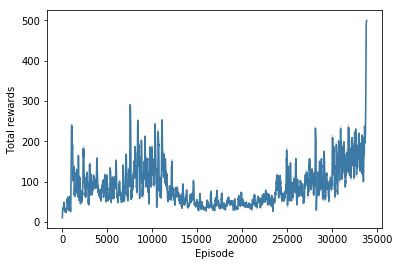

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

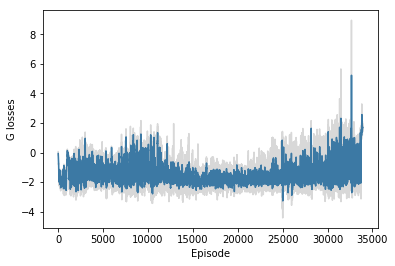

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

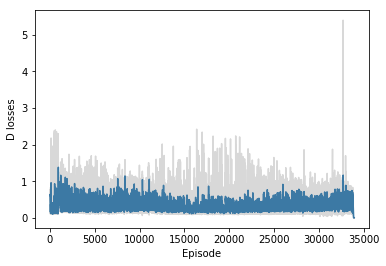

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [30]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model3.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.